In [1]:
# Parameters
config = {
    "notebook": "notebooks/tfi_lgbm_optuna.ipynb",
    "data_path": "C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/purse_seines_fe_recortado_v2.csv",
    "output_label": "purse_seines_optuna",
}


In [2]:
# check if config exists
try:
    config
except NameError:
    config_exists = False
else:
    config_exists = True

# make config if it does not exist already (e.g. passed in by papermill)
if not(config_exists):
    # set up some config for the experiment run
    config = {
        "data_path" : "C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/trollers_fe_recortado_v2.csv",
    }
print(config)

{'notebook': 'notebooks/tfi_lgbm_optuna.ipynb', 'data_path': 'C:/Users/nico_/Desktop/ITBA/TFI/github/df_procesado/purse_seines_fe_recortado_v2.csv', 'output_label': 'purse_seines_optuna'}


In [3]:
# Importing core libraries
#https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
#https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-lightgbm/notebook
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Cargamos el dataset.

In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

df = pd.read_csv(config['data_path'], header="infer", sep=",",error_bad_lines=False, engine ='python')

In [5]:
df = df.drop(['mmsi', 'source','timestamp','source','datetime','distance_from_shore','distance_from_port'], axis = 1)
lagged_columns = ['A0', 'J0', 'C0','speed_lag_1', 'speed_lag_2',
       'speed_lag_3', 'speed_lag_4', 'speed_lag_5', 'speed_lag_6',
       'course_lag_1', 'course_lag_2', 'course_lag_3', 'course_lag_4',
       'course_lag_5', 'course_lag_6', 'S0_lag_1', 'S0_lag_2', 'S0_lag_3',
       'S0_lag_4', 'S0_lag_5', 'S0_lag_6', 'A0_lag_1', 'A0_lag_2', 'A0_lag_3',
       'A0_lag_4', 'A0_lag_5', 'A0_lag_6', 'J0_lag_1', 'J0_lag_2', 'J0_lag_3',
       'J0_lag_4', 'J0_lag_5', 'J0_lag_6', 'C0_lag_1', 'C0_lag_2', 'C0_lag_3',
       'C0_lag_4', 'C0_lag_5', 'C0_lag_6']
for column in lagged_columns:
    df[column]=df[column].abs()

df['S0']=df['S0'].abs()
df['A0']=df['A0'].abs()
df['J0']=df['J0'].abs()
df['C0']=df['C0'].abs()
df['Delta_S']=df['Delta_S'].abs()
df['Delta_C']=df['Delta_C'].abs()

print(df)


      speed    course       lat       lon is_fishing  sun_state   distance  \
0      12.0  0.494167 -0.025505 -2.477270         NO          1   7.673169   
1      11.7  0.581111  0.093080 -2.540447         NO          1   2.744904   
2      11.4  0.775556 -0.060434  2.953940         NO          2  47.138407   
3      10.4  0.568611  0.758280 -0.036814         NO          2   4.156296   
4      13.1  0.670556 -0.092977  2.886767         NO          2  10.743421   
...     ...       ...       ...       ...        ...        ...        ...   
1141    0.2  0.042500  0.711676  0.426624         SI          1   0.166046   
1142    1.1  0.669167  0.766928 -0.031708         SI          2   0.522049   
1143   10.5  0.551111  0.760807 -0.035839         SI          2   4.704410   
1144    1.0  0.810000  0.026303  2.629826         SI          1  44.510724   
1145   10.6  0.636944  0.739521  0.252537         SI          1   6.150402   

      timediff        S0            A0  ...      J0_lag_3      

Generamos los vectores de train y test.

In [6]:
#Generamos train y test.

#Si la longitud del dataset es mayor a 10000, partiremos agrupado por "is_fishing" ya que nos puede tocar un conjunto con is_fishing='SI' vacio.
#if len(dataset)>10000:
    #df = df.sample(n=10000, random_state=1)
#    df = df.groupby("is_fishing").sample(n=7500, random_state=1,replace=True)
#    df = df.drop_duplicates()

X = df.drop('is_fishing',axis=1)
y = df['is_fishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=50)
print(len(df[df['is_fishing']=='SI']))
print(len(df[df['is_fishing']=='NO']))



573
573


Funcion para evaluar los modelos.

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import tabulate
from sklearn.metrics import confusion_matrix, accuracy_score


def evaluate_model(title,y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    display(Markdown(title))
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['NO', 'SI'])
    cmd_obj.plot()
    cmd_obj.ax_.set(
                    title='Matriz de confusión.', 
                    xlabel='Predict Values', 
                    ylabel='Actual Values')
    plt.show()
    _precision_score = precision_score(y_test, y_pred,pos_label='SI')
    _recall_score = recall_score(y_test, y_pred, pos_label='SI')
    _accuracy_score = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, pos_label='SI')

    data = [["Precision","Recall","Accuracy","F1"],
            ["%.2f" % _precision_score, "%.2f" % _recall_score, "%.2f" % _accuracy_score, "%.2f" % _f1_score ]]
    table = tabulate.tabulate(data, tablefmt='html')
    display(table)
    return _precision_score, _recall_score, _accuracy_score, _f1_score


Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


Train Accuracy : 0.829
Test Accuracy : 0.800
Best Score Through Grid Search : 0.777
Best Parameters :  {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
Best Parameters :  {'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


Arboles de decision optimizado

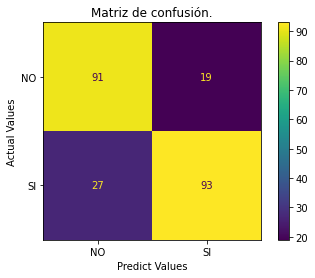

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.83     </td><td>0.78  </td><td>0.80    </td><td>0.80</td></tr>\n</tbody>\n</table>'

In [8]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeRegressor
#extra_tree_classifier = ExtraTreeClassifier(random_state=1)
#extra_tree_classifier.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV

parameters={"splitter":["best","random"],
            "max_depth" : [11,12,13,14,15,16],
           "min_samples_leaf":[1,2,3,4,5],
           "min_weight_fraction_leaf":[0, 0.1,0.2],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10] }

grid = GridSearchCV(DecisionTreeClassifier(random_state=1), cv=3, n_jobs=-1, verbose=3,
                    param_grid =parameters
                    )

grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

dt = DecisionTreeClassifier(max_depth=grid.best_params_['max_depth'], 
                            max_features=grid.best_params_['max_features'],
                            max_leaf_nodes=grid.best_params_['max_leaf_nodes'],
                            min_samples_leaf=grid.best_params_['min_samples_leaf'],
                            min_weight_fraction_leaf=grid.best_params_['min_weight_fraction_leaf'],
                            splitter=grid.best_params_['splitter']
)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print('Best Parameters : ',grid.best_params_)
dt_precision_score, dt_recall_score, dt_accuracy_score, dt_f1_score = evaluate_model('Arboles de decision optimizado',y_test, y_pred)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


Train Accuracy : 1.000
Test Accuracy : 0.804
Best Score Through Grid Search : 0.803
Best Parameters :  {'bootstrap': False, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Random forest optimizado

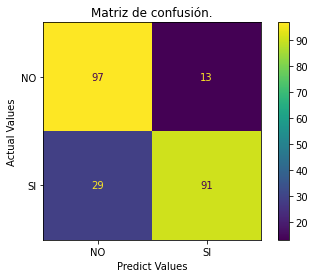

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.88     </td><td>0.76  </td><td>0.82    </td><td>0.81</td></tr>\n</tbody>\n</table>'

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [12,13,14,15],
    'max_features': ["auto", "sqrt", "log2"],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 5 , 10],
    'n_estimators': [100, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

dt = RandomForestClassifier(bootstrap=grid.best_params_['bootstrap'], 
                            max_depth=grid.best_params_['max_depth'],
                            max_features=grid.best_params_['max_features'],
                            min_samples_leaf=grid.best_params_['min_samples_leaf'],
                            min_samples_split=grid.best_params_['min_samples_split'],
                            n_estimators=grid.best_params_['n_estimators']
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rf_precision_score, rf_recall_score, rf_accuracy_score, rf_f1_score = evaluate_model('Random forest optimizado', y_test, y_pred)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Train Accuracy : 0.777
Test Accuracy : 0.617
Best Score Through Grid Search : 0.603
Best Parameters :  {'C': 100, 'gamma': 1e-05, 'kernel': 'rbf'}


rbf

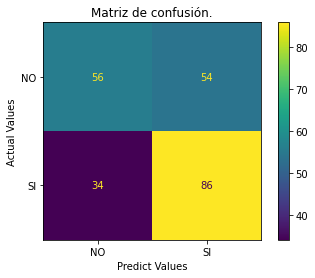

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.61     </td><td>0.72  </td><td>0.62    </td><td>0.66</td></tr>\n</tbody>\n</table>'

Fitting 5 folds for each of 120 candidates, totalling 600 fits


Train Accuracy : 0.533
Test Accuracy : 0.543
Best Score Through Grid Search : 0.556
Best Parameters :  {'C': 1, 'coef0': 0.01, 'gamma': 1e-05, 'kernel': 'sigmoid'}


sigmoid

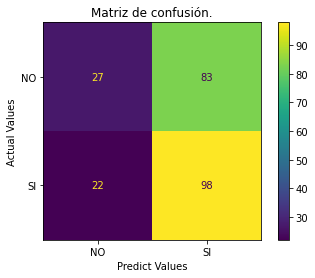

'<table>\n<tbody>\n<tr><td>Precision</td><td>Recall</td><td>Accuracy</td><td>F1  </td></tr>\n<tr><td>0.54     </td><td>0.82  </td><td>0.54    </td><td>0.65</td></tr>\n</tbody>\n</table>'

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.001, 0.10, 0.1, 10 ]},
#              {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],'C': [0.001, 0.10, 0.1, 10], 'coef0 ':[0,0.1,1]},
#              {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 1]}     
#]

parameters = [{'kernel': ['rbf'], 'gamma': [1e-2,1e-3,1e-4,1e-5,1e-6],'C': [0.001,0.01,0.1,1,10,100]},
              {'kernel': ['sigmoid'], 'gamma': [1e-2,1e-3,1e-4,1e-5,1e-6],'C': [0.001,0.01,0.1,1,10,100],'coef0' : [0.01,0.1,1,10]},
              #{'kernel': ['linear'], 'C': [1,10,100]}
              ]

svm_precision_score_rbf=svm_recall_score_rbf=svm_accuracy_score_rbf=svm_f1_score_rbf=0
svm_precision_score_sigmoid=svm_recall_score_sigmoid=svm_accuracy_score_sigmoid=svm_f1_score_sigmoid=0
svm_precision_score_linear=svm_recall_score_linear=svm_accuracy_score_linear=svm_f1_score_linear=0


for parameter in parameters:
    param_grid = parameter
    grid = GridSearchCV(SVC(), param_grid, n_jobs = -1, verbose = 3)
    grid.fit(X_train, y_train)
    kernel_str = parameter['kernel'][0]
    y_pred = grid.predict(X_test)
    dt = grid
    
    print('Train Accuracy : %.3f'%grid.best_estimator_.score(X_train, y_train))
    print('Test Accuracy : %.3f'%grid.best_estimator_.score(X_test, y_test))
    print('Best Score Through Grid Search : %.3f'%grid.best_score_)
    print('Best Parameters : ',grid.best_params_)

    if parameter['kernel'][0] == 'rbf':
        svm_precision_score_rbf, svm_recall_score_rbf, svm_accuracy_score_rbf, svm_f1_score_rbf = evaluate_model(kernel_str, y_test, y_pred)
    if parameter['kernel'][0] == 'sigmoid':
        svm_precision_score_sigmoid, svm_recall_score_sigmoid, svm_accuracy_score_sigmoid, svm_f1_score_sigmoid = evaluate_model(kernel_str, y_test, y_pred)
    if parameter['kernel'][0] == 'linear':
        svm_precision_score_linear, svm_recall_score_linear, svm_accuracy_score_linear, svm_f1_score_linear = evaluate_model(kernel_str, y_test, y_pred)

In [11]:
import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from optuna.integration import LightGBMPruningCallback


def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 8, 1023, step=10),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            #eval_metric="auc",
            early_stopping_rounds=100,
            callbacks=[
                #LightGBMPruningCallback(trial, "auc")
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)


In [12]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")

#AUC -> maximixe
#study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=2000)


[I 2022-06-21 15:07:16,416] A new study created in memory with name: LGBM Classifier


[I 2022-06-21 15:07:16,753] Trial 0 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21107662089034956, 'num_leaves': 128, 'max_depth': 8, 'min_data_in_leaf': 9900, 'lambda_l1': 0.8856849696099633, 'lambda_l2': 58.05517009509763, 'min_gain_to_split': 10.126806057956705, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=10.126806057956705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.126806057956705
[LightGBM] [Warning] lambda_l1 is set=0.8856849696099633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8856849696099633
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=58.05517009509763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.05517009509763
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:07:16,943] Trial 1 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10458891235057906, 'num_leaves': 258, 'max_depth': 6, 'min_data_in_leaf': 7900, 'lambda_l1': 9.216421850429388, 'lambda_l2': 55.766484267894626, 'min_gain_to_split': 1.9174692698816886, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] min_gain_to_split is set=1.9174692698816886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9174692698816886
[LightGBM] [Warning] lambda_l1 is set=9.216421850429388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.216421850429388
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=55.766484267894626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.766484267894626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wil

[I 2022-06-21 15:07:17,139] Trial 2 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1553644249184808, 'num_leaves': 138, 'max_depth': 10, 'min_data_in_leaf': 4600, 'lambda_l1': 9.961822791720378, 'lambda_l2': 40.521509223278365, 'min_gain_to_split': 9.280370457808024, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] min_gain_to_split is set=9.280370457808024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.280370457808024
[LightGBM] [Warning] lambda_l1 is set=9.961822791720378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.961822791720378
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=40.521509223278365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.521509223278365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will b

[I 2022-06-21 15:07:17,339] Trial 3 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.057949450499327634, 'num_leaves': 258, 'max_depth': 7, 'min_data_in_leaf': 3300, 'lambda_l1': 7.165351497434282, 'lambda_l2': 54.37351817754772, 'min_gain_to_split': 3.467851314610677, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=3.467851314610677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.467851314610677
[LightGBM] [Warning] lambda_l1 is set=7.165351497434282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165351497434282
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=54.37351817754772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.37351817754772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:17,537] Trial 4 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23146961199667737, 'num_leaves': 238, 'max_depth': 9, 'min_data_in_leaf': 2000, 'lambda_l1': 3.18538331722799, 'lambda_l2': 72.07706696241027, 'min_gain_to_split': 9.710335095061426, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=9.710335095061426, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.710335095061426
[LightGBM] [Warning] lambda_l1 is set=3.18538331722799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.18538331722799
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=72.07706696241027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.07706696241027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=11.424974614246947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.424974614246947
[LightGBM] [Warning] lambda_l1 is set=1.8651333062491227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8651333062491227
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=43.21635573891535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.21635573891535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:07:17,782] Trial 5 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1989485322174516, 'num_leaves': 918, 'max_depth': 12, 'min_data_in_leaf': 4400, 'lambda_l1': 1.8651333062491227, 'lambda_l2': 43.21635573891535, 'min_gain_to_split': 11.424974614246947, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=11.424974614246947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.424974614246947
[LightGBM] [Warning] lambda_l1 is set=1.8651333062491227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8651333062491227
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=43.21635573891535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.21635573891535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-21 15:07:18,025] Trial 6 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10073061713046716, 'num_leaves': 848, 'max_depth': 8, 'min_data_in_leaf': 5600, 'lambda_l1': 7.381043595383706, 'lambda_l2': 7.790797830917418, 'min_gain_to_split': 2.6866913617690598, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5600
[LightGBM] [Warning] min_gain_to_split is set=2.6866913617690598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6866913617690598
[LightGBM] [Warning] lambda_l1 is set=7.381043595383706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.381043595383706
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=7.790797830917418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.790797830917418
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=5600, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:07:18,270] Trial 7 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13205546300222404, 'num_leaves': 348, 'max_depth': 11, 'min_data_in_leaf': 6700, 'lambda_l1': 3.218047787094328, 'lambda_l2': 72.4604680726828, 'min_gain_to_split': 2.0426380598540406, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=2.0426380598540406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0426380598540406
[LightGBM] [Warning] lambda_l1 is set=3.218047787094328, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.218047787094328
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=72.4604680726828, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.4604680726828
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:07:18,513] Trial 8 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2773080601375262, 'num_leaves': 158, 'max_depth': 3, 'min_data_in_leaf': 5800, 'lambda_l1': 2.958958908201889, 'lambda_l2': 89.0001150093462, 'min_gain_to_split': 5.968751476921847, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5800
[LightGBM] [Warning] min_gain_to_split is set=5.968751476921847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.968751476921847
[LightGBM] [Warning] lambda_l1 is set=2.958958908201889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.958958908201889
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=89.0001150093462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.0001150093462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=5800, min_child_samples=20 will be 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.8125775376278954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8125775376278954
[LightGBM] [Warning] lambda_l1 is set=7.6920509039664555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.6920509039664555
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=92.39815804742761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.39815804742761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 wil

[I 2022-06-21 15:07:18,762] Trial 9 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.017812818731008623, 'num_leaves': 948, 'max_depth': 9, 'min_data_in_leaf': 2900, 'lambda_l1': 7.6920509039664555, 'lambda_l2': 92.39815804742761, 'min_gain_to_split': 0.8125775376278954, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=0.8125775376278954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8125775376278954
[LightGBM] [Warning] lambda_l1 is set=7.6920509039664555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.6920509039664555
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=92.39815804742761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92.39815804742761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 wi

[I 2022-06-21 15:07:19,100] Trial 10 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2941771361636836, 'num_leaves': 618, 'max_depth': 4, 'min_data_in_leaf': 9900, 'lambda_l1': 0.10658016900422496, 'lambda_l2': 21.767924786791873, 'min_gain_to_split': 14.461993031575297, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=14.461993031575297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.461993031575297
[LightGBM] [Warning] lambda_l1 is set=0.10658016900422496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10658016900422496
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.767924786791873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.767924786791873
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=6.037380194669927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.037380194669927
[LightGBM] [Warning] lambda_l1 is set=5.039090648651038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.039090648651038
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=62.56695382414465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.56695382414465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytre

[I 2022-06-21 15:07:19,395] Trial 11 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19641359971532857, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 9200, 'lambda_l1': 5.039090648651038, 'lambda_l2': 62.56695382414465, 'min_gain_to_split': 6.037380194669927, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] min_gain_to_split is set=6.037380194669927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.037380194669927
[LightGBM] [Warning] lambda_l1 is set=5.039090648651038, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.039090648651038
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=62.56695382414465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.56695382414465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:07:19,692] Trial 12 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09917350936537082, 'num_leaves': 428, 'max_depth': 5, 'min_data_in_leaf': 8000, 'lambda_l1': 9.84515047023876, 'lambda_l2': 30.404155474702875, 'min_gain_to_split': 13.596859924562933, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=13.596859924562933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.596859924562933
[LightGBM] [Warning] lambda_l1 is set=9.84515047023876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.84515047023876
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=30.404155474702875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.404155474702875
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be

[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=7.514846913042883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.514846913042883
[LightGBM] [Warning] lambda_l1 is set=5.385670723432477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.385670723432477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.18400183432661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.18400183432661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:07:19,987] Trial 13 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16490151302946698, 'num_leaves': 588, 'max_depth': 7, 'min_data_in_leaf': 7700, 'lambda_l1': 5.385670723432477, 'lambda_l2': 61.18400183432661, 'min_gain_to_split': 7.514846913042883, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=7.514846913042883, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.514846913042883
[LightGBM] [Warning] lambda_l1 is set=5.385670723432477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.385670723432477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.18400183432661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.18400183432661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:07:20,291] Trial 14 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23992794109608362, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 8700, 'lambda_l1': 0.43576072429188834, 'lambda_l2': 71.36915158556599, 'min_gain_to_split': 4.985203681662191, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8700
[LightGBM] [Warning] min_gain_to_split is set=4.985203681662191, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.985203681662191
[LightGBM] [Warning] lambda_l1 is set=0.43576072429188834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43576072429188834
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=71.36915158556599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.36915158556599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8700, min_child_samples=20 will

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=12.109294892740127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.109294892740127
[LightGBM] [Warning] lambda_l1 is set=8.396675474584034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.396675474584034
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=49.21239263452436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.21239263452436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:20,600] Trial 15 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.102311802525115, 'num_leaves': 388, 'max_depth': 5, 'min_data_in_leaf': 7100, 'lambda_l1': 8.396675474584034, 'lambda_l2': 49.21239263452436, 'min_gain_to_split': 12.109294892740127, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=12.109294892740127, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.109294892740127
[LightGBM] [Warning] lambda_l1 is set=8.396675474584034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.396675474584034
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=49.21239263452436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.21239263452436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:07:20,909] Trial 16 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06347636024335819, 'num_leaves': 488, 'max_depth': 8, 'min_data_in_leaf': 9900, 'lambda_l1': 6.07918271953782, 'lambda_l2': 31.119619150041245, 'min_gain_to_split': 9.237289270102307, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_gain_to_split is set=9.237289270102307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.237289270102307
[LightGBM] [Warning] lambda_l1 is set=6.07918271953782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.07918271953782
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=31.119619150041245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.119619150041245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9900
[LightGBM] [Warning] min_gain_to_split is set=9.237289270102307, min_split_gai

[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=5.1904358838380515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1904358838380515
[LightGBM] [Warning] lambda_l1 is set=0.12522667973061252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12522667973061252
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=80.20768988747278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.20768988747278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 wi

[I 2022-06-21 15:07:21,219] Trial 17 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24871377151263788, 'num_leaves': 48, 'max_depth': 9, 'min_data_in_leaf': 8600, 'lambda_l1': 0.12522667973061252, 'lambda_l2': 80.20768988747278, 'min_gain_to_split': 5.1904358838380515, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_gain_to_split is set=5.1904358838380515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.1904358838380515
[LightGBM] [Warning] lambda_l1 is set=0.12522667973061252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12522667973061252
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=80.20768988747278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80.20768988747278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=12.543100646195116, min_spli

[I 2022-06-21 15:07:21,535] Trial 18 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18933755391733414, 'num_leaves': 738, 'max_depth': 3, 'min_data_in_leaf': 7100, 'lambda_l1': 4.086594937822559, 'lambda_l2': 46.49297418109349, 'min_gain_to_split': 12.543100646195116, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=12.543100646195116, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.543100646195116
[LightGBM] [Warning] lambda_l1 is set=4.086594937822559, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.086594937822559
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=46.49297418109349, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.49297418109349
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=9.33009305678727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.33009305678727
[LightGBM] [Warning] lambda_l1 is set=6.1899792427536475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1899792427536475
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.470276428429973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.470276428429973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:21,853] Trial 19 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0232578983970214, 'num_leaves': 498, 'max_depth': 8, 'min_data_in_leaf': 9800, 'lambda_l1': 6.1899792427536475, 'lambda_l2': 27.470276428429973, 'min_gain_to_split': 9.33009305678727, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=9.33009305678727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.33009305678727
[LightGBM] [Warning] lambda_l1 is set=6.1899792427536475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.1899792427536475
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=27.470276428429973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.470276428429973
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:07:22,169] Trial 20 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24916341141537524, 'num_leaves': 138, 'max_depth': 10, 'min_data_in_leaf': 8900, 'lambda_l1': 1.2314523564963031, 'lambda_l2': 82.9825225306476, 'min_gain_to_split': 7.629550810303584, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=7.629550810303584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.629550810303584
[LightGBM] [Warning] lambda_l1 is set=1.2314523564963031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2314523564963031
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=82.9825225306476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.9825225306476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_da

[LightGBM] [Warning] min_gain_to_split is set=11.535853647095983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.535853647095983
[LightGBM] [Warning] lambda_l1 is set=1.9810990212669966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9810990212669966
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.06687547966182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.06687547966182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=11.535853647095983, min_spli

[I 2022-06-21 15:07:22,494] Trial 21 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20007777134836208, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 6600, 'lambda_l1': 1.9810990212669966, 'lambda_l2': 99.06687547966182, 'min_gain_to_split': 11.535853647095983, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.6931514658995768.


[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] min_gain_to_split is set=11.535853647095983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.535853647095983
[LightGBM] [Warning] lambda_l1 is set=1.9810990212669966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9810990212669966
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=99.06687547966182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.06687547966182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 wil

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.868007749655957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.868007749655957
[LightGBM] [Warning] lambda_l1 is set=4.30496046625195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.30496046625195
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.204839448404368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.204839448404368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be i

[I 2022-06-21 15:07:23,014] Trial 22 finished with value: 0.5668983823671476 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17623825602791682, 'num_leaves': 708, 'max_depth': 3, 'min_data_in_leaf': 200, 'lambda_l1': 4.30496046625195, 'lambda_l2': 6.204839448404368, 'min_gain_to_split': 12.868007749655957, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 22 with value: 0.5668983823671476.



[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.868007749655957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.868007749655957
[LightGBM] [Warning] lambda_l1 is set=4.30496046625195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.30496046625195
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.204839448404368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.204839448404368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.539745698521292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.539745698521292
[LightGBM] [Warning] lambda_l1 is set=6.03887604309362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.03887604309362
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0023758994568723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0023758994568723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.539745698521292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.539745698521292
[LightGBM] [Warning] lambda_l1 is set=6.03887604309362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.03887604309362
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0023758994568723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0023758994568723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.539745698521292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.539745698521292
[LightGBM] [Warning] lambda_l1 is set=6.03887604309362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.03887604309362
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0023758994568723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0023758994568723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.539745698521292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.539745698521292
[LightGBM] [Warning] lambda_l1 is set=6.03887604309362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.03887604309362
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0023758994568723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0023758994568723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.539745698521292, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.539745698521292
[LightGBM] [Warning] lambda_l1 is set=6.03887604309362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.03887604309362
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0023758994568723, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0023758994568723
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:07:27,800] Trial 23 finished with value: 0.5522972713843203 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011855664611273686, 'num_leaves': 658, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 6.03887604309362, 'lambda_l2': 1.0023758994568723, 'min_gain_to_split': 7.539745698521292, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=14.853986629782963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.853986629782963
[LightGBM] [Warning] lambda_l1 is set=4.115271734489774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.115271734489774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.91969446782602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.91969446782602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=14.853986629782963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.853986629782963
[LightGBM] [Warning] lambda_l1 is set=4.115271734489774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.115271734489774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.91969446782602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.91969446782602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-21 15:07:28,494] Trial 24 finished with value: 0.5670637431430172 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17670576273968225, 'num_leaves': 768, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 4.115271734489774, 'lambda_l2': 3.91969446782602, 'min_gain_to_split': 14.853986629782963, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=14.853986629782963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.853986629782963
[LightGBM] [Warning] lambda_l1 is set=4.115271734489774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.115271734489774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.91969446782602, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.91969446782602
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.73641160739103, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.73641160739103
[LightGBM] [Warning] lambda_l1 is set=4.150659775280502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.150659775280502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1204717075222832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1204717075222832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.73641160739103, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.73641160739103
[LightGBM] [Warning] lambda_l1 is set=4.150659775280502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.150659775280502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1204717075222832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1204717075222832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:07:29,223] Trial 25 finished with value: 0.5912776008863976 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14052705475759567, 'num_leaves': 688, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 4.150659775280502, 'lambda_l2': 0.1204717075222832, 'min_gain_to_split': 14.73641160739103, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.73641160739103, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.73641160739103
[LightGBM] [Warning] lambda_l1 is set=4.150659775280502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.150659775280502
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1204717075222832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1204717075222832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.360088424892549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.360088424892549
[LightGBM] [Warning] lambda_l1 is set=4.455691781712176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.455691781712176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.729770444013914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.729770444013914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.360088424892549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.360088424892549
[LightGBM] [Warning] lambda_l1 is set=4.455691781712176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.455691781712176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.729770444013914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.729770444013914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:29,851] Trial 26 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17595010899397265, 'num_leaves': 798, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 4.455691781712176, 'lambda_l2': 14.729770444013914, 'min_gain_to_split': 13.360088424892549, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.360088424892549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.360088424892549
[LightGBM] [Warning] lambda_l1 is set=4.455691781712176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.455691781712176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.729770444013914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.729770444013914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Curr

[I 2022-06-21 15:07:30,191] Trial 27 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1313977298950528, 'num_leaves': 638, 'max_depth': 11, 'min_data_in_leaf': 1400, 'lambda_l1': 6.03239673192161, 'lambda_l2': 3.4228280463474148, 'min_gain_to_split': 13.38857703488559, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=13.38857703488559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.38857703488559
[LightGBM] [Warning] lambda_l1 is set=6.03239673192161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.03239673192161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.4228280463474148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4228280463474148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=10.579558692649403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.579558692649403
[LightGBM] [Warning] lambda_l1 is set=6.697631815037267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.697631815037267
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.260334262794228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.260334262794228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[I 2022-06-21 15:07:30,601] Trial 28 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06825302759869854, 'num_leaves': 858, 'max_depth': 12, 'min_data_in_leaf': 1300, 'lambda_l1': 6.697631815037267, 'lambda_l2': 12.260334262794228, 'min_gain_to_split': 10.579558692649403, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=10.579558692649403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.579558692649403
[LightGBM] [Warning] lambda_l1 is set=6.697631815037267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.697631815037267
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.260334262794228, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.260334262794228
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will 

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.962050022174722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.962050022174722
[LightGBM] [Warning] lambda_l1 is set=5.197839652218268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.197839652218268
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.09346560070535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.09346560070535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.962050022174722, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.962050022174722
[LightGBM] [Warning] lambda_l1 is set=5.197839652218268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.197839652218268
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=20.09346560070535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.09346560070535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:31,350] Trial 29 finished with value: 0.567714302140611 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21520810763784362, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 5.197839652218268, 'lambda_l2': 20.09346560070535, 'min_gain_to_split': 14.962050022174722, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=10.632940107115717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.632940107115717
[LightGBM] [Warning] lambda_l1 is set=3.611706086857426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.611706086857426
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.115402308779656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.115402308779656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:31,692] Trial 30 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18068059946146914, 'num_leaves': 538, 'max_depth': 11, 'min_data_in_leaf': 1200, 'lambda_l1': 3.611706086857426, 'lambda_l2': 8.115402308779656, 'min_gain_to_split': 10.632940107115717, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=10.632940107115717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.632940107115717
[LightGBM] [Warning] lambda_l1 is set=3.611706086857426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.611706086857426
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.115402308779656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.115402308779656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.604043009829262, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.604043009829262
[LightGBM] [Warning] lambda_l1 is set=5.085842112496101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.085842112496101
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.47890794125795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.47890794125795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.604043009829262, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.604043009829262
[LightGBM] [Warning] lambda_l1 is set=5.085842112496101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.085842112496101
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.47890794125795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.47890794125795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:32,413] Trial 31 finished with value: 0.566155374839937 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2245259080192839, 'num_leaves': 1008, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 5.085842112496101, 'lambda_l2': 18.47890794125795, 'min_gain_to_split': 14.604043009829262, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=13.750590708618574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.750590708618574
[LightGBM] [Warning] lambda_l1 is set=4.6832732208494035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6832732208494035
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.804273456365888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.804273456365888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:07:32,759] Trial 32 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2208737512174553, 'num_leaves': 1018, 'max_depth': 12, 'min_data_in_leaf': 2200, 'lambda_l1': 4.6832732208494035, 'lambda_l2': 16.804273456365888, 'min_gain_to_split': 13.750590708618574, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=13.750590708618574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.750590708618574
[LightGBM] [Warning] lambda_l1 is set=4.6832732208494035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6832732208494035
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.804273456365888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.804273456365888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. 

[I 2022-06-21 15:07:33,106] Trial 33 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.162031122086141, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 5.277363877132018, 'lambda_l2': 7.026478917858052, 'min_gain_to_split': 12.977909463590688, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=12.977909463590688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.977909463590688
[LightGBM] [Warning] lambda_l1 is set=5.277363877132018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.277363877132018
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.026478917858052, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.026478917858052
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=14.273970211448397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.273970211448397
[LightGBM] [Warning] lambda_l1 is set=2.558319698258348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.558319698258348
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.48399294058018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.48399294058018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:33,455] Trial 34 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2645668197778077, 'num_leaves': 838, 'max_depth': 11, 'min_data_in_leaf': 2100, 'lambda_l1': 2.558319698258348, 'lambda_l2': 37.48399294058018, 'min_gain_to_split': 14.273970211448397, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=14.273970211448397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.273970211448397
[LightGBM] [Warning] lambda_l1 is set=2.558319698258348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.558319698258348
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.48399294058018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.48399294058018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Curr

[I 2022-06-21 15:07:33,808] Trial 35 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14398929433160673, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 2900, 'lambda_l1': 5.723956195897679, 'lambda_l2': 1.5910208796516603, 'min_gain_to_split': 8.568470263301194, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=8.568470263301194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.568470263301194
[LightGBM] [Warning] lambda_l1 is set=5.723956195897679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.723956195897679
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.5910208796516603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5910208796516603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=12.120061170305682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.120061170305682
[LightGBM] [Warning] lambda_l1 is set=6.706974201516217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.706974201516217
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.871415108527625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.871415108527625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:34,168] Trial 36 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11663127213541179, 'num_leaves': 688, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 6.706974201516217, 'lambda_l2': 22.871415108527625, 'min_gain_to_split': 12.120061170305682, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 23 with value: 0.5522972713843203.



[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=12.120061170305682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.120061170305682
[LightGBM] [Warning] lambda_l1 is set=6.706974201516217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.706974201516217
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=22.871415108527625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.871415108527625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=11.19682928678019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.19682928678019
[LightGBM] [Warning] lambda_l1 is set=3.9251901921541426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9251901921541426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.380839124508338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.380839124508338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:07:34,528] Trial 37 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.038651082432494155, 'num_leaves': 558, 'max_depth': 11, 'min_data_in_leaf': 3700, 'lambda_l1': 3.9251901921541426, 'lambda_l2': 10.380839124508338, 'min_gain_to_split': 11.19682928678019, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=11.19682928678019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.19682928678019
[LightGBM] [Warning] lambda_l1 is set=3.9251901921541426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9251901921541426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.380839124508338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.380839124508338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=13.954305724309947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.954305724309947
[LightGBM] [Warning] lambda_l1 is set=8.192098769326385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.192098769326385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.135449734202883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.135449734202883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:07:34,912] Trial 38 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22750265843994424, 'num_leaves': 808, 'max_depth': 5, 'min_data_in_leaf': 1700, 'lambda_l1': 8.192098769326385, 'lambda_l2': 5.135449734202883, 'min_gain_to_split': 13.954305724309947, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14.962983036728952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.962983036728952
[LightGBM] [Warning] lambda_l1 is set=4.548260362614771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.548260362614771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.774974700229365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.774974700229365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:07:35,276] Trial 39 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2077120944760853, 'num_leaves': 758, 'max_depth': 4, 'min_data_in_leaf': 700, 'lambda_l1': 4.548260362614771, 'lambda_l2': 15.774974700229365, 'min_gain_to_split': 14.962983036728952, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=14.962983036728952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.962983036728952
[LightGBM] [Warning] lambda_l1 is set=4.548260362614771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.548260362614771
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=15.774974700229365, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.774974700229365
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=12.90348577151374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.90348577151374
[LightGBM] [Warning] lambda_l1 is set=3.4530045416779727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4530045416779727
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=35.69530154302761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.69530154302761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be

[I 2022-06-21 15:07:35,647] Trial 40 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15433143012783, 'num_leaves': 908, 'max_depth': 9, 'min_data_in_leaf': 2600, 'lambda_l1': 3.4530045416779727, 'lambda_l2': 35.69530154302761, 'min_gain_to_split': 12.90348577151374, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] min_data_in_leaf is set=2600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2600
[LightGBM] [Warning] min_gain_to_split is set=12.90348577151374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.90348577151374
[LightGBM] [Warning] lambda_l1 is set=3.4530045416779727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4530045416779727
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=35.69530154302761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.69530154302761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.860915950852508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.860915950852508
[LightGBM] [Warning] lambda_l1 is set=4.967970787196707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.967970787196707
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.03670253269321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.03670253269321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.860915950852508, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.860915950852508
[LightGBM] [Warning] lambda_l1 is set=4.967970787196707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.967970787196707
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=21.03670253269321, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.03670253269321
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:36,367] Trial 41 finished with value: 0.5681862276116908 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2140141876144255, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 4.967970787196707, 'lambda_l2': 21.03670253269321, 'min_gain_to_split': 14.860915950852508, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=14.143587577791717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.143587577791717
[LightGBM] [Warning] lambda_l1 is set=6.704743691943342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.704743691943342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.504879399398538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.504879399398538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:07:36,784] Trial 42 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18442018804869953, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 1700, 'lambda_l1': 6.704743691943342, 'lambda_l2': 11.504879399398538, 'min_gain_to_split': 14.143587577791717, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 23 with value: 0.5522972713843203.


[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=14.143587577791717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.143587577791717
[LightGBM] [Warning] lambda_l1 is set=6.704743691943342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.704743691943342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.504879399398538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.504879399398538
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] min_gain_to_split is set=0.4681338074045511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4681338074045511
[LightGBM] [Warning] lambda_l1 is set=5.620570734326517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.620570734326517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.685181567985808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.685181567985808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.4681338074045511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4681338074045511
[LightGBM] [Warning] lambda_l1 is set=5.620570734326517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.620570734326517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.685181567985808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.685181567985808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.4681338074045511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4681338074045511
[LightGBM] [Warning] lambda_l1 is set=5.620570734326517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.620570734326517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.685181567985808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.685181567985808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.4681338074045511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4681338074045511
[LightGBM] [Warning] lambda_l1 is set=5.620570734326517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.620570734326517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.685181567985808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.685181567985808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:07:38,138] Trial 43 finished with value: 0.5461676039972437 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21025833730840848, 'num_leaves': 978, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 5.620570734326517, 'lambda_l2': 18.685181567985808, 'min_gain_to_split': 0.4681338074045511, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=0.4681338074045511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4681338074045511
[LightGBM] [Warning] lambda_l1 is set=5.620570734326517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.620570734326517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.685181567985808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.685181567985808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1700547611173793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1700547611173793
[LightGBM] [Warning] lambda_l1 is set=5.643466920825918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.643466920825918
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.584079060137366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.584079060137366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:07:38,513] Trial 44 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08125503729370447, 'num_leaves': 878, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 5.643466920825918, 'lambda_l2': 25.584079060137366, 'min_gain_to_split': 1.1700547611173793, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.1700547611173793, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1700547611173793
[LightGBM] [Warning] lambda_l1 is set=5.643466920825918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.643466920825918
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.584079060137366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.584079060137366
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will 

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.19960017300562694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19960017300562694
[LightGBM] [Warning] lambda_l1 is set=2.9574466781775524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9574466781775524
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8911623830887048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8911623830887048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample

[I 2022-06-21 15:07:38,892] Trial 45 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1753943261075429, 'num_leaves': 638, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 2.9574466781775524, 'lambda_l2': 3.8911623830887048, 'min_gain_to_split': 0.19960017300562694, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.19960017300562694, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.19960017300562694
[LightGBM] [Warning] lambda_l1 is set=2.9574466781775524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9574466781775524
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.8911623830887048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8911623830887048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: 

[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=4.304310239213246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.304310239213246
[LightGBM] [Warning] lambda_l1 is set=4.470794633383263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.470794633383263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.86228248790156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.86228248790156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:07:39,272] Trial 46 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.237789666401253, 'num_leaves': 948, 'max_depth': 12, 'min_data_in_leaf': 3600, 'lambda_l1': 4.470794633383263, 'lambda_l2': 16.86228248790156, 'min_gain_to_split': 4.304310239213246, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=3600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3600
[LightGBM] [Warning] min_gain_to_split is set=4.304310239213246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.304310239213246
[LightGBM] [Warning] lambda_l1 is set=4.470794633383263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.470794633383263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.86228248790156, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.86228248790156
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_da

[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=3.3854294206257176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3854294206257176
[LightGBM] [Warning] lambda_l1 is set=7.060916415716458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.060916415716458
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.17824822435453225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17824822435453225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: 

[I 2022-06-21 15:07:39,654] Trial 47 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26070706196576565, 'num_leaves': 708, 'max_depth': 7, 'min_data_in_leaf': 1600, 'lambda_l1': 7.060916415716458, 'lambda_l2': 0.17824822435453225, 'min_gain_to_split': 3.3854294206257176, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=3.3854294206257176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3854294206257176
[LightGBM] [Warning] lambda_l1 is set=7.060916415716458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.060916415716458
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.17824822435453225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.17824822435453225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: 

[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=6.062106555954539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.062106555954539
[LightGBM] [Warning] lambda_l1 is set=2.5776828907584344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5776828907584344
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.186193573920706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.186193573920706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:07:40,044] Trial 48 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19828760590520905, 'num_leaves': 798, 'max_depth': 12, 'min_data_in_leaf': 4800, 'lambda_l1': 2.5776828907584344, 'lambda_l2': 9.186193573920706, 'min_gain_to_split': 6.062106555954539, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=4800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4800
[LightGBM] [Warning] min_gain_to_split is set=6.062106555954539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.062106555954539
[LightGBM] [Warning] lambda_l1 is set=2.5776828907584344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5776828907584344
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=9.186193573920706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.186193573920706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.688697426629258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.688697426629258
[LightGBM] [Warning] lambda_l1 is set=5.65843365515883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.65843365515883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.01766055318836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.01766055318836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be 

[I 2022-06-21 15:07:40,431] Trial 49 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29411802854699465, 'num_leaves': 968, 'max_depth': 11, 'min_data_in_leaf': 1000, 'lambda_l1': 5.65843365515883, 'lambda_l2': 13.01766055318836, 'min_gain_to_split': 6.688697426629258, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=6.688697426629258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.688697426629258
[LightGBM] [Warning] lambda_l1 is set=5.65843365515883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.65843365515883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.01766055318836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.01766055318836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data

[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=2.6029912825128827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6029912825128827
[LightGBM] [Warning] lambda_l1 is set=3.8843580723587086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8843580723587086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.090219982359834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.090219982359834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: 

[I 2022-06-21 15:07:40,821] Trial 50 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16514254397063952, 'num_leaves': 448, 'max_depth': 4, 'min_data_in_leaf': 2500, 'lambda_l1': 3.8843580723587086, 'lambda_l2': 30.090219982359834, 'min_gain_to_split': 2.6029912825128827, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=2.6029912825128827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.6029912825128827
[LightGBM] [Warning] lambda_l1 is set=3.8843580723587086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8843580723587086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=30.090219982359834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.090219982359834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: m

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.208344175572797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.208344175572797
[LightGBM] [Warning] lambda_l1 is set=4.932636161009292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932636161009292
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.58249682298315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.58249682298315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.208344175572797, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.208344175572797
[LightGBM] [Warning] lambda_l1 is set=4.932636161009292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.932636161009292
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.58249682298315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.58249682298315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:07:41,610] Trial 51 finished with value: 0.5620308388742257 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2159556635312604, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 300, 'lambda_l1': 4.932636161009292, 'lambda_l2': 17.58249682298315, 'min_gain_to_split': 8.208344175572797, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.667432569843712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.667432569843712
[LightGBM] [Warning] lambda_l1 is set=5.0142006124726315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0142006124726315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.653625335387133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.653625335387133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.667432569843712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.667432569843712
[LightGBM] [Warning] lambda_l1 is set=5.0142006124726315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0142006124726315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.653625335387133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.653625335387133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:42,509] Trial 52 finished with value: 0.556424602254389 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20758488402156067, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.0142006124726315, 'lambda_l2': 18.653625335387133, 'min_gain_to_split': 8.667432569843712, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.667432569843712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.667432569843712
[LightGBM] [Warning] lambda_l1 is set=5.0142006124726315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0142006124726315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.653625335387133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.653625335387133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.108968216180983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.108968216180983
[LightGBM] [Warning] lambda_l1 is set=4.903288183177151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.903288183177151
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25.391602789248772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.391602789248772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:42,922] Trial 53 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23371013535411964, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 4.903288183177151, 'lambda_l2': 25.391602789248772, 'min_gain_to_split': 8.108968216180983, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.108968216180983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.108968216180983
[LightGBM] [Warning] lambda_l1 is set=4.903288183177151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.903288183177151
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=25.391602789248772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.391602789248772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=6.688933277563097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.688933277563097
[LightGBM] [Warning] lambda_l1 is set=6.279195235765174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.279195235765174
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.691283020745047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.691283020745047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:07:43,332] Trial 54 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20701144308065406, 'num_leaves': 978, 'max_depth': 8, 'min_data_in_leaf': 1300, 'lambda_l1': 6.279195235765174, 'lambda_l2': 19.691283020745047, 'min_gain_to_split': 6.688933277563097, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=6.688933277563097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.688933277563097
[LightGBM] [Warning] lambda_l1 is set=6.279195235765174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.279195235765174
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=19.691283020745047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.691283020745047
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=8.404107373970778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.404107373970778
[LightGBM] [Warning] lambda_l1 is set=5.415357670186132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.415357670186132
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=35.8194246127795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.8194246127795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data

[I 2022-06-21 15:07:43,735] Trial 55 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22383474073915577, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 1800, 'lambda_l1': 5.415357670186132, 'lambda_l2': 35.8194246127795, 'min_gain_to_split': 8.404107373970778, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=8.404107373970778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.404107373970778
[LightGBM] [Warning] lambda_l1 is set=5.415357670186132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.415357670186132
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=35.8194246127795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.8194246127795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data

[LightGBM] [Warning] min_gain_to_split is set=9.907959743391858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.907959743391858
[LightGBM] [Warning] lambda_l1 is set=5.94525997609144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.94525997609144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.34668089080354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.34668089080354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.907959743391858, min_split_gain=0.0 will be ignored. Current value

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.907959743391858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.907959743391858
[LightGBM] [Warning] lambda_l1 is set=5.94525997609144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.94525997609144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.34668089080354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.34668089080354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2022-06-21 15:07:44,433] Trial 56 finished with value: 0.5717299110622374 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19221887147463743, 'num_leaves': 318, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 5.94525997609144, 'lambda_l2': 55.34668089080354, 'min_gain_to_split': 9.907959743391858, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.907959743391858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.907959743391858
[LightGBM] [Warning] lambda_l1 is set=5.94525997609144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.94525997609144
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.34668089080354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.34668089080354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.911348964413729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.911348964413729
[LightGBM] [Warning] lambda_l1 is set=6.401046082384704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.401046082384704
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=41.86451034329643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.86451034329643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3

[I 2022-06-21 15:07:44,857] Trial 57 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24808623124779144, 'num_leaves': 838, 'max_depth': 10, 'min_data_in_leaf': 1100, 'lambda_l1': 6.401046082384704, 'lambda_l2': 41.86451034329643, 'min_gain_to_split': 6.911348964413729, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.911348964413729, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.911348964413729
[LightGBM] [Warning] lambda_l1 is set=6.401046082384704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.401046082384704
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=41.86451034329643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.86451034329643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.3

[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=8.885781947816115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.885781947816115
[LightGBM] [Warning] lambda_l1 is set=7.341505851858118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.341505851858118
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.72517163137809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.72517163137809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:07:45,269] Trial 58 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2643886278788644, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 5500, 'lambda_l1': 7.341505851858118, 'lambda_l2': 18.72517163137809, 'min_gain_to_split': 8.885781947816115, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=8.885781947816115, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.885781947816115
[LightGBM] [Warning] lambda_l1 is set=7.341505851858118, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.341505851858118
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.72517163137809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.72517163137809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_da

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.019998657583242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019998657583242
[LightGBM] [Warning] lambda_l1 is set=4.819014085774398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.819014085774398
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=31.88420724805895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.88420724805895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-21 15:07:45,676] Trial 59 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20833700766372346, 'num_leaves': 868, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 4.819014085774398, 'lambda_l2': 31.88420724805895, 'min_gain_to_split': 5.019998657583242, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.019998657583242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019998657583242
[LightGBM] [Warning] lambda_l1 is set=4.819014085774398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.819014085774398
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=31.88420724805895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.88420724805895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.648258109896863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.648258109896863
[LightGBM] [Warning] lambda_l1 is set=5.4658839658094305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4658839658094305
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.662854526675478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.662854526675478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:07:46,089] Trial 60 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28141620685935037, 'num_leaves': 988, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 5.4658839658094305, 'lambda_l2': 23.662854526675478, 'min_gain_to_split': 7.648258109896863, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.648258109896863, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.648258109896863
[LightGBM] [Warning] lambda_l1 is set=5.4658839658094305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4658839658094305
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.662854526675478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.662854526675478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=7.957106706456913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.957106706456913
[LightGBM] [Warning] lambda_l1 is set=4.337040626794046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.337040626794046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.0976737109847186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.0976737109847186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will b

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=7.957106706456913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.957106706456913
[LightGBM] [Warning] lambda_l1 is set=4.337040626794046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.337040626794046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.0976737109847186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.0976737109847186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:07:46,791] Trial 61 finished with value: 0.557935053850552 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17198438554402698, 'num_leaves': 728, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 4.337040626794046, 'lambda_l2': 6.0976737109847186, 'min_gain_to_split': 7.957106706456913, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=7.957106706456913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.957106706456913
[LightGBM] [Warning] lambda_l1 is set=4.337040626794046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.337040626794046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.0976737109847186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.0976737109847186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.342324966380064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.342324966380064
[LightGBM] [Warning] lambda_l1 is set=4.402388198752364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.402388198752364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.593957239869292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.593957239869292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be i

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.342324966380064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.342324966380064
[LightGBM] [Warning] lambda_l1 is set=4.402388198752364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.402388198752364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.593957239869292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.593957239869292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-21 15:07:47,538] Trial 62 finished with value: 0.5517071080825215 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1944785329754668, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 4.402388198752364, 'lambda_l2': 8.593957239869292, 'min_gain_to_split': 9.342324966380064, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.342324966380064, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.342324966380064
[LightGBM] [Warning] lambda_l1 is set=4.402388198752364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.402388198752364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.593957239869292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.593957239869292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.306840851304626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.306840851304626
[LightGBM] [Warning] lambda_l1 is set=5.029876946513426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.029876946513426
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.350044370385982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.350044370385982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:07:47,956] Trial 63 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20049111937565467, 'num_leaves': 588, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 5.029876946513426, 'lambda_l2': 13.350044370385982, 'min_gain_to_split': 9.306840851304626, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.306840851304626, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.306840851304626
[LightGBM] [Warning] lambda_l1 is set=5.029876946513426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.029876946513426
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.350044370385982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.350044370385982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will 

[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=7.136406436024289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.136406436024289
[LightGBM] [Warning] lambda_l1 is set=3.595779621815072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.595779621815072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.966017364572913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.966017364572913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:07:48,381] Trial 64 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1886828965196035, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 1400, 'lambda_l1': 3.595779621815072, 'lambda_l2': 8.966017364572913, 'min_gain_to_split': 7.136406436024289, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=7.136406436024289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.136406436024289
[LightGBM] [Warning] lambda_l1 is set=3.595779621815072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.595779621815072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.966017364572913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.966017364572913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.756288017718203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.756288017718203
[LightGBM] [Warning] lambda_l1 is set=4.672867389165935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.672867389165935
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.318818627590105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.318818627590105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:48,809] Trial 65 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.225720769878669, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 4.672867389165935, 'lambda_l2': 28.318818627590105, 'min_gain_to_split': 7.756288017718203, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.756288017718203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.756288017718203
[LightGBM] [Warning] lambda_l1 is set=4.672867389165935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.672867389165935
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.318818627590105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.318818627590105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Curren

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.22654364238747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.22654364238747
[LightGBM] [Warning] lambda_l1 is set=5.209116887749144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.209116887749144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.46095643100355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.46095643100355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.22654364238747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.22654364238747
[LightGBM] [Warning] lambda_l1 is set=5.209116887749144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.209116887749144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.46095643100355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.46095643100355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-21 15:07:49,518] Trial 66 finished with value: 0.5602971488586634 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2194884949963353, 'num_leaves': 1008, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.209116887749144, 'lambda_l2': 15.46095643100355, 'min_gain_to_split': 10.22654364238747, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10.22115624735952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.22115624735952
[LightGBM] [Warning] lambda_l1 is set=5.9097500387738595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9097500387738595
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.294492148640142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.294492148640142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:49,948] Trial 67 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16634086369752935, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 5.9097500387738595, 'lambda_l2': 6.294492148640142, 'min_gain_to_split': 10.22115624735952, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10.22115624735952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.22115624735952
[LightGBM] [Warning] lambda_l1 is set=5.9097500387738595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9097500387738595
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.294492148640142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.294492148640142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=8.918307926614546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.918307926614546
[LightGBM] [Warning] lambda_l1 is set=4.272138702408824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.272138702408824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.912467421914002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.912467421914002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:07:50,381] Trial 68 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15354857554426135, 'num_leaves': 458, 'max_depth': 12, 'min_data_in_leaf': 1400, 'lambda_l1': 4.272138702408824, 'lambda_l2': 13.912467421914002, 'min_gain_to_split': 8.918307926614546, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=8.918307926614546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.918307926614546
[LightGBM] [Warning] lambda_l1 is set=4.272138702408824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.272138702408824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.912467421914002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.912467421914002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=9.70714287922666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.70714287922666
[LightGBM] [Warning] lambda_l1 is set=6.444253571186554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.444253571186554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.657290675952634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.657290675952634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ign

[I 2022-06-21 15:07:50,814] Trial 69 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21822695816792048, 'num_leaves': 658, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 6.444253571186554, 'lambda_l2': 2.657290675952634, 'min_gain_to_split': 9.70714287922666, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=9.70714287922666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.70714287922666
[LightGBM] [Warning] lambda_l1 is set=6.444253571186554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.444253571186554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=2.657290675952634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.657290675952634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree

[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=8.250685653458751, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.250685653458751
[LightGBM] [Warning] lambda_l1 is set=7.813697896642797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.813697896642797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.517045551057473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.517045551057473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will

[I 2022-06-21 15:07:51,249] Trial 70 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12071437894568224, 'num_leaves': 518, 'max_depth': 12, 'min_data_in_leaf': 2000, 'lambda_l1': 7.813697896642797, 'lambda_l2': 10.517045551057473, 'min_gain_to_split': 8.250685653458751, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=8.250685653458751, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.250685653458751
[LightGBM] [Warning] lambda_l1 is set=7.813697896642797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.813697896642797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.517045551057473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.517045551057473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.119774888266943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.119774888266943
[LightGBM] [Warning] lambda_l1 is set=5.194374035242068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.194374035242068
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.60721012523646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.60721012523646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.119774888266943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.119774888266943
[LightGBM] [Warning] lambda_l1 is set=5.194374035242068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.194374035242068
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.60721012523646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.60721012523646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:07:52,014] Trial 71 finished with value: 0.5526408023578163 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2435310175551992, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.194374035242068, 'lambda_l2': 18.60721012523646, 'min_gain_to_split': 6.119774888266943, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.119774888266943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.119774888266943
[LightGBM] [Warning] lambda_l1 is set=5.194374035242068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.194374035242068
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=18.60721012523646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.60721012523646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.689935769633642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.689935769633642
[LightGBM] [Warning] lambda_l1 is set=5.230090932485745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.230090932485745
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.82085579900398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.82085579900398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.689935769633642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.689935769633642
[LightGBM] [Warning] lambda_l1 is set=5.230090932485745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.230090932485745
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.82085579900398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.82085579900398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:52,859] Trial 72 finished with value: 0.5624533085412943 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24525832379644685, 'num_leaves': 988, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.230090932485745, 'lambda_l2': 22.82085579900398, 'min_gain_to_split': 10.689935769633642, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.689935769633642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.689935769633642
[LightGBM] [Warning] lambda_l1 is set=5.230090932485745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.230090932485745
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.82085579900398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.82085579900398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.869884753285721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.869884753285721
[LightGBM] [Warning] lambda_l1 is set=3.887183874679851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.887183874679851
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.260602930290172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.260602930290172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:07:53,309] Trial 73 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23379242660553634, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 3.887183874679851, 'lambda_l2': 16.260602930290172, 'min_gain_to_split': 5.869884753285721, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.869884753285721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.869884753285721
[LightGBM] [Warning] lambda_l1 is set=3.887183874679851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.887183874679851
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=16.260602930290172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.260602930290172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=8.783874045082943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.783874045082943
[LightGBM] [Warning] lambda_l1 is set=5.562459909450627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.562459909450627
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.140838218251583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.140838218251583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:07:53,757] Trial 74 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2575748719831278, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 1100, 'lambda_l1': 5.562459909450627, 'lambda_l2': 7.140838218251583, 'min_gain_to_split': 8.783874045082943, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=8.783874045082943, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.783874045082943
[LightGBM] [Warning] lambda_l1 is set=5.562459909450627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.562459909450627
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.140838218251583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.140838218251583
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.586096453717149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.586096453717149
[LightGBM] [Warning] lambda_l1 is set=4.764406273361605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.764406273361605
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=68.02343759151232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.02343759151232
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-21 15:07:54,212] Trial 75 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19759088575625738, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 4.764406273361605, 'lambda_l2': 68.02343759151232, 'min_gain_to_split': 9.586096453717149, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=9.586096453717149, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.586096453717149
[LightGBM] [Warning] lambda_l1 is set=4.764406273361605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.764406273361605
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=68.02343759151232, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.02343759151232
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.049058636664688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.049058636664688
[LightGBM] [Warning] lambda_l1 is set=5.909334464545221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.909334464545221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.2269726431836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.2269726431836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.049058636664688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.049058636664688
[LightGBM] [Warning] lambda_l1 is set=5.909334464545221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.909334464545221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.2269726431836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.2269726431836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.049058636664688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.049058636664688
[LightGBM] [Warning] lambda_l1 is set=5.909334464545221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.909334464545221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.2269726431836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.2269726431836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:07:55,420] Trial 76 finished with value: 0.595745124547369 and parameters: {'n_estimators': 10000, 'learning_rate': 0.042338773441039146, 'num_leaves': 188, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 5.909334464545221, 'lambda_l2': 46.2269726431836, 'min_gain_to_split': 8.049058636664688, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.049058636664688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.049058636664688
[LightGBM] [Warning] lambda_l1 is set=5.909334464545221, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.909334464545221
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=46.2269726431836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.2269726431836
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=10.16044333758071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.16044333758071
[LightGBM] [Warning] lambda_l1 is set=4.3393975871154336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3393975871154336
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.769731602746997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.769731602746997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[I 2022-06-21 15:07:55,873] Trial 77 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20702094772750773, 'num_leaves': 568, 'max_depth': 12, 'min_data_in_leaf': 1200, 'lambda_l1': 4.3393975871154336, 'lambda_l2': 17.769731602746997, 'min_gain_to_split': 10.16044333758071, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=10.16044333758071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.16044333758071
[LightGBM] [Warning] lambda_l1 is set=4.3393975871154336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3393975871154336
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=17.769731602746997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.769731602746997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=7.251852442758257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.251852442758257
[LightGBM] [Warning] lambda_l1 is set=3.355591727377488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.355591727377488
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.467452475356087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.467452475356087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:07:56,338] Trial 78 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1821590407778237, 'num_leaves': 828, 'max_depth': 12, 'min_data_in_leaf': 4200, 'lambda_l1': 3.355591727377488, 'lambda_l2': 11.467452475356087, 'min_gain_to_split': 7.251852442758257, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=7.251852442758257, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.251852442758257
[LightGBM] [Warning] lambda_l1 is set=3.355591727377488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.355591727377488
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.467452475356087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.467452475356087
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=11.429659111095063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.429659111095063
[LightGBM] [Warning] lambda_l1 is set=5.192288458250042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.192288458250042
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.994256311565916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.994256311565916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:07:56,800] Trial 79 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24262688264270832, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 5.192288458250042, 'lambda_l2': 4.994256311565916, 'min_gain_to_split': 11.429659111095063, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=11.429659111095063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.429659111095063
[LightGBM] [Warning] lambda_l1 is set=5.192288458250042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.192288458250042
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=4.994256311565916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.994256311565916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.678910239007182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.678910239007182
[LightGBM] [Warning] lambda_l1 is set=4.044779014870525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044779014870525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.68208848103381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68208848103381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.678910239007182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.678910239007182
[LightGBM] [Warning] lambda_l1 is set=4.044779014870525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044779014870525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.68208848103381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68208848103381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-21 15:07:57,347] Trial 80 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21550117802467814, 'num_leaves': 728, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 4.044779014870525, 'lambda_l2': 14.68208848103381, 'min_gain_to_split': 5.678910239007182, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.678910239007182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.678910239007182
[LightGBM] [Warning] lambda_l1 is set=4.044779014870525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044779014870525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=14.68208848103381, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68208848103381
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.83796261792071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.83796261792071
[LightGBM] [Warning] lambda_l1 is set=5.39383906077531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.39383906077531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.62011526002183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.62011526002183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.83796261792071, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.83796261792071
[LightGBM] [Warning] lambda_l1 is set=5.39383906077531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.39383906077531
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.62011526002183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.62011526002183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2022-06-21 15:07:58,130] Trial 81 finished with value: 0.5620209585360812 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2534301552214782, 'num_leaves': 968, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.39383906077531, 'lambda_l2': 22.62011526002183, 'min_gain_to_split': 10.83796261792071, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=11.18561600855509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.18561600855509
[LightGBM] [Warning] lambda_l1 is set=5.311906950073479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.311906950073479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.1026542839315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.1026542839315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=11.18561600855509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.18561600855509
[LightGBM] [Warning] lambda_l1 is set=5.311906950073479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.311906950073479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.1026542839315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.1026542839315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2022-06-21 15:07:58,767] Trial 82 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25201954232969803, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 5.311906950073479, 'lambda_l2': 22.1026542839315, 'min_gain_to_split': 11.18561600855509, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=11.18561600855509, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.18561600855509
[LightGBM] [Warning] lambda_l1 is set=5.311906950073479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.311906950073479
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=22.1026542839315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.1026542839315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current va

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.307320333204375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.307320333204375
[LightGBM] [Warning] lambda_l1 is set=5.769660122150898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.769660122150898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.78056542745815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.78056542745815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.307320333204375, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.307320333204375
[LightGBM] [Warning] lambda_l1 is set=5.769660122150898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.769660122150898
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.78056542745815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.78056542745815
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-21 15:07:59,515] Trial 83 finished with value: 0.5596092689782519 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2766979187373374, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.769660122150898, 'lambda_l2': 26.78056542745815, 'min_gain_to_split': 9.307320333204375, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.14870259854394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.14870259854394
[LightGBM] [Warning] lambda_l1 is set=6.978602163929234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.978602163929234
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.520204764733478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.520204764733478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:07:59,988] Trial 84 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2829997665645991, 'num_leaves': 958, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 6.978602163929234, 'lambda_l2': 27.520204764733478, 'min_gain_to_split': 9.14870259854394, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=9.14870259854394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.14870259854394
[LightGBM] [Warning] lambda_l1 is set=6.978602163929234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.978602163929234
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.520204764733478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.520204764733478
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.883477767787605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.883477767787605
[LightGBM] [Warning] lambda_l1 is set=6.189058394866963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.189058394866963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.712089060067996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.712089060067996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.883477767787605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.883477767787605
[LightGBM] [Warning] lambda_l1 is set=6.189058394866963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.189058394866963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.712089060067996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.712089060067996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:08:00,700] Trial 85 finished with value: 0.5664984380194915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2675688521455122, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 6.189058394866963, 'lambda_l2': 24.712089060067996, 'min_gain_to_split': 11.883477767787605, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.883477767787605, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.883477767787605
[LightGBM] [Warning] lambda_l1 is set=6.189058394866963, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.189058394866963
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.712089060067996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.712089060067996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] min_gain_to_split is set=10.492760607660808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.492760607660808
[LightGBM] [Warning] lambda_l1 is set=5.673662901810979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.673662901810979
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.112628747114808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.112628747114808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=10.492760607660808, min_spli

[I 2022-06-21 15:08:01,180] Trial 86 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27158771837081813, 'num_leaves': 908, 'max_depth': 12, 'min_data_in_leaf': 1100, 'lambda_l1': 5.673662901810979, 'lambda_l2': 20.112628747114808, 'min_gain_to_split': 10.492760607660808, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=10.492760607660808, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.492760607660808
[LightGBM] [Warning] lambda_l1 is set=5.673662901810979, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.673662901810979
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.112628747114808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.112628747114808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsampl

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=6.348456577343517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.348456577343517
[LightGBM] [Warning] lambda_l1 is set=6.583069312236415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.583069312236415
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.734547612723302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.734547612723302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:01,662] Trial 87 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2983992163584827, 'num_leaves': 768, 'max_depth': 11, 'min_data_in_leaf': 1600, 'lambda_l1': 6.583069312236415, 'lambda_l2': 8.734547612723302, 'min_gain_to_split': 6.348456577343517, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=6.348456577343517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.348456577343517
[LightGBM] [Warning] lambda_l1 is set=6.583069312236415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.583069312236415
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.734547612723302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.734547612723302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=11.001873206550151, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.001873206550151
[LightGBM] [Warning] lambda_l1 is set=5.82158574974493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.82158574974493
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.40632679675832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.40632679675832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:08:02,144] Trial 88 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.272826771632185, 'num_leaves': 868, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 5.82158574974493, 'lambda_l2': 32.40632679675832, 'min_gain_to_split': 11.001873206550151, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=11.001873206550151, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.001873206550151
[LightGBM] [Warning] lambda_l1 is set=5.82158574974493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.82158574974493
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.40632679675832, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.40632679675832
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.577264248577599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.577264248577599
[LightGBM] [Warning] lambda_l1 is set=4.662121460222953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.662121460222953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0647239692261437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0647239692261437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.577264248577599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.577264248577599
[LightGBM] [Warning] lambda_l1 is set=4.662121460222953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.662121460222953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0647239692261437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0647239692261437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:08:03,000] Trial 89 finished with value: 0.5507226271701824 and parameters: {'n_estimators': 10000, 'learning_rate': 0.256013542407884, 'num_leaves': 958, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.662121460222953, 'lambda_l2': 2.0647239692261437, 'min_gain_to_split': 9.577264248577599, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.577264248577599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.577264248577599
[LightGBM] [Warning] lambda_l1 is set=4.662121460222953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.662121460222953
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0647239692261437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0647239692261437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=9.597277991180789, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.597277991180789
[LightGBM] [Warning] lambda_l1 is set=4.643246538025742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.643246538025742
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8384145166714523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8384145166714523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:08:03,488] Trial 90 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28915026555031254, 'num_leaves': 998, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 4.643246538025742, 'lambda_l2': 1.8384145166714523, 'min_gain_to_split': 9.597277991180789, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=9.597277991180789, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.597277991180789
[LightGBM] [Warning] lambda_l1 is set=4.643246538025742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.643246538025742
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1.8384145166714523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8384145166714523
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.859333679878625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.859333679878625
[LightGBM] [Warning] lambda_l1 is set=5.465263549293006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.465263549293006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.29309446193899014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.29309446193899014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.859333679878625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.859333679878625
[LightGBM] [Warning] lambda_l1 is set=5.465263549293006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.465263549293006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.29309446193899014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.29309446193899014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:08:04,308] Trial 91 finished with value: 0.5485467658077806 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25227591612474026, 'num_leaves': 958, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.465263549293006, 'lambda_l2': 0.29309446193899014, 'min_gain_to_split': 7.859333679878625, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.859333679878625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.859333679878625
[LightGBM] [Warning] lambda_l1 is set=5.465263549293006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.465263549293006
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.29309446193899014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.29309446193899014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] min_gain_to_split is set=8.69013227765736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.69013227765736
[LightGBM] [Warning] lambda_l1 is set=9.06941441626352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.06941441626352
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.90123153652447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.90123153652447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=8.69013227765736, min_split_gain=0.0 wil

[I 2022-06-21 15:08:04,805] Trial 92 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23950724916434718, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 9.06941441626352, 'lambda_l2': 4.90123153652447, 'min_gain_to_split': 8.69013227765736, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=8.69013227765736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.69013227765736
[LightGBM] [Warning] lambda_l1 is set=9.06941441626352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.06941441626352
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.90123153652447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.90123153652447
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.380255146025401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.380255146025401
[LightGBM] [Warning] lambda_l1 is set=4.443661285599359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.443661285599359
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.35259758111306416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35259758111306416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.380255146025401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.380255146025401
[LightGBM] [Warning] lambda_l1 is set=4.443661285599359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.443661285599359
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.35259758111306416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35259758111306416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:08:05,404] Trial 93 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23082943398516637, 'num_leaves': 958, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 4.443661285599359, 'lambda_l2': 0.35259758111306416, 'min_gain_to_split': 7.380255146025401, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 43 with value: 0.5461676039972437.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.380255146025401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.380255146025401
[LightGBM] [Warning] lambda_l1 is set=4.443661285599359, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.443661285599359
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.35259758111306416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35259758111306416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.842998805772701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.842998805772701
[LightGBM] [Warning] lambda_l1 is set=5.116543066100827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.116543066100827
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.4844430561741175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4844430561741175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.842998805772701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.842998805772701
[LightGBM] [Warning] lambda_l1 is set=5.116543066100827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.116543066100827
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=3.4844430561741175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4844430561741175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:08:06,211] Trial 94 finished with value: 0.5446658033516393 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2595748910049429, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 5.116543066100827, 'lambda_l2': 3.4844430561741175, 'min_gain_to_split': 7.842998805772701, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=7.888938842606461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.888938842606461
[LightGBM] [Warning] lambda_l1 is set=6.051145835563693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.051145835563693
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=2.795074789943498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.795074789943498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_gain_to_split is set=7.888938842606461, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.888938842606461
[LightGBM] [Warning] lambda_l1 is set=6.051145835563693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.051145835563693
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=2.795074789943498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.795074789943498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=7.888938842606461, min_split_gain=0.0 will be ignored. Current v

[I 2022-06-21 15:08:06,716] Trial 95 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27995606068405937, 'num_leaves': 728, 'max_depth': 10, 'min_data_in_leaf': 1000, 'lambda_l1': 6.051145835563693, 'lambda_l2': 2.795074789943498, 'min_gain_to_split': 7.888938842606461, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=1.8039324142186886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8039324142186886
[LightGBM] [Warning] lambda_l1 is set=4.974657581079301, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.974657581079301
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.341269644430678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.341269644430678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:08:07,217] Trial 96 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2560091540488647, 'num_leaves': 888, 'max_depth': 12, 'min_data_in_leaf': 6300, 'lambda_l1': 4.974657581079301, 'lambda_l2': 5.341269644430678, 'min_gain_to_split': 1.8039324142186886, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300
[LightGBM] [Warning] min_gain_to_split is set=1.8039324142186886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8039324142186886
[LightGBM] [Warning] lambda_l1 is set=4.974657581079301, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.974657581079301
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.341269644430678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.341269644430678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=4.533869387125463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.533869387125463
[LightGBM] [Warning] lambda_l1 is set=3.732831310770706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.732831310770706
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.53394796328953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.53394796328953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-21 15:08:07,719] Trial 97 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010518307982974215, 'num_leaves': 988, 'max_depth': 9, 'min_data_in_leaf': 1400, 'lambda_l1': 3.732831310770706, 'lambda_l2': 7.53394796328953, 'min_gain_to_split': 4.533869387125463, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=4.533869387125463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.533869387125463
[LightGBM] [Warning] lambda_l1 is set=3.732831310770706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.732831310770706
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.53394796328953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.53394796328953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.335432555302486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.335432555302486
[LightGBM] [Warning] lambda_l1 is set=4.228417675445501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.228417675445501
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.307626646932142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.307626646932142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:08,222] Trial 98 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2721302451517531, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 4.228417675445501, 'lambda_l2': 10.307626646932142, 'min_gain_to_split': 8.335432555302486, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.335432555302486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.335432555302486
[LightGBM] [Warning] lambda_l1 is set=4.228417675445501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.228417675445501
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.307626646932142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.307626646932142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=6.987273931774396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.987273931774396
[LightGBM] [Warning] lambda_l1 is set=5.5120172108047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5120172108047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.4861151903665437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4861151903665437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=6.987273931774396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.987273931774396
[LightGBM] [Warning] lambda_l1 is set=5.5120172108047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5120172108047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.4861151903665437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4861151903665437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-21 15:08:08,740] Trial 99 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2609726949048997, 'num_leaves': 668, 'max_depth': 11, 'min_data_in_leaf': 7700, 'lambda_l1': 5.5120172108047685, 'lambda_l2': 0.4861151903665437, 'min_gain_to_split': 6.987273931774396, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=6.987273931774396, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.987273931774396
[LightGBM] [Warning] lambda_l1 is set=5.5120172108047685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5120172108047685
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.4861151903665437, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4861151903665437
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 wil

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.080392482424049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.080392482424049
[LightGBM] [Warning] lambda_l1 is set=4.570991622606611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.570991622606611
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=3.314252433184338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.314252433184338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-21 15:08:09,398] Trial 100 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08139737904492975, 'num_leaves': 808, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 4.570991622606611, 'lambda_l2': 3.314252433184338, 'min_gain_to_split': 9.080392482424049, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.080392482424049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.080392482424049
[LightGBM] [Warning] lambda_l1 is set=4.570991622606611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.570991622606611
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=3.314252433184338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.314252433184338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.521964405722976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.521964405722976
[LightGBM] [Warning] lambda_l1 is set=5.1828695613247655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1828695613247655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.857390220871396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.857390220871396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.521964405722976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.521964405722976
[LightGBM] [Warning] lambda_l1 is set=5.1828695613247655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1828695613247655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.857390220871396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.857390220871396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_

[I 2022-06-21 15:08:10,310] Trial 101 finished with value: 0.5528861722140214 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20258484113146508, 'num_leaves': 998, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.1828695613247655, 'lambda_l2': 12.857390220871396, 'min_gain_to_split': 8.521964405722976, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.521964405722976, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.521964405722976
[LightGBM] [Warning] lambda_l1 is set=5.1828695613247655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1828695613247655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.857390220871396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.857390220871396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.574155084521379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.574155084521379
[LightGBM] [Warning] lambda_l1 is set=4.857311878611384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.857311878611384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.261820625529179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.261820625529179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.574155084521379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.574155084521379
[LightGBM] [Warning] lambda_l1 is set=4.857311878611384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.857311878611384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.261820625529179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.261820625529179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be

[I 2022-06-21 15:08:10,827] Trial 102 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16917620887065465, 'num_leaves': 1018, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 4.857311878611384, 'lambda_l2': 12.261820625529179, 'min_gain_to_split': 7.574155084521379, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.455846206329312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.455846206329312
[LightGBM] [Warning] lambda_l1 is set=5.72996534582494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.72996534582494
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=7.825494029437008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.825494029437008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.455846206329312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.455846206329312
[LightGBM] [Warning] lambda_l1 is set=5.72996534582494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.72996534582494
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=7.825494029437008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.825494029437008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ign

[I 2022-06-21 15:08:11,473] Trial 103 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1895084972792229, 'num_leaves': 958, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 5.72996534582494, 'lambda_l2': 7.825494029437008, 'min_gain_to_split': 8.455846206329312, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.455846206329312, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.455846206329312
[LightGBM] [Warning] lambda_l1 is set=5.72996534582494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.72996534582494
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=7.825494029437008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.825494029437008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.50561452592715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.50561452592715
[LightGBM] [Warning] lambda_l1 is set=5.089794507135937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.089794507135937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.342454776356467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.342454776356467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.50561452592715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.50561452592715
[LightGBM] [Warning] lambda_l1 is set=5.089794507135937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.089794507135937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.342454776356467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.342454776356467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree

[I 2022-06-21 15:08:12,249] Trial 104 finished with value: 0.5876406927325377 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20159248128458457, 'num_leaves': 928, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 5.089794507135937, 'lambda_l2': 6.342454776356467, 'min_gain_to_split': 9.50561452592715, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.975013742532773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.975013742532773
[LightGBM] [Warning] lambda_l1 is set=6.127892799104016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.127892799104016
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.672920097965097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.672920097965097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.975013742532773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.975013742532773
[LightGBM] [Warning] lambda_l1 is set=6.127892799104016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.127892799104016
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.672920097965097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.672920097965097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be i

[I 2022-06-21 15:08:12,769] Trial 105 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1715809963402259, 'num_leaves': 978, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 6.127892799104016, 'lambda_l2': 9.672920097965097, 'min_gain_to_split': 7.975013742532773, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.975013742532773, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.975013742532773
[LightGBM] [Warning] lambda_l1 is set=6.127892799104016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.127892799104016
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.672920097965097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.672920097965097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.872917910007173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.872917910007173
[LightGBM] [Warning] lambda_l1 is set=6.876518661091259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.876518661091259
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.4095466190741623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4095466190741623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:13,298] Trial 106 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1921820799158376, 'num_leaves': 998, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 6.876518661091259, 'lambda_l2': 2.4095466190741623, 'min_gain_to_split': 9.872917910007173, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.872917910007173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.872917910007173
[LightGBM] [Warning] lambda_l1 is set=6.876518661091259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.876518661091259
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.4095466190741623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4095466190741623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.5349422884519095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.5349422884519095
[LightGBM] [Warning] lambda_l1 is set=5.441424458991644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.441424458991644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.149465154582579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.149465154582579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.5349422884519095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.5349422884519095
[LightGBM] [Warning] lambda_l1 is set=5.441424458991644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.441424458991644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.149465154582579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.149465154582579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:08:13,867] Trial 107 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28534613932086456, 'num_leaves': 948, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 5.441424458991644, 'lambda_l2': 13.149465154582579, 'min_gain_to_split': 6.5349422884519095, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.5349422884519095, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.5349422884519095
[LightGBM] [Warning] lambda_l1 is set=5.441424458991644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.441424458991644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.149465154582579, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.149465154582579
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.681609926650069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.681609926650069
[LightGBM] [Warning] lambda_l1 is set=4.738687383868494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.738687383868494
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.014427527568484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014427527568484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.681609926650069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.681609926650069
[LightGBM] [Warning] lambda_l1 is set=4.738687383868494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.738687383868494
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.014427527568484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014427527568484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.681609926650069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.681609926650069
[LightGBM] [Warning] lambda_l1 is set=4.738687383868494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.738687383868494
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.014427527568484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014427527568484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-21 15:08:14,936] Trial 108 finished with value: 0.5530584304862083 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14879170720596743, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.738687383868494, 'lambda_l2': 4.014427527568484, 'min_gain_to_split': 8.681609926650069, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.681609926650069, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.681609926650069
[LightGBM] [Warning] lambda_l1 is set=4.738687383868494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.738687383868494
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.014427527568484, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.014427527568484
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.580626658310049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.580626658310049
[LightGBM] [Warning] lambda_l1 is set=4.144964910084089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.144964910084089
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.201909399153887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.201909399153887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.580626658310049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.580626658310049
[LightGBM] [Warning] lambda_l1 is set=4.144964910084089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.144964910084089
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.201909399153887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.201909399153887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:08:15,465] Trial 109 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14828581464416568, 'num_leaves': 848, 'max_depth': 12, 'min_data_in_leaf': 1300, 'lambda_l1': 4.144964910084089, 'lambda_l2': 4.201909399153887, 'min_gain_to_split': 8.580626658310049, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=8.580626658310049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.580626658310049
[LightGBM] [Warning] lambda_l1 is set=4.144964910084089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.144964910084089
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.201909399153887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.201909399153887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.3671986050245435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3671986050245435
[LightGBM] [Warning] lambda_l1 is set=4.778945432507615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778945432507615
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1798872757162465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1798872757162465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:16,129] Trial 110 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23548016721260984, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 4.778945432507615, 'lambda_l2': 0.1798872757162465, 'min_gain_to_split': 3.3671986050245435, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.3671986050245435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3671986050245435
[LightGBM] [Warning] lambda_l1 is set=4.778945432507615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778945432507615
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1798872757162465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1798872757162465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.969391702168048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.969391702168048
[LightGBM] [Warning] lambda_l1 is set=4.53822839019422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.53822839019422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.911937467752893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.911937467752893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.969391702168048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.969391702168048
[LightGBM] [Warning] lambda_l1 is set=4.53822839019422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.53822839019422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.911937467752893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.911937467752893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.969391702168048, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.969391702168048
[LightGBM] [Warning] lambda_l1 is set=4.53822839019422, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.53822839019422
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=5.911937467752893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.911937467752893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2022-06-21 15:08:17,102] Trial 111 finished with value: 0.5474047992549126 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1604063050577801, 'num_leaves': 918, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.53822839019422, 'lambda_l2': 5.911937467752893, 'min_gain_to_split': 8.969391702168048, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=8.955151773663223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.955151773663223
[LightGBM] [Warning] lambda_l1 is set=4.432253379960842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.432253379960842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.289141796641616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.289141796641616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=8.955151773663223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.955151773663223
[LightGBM] [Warning] lambda_l1 is set=4.432253379960842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.432253379960842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.289141796641616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.289141796641616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-21 15:08:17,639] Trial 112 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13623110320815843, 'num_leaves': 598, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 4.432253379960842, 'lambda_l2': 52.289141796641616, 'min_gain_to_split': 8.955151773663223, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=8.955151773663223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.955151773663223
[LightGBM] [Warning] lambda_l1 is set=4.432253379960842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.432253379960842
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.289141796641616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.289141796641616
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.7718266839862755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.7718266839862755
[LightGBM] [Warning] lambda_l1 is set=5.123174155241263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123174155241263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.247989905188524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.247989905188524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:18,177] Trial 113 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1588296270143351, 'num_leaves': 918, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 5.123174155241263, 'lambda_l2': 6.247989905188524, 'min_gain_to_split': 7.7718266839862755, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.7718266839862755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.7718266839862755
[LightGBM] [Warning] lambda_l1 is set=5.123174155241263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.123174155241263
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=6.247989905188524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.247989905188524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=7.415561686141007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.415561686141007
[LightGBM] [Warning] lambda_l1 is set=4.617492878183954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.617492878183954
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.206345420716419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.206345420716419
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=7.415561686141007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.415561686141007
[LightGBM] [Warning] lambda_l1 is set=4.617492878183954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.617492878183954
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.206345420716419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.206345420716419
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:08:18,725] Trial 114 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.035942667033597636, 'num_leaves': 558, 'max_depth': 10, 'min_data_in_leaf': 9600, 'lambda_l1': 4.617492878183954, 'lambda_l2': 2.206345420716419, 'min_gain_to_split': 7.415561686141007, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=7.415561686141007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.415561686141007
[LightGBM] [Warning] lambda_l1 is set=4.617492878183954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.617492878183954
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.206345420716419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.206345420716419
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8.661595025103981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.661595025103981
[LightGBM] [Warning] lambda_l1 is set=3.6990869544505607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6990869544505607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.64828503365368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64828503365368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:08:19,269] Trial 115 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18051503205109556, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 3.6990869544505607, 'lambda_l2': 8.64828503365368, 'min_gain_to_split': 8.661595025103981, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=8.661595025103981, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.661595025103981
[LightGBM] [Warning] lambda_l1 is set=3.6990869544505607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6990869544505607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.64828503365368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.64828503365368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.035770974911307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.035770974911307
[LightGBM] [Warning] lambda_l1 is set=4.900164980661997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900164980661997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.38421584614515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.38421584614515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.035770974911307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.035770974911307
[LightGBM] [Warning] lambda_l1 is set=4.900164980661997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900164980661997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.38421584614515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.38421584614515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.035770974911307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.035770974911307
[LightGBM] [Warning] lambda_l1 is set=4.900164980661997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900164980661997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.38421584614515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.38421584614515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.035770974911307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.035770974911307
[LightGBM] [Warning] lambda_l1 is set=4.900164980661997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900164980661997
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.38421584614515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.38421584614515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:20,704] Trial 116 finished with value: 0.5501019321695922 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12380230650307297, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.900164980661997, 'lambda_l2': 4.38421584614515, 'min_gain_to_split': 8.035770974911307, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.900742877651577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.900742877651577
[LightGBM] [Warning] lambda_l1 is set=4.867797305173739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.867797305173739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.052413105600521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.052413105600521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.900742877651577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.900742877651577
[LightGBM] [Warning] lambda_l1 is set=4.867797305173739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.867797305173739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.052413105600521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.052413105600521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.900742877651577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.900742877651577
[LightGBM] [Warning] lambda_l1 is set=4.867797305173739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.867797305173739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.052413105600521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.052413105600521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-21 15:08:21,805] Trial 117 finished with value: 0.5566756489290756 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12551036404011878, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.867797305173739, 'lambda_l2': 4.052413105600521, 'min_gain_to_split': 9.900742877651577, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_gain_to_split is set=9.900742877651577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.900742877651577
[LightGBM] [Warning] lambda_l1 is set=4.867797305173739, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.867797305173739
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.052413105600521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.052413105600521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=8.19559624473809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.19559624473809
[LightGBM] [Warning] lambda_l1 is set=5.28398860628966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.28398860628966
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.24078596225732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.24078596225732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=8.19559624473809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.19559624473809
[LightGBM] [Warning] lambda_l1 is set=5.28398860628966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.28398860628966
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.24078596225732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.24078596225732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_i

[I 2022-06-21 15:08:22,353] Trial 118 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1057280085196589, 'num_leaves': 328, 'max_depth': 10, 'min_data_in_leaf': 1200, 'lambda_l1': 5.28398860628966, 'lambda_l2': 11.24078596225732, 'min_gain_to_split': 8.19559624473809, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=8.19559624473809, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.19559624473809
[LightGBM] [Warning] lambda_l1 is set=5.28398860628966, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.28398860628966
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=11.24078596225732, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.24078596225732
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=9.283740881388484, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.283740881388484
[LightGBM] [Warning] lambda_l1 is set=5.042079123288735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.042079123288735
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.3169985226336802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3169985226336802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:22,908] Trial 119 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24823533683966487, 'num_leaves': 968, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 5.042079123288735, 'lambda_l2': 2.3169985226336802, 'min_gain_to_split': 9.283740881388484, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=9.283740881388484, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.283740881388484
[LightGBM] [Warning] lambda_l1 is set=5.042079123288735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.042079123288735
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.3169985226336802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3169985226336802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.818522032676487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.818522032676487
[LightGBM] [Warning] lambda_l1 is set=4.007385226416633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.007385226416633
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.628132376415495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.628132376415495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.818522032676487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.818522032676487
[LightGBM] [Warning] lambda_l1 is set=4.007385226416633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.007385226416633
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.628132376415495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.628132376415495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-21 15:08:23,459] Trial 120 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05290703825124757, 'num_leaves': 388, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 4.007385226416633, 'lambda_l2': 14.628132376415495, 'min_gain_to_split': 6.818522032676487, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.818522032676487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.818522032676487
[LightGBM] [Warning] lambda_l1 is set=4.007385226416633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.007385226416633
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=14.628132376415495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.628132376415495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.96177362273472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.96177362273472
[LightGBM] [Warning] lambda_l1 is set=4.876457018628799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876457018628799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.32611557498883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.32611557498883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_l

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.96177362273472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.96177362273472
[LightGBM] [Warning] lambda_l1 is set=4.876457018628799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876457018628799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.32611557498883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.32611557498883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.96177362273472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.96177362273472
[LightGBM] [Warning] lambda_l1 is set=4.876457018628799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876457018628799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.32611557498883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.32611557498883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-21 15:08:24,593] Trial 121 finished with value: 0.5574308870195834 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12666076245182678, 'num_leaves': 948, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.876457018628799, 'lambda_l2': 4.32611557498883, 'min_gain_to_split': 9.96177362273472, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.96177362273472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.96177362273472
[LightGBM] [Warning] lambda_l1 is set=4.876457018628799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.876457018628799
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.32611557498883, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.32611557498883
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.996923766975476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.996923766975476
[LightGBM] [Warning] lambda_l1 is set=4.722541383123441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722541383123441
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.388422938246634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.388422938246634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.996923766975476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.996923766975476
[LightGBM] [Warning] lambda_l1 is set=4.722541383123441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722541383123441
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.388422938246634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.388422938246634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.996923766975476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.996923766975476
[LightGBM] [Warning] lambda_l1 is set=4.722541383123441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722541383123441
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.388422938246634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.388422938246634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.996923766975476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.996923766975476
[LightGBM] [Warning] lambda_l1 is set=4.722541383123441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722541383123441
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.388422938246634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.388422938246634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:25,909] Trial 122 finished with value: 0.5572008573154308 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09501781248838623, 'num_leaves': 898, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.722541383123441, 'lambda_l2': 7.388422938246634, 'min_gain_to_split': 8.996923766975476, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.996923766975476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.996923766975476
[LightGBM] [Warning] lambda_l1 is set=4.722541383123441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722541383123441
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.388422938246634, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.388422938246634
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.14833577986040708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14833577986040708
[LightGBM] [Warning] lambda_l1 is set=5.5073818807690795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5073818807690795
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.247723449960581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.247723449960581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.14833577986040708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14833577986040708
[LightGBM] [Warning] lambda_l1 is set=5.5073818807690795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5073818807690795
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.247723449960581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.247723449960581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:08:26,562] Trial 123 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10917171199151868, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 5.5073818807690795, 'lambda_l2': 4.247723449960581, 'min_gain_to_split': 0.14833577986040708, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.14833577986040708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14833577986040708
[LightGBM] [Warning] lambda_l1 is set=5.5073818807690795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5073818807690795
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.247723449960581, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.247723449960581
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.453446556352558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.453446556352558
[LightGBM] [Warning] lambda_l1 is set=5.2422967330505745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2422967330505745
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.08138559526635558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08138559526635558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:08:27,120] Trial 124 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1310983868605994, 'num_leaves': 938, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 5.2422967330505745, 'lambda_l2': 0.08138559526635558, 'min_gain_to_split': 8.453446556352558, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.453446556352558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.453446556352558
[LightGBM] [Warning] lambda_l1 is set=5.2422967330505745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2422967330505745
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.08138559526635558, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08138559526635558
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10.422700106793192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.422700106793192
[LightGBM] [Warning] lambda_l1 is set=4.492967536415147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.492967536415147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.174915370799049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.174915370799049
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10.422700106793192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.422700106793192
[LightGBM] [Warning] lambda_l1 is set=4.492967536415147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.492967536415147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.174915370799049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.174915370799049
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-21 15:08:27,686] Trial 125 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11422823064400642, 'num_leaves': 988, 'max_depth': 11, 'min_data_in_leaf': 900, 'lambda_l1': 4.492967536415147, 'lambda_l2': 9.174915370799049, 'min_gain_to_split': 10.422700106793192, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=10.422700106793192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.422700106793192
[LightGBM] [Warning] lambda_l1 is set=4.492967536415147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.492967536415147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.174915370799049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.174915370799049
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.100271862912108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.100271862912108
[LightGBM] [Warning] lambda_l1 is set=4.970764793541735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.970764793541735
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.883794805880369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.883794805880369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.100271862912108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.100271862912108
[LightGBM] [Warning] lambda_l1 is set=4.970764793541735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.970764793541735
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.883794805880369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.883794805880369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ign

[I 2022-06-21 15:08:28,718] Trial 126 finished with value: 0.5555001290983699 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21213757600962188, 'num_leaves': 858, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 4.970764793541735, 'lambda_l2': 5.883794805880369, 'min_gain_to_split': 7.100271862912108, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.100271862912108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.100271862912108
[LightGBM] [Warning] lambda_l1 is set=4.970764793541735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.970764793541735
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.883794805880369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.883794805880369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.272332772844519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.272332772844519
[LightGBM] [Warning] lambda_l1 is set=5.595790516515569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.595790516515569
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.839575179034867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.839575179034867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytre

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.272332772844519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.272332772844519
[LightGBM] [Warning] lambda_l1 is set=5.595790516515569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.595790516515569
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.839575179034867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.839575179034867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytre

[I 2022-06-21 15:08:29,367] Trial 127 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20998954108227022, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 5.595790516515569, 'lambda_l2': 11.839575179034867, 'min_gain_to_split': 7.272332772844519, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.272332772844519, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.272332772844519
[LightGBM] [Warning] lambda_l1 is set=5.595790516515569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.595790516515569
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.839575179034867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.839575179034867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=5.560247748456542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.560247748456542
[LightGBM] [Warning] lambda_l1 is set=5.045351076318477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.045351076318477
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=5.998823907645231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.998823907645231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:29,946] Trial 128 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20305142757434694, 'num_leaves': 858, 'max_depth': 10, 'min_data_in_leaf': 1000, 'lambda_l1': 5.045351076318477, 'lambda_l2': 5.998823907645231, 'min_gain_to_split': 5.560247748456542, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=5.560247748456542, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.560247748456542
[LightGBM] [Warning] lambda_l1 is set=5.045351076318477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.045351076318477
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=5.998823907645231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.998823907645231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_da

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.062340658588112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.062340658588112
[LightGBM] [Warning] lambda_l1 is set=6.390033149703186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.390033149703186
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.251432564759117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.251432564759117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.062340658588112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.062340658588112
[LightGBM] [Warning] lambda_l1 is set=6.390033149703186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.390033149703186
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.251432564759117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.251432564759117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:30,523] Trial 129 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2266044705619753, 'num_leaves': 958, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 6.390033149703186, 'lambda_l2': 18.251432564759117, 'min_gain_to_split': 7.062340658588112, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.062340658588112, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.062340658588112
[LightGBM] [Warning] lambda_l1 is set=6.390033149703186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.390033149703186
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=18.251432564759117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.251432564759117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.276649548776545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.276649548776545
[LightGBM] [Warning] lambda_l1 is set=5.35365004697523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.35365004697523
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=78.8832945894483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8832945894483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.276649548776545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.276649548776545
[LightGBM] [Warning] lambda_l1 is set=5.35365004697523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.35365004697523
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=78.8832945894483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8832945894483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.276649548776545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.276649548776545
[LightGBM] [Warning] lambda_l1 is set=5.35365004697523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.35365004697523
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=78.8832945894483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8832945894483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


[I 2022-06-21 15:08:31,646] Trial 130 finished with value: 0.575715040793528 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19474573491634786, 'num_leaves': 978, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 5.35365004697523, 'lambda_l2': 78.8832945894483, 'min_gain_to_split': 6.276649548776545, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.276649548776545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.276649548776545
[LightGBM] [Warning] lambda_l1 is set=5.35365004697523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.35365004697523
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=78.8832945894483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8832945894483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.643137169902448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.643137169902448
[LightGBM] [Warning] lambda_l1 is set=4.778164535202854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778164535202854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8074701642083184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8074701642083184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.643137169902448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.643137169902448
[LightGBM] [Warning] lambda_l1 is set=4.778164535202854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778164535202854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8074701642083184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8074701642083184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.643137169902448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.643137169902448
[LightGBM] [Warning] lambda_l1 is set=4.778164535202854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778164535202854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8074701642083184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8074701642083184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:32,783] Trial 131 finished with value: 0.54913437162075 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15102835693542815, 'num_leaves': 928, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.778164535202854, 'lambda_l2': 2.8074701642083184, 'min_gain_to_split': 7.643137169902448, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_gain_to_split is set=7.643137169902448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.643137169902448
[LightGBM] [Warning] lambda_l1 is set=4.778164535202854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778164535202854
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8074701642083184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8074701642083184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.523096140118571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.523096140118571
[LightGBM] [Warning] lambda_l1 is set=4.275982222453379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.275982222453379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2370655860281285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2370655860281285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.523096140118571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.523096140118571
[LightGBM] [Warning] lambda_l1 is set=4.275982222453379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.275982222453379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2370655860281285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2370655860281285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:33,461] Trial 132 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14420574239027864, 'num_leaves': 878, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 4.275982222453379, 'lambda_l2': 2.2370655860281285, 'min_gain_to_split': 7.523096140118571, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.523096140118571, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.523096140118571
[LightGBM] [Warning] lambda_l1 is set=4.275982222453379, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.275982222453379
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2370655860281285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2370655860281285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.8540419754178545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.8540419754178545
[LightGBM] [Warning] lambda_l1 is set=4.604276720258693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.604276720258693
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.628043465606369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.628043465606369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be i

[I 2022-06-21 15:08:34,048] Trial 133 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1572892150864134, 'num_leaves': 908, 'max_depth': 11, 'min_data_in_leaf': 700, 'lambda_l1': 4.604276720258693, 'lambda_l2': 7.628043465606369, 'min_gain_to_split': 7.8540419754178545, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.8540419754178545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.8540419754178545
[LightGBM] [Warning] lambda_l1 is set=4.604276720258693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.604276720258693
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.628043465606369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.628043465606369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be i

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.159351772641791, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.159351772641791
[LightGBM] [Warning] lambda_l1 is set=5.888903184367212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.888903184367212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.217678323917285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.217678323917285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.159351772641791, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.159351772641791
[LightGBM] [Warning] lambda_l1 is set=5.888903184367212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.888903184367212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.217678323917285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.217678323917285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_by

[I 2022-06-21 15:08:34,975] Trial 134 finished with value: 0.5878735664131887 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13907921973549753, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 5.888903184367212, 'lambda_l2': 10.217678323917285, 'min_gain_to_split': 8.159351772641791, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.159351772641791, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.159351772641791
[LightGBM] [Warning] lambda_l1 is set=5.888903184367212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.888903184367212
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.217678323917285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.217678323917285
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.6700896726090955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.6700896726090955
[LightGBM] [Warning] lambda_l1 is set=4.7729451320083225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7729451320083225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.327330532493671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.327330532493671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.6700896726090955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.6700896726090955
[LightGBM] [Warning] lambda_l1 is set=4.7729451320083225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7729451320083225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.327330532493671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.327330532493671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.6700896726090955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.6700896726090955
[LightGBM] [Warning] lambda_l1 is set=4.7729451320083225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7729451320083225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.327330532493671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.327330532493671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.6700896726090955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.6700896726090955
[LightGBM] [Warning] lambda_l1 is set=4.7729451320083225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7729451320083225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.327330532493671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.327330532493671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:36,150] Trial 135 finished with value: 0.5462381129759446 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14745228124664853, 'num_leaves': 998, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 4.7729451320083225, 'lambda_l2': 5.327330532493671, 'min_gain_to_split': 7.6700896726090955, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.6700896726090955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.6700896726090955
[LightGBM] [Warning] lambda_l1 is set=4.7729451320083225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7729451320083225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.327330532493671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.327330532493671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.569150623903706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.569150623903706
[LightGBM] [Warning] lambda_l1 is set=4.698491515287191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.698491515287191
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.572152157745872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.572152157745872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.569150623903706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.569150623903706
[LightGBM] [Warning] lambda_l1 is set=4.698491515287191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.698491515287191
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.572152157745872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.572152157745872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytr

[I 2022-06-21 15:08:36,755] Trial 136 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15116310841273745, 'num_leaves': 998, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 4.698491515287191, 'lambda_l2': 1.572152157745872, 'min_gain_to_split': 7.569150623903706, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.569150623903706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.569150623903706
[LightGBM] [Warning] lambda_l1 is set=4.698491515287191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.698491515287191
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.572152157745872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.572152157745872
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.768808153310875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.768808153310875
[LightGBM] [Warning] lambda_l1 is set=4.428887383308432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.428887383308432
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.834056556708596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.834056556708596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:37,294] Trial 137 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14616395381988653, 'num_leaves': 978, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 4.428887383308432, 'lambda_l2': 59.834056556708596, 'min_gain_to_split': 0.768808153310875, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 94 with value: 0.5446658033516393.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.768808153310875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.768808153310875
[LightGBM] [Warning] lambda_l1 is set=4.428887383308432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.428887383308432
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.834056556708596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.834056556708596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.108425445168175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.108425445168175
[LightGBM] [Warning] lambda_l1 is set=1.3848470429543265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3848470429543265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.3058583837202535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3058583837202535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.108425445168175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.108425445168175
[LightGBM] [Warning] lambda_l1 is set=1.3848470429543265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3848470429543265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.3058583837202535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3058583837202535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.108425445168175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.108425445168175
[LightGBM] [Warning] lambda_l1 is set=1.3848470429543265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3848470429543265
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.3058583837202535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3058583837202535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:38,221] Trial 138 finished with value: 0.5397317798064157 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2627262242377807, 'num_leaves': 968, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 1.3848470429543265, 'lambda_l2': 5.3058583837202535, 'min_gain_to_split': 7.108425445168175, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.545029773838342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.545029773838342
[LightGBM] [Warning] lambda_l1 is set=1.0004250538778452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0004250538778452
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.7419306784472206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7419306784472206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.545029773838342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.545029773838342
[LightGBM] [Warning] lambda_l1 is set=1.0004250538778452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0004250538778452
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.7419306784472206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7419306784472206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-21 15:08:38,780] Trial 139 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26578717486982467, 'num_leaves': 998, 'max_depth': 11, 'min_data_in_leaf': 1100, 'lambda_l1': 1.0004250538778452, 'lambda_l2': 3.7419306784472206, 'min_gain_to_split': 6.545029773838342, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=6.545029773838342, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.545029773838342
[LightGBM] [Warning] lambda_l1 is set=1.0004250538778452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0004250538778452
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.7419306784472206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7419306784472206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.807902825535347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.807902825535347
[LightGBM] [Warning] lambda_l1 is set=5.636338373377435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.636338373377435
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.24506137961067154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24506137961067154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:39,348] Trial 140 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24234880260304198, 'num_leaves': 968, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 5.636338373377435, 'lambda_l2': 0.24506137961067154, 'min_gain_to_split': 8.807902825535347, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.807902825535347, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.807902825535347
[LightGBM] [Warning] lambda_l1 is set=5.636338373377435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.636338373377435
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.24506137961067154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.24506137961067154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.812084791850356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.812084791850356
[LightGBM] [Warning] lambda_l1 is set=0.018643183244592354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018643183244592354
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.729553197414526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.729553197414526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.812084791850356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.812084791850356
[LightGBM] [Warning] lambda_l1 is set=0.018643183244592354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018643183244592354
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.729553197414526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.729553197414526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will 

[I 2022-06-21 15:08:40,323] Trial 141 finished with value: 0.5474293288495662 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25966302454467594, 'num_leaves': 948, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.018643183244592354, 'lambda_l2': 5.729553197414526, 'min_gain_to_split': 7.812084791850356, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.812084791850356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.812084791850356
[LightGBM] [Warning] lambda_l1 is set=0.018643183244592354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018643183244592354
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.729553197414526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.729553197414526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will 

[LightGBM] [Warning] min_gain_to_split is set=7.875927573322916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.875927573322916
[LightGBM] [Warning] lambda_l1 is set=5.193106592256849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.193106592256849
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30341664150659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30341664150659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.875927573322916, min_split_gain=0.0 will be ignored. Current value

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.875927573322916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.875927573322916
[LightGBM] [Warning] lambda_l1 is set=5.193106592256849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.193106592256849
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30341664150659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30341664150659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2022-06-21 15:08:40,979] Trial 142 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25834473291179116, 'num_leaves': 948, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 5.193106592256849, 'lambda_l2': 8.30341664150659, 'min_gain_to_split': 7.875927573322916, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.875927573322916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.875927573322916
[LightGBM] [Warning] lambda_l1 is set=5.193106592256849, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.193106592256849
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=8.30341664150659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30341664150659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.260818249831795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.260818249831795
[LightGBM] [Warning] lambda_l1 is set=4.792403751783923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.792403751783923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.277213903513336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.277213903513336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.260818249831795, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.260818249831795
[LightGBM] [Warning] lambda_l1 is set=4.792403751783923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.792403751783923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.277213903513336, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.277213903513336
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:08:41,958] Trial 143 finished with value: 0.5456029387118878 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25473558787773176, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 4.792403751783923, 'lambda_l2': 4.277213903513336, 'min_gain_to_split': 8.260818249831795, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.253125730147165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.253125730147165
[LightGBM] [Warning] lambda_l1 is set=1.7733279541445217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7733279541445217
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.024906338087006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.024906338087006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.253125730147165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.253125730147165
[LightGBM] [Warning] lambda_l1 is set=1.7733279541445217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7733279541445217
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.024906338087006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.024906338087006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:42,712] Trial 144 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25066694566536946, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 1.7733279541445217, 'lambda_l2': 6.024906338087006, 'min_gain_to_split': 8.253125730147165, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.253125730147165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.253125730147165
[LightGBM] [Warning] lambda_l1 is set=1.7733279541445217, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7733279541445217
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.024906338087006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.024906338087006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l1 is set=0.555842170874211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.555842170874211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.307054360588417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.307054360588417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.411829230798582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.411829230798582
[LightGBM] [Warning] lambda_l1 is set=0.555842170874211, reg_alpha=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.411829230798582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.411829230798582
[LightGBM] [Warning] lambda_l1 is set=0.555842170874211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.555842170874211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.307054360588417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.307054360588417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:43,303] Trial 145 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2619367562004229, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 0.555842170874211, 'lambda_l2': 10.307054360588417, 'min_gain_to_split': 7.411829230798582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 138 with value: 0.5397317798064157.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.411829230798582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.411829230798582
[LightGBM] [Warning] lambda_l1 is set=0.555842170874211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.555842170874211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.307054360588417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.307054360588417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_gain_to_split is set=6.859494911654195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.859494911654195
[LightGBM] [Warning] lambda_l1 is set=1.835083192269097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.835083192269097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.771132528916458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.771132528916458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.859494911654195, min_split_gain=0.0 will be ignored. Current val

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.859494911654195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.859494911654195
[LightGBM] [Warning] lambda_l1 is set=1.835083192269097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.835083192269097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.771132528916458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.771132528916458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.859494911654195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.859494911654195
[LightGBM] [Warning] lambda_l1 is set=1.835083192269097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.835083192269097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.771132528916458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.771132528916458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.859494911654195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.859494911654195
[LightGBM] [Warning] lambda_l1 is set=1.835083192269097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.835083192269097
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.771132528916458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.771132528916458
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:44,544] Trial 146 finished with value: 0.5216797462871078 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25366479436604283, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.835083192269097, 'lambda_l2': 1.771132528916458, 'min_gain_to_split': 6.859494911654195, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.896270055513172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.896270055513172
[LightGBM] [Warning] lambda_l1 is set=1.9362093788531727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9362093788531727
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9481835526568712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9481835526568712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.896270055513172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.896270055513172
[LightGBM] [Warning] lambda_l1 is set=1.9362093788531727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9362093788531727
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9481835526568712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9481835526568712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:45,130] Trial 147 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25482026881037817, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 1.9362093788531727, 'lambda_l2': 1.9481835526568712, 'min_gain_to_split': 6.896270055513172, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.896270055513172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.896270055513172
[LightGBM] [Warning] lambda_l1 is set=1.9362093788531727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9362093788531727
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9481835526568712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9481835526568712
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Curre

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.291686551932983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.291686551932983
[LightGBM] [Warning] lambda_l1 is set=0.06288883492597952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06288883492597952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6970938091621175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6970938091621175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[I 2022-06-21 15:08:45,796] Trial 148 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26858028427194713, 'num_leaves': 938, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.06288883492597952, 'lambda_l2': 2.6970938091621175, 'min_gain_to_split': 6.291686551932983, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.291686551932983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.291686551932983
[LightGBM] [Warning] lambda_l1 is set=0.06288883492597952, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06288883492597952
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6970938091621175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6970938091621175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_b

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=7.271675680463641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.271675680463641
[LightGBM] [Warning] lambda_l1 is set=1.5820637060177811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5820637060177811
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.053764988669376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.053764988669376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=7.271675680463641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.271675680463641
[LightGBM] [Warning] lambda_l1 is set=1.5820637060177811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5820637060177811
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.053764988669376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.053764988669376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:46,391] Trial 149 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2765741311682616, 'num_leaves': 488, 'max_depth': 10, 'min_data_in_leaf': 5200, 'lambda_l1': 1.5820637060177811, 'lambda_l2': 5.053764988669376, 'min_gain_to_split': 7.271675680463641, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5200
[LightGBM] [Warning] min_gain_to_split is set=7.271675680463641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.271675680463641
[LightGBM] [Warning] lambda_l1 is set=1.5820637060177811, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5820637060177811
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.053764988669376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.053764988669376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Curre

[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.768995416253141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.768995416253141
[LightGBM] [Warning] lambda_l1 is set=2.488908529854611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.488908529854611
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.09458842429215164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09458842429215164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_byt

[I 2022-06-21 15:08:46,988] Trial 150 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24548112214858492, 'num_leaves': 518, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 2.488908529854611, 'lambda_l2': 0.09458842429215164, 'min_gain_to_split': 7.768995416253141, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.768995416253141, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.768995416253141
[LightGBM] [Warning] lambda_l1 is set=2.488908529854611, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.488908529854611
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.09458842429215164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09458842429215164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_byt

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.066242082598691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.066242082598691
[LightGBM] [Warning] lambda_l1 is set=2.901651903157339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901651903157339
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.560280969454112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.560280969454112
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.066242082598691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.066242082598691
[LightGBM] [Warning] lambda_l1 is set=2.901651903157339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901651903157339
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.560280969454112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.560280969454112
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.066242082598691, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.066242082598691
[LightGBM] [Warning] lambda_l1 is set=2.901651903157339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.901651903157339
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.560280969454112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.560280969454112
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:08:48,026] Trial 151 finished with value: 0.5405506764204819 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25610646796289405, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.901651903157339, 'lambda_l2': 7.560280969454112, 'min_gain_to_split': 8.066242082598691, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.943071028152175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.943071028152175
[LightGBM] [Warning] lambda_l1 is set=0.3797800725046958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3797800725046958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3940060447952165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3940060447952165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.943071028152175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.943071028152175
[LightGBM] [Warning] lambda_l1 is set=0.3797800725046958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3797800725046958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3940060447952165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3940060447952165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.943071028152175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.943071028152175
[LightGBM] [Warning] lambda_l1 is set=0.3797800725046958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3797800725046958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3940060447952165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3940060447952165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:49,117] Trial 152 finished with value: 0.5276083597467112 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26035201746480424, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.3797800725046958, 'lambda_l2': 7.3940060447952165, 'min_gain_to_split': 7.943071028152175, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.943071028152175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.943071028152175
[LightGBM] [Warning] lambda_l1 is set=0.3797800725046958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3797800725046958
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3940060447952165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3940060447952165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.950352334223818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.950352334223818
[LightGBM] [Warning] lambda_l1 is set=0.35243976747220895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35243976747220895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.552844033821775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.552844033821775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.950352334223818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.950352334223818
[LightGBM] [Warning] lambda_l1 is set=0.35243976747220895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35243976747220895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.552844033821775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.552844033821775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.950352334223818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.950352334223818
[LightGBM] [Warning] lambda_l1 is set=0.35243976747220895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35243976747220895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.552844033821775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.552844033821775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.950352334223818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.950352334223818
[LightGBM] [Warning] lambda_l1 is set=0.35243976747220895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35243976747220895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.552844033821775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.552844033821775
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:50,185] Trial 153 finished with value: 0.5278095010718825 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2637768539247885, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.35243976747220895, 'lambda_l2': 7.552844033821775, 'min_gain_to_split': 7.950352334223818, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.074348633696289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.074348633696289
[LightGBM] [Warning] lambda_l1 is set=0.4879671743923022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4879671743923022
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.5771758227035235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5771758227035235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.074348633696289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.074348633696289
[LightGBM] [Warning] lambda_l1 is set=0.4879671743923022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4879671743923022
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.5771758227035235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5771758227035235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:08:50,810] Trial 154 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2530013703851782, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.4879671743923022, 'lambda_l2': 7.5771758227035235, 'min_gain_to_split': 8.074348633696289, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.074348633696289, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.074348633696289
[LightGBM] [Warning] lambda_l1 is set=0.4879671743923022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4879671743923022
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.5771758227035235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5771758227035235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.326843434963303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.326843434963303
[LightGBM] [Warning] lambda_l1 is set=0.7403069688994538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7403069688994538
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.9045033819221455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9045033819221455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.326843434963303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.326843434963303
[LightGBM] [Warning] lambda_l1 is set=0.7403069688994538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7403069688994538
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.9045033819221455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9045033819221455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.326843434963303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.326843434963303
[LightGBM] [Warning] lambda_l1 is set=0.7403069688994538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7403069688994538
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.9045033819221455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9045033819221455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:51,892] Trial 155 finished with value: 0.5311214881016105 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2619423906778996, 'num_leaves': 958, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.7403069688994538, 'lambda_l2': 4.9045033819221455, 'min_gain_to_split': 8.326843434963303, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.326843434963303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.326843434963303
[LightGBM] [Warning] lambda_l1 is set=0.7403069688994538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7403069688994538
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.9045033819221455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9045033819221455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.724332574247531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.724332574247531
[LightGBM] [Warning] lambda_l1 is set=0.2916215235244426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2916215235244426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.125555076278639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.125555076278639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.724332574247531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.724332574247531
[LightGBM] [Warning] lambda_l1 is set=0.2916215235244426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2916215235244426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.125555076278639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.125555076278639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:52,601] Trial 156 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.263232584953518, 'num_leaves': 948, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.2916215235244426, 'lambda_l2': 5.125555076278639, 'min_gain_to_split': 7.724332574247531, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.724332574247531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.724332574247531
[LightGBM] [Warning] lambda_l1 is set=0.2916215235244426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2916215235244426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.125555076278639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.125555076278639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.27290015708359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.27290015708359
[LightGBM] [Warning] lambda_l1 is set=0.745834490659508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.745834490659508
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.574055815590702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.574055815590702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.27290015708359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.27290015708359
[LightGBM] [Warning] lambda_l1 is set=0.745834490659508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.745834490659508
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.574055815590702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.574055815590702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.27290015708359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.27290015708359
[LightGBM] [Warning] lambda_l1 is set=0.745834490659508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.745834490659508
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.574055815590702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.574055815590702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.27290015708359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.27290015708359
[LightGBM] [Warning] lambda_l1 is set=0.745834490659508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.745834490659508
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.574055815590702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.574055815590702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:53,738] Trial 157 finished with value: 0.5263413250873773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26948526838632403, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.745834490659508, 'lambda_l2': 3.574055815590702, 'min_gain_to_split': 8.27290015708359, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.27290015708359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.27290015708359
[LightGBM] [Warning] lambda_l1 is set=0.745834490659508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.745834490659508
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.574055815590702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.574055815590702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.15026951868276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.15026951868276
[LightGBM] [Warning] lambda_l1 is set=0.7464301293156256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7464301293156256
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.578229174532286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.578229174532286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.15026951868276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.15026951868276
[LightGBM] [Warning] lambda_l1 is set=0.7464301293156256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7464301293156256
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.578229174532286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.578229174532286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:08:54,356] Trial 158 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26794114615010467, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.7464301293156256, 'lambda_l2': 6.578229174532286, 'min_gain_to_split': 8.15026951868276, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.15026951868276, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.15026951868276
[LightGBM] [Warning] lambda_l1 is set=0.7464301293156256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7464301293156256
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.578229174532286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.578229174532286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.66510520940668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.66510520940668
[LightGBM] [Warning] lambda_l1 is set=0.9962731061059003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9962731061059003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6268317935666428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6268317935666428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.66510520940668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.66510520940668
[LightGBM] [Warning] lambda_l1 is set=0.9962731061059003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9962731061059003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6268317935666428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6268317935666428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.66510520940668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.66510520940668
[LightGBM] [Warning] lambda_l1 is set=0.9962731061059003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9962731061059003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6268317935666428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6268317935666428
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:08:55,474] Trial 159 finished with value: 0.5250138699167246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2758058863967927, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.9962731061059003, 'lambda_l2': 3.6268317935666428, 'min_gain_to_split': 7.66510520940668, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.679504773910166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.679504773910166
[LightGBM] [Warning] lambda_l1 is set=1.3657065642795652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3657065642795652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.578168208209302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.578168208209302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.679504773910166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.679504773910166
[LightGBM] [Warning] lambda_l1 is set=1.3657065642795652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3657065642795652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.578168208209302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.578168208209302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:56,166] Trial 160 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2741663942330798, 'num_leaves': 988, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 1.3657065642795652, 'lambda_l2': 9.578168208209302, 'min_gain_to_split': 7.679504773910166, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.679504773910166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.679504773910166
[LightGBM] [Warning] lambda_l1 is set=1.3657065642795652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3657065642795652
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.578168208209302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.578168208209302
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.416072517072028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.416072517072028
[LightGBM] [Warning] lambda_l1 is set=1.1250785049654817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1250785049654817
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.463776067946018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.463776067946018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.416072517072028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.416072517072028
[LightGBM] [Warning] lambda_l1 is set=1.1250785049654817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1250785049654817
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.463776067946018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.463776067946018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:08:57,171] Trial 161 finished with value: 0.548477205895115 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2862984107983044, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 300, 'lambda_l1': 1.1250785049654817, 'lambda_l2': 3.463776067946018, 'min_gain_to_split': 8.416072517072028, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=8.416072517072028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.416072517072028
[LightGBM] [Warning] lambda_l1 is set=1.1250785049654817, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1250785049654817
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.463776067946018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.463776067946018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.4202110738961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.4202110738961
[LightGBM] [Warning] lambda_l1 is set=0.9877441990788736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877441990788736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9810931090302564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9810931090302564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.4202110738961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.4202110738961
[LightGBM] [Warning] lambda_l1 is set=0.9877441990788736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877441990788736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9810931090302564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9810931090302564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:08:57,908] Trial 162 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2913285316893797, 'num_leaves': 968, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.9877441990788736, 'lambda_l2': 2.9810931090302564, 'min_gain_to_split': 8.4202110738961, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.4202110738961, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.4202110738961
[LightGBM] [Warning] lambda_l1 is set=0.9877441990788736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9877441990788736
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9810931090302564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9810931090302564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.23175665853569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.23175665853569
[LightGBM] [Warning] lambda_l1 is set=0.7690605794028397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7690605794028397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.750619933227191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.750619933227191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:08:58,511] Trial 163 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2830981780682804, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 0.7690605794028397, 'lambda_l2': 7.750619933227191, 'min_gain_to_split': 7.23175665853569, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.23175665853569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.23175665853569
[LightGBM] [Warning] lambda_l1 is set=0.7690605794028397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7690605794028397
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.750619933227191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.750619933227191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.408089759616043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.408089759616043
[LightGBM] [Warning] lambda_l1 is set=0.29349569245042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29349569245042
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=99.14628582025513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.14628582025513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.408089759616043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.408089759616043
[LightGBM] [Warning] lambda_l1 is set=0.29349569245042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29349569245042
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=99.14628582025513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.14628582025513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.408089759616043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.408089759616043
[LightGBM] [Warning] lambda_l1 is set=0.29349569245042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29349569245042
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=99.14628582025513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.14628582025513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2022-06-21 15:08:59,564] Trial 164 finished with value: 0.5595191895216851 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26133839238352063, 'num_leaves': 988, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.29349569245042, 'lambda_l2': 99.14628582025513, 'min_gain_to_split': 8.408089759616043, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.408089759616043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.408089759616043
[LightGBM] [Warning] lambda_l1 is set=0.29349569245042, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.29349569245042
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=99.14628582025513, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99.14628582025513
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.543715029237948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.543715029237948
[LightGBM] [Warning] lambda_l1 is set=1.278523003980622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278523003980622
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.251126716499421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.251126716499421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.543715029237948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.543715029237948
[LightGBM] [Warning] lambda_l1 is set=1.278523003980622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278523003980622
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.251126716499421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.251126716499421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:09:00,180] Trial 165 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29920779526744756, 'num_leaves': 958, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 1.278523003980622, 'lambda_l2': 4.251126716499421, 'min_gain_to_split': 7.543715029237948, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.543715029237948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.543715029237948
[LightGBM] [Warning] lambda_l1 is set=1.278523003980622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.278523003980622
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.251126716499421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.251126716499421
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.9931147012459345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.9931147012459345
[LightGBM] [Warning] lambda_l1 is set=0.6937138536626692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6937138536626692
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.207458024203515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.207458024203515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:00,794] Trial 166 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27058644345055427, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 0.6937138536626692, 'lambda_l2': 6.207458024203515, 'min_gain_to_split': 7.9931147012459345, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=7.9931147012459345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.9931147012459345
[LightGBM] [Warning] lambda_l1 is set=0.6937138536626692, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6937138536626692
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.207458024203515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.207458024203515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.801288352921869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.801288352921869
[LightGBM] [Warning] lambda_l1 is set=1.1062508796828707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1062508796828707
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6757044173388165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6757044173388165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.801288352921869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.801288352921869
[LightGBM] [Warning] lambda_l1 is set=1.1062508796828707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1062508796828707
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6757044173388165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6757044173388165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.801288352921869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.801288352921869
[LightGBM] [Warning] lambda_l1 is set=1.1062508796828707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1062508796828707
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6757044173388165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6757044173388165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.801288352921869, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.801288352921869
[LightGBM] [Warning] lambda_l1 is set=1.1062508796828707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1062508796828707
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6757044173388165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6757044173388165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:01,806] Trial 167 finished with value: 0.5340152945605763 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2887180371089595, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.1062508796828707, 'lambda_l2': 1.6757044173388165, 'min_gain_to_split': 8.801288352921869, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=8.726929815665299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.726929815665299
[LightGBM] [Warning] lambda_l1 is set=1.0484810809462342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0484810809462342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.315522197910248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.315522197910248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=8.726929815665299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.726929815665299
[LightGBM] [Warning] lambda_l1 is set=1.0484810809462342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0484810809462342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.315522197910248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.315522197910248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:02,427] Trial 168 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27671844809238255, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 4200, 'lambda_l1': 1.0484810809462342, 'lambda_l2': 1.315522197910248, 'min_gain_to_split': 8.726929815665299, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=8.726929815665299, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.726929815665299
[LightGBM] [Warning] lambda_l1 is set=1.0484810809462342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0484810809462342
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.315522197910248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.315522197910248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.890775546506424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.890775546506424
[LightGBM] [Warning] lambda_l1 is set=1.4663116000265375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4663116000265375
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.91915027475555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.91915027475555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.890775546506424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.890775546506424
[LightGBM] [Warning] lambda_l1 is set=1.4663116000265375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4663116000265375
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=10.91915027475555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.91915027475555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:09:03,149] Trial 169 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28624552726499713, 'num_leaves': 1018, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 1.4663116000265375, 'lambda_l2': 10.91915027475555, 'min_gain_to_split': 8.890775546506424, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.822588440591005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.822588440591005
[LightGBM] [Warning] lambda_l1 is set=0.21158175568137005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21158175568137005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.377743155896386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.377743155896386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.822588440591005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.822588440591005
[LightGBM] [Warning] lambda_l1 is set=0.21158175568137005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21158175568137005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.377743155896386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.377743155896386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:03,761] Trial 170 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29197869706571705, 'num_leaves': 958, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.21158175568137005, 'lambda_l2': 5.377743155896386, 'min_gain_to_split': 3.822588440591005, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.822588440591005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.822588440591005
[LightGBM] [Warning] lambda_l1 is set=0.21158175568137005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21158175568137005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.377743155896386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.377743155896386
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] min_gain_to_split is set=8.265860766806043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.265860766806043
[LightGBM] [Warning] lambda_l1 is set=2.1797324951052524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1797324951052524
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.7636062728653528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7636062728653528
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:04,377] Trial 171 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2566483362065433, 'num_leaves': 918, 'max_depth': 10, 'min_data_in_leaf': 8100, 'lambda_l1': 2.1797324951052524, 'lambda_l2': 3.7636062728653528, 'min_gain_to_split': 8.265860766806043, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100
[LightGBM] [Warning] min_gain_to_split is set=8.265860766806043, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.265860766806043
[LightGBM] [Warning] lambda_l1 is set=2.1797324951052524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1797324951052524
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.7636062728653528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7636062728653528
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.879618533352544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.879618533352544
[LightGBM] [Warning] lambda_l1 is set=1.137689497624623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.137689497624623
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.3101737364226587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3101737364226587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.879618533352544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.879618533352544
[LightGBM] [Warning] lambda_l1 is set=1.137689497624623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.137689497624623
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.3101737364226587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3101737364226587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.879618533352544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.879618533352544
[LightGBM] [Warning] lambda_l1 is set=1.137689497624623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.137689497624623
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.3101737364226587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3101737364226587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.879618533352544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.879618533352544
[LightGBM] [Warning] lambda_l1 is set=1.137689497624623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.137689497624623
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.3101737364226587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3101737364226587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:09:05,433] Trial 172 finished with value: 0.5256059039551506 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26442527727264675, 'num_leaves': 928, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.137689497624623, 'lambda_l2': 2.3101737364226587, 'min_gain_to_split': 7.879618533352544, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.879618533352544, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.879618533352544
[LightGBM] [Warning] lambda_l1 is set=1.137689497624623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.137689497624623
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.3101737364226587, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3101737364226587
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=8.403610372906861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.403610372906861
[LightGBM] [Warning] lambda_l1 is set=1.2061712154140358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061712154140358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.887467332721482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.887467332721482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=8.403610372906861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.403610372906861
[LightGBM] [Warning] lambda_l1 is set=1.2061712154140358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061712154140358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.887467332721482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.887467332721482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:06,115] Trial 173 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26617705747896747, 'num_leaves': 898, 'max_depth': 10, 'min_data_in_leaf': 3200, 'lambda_l1': 1.2061712154140358, 'lambda_l2': 7.887467332721482, 'min_gain_to_split': 8.403610372906861, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=8.403610372906861, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.403610372906861
[LightGBM] [Warning] lambda_l1 is set=1.2061712154140358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2061712154140358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.887467332721482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.887467332721482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.143283241242724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.143283241242724
[LightGBM] [Warning] lambda_l1 is set=0.5068048017598776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5068048017598776
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.3896693352508231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3896693352508231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.143283241242724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.143283241242724
[LightGBM] [Warning] lambda_l1 is set=0.5068048017598776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5068048017598776
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.3896693352508231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3896693352508231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.143283241242724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.143283241242724
[LightGBM] [Warning] lambda_l1 is set=0.5068048017598776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5068048017598776
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.3896693352508231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3896693352508231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:07,258] Trial 174 finished with value: 0.529050420658505 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2786077546839971, 'num_leaves': 978, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5068048017598776, 'lambda_l2': 1.3896693352508231, 'min_gain_to_split': 9.143283241242724, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.285186601456068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.285186601456068
[LightGBM] [Warning] lambda_l1 is set=0.5057662011638667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057662011638667
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6217544983711134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6217544983711134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.285186601456068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.285186601456068
[LightGBM] [Warning] lambda_l1 is set=0.5057662011638667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057662011638667
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6217544983711134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6217544983711134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:08,041] Trial 175 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27656033657161155, 'num_leaves': 998, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.5057662011638667, 'lambda_l2': 2.6217544983711134, 'min_gain_to_split': 9.285186601456068, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.285186601456068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.285186601456068
[LightGBM] [Warning] lambda_l1 is set=0.5057662011638667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5057662011638667
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.6217544983711134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6217544983711134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l2 is set=6.279047864646154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.279047864646154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.973813583478611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.973813583478611
[LightGBM] [Warning] lambda_l1 is set=1.1140278662286653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1140278662286653
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.279047864646154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.279047864646154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.973813583478611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.973813583478611
[LightGBM] [Warning] lambda_l1 is set=1.1140278662286653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1140278662286653
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.279047864646154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.279047864646154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.973813583478611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.973813583478611
[LightGBM] [Warning] lambda_l1 is set=1.1140278662286653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1140278662286653
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.279047864646154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.279047864646154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[I 2022-06-21 15:09:09,144] Trial 176 finished with value: 0.5455389984602388 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2809836703102885, 'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.1140278662286653, 'lambda_l2': 6.279047864646154, 'min_gain_to_split': 8.973813583478611, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.973813583478611, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.973813583478611
[LightGBM] [Warning] lambda_l1 is set=1.1140278662286653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1140278662286653
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.279047864646154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.279047864646154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.106323155171964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.106323155171964
[LightGBM] [Warning] lambda_l1 is set=0.8604727324233477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8604727324233477
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.966595011030594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.966595011030594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.106323155171964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.106323155171964
[LightGBM] [Warning] lambda_l1 is set=0.8604727324233477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8604727324233477
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.966595011030594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.966595011030594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.106323155171964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.106323155171964
[LightGBM] [Warning] lambda_l1 is set=0.8604727324233477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8604727324233477
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.966595011030594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.966595011030594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.106323155171964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.106323155171964
[LightGBM] [Warning] lambda_l1 is set=0.8604727324233477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8604727324233477
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.966595011030594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.966595011030594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[I 2022-06-21 15:09:10,210] Trial 177 finished with value: 0.548707901658194 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28071504972140143, 'num_leaves': 988, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 0.8604727324233477, 'lambda_l2': 5.966595011030594, 'min_gain_to_split': 9.106323155171964, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.923957800995506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.923957800995506
[LightGBM] [Warning] lambda_l1 is set=1.7013242138100009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7013242138100009
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.99615806852262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.99615806852262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.923957800995506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.923957800995506
[LightGBM] [Warning] lambda_l1 is set=1.7013242138100009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7013242138100009
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.99615806852262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.99615806852262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ign

[I 2022-06-21 15:09:10,899] Trial 178 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2712582623789655, 'num_leaves': 938, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 1.7013242138100009, 'lambda_l2': 7.99615806852262, 'min_gain_to_split': 8.923957800995506, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=8.923957800995506, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.923957800995506
[LightGBM] [Warning] lambda_l1 is set=1.7013242138100009, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7013242138100009
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=7.99615806852262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.99615806852262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.756458865098385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.756458865098385
[LightGBM] [Warning] lambda_l1 is set=0.546813754768907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.546813754768907
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.761584333481853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.761584333481853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.756458865098385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.756458865098385
[LightGBM] [Warning] lambda_l1 is set=0.546813754768907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.546813754768907
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.761584333481853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.761584333481853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:11,895] Trial 179 finished with value: 0.5462433575435163 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2617526863280247, 'num_leaves': 208, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.546813754768907, 'lambda_l2': 9.761584333481853, 'min_gain_to_split': 6.756458865098385, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.756458865098385, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.756458865098385
[LightGBM] [Warning] lambda_l1 is set=0.546813754768907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.546813754768907
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.761584333481853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.761584333481853
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.892236478729713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.892236478729713
[LightGBM] [Warning] lambda_l1 is set=0.6572658626037128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572658626037128
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.524922050888438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.524922050888438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.892236478729713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.892236478729713
[LightGBM] [Warning] lambda_l1 is set=0.6572658626037128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572658626037128
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.524922050888438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.524922050888438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:09:12,638] Trial 180 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26531543086164305, 'num_leaves': 388, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.6572658626037128, 'lambda_l2': 9.524922050888438, 'min_gain_to_split': 6.892236478729713, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=6.892236478729713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.892236478729713
[LightGBM] [Warning] lambda_l1 is set=0.6572658626037128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6572658626037128
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=9.524922050888438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.524922050888438
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=7.302080846533617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.302080846533617
[LightGBM] [Warning] lambda_l1 is set=0.32877562430755336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32877562430755336
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.688135849073247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.688135849073247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[I 2022-06-21 15:09:13,359] Trial 181 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26291432150313043, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 300, 'lambda_l1': 0.32877562430755336, 'lambda_l2': 5.688135849073247, 'min_gain_to_split': 7.302080846533617, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=7.302080846533617, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.302080846533617
[LightGBM] [Warning] lambda_l1 is set=0.32877562430755336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32877562430755336
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=5.688135849073247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.688135849073247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.092699591908653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.092699591908653
[LightGBM] [Warning] lambda_l1 is set=0.9649275606043901, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9649275606043901
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.6958499319929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.6958499319929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.092699591908653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.092699591908653
[LightGBM] [Warning] lambda_l1 is set=0.9649275606043901, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9649275606043901
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.6958499319929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.6958499319929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.092699591908653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.092699591908653
[LightGBM] [Warning] lambda_l1 is set=0.9649275606043901, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9649275606043901
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.6958499319929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.6958499319929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.092699591908653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.092699591908653
[LightGBM] [Warning] lambda_l1 is set=0.9649275606043901, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9649275606043901
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.6958499319929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.6958499319929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:14,576] Trial 182 finished with value: 0.5466946307343041 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2585504437499639, 'num_leaves': 228, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.9649275606043901, 'lambda_l2': 12.6958499319929, 'min_gain_to_split': 8.092699591908653, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.092699591908653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.092699591908653
[LightGBM] [Warning] lambda_l1 is set=0.9649275606043901, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9649275606043901
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.6958499319929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.6958499319929
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.7320342837663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.7320342837663
[LightGBM] [Warning] lambda_l1 is set=0.9055690039624131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9055690039624131
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.811381768810154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.811381768810154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ign

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.7320342837663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.7320342837663
[LightGBM] [Warning] lambda_l1 is set=0.9055690039624131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9055690039624131
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.811381768810154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.811381768810154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ign

[LightGBM] [Warning] lambda_l1 is set=0.9055690039624131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9055690039624131
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.811381768810154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.811381768810154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.7320342837663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.7320342837663
[LightGBM] [Warning] lambda_l1 is set=0.9055690039624131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9055690039624131
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.811381768810154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.811381768810154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:15,742] Trial 183 finished with value: 0.5455950650027007 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2481041060667769, 'num_leaves': 228, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.9055690039624131, 'lambda_l2': 12.811381768810154, 'min_gain_to_split': 8.7320342837663, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=8.7320342837663, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.7320342837663
[LightGBM] [Warning] lambda_l1 is set=0.9055690039624131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9055690039624131
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=12.811381768810154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.811381768810154
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=8.56787259722973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.56787259722973
[LightGBM] [Warning] lambda_l1 is set=0.8677391426756429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8677391426756429
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.576910825997608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.576910825997608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=8.56787259722973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.56787259722973
[LightGBM] [Warning] lambda_l1 is set=0.8677391426756429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8677391426756429
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.576910825997608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.576910825997608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[I 2022-06-21 15:09:16,441] Trial 184 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2521972082159652, 'num_leaves': 198, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.8677391426756429, 'lambda_l2': 14.576910825997608, 'min_gain_to_split': 8.56787259722973, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=8.56787259722973, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.56787259722973
[LightGBM] [Warning] lambda_l1 is set=0.8677391426756429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8677391426756429
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=14.576910825997608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.576910825997608
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=8.115893169448139, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.115893169448139
[LightGBM] [Warning] lambda_l1 is set=1.4109596752634643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4109596752634643
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.792313756211286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.792313756211286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[I 2022-06-21 15:09:17,148] Trial 185 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2462610771362742, 'num_leaves': 238, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 1.4109596752634643, 'lambda_l2': 11.792313756211286, 'min_gain_to_split': 8.115893169448139, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=8.115893169448139, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.115893169448139
[LightGBM] [Warning] lambda_l1 is set=1.4109596752634643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4109596752634643
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.792313756211286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.792313756211286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.781384595953405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.781384595953405
[LightGBM] [Warning] lambda_l1 is set=1.1032463680519617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1032463680519617
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.003716693887306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.003716693887306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.781384595953405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.781384595953405
[LightGBM] [Warning] lambda_l1 is set=1.1032463680519617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1032463680519617
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.003716693887306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.003716693887306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.781384595953405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.781384595953405
[LightGBM] [Warning] lambda_l1 is set=1.1032463680519617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1032463680519617
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.003716693887306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.003716693887306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:18,296] Trial 186 finished with value: 0.5478130973994096 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2738618418579586, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.1032463680519617, 'lambda_l2': 13.003716693887306, 'min_gain_to_split': 6.781384595953405, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.781384595953405, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.781384595953405
[LightGBM] [Warning] lambda_l1 is set=1.1032463680519617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1032463680519617
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=13.003716693887306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.003716693887306
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.04297020353767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.04297020353767
[LightGBM] [Warning] lambda_l1 is set=0.47963752246399705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47963752246399705
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.889552335869375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.889552335869375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.04297020353767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.04297020353767
[LightGBM] [Warning] lambda_l1 is set=0.47963752246399705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47963752246399705
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.889552335869375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.889552335869375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[I 2022-06-21 15:09:19,046] Trial 187 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.258165921916381, 'num_leaves': 298, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.47963752246399705, 'lambda_l2': 9.889552335869375, 'min_gain_to_split': 8.04297020353767, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.04297020353767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.04297020353767
[LightGBM] [Warning] lambda_l1 is set=0.47963752246399705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47963752246399705
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=9.889552335869375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.889552335869375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9345714055172416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9345714055172416
[LightGBM] [Warning] lambda_l1 is set=0.8755242360866187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8755242360866187
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.727645717338259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.727645717338259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9345714055172416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9345714055172416
[LightGBM] [Warning] lambda_l1 is set=0.8755242360866187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8755242360866187
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.727645717338259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.727645717338259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will 

[I 2022-06-21 15:09:19,750] Trial 188 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24019558273438252, 'num_leaves': 188, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 0.8755242360866187, 'lambda_l2': 15.727645717338259, 'min_gain_to_split': 2.9345714055172416, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9345714055172416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9345714055172416
[LightGBM] [Warning] lambda_l1 is set=0.8755242360866187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8755242360866187
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=15.727645717338259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.727645717338259
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.675644900369113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.675644900369113
[LightGBM] [Warning] lambda_l1 is set=1.286953439808263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.286953439808263
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.879435046177465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.879435046177465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=8.675644900369113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.675644900369113
[LightGBM] [Warning] lambda_l1 is set=1.286953439808263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.286953439808263
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=7.879435046177465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.879435046177465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:09:20,514] Trial 189 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28031369900757097, 'num_leaves': 118, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 1.286953439808263, 'lambda_l2': 7.879435046177465, 'min_gain_to_split': 8.675644900369113, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.109859816929472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.109859816929472
[LightGBM] [Warning] lambda_l1 is set=1.5691374735239356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5691374735239356
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.690053847714582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.690053847714582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.109859816929472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.109859816929472
[LightGBM] [Warning] lambda_l1 is set=1.5691374735239356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5691374735239356
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.690053847714582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.690053847714582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.109859816929472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.109859816929472
[LightGBM] [Warning] lambda_l1 is set=1.5691374735239356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5691374735239356
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.690053847714582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.690053847714582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.109859816929472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.109859816929472
[LightGBM] [Warning] lambda_l1 is set=1.5691374735239356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5691374735239356
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.690053847714582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.690053847714582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:21,642] Trial 190 finished with value: 0.5460633893051315 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26785249257096433, 'num_leaves': 208, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.5691374735239356, 'lambda_l2': 11.690053847714582, 'min_gain_to_split': 7.109859816929472, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.109859816929472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.109859816929472
[LightGBM] [Warning] lambda_l1 is set=1.5691374735239356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5691374735239356
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.690053847714582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.690053847714582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.086887999470364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.086887999470364
[LightGBM] [Warning] lambda_l1 is set=1.5986658464312031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5986658464312031
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.197685425508935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.197685425508935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.086887999470364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.086887999470364
[LightGBM] [Warning] lambda_l1 is set=1.5986658464312031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5986658464312031
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.197685425508935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.197685425508935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.086887999470364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.086887999470364
[LightGBM] [Warning] lambda_l1 is set=1.5986658464312031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5986658464312031
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.197685425508935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.197685425508935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.086887999470364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.086887999470364
[LightGBM] [Warning] lambda_l1 is set=1.5986658464312031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5986658464312031
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.197685425508935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.197685425508935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:22,767] Trial 191 finished with value: 0.5455589331000306 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26778996504635133, 'num_leaves': 208, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 1.5986658464312031, 'lambda_l2': 11.197685425508935, 'min_gain_to_split': 7.086887999470364, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.086887999470364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.086887999470364
[LightGBM] [Warning] lambda_l1 is set=1.5986658464312031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5986658464312031
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=11.197685425508935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.197685425508935
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.2790889575728634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.2790889575728634
[LightGBM] [Warning] lambda_l1 is set=2.991326696067896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991326696067896
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=10.235515086843096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.235515086843096
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.2790889575728634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.2790889575728634
[LightGBM] [Warning] lambda_l1 is set=2.991326696067896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991326696067896
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=10.235515086843096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.235515086843096
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[I 2022-06-21 15:09:23,479] Trial 192 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.269382557598462, 'num_leaves': 268, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 2.991326696067896, 'lambda_l2': 10.235515086843096, 'min_gain_to_split': 7.2790889575728634, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.2790889575728634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.2790889575728634
[LightGBM] [Warning] lambda_l1 is set=2.991326696067896, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991326696067896
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=10.235515086843096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.235515086843096
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=64.84190649133322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.84190649133322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.922136392186518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.922136392186518
[LightGBM] [Warning] lambda_l1 is set=2.1084808197762555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1084808197762555
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=64.84190649133322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.84190649133322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.922136392186518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.922136392186518
[LightGBM] [Warning] lambda_l1 is set=2.1084808197762555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1084808197762555
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=64.84190649133322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.84190649133322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.922136392186518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.922136392186518
[LightGBM] [Warning] lambda_l1 is set=2.1084808197762555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1084808197762555
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=64.84190649133322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.84190649133322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:24,707] Trial 193 finished with value: 0.5577155350889343 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26658139558697336, 'num_leaves': 158, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.1084808197762555, 'lambda_l2': 64.84190649133322, 'min_gain_to_split': 6.922136392186518, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.922136392186518, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.922136392186518
[LightGBM] [Warning] lambda_l1 is set=2.1084808197762555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1084808197762555
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=64.84190649133322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.84190649133322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.525122221496824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.525122221496824
[LightGBM] [Warning] lambda_l1 is set=1.6267323682098302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6267323682098302
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90.97826141700631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.97826141700631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.525122221496824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.525122221496824
[LightGBM] [Warning] lambda_l1 is set=1.6267323682098302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6267323682098302
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90.97826141700631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.97826141700631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[I 2022-06-21 15:09:25,461] Trial 194 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2786595994590895, 'num_leaves': 278, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 1.6267323682098302, 'lambda_l2': 90.97826141700631, 'min_gain_to_split': 6.525122221496824, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.525122221496824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.525122221496824
[LightGBM] [Warning] lambda_l1 is set=1.6267323682098302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6267323682098302
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=90.97826141700631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90.97826141700631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.525243000074576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.525243000074576
[LightGBM] [Warning] lambda_l1 is set=1.4796257917324616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4796257917324616
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1.6064754136237858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6064754136237858
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[I 2022-06-21 15:09:26,151] Trial 195 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27277436146781814, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 1.4796257917324616, 'lambda_l2': 1.6064754136237858, 'min_gain_to_split': 7.525243000074576, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.525243000074576, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.525243000074576
[LightGBM] [Warning] lambda_l1 is set=1.4796257917324616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4796257917324616
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1.6064754136237858, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6064754136237858
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.114721306037747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.114721306037747
[LightGBM] [Warning] lambda_l1 is set=0.6184438873280613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6184438873280613
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=3.9973573335069794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9973573335069794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.114721306037747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.114721306037747
[LightGBM] [Warning] lambda_l1 is set=0.6184438873280613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6184438873280613
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=3.9973573335069794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9973573335069794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[I 2022-06-21 15:09:27,102] Trial 196 finished with value: 0.5501060797692188 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24836020446960091, 'num_leaves': 168, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.6184438873280613, 'lambda_l2': 3.9973573335069794, 'min_gain_to_split': 7.114721306037747, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.114721306037747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.114721306037747
[LightGBM] [Warning] lambda_l1 is set=0.6184438873280613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6184438873280613
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=3.9973573335069794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9973573335069794
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be

[LightGBM] [Warning] min_gain_to_split is set=1.806476384236345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.806476384236345
[LightGBM] [Warning] lambda_l1 is set=1.8492741414509595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8492741414509595
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.881244139086267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.881244139086267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.806476384236345, min_split_gain=0.0 will be ignored. Current v

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.806476384236345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.806476384236345
[LightGBM] [Warning] lambda_l1 is set=1.8492741414509595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8492741414509595
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.881244139086267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.881244139086267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:09:27,817] Trial 197 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26398047294640026, 'num_leaves': 128, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 1.8492741414509595, 'lambda_l2': 8.881244139086267, 'min_gain_to_split': 1.806476384236345, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.806476384236345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.806476384236345
[LightGBM] [Warning] lambda_l1 is set=1.8492741414509595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8492741414509595
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.881244139086267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.881244139086267
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.751214632823822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.751214632823822
[LightGBM] [Warning] lambda_l1 is set=1.2446891953755916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2446891953755916
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.952658628656811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.952658628656811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[I 2022-06-21 15:09:28,488] Trial 198 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28705411297742095, 'num_leaves': 208, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 1.2446891953755916, 'lambda_l2': 6.952658628656811, 'min_gain_to_split': 7.751214632823822, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7.751214632823822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.751214632823822
[LightGBM] [Warning] lambda_l1 is set=1.2446891953755916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2446891953755916
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=6.952658628656811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.952658628656811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be i

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.458668046314933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.458668046314933
[LightGBM] [Warning] lambda_l1 is set=0.3939493248561222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3939493248561222
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.719407964884859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.719407964884859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.458668046314933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.458668046314933
[LightGBM] [Warning] lambda_l1 is set=0.3939493248561222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3939493248561222
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.719407964884859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.719407964884859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.458668046314933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.458668046314933
[LightGBM] [Warning] lambda_l1 is set=0.3939493248561222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3939493248561222
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.719407964884859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.719407964884859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:29,728] Trial 199 finished with value: 0.5293654823441056 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2578665272988949, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.3939493248561222, 'lambda_l2': 11.719407964884859, 'min_gain_to_split': 7.458668046314933, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.458668046314933, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.458668046314933
[LightGBM] [Warning] lambda_l1 is set=0.3939493248561222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3939493248561222
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.719407964884859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.719407964884859
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.447016144602728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.447016144602728
[LightGBM] [Warning] lambda_l1 is set=0.7808037501236439, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7808037501236439
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64430905823968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64430905823968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.447016144602728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.447016144602728
[LightGBM] [Warning] lambda_l1 is set=0.7808037501236439, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7808037501236439
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64430905823968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64430905823968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:09:30,543] Trial 200 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2540564678370083, 'num_leaves': 118, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.7808037501236439, 'lambda_l2': 11.64430905823968, 'min_gain_to_split': 9.447016144602728, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 146 with value: 0.5216797462871078.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.447016144602728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.447016144602728
[LightGBM] [Warning] lambda_l1 is set=0.7808037501236439, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7808037501236439
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.64430905823968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.64430905823968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.428938534480002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.428938534480002
[LightGBM] [Warning] lambda_l1 is set=0.452946570103619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.452946570103619
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.801401628394069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.801401628394069
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.428938534480002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.428938534480002
[LightGBM] [Warning] lambda_l1 is set=0.452946570103619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.452946570103619
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.801401628394069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.801401628394069
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.428938534480002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.428938534480002
[LightGBM] [Warning] lambda_l1 is set=0.452946570103619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.452946570103619
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.801401628394069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.801401628394069
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.428938534480002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.428938534480002
[LightGBM] [Warning] lambda_l1 is set=0.452946570103619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.452946570103619
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.801401628394069, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.801401628394069
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:31,902] Trial 201 finished with value: 0.5215354597779612 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2605449657565375, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.452946570103619, 'lambda_l2': 3.801401628394069, 'min_gain_to_split': 7.428938534480002, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 201 with value: 0.5215354597779612.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.448271982918028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.448271982918028
[LightGBM] [Warning] lambda_l1 is set=0.2794847103451355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2794847103451355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.7342865916051373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7342865916051373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.448271982918028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.448271982918028
[LightGBM] [Warning] lambda_l1 is set=0.2794847103451355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2794847103451355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.7342865916051373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7342865916051373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.448271982918028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.448271982918028
[LightGBM] [Warning] lambda_l1 is set=0.2794847103451355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2794847103451355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.7342865916051373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7342865916051373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.448271982918028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.448271982918028
[LightGBM] [Warning] lambda_l1 is set=0.2794847103451355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2794847103451355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.7342865916051373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7342865916051373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:33,059] Trial 202 finished with value: 0.5211446328168988 and parameters: {'n_estimators': 10000, 'learning_rate': 0.270054498604643, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.2794847103451355, 'lambda_l2': 1.7342865916051373, 'min_gain_to_split': 7.448271982918028, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 202 with value: 0.5211446328168988.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.448271982918028, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.448271982918028
[LightGBM] [Warning] lambda_l1 is set=0.2794847103451355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2794847103451355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.7342865916051373, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7342865916051373
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.388482091359492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.388482091359492
[LightGBM] [Warning] lambda_l1 is set=0.18129678018491902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18129678018491902
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.04104416904459085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04104416904459085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.388482091359492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.388482091359492
[LightGBM] [Warning] lambda_l1 is set=0.18129678018491902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18129678018491902
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.04104416904459085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04104416904459085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:09:33,817] Trial 203 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2698457026440918, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.18129678018491902, 'lambda_l2': 0.04104416904459085, 'min_gain_to_split': 7.388482091359492, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 202 with value: 0.5211446328168988.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.388482091359492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.388482091359492
[LightGBM] [Warning] lambda_l1 is set=0.18129678018491902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18129678018491902
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.04104416904459085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04104416904459085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.082850813018619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.082850813018619
[LightGBM] [Warning] lambda_l1 is set=0.3481723891624282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3481723891624282
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1066708456916245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1066708456916245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.082850813018619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.082850813018619
[LightGBM] [Warning] lambda_l1 is set=0.3481723891624282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3481723891624282
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1066708456916245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1066708456916245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.082850813018619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.082850813018619
[LightGBM] [Warning] lambda_l1 is set=0.3481723891624282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3481723891624282
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1066708456916245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1066708456916245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.082850813018619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.082850813018619
[LightGBM] [Warning] lambda_l1 is set=0.3481723891624282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3481723891624282
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1066708456916245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1066708456916245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:35,171] Trial 204 finished with value: 0.52106032614252 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2562842673178858, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.3481723891624282, 'lambda_l2': 2.1066708456916245, 'min_gain_to_split': 7.082850813018619, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 204 with value: 0.52106032614252.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.15200653493768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.15200653493768
[LightGBM] [Warning] lambda_l1 is set=0.31980892812642586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31980892812642586
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.768855860423169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.768855860423169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.15200653493768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.15200653493768
[LightGBM] [Warning] lambda_l1 is set=0.31980892812642586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31980892812642586
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.768855860423169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.768855860423169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.15200653493768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.15200653493768
[LightGBM] [Warning] lambda_l1 is set=0.31980892812642586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31980892812642586
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.768855860423169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.768855860423169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.15200653493768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.15200653493768
[LightGBM] [Warning] lambda_l1 is set=0.31980892812642586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31980892812642586
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.768855860423169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.768855860423169
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:36,633] Trial 205 finished with value: 0.5184135957505187 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2570561177971354, 'num_leaves': 18, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.31980892812642586, 'lambda_l2': 1.768855860423169, 'min_gain_to_split': 7.15200653493768, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 205 with value: 0.5184135957505187.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.629963185500532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.629963185500532
[LightGBM] [Warning] lambda_l1 is set=0.30480472952839505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30480472952839505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9527752997342704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9527752997342704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.629963185500532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.629963185500532
[LightGBM] [Warning] lambda_l1 is set=0.30480472952839505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30480472952839505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9527752997342704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9527752997342704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:37,422] Trial 206 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.250452762817084, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.30480472952839505, 'lambda_l2': 1.9527752997342704, 'min_gain_to_split': 6.629963185500532, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 205 with value: 0.5184135957505187.


[LightGBM] [Warning] min_gain_to_split is set=6.629963185500532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.629963185500532
[LightGBM] [Warning] lambda_l1 is set=0.30480472952839505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30480472952839505
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.9527752997342704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9527752997342704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=6.629963185500532, min_split_gain=0.0 will be ignored. Curre

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.432700066878935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.432700066878935
[LightGBM] [Warning] lambda_l1 is set=0.39224710600873147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39224710600873147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.3444615081827216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3444615081827216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.432700066878935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.432700066878935
[LightGBM] [Warning] lambda_l1 is set=0.39224710600873147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39224710600873147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.3444615081827216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3444615081827216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:38,170] Trial 207 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25706289266225013, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.39224710600873147, 'lambda_l2': 3.3444615081827216, 'min_gain_to_split': 7.432700066878935, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 205 with value: 0.5184135957505187.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=7.432700066878935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.432700066878935
[LightGBM] [Warning] lambda_l1 is set=0.39224710600873147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39224710600873147
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.3444615081827216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3444615081827216
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.120523503130614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.120523503130614
[LightGBM] [Warning] lambda_l1 is set=0.07129331569371794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07129331569371794
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.722869027777921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.722869027777921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.120523503130614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.120523503130614
[LightGBM] [Warning] lambda_l1 is set=0.07129331569371794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07129331569371794
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.722869027777921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.722869027777921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.120523503130614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.120523503130614
[LightGBM] [Warning] lambda_l1 is set=0.07129331569371794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07129331569371794
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.722869027777921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.722869027777921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:39,504] Trial 208 finished with value: 0.5177296371762432 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2605796557618748, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.07129331569371794, 'lambda_l2': 1.722869027777921, 'min_gain_to_split': 7.120523503130614, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.120523503130614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.120523503130614
[LightGBM] [Warning] lambda_l1 is set=0.07129331569371794, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07129331569371794
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.722869027777921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.722869027777921
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.010377138294394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.010377138294394
[LightGBM] [Warning] lambda_l1 is set=0.030432498293559096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030432498293559096
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.19151799956046034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19151799956046034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.010377138294394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.010377138294394
[LightGBM] [Warning] lambda_l1 is set=0.030432498293559096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030432498293559096
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.19151799956046034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19151799956046034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value:

[I 2022-06-21 15:09:40,256] Trial 209 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2617714541076667, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 900, 'lambda_l1': 0.030432498293559096, 'lambda_l2': 0.19151799956046034, 'min_gain_to_split': 7.010377138294394, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=7.010377138294394, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.010377138294394
[LightGBM] [Warning] lambda_l1 is set=0.030432498293559096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.030432498293559096
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.19151799956046034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19151799956046034
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.938879978372108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.938879978372108
[LightGBM] [Warning] lambda_l1 is set=0.460850056966991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.460850056966991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.933968676225179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.933968676225179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.938879978372108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.938879978372108
[LightGBM] [Warning] lambda_l1 is set=0.460850056966991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.460850056966991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.933968676225179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.933968676225179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:09:41,038] Trial 210 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27626850929749325, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.460850056966991, 'lambda_l2': 1.933968676225179, 'min_gain_to_split': 5.938879978372108, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.938879978372108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.938879978372108
[LightGBM] [Warning] lambda_l1 is set=0.460850056966991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.460850056966991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.933968676225179, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.933968676225179
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.868540176350119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.868540176350119
[LightGBM] [Warning] lambda_l1 is set=0.1539001312216838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1539001312216838
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5943471910415132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5943471910415132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.868540176350119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.868540176350119
[LightGBM] [Warning] lambda_l1 is set=0.1539001312216838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1539001312216838
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5943471910415132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5943471910415132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.868540176350119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.868540176350119
[LightGBM] [Warning] lambda_l1 is set=0.1539001312216838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1539001312216838
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5943471910415132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5943471910415132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.868540176350119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.868540176350119
[LightGBM] [Warning] lambda_l1 is set=0.1539001312216838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1539001312216838
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5943471910415132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5943471910415132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.868540176350119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.868540176350119
[LightGBM] [Warning] lambda_l1 is set=0.1539001312216838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1539001312216838
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5943471910415132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5943471910415132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:42,252] Trial 211 finished with value: 0.5220225108220558 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25423885676765173, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.1539001312216838, 'lambda_l2': 3.5943471910415132, 'min_gain_to_split': 7.868540176350119, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.487534814755359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.487534814755359
[LightGBM] [Warning] lambda_l1 is set=0.6576899897973923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6576899897973923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1707299420328656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1707299420328656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=7.487534814755359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.487534814755359
[LightGBM] [Warning] lambda_l1 is set=0.6576899897973923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6576899897973923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1707299420328656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1707299420328656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.487534814755359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.487534814755359
[LightGBM] [Warning] lambda_l1 is set=0.6576899897973923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6576899897973923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1707299420328656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1707299420328656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.487534814755359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.487534814755359
[LightGBM] [Warning] lambda_l1 is set=0.6576899897973923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6576899897973923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1707299420328656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1707299420328656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=7.487534814755359, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.487534814755359
[LightGBM] [Warning] lambda_l1 is set=0.6576899897973923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6576899897973923
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.1707299420328656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1707299420328656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:43,663] Trial 212 finished with value: 0.521194253689164 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26057640854197156, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.6576899897973923, 'lambda_l2': 2.1707299420328656, 'min_gain_to_split': 7.487534814755359, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.15397155585756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.15397155585756
[LightGBM] [Warning] lambda_l1 is set=0.011040310085102423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011040310085102423
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.879205688257589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.879205688257589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.15397155585756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.15397155585756
[LightGBM] [Warning] lambda_l1 is set=0.011040310085102423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011040310085102423
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.879205688257589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.879205688257589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.15397155585756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.15397155585756
[LightGBM] [Warning] lambda_l1 is set=0.011040310085102423, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011040310085102423
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.879205688257589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.879205688257589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:09:44,489] Trial 213 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2605580227047672, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.011040310085102423, 'lambda_l2': 1.879205688257589, 'min_gain_to_split': 7.15397155585756, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.4908678356825735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.4908678356825735
[LightGBM] [Warning] lambda_l1 is set=0.30118652474324703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30118652474324703
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5682563239786953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5682563239786953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.4908678356825735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.4908678356825735
[LightGBM] [Warning] lambda_l1 is set=0.30118652474324703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30118652474324703
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5682563239786953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5682563239786953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:09:45,250] Trial 214 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.26625513916423754, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.30118652474324703, 'lambda_l2': 3.5682563239786953, 'min_gain_to_split': 7.4908678356825735, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.4908678356825735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.4908678356825735
[LightGBM] [Warning] lambda_l1 is set=0.30118652474324703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30118652474324703
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5682563239786953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5682563239786953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.474168523837932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.474168523837932
[LightGBM] [Warning] lambda_l1 is set=0.6529740801054388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6529740801054388
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0927191370722236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0927191370722236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.474168523837932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.474168523837932
[LightGBM] [Warning] lambda_l1 is set=0.6529740801054388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6529740801054388
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0927191370722236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0927191370722236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.474168523837932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.474168523837932
[LightGBM] [Warning] lambda_l1 is set=0.6529740801054388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6529740801054388
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0927191370722236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0927191370722236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:46,440] Trial 215 finished with value: 0.5188720713124326 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27196842496740276, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.6529740801054388, 'lambda_l2': 2.0927191370722236, 'min_gain_to_split': 6.474168523837932, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] min_gain_to_split is set=6.474168523837932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.474168523837932
[LightGBM] [Warning] lambda_l1 is set=0.6529740801054388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6529740801054388
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.0927191370722236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0927191370722236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.839834782461937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.839834782461937
[LightGBM] [Warning] lambda_l1 is set=0.6985670659729561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6985670659729561
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.25741217946262607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25741217946262607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.839834782461937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.839834782461937
[LightGBM] [Warning] lambda_l1 is set=0.6985670659729561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6985670659729561
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.25741217946262607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25741217946262607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:47,241] Trial 216 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27375932394239205, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.6985670659729561, 'lambda_l2': 0.25741217946262607, 'min_gain_to_split': 7.839834782461937, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=7.839834782461937, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.839834782461937
[LightGBM] [Warning] lambda_l1 is set=0.6985670659729561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6985670659729561
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.25741217946262607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25741217946262607
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9909480427078536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9909480427078536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.509296680530424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.509296680530424
[LightGBM] [Warning] lambda_l1 is set=0.16508646869157415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16508646869157415
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.509296680530424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.509296680530424
[LightGBM] [Warning] lambda_l1 is set=0.16508646869157415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16508646869157415
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9909480427078536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9909480427078536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:48,047] Trial 217 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2567179389389248, 'num_leaves': 38, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.16508646869157415, 'lambda_l2': 2.9909480427078536, 'min_gain_to_split': 7.509296680530424, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=7.509296680530424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.509296680530424
[LightGBM] [Warning] lambda_l1 is set=0.16508646869157415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16508646869157415
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9909480427078536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9909480427078536
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.413241041109993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.413241041109993
[LightGBM] [Warning] lambda_l1 is set=0.5945691592735374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5945691592735374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.66946190107184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.66946190107184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.413241041109993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.413241041109993
[LightGBM] [Warning] lambda_l1 is set=0.5945691592735374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5945691592735374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.66946190107184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.66946190107184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.413241041109993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.413241041109993
[LightGBM] [Warning] lambda_l1 is set=0.5945691592735374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5945691592735374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.66946190107184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.66946190107184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=6.413241041109993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.413241041109993
[LightGBM] [Warning] lambda_l1 is set=0.5945691592735374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5945691592735374
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.66946190107184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.66946190107184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:49,427] Trial 218 finished with value: 0.5250804945990254 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2793279328442998, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5945691592735374, 'lambda_l2': 4.66946190107184, 'min_gain_to_split': 6.413241041109993, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.529110293659379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.529110293659379
[LightGBM] [Warning] lambda_l1 is set=0.595474253144392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.595474253144392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.866612483311071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.866612483311071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.529110293659379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.529110293659379
[LightGBM] [Warning] lambda_l1 is set=0.595474253144392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.595474253144392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.866612483311071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.866612483311071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:09:50,227] Trial 219 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2619290407197929, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.595474253144392, 'lambda_l2': 1.866612483311071, 'min_gain_to_split': 6.529110293659379, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=6.529110293659379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.529110293659379
[LightGBM] [Warning] lambda_l1 is set=0.595474253144392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.595474253144392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.866612483311071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.866612483311071
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.224994250894938, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.224994250894938
[LightGBM] [Warning] lambda_l1 is set=0.39042050858083294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39042050858083294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.3529697698641865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3529697698641865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.224994250894938, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.224994250894938
[LightGBM] [Warning] lambda_l1 is set=0.39042050858083294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39042050858083294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.3529697698641865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3529697698641865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:50,999] Trial 220 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24942291740113406, 'num_leaves': 8, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 0.39042050858083294, 'lambda_l2': 4.3529697698641865, 'min_gain_to_split': 6.224994250894938, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=6.224994250894938, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.224994250894938
[LightGBM] [Warning] lambda_l1 is set=0.39042050858083294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39042050858083294
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.3529697698641865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3529697698641865
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.495636423646653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.495636423646653
[LightGBM] [Warning] lambda_l1 is set=0.6705196718953003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6705196718953003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.434112184969916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.434112184969916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.495636423646653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.495636423646653
[LightGBM] [Warning] lambda_l1 is set=0.6705196718953003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6705196718953003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.434112184969916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.434112184969916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.495636423646653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.495636423646653
[LightGBM] [Warning] lambda_l1 is set=0.6705196718953003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6705196718953003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.434112184969916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.434112184969916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l1 is set=0.6705196718953003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6705196718953003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.434112184969916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.434112184969916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:52,231] Trial 221 finished with value: 0.5188199754402032 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2924134797135242, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.6705196718953003, 'lambda_l2': 4.434112184969916, 'min_gain_to_split': 5.495636423646653, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.495636423646653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.495636423646653
[LightGBM] [Warning] lambda_l1 is set=0.6705196718953003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6705196718953003
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.434112184969916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.434112184969916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.446371669120804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.446371669120804
[LightGBM] [Warning] lambda_l1 is set=0.5734805783346228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734805783346228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.90123205399656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.90123205399656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.446371669120804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.446371669120804
[LightGBM] [Warning] lambda_l1 is set=0.5734805783346228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734805783346228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.90123205399656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.90123205399656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.446371669120804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.446371669120804
[LightGBM] [Warning] lambda_l1 is set=0.5734805783346228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734805783346228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.90123205399656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.90123205399656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.446371669120804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.446371669120804
[LightGBM] [Warning] lambda_l1 is set=0.5734805783346228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734805783346228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.90123205399656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.90123205399656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:53,429] Trial 222 finished with value: 0.5202896768276124 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29492591029122245, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5734805783346228, 'lambda_l2': 3.90123205399656, 'min_gain_to_split': 5.446371669120804, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.446371669120804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.446371669120804
[LightGBM] [Warning] lambda_l1 is set=0.5734805783346228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734805783346228
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.90123205399656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.90123205399656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.328986555156123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.328986555156123
[LightGBM] [Warning] lambda_l1 is set=0.6258226904911407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6258226904911407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.554041883168779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.554041883168779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.328986555156123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.328986555156123
[LightGBM] [Warning] lambda_l1 is set=0.6258226904911407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6258226904911407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.554041883168779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.554041883168779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.328986555156123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.328986555156123
[LightGBM] [Warning] lambda_l1 is set=0.6258226904911407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6258226904911407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.554041883168779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.554041883168779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.328986555156123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.328986555156123
[LightGBM] [Warning] lambda_l1 is set=0.6258226904911407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6258226904911407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.554041883168779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.554041883168779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:54,665] Trial 223 finished with value: 0.5227464893223308 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29882392297298305, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.6258226904911407, 'lambda_l2': 1.554041883168779, 'min_gain_to_split': 5.328986555156123, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.328986555156123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.328986555156123
[LightGBM] [Warning] lambda_l1 is set=0.6258226904911407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6258226904911407
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.554041883168779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.554041883168779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=4.446253610901717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.446253610901717
[LightGBM] [Warning] lambda_l1 is set=0.6780919565497536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6780919565497536
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.20345578358315297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20345578358315297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=4.446253610901717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.446253610901717
[LightGBM] [Warning] lambda_l1 is set=0.6780919565497536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6780919565497536
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.20345578358315297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20345578358315297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:09:55,455] Trial 224 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2978257763674332, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 2300, 'lambda_l1': 0.6780919565497536, 'lambda_l2': 0.20345578358315297, 'min_gain_to_split': 4.446253610901717, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2300
[LightGBM] [Warning] min_gain_to_split is set=4.446253610901717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.446253610901717
[LightGBM] [Warning] lambda_l1 is set=0.6780919565497536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6780919565497536
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.20345578358315297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20345578358315297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.219416067664061, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.219416067664061
[LightGBM] [Warning] lambda_l1 is set=0.4381056918676387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4381056918676387
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.4371802254425745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4371802254425745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.219416067664061, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.219416067664061
[LightGBM] [Warning] lambda_l1 is set=0.4381056918676387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4381056918676387
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.4371802254425745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4371802254425745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:09:56,272] Trial 225 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29009157844109934, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.4381056918676387, 'lambda_l2': 3.4371802254425745, 'min_gain_to_split': 5.219416067664061, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.518333752112758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.518333752112758
[LightGBM] [Warning] lambda_l1 is set=0.18976074878387197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18976074878387197
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6832654776336553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6832654776336553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.518333752112758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.518333752112758
[LightGBM] [Warning] lambda_l1 is set=0.18976074878387197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18976074878387197
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6832654776336553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6832654776336553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.518333752112758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.518333752112758
[LightGBM] [Warning] lambda_l1 is set=0.18976074878387197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18976074878387197
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6832654776336553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6832654776336553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.518333752112758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.518333752112758
[LightGBM] [Warning] lambda_l1 is set=0.18976074878387197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18976074878387197
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6832654776336553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6832654776336553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:09:57,422] Trial 226 finished with value: 0.5231307162367218 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2962468728804024, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.18976074878387197, 'lambda_l2': 1.6832654776336553, 'min_gain_to_split': 5.518333752112758, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.518333752112758, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.518333752112758
[LightGBM] [Warning] lambda_l1 is set=0.18976074878387197, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18976074878387197
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6832654776336553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6832654776336553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.414198194466397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.414198194466397
[LightGBM] [Warning] lambda_l1 is set=0.18713469660926774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18713469660926774
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8488145455719076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8488145455719076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.414198194466397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.414198194466397
[LightGBM] [Warning] lambda_l1 is set=0.18713469660926774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18713469660926774
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8488145455719076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8488145455719076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:58,243] Trial 227 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29301671669814705, 'num_leaves': 148, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.18713469660926774, 'lambda_l2': 1.8488145455719076, 'min_gain_to_split': 5.414198194466397, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.414198194466397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.414198194466397
[LightGBM] [Warning] lambda_l1 is set=0.18713469660926774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18713469660926774
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8488145455719076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8488145455719076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=4.924214697576515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.924214697576515
[LightGBM] [Warning] lambda_l1 is set=0.5221938462176337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5221938462176337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6170434254051624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6170434254051624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=4.924214697576515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.924214697576515
[LightGBM] [Warning] lambda_l1 is set=0.5221938462176337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5221938462176337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6170434254051624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6170434254051624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:09:59,075] Trial 228 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2950795574786238, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 5900, 'lambda_l1': 0.5221938462176337, 'lambda_l2': 1.6170434254051624, 'min_gain_to_split': 4.924214697576515, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 208 with value: 0.5177296371762432.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5900
[LightGBM] [Warning] min_gain_to_split is set=4.924214697576515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.924214697576515
[LightGBM] [Warning] lambda_l1 is set=0.5221938462176337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5221938462176337
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6170434254051624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6170434254051624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l1 is set=0.22831692762760478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22831692762760478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9578249257649265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9578249257649265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.97106943422245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.97106943422245
[LightGBM] [Warning] lambda_l1 is set=0.22831692762760478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22831692762760478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9578249257649265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9578249257649265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.97106943422245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.97106943422245
[LightGBM] [Warning] lambda_l1 is set=0.22831692762760478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22831692762760478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9578249257649265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9578249257649265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:00,519] Trial 229 finished with value: 0.5167751630729729 and parameters: {'n_estimators': 10000, 'learning_rate': 0.299484134037257, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.22831692762760478, 'lambda_l2': 3.9578249257649265, 'min_gain_to_split': 4.97106943422245, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 229 with value: 0.5167751630729729.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.97106943422245, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.97106943422245
[LightGBM] [Warning] lambda_l1 is set=0.22831692762760478, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22831692762760478
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9578249257649265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9578249257649265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.98221427968351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.98221427968351
[LightGBM] [Warning] lambda_l1 is set=0.2097950296820606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2097950296820606
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.102522655371747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.102522655371747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.98221427968351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.98221427968351
[LightGBM] [Warning] lambda_l1 is set=0.2097950296820606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2097950296820606
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.102522655371747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.102522655371747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:10:01,319] Trial 230 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2987127586800562, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.2097950296820606, 'lambda_l2': 4.102522655371747, 'min_gain_to_split': 5.98221427968351, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 229 with value: 0.5167751630729729.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.98221427968351, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.98221427968351
[LightGBM] [Warning] lambda_l1 is set=0.2097950296820606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2097950296820606
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.102522655371747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.102522655371747
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.235748700616925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.235748700616925
[LightGBM] [Warning] lambda_l1 is set=0.36529152187184233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36529152187184233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1717154616848553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1717154616848553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.235748700616925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.235748700616925
[LightGBM] [Warning] lambda_l1 is set=0.36529152187184233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36529152187184233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1717154616848553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1717154616848553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.235748700616925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.235748700616925
[LightGBM] [Warning] lambda_l1 is set=0.36529152187184233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36529152187184233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1717154616848553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1717154616848553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.235748700616925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.235748700616925
[LightGBM] [Warning] lambda_l1 is set=0.36529152187184233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36529152187184233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1717154616848553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1717154616848553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:02,698] Trial 231 finished with value: 0.5254143108037156 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2890605605408788, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.36529152187184233, 'lambda_l2': 0.1717154616848553, 'min_gain_to_split': 5.235748700616925, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 229 with value: 0.5167751630729729.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.235748700616925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.235748700616925
[LightGBM] [Warning] lambda_l1 is set=0.36529152187184233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36529152187184233
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1717154616848553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1717154616848553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.019737383005794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019737383005794
[LightGBM] [Warning] lambda_l1 is set=0.333936366093847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.333936366093847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.28960924866014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.28960924866014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.019737383005794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019737383005794
[LightGBM] [Warning] lambda_l1 is set=0.333936366093847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.333936366093847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.28960924866014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.28960924866014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.019737383005794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019737383005794
[LightGBM] [Warning] lambda_l1 is set=0.333936366093847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.333936366093847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.28960924866014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.28960924866014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.019737383005794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019737383005794
[LightGBM] [Warning] lambda_l1 is set=0.333936366093847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.333936366093847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.28960924866014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.28960924866014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.019737383005794, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.019737383005794
[LightGBM] [Warning] lambda_l1 is set=0.333936366093847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.333936366093847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.28960924866014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.28960924866014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:04,070] Trial 232 finished with value: 0.5201220451220517 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29494048788083876, 'num_leaves': 98, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.333936366093847, 'lambda_l2': 4.28960924866014, 'min_gain_to_split': 5.019737383005794, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 229 with value: 0.5167751630729729.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=5.029734059321332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.029734059321332
[LightGBM] [Warning] lambda_l1 is set=0.3398958597436498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3398958597436498
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.7497489165845037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7497489165845037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=5.029734059321332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.029734059321332
[LightGBM] [Warning] lambda_l1 is set=0.3398958597436498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3398958597436498
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.7497489165845037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7497489165845037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:04,872] Trial 233 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29406630305926024, 'num_leaves': 108, 'max_depth': 10, 'min_data_in_leaf': 7100, 'lambda_l1': 0.3398958597436498, 'lambda_l2': 2.7497489165845037, 'min_gain_to_split': 5.029734059321332, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 229 with value: 0.5167751630729729.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7100
[LightGBM] [Warning] min_gain_to_split is set=5.029734059321332, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.029734059321332
[LightGBM] [Warning] lambda_l1 is set=0.3398958597436498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3398958597436498
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.7497489165845037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7497489165845037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=4.708531820949085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.708531820949085
[LightGBM] [Warning] lambda_l1 is set=0.03765551311744819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03765551311744819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13047476346755182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13047476346755182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.708531820949085, min_split_gain=0.0 will be ignored. Cur

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.708531820949085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.708531820949085
[LightGBM] [Warning] lambda_l1 is set=0.03765551311744819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03765551311744819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13047476346755182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13047476346755182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:10:05,701] Trial 234 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29906251361493275, 'num_leaves': 78, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.03765551311744819, 'lambda_l2': 0.13047476346755182, 'min_gain_to_split': 4.708531820949085, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 229 with value: 0.5167751630729729.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.708531820949085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.708531820949085
[LightGBM] [Warning] lambda_l1 is set=0.03765551311744819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03765551311744819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.13047476346755182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13047476346755182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.791270469263954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.791270469263954
[LightGBM] [Warning] lambda_l1 is set=0.42886709180128685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42886709180128685
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.401904667996954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401904667996954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.791270469263954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.791270469263954
[LightGBM] [Warning] lambda_l1 is set=0.42886709180128685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42886709180128685
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.401904667996954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401904667996954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.791270469263954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.791270469263954
[LightGBM] [Warning] lambda_l1 is set=0.42886709180128685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42886709180128685
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.401904667996954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401904667996954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.791270469263954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.791270469263954
[LightGBM] [Warning] lambda_l1 is set=0.42886709180128685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42886709180128685
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.401904667996954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401904667996954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.791270469263954, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.791270469263954
[LightGBM] [Warning] lambda_l1 is set=0.42886709180128685, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42886709180128685
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.401904667996954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.401904667996954
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:07,141] Trial 235 finished with value: 0.5162517741387374 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29161015239752547, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.42886709180128685, 'lambda_l2': 4.401904667996954, 'min_gain_to_split': 5.791270469263954, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.704728038867848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.704728038867848
[LightGBM] [Warning] lambda_l1 is set=0.21376928732405392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21376928732405392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0020532993522732745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020532993522732745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current valu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.704728038867848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.704728038867848
[LightGBM] [Warning] lambda_l1 is set=0.21376928732405392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21376928732405392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0020532993522732745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020532993522732745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current valu

[I 2022-06-21 15:10:07,971] Trial 236 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28726945884200455, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.21376928732405392, 'lambda_l2': 0.0020532993522732745, 'min_gain_to_split': 5.704728038867848, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.704728038867848, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.704728038867848
[LightGBM] [Warning] lambda_l1 is set=0.21376928732405392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21376928732405392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0020532993522732745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0020532993522732745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current valu

[LightGBM] [Warning] min_gain_to_split is set=5.432158789884114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.432158789884114
[LightGBM] [Warning] lambda_l1 is set=0.5555120284414214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5555120284414214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9570961181283506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9570961181283506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.432158789884114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.432158789884114
[LightGBM] [Warning] lambda_l1 is set=0.5555120284414214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5555120284414214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9570961181283506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9570961181283506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.432158789884114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.432158789884114
[LightGBM] [Warning] lambda_l1 is set=0.5555120284414214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5555120284414214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9570961181283506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9570961181283506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.432158789884114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.432158789884114
[LightGBM] [Warning] lambda_l1 is set=0.5555120284414214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5555120284414214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9570961181283506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9570961181283506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:09,207] Trial 237 finished with value: 0.522482494356383 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29166011079533816, 'num_leaves': 8, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5555120284414214, 'lambda_l2': 3.9570961181283506, 'min_gain_to_split': 5.432158789884114, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.432158789884114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.432158789884114
[LightGBM] [Warning] lambda_l1 is set=0.5555120284414214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5555120284414214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9570961181283506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9570961181283506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.280169006213523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.280169006213523
[LightGBM] [Warning] lambda_l1 is set=0.648827541363995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.648827541363995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.436311835243415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.436311835243415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.280169006213523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.280169006213523
[LightGBM] [Warning] lambda_l1 is set=0.648827541363995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.648827541363995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.436311835243415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.436311835243415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:10:10,024] Trial 238 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2924732592146368, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 0.648827541363995, 'lambda_l2': 4.436311835243415, 'min_gain_to_split': 5.280169006213523, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=5.280169006213523, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.280169006213523
[LightGBM] [Warning] lambda_l1 is set=0.648827541363995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.648827541363995
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.436311835243415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.436311835243415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_gain_to_split is set=5.547734316619955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.547734316619955
[LightGBM] [Warning] lambda_l1 is set=0.21652266215922367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21652266215922367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.147518882807704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.147518882807704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.547734316619955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.547734316619955
[LightGBM] [Warning] lambda_l1 is set=0.21652266215922367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21652266215922367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.147518882807704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.147518882807704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.547734316619955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.547734316619955
[LightGBM] [Warning] lambda_l1 is set=0.21652266215922367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21652266215922367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.147518882807704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.147518882807704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.547734316619955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.547734316619955
[LightGBM] [Warning] lambda_l1 is set=0.21652266215922367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21652266215922367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.147518882807704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.147518882807704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:11,332] Trial 239 finished with value: 0.5239852280085151 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2847733718747813, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.21652266215922367, 'lambda_l2': 3.147518882807704, 'min_gain_to_split': 5.547734316619955, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.547734316619955, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.547734316619955
[LightGBM] [Warning] lambda_l1 is set=0.21652266215922367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21652266215922367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.147518882807704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.147518882807704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.581681382398707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.581681382398707
[LightGBM] [Warning] lambda_l1 is set=0.2058212812726605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2058212812726605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.214705808940127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.214705808940127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.581681382398707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.581681382398707
[LightGBM] [Warning] lambda_l1 is set=0.2058212812726605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2058212812726605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.214705808940127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.214705808940127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:12,180] Trial 240 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.284173571666799, 'num_leaves': 18, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.2058212812726605, 'lambda_l2': 3.214705808940127, 'min_gain_to_split': 5.581681382398707, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.581681382398707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.581681382398707
[LightGBM] [Warning] lambda_l1 is set=0.2058212812726605, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2058212812726605
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.214705808940127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.214705808940127
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_gain_to_split is set=4.825872123113975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.825872123113975
[LightGBM] [Warning] lambda_l1 is set=0.41490713278253916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41490713278253916
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.23214767315663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.23214767315663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.825872123113975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.825872123113975
[LightGBM] [Warning] lambda_l1 is set=0.41490713278253916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41490713278253916
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.23214767315663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.23214767315663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.825872123113975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.825872123113975
[LightGBM] [Warning] lambda_l1 is set=0.41490713278253916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41490713278253916
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.23214767315663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.23214767315663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.825872123113975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.825872123113975
[LightGBM] [Warning] lambda_l1 is set=0.41490713278253916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41490713278253916
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.23214767315663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.23214767315663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:13,437] Trial 241 finished with value: 0.5206707276048812 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29143404137867224, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.41490713278253916, 'lambda_l2': 5.23214767315663, 'min_gain_to_split': 4.825872123113975, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.825872123113975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.825872123113975
[LightGBM] [Warning] lambda_l1 is set=0.41490713278253916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41490713278253916
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.23214767315663, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.23214767315663
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.840596867367645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.840596867367645
[LightGBM] [Warning] lambda_l1 is set=0.5708325064577621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5708325064577621
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.909227302224226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.909227302224226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.840596867367645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.840596867367645
[LightGBM] [Warning] lambda_l1 is set=0.5708325064577621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5708325064577621
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.909227302224226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.909227302224226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.840596867367645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.840596867367645
[LightGBM] [Warning] lambda_l1 is set=0.5708325064577621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5708325064577621
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.909227302224226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.909227302224226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.840596867367645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.840596867367645
[LightGBM] [Warning] lambda_l1 is set=0.5708325064577621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5708325064577621
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.909227302224226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.909227302224226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:14,982] Trial 242 finished with value: 0.5167388542133164 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29203989235049765, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5708325064577621, 'lambda_l2': 4.909227302224226, 'min_gain_to_split': 4.840596867367645, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.840596867367645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.840596867367645
[LightGBM] [Warning] lambda_l1 is set=0.5708325064577621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5708325064577621
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.909227302224226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.909227302224226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.8975083099816805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8975083099816805
[LightGBM] [Warning] lambda_l1 is set=0.7951188758116734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7951188758116734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.809452679335007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.809452679335007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.8975083099816805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8975083099816805
[LightGBM] [Warning] lambda_l1 is set=0.7951188758116734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7951188758116734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.809452679335007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.809452679335007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:10:15,829] Trial 243 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.292989376020004, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.7951188758116734, 'lambda_l2': 4.809452679335007, 'min_gain_to_split': 4.8975083099816805, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.8975083099816805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8975083099816805
[LightGBM] [Warning] lambda_l1 is set=0.7951188758116734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7951188758116734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.809452679335007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.809452679335007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.370873469015222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.370873469015222
[LightGBM] [Warning] lambda_l1 is set=0.5809179477961139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5809179477961139
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.561743214344152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.561743214344152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.370873469015222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.370873469015222
[LightGBM] [Warning] lambda_l1 is set=0.5809179477961139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5809179477961139
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.561743214344152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.561743214344152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.370873469015222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.370873469015222
[LightGBM] [Warning] lambda_l1 is set=0.5809179477961139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5809179477961139
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.561743214344152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.561743214344152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.370873469015222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.370873469015222
[LightGBM] [Warning] lambda_l1 is set=0.5809179477961139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5809179477961139
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.561743214344152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.561743214344152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:17,051] Trial 244 finished with value: 0.5233923590518198 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2996831154620507, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5809179477961139, 'lambda_l2': 2.561743214344152, 'min_gain_to_split': 5.370873469015222, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.370873469015222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.370873469015222
[LightGBM] [Warning] lambda_l1 is set=0.5809179477961139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5809179477961139
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.561743214344152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.561743214344152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.240730315703894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.240730315703894
[LightGBM] [Warning] lambda_l1 is set=0.5468241385031911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5468241385031911
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2040459850955996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2040459850955996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.240730315703894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.240730315703894
[LightGBM] [Warning] lambda_l1 is set=0.5468241385031911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5468241385031911
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2040459850955996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2040459850955996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:10:17,918] Trial 245 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29800823642433727, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.5468241385031911, 'lambda_l2': 2.2040459850955996, 'min_gain_to_split': 5.240730315703894, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.240730315703894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.240730315703894
[LightGBM] [Warning] lambda_l1 is set=0.5468241385031911, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5468241385031911
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2040459850955996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2040459850955996
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.677890924957854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.677890924957854
[LightGBM] [Warning] lambda_l1 is set=0.14875782223619044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14875782223619044
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.213036927458346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.213036927458346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.677890924957854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.677890924957854
[LightGBM] [Warning] lambda_l1 is set=0.14875782223619044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14875782223619044
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.213036927458346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.213036927458346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.677890924957854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.677890924957854
[LightGBM] [Warning] lambda_l1 is set=0.14875782223619044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14875782223619044
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.213036927458346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.213036927458346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.677890924957854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.677890924957854
[LightGBM] [Warning] lambda_l1 is set=0.14875782223619044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14875782223619044
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.213036927458346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.213036927458346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:19,313] Trial 246 finished with value: 0.5207473766020865 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29997362852683057, 'num_leaves': 38, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.14875782223619044, 'lambda_l2': 5.213036927458346, 'min_gain_to_split': 4.677890924957854, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.677890924957854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.677890924957854
[LightGBM] [Warning] lambda_l1 is set=0.14875782223619044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14875782223619044
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.213036927458346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.213036927458346
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.0129298504095665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0129298504095665
[LightGBM] [Warning] lambda_l1 is set=0.039594170195393824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.039594170195393824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.458592755243362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.458592755243362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.0129298504095665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0129298504095665
[LightGBM] [Warning] lambda_l1 is set=0.039594170195393824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.039594170195393824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.458592755243362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.458592755243362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:10:20,161] Trial 247 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29118656526099684, 'num_leaves': 38, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.039594170195393824, 'lambda_l2': 5.458592755243362, 'min_gain_to_split': 4.0129298504095665, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.0129298504095665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0129298504095665
[LightGBM] [Warning] lambda_l1 is set=0.039594170195393824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.039594170195393824
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.458592755243362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.458592755243362
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6386218711475475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6386218711475475
[LightGBM] [Warning] lambda_l1 is set=0.19063628877411332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19063628877411332
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.191707072872546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.191707072872546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6386218711475475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6386218711475475
[LightGBM] [Warning] lambda_l1 is set=0.19063628877411332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19063628877411332
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.191707072872546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.191707072872546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6386218711475475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6386218711475475
[LightGBM] [Warning] lambda_l1 is set=0.19063628877411332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19063628877411332
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.191707072872546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.191707072872546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6386218711475475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6386218711475475
[LightGBM] [Warning] lambda_l1 is set=0.19063628877411332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19063628877411332
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.191707072872546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.191707072872546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.6386218711475475, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6386218711475475
[LightGBM] [Warning] lambda_l1 is set=0.19063628877411332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19063628877411332
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.191707072872546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.191707072872546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:21,711] Trial 248 finished with value: 0.5171144539723598 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2988345723161425, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.19063628877411332, 'lambda_l2': 5.191707072872546, 'min_gain_to_split': 4.6386218711475475, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.848044298499298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.848044298499298
[LightGBM] [Warning] lambda_l1 is set=0.1867882856970059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1867882856970059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.643564238318084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.643564238318084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.848044298499298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.848044298499298
[LightGBM] [Warning] lambda_l1 is set=0.1867882856970059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1867882856970059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.643564238318084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.643564238318084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:22,544] Trial 249 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2953722890566261, 'num_leaves': 8, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.1867882856970059, 'lambda_l2': 5.643564238318084, 'min_gain_to_split': 4.848044298499298, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.848044298499298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.848044298499298
[LightGBM] [Warning] lambda_l1 is set=0.1867882856970059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1867882856970059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.643564238318084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.643564238318084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.180414966558647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.180414966558647
[LightGBM] [Warning] lambda_l1 is set=0.012399110063495977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012399110063495977
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.316464734119568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.316464734119568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.180414966558647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.180414966558647
[LightGBM] [Warning] lambda_l1 is set=0.012399110063495977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012399110063495977
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.316464734119568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.316464734119568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:23,446] Trial 250 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29831035572231906, 'num_leaves': 48, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.012399110063495977, 'lambda_l2': 4.316464734119568, 'min_gain_to_split': 4.180414966558647, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.180414966558647, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.180414966558647
[LightGBM] [Warning] lambda_l1 is set=0.012399110063495977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012399110063495977
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.316464734119568, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.316464734119568
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=4.562933636807039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.562933636807039
[LightGBM] [Warning] lambda_l1 is set=0.5592882417323005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5592882417323005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.313717177220672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.313717177220672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.562933636807039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.562933636807039
[LightGBM] [Warning] lambda_l1 is set=0.5592882417323005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5592882417323005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.313717177220672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.313717177220672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.562933636807039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.562933636807039
[LightGBM] [Warning] lambda_l1 is set=0.5592882417323005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5592882417323005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.313717177220672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.313717177220672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.562933636807039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.562933636807039
[LightGBM] [Warning] lambda_l1 is set=0.5592882417323005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5592882417323005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.313717177220672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.313717177220672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:24,640] Trial 251 finished with value: 0.5214486082861058 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28705497471479074, 'num_leaves': 38, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5592882417323005, 'lambda_l2': 6.313717177220672, 'min_gain_to_split': 4.562933636807039, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.562933636807039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.562933636807039
[LightGBM] [Warning] lambda_l1 is set=0.5592882417323005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5592882417323005
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.313717177220672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.313717177220672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.694349899601133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.694349899601133
[LightGBM] [Warning] lambda_l1 is set=0.46472825806160967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46472825806160967
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.448056377269025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.448056377269025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.694349899601133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.694349899601133
[LightGBM] [Warning] lambda_l1 is set=0.46472825806160967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46472825806160967
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.448056377269025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.448056377269025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:10:25,511] Trial 252 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2996908735713559, 'num_leaves': 38, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.46472825806160967, 'lambda_l2': 6.448056377269025, 'min_gain_to_split': 4.694349899601133, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.694349899601133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.694349899601133
[LightGBM] [Warning] lambda_l1 is set=0.46472825806160967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46472825806160967
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.448056377269025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.448056377269025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.21232790139859237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21232790139859237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8687476795218125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8687476795218125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.463072611467322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.463072611467322
[LightGBM] [Warning] lambda_l1 is set=0.21232790139859237, reg_alpha=0.0 will be ignored. Current value: l

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.463072611467322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.463072611467322
[LightGBM] [Warning] lambda_l1 is set=0.21232790139859237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21232790139859237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8687476795218125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8687476795218125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:26,330] Trial 253 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2863401380151109, 'num_leaves': 58, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 0.21232790139859237, 'lambda_l2': 2.8687476795218125, 'min_gain_to_split': 5.463072611467322, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.463072611467322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.463072611467322
[LightGBM] [Warning] lambda_l1 is set=0.21232790139859237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21232790139859237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.8687476795218125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8687476795218125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.494808922737182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.494808922737182
[LightGBM] [Warning] lambda_l1 is set=0.5892785249198262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5892785249198262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.006426953810126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.006426953810126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l2 is set=3.006426953810126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.006426953810126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.494808922737182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.494808922737182
[LightGBM] [Warning] lambda_l1 is set=0.5892785249198262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5892785249198262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.006426953810126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.006426953810126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:27,595] Trial 254 finished with value: 0.5238058014937094 and parameters: {'n_estimators': 10000, 'learning_rate': 0.293279181825013, 'num_leaves': 8, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.5892785249198262, 'lambda_l2': 3.006426953810126, 'min_gain_to_split': 4.494808922737182, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.494808922737182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.494808922737182
[LightGBM] [Warning] lambda_l1 is set=0.5892785249198262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5892785249198262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.006426953810126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.006426953810126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.541102299279057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.541102299279057
[LightGBM] [Warning] lambda_l1 is set=0.31104653740663746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31104653740663746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.4541566725843165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4541566725843165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.541102299279057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.541102299279057
[LightGBM] [Warning] lambda_l1 is set=0.31104653740663746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31104653740663746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.4541566725843165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4541566725843165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:28,454] Trial 255 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29235271028811555, 'num_leaves': 8, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.31104653740663746, 'lambda_l2': 6.4541566725843165, 'min_gain_to_split': 4.541102299279057, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.541102299279057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.541102299279057
[LightGBM] [Warning] lambda_l1 is set=0.31104653740663746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31104653740663746
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.4541566725843165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.4541566725843165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.742087607336013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.742087607336013
[LightGBM] [Warning] lambda_l1 is set=0.6129976058448008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6129976058448008
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.121252885464877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.121252885464877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.742087607336013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.742087607336013
[LightGBM] [Warning] lambda_l1 is set=0.6129976058448008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6129976058448008
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.121252885464877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.121252885464877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:29,285] Trial 256 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2994737548391152, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 0.6129976058448008, 'lambda_l2': 2.121252885464877, 'min_gain_to_split': 5.742087607336013, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 235 with value: 0.5162517741387374.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=5.742087607336013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.742087607336013
[LightGBM] [Warning] lambda_l1 is set=0.6129976058448008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6129976058448008
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.121252885464877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.121252885464877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l1 is set=0.46476631790652734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46476631790652734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.748521308075812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.748521308075812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.351213450725582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.351213450725582
[LightGBM] [Warning] lambda_l1 is set=0.46476631790652734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46476631790652734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.748521308075812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.748521308075812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.351213450725582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.351213450725582
[LightGBM] [Warning] lambda_l1 is set=0.46476631790652734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46476631790652734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.748521308075812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.748521308075812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.351213450725582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.351213450725582
[LightGBM] [Warning] lambda_l1 is set=0.46476631790652734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46476631790652734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.748521308075812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.748521308075812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:30,612] Trial 257 finished with value: 0.5156134272572601 and parameters: {'n_estimators': 10000, 'learning_rate': 0.284881971621928, 'num_leaves': 68, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.46476631790652734, 'lambda_l2': 4.748521308075812, 'min_gain_to_split': 4.351213450725582, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.351213450725582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.351213450725582
[LightGBM] [Warning] lambda_l1 is set=0.46476631790652734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46476631790652734
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.748521308075812, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.748521308075812
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.300927287031822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.300927287031822
[LightGBM] [Warning] lambda_l1 is set=0.43881818604288947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43881818604288947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.355022160098413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.355022160098413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.300927287031822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.300927287031822
[LightGBM] [Warning] lambda_l1 is set=0.43881818604288947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43881818604288947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.355022160098413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.355022160098413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:10:31,504] Trial 258 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2914866925830344, 'num_leaves': 128, 'max_depth': 4, 'min_data_in_leaf': 500, 'lambda_l1': 0.43881818604288947, 'lambda_l2': 5.355022160098413, 'min_gain_to_split': 4.300927287031822, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.300927287031822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.300927287031822
[LightGBM] [Warning] lambda_l1 is set=0.43881818604288947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43881818604288947
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.355022160098413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.355022160098413
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=3.695851672252762, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.695851672252762
[LightGBM] [Warning] lambda_l1 is set=0.8384775710933313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8384775710933313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.474426194338808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.474426194338808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.695851672252762, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.695851672252762
[LightGBM] [Warning] lambda_l1 is set=0.8384775710933313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8384775710933313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.474426194338808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.474426194338808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.695851672252762, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.695851672252762
[LightGBM] [Warning] lambda_l1 is set=0.8384775710933313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8384775710933313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.474426194338808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.474426194338808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l1 is set=0.8384775710933313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8384775710933313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.474426194338808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.474426194338808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:32,690] Trial 259 finished with value: 0.516400945821578 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29450300881837976, 'num_leaves': 78, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.8384775710933313, 'lambda_l2': 6.474426194338808, 'min_gain_to_split': 3.695851672252762, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.695851672252762, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.695851672252762
[LightGBM] [Warning] lambda_l1 is set=0.8384775710933313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8384775710933313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.474426194338808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.474426194338808
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.077101331706497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.077101331706497
[LightGBM] [Warning] lambda_l1 is set=0.8421966500614053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8421966500614053
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.620081935681226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.620081935681226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.077101331706497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.077101331706497
[LightGBM] [Warning] lambda_l1 is set=0.8421966500614053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8421966500614053
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.620081935681226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.620081935681226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:33,548] Trial 260 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.285168800569818, 'num_leaves': 78, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 0.8421966500614053, 'lambda_l2': 6.620081935681226, 'min_gain_to_split': 5.077101331706497, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=5.077101331706497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.077101331706497
[LightGBM] [Warning] lambda_l1 is set=0.8421966500614053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8421966500614053
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.620081935681226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.620081935681226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=3.5909740283307805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5909740283307805
[LightGBM] [Warning] lambda_l1 is set=0.0070228345517237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0070228345517237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.028664848758182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.028664848758182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=3.5909740283307805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5909740283307805
[LightGBM] [Warning] lambda_l1 is set=0.0070228345517237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0070228345517237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.028664848758182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.028664848758182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:34,391] Trial 261 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29985721803032045, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 4700, 'lambda_l1': 0.0070228345517237, 'lambda_l2': 5.028664848758182, 'min_gain_to_split': 3.5909740283307805, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=3.5909740283307805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5909740283307805
[LightGBM] [Warning] lambda_l1 is set=0.0070228345517237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0070228345517237
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.028664848758182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.028664848758182
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.03452001018972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.03452001018972
[LightGBM] [Warning] lambda_l1 is set=0.7440896565206059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7440896565206059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6828642842346708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6828642842346708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.03452001018972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.03452001018972
[LightGBM] [Warning] lambda_l1 is set=0.7440896565206059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7440896565206059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6828642842346708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6828642842346708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:35,307] Trial 262 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29059113910194134, 'num_leaves': 88, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 0.7440896565206059, 'lambda_l2': 1.6828642842346708, 'min_gain_to_split': 4.03452001018972, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.03452001018972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.03452001018972
[LightGBM] [Warning] lambda_l1 is set=0.7440896565206059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7440896565206059
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.6828642842346708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6828642842346708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l1 is set=0.45335501840861653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45335501840861653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.632574071786044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.632574071786044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8299012620880735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8299012620880735
[LightGBM] [Warning] lambda_l1 is set=0.45335501840861653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45335501840861653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.632574071786044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.632574071786044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8299012620880735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8299012620880735
[LightGBM] [Warning] lambda_l1 is set=0.45335501840861653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45335501840861653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.632574071786044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.632574071786044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8299012620880735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8299012620880735
[LightGBM] [Warning] lambda_l1 is set=0.45335501840861653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45335501840861653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.632574071786044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.632574071786044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.8299012620880735, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8299012620880735
[LightGBM] [Warning] lambda_l1 is set=0.45335501840861653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45335501840861653
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.632574071786044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.632574071786044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:36,589] Trial 263 finished with value: 0.5241313617759584 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2934540988459222, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 0.45335501840861653, 'lambda_l2': 7.632574071786044, 'min_gain_to_split': 4.8299012620880735, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.094533663228254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.094533663228254
[LightGBM] [Warning] lambda_l1 is set=0.28665094327831214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28665094327831214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.692371887024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.692371887024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.094533663228254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.094533663228254
[LightGBM] [Warning] lambda_l1 is set=0.28665094327831214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28665094327831214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.692371887024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.692371887024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:10:37,441] Trial 264 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2879142740630171, 'num_leaves': 28, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 0.28665094327831214, 'lambda_l2': 4.692371887024814, 'min_gain_to_split': 5.094533663228254, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=5.094533663228254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.094533663228254
[LightGBM] [Warning] lambda_l1 is set=0.28665094327831214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28665094327831214
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.692371887024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.692371887024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.87587509093482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.87587509093482
[LightGBM] [Warning] lambda_l1 is set=0.6101376104056218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6101376104056218
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.785185984904837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.785185984904837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.87587509093482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.87587509093482
[LightGBM] [Warning] lambda_l1 is set=0.6101376104056218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6101376104056218
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.785185984904837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.785185984904837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:10:38,324] Trial 265 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28327067826940494, 'num_leaves': 108, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 0.6101376104056218, 'lambda_l2': 6.785185984904837, 'min_gain_to_split': 5.87587509093482, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=5.87587509093482, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.87587509093482
[LightGBM] [Warning] lambda_l1 is set=0.6101376104056218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6101376104056218
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.785185984904837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.785185984904837
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.424250040899593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.424250040899593
[LightGBM] [Warning] lambda_l1 is set=0.8450274269844604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8450274269844604
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.517167896620855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.517167896620855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.424250040899593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.424250040899593
[LightGBM] [Warning] lambda_l1 is set=0.8450274269844604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8450274269844604
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.517167896620855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.517167896620855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.424250040899593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.424250040899593
[LightGBM] [Warning] lambda_l1 is set=0.8450274269844604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8450274269844604
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.517167896620855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.517167896620855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.424250040899593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.424250040899593
[LightGBM] [Warning] lambda_l1 is set=0.8450274269844604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8450274269844604
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.517167896620855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.517167896620855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:39,864] Trial 266 finished with value: 0.5359422274512154 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2947854536674103, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.8450274269844604, 'lambda_l2': 40.517167896620855, 'min_gain_to_split': 5.424250040899593, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.424250040899593, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.424250040899593
[LightGBM] [Warning] lambda_l1 is set=0.8450274269844604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8450274269844604
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=40.517167896620855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40.517167896620855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.7479108222627096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7479108222627096
[LightGBM] [Warning] lambda_l1 is set=0.19506806622245915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19506806622245915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.828296671875524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.828296671875524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.7479108222627096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7479108222627096
[LightGBM] [Warning] lambda_l1 is set=0.19506806622245915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19506806622245915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.828296671875524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.828296671875524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:40,745] Trial 267 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28706555968913416, 'num_leaves': 138, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.19506806622245915, 'lambda_l2': 1.828296671875524, 'min_gain_to_split': 4.7479108222627096, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.7479108222627096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.7479108222627096
[LightGBM] [Warning] lambda_l1 is set=0.19506806622245915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19506806622245915
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.828296671875524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.828296671875524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.280290125993964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.280290125993964
[LightGBM] [Warning] lambda_l1 is set=0.4460191216761188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4460191216761188
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.066097061185609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.066097061185609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.280290125993964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.280290125993964
[LightGBM] [Warning] lambda_l1 is set=0.4460191216761188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4460191216761188
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.066097061185609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.066097061185609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:41,612] Trial 268 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2929267049746131, 'num_leaves': 68, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 0.4460191216761188, 'lambda_l2': 4.066097061185609, 'min_gain_to_split': 4.280290125993964, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 257 with value: 0.5156134272572601.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.280290125993964, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.280290125993964
[LightGBM] [Warning] lambda_l1 is set=0.4460191216761188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4460191216761188
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.066097061185609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.066097061185609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8114343112614675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8114343112614675
[LightGBM] [Warning] lambda_l1 is set=0.011141519934623673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011141519934623673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.046985613917053026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046985613917053026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8114343112614675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8114343112614675
[LightGBM] [Warning] lambda_l1 is set=0.011141519934623673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011141519934623673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.046985613917053026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046985613917053026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current va

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8114343112614675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8114343112614675
[LightGBM] [Warning] lambda_l1 is set=0.011141519934623673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011141519934623673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.046985613917053026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046985613917053026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8114343112614675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8114343112614675
[LightGBM] [Warning] lambda_l1 is set=0.011141519934623673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011141519934623673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.046985613917053026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046985613917053026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8114343112614675, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8114343112614675
[LightGBM] [Warning] lambda_l1 is set=0.011141519934623673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011141519934623673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.046985613917053026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046985613917053026
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:42,884] Trial 269 finished with value: 0.5143926630090397 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2974857309534674, 'num_leaves': 88, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.011141519934623673, 'lambda_l2': 0.046985613917053026, 'min_gain_to_split': 3.8114343112614675, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 269 with value: 0.5143926630090397.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.680212376566719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.680212376566719
[LightGBM] [Warning] lambda_l1 is set=0.04898238767197131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04898238767197131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.6177993981843235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6177993981843235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.680212376566719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.680212376566719
[LightGBM] [Warning] lambda_l1 is set=0.04898238767197131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04898238767197131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.6177993981843235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6177993981843235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:43,753] Trial 270 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29991257250596154, 'num_leaves': 88, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 0.04898238767197131, 'lambda_l2': 0.6177993981843235, 'min_gain_to_split': 3.680212376566719, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 269 with value: 0.5143926630090397.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=3.680212376566719, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.680212376566719
[LightGBM] [Warning] lambda_l1 is set=0.04898238767197131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04898238767197131
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.6177993981843235, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6177993981843235
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.942137179521337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.942137179521337
[LightGBM] [Warning] lambda_l1 is set=0.3077375569045366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3077375569045366
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12685454645878946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12685454645878946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.942137179521337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.942137179521337
[LightGBM] [Warning] lambda_l1 is set=0.3077375569045366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3077375569045366
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12685454645878946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12685454645878946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.942137179521337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.942137179521337
[LightGBM] [Warning] lambda_l1 is set=0.3077375569045366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3077375569045366
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12685454645878946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12685454645878946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.942137179521337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.942137179521337
[LightGBM] [Warning] lambda_l1 is set=0.3077375569045366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3077375569045366
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12685454645878946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12685454645878946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.942137179521337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.942137179521337
[LightGBM] [Warning] lambda_l1 is set=0.3077375569045366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3077375569045366
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.12685454645878946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12685454645878946
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:44,965] Trial 271 finished with value: 0.5126822661888364 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28765132125122916, 'num_leaves': 28, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.3077375569045366, 'lambda_l2': 0.12685454645878946, 'min_gain_to_split': 3.942137179521337, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.5278299518649865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5278299518649865
[LightGBM] [Warning] lambda_l1 is set=0.36816629249559796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36816629249559796
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.16778244528759015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16778244528759015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.5278299518649865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5278299518649865
[LightGBM] [Warning] lambda_l1 is set=0.36816629249559796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36816629249559796
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.16778244528759015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16778244528759015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[I 2022-06-21 15:10:45,831] Trial 272 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2880252459316001, 'num_leaves': 28, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 0.36816629249559796, 'lambda_l2': 0.16778244528759015, 'min_gain_to_split': 4.5278299518649865, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.5278299518649865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.5278299518649865
[LightGBM] [Warning] lambda_l1 is set=0.36816629249559796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36816629249559796
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.16778244528759015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16778244528759015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.261131314716353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.261131314716353
[LightGBM] [Warning] lambda_l1 is set=0.3661315528007068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3661315528007068
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.6965613597373475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6965613597373475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.261131314716353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.261131314716353
[LightGBM] [Warning] lambda_l1 is set=0.3661315528007068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3661315528007068
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.6965613597373475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6965613597373475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.3661315528007068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3661315528007068
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.6965613597373475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6965613597373475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.261131314716353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.261131314716353
[LightGBM] [Warning] lambda_l1 is set=0.3661315528007068, reg_alpha=0.0 will be ignored. Current value: lamb

[I 2022-06-21 15:10:46,777] Trial 273 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2833753380109307, 'num_leaves': 28, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.3661315528007068, 'lambda_l2': 5.6965613597373475, 'min_gain_to_split': 3.261131314716353, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.261131314716353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.261131314716353
[LightGBM] [Warning] lambda_l1 is set=0.3661315528007068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3661315528007068
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.6965613597373475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6965613597373475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.884882315570333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.884882315570333
[LightGBM] [Warning] lambda_l1 is set=0.7213636011921392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7213636011921392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8728623552264327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8728623552264327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.884882315570333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.884882315570333
[LightGBM] [Warning] lambda_l1 is set=0.7213636011921392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7213636011921392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8728623552264327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8728623552264327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.884882315570333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.884882315570333
[LightGBM] [Warning] lambda_l1 is set=0.7213636011921392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7213636011921392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8728623552264327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8728623552264327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.884882315570333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.884882315570333
[LightGBM] [Warning] lambda_l1 is set=0.7213636011921392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7213636011921392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8728623552264327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8728623552264327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.884882315570333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.884882315570333
[LightGBM] [Warning] lambda_l1 is set=0.7213636011921392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7213636011921392
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8728623552264327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8728623552264327
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:48,316] Trial 274 finished with value: 0.5226990620895613 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2813240411284138, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.7213636011921392, 'lambda_l2': 3.8728623552264327, 'min_gain_to_split': 3.884882315570333, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=3.828589976159089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.828589976159089
[LightGBM] [Warning] lambda_l1 is set=0.005853155085765782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005853155085765782
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.058128379795313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.058128379795313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=3.828589976159089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.828589976159089
[LightGBM] [Warning] lambda_l1 is set=0.005853155085765782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005853155085765782
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.058128379795313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.058128379795313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:10:49,193] Trial 275 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.283371302774063, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 3700, 'lambda_l1': 0.005853155085765782, 'lambda_l2': 4.058128379795313, 'min_gain_to_split': 3.828589976159089, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=3.828589976159089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.828589976159089
[LightGBM] [Warning] lambda_l1 is set=0.005853155085765782, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005853155085765782
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.058128379795313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.058128379795313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.65473503713294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.65473503713294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.192555151422967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.192555151422967
[LightGBM] [Warning] lambda_l1 is set=0.8377303919497672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377303919497672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.192555151422967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.192555151422967
[LightGBM] [Warning] lambda_l1 is set=0.8377303919497672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377303919497672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.65473503713294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.65473503713294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:10:50,052] Trial 276 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2812269916047632, 'num_leaves': 8, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 0.8377303919497672, 'lambda_l2': 7.65473503713294, 'min_gain_to_split': 4.192555151422967, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.192555151422967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.192555151422967
[LightGBM] [Warning] lambda_l1 is set=0.8377303919497672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377303919497672
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.65473503713294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.65473503713294
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.282821898057727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.282821898057727
[LightGBM] [Warning] lambda_l1 is set=0.22841014416206773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22841014416206773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.040993605678283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.040993605678283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.22841014416206773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22841014416206773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.040993605678283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.040993605678283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.282821898057727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.282821898057727
[LightGBM] [Warning] lambda_l1 is set=0.22841014416206773, reg_alpha=0.0 will be ignored. Current value: lam

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.282821898057727, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.282821898057727
[LightGBM] [Warning] lambda_l1 is set=0.22841014416206773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22841014416206773
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.040993605678283, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.040993605678283
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:10:50,998] Trial 277 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2888500776573754, 'num_leaves': 38, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.22841014416206773, 'lambda_l2': 6.040993605678283, 'min_gain_to_split': 3.282821898057727, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.9199321793372803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9199321793372803
[LightGBM] [Warning] lambda_l1 is set=0.42876246516164296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42876246516164296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8232689453952524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8232689453952524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.9199321793372803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9199321793372803
[LightGBM] [Warning] lambda_l1 is set=0.42876246516164296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42876246516164296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8232689453952524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8232689453952524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.9199321793372803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9199321793372803
[LightGBM] [Warning] lambda_l1 is set=0.42876246516164296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42876246516164296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8232689453952524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8232689453952524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_gain_to_split is set=3.9199321793372803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9199321793372803
[LightGBM] [Warning] lambda_l1 is set=0.42876246516164296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42876246516164296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8232689453952524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8232689453952524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:52,231] Trial 278 finished with value: 0.5159329085204364 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2807182047803971, 'num_leaves': 108, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.42876246516164296, 'lambda_l2': 3.8232689453952524, 'min_gain_to_split': 3.9199321793372803, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.9199321793372803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9199321793372803
[LightGBM] [Warning] lambda_l1 is set=0.42876246516164296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42876246516164296
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.8232689453952524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8232689453952524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.063507589935627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063507589935627
[LightGBM] [Warning] lambda_l1 is set=0.4412116040400632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412116040400632
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.050975218802999045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.050975218802999045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.063507589935627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063507589935627
[LightGBM] [Warning] lambda_l1 is set=0.4412116040400632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412116040400632
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.050975218802999045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.050975218802999045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:10:53,100] Trial 279 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2896756180133025, 'num_leaves': 118, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 0.4412116040400632, 'lambda_l2': 0.050975218802999045, 'min_gain_to_split': 4.063507589935627, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.063507589935627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063507589935627
[LightGBM] [Warning] lambda_l1 is set=0.4412116040400632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4412116040400632
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.050975218802999045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.050975218802999045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_gain_to_split is set=4.4769690991339965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4769690991339965
[LightGBM] [Warning] lambda_l1 is set=0.2294837343158086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2294837343158086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.79646025543497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.79646025543497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.4769690991339965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4769690991339965
[LightGBM] [Warning] lambda_l1 is set=0.2294837343158086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2294837343158086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.79646025543497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.79646025543497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.4769690991339965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4769690991339965
[LightGBM] [Warning] lambda_l1 is set=0.2294837343158086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2294837343158086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.79646025543497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.79646025543497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:10:54,043] Trial 280 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.291975415180356, 'num_leaves': 108, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.2294837343158086, 'lambda_l2': 75.79646025543497, 'min_gain_to_split': 4.4769690991339965, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] lambda_l1 is set=0.2294837343158086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2294837343158086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.79646025543497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.79646025543497
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5102029254787595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5102029254787595
[LightGBM] [Warning] lambda_l1 is set=0.4907164572760145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4907164572760145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.01338409988912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.01338409988912
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5102029254787595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5102029254787595
[LightGBM] [Warning] lambda_l1 is set=0.4907164572760145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4907164572760145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.01338409988912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.01338409988912
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5102029254787595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5102029254787595
[LightGBM] [Warning] lambda_l1 is set=0.4907164572760145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4907164572760145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.01338409988912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.01338409988912
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] lambda_l1 is set=0.4907164572760145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4907164572760145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.01338409988912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.01338409988912
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:55,225] Trial 281 finished with value: 0.514353117366176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.278284369560793, 'num_leaves': 28, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 0.4907164572760145, 'lambda_l2': 8.01338409988912, 'min_gain_to_split': 3.5102029254787595, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5102029254787595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5102029254787595
[LightGBM] [Warning] lambda_l1 is set=0.4907164572760145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4907164572760145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.01338409988912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.01338409988912
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.8460599580018284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8460599580018284
[LightGBM] [Warning] lambda_l1 is set=0.35729840821707176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35729840821707176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.738457250097799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.738457250097799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.8460599580018284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8460599580018284
[LightGBM] [Warning] lambda_l1 is set=0.35729840821707176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35729840821707176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.738457250097799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.738457250097799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:10:56,102] Trial 282 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27727131263626237, 'num_leaves': 58, 'max_depth': 3, 'min_data_in_leaf': 600, 'lambda_l1': 0.35729840821707176, 'lambda_l2': 8.738457250097799, 'min_gain_to_split': 2.8460599580018284, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.8460599580018284, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8460599580018284
[LightGBM] [Warning] lambda_l1 is set=0.35729840821707176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35729840821707176
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.738457250097799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.738457250097799
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=3.531018589081055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.531018589081055
[LightGBM] [Warning] lambda_l1 is set=0.14371145562738996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14371145562738996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.37459334925533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.37459334925533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.531018589081055, min_split_gain=0.0 will be ignored. Current v

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.531018589081055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.531018589081055
[LightGBM] [Warning] lambda_l1 is set=0.14371145562738996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14371145562738996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.37459334925533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.37459334925533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:10:57,000] Trial 283 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2763759760992183, 'num_leaves': 88, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 0.14371145562738996, 'lambda_l2': 6.37459334925533, 'min_gain_to_split': 3.531018589081055, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.531018589081055, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.531018589081055
[LightGBM] [Warning] lambda_l1 is set=0.14371145562738996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14371145562738996
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.37459334925533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.37459334925533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_gain_to_split is set=3.232445383032709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.232445383032709
[LightGBM] [Warning] lambda_l1 is set=0.9199948799386459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9199948799386459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.090738509694017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.090738509694017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.232445383032709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.232445383032709
[LightGBM] [Warning] lambda_l1 is set=0.9199948799386459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9199948799386459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.090738509694017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.090738509694017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.232445383032709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.232445383032709
[LightGBM] [Warning] lambda_l1 is set=0.9199948799386459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9199948799386459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.090738509694017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.090738509694017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.232445383032709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.232445383032709
[LightGBM] [Warning] lambda_l1 is set=0.9199948799386459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9199948799386459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.090738509694017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.090738509694017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:10:58,322] Trial 284 finished with value: 0.5180567181875696 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2832504038970417, 'num_leaves': 28, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 0.9199948799386459, 'lambda_l2': 8.090738509694017, 'min_gain_to_split': 3.232445383032709, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.232445383032709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.232445383032709
[LightGBM] [Warning] lambda_l1 is set=0.9199948799386459, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9199948799386459
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.090738509694017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.090738509694017
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.0089264945892054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0089264945892054
[LightGBM] [Warning] lambda_l1 is set=0.8546596788764319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8546596788764319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.916371177597522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.916371177597522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.0089264945892054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0089264945892054
[LightGBM] [Warning] lambda_l1 is set=0.8546596788764319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8546596788764319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.916371177597522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.916371177597522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.0089264945892054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0089264945892054
[LightGBM] [Warning] lambda_l1 is set=0.8546596788764319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8546596788764319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.916371177597522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.916371177597522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:10:59,248] Trial 285 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28180470577801014, 'num_leaves': 38, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 0.8546596788764319, 'lambda_l2': 8.916371177597522, 'min_gain_to_split': 3.0089264945892054, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.0089264945892054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0089264945892054
[LightGBM] [Warning] lambda_l1 is set=0.8546596788764319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8546596788764319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.916371177597522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.916371177597522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=1.0056179428210552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0056179428210552
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.453961966446888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.453961966446888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.1580366348755335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1580366348755335
[LightGBM] [Warning] lambda_l1 is set=1.0056179428210552, reg_alpha=0.0 will be ignored. Current value: la

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.1580366348755335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1580366348755335
[LightGBM] [Warning] lambda_l1 is set=1.0056179428210552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0056179428210552
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.453961966446888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.453961966446888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:11:00,141] Trial 286 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2860038188074886, 'num_leaves': 28, 'max_depth': 4, 'min_data_in_leaf': 1000, 'lambda_l1': 1.0056179428210552, 'lambda_l2': 7.453961966446888, 'min_gain_to_split': 3.1580366348755335, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=3.1580366348755335, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1580366348755335
[LightGBM] [Warning] lambda_l1 is set=1.0056179428210552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0056179428210552
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.453961966446888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.453961966446888
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8775495942970712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8775495942970712
[LightGBM] [Warning] lambda_l1 is set=0.6664113729239207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6664113729239207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.440821215424695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.440821215424695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8775495942970712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8775495942970712
[LightGBM] [Warning] lambda_l1 is set=0.6664113729239207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6664113729239207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.440821215424695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.440821215424695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8775495942970712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8775495942970712
[LightGBM] [Warning] lambda_l1 is set=0.6664113729239207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6664113729239207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.440821215424695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.440821215424695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8775495942970712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8775495942970712
[LightGBM] [Warning] lambda_l1 is set=0.6664113729239207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6664113729239207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.440821215424695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.440821215424695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:01,454] Trial 287 finished with value: 0.5208229402870407 and parameters: {'n_estimators': 10000, 'learning_rate': 0.280877805863932, 'num_leaves': 68, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 0.6664113729239207, 'lambda_l2': 5.440821215424695, 'min_gain_to_split': 3.8775495942970712, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8775495942970712, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8775495942970712
[LightGBM] [Warning] lambda_l1 is set=0.6664113729239207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6664113729239207
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.440821215424695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.440821215424695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.7561217017598123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7561217017598123
[LightGBM] [Warning] lambda_l1 is set=0.671623099952884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.671623099952884
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=83.39653260748572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.39653260748572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.7561217017598123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7561217017598123
[LightGBM] [Warning] lambda_l1 is set=0.671623099952884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.671623099952884
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=83.39653260748572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.39653260748572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.7561217017598123, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7561217017598123
[LightGBM] [Warning] lambda_l1 is set=0.671623099952884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.671623099952884
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=83.39653260748572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.39653260748572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:11:02,364] Trial 288 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2801219815930298, 'num_leaves': 68, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 0.671623099952884, 'lambda_l2': 83.39653260748572, 'min_gain_to_split': 3.7561217017598123, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4405188434915885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4405188434915885
[LightGBM] [Warning] lambda_l1 is set=0.49112205011993093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49112205011993093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.608588240990672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.608588240990672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4405188434915885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4405188434915885
[LightGBM] [Warning] lambda_l1 is set=0.49112205011993093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49112205011993093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.608588240990672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.608588240990672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4405188434915885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4405188434915885
[LightGBM] [Warning] lambda_l1 is set=0.49112205011993093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49112205011993093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.608588240990672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.608588240990672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4405188434915885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4405188434915885
[LightGBM] [Warning] lambda_l1 is set=0.49112205011993093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49112205011993093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.608588240990672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.608588240990672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:03,616] Trial 289 finished with value: 0.5154452117626933 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2841843482469987, 'num_leaves': 58, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 0.49112205011993093, 'lambda_l2': 8.608588240990672, 'min_gain_to_split': 3.4405188434915885, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.4405188434915885, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4405188434915885
[LightGBM] [Warning] lambda_l1 is set=0.49112205011993093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49112205011993093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.608588240990672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.608588240990672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.465111682862641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.465111682862641
[LightGBM] [Warning] lambda_l1 is set=0.9551239788328145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9551239788328145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.889455066891168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.889455066891168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.465111682862641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.465111682862641
[LightGBM] [Warning] lambda_l1 is set=0.9551239788328145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9551239788328145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.889455066891168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.889455066891168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.465111682862641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.465111682862641
[LightGBM] [Warning] lambda_l1 is set=0.9551239788328145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9551239788328145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.889455066891168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.889455066891168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:11:04,560] Trial 290 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2862654647309271, 'num_leaves': 58, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 0.9551239788328145, 'lambda_l2': 8.889455066891168, 'min_gain_to_split': 3.465111682862641, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_gain_to_split is set=3.465111682862641, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.465111682862641
[LightGBM] [Warning] lambda_l1 is set=0.9551239788328145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9551239788328145
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.889455066891168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.889455066891168
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.618784670805419, min_split_gain=0.0 will be ignored. Current v

[LightGBM] [Warning] lambda_l1 is set=0.5453481912134921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5453481912134921
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.30131762240247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30131762240247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.618784670805419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.618784670805419
[LightGBM] [Warning] lambda_l1 is set=0.5453481912134921, reg_alpha=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.618784670805419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.618784670805419
[LightGBM] [Warning] lambda_l1 is set=0.5453481912134921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5453481912134921
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.30131762240247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30131762240247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:11:05,448] Trial 291 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27507975782821514, 'num_leaves': 138, 'max_depth': 4, 'min_data_in_leaf': 800, 'lambda_l1': 0.5453481912134921, 'lambda_l2': 8.30131762240247, 'min_gain_to_split': 3.618784670805419, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.618784670805419, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.618784670805419
[LightGBM] [Warning] lambda_l1 is set=0.5453481912134921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5453481912134921
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.30131762240247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.30131762240247
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.0179826912094505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0179826912094505
[LightGBM] [Warning] lambda_l1 is set=0.7200152961927078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7200152961927078
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.185984351650272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.185984351650272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.0179826912094505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0179826912094505
[LightGBM] [Warning] lambda_l1 is set=0.7200152961927078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7200152961927078
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.185984351650272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.185984351650272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.0179826912094505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0179826912094505
[LightGBM] [Warning] lambda_l1 is set=0.7200152961927078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7200152961927078
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.185984351650272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.185984351650272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.0179826912094505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0179826912094505
[LightGBM] [Warning] lambda_l1 is set=0.7200152961927078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7200152961927078
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.185984351650272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.185984351650272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:06,828] Trial 292 finished with value: 0.5186004974688324 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2849306315932418, 'num_leaves': 108, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.7200152961927078, 'lambda_l2': 6.185984351650272, 'min_gain_to_split': 4.0179826912094505, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.0179826912094505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.0179826912094505
[LightGBM] [Warning] lambda_l1 is set=0.7200152961927078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7200152961927078
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.185984351650272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.185984351650272
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.196226432365307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.196226432365307
[LightGBM] [Warning] lambda_l1 is set=0.7641250927089851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7641250927089851
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8939733923130255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8939733923130255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.196226432365307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.196226432365307
[LightGBM] [Warning] lambda_l1 is set=0.7641250927089851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7641250927089851
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8939733923130255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8939733923130255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:11:07,715] Trial 293 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2791413607236046, 'num_leaves': 118, 'max_depth': 3, 'min_data_in_leaf': 500, 'lambda_l1': 0.7641250927089851, 'lambda_l2': 5.8939733923130255, 'min_gain_to_split': 4.196226432365307, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.196226432365307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.196226432365307
[LightGBM] [Warning] lambda_l1 is set=0.7641250927089851, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7641250927089851
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8939733923130255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8939733923130255
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.5171500133939864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5171500133939864
[LightGBM] [Warning] lambda_l1 is set=0.3261702810315533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3261702810315533
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.729934348830907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.729934348830907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.729934348830907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.729934348830907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.5171500133939864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5171500133939864
[LightGBM] [Warning] lambda_l1 is set=0.3261702810315533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3261702810315533
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_frac

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.5171500133939864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5171500133939864
[LightGBM] [Warning] lambda_l1 is set=0.3261702810315533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3261702810315533
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.729934348830907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.729934348830907
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:11:08,676] Trial 294 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2943638552789253, 'num_leaves': 98, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 0.3261702810315533, 'lambda_l2': 8.729934348830907, 'min_gain_to_split': 2.5171500133939864, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8838765211564117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8838765211564117
[LightGBM] [Warning] lambda_l1 is set=0.7350920101461828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7350920101461828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115091596785671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115091596785671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8838765211564117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8838765211564117
[LightGBM] [Warning] lambda_l1 is set=0.7350920101461828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7350920101461828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115091596785671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115091596785671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8838765211564117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8838765211564117
[LightGBM] [Warning] lambda_l1 is set=0.7350920101461828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7350920101461828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115091596785671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115091596785671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8838765211564117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8838765211564117
[LightGBM] [Warning] lambda_l1 is set=0.7350920101461828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7350920101461828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115091596785671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115091596785671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8838765211564117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8838765211564117
[LightGBM] [Warning] lambda_l1 is set=0.7350920101461828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7350920101461828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.115091596785671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.115091596785671
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:10,030] Trial 295 finished with value: 0.5191054592728784 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2831270990732724, 'num_leaves': 68, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 0.7350920101461828, 'lambda_l2': 5.115091596785671, 'min_gain_to_split': 3.8838765211564117, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.9555423137192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9555423137192
[LightGBM] [Warning] lambda_l1 is set=0.916895761768094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.916895761768094
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.18018564394575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.18018564394575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.9555423137192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9555423137192
[LightGBM] [Warning] lambda_l1 is set=0.916895761768094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.916895761768094
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.18018564394575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.18018564394575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[I 2022-06-21 15:11:10,917] Trial 296 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28316374103776776, 'num_leaves': 68, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 0.916895761768094, 'lambda_l2': 96.18018564394575, 'min_gain_to_split': 3.9555423137192, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.9555423137192, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9555423137192
[LightGBM] [Warning] lambda_l1 is set=0.916895761768094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.916895761768094
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.18018564394575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.18018564394575
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fract

[LightGBM] [Warning] lambda_l1 is set=0.3677015444938132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3677015444938132
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.072585096537389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.072585096537389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.404099911400019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404099911400019
[LightGBM] [Warning] lambda_l1 is set=0.3677015444938132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3677015444938132
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.072585096537389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.072585096537389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_gain_to_split is set=3.404099911400019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404099911400019
[LightGBM] [Warning] lambda_l1 is set=0.3677015444938132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3677015444938132
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.072585096537389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.072585096537389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.404099911400019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404099911400019
[LightGBM] [Warning] lambda_l1 is set=0.3677015444938132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3677015444938132
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.072585096537389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.072585096537389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:12,168] Trial 297 finished with value: 0.515254454211791 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2926331141334293, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.3677015444938132, 'lambda_l2': 7.072585096537389, 'min_gain_to_split': 3.404099911400019, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.404099911400019, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404099911400019
[LightGBM] [Warning] lambda_l1 is set=0.3677015444938132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3677015444938132
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.072585096537389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.072585096537389
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.401687473718899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.401687473718899
[LightGBM] [Warning] lambda_l1 is set=0.4479251522769249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4479251522769249
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.516076861555975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.516076861555975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.401687473718899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.401687473718899
[LightGBM] [Warning] lambda_l1 is set=0.4479251522769249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4479251522769249
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.516076861555975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.516076861555975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.401687473718899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.401687473718899
[LightGBM] [Warning] lambda_l1 is set=0.4479251522769249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4479251522769249
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.516076861555975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.516076861555975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-21 15:11:13,101] Trial 298 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2892743449312009, 'num_leaves': 68, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.4479251522769249, 'lambda_l2': 9.516076861555975, 'min_gain_to_split': 3.401687473718899, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.676803841591261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.676803841591261
[LightGBM] [Warning] lambda_l1 is set=0.8169525362903378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8169525362903378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.897027033443889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.897027033443889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.676803841591261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.676803841591261
[LightGBM] [Warning] lambda_l1 is set=0.8169525362903378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8169525362903378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.897027033443889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.897027033443889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:11:13,999] Trial 299 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29427326187340747, 'num_leaves': 118, 'max_depth': 6, 'min_data_in_leaf': 700, 'lambda_l1': 0.8169525362903378, 'lambda_l2': 6.897027033443889, 'min_gain_to_split': 2.676803841591261, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.676803841591261, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.676803841591261
[LightGBM] [Warning] lambda_l1 is set=0.8169525362903378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8169525362903378
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.897027033443889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.897027033443889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.787111216885038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.787111216885038
[LightGBM] [Warning] lambda_l1 is set=0.13381432205303212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13381432205303212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.41891919822694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.41891919822694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.787111216885038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.787111216885038
[LightGBM] [Warning] lambda_l1 is set=0.13381432205303212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13381432205303212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.41891919822694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.41891919822694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.787111216885038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.787111216885038
[LightGBM] [Warning] lambda_l1 is set=0.13381432205303212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13381432205303212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.41891919822694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.41891919822694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.787111216885038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.787111216885038
[LightGBM] [Warning] lambda_l1 is set=0.13381432205303212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13381432205303212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.41891919822694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.41891919822694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:15,272] Trial 300 finished with value: 0.5171918475234112 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2844611400308701, 'num_leaves': 58, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 0.13381432205303212, 'lambda_l2': 7.41891919822694, 'min_gain_to_split': 3.787111216885038, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.787111216885038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.787111216885038
[LightGBM] [Warning] lambda_l1 is set=0.13381432205303212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13381432205303212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.41891919822694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.41891919822694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.755277999652181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.755277999652181
[LightGBM] [Warning] lambda_l1 is set=9.215530007549598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.215530007549598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.38838018867074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.38838018867074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.755277999652181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.755277999652181
[LightGBM] [Warning] lambda_l1 is set=9.215530007549598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.215530007549598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.38838018867074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.38838018867074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.755277999652181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.755277999652181
[LightGBM] [Warning] lambda_l1 is set=9.215530007549598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.215530007549598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.38838018867074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.38838018867074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-21 15:11:16,203] Trial 301 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28413282004501184, 'num_leaves': 98, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 9.215530007549598, 'lambda_l2': 47.38838018867074, 'min_gain_to_split': 3.755277999652181, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.755277999652181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.755277999652181
[LightGBM] [Warning] lambda_l1 is set=9.215530007549598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.215530007549598
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.38838018867074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.38838018867074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=3.9974363303734113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9974363303734113
[LightGBM] [Warning] lambda_l1 is set=0.03418748600202426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03418748600202426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.457012697004249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.457012697004249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=3.9974363303734113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9974363303734113
[LightGBM] [Warning] lambda_l1 is set=0.03418748600202426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03418748600202426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.457012697004249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.457012697004249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=3.9974363303734113, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.9974363303734113
[LightGBM] [Warning] lambda_l1 is set=0.03418748600202426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03418748600202426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.457012697004249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.457012697004249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: 

[I 2022-06-21 15:11:17,108] Trial 302 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29338388938087084, 'num_leaves': 58, 'max_depth': 4, 'min_data_in_leaf': 8900, 'lambda_l1': 0.03418748600202426, 'lambda_l2': 9.457012697004249, 'min_gain_to_split': 3.9974363303734113, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.459030665285408, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.459030665285408
[LightGBM] [Warning] lambda_l1 is set=9.624447756329047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.624447756329047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.607249040828171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.607249040828171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.459030665285408, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.459030665285408
[LightGBM] [Warning] lambda_l1 is set=9.624447756329047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.624447756329047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.607249040828171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.607249040828171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.459030665285408, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.459030665285408
[LightGBM] [Warning] lambda_l1 is set=9.624447756329047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.624447756329047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.607249040828171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.607249040828171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.459030665285408, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.459030665285408
[LightGBM] [Warning] lambda_l1 is set=9.624447756329047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.624447756329047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.607249040828171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.607249040828171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:18,571] Trial 303 finished with value: 0.5452485685940289 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2885438726512067, 'num_leaves': 78, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 9.624447756329047, 'lambda_l2': 7.607249040828171, 'min_gain_to_split': 3.459030665285408, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.459030665285408, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.459030665285408
[LightGBM] [Warning] lambda_l1 is set=9.624447756329047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.624447756329047
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.607249040828171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.607249040828171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.102640064860399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.102640064860399
[LightGBM] [Warning] lambda_l1 is set=0.6185050204690055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6185050204690055
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.610491526534632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.610491526534632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.102640064860399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.102640064860399
[LightGBM] [Warning] lambda_l1 is set=0.6185050204690055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6185050204690055
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.610491526534632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.610491526534632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.102640064860399, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.102640064860399
[LightGBM] [Warning] lambda_l1 is set=0.6185050204690055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6185050204690055
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.610491526534632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.610491526534632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:11:19,516] Trial 304 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2799134913670761, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.6185050204690055, 'lambda_l2': 5.610491526534632, 'min_gain_to_split': 3.102640064860399, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.167373098122035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.167373098122035
[LightGBM] [Warning] lambda_l1 is set=0.005567642458874572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005567642458874572
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.514674906909006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.514674906909006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.167373098122035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.167373098122035
[LightGBM] [Warning] lambda_l1 is set=0.005567642458874572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005567642458874572
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.514674906909006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.514674906909006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.167373098122035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.167373098122035
[LightGBM] [Warning] lambda_l1 is set=0.005567642458874572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005567642458874572
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.514674906909006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.514674906909006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:11:20,456] Trial 305 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2869469308738634, 'num_leaves': 108, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 0.005567642458874572, 'lambda_l2': 7.514674906909006, 'min_gain_to_split': 4.167373098122035, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.167373098122035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.167373098122035
[LightGBM] [Warning] lambda_l1 is set=0.005567642458874572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005567642458874572
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.514674906909006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.514674906909006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.809548678213935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.809548678213935
[LightGBM] [Warning] lambda_l1 is set=0.24785277119796367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24785277119796367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.788953732269789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.788953732269789
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.809548678213935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.809548678213935
[LightGBM] [Warning] lambda_l1 is set=0.24785277119796367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24785277119796367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.788953732269789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.788953732269789
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=3.809548678213935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.809548678213935
[LightGBM] [Warning] lambda_l1 is set=0.24785277119796367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24785277119796367
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.788953732269789, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.788953732269789
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=3.809548678213935, min_split_gain=0.0 will be ignored. Current

[I 2022-06-21 15:11:21,375] Trial 306 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29469205455348246, 'num_leaves': 168, 'max_depth': 4, 'min_data_in_leaf': 900, 'lambda_l1': 0.24785277119796367, 'lambda_l2': 9.788953732269789, 'min_gain_to_split': 3.809548678213935, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.352318880124014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.352318880124014
[LightGBM] [Warning] lambda_l1 is set=1.032271429113885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.032271429113885
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=57.706777836239944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.706777836239944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.352318880124014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.352318880124014
[LightGBM] [Warning] lambda_l1 is set=1.032271429113885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.032271429113885
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=57.706777836239944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.706777836239944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=57.706777836239944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.706777836239944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.352318880124014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.352318880124014
[LightGBM] [Warning] lambda_l1 is set=1.032271429113885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.032271429113885
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=57.706777836239944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.706777836239944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:11:22,366] Trial 307 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28231906627240627, 'num_leaves': 78, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 1.032271429113885, 'lambda_l2': 57.706777836239944, 'min_gain_to_split': 4.352318880124014, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.352318880124014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.352318880124014
[LightGBM] [Warning] lambda_l1 is set=1.032271429113885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.032271429113885
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=57.706777836239944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.706777836239944
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] lambda_l1 is set=0.4442838143515574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4442838143515574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.803505496998465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.803505496998465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5648732400717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5648732400717433
[LightGBM] [Warning] lambda_l1 is set=0.4442838143515574, reg_alpha=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5648732400717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5648732400717433
[LightGBM] [Warning] lambda_l1 is set=0.4442838143515574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4442838143515574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.803505496998465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.803505496998465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=3.5648732400717433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5648732400717433
[LightGBM] [Warning] lambda_l1 is set=0.4442838143515574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4442838143515574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.803505496998465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.803505496998465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.5648732400717433, min_split_gain=0.0 will be ignored. Curren

[I 2022-06-21 15:11:23,314] Trial 308 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27543633644732546, 'num_leaves': 58, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.4442838143515574, 'lambda_l2': 5.803505496998465, 'min_gain_to_split': 3.5648732400717433, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] lambda_l1 is set=0.4442838143515574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4442838143515574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.803505496998465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.803505496998465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.2036021816305063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2036021816305063
[LightGBM] [Warning] lambda_l1 is set=0.7125493625527194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7125493625527194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.971216008891357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.971216008891357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.2036021816305063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2036021816305063
[LightGBM] [Warning] lambda_l1 is set=0.7125493625527194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7125493625527194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.971216008891357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.971216008891357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.2036021816305063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2036021816305063
[LightGBM] [Warning] lambda_l1 is set=0.7125493625527194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7125493625527194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.971216008891357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.971216008891357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:11:24,218] Trial 309 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2999623216278172, 'num_leaves': 128, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 0.7125493625527194, 'lambda_l2': 4.971216008891357, 'min_gain_to_split': 3.2036021816305063, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=2.193273061727486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.193273061727486
[LightGBM] [Warning] lambda_l1 is set=0.48205610017431433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48205610017431433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.52887811345672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.52887811345672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=2.193273061727486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.193273061727486
[LightGBM] [Warning] lambda_l1 is set=0.48205610017431433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48205610017431433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.52887811345672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.52887811345672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.48205610017431433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48205610017431433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.52887811345672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.52887811345672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=2.193273061727486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.193273061727486
[LightGBM] [Warning] lambda_l1 is set=0.48205610017431433, reg_alpha=0.0 will be ignored. Current value: lam

[I 2022-06-21 15:11:25,157] Trial 310 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2909484608352496, 'num_leaves': 98, 'max_depth': 3, 'min_data_in_leaf': 2700, 'lambda_l1': 0.48205610017431433, 'lambda_l2': 7.52887811345672, 'min_gain_to_split': 2.193273061727486, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.77036741914227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.77036741914227
[LightGBM] [Warning] lambda_l1 is set=0.17675709974201262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17675709974201262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.269942866609683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.269942866609683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.77036741914227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.77036741914227
[LightGBM] [Warning] lambda_l1 is set=0.17675709974201262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17675709974201262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.269942866609683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.269942866609683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.77036741914227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.77036741914227
[LightGBM] [Warning] lambda_l1 is set=0.17675709974201262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17675709974201262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.269942866609683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.269942866609683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.77036741914227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.77036741914227
[LightGBM] [Warning] lambda_l1 is set=0.17675709974201262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17675709974201262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.269942866609683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.269942866609683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.77036741914227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.77036741914227
[LightGBM] [Warning] lambda_l1 is set=0.17675709974201262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17675709974201262
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.269942866609683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.269942866609683
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:26,565] Trial 311 finished with value: 0.5201112393075455 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2946239551721284, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.17675709974201262, 'lambda_l2': 5.269942866609683, 'min_gain_to_split': 4.77036741914227, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.823963507107756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.823963507107756
[LightGBM] [Warning] lambda_l1 is set=0.16179261450303584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16179261450303584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.23420786696968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.23420786696968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.16179261450303584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16179261450303584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.23420786696968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.23420786696968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


[LightGBM] [Warning] min_gain_to_split is set=4.823963507107756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.823963507107756
[LightGBM] [Warning] lambda_l1 is set=0.16179261450303584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16179261450303584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.23420786696968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.23420786696968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.823963507107756, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.823963507107756
[LightGBM] [Warning] lambda_l1 is set=0.16179261450303584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16179261450303584
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.23420786696968, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.23420786696968
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:11:27,506] Trial 312 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2934758488106977, 'num_leaves': 8, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.16179261450303584, 'lambda_l2': 10.23420786696968, 'min_gain_to_split': 4.823963507107756, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.032538410588038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.032538410588038
[LightGBM] [Warning] lambda_l1 is set=0.20636629229609926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20636629229609926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.499504983066031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.499504983066031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.032538410588038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.032538410588038
[LightGBM] [Warning] lambda_l1 is set=0.20636629229609926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20636629229609926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.499504983066031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.499504983066031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.032538410588038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.032538410588038
[LightGBM] [Warning] lambda_l1 is set=0.20636629229609926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20636629229609926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.499504983066031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.499504983066031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.032538410588038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.032538410588038
[LightGBM] [Warning] lambda_l1 is set=0.20636629229609926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20636629229609926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.499504983066031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.499504983066031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=5.032538410588038, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.032538410588038
[LightGBM] [Warning] lambda_l1 is set=0.20636629229609926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20636629229609926
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.499504983066031, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.499504983066031
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:29,100] Trial 313 finished with value: 0.521062223082344 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29528397804844353, 'num_leaves': 38, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.20636629229609926, 'lambda_l2': 4.499504983066031, 'min_gain_to_split': 5.032538410588038, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.3268998214281575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.3268998214281575
[LightGBM] [Warning] lambda_l1 is set=0.0065260521881079225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0065260521881079225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.872161209372459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.872161209372459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.3268998214281575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.3268998214281575
[LightGBM] [Warning] lambda_l1 is set=0.0065260521881079225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0065260521881079225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.872161209372459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.872161209372459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[I 2022-06-21 15:11:30,029] Trial 314 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2996370373249101, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.0065260521881079225, 'lambda_l2': 7.872161209372459, 'min_gain_to_split': 4.3268998214281575, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=4.3268998214281575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.3268998214281575
[LightGBM] [Warning] lambda_l1 is set=0.0065260521881079225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0065260521881079225
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.872161209372459, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.872161209372459
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.8159781838534625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8159781838534625
[LightGBM] [Warning] lambda_l1 is set=0.34361793648251465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34361793648251465
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9947333313494298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9947333313494298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: m

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.8159781838534625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8159781838534625
[LightGBM] [Warning] lambda_l1 is set=0.34361793648251465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34361793648251465
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9947333313494298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9947333313494298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:11:30,952] Trial 315 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28801592744686655, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.34361793648251465, 'lambda_l2': 3.9947333313494298, 'min_gain_to_split': 4.8159781838534625, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=4.8159781838534625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.8159781838534625
[LightGBM] [Warning] lambda_l1 is set=0.34361793648251465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34361793648251465
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9947333313494298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9947333313494298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.6092607710543785, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6092607710543785
[LightGBM] [Warning] lambda_l1 is set=0.36364498175096205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36364498175096205
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.295580466306118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.295580466306118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.6092607710543785, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6092607710543785
[LightGBM] [Warning] lambda_l1 is set=0.36364498175096205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36364498175096205
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.295580466306118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.295580466306118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] lambda_l1 is set=0.36364498175096205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36364498175096205
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.295580466306118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.295580466306118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.6092607710543785, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.6092607710543785
[LightGBM] [Warning] lambda_l1 is set=0.36364498175096205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36364498175096205
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.295580466306118, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.295580466306118
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min

[I 2022-06-21 15:11:31,956] Trial 316 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2891914851264645, 'num_leaves': 18, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.36364498175096205, 'lambda_l2': 6.295580466306118, 'min_gain_to_split': 4.6092607710543785, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.116560941994532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.116560941994532
[LightGBM] [Warning] lambda_l1 is set=0.20498308241866578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20498308241866578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.348757158787861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.348757158787861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.116560941994532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.116560941994532
[LightGBM] [Warning] lambda_l1 is set=0.20498308241866578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20498308241866578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.348757158787861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.348757158787861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.116560941994532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.116560941994532
[LightGBM] [Warning] lambda_l1 is set=0.20498308241866578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20498308241866578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.348757158787861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.348757158787861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.116560941994532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.116560941994532
[LightGBM] [Warning] lambda_l1 is set=0.20498308241866578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20498308241866578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.348757158787861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.348757158787861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:33,215] Trial 317 finished with value: 0.5167146385563313 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29438963943891033, 'num_leaves': 48, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.20498308241866578, 'lambda_l2': 4.348757158787861, 'min_gain_to_split': 4.116560941994532, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.116560941994532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.116560941994532
[LightGBM] [Warning] lambda_l1 is set=0.20498308241866578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20498308241866578
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.348757158787861, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.348757158787861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.058696150229553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.058696150229553
[LightGBM] [Warning] lambda_l1 is set=0.5952006971947673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5952006971947673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.938974330239576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.938974330239576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.058696150229553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.058696150229553
[LightGBM] [Warning] lambda_l1 is set=0.5952006971947673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5952006971947673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.938974330239576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.938974330239576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:11:34,139] Trial 318 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28477242118246504, 'num_leaves': 98, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 0.5952006971947673, 'lambda_l2': 8.938974330239576, 'min_gain_to_split': 4.058696150229553, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=4.058696150229553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.058696150229553
[LightGBM] [Warning] lambda_l1 is set=0.5952006971947673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5952006971947673
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.938974330239576, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.938974330239576
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5606601800440196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5606601800440196
[LightGBM] [Warning] lambda_l1 is set=0.42600200308515535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42600200308515535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5044526694055627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5044526694055627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5606601800440196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5606601800440196
[LightGBM] [Warning] lambda_l1 is set=0.42600200308515535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42600200308515535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5044526694055627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5044526694055627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5606601800440196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5606601800440196
[LightGBM] [Warning] lambda_l1 is set=0.42600200308515535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42600200308515535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5044526694055627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5044526694055627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5606601800440196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5606601800440196
[LightGBM] [Warning] lambda_l1 is set=0.42600200308515535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42600200308515535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5044526694055627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5044526694055627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.5606601800440196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.5606601800440196
[LightGBM] [Warning] lambda_l1 is set=0.42600200308515535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42600200308515535
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.5044526694055627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5044526694055627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:35,512] Trial 319 finished with value: 0.5129600308424638 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29365274226226473, 'num_leaves': 148, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.42600200308515535, 'lambda_l2': 3.5044526694055627, 'min_gain_to_split': 3.5606601800440196, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.470718276061279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.470718276061279
[LightGBM] [Warning] lambda_l1 is set=0.8658935478621058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8658935478621058
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.983056236718141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.983056236718141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.470718276061279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.470718276061279
[LightGBM] [Warning] lambda_l1 is set=0.8658935478621058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8658935478621058
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.983056236718141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.983056236718141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.470718276061279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.470718276061279
[LightGBM] [Warning] lambda_l1 is set=0.8658935478621058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8658935478621058
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.983056236718141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.983056236718141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_dat

[LightGBM] [Warning] lambda_l1 is set=0.8658935478621058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8658935478621058
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.983056236718141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.983056236718141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:11:36,474] Trial 320 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2767956683010787, 'num_leaves': 118, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.8658935478621058, 'lambda_l2': 2.983056236718141, 'min_gain_to_split': 3.470718276061279, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.470718276061279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.470718276061279
[LightGBM] [Warning] lambda_l1 is set=0.8658935478621058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8658935478621058
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.983056236718141, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.983056236718141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9501949334598034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9501949334598034
[LightGBM] [Warning] lambda_l1 is set=0.17653918018475356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17653918018475356
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.1565096960369265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1565096960369265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9501949334598034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9501949334598034
[LightGBM] [Warning] lambda_l1 is set=0.17653918018475356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17653918018475356
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.1565096960369265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1565096960369265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:11:37,454] Trial 321 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2944070087719018, 'num_leaves': 138, 'max_depth': 5, 'min_data_in_leaf': 700, 'lambda_l1': 0.17653918018475356, 'lambda_l2': 3.1565096960369265, 'min_gain_to_split': 2.9501949334598034, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=2.9501949334598034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9501949334598034
[LightGBM] [Warning] lambda_l1 is set=0.17653918018475356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17653918018475356
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3.1565096960369265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1565096960369265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.649154758885386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.649154758885386
[LightGBM] [Warning] lambda_l1 is set=0.5063209864392306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5063209864392306
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.952923034279976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.952923034279976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.649154758885386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.649154758885386
[LightGBM] [Warning] lambda_l1 is set=0.5063209864392306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5063209864392306
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.952923034279976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.952923034279976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.649154758885386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.649154758885386
[LightGBM] [Warning] lambda_l1 is set=0.5063209864392306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5063209864392306
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.952923034279976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.952923034279976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.649154758885386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.649154758885386
[LightGBM] [Warning] lambda_l1 is set=0.5063209864392306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5063209864392306
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.952923034279976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.952923034279976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:38,727] Trial 322 finished with value: 0.5208665180075897 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28560380411714614, 'num_leaves': 88, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.5063209864392306, 'lambda_l2': 6.952923034279976, 'min_gain_to_split': 3.649154758885386, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.649154758885386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.649154758885386
[LightGBM] [Warning] lambda_l1 is set=0.5063209864392306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5063209864392306
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.952923034279976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.952923034279976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2966742020364252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966742020364252
[LightGBM] [Warning] lambda_l1 is set=0.3411210330691859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3411210330691859
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.825995790080822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.825995790080822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=3.2966742020364252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966742020364252
[LightGBM] [Warning] lambda_l1 is set=0.3411210330691859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3411210330691859
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.825995790080822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.825995790080822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2966742020364252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966742020364252
[LightGBM] [Warning] lambda_l1 is set=0.3411210330691859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3411210330691859
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.825995790080822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.825995790080822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2966742020364252, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2966742020364252
[LightGBM] [Warning] lambda_l1 is set=0.3411210330691859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3411210330691859
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.825995790080822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.825995790080822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:11:39,696] Trial 323 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29421634244726486, 'num_leaves': 68, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.3411210330691859, 'lambda_l2': 3.825995790080822, 'min_gain_to_split': 3.2966742020364252, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] lambda_l1 is set=0.3411210330691859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3411210330691859
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.825995790080822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.825995790080822
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.258602502507707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258602502507707
[LightGBM] [Warning] lambda_l1 is set=0.713895740984501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.713895740984501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2836318182338804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2836318182338804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.258602502507707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258602502507707
[LightGBM] [Warning] lambda_l1 is set=0.713895740984501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.713895740984501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2836318182338804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2836318182338804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.258602502507707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258602502507707
[LightGBM] [Warning] lambda_l1 is set=0.713895740984501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.713895740984501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2836318182338804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2836318182338804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.258602502507707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258602502507707
[LightGBM] [Warning] lambda_l1 is set=0.713895740984501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.713895740984501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2836318182338804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2836318182338804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:41,052] Trial 324 finished with value: 0.5178399723616124 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2824621642604151, 'num_leaves': 158, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.713895740984501, 'lambda_l2': 2.2836318182338804, 'min_gain_to_split': 4.258602502507707, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.258602502507707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258602502507707
[LightGBM] [Warning] lambda_l1 is set=0.713895740984501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.713895740984501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.2836318182338804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2836318182338804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8625178137082092, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8625178137082092
[LightGBM] [Warning] lambda_l1 is set=8.661666163042149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.661666163042149
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3585436811637739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3585436811637739
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8625178137082092, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8625178137082092
[LightGBM] [Warning] lambda_l1 is set=8.661666163042149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.661666163042149
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3585436811637739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3585436811637739
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.8625178137082092, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8625178137082092
[LightGBM] [Warning] lambda_l1 is set=8.661666163042149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.661666163042149
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.3585436811637739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3585436811637739
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:11:41,990] Trial 325 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27379084593288894, 'num_leaves': 168, 'max_depth': 5, 'min_data_in_leaf': 600, 'lambda_l1': 8.661666163042149, 'lambda_l2': 0.3585436811637739, 'min_gain_to_split': 3.8625178137082092, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.258840880004161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258840880004161
[LightGBM] [Warning] lambda_l1 is set=0.002830157744298567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002830157744298567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=51.98468789036948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.98468789036948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l1 is set=0.002830157744298567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002830157744298567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=51.98468789036948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.98468789036948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.258840880004161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258840880004161


[LightGBM] [Warning] lambda_l1 is set=0.002830157744298567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002830157744298567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=51.98468789036948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.98468789036948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.258840880004161, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.258840880004161
[LightGBM] [Warning] lambda_l1 is set=0.002830157744298567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002830157744298567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=51.98468789036948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.98468789036948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min

[I 2022-06-21 15:11:42,961] Trial 326 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2803555361268518, 'num_leaves': 138, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.002830157744298567, 'lambda_l2': 51.98468789036948, 'min_gain_to_split': 4.258840880004161, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] lambda_l1 is set=0.002830157744298567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002830157744298567
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=51.98468789036948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.98468789036948
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.650587665126709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.650587665126709
[LightGBM] [Warning] lambda_l1 is set=0.980009469032819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.980009469032819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.627600494095061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.627600494095061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.650587665126709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.650587665126709
[LightGBM] [Warning] lambda_l1 is set=0.980009469032819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.980009469032819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.627600494095061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.627600494095061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.650587665126709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.650587665126709
[LightGBM] [Warning] lambda_l1 is set=0.980009469032819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.980009469032819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.627600494095061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.627600494095061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.650587665126709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.650587665126709
[LightGBM] [Warning] lambda_l1 is set=0.980009469032819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.980009469032819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.627600494095061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.627600494095061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:44,351] Trial 327 finished with value: 0.5177303502358765 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28617978048256004, 'num_leaves': 148, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.980009469032819, 'lambda_l2': 2.627600494095061, 'min_gain_to_split': 3.650587665126709, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.650587665126709, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.650587665126709
[LightGBM] [Warning] lambda_l1 is set=0.980009469032819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.980009469032819
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.627600494095061, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.627600494095061
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=3.6331999532237114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6331999532237114
[LightGBM] [Warning] lambda_l1 is set=1.1558217608396253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1558217608396253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.010842168410519493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010842168410519493
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current valu

[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=3.6331999532237114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6331999532237114
[LightGBM] [Warning] lambda_l1 is set=1.1558217608396253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1558217608396253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.010842168410519493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010842168410519493
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current val

[LightGBM] [Warning] lambda_l1 is set=1.1558217608396253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1558217608396253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.010842168410519493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010842168410519493
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=3.6331999532237114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6331999532237114


[LightGBM] [Warning] lambda_l1 is set=1.1558217608396253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1558217608396253
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.010842168410519493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010842168410519493
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5000
[LightGBM] [Warning] min_gain_to_split is set=3.6331999532237114, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6331999532237114
[LightGBM] [Warning] lambda_l1 is set=1.1558217608396253, reg_alpha=0.0 will be ignored. Current val

[I 2022-06-21 15:11:45,300] Trial 328 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28287927340469426, 'num_leaves': 158, 'max_depth': 5, 'min_data_in_leaf': 5000, 'lambda_l1': 1.1558217608396253, 'lambda_l2': 0.010842168410519493, 'min_gain_to_split': 3.6331999532237114, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=3.998035554793946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.998035554793946
[LightGBM] [Warning] lambda_l1 is set=0.8956721042181028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8956721042181028
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.497228438549931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.497228438549931
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=3.998035554793946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.998035554793946
[LightGBM] [Warning] lambda_l1 is set=0.8956721042181028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8956721042181028
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.497228438549931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.497228438549931
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7500
[LightGBM] [Warning] min_gain_to_split is set=3.998035554793946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.998035554793946
[LightGBM] [Warning] lambda_l1 is set=0.8956721042181028, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8956721042181028
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.497228438549931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.497228438549931
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7500, min_child_samples=20 will be ignored. Current value: min_

[I 2022-06-21 15:11:46,252] Trial 329 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27592169154833296, 'num_leaves': 158, 'max_depth': 5, 'min_data_in_leaf': 7500, 'lambda_l1': 0.8956721042181028, 'lambda_l2': 2.497228438549931, 'min_gain_to_split': 3.998035554793946, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.497228438549931, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.497228438549931
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.2055098665119623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2055098665119623
[LightGBM] [Warning] lambda_l1 is set=1.0719698326885643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0719698326885643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8752257702047064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8752257702047064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.2055098665119623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2055098665119623
[LightGBM] [Warning] lambda_l1 is set=1.0719698326885643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0719698326885643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8752257702047064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8752257702047064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.2055098665119623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2055098665119623
[LightGBM] [Warning] lambda_l1 is set=1.0719698326885643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0719698326885643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8752257702047064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8752257702047064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:11:47,220] Trial 330 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28797945658507945, 'num_leaves': 118, 'max_depth': 5, 'min_data_in_leaf': 800, 'lambda_l1': 1.0719698326885643, 'lambda_l2': 1.8752257702047064, 'min_gain_to_split': 3.2055098665119623, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=3.2055098665119623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2055098665119623
[LightGBM] [Warning] lambda_l1 is set=1.0719698326885643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0719698326885643
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.8752257702047064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8752257702047064
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.7403914829879636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7403914829879636
[LightGBM] [Warning] lambda_l1 is set=0.7044601669351823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7044601669351823
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.47107635942015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.47107635942015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.7403914829879636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7403914829879636
[LightGBM] [Warning] lambda_l1 is set=0.7044601669351823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7044601669351823
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.47107635942015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.47107635942015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.7403914829879636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7403914829879636
[LightGBM] [Warning] lambda_l1 is set=0.7044601669351823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7044601669351823
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.47107635942015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.47107635942015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.7403914829879636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7403914829879636
[LightGBM] [Warning] lambda_l1 is set=0.7044601669351823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7044601669351823
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.47107635942015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.47107635942015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:48,995] Trial 331 finished with value: 0.5183688233254997 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2804613698205389, 'num_leaves': 18, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.7044601669351823, 'lambda_l2': 34.47107635942015, 'min_gain_to_split': 3.7403914829879636, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.7403914829879636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7403914829879636
[LightGBM] [Warning] lambda_l1 is set=0.7044601669351823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7044601669351823
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=34.47107635942015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.47107635942015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=3.6212426094204346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6212426094204346
[LightGBM] [Warning] lambda_l1 is set=0.735009607662484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.735009607662484
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.8763490826225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8763490826225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=3.6212426094204346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6212426094204346
[LightGBM] [Warning] lambda_l1 is set=0.735009607662484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.735009607662484
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.8763490826225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8763490826225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=3.6212426094204346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6212426094204346
[LightGBM] [Warning] lambda_l1 is set=0.735009607662484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.735009607662484
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.8763490826225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8763490826225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:11:49,958] Trial 332 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27660432845124233, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 3400, 'lambda_l1': 0.735009607662484, 'lambda_l2': 41.8763490826225, 'min_gain_to_split': 3.6212426094204346, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] lambda_l1 is set=0.735009607662484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.735009607662484
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=41.8763490826225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.8763490826225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5367124285886193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5367124285886193
[LightGBM] [Warning] lambda_l1 is set=0.9474507009274222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9474507009274222
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.201727803033535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.201727803033535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5367124285886193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5367124285886193
[LightGBM] [Warning] lambda_l1 is set=0.9474507009274222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9474507009274222
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.201727803033535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.201727803033535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l1 is set=0.9474507009274222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9474507009274222
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=37.201727803033535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.201727803033535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=2.5367124285886193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.5367124285886193
[LightGBM] [Warning] lambda_l1 is set=0.9474507009274222, reg_alpha=0.0 will be ignored. Current value: la

[I 2022-06-21 15:11:50,942] Trial 333 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2716072998377203, 'num_leaves': 18, 'max_depth': 5, 'min_data_in_leaf': 500, 'lambda_l1': 0.9474507009274222, 'lambda_l2': 37.201727803033535, 'min_gain_to_split': 2.5367124285886193, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=3.404810824001884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404810824001884
[LightGBM] [Warning] lambda_l1 is set=1.2121883018940496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2121883018940496
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=29.378851535249986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.378851535249986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=3.404810824001884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404810824001884
[LightGBM] [Warning] lambda_l1 is set=1.2121883018940496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2121883018940496
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=29.378851535249986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.378851535249986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=3.404810824001884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404810824001884
[LightGBM] [Warning] lambda_l1 is set=1.2121883018940496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2121883018940496
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=29.378851535249986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.378851535249986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:11:51,879] Trial 334 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28140698053546453, 'num_leaves': 178, 'max_depth': 4, 'min_data_in_leaf': 6400, 'lambda_l1': 1.2121883018940496, 'lambda_l2': 29.378851535249986, 'min_gain_to_split': 3.404810824001884, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=6400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6400
[LightGBM] [Warning] min_gain_to_split is set=3.404810824001884, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.404810824001884
[LightGBM] [Warning] lambda_l1 is set=1.2121883018940496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2121883018940496
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=29.378851535249986, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.378851535249986
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.081720019475498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.081720019475498
[LightGBM] [Warning] lambda_l1 is set=0.7369597857008185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7369597857008185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.970918655962275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.970918655962275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.081720019475498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.081720019475498
[LightGBM] [Warning] lambda_l1 is set=0.7369597857008185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7369597857008185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.970918655962275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.970918655962275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=4.081720019475498, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.081720019475498
[LightGBM] [Warning] lambda_l1 is set=0.7369597857008185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7369597857008185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.970918655962275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.970918655962275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:11:52,834] Trial 335 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2844946465616796, 'num_leaves': 138, 'max_depth': 5, 'min_data_in_leaf': 1000, 'lambda_l1': 0.7369597857008185, 'lambda_l2': 1.970918655962275, 'min_gain_to_split': 4.081720019475498, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] lambda_l1 is set=0.7369597857008185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7369597857008185
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.970918655962275, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.970918655962275
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.9563269974040214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9563269974040214
[LightGBM] [Warning] lambda_l1 is set=0.8369191363438393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8369191363438393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.964125179953138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.964125179953138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.9563269974040214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9563269974040214
[LightGBM] [Warning] lambda_l1 is set=0.8369191363438393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8369191363438393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.964125179953138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.964125179953138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.9563269974040214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9563269974040214
[LightGBM] [Warning] lambda_l1 is set=0.8369191363438393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8369191363438393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.964125179953138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.964125179953138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.964125179953138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.964125179953138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:11:53,856] Trial 336 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27359808050575635, 'num_leaves': 418, 'max_depth': 4, 'min_data_in_leaf': 400, 'lambda_l1': 0.8369191363438393, 'lambda_l2': 9.964125179953138, 'min_gain_to_split': 2.9563269974040214, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.9563269974040214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.9563269974040214
[LightGBM] [Warning] lambda_l1 is set=0.8369191363438393, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8369191363438393
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.964125179953138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.964125179953138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.831891536752271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.831891536752271
[LightGBM] [Warning] lambda_l1 is set=0.5717968160667828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5717968160667828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.972257581394004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.972257581394004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.831891536752271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.831891536752271
[LightGBM] [Warning] lambda_l1 is set=0.5717968160667828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5717968160667828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.972257581394004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.972257581394004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.831891536752271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.831891536752271
[LightGBM] [Warning] lambda_l1 is set=0.5717968160667828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5717968160667828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.972257581394004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.972257581394004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.831891536752271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.831891536752271
[LightGBM] [Warning] lambda_l1 is set=0.5717968160667828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5717968160667828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.972257581394004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.972257581394004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:55,090] Trial 337 finished with value: 0.5191431877621326 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2879302156643969, 'num_leaves': 28, 'max_depth': 5, 'min_data_in_leaf': 200, 'lambda_l1': 0.5717968160667828, 'lambda_l2': 6.972257581394004, 'min_gain_to_split': 3.831891536752271, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.831891536752271, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.831891536752271
[LightGBM] [Warning] lambda_l1 is set=0.5717968160667828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5717968160667828
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.972257581394004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.972257581394004
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.676358973870683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.676358973870683
[LightGBM] [Warning] lambda_l1 is set=1.0496588268899991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0496588268899991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1775461347139491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1775461347139491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.676358973870683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.676358973870683
[LightGBM] [Warning] lambda_l1 is set=1.0496588268899991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0496588268899991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1775461347139491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1775461347139491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.676358973870683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.676358973870683
[LightGBM] [Warning] lambda_l1 is set=1.0496588268899991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0496588268899991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1775461347139491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1775461347139491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.676358973870683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.676358973870683
[LightGBM] [Warning] lambda_l1 is set=1.0496588268899991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0496588268899991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1775461347139491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1775461347139491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:11:56,051] Trial 338 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27912053956028404, 'num_leaves': 58, 'max_depth': 4, 'min_data_in_leaf': 600, 'lambda_l1': 1.0496588268899991, 'lambda_l2': 0.1775461347139491, 'min_gain_to_split': 3.676358973870683, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.676358973870683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.676358973870683
[LightGBM] [Warning] lambda_l1 is set=1.0496588268899991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0496588268899991
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1775461347139491, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1775461347139491
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.396328134935433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.396328134935433
[LightGBM] [Warning] lambda_l1 is set=0.6914732111835843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6914732111835843
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.101506840642104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.101506840642104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.6914732111835843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6914732111835843
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.101506840642104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.101506840642104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.396328134935433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.396328134935433
[LightGBM] [Warning] lambda_l1 is set=0.6914732111835843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6914732111835843
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.101506840642104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.101506840642104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=4.396328134935433, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.396328134935433
[LightGBM] [Warning] lambda_l1 is set=0.6914732111835843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6914732111835843
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=11.101506840642104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.101506840642104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:11:57,062] Trial 339 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28400548091691236, 'num_leaves': 98, 'max_depth': 5, 'min_data_in_leaf': 400, 'lambda_l1': 0.6914732111835843, 'lambda_l2': 11.101506840642104, 'min_gain_to_split': 4.396328134935433, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.313140113696865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.313140113696865
[LightGBM] [Warning] lambda_l1 is set=0.48722666913698043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48722666913698043
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.328389325265066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.328389325265066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.313140113696865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.313140113696865
[LightGBM] [Warning] lambda_l1 is set=0.48722666913698043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48722666913698043
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.328389325265066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.328389325265066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.313140113696865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.313140113696865
[LightGBM] [Warning] lambda_l1 is set=0.48722666913698043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48722666913698043
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.328389325265066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.328389325265066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.313140113696865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.313140113696865
[LightGBM] [Warning] lambda_l1 is set=0.48722666913698043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48722666913698043
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.328389325265066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.328389325265066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:11:58,293] Trial 340 finished with value: 0.5127833646776441 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2902595148022878, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.48722666913698043, 'lambda_l2': 3.328389325265066, 'min_gain_to_split': 3.313140113696865, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.313140113696865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.313140113696865
[LightGBM] [Warning] lambda_l1 is set=0.48722666913698043, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48722666913698043
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.328389325265066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.328389325265066
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.1731949905204653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1731949905204653
[LightGBM] [Warning] lambda_l1 is set=0.36857744325436415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36857744325436415
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9417017679747657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9417017679747657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.1731949905204653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1731949905204653
[LightGBM] [Warning] lambda_l1 is set=0.36857744325436415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36857744325436415
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9417017679747657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9417017679747657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.1731949905204653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1731949905204653
[LightGBM] [Warning] lambda_l1 is set=0.36857744325436415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36857744325436415
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9417017679747657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9417017679747657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:11:59,289] Trial 341 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28989847802697694, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 0.36857744325436415, 'lambda_l2': 2.9417017679747657, 'min_gain_to_split': 3.1731949905204653, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.1731949905204653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.1731949905204653
[LightGBM] [Warning] lambda_l1 is set=0.36857744325436415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36857744325436415
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.9417017679747657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9417017679747657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.3927807782243202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3927807782243202
[LightGBM] [Warning] lambda_l1 is set=0.5129552773234266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5129552773234266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.5711683375550507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5711683375550507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.3927807782243202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3927807782243202
[LightGBM] [Warning] lambda_l1 is set=0.5129552773234266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5129552773234266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.5711683375550507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5711683375550507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.3927807782243202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3927807782243202
[LightGBM] [Warning] lambda_l1 is set=0.5129552773234266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5129552773234266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.5711683375550507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5711683375550507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.3927807782243202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3927807782243202
[LightGBM] [Warning] lambda_l1 is set=0.5129552773234266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5129552773234266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.5711683375550507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5711683375550507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min

[I 2022-06-21 15:12:00,263] Trial 342 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29002524070556873, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.5129552773234266, 'lambda_l2': 2.5711683375550507, 'min_gain_to_split': 3.3927807782243202, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_gain_to_split is set=3.3927807782243202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.3927807782243202
[LightGBM] [Warning] lambda_l1 is set=0.5129552773234266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5129552773234266
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=2.5711683375550507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5711683375550507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.2079762498889535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2079762498889535
[LightGBM] [Warning] lambda_l1 is set=0.48996295805596346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48996295805596346
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.80731776868305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.80731776868305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.2079762498889535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2079762498889535
[LightGBM] [Warning] lambda_l1 is set=0.48996295805596346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48996295805596346
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.80731776868305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.80731776868305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.2079762498889535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2079762498889535
[LightGBM] [Warning] lambda_l1 is set=0.48996295805596346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48996295805596346
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.80731776868305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.80731776868305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.2079762498889535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2079762498889535
[LightGBM] [Warning] lambda_l1 is set=0.48996295805596346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48996295805596346
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.80731776868305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.80731776868305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:01,816] Trial 343 finished with value: 0.5415077933568986 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2879026082152951, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.48996295805596346, 'lambda_l2': 44.80731776868305, 'min_gain_to_split': 4.2079762498889535, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.2079762498889535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.2079762498889535
[LightGBM] [Warning] lambda_l1 is set=0.48996295805596346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48996295805596346
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=44.80731776868305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=44.80731776868305
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.80501597666927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.80501597666927
[LightGBM] [Warning] lambda_l1 is set=7.469843969802136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.469843969802136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.903530932840965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.903530932840965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_gain_to_split is set=2.80501597666927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.80501597666927
[LightGBM] [Warning] lambda_l1 is set=7.469843969802136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.469843969802136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.903530932840965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.903530932840965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.80501597666927, min_split_gain=0.0 will be ignored. Current valu

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=2.80501597666927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.80501597666927
[LightGBM] [Warning] lambda_l1 is set=7.469843969802136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.469843969802136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.903530932840965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.903530932840965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[I 2022-06-21 15:12:02,820] Trial 344 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27814407908374283, 'num_leaves': 48, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 7.469843969802136, 'lambda_l2': 32.903530932840965, 'min_gain_to_split': 2.80501597666927, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_gain_to_split is set=2.80501597666927, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.80501597666927
[LightGBM] [Warning] lambda_l1 is set=7.469843969802136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.469843969802136
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=32.903530932840965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.903530932840965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2399511593924175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2399511593924175
[LightGBM] [Warning] lambda_l1 is set=0.23879571918548198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23879571918548198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.03310803313980504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03310803313980504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.03310803313980504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03310803313980504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2399511593924175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2399511593924175


[LightGBM] [Warning] lambda_l1 is set=0.23879571918548198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23879571918548198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.03310803313980504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03310803313980504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2399511593924175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2399511593924175
[LightGBM] [Warning] lambda_l1 is set=0.23879571918548198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23879571918548198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.03310803313980504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03310803313980504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:03,811] Trial 345 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27080972867201014, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.23879571918548198, 'lambda_l2': 0.03310803313980504, 'min_gain_to_split': 3.2399511593924175, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.2399511593924175, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.2399511593924175
[LightGBM] [Warning] lambda_l1 is set=0.23879571918548198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.23879571918548198
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.03310803313980504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03310803313980504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=3.6770125944549594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6770125944549594
[LightGBM] [Warning] lambda_l1 is set=0.543694878283434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.543694878283434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.5216790239487334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5216790239487334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.5216790239487334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5216790239487334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=3.6770125944549594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6770125944549594
[LightGBM] [Warning] lambda_l1 is set=0.543694878283434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.543694878283434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.5216790239487334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5216790239487334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-21 15:12:04,835] Trial 346 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29979512156580485, 'num_leaves': 118, 'max_depth': 5, 'min_data_in_leaf': 8400, 'lambda_l1': 0.543694878283434, 'lambda_l2': 7.5216790239487334, 'min_gain_to_split': 3.6770125944549594, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=3.6770125944549594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.6770125944549594
[LightGBM] [Warning] lambda_l1 is set=0.543694878283434, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.543694878283434
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.5216790239487334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5216790239487334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.047777287799998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.047777287799998
[LightGBM] [Warning] lambda_l1 is set=0.9109409611584687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9109409611584687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.74638656224198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.74638656224198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.047777287799998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.047777287799998
[LightGBM] [Warning] lambda_l1 is set=0.9109409611584687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9109409611584687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.74638656224198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.74638656224198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_da

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.047777287799998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.047777287799998
[LightGBM] [Warning] lambda_l1 is set=0.9109409611584687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9109409611584687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.74638656224198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.74638656224198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:05,827] Trial 347 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29039729819895527, 'num_leaves': 148, 'max_depth': 5, 'min_data_in_leaf': 6800, 'lambda_l1': 0.9109409611584687, 'lambda_l2': 3.74638656224198, 'min_gain_to_split': 4.047777287799998, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.047777287799998, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.047777287799998
[LightGBM] [Warning] lambda_l1 is set=0.9109409611584687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9109409611584687
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.74638656224198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.74638656224198
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=4.310237062353941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.310237062353941
[LightGBM] [Warning] lambda_l1 is set=0.282844429394443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.282844429394443
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.913614122733847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.913614122733847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=4.310237062353941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.310237062353941
[LightGBM] [Warning] lambda_l1 is set=0.282844429394443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.282844429394443
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.913614122733847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.913614122733847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=4.310237062353941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.310237062353941
[LightGBM] [Warning] lambda_l1 is set=0.282844429394443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.282844429394443
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.913614122733847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.913614122733847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4400
[LightGBM] [Warning] min_gain_to_split is set=4.310237062353941, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.310237062353941
[LightGBM] [Warning] lambda_l1 is set=0.282844429394443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.282844429394443
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.913614122733847, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.913614122733847
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4400, min_child_samples=20 will be ignored. Current value: min_da

[I 2022-06-21 15:12:06,774] Trial 348 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2817011753185768, 'num_leaves': 58, 'max_depth': 5, 'min_data_in_leaf': 4400, 'lambda_l1': 0.282844429394443, 'lambda_l2': 1.913614122733847, 'min_gain_to_split': 4.310237062353941, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.488364441744465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.488364441744465
[LightGBM] [Warning] lambda_l1 is set=0.6797849985199315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6797849985199315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.605567007491572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.605567007491572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.488364441744465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.488364441744465
[LightGBM] [Warning] lambda_l1 is set=0.6797849985199315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6797849985199315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.605567007491572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.605567007491572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.488364441744465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.488364441744465
[LightGBM] [Warning] lambda_l1 is set=0.6797849985199315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6797849985199315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.605567007491572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.605567007491572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.488364441744465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.488364441744465
[LightGBM] [Warning] lambda_l1 is set=0.6797849985199315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6797849985199315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.605567007491572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.605567007491572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:08,204] Trial 349 finished with value: 0.5150671365454602 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2860847583952434, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.6797849985199315, 'lambda_l2': 5.605567007491572, 'min_gain_to_split': 3.488364441744465, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.488364441744465, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.488364441744465
[LightGBM] [Warning] lambda_l1 is set=0.6797849985199315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6797849985199315
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.605567007491572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.605567007491572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=3.0274709486015126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0274709486015126
[LightGBM] [Warning] lambda_l1 is set=0.2077946669333185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2077946669333185
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.508798472092809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.508798472092809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=3.0274709486015126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0274709486015126
[LightGBM] [Warning] lambda_l1 is set=0.2077946669333185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2077946669333185
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.508798472092809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.508798472092809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=3.0274709486015126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0274709486015126
[LightGBM] [Warning] lambda_l1 is set=0.2077946669333185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2077946669333185
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.508798472092809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.508798472092809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-21 15:12:09,168] Trial 350 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2937864879806522, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 9500, 'lambda_l1': 0.2077946669333185, 'lambda_l2': 6.508798472092809, 'min_gain_to_split': 3.0274709486015126, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=3.0274709486015126, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0274709486015126
[LightGBM] [Warning] lambda_l1 is set=0.2077946669333185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2077946669333185
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=6.508798472092809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.508798472092809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4137408601165946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4137408601165946
[LightGBM] [Warning] lambda_l1 is set=0.015454009173980765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015454009173980765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.515620612212466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.515620612212466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4137408601165946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4137408601165946
[LightGBM] [Warning] lambda_l1 is set=0.015454009173980765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015454009173980765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.515620612212466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.515620612212466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: m

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4137408601165946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4137408601165946
[LightGBM] [Warning] lambda_l1 is set=0.015454009173980765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015454009173980765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.515620612212466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.515620612212466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[I 2022-06-21 15:12:10,136] Trial 351 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28719244867793015, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.015454009173980765, 'lambda_l2': 8.515620612212466, 'min_gain_to_split': 3.4137408601165946, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=3.4137408601165946, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.4137408601165946
[LightGBM] [Warning] lambda_l1 is set=0.015454009173980765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015454009173980765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.515620612212466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.515620612212466
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8389601543094916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8389601543094916
[LightGBM] [Warning] lambda_l1 is set=0.4219456732308424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4219456732308424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.91406577716913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.91406577716913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8389601543094916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8389601543094916
[LightGBM] [Warning] lambda_l1 is set=0.4219456732308424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4219456732308424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.91406577716913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.91406577716913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8389601543094916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8389601543094916
[LightGBM] [Warning] lambda_l1 is set=0.4219456732308424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4219456732308424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.91406577716913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.91406577716913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8389601543094916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8389601543094916
[LightGBM] [Warning] lambda_l1 is set=0.4219456732308424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4219456732308424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.91406577716913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.91406577716913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=3.8389601543094916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.8389601543094916
[LightGBM] [Warning] lambda_l1 is set=0.4219456732308424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4219456732308424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.91406577716913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.91406577716913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:11,478] Trial 352 finished with value: 0.515890045730975 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29521704326317694, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.4219456732308424, 'lambda_l2': 4.91406577716913, 'min_gain_to_split': 3.8389601543094916, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.7950383777512147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7950383777512147
[LightGBM] [Warning] lambda_l1 is set=0.4130634281158655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4130634281158655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.02668213430456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02668213430456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.4130634281158655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4130634281158655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.02668213430456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02668213430456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.7950383777512147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7950383777512147
[LightGBM] [Warning] lambda_l1 is set=0.4130634281158655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4130634281158655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.02668213430456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02668213430456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.7950383777512147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7950383777512147
[LightGBM] [Warning] lambda_l1 is set=0.4130634281158655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4130634281158655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.02668213430456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02668213430456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:12,458] Trial 353 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2998096989121442, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.4130634281158655, 'lambda_l2': 63.02668213430456, 'min_gain_to_split': 3.7950383777512147, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 271 with value: 0.5126822661888364.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=3.7950383777512147, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.7950383777512147
[LightGBM] [Warning] lambda_l1 is set=0.4130634281158655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4130634281158655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.02668213430456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02668213430456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.3979764479158456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3979764479158456
[LightGBM] [Warning] lambda_l1 is set=0.4269773603265919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4269773603265919
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.9242118553364715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9242118553364715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.3979764479158456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3979764479158456
[LightGBM] [Warning] lambda_l1 is set=0.4269773603265919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4269773603265919
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.9242118553364715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9242118553364715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.3979764479158456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3979764479158456
[LightGBM] [Warning] lambda_l1 is set=0.4269773603265919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4269773603265919
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.9242118553364715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9242118553364715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.3979764479158456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3979764479158456
[LightGBM] [Warning] lambda_l1 is set=0.4269773603265919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4269773603265919
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.9242118553364715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9242118553364715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:13,851] Trial 354 finished with value: 0.5058994098552864 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28479245926918684, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.4269773603265919, 'lambda_l2': 5.9242118553364715, 'min_gain_to_split': 2.3979764479158456, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 354 with value: 0.5058994098552864.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.3979764479158456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.3979764479158456
[LightGBM] [Warning] lambda_l1 is set=0.4269773603265919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4269773603265919
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.9242118553364715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.9242118553364715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.603686670019502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.603686670019502
[LightGBM] [Warning] lambda_l1 is set=0.19143913016288694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19143913016288694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.815475914936027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.815475914936027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.603686670019502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.603686670019502
[LightGBM] [Warning] lambda_l1 is set=0.19143913016288694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19143913016288694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.815475914936027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.815475914936027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.603686670019502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.603686670019502
[LightGBM] [Warning] lambda_l1 is set=0.19143913016288694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19143913016288694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.815475914936027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.815475914936027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] min_gain_to_split is set=2.603686670019502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.603686670019502
[LightGBM] [Warning] lambda_l1 is set=0.19143913016288694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19143913016288694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.815475914936027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.815475914936027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:14,824] Trial 355 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2948844408126959, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.19143913016288694, 'lambda_l2': 10.815475914936027, 'min_gain_to_split': 2.603686670019502, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 354 with value: 0.5058994098552864.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.603686670019502, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.603686670019502
[LightGBM] [Warning] lambda_l1 is set=0.19143913016288694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19143913016288694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=10.815475914936027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.815475914936027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2377430627830783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2377430627830783
[LightGBM] [Warning] lambda_l1 is set=0.0007788609570256178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007788609570256178
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.425142259740545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.425142259740545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] min_gain_to_split is set=2.2377430627830783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2377430627830783
[LightGBM] [Warning] lambda_l1 is set=0.0007788609570256178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007788609570256178
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.425142259740545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.425142259740545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2377430627830783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2377430627830783
[LightGBM] [Warning] lambda_l1 is set=0.0007788609570256178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007788609570256178
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.425142259740545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.425142259740545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value:

[LightGBM] [Warning] lambda_l1 is set=0.0007788609570256178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007788609570256178
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.425142259740545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.425142259740545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=2.2377430627830783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2377430627830783


[I 2022-06-21 15:12:15,826] Trial 356 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28886923702824374, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.0007788609570256178, 'lambda_l2': 8.425142259740545, 'min_gain_to_split': 2.2377430627830783, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 354 with value: 0.5058994098552864.


[LightGBM] [Warning] lambda_l1 is set=0.0007788609570256178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007788609570256178
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.425142259740545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.425142259740545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1752195162202472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1752195162202472
[LightGBM] [Warning] lambda_l1 is set=0.3961026901489466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3961026901489466
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.761778780621811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.761778780621811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1752195162202472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1752195162202472
[LightGBM] [Warning] lambda_l1 is set=0.3961026901489466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3961026901489466
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.761778780621811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.761778780621811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1752195162202472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1752195162202472
[LightGBM] [Warning] lambda_l1 is set=0.3961026901489466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3961026901489466
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.761778780621811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.761778780621811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1752195162202472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1752195162202472
[LightGBM] [Warning] lambda_l1 is set=0.3961026901489466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3961026901489466
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.761778780621811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.761778780621811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:17,313] Trial 357 finished with value: 0.4992432440101277 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2797391286323296, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.3961026901489466, 'lambda_l2': 4.761778780621811, 'min_gain_to_split': 1.1752195162202472, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 357 with value: 0.4992432440101277.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1752195162202472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1752195162202472
[LightGBM] [Warning] lambda_l1 is set=0.3961026901489466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3961026901489466
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.761778780621811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.761778780621811
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9044158486017235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9044158486017235
[LightGBM] [Warning] lambda_l1 is set=0.49095528534494104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49095528534494104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.662331101927304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.662331101927304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9044158486017235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9044158486017235
[LightGBM] [Warning] lambda_l1 is set=0.49095528534494104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49095528534494104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.662331101927304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.662331101927304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9044158486017235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9044158486017235
[LightGBM] [Warning] lambda_l1 is set=0.49095528534494104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49095528534494104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.662331101927304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.662331101927304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9044158486017235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9044158486017235
[LightGBM] [Warning] lambda_l1 is set=0.49095528534494104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49095528534494104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.662331101927304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.662331101927304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:18,289] Trial 358 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.020200813649482896, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.49095528534494104, 'lambda_l2': 13.662331101927304, 'min_gain_to_split': 1.9044158486017235, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 357 with value: 0.4992432440101277.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.9044158486017235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9044158486017235
[LightGBM] [Warning] lambda_l1 is set=0.49095528534494104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49095528534494104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=13.662331101927304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.662331101927304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684276665385144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684276665385144
[LightGBM] [Warning] lambda_l1 is set=0.4607977291056122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4607977291056122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.3821348159988744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3821348159988744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_gain_to_split is set=0.28684276665385144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684276665385144
[LightGBM] [Warning] lambda_l1 is set=0.4607977291056122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4607977291056122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.3821348159988744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3821348159988744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684276665385144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684276665385144
[LightGBM] [Warning] lambda_l1 is set=0.4607977291056122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4607977291056122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.3821348159988744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3821348159988744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684276665385144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684276665385144
[LightGBM] [Warning] lambda_l1 is set=0.4607977291056122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4607977291056122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.3821348159988744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3821348159988744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: m

[I 2022-06-21 15:12:19,333] Trial 359 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2815829439189926, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.4607977291056122, 'lambda_l2': 5.3821348159988744, 'min_gain_to_split': 0.28684276665385144, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 357 with value: 0.4992432440101277.


[LightGBM] [Warning] lambda_l1 is set=0.4607977291056122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4607977291056122
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.3821348159988744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3821348159988744
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0947553869905018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0947553869905018
[LightGBM] [Warning] lambda_l1 is set=0.30959769312077834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30959769312077834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3420192515823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3420192515823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0947553869905018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0947553869905018
[LightGBM] [Warning] lambda_l1 is set=0.30959769312077834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30959769312077834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3420192515823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3420192515823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0947553869905018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0947553869905018
[LightGBM] [Warning] lambda_l1 is set=0.30959769312077834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30959769312077834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3420192515823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3420192515823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0947553869905018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0947553869905018
[LightGBM] [Warning] lambda_l1 is set=0.30959769312077834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30959769312077834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3420192515823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3420192515823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:20,708] Trial 360 finished with value: 0.49877456088732935 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27757151560949156, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.30959769312077834, 'lambda_l2': 7.3420192515823, 'min_gain_to_split': 1.0947553869905018, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0947553869905018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0947553869905018
[LightGBM] [Warning] lambda_l1 is set=0.30959769312077834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30959769312077834
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.3420192515823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.3420192515823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3604795431631667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3604795431631667
[LightGBM] [Warning] lambda_l1 is set=0.26754066405213117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26754066405213117
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.804767983023947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.804767983023947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3604795431631667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3604795431631667
[LightGBM] [Warning] lambda_l1 is set=0.26754066405213117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26754066405213117
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.804767983023947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.804767983023947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] lambda_l2 is set=8.804767983023947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.804767983023947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3604795431631667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3604795431631667
[LightGBM] [Warning] lambda_l1 is set=0.26754066405213117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26754066405213117
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.804767983023947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.804767983023947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:21,697] Trial 361 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2905410846334703, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 0.26754066405213117, 'lambda_l2': 8.804767983023947, 'min_gain_to_split': 1.3604795431631667, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3604795431631667, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3604795431631667
[LightGBM] [Warning] lambda_l1 is set=0.26754066405213117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26754066405213117
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=8.804767983023947, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.804767983023947
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2281536108600881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2281536108600881
[LightGBM] [Warning] lambda_l1 is set=0.1753745886019311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1753745886019311
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.0566801753414445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0566801753414445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2281536108600881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2281536108600881
[LightGBM] [Warning] lambda_l1 is set=0.1753745886019311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1753745886019311
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.0566801753414445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0566801753414445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2281536108600881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2281536108600881
[LightGBM] [Warning] lambda_l1 is set=0.1753745886019311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1753745886019311
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.0566801753414445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0566801753414445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2281536108600881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2281536108600881
[LightGBM] [Warning] lambda_l1 is set=0.1753745886019311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1753745886019311
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.0566801753414445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0566801753414445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:22,735] Trial 362 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27720337869254497, 'num_leaves': 68, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.1753745886019311, 'lambda_l2': 7.0566801753414445, 'min_gain_to_split': 1.2281536108600881, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.2281536108600881, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2281536108600881
[LightGBM] [Warning] lambda_l1 is set=0.1753745886019311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1753745886019311
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.0566801753414445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0566801753414445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8863545710954855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8863545710954855
[LightGBM] [Warning] lambda_l1 is set=0.35000487032516886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35000487032516886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.84295923748502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.84295923748502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8863545710954855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8863545710954855
[LightGBM] [Warning] lambda_l1 is set=0.35000487032516886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35000487032516886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.84295923748502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.84295923748502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8863545710954855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8863545710954855
[LightGBM] [Warning] lambda_l1 is set=0.35000487032516886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35000487032516886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.84295923748502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.84295923748502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8863545710954855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8863545710954855
[LightGBM] [Warning] lambda_l1 is set=0.35000487032516886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35000487032516886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.84295923748502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.84295923748502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8863545710954855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8863545710954855
[LightGBM] [Warning] lambda_l1 is set=0.35000487032516886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35000487032516886
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.84295923748502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.84295923748502
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:24,814] Trial 363 finished with value: 0.5000786895574713 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2855505357051799, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.35000487032516886, 'lambda_l2': 70.84295923748502, 'min_gain_to_split': 0.8863545710954855, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.9935322357459492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9935322357459492
[LightGBM] [Warning] lambda_l1 is set=0.3770751717017454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3770751717017454
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.00342130312589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.00342130312589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l2 is set=70.00342130312589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.00342130312589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.9935322357459492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9935322357459492
[LightGBM] [Warning] lambda_l1 is set=0.3770751717017454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3770751717017454
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.00342130312589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.00342130312589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=0.9935322357459492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9935322357459492
[LightGBM] [Warning] lambda_l1 is set=0.3770751717017454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3770751717017454
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.00342130312589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.00342130312589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:25,854] Trial 364 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2999617436734615, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 4000, 'lambda_l1': 0.3770751717017454, 'lambda_l2': 70.00342130312589, 'min_gain_to_split': 0.9935322357459492, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=0.9935322357459492, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9935322357459492
[LightGBM] [Warning] lambda_l1 is set=0.3770751717017454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3770751717017454
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.00342130312589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.00342130312589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.72463764021545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72463764021545
[LightGBM] [Warning] lambda_l1 is set=0.12028030649616994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12028030649616994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.60350575900441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.60350575900441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.72463764021545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72463764021545
[LightGBM] [Warning] lambda_l1 is set=0.12028030649616994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12028030649616994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.60350575900441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.60350575900441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.72463764021545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72463764021545
[LightGBM] [Warning] lambda_l1 is set=0.12028030649616994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12028030649616994
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.60350575900441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.60350575900441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.60350575900441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.60350575900441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.72463764021545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72463764021545
[LightGBM] [Warning] lambda_l1 is set=0.12028030649616994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12028030649616994


[I 2022-06-21 15:12:26,847] Trial 365 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2946503421604478, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 0.12028030649616994, 'lambda_l2': 4.60350575900441, 'min_gain_to_split': 0.72463764021545, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.60350575900441, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.60350575900441
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.4136564778630145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4136564778630145
[LightGBM] [Warning] lambda_l1 is set=0.36524710004752525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36524710004752525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9701869040997453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9701869040997453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.4136564778630145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4136564778630145
[LightGBM] [Warning] lambda_l1 is set=0.36524710004752525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36524710004752525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9701869040997453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9701869040997453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.4136564778630145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4136564778630145
[LightGBM] [Warning] lambda_l1 is set=0.36524710004752525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36524710004752525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9701869040997453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9701869040997453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.4136564778630145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4136564778630145
[LightGBM] [Warning] lambda_l1 is set=0.36524710004752525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36524710004752525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9701869040997453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9701869040997453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:28,268] Trial 366 finished with value: 0.5165984959426371 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2871541839549906, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.36524710004752525, 'lambda_l2': 3.9701869040997453, 'min_gain_to_split': 4.4136564778630145, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.4136564778630145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.4136564778630145
[LightGBM] [Warning] lambda_l1 is set=0.36524710004752525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.36524710004752525
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9701869040997453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9701869040997453
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0620223180805564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0620223180805564
[LightGBM] [Warning] lambda_l1 is set=0.33034912950497625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33034912950497625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.40453781281309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40453781281309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0620223180805564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0620223180805564
[LightGBM] [Warning] lambda_l1 is set=0.33034912950497625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33034912950497625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.40453781281309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40453781281309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0620223180805564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0620223180805564
[LightGBM] [Warning] lambda_l1 is set=0.33034912950497625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33034912950497625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.40453781281309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40453781281309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: 

[LightGBM] [Warning] lambda_l1 is set=0.33034912950497625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33034912950497625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.40453781281309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40453781281309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:29,237] Trial 367 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28762811630898966, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 1000, 'lambda_l1': 0.33034912950497625, 'lambda_l2': 66.40453781281309, 'min_gain_to_split': 1.0620223180805564, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.0620223180805564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0620223180805564
[LightGBM] [Warning] lambda_l1 is set=0.33034912950497625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33034912950497625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.40453781281309, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.40453781281309
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8128313266697045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8128313266697045
[LightGBM] [Warning] lambda_l1 is set=0.010043904868869358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010043904868869358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=82.86258170114077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.86258170114077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8128313266697045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8128313266697045
[LightGBM] [Warning] lambda_l1 is set=0.010043904868869358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010043904868869358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=82.86258170114077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.86258170114077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8128313266697045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8128313266697045
[LightGBM] [Warning] lambda_l1 is set=0.010043904868869358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010043904868869358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=82.86258170114077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.86258170114077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: m

[LightGBM] [Warning] lambda_l1 is set=0.010043904868869358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010043904868869358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=82.86258170114077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.86258170114077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:30,238] Trial 368 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2942239927554751, 'num_leaves': 58, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 0.010043904868869358, 'lambda_l2': 82.86258170114077, 'min_gain_to_split': 0.8128313266697045, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8128313266697045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8128313266697045
[LightGBM] [Warning] lambda_l1 is set=0.010043904868869358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010043904868869358
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=82.86258170114077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82.86258170114077
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5109254647934858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5109254647934858
[LightGBM] [Warning] lambda_l1 is set=0.3760458082508226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3760458082508226
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.489358392572067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.489358392572067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5109254647934858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5109254647934858
[LightGBM] [Warning] lambda_l1 is set=0.3760458082508226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3760458082508226
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.489358392572067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.489358392572067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5109254647934858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5109254647934858
[LightGBM] [Warning] lambda_l1 is set=0.3760458082508226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3760458082508226
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.489358392572067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.489358392572067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5109254647934858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5109254647934858
[LightGBM] [Warning] lambda_l1 is set=0.3760458082508226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3760458082508226
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.489358392572067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.489358392572067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:12:31,315] Trial 369 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28901168750548073, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.3760458082508226, 'lambda_l2': 5.489358392572067, 'min_gain_to_split': 1.5109254647934858, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_gain_to_split is set=1.5109254647934858, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5109254647934858
[LightGBM] [Warning] lambda_l1 is set=0.3760458082508226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3760458082508226
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5.489358392572067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.489358392572067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5625449289960436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5625449289960436
[LightGBM] [Warning] lambda_l1 is set=0.19875577629503918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19875577629503918
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.418954395286713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.418954395286713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5625449289960436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5625449289960436
[LightGBM] [Warning] lambda_l1 is set=0.19875577629503918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19875577629503918
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.418954395286713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.418954395286713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5625449289960436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5625449289960436
[LightGBM] [Warning] lambda_l1 is set=0.19875577629503918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19875577629503918
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.418954395286713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.418954395286713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5625449289960436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5625449289960436
[LightGBM] [Warning] lambda_l1 is set=0.19875577629503918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19875577629503918
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.418954395286713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.418954395286713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:32,671] Trial 370 finished with value: 0.5043690987325402 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28700200801502324, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.19875577629503918, 'lambda_l2': 4.418954395286713, 'min_gain_to_split': 0.5625449289960436, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5625449289960436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5625449289960436
[LightGBM] [Warning] lambda_l1 is set=0.19875577629503918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.19875577629503918
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.418954395286713, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.418954395286713
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.735858466736083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.735858466736083
[LightGBM] [Warning] lambda_l1 is set=0.21511075354179585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21511075354179585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.3841738766487675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3841738766487675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.735858466736083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.735858466736083
[LightGBM] [Warning] lambda_l1 is set=0.21511075354179585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21511075354179585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.3841738766487675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3841738766487675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.735858466736083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.735858466736083
[LightGBM] [Warning] lambda_l1 is set=0.21511075354179585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21511075354179585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.3841738766487675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3841738766487675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] min_gain_to_split is set=0.735858466736083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.735858466736083
[LightGBM] [Warning] lambda_l1 is set=0.21511075354179585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21511075354179585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.3841738766487675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3841738766487675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:33,744] Trial 371 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2951255985521254, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.21511075354179585, 'lambda_l2': 6.3841738766487675, 'min_gain_to_split': 0.735858466736083, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.735858466736083, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.735858466736083
[LightGBM] [Warning] lambda_l1 is set=0.21511075354179585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21511075354179585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.3841738766487675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.3841738766487675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48914782291218306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48914782291218306
[LightGBM] [Warning] lambda_l1 is set=0.011156142134142788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011156142134142788
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=10.66492262797845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.66492262797845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48914782291218306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48914782291218306
[LightGBM] [Warning] lambda_l1 is set=0.011156142134142788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011156142134142788
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=10.66492262797845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.66492262797845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48914782291218306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48914782291218306
[LightGBM] [Warning] lambda_l1 is set=0.011156142134142788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011156142134142788
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=10.66492262797845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.66492262797845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value:


[LightGBM] [Warning] lambda_l2 is set=10.66492262797845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.66492262797845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.48914782291218306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48914782291218306


[I 2022-06-21 15:12:34,744] Trial 372 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27627269801477544, 'num_leaves': 68, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.011156142134142788, 'lambda_l2': 10.66492262797845, 'min_gain_to_split': 0.48914782291218306, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=0.011156142134142788, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011156142134142788
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=10.66492262797845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.66492262797845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21639311032734204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21639311032734204
[LightGBM] [Warning] lambda_l1 is set=0.25158104699840406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25158104699840406
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=86.13107793870643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.13107793870643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21639311032734204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21639311032734204
[LightGBM] [Warning] lambda_l1 is set=0.25158104699840406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25158104699840406
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=86.13107793870643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.13107793870643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 w

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21639311032734204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21639311032734204
[LightGBM] [Warning] lambda_l1 is set=0.25158104699840406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25158104699840406
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=86.13107793870643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.13107793870643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 w

[LightGBM] [Warning] lambda_l1 is set=0.25158104699840406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25158104699840406
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=86.13107793870643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.13107793870643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:35,791] Trial 373 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29960948958809375, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.25158104699840406, 'lambda_l2': 86.13107793870643, 'min_gain_to_split': 0.21639311032734204, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.21639311032734204, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21639311032734204
[LightGBM] [Warning] lambda_l1 is set=0.25158104699840406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.25158104699840406
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=86.13107793870643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86.13107793870643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5651820941454349, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5651820941454349
[LightGBM] [Warning] lambda_l1 is set=0.48018283749006785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48018283749006785
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.374541869954562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.374541869954562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5651820941454349, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5651820941454349
[LightGBM] [Warning] lambda_l1 is set=0.48018283749006785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48018283749006785
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.374541869954562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.374541869954562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5651820941454349, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5651820941454349
[LightGBM] [Warning] lambda_l1 is set=0.48018283749006785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48018283749006785
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.374541869954562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.374541869954562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l1 is set=0.48018283749006785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48018283749006785
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.374541869954562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.374541869954562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:36,885] Trial 374 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29030238471571745, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.48018283749006785, 'lambda_l2': 4.374541869954562, 'min_gain_to_split': 0.5651820941454349, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5651820941454349, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5651820941454349
[LightGBM] [Warning] lambda_l1 is set=0.48018283749006785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48018283749006785
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.374541869954562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.374541869954562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0020019340503235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0020019340503235
[LightGBM] [Warning] lambda_l1 is set=0.17944500999864837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17944500999864837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.029523177870866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.029523177870866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0020019340503235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0020019340503235
[LightGBM] [Warning] lambda_l1 is set=0.17944500999864837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17944500999864837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.029523177870866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.029523177870866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.029523177870866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.029523177870866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800


[LightGBM] [Warning] min_gain_to_split is set=1.0020019340503235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0020019340503235
[LightGBM] [Warning] lambda_l1 is set=0.17944500999864837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17944500999864837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.029523177870866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.029523177870866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.0020019340503235, min_split_gain=0.0 will be ignored. Curr

[I 2022-06-21 15:12:37,877] Trial 375 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28500672236247365, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.17944500999864837, 'lambda_l2': 7.029523177870866, 'min_gain_to_split': 1.0020019340503235, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=0.17944500999864837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17944500999864837
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.029523177870866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.029523177870866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.33235725488469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.33235725488469
[LightGBM] [Warning] lambda_l1 is set=0.4572338749052765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4572338749052765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.415055761294289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.415055761294289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.33235725488469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.33235725488469
[LightGBM] [Warning] lambda_l1 is set=0.4572338749052765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4572338749052765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.415055761294289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.415055761294289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.33235725488469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.33235725488469
[LightGBM] [Warning] lambda_l1 is set=0.4572338749052765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4572338749052765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.415055761294289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.415055761294289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.33235725488469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.33235725488469
[LightGBM] [Warning] lambda_l1 is set=0.4572338749052765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4572338749052765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.415055761294289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.415055761294289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=4.33235725488469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.33235725488469
[LightGBM] [Warning] lambda_l1 is set=0.4572338749052765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4572338749052765
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.415055761294289, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.415055761294289
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:39,351] Trial 376 finished with value: 0.5179526959394136 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2941864064292175, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.4572338749052765, 'lambda_l2': 4.415055761294289, 'min_gain_to_split': 4.33235725488469, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.610444416887246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.610444416887246
[LightGBM] [Warning] lambda_l1 is set=0.30504632453477093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30504632453477093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.27134725239995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27134725239995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.610444416887246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.610444416887246
[LightGBM] [Warning] lambda_l1 is set=0.30504632453477093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30504632453477093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.27134725239995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27134725239995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.610444416887246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.610444416887246
[LightGBM] [Warning] lambda_l1 is set=0.30504632453477093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30504632453477093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.27134725239995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27134725239995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.610444416887246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.610444416887246
[LightGBM] [Warning] lambda_l1 is set=0.30504632453477093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30504632453477093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.27134725239995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27134725239995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:40,346] Trial 377 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28047203066760146, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.30504632453477093, 'lambda_l2': 9.27134725239995, 'min_gain_to_split': 1.610444416887246, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.610444416887246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.610444416887246
[LightGBM] [Warning] lambda_l1 is set=0.30504632453477093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30504632453477093
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.27134725239995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.27134725239995
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37899173011140086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37899173011140086
[LightGBM] [Warning] lambda_l1 is set=0.14766390164442433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14766390164442433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.253876431205857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.253876431205857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.253876431205857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.253876431205857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37899173011140086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37899173011140086
[LightGBM] [Warning] lambda_l1 is set=0.14766390164442433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14766390164442433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.253876431205857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.253876431205857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37899173011140086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37899173011140086
[LightGBM] [Warning] lambda_l1 is set=0.14766390164442433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14766390164442433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.253876431205857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.253876431205857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:41,443] Trial 378 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2894593621246664, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.14766390164442433, 'lambda_l2': 7.253876431205857, 'min_gain_to_split': 0.37899173011140086, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.37899173011140086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37899173011140086
[LightGBM] [Warning] lambda_l1 is set=0.14766390164442433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14766390164442433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=7.253876431205857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.253876431205857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2319108565436934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2319108565436934
[LightGBM] [Warning] lambda_l1 is set=0.49344118953744986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49344118953744986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.818142944633025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.818142944633025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2319108565436934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2319108565436934
[LightGBM] [Warning] lambda_l1 is set=0.49344118953744986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49344118953744986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.818142944633025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.818142944633025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2319108565436934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2319108565436934
[LightGBM] [Warning] lambda_l1 is set=0.49344118953744986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49344118953744986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.818142944633025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.818142944633025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2319108565436934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2319108565436934
[LightGBM] [Warning] lambda_l1 is set=0.49344118953744986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49344118953744986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.818142944633025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.818142944633025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2319108565436934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2319108565436934
[LightGBM] [Warning] lambda_l1 is set=0.49344118953744986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.49344118953744986
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=4.818142944633025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.818142944633025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:43,212] Trial 379 finished with value: 0.49973112446405726 and parameters: {'n_estimators': 10000, 'learning_rate': 0.273278725225529, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.49344118953744986, 'lambda_l2': 4.818142944633025, 'min_gain_to_split': 1.2319108565436934, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6360491459803514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6360491459803514
[LightGBM] [Warning] lambda_l1 is set=0.5734430809699129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734430809699129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=78.8100730992675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8100730992675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6360491459803514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6360491459803514
[LightGBM] [Warning] lambda_l1 is set=0.5734430809699129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734430809699129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=78.8100730992675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8100730992675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6360491459803514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6360491459803514
[LightGBM] [Warning] lambda_l1 is set=0.5734430809699129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734430809699129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=78.8100730992675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8100730992675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6360491459803514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6360491459803514
[LightGBM] [Warning] lambda_l1 is set=0.5734430809699129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734430809699129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=78.8100730992675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8100730992675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_dat

[I 2022-06-21 15:12:44,252] Trial 380 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27384701013682367, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.5734430809699129, 'lambda_l2': 78.8100730992675, 'min_gain_to_split': 0.6360491459803514, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=0.5734430809699129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5734430809699129
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=78.8100730992675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.8100730992675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1375202651332341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1375202651332341
[LightGBM] [Warning] lambda_l1 is set=0.4961568096018104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4961568096018104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.764900394456483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.764900394456483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1375202651332341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1375202651332341
[LightGBM] [Warning] lambda_l1 is set=0.4961568096018104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4961568096018104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.764900394456483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.764900394456483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1375202651332341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1375202651332341
[LightGBM] [Warning] lambda_l1 is set=0.4961568096018104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4961568096018104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.764900394456483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.764900394456483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1375202651332341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1375202651332341
[LightGBM] [Warning] lambda_l1 is set=0.4961568096018104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4961568096018104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.764900394456483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.764900394456483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:45,659] Trial 381 finished with value: 0.5002019148204448 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2849911473649058, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.4961568096018104, 'lambda_l2': 5.764900394456483, 'min_gain_to_split': 1.1375202651332341, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1375202651332341, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1375202651332341
[LightGBM] [Warning] lambda_l1 is set=0.4961568096018104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4961568096018104
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.764900394456483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.764900394456483
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3425393236570726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3425393236570726
[LightGBM] [Warning] lambda_l1 is set=0.5410818233114534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5410818233114534
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.089722586931952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.089722586931952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3425393236570726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3425393236570726
[LightGBM] [Warning] lambda_l1 is set=0.5410818233114534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5410818233114534
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.089722586931952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.089722586931952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.089722586931952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.089722586931952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3425393236570726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3425393236570726
[LightGBM] [Warning] lambda_l1 is set=0.5410818233114534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5410818233114534


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.089722586931952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.089722586931952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:46,672] Trial 382 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08887816917899545, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.5410818233114534, 'lambda_l2': 5.089722586931952, 'min_gain_to_split': 1.3425393236570726, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3425393236570726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3425393236570726
[LightGBM] [Warning] lambda_l1 is set=0.5410818233114534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5410818233114534
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.089722586931952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.089722586931952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1598028403266216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1598028403266216
[LightGBM] [Warning] lambda_l1 is set=0.528932403973575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.528932403973575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9072528235763184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9072528235763184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1598028403266216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1598028403266216
[LightGBM] [Warning] lambda_l1 is set=0.528932403973575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.528932403973575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9072528235763184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9072528235763184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1598028403266216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1598028403266216
[LightGBM] [Warning] lambda_l1 is set=0.528932403973575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.528932403973575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9072528235763184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9072528235763184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1598028403266216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1598028403266216
[LightGBM] [Warning] lambda_l1 is set=0.528932403973575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.528932403973575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9072528235763184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9072528235763184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:48,078] Trial 383 finished with value: 0.5010440026854182 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29998113529291226, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.528932403973575, 'lambda_l2': 3.9072528235763184, 'min_gain_to_split': 1.1598028403266216, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1598028403266216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1598028403266216
[LightGBM] [Warning] lambda_l1 is set=0.528932403973575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.528932403973575
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.9072528235763184, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9072528235763184
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0983099545665063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0983099545665063
[LightGBM] [Warning] lambda_l1 is set=0.5834361991236334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5834361991236334
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.681699283636628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.681699283636628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0983099545665063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0983099545665063
[LightGBM] [Warning] lambda_l1 is set=0.5834361991236334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5834361991236334
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.681699283636628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.681699283636628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.681699283636628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.681699283636628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0983099545665063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0983099545665063
[LightGBM] [Warning] lambda_l1 is set=0.5834361991236334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5834361991236334
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.681699283636628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.681699283636628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:12:49,116] Trial 384 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2774365429312681, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.5834361991236334, 'lambda_l2': 3.681699283636628, 'min_gain_to_split': 1.0983099545665063, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0983099545665063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0983099545665063
[LightGBM] [Warning] lambda_l1 is set=0.5834361991236334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5834361991236334
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.681699283636628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.681699283636628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.5462024019180065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5462024019180065
[LightGBM] [Warning] lambda_l1 is set=0.4310003525809091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4310003525809091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.938539515156535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.938539515156535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.5462024019180065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5462024019180065
[LightGBM] [Warning] lambda_l1 is set=0.4310003525809091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4310003525809091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.938539515156535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.938539515156535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] lambda_l1 is set=0.4310003525809091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4310003525809091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.938539515156535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.938539515156535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.5462024019180065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5462024019180065
[LightGBM] [Warning] lambda_l1 is set=0.4310003525809091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4310003525809091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.938539515156535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.938539515156535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:50,173] Trial 385 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29290228594671686, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.4310003525809091, 'lambda_l2': 56.938539515156535, 'min_gain_to_split': 1.5462024019180065, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.5462024019180065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5462024019180065
[LightGBM] [Warning] lambda_l1 is set=0.4310003525809091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4310003525809091
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.938539515156535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.938539515156535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.7673687421066988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7673687421066988
[LightGBM] [Warning] lambda_l1 is set=0.6408882211851427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6408882211851427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8777253550533315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8777253550533315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.7673687421066988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7673687421066988
[LightGBM] [Warning] lambda_l1 is set=0.6408882211851427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6408882211851427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8777253550533315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8777253550533315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: 

[LightGBM] [Warning] lambda_l1 is set=0.6408882211851427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6408882211851427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8777253550533315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8777253550533315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.7673687421066988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7673687421066988
[LightGBM] [Warning] lambda_l1 is set=0.6408882211851427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6408882211851427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8777253550533315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8777253550533315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:51,191] Trial 386 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2854986198425535, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 5500, 'lambda_l1': 0.6408882211851427, 'lambda_l2': 5.8777253550533315, 'min_gain_to_split': 1.7673687421066988, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=5500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5500
[LightGBM] [Warning] min_gain_to_split is set=1.7673687421066988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.7673687421066988
[LightGBM] [Warning] lambda_l1 is set=0.6408882211851427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6408882211851427
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=5.8777253550533315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8777253550533315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8922802021456333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8922802021456333
[LightGBM] [Warning] lambda_l1 is set=0.42910062150185657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42910062150185657
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6294472146076604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6294472146076604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8922802021456333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8922802021456333
[LightGBM] [Warning] lambda_l1 is set=0.42910062150185657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42910062150185657
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6294472146076604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6294472146076604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8922802021456333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8922802021456333
[LightGBM] [Warning] lambda_l1 is set=0.42910062150185657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42910062150185657
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6294472146076604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6294472146076604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8922802021456333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8922802021456333
[LightGBM] [Warning] lambda_l1 is set=0.42910062150185657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42910062150185657
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6294472146076604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6294472146076604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:52,549] Trial 387 finished with value: 0.5069300177656517 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2943820473007335, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.42910062150185657, 'lambda_l2': 3.6294472146076604, 'min_gain_to_split': 0.8922802021456333, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8922802021456333, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8922802021456333
[LightGBM] [Warning] lambda_l1 is set=0.42910062150185657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.42910062150185657
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.6294472146076604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6294472146076604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9515920025025622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9515920025025622
[LightGBM] [Warning] lambda_l1 is set=7.992850825157289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.992850825157289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.695796105241266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.695796105241266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_gain_to_split is set=0.9515920025025622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9515920025025622
[LightGBM] [Warning] lambda_l1 is set=7.992850825157289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.992850825157289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.695796105241266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.695796105241266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9515920025025622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9515920025025622
[LightGBM] [Warning] lambda_l1 is set=7.992850825157289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.992850825157289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.695796105241266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.695796105241266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9515920025025622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9515920025025622
[LightGBM] [Warning] lambda_l1 is set=7.992850825157289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.992850825157289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.695796105241266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.695796105241266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:53,568] Trial 388 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27925018643566807, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 7.992850825157289, 'lambda_l2': 9.695796105241266, 'min_gain_to_split': 0.9515920025025622, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9515920025025622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9515920025025622
[LightGBM] [Warning] lambda_l1 is set=7.992850825157289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.992850825157289
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.695796105241266, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.695796105241266
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2260382669291787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2260382669291787
[LightGBM] [Warning] lambda_l1 is set=0.726948342329299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.726948342329299
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95.45092339851207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.45092339851207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2260382669291787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2260382669291787
[LightGBM] [Warning] lambda_l1 is set=0.726948342329299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.726948342329299
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95.45092339851207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.45092339851207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2260382669291787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2260382669291787
[LightGBM] [Warning] lambda_l1 is set=0.726948342329299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.726948342329299
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95.45092339851207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.45092339851207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2260382669291787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2260382669291787
[LightGBM] [Warning] lambda_l1 is set=0.726948342329299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.726948342329299
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95.45092339851207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.45092339851207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2260382669291787, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2260382669291787
[LightGBM] [Warning] lambda_l1 is set=0.726948342329299, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.726948342329299
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=95.45092339851207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95.45092339851207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:55,711] Trial 389 finished with value: 0.5123187256843162 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29012704128756867, 'num_leaves': 88, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.726948342329299, 'lambda_l2': 95.45092339851207, 'min_gain_to_split': 1.2260382669291787, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.274711608452877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.274711608452877
[LightGBM] [Warning] lambda_l1 is set=0.7688761048347057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7688761048347057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.469266120233363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.469266120233363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.274711608452877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.274711608452877
[LightGBM] [Warning] lambda_l1 is set=0.7688761048347057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7688761048347057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.469266120233363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.469266120233363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.274711608452877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.274711608452877
[LightGBM] [Warning] lambda_l1 is set=0.7688761048347057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7688761048347057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.469266120233363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.469266120233363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.274711608452877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.274711608452877
[LightGBM] [Warning] lambda_l1 is set=0.7688761048347057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7688761048347057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.469266120233363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.469266120233363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:12:56,806] Trial 390 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27164195328501484, 'num_leaves': 88, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.7688761048347057, 'lambda_l2': 3.469266120233363, 'min_gain_to_split': 1.274711608452877, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.274711608452877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.274711608452877
[LightGBM] [Warning] lambda_l1 is set=0.7688761048347057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7688761048347057
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3.469266120233363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.469266120233363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3498799881675447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3498799881675447
[LightGBM] [Warning] lambda_l1 is set=0.4411823755757014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4411823755757014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.48974383340533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.48974383340533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3498799881675447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3498799881675447
[LightGBM] [Warning] lambda_l1 is set=0.4411823755757014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4411823755757014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.48974383340533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.48974383340533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3498799881675447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3498799881675447
[LightGBM] [Warning] lambda_l1 is set=0.4411823755757014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4411823755757014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.48974383340533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.48974383340533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=1.3498799881675447, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3498799881675447
[LightGBM] [Warning] lambda_l1 is set=0.4411823755757014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4411823755757014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.48974383340533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.48974383340533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: mi

[I 2022-06-21 15:12:57,830] Trial 391 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28589587515344766, 'num_leaves': 78, 'max_depth': 6, 'min_data_in_leaf': 1200, 'lambda_l1': 0.4411823755757014, 'lambda_l2': 96.48974383340533, 'min_gain_to_split': 1.3498799881675447, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=0.4411823755757014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4411823755757014
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=96.48974383340533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96.48974383340533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2625434138022587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2625434138022587
[LightGBM] [Warning] lambda_l1 is set=0.7932627392904106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7932627392904106
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.08369910627914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.08369910627914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2625434138022587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2625434138022587
[LightGBM] [Warning] lambda_l1 is set=0.7932627392904106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7932627392904106
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.08369910627914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.08369910627914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2625434138022587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2625434138022587
[LightGBM] [Warning] lambda_l1 is set=0.7932627392904106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7932627392904106
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.08369910627914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.08369910627914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2625434138022587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2625434138022587
[LightGBM] [Warning] lambda_l1 is set=0.7932627392904106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7932627392904106
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.08369910627914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.08369910627914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:12:58,901] Trial 392 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28976469684343614, 'num_leaves': 18, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.7932627392904106, 'lambda_l2': 75.08369910627914, 'min_gain_to_split': 2.2625434138022587, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=2.2625434138022587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.2625434138022587
[LightGBM] [Warning] lambda_l1 is set=0.7932627392904106, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7932627392904106
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=75.08369910627914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75.08369910627914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6388145968340355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6388145968340355
[LightGBM] [Warning] lambda_l1 is set=0.5713864098985547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5713864098985547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.06590344704246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.06590344704246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6388145968340355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6388145968340355
[LightGBM] [Warning] lambda_l1 is set=0.5713864098985547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5713864098985547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.06590344704246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.06590344704246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6388145968340355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6388145968340355
[LightGBM] [Warning] lambda_l1 is set=0.5713864098985547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5713864098985547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.06590344704246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.06590344704246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6388145968340355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6388145968340355
[LightGBM] [Warning] lambda_l1 is set=0.5713864098985547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5713864098985547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.06590344704246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.06590344704246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6388145968340355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6388145968340355
[LightGBM] [Warning] lambda_l1 is set=0.5713864098985547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5713864098985547
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=88.06590344704246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88.06590344704246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:00,836] Trial 393 finished with value: 0.5352375031331821 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2789461554231094, 'num_leaves': 98, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.5713864098985547, 'lambda_l2': 88.06590344704246, 'min_gain_to_split': 1.6388145968340355, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8452204128289567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8452204128289567
[LightGBM] [Warning] lambda_l1 is set=0.3798178636122285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3798178636122285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=74.74631524857007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.74631524857007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8452204128289567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8452204128289567
[LightGBM] [Warning] lambda_l1 is set=0.3798178636122285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3798178636122285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=74.74631524857007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.74631524857007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8452204128289567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8452204128289567
[LightGBM] [Warning] lambda_l1 is set=0.3798178636122285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3798178636122285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=74.74631524857007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.74631524857007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8452204128289567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8452204128289567
[LightGBM] [Warning] lambda_l1 is set=0.3798178636122285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3798178636122285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=74.74631524857007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.74631524857007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:13:01,884] Trial 394 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28545256465753865, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.3798178636122285, 'lambda_l2': 74.74631524857007, 'min_gain_to_split': 0.8452204128289567, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8452204128289567, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8452204128289567
[LightGBM] [Warning] lambda_l1 is set=0.3798178636122285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3798178636122285
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=74.74631524857007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74.74631524857007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1655259915397258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1655259915397258
[LightGBM] [Warning] lambda_l1 is set=0.6409373516161212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6409373516161212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.783321971872701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.783321971872701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1655259915397258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1655259915397258
[LightGBM] [Warning] lambda_l1 is set=0.6409373516161212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6409373516161212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.783321971872701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.783321971872701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1655259915397258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1655259915397258
[LightGBM] [Warning] lambda_l1 is set=0.6409373516161212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6409373516161212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.783321971872701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.783321971872701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1655259915397258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1655259915397258
[LightGBM] [Warning] lambda_l1 is set=0.6409373516161212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6409373516161212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.783321971872701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.783321971872701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:03,302] Trial 395 finished with value: 0.5020980066057819 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2941635632867186, 'num_leaves': 68, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.6409373516161212, 'lambda_l2': 6.783321971872701, 'min_gain_to_split': 1.1655259915397258, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1655259915397258, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1655259915397258
[LightGBM] [Warning] lambda_l1 is set=0.6409373516161212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6409373516161212
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=6.783321971872701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.783321971872701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0697189930812034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0697189930812034
[LightGBM] [Warning] lambda_l1 is set=0.8411209831688355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8411209831688355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.35538101026286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.35538101026286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0697189930812034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0697189930812034
[LightGBM] [Warning] lambda_l1 is set=0.8411209831688355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8411209831688355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.35538101026286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.35538101026286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.35538101026286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.35538101026286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.0697189930812034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0697189930812034
[LightGBM] [Warning] lambda_l1 is set=0.8411209831688355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8411209831688355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.35538101026286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.35538101026286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_d

[I 2022-06-21 15:13:04,331] Trial 396 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.27113728927193187, 'num_leaves': 88, 'max_depth': 6, 'min_data_in_leaf': 700, 'lambda_l1': 0.8411209831688355, 'lambda_l2': 60.35538101026286, 'min_gain_to_split': 1.0697189930812034, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_gain_to_split is set=1.0697189930812034, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0697189930812034
[LightGBM] [Warning] lambda_l1 is set=0.8411209831688355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8411209831688355
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.35538101026286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.35538101026286
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=2.0490192663781444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0490192663781444
[LightGBM] [Warning] lambda_l1 is set=0.7118294620845593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7118294620845593
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.028466286175014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.028466286175014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l1 is set=0.7118294620845593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7118294620845593
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.028466286175014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.028466286175014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=2.0490192663781444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0490192663781444
[LightGBM] [Warning] lambda_l1 is set=0.7118294620845593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7118294620845593
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.028466286175014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.028466286175014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_gain_to_split is set=2.0490192663781444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0490192663781444
[LightGBM] [Warning] lambda_l1 is set=0.7118294620845593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7118294620845593
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.028466286175014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.028466286175014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:13:05,413] Trial 397 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2814692761364844, 'num_leaves': 68, 'max_depth': 6, 'min_data_in_leaf': 1800, 'lambda_l1': 0.7118294620845593, 'lambda_l2': 9.028466286175014, 'min_gain_to_split': 2.0490192663781444, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] min_gain_to_split is set=2.0490192663781444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.0490192663781444
[LightGBM] [Warning] lambda_l1 is set=0.7118294620845593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7118294620845593
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=9.028466286175014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.028466286175014
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3618586010655704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3618586010655704
[LightGBM] [Warning] lambda_l1 is set=0.9080469860686771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9080469860686771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.471075624934611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.471075624934611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3618586010655704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3618586010655704
[LightGBM] [Warning] lambda_l1 is set=0.9080469860686771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9080469860686771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.471075624934611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.471075624934611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3618586010655704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3618586010655704
[LightGBM] [Warning] lambda_l1 is set=0.9080469860686771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9080469860686771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.471075624934611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.471075624934611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3618586010655704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3618586010655704
[LightGBM] [Warning] lambda_l1 is set=0.9080469860686771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9080469860686771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.471075624934611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.471075624934611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:06,673] Trial 398 finished with value: 0.5682692300111176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2897544785130059, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.9080469860686771, 'lambda_l2': 7.471075624934611, 'min_gain_to_split': 1.3618586010655704, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3618586010655704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3618586010655704
[LightGBM] [Warning] lambda_l1 is set=0.9080469860686771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9080469860686771
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=7.471075624934611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.471075624934611
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5005628795323951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005628795323951
[LightGBM] [Warning] lambda_l1 is set=0.5893058483855322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893058483855322
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.07430943408735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.07430943408735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5005628795323951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005628795323951
[LightGBM] [Warning] lambda_l1 is set=0.5893058483855322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893058483855322
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.07430943408735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.07430943408735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5005628795323951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005628795323951
[LightGBM] [Warning] lambda_l1 is set=0.5893058483855322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893058483855322
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.07430943408735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.07430943408735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5005628795323951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005628795323951
[LightGBM] [Warning] lambda_l1 is set=0.5893058483855322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893058483855322
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.07430943408735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.07430943408735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5005628795323951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005628795323951
[LightGBM] [Warning] lambda_l1 is set=0.5893058483855322, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5893058483855322
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.07430943408735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.07430943408735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:08,633] Trial 399 finished with value: 0.5011204895412111 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29397167888881437, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.5893058483855322, 'lambda_l2': 73.07430943408735, 'min_gain_to_split': 0.5005628795323951, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.057252609965495416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.057252609965495416
[LightGBM] [Warning] lambda_l1 is set=0.6189926040716749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6189926040716749
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=89.23561194835348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.23561194835348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.057252609965495416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.057252609965495416
[LightGBM] [Warning] lambda_l1 is set=0.6189926040716749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6189926040716749
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=89.23561194835348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.23561194835348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.057252609965495416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.057252609965495416
[LightGBM] [Warning] lambda_l1 is set=0.6189926040716749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6189926040716749
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=89.23561194835348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.23561194835348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.057252609965495416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.057252609965495416
[LightGBM] [Warning] lambda_l1 is set=0.6189926040716749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6189926040716749
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=89.23561194835348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.23561194835348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:09,693] Trial 400 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06649552726553754, 'num_leaves': 368, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 0.6189926040716749, 'lambda_l2': 89.23561194835348, 'min_gain_to_split': 0.057252609965495416, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.057252609965495416, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.057252609965495416
[LightGBM] [Warning] lambda_l1 is set=0.6189926040716749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6189926040716749
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=89.23561194835348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89.23561194835348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4204177601086052, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4204177601086052
[LightGBM] [Warning] lambda_l1 is set=0.6337365129217543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6337365129217543
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=83.22011109103958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.22011109103958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4204177601086052, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4204177601086052
[LightGBM] [Warning] lambda_l1 is set=0.6337365129217543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6337365129217543
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=83.22011109103958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.22011109103958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] lambda_l1 is set=0.6337365129217543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6337365129217543
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=83.22011109103958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.22011109103958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4204177601086052, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4204177601086052
[LightGBM] [Warning] lambda_l1 is set=0.6337365129217543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6337365129217543
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=83.22011109103958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.22011109103958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:13:10,818] Trial 401 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2965975525018249, 'num_leaves': 98, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 0.6337365129217543, 'lambda_l2': 83.22011109103958, 'min_gain_to_split': 0.4204177601086052, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=83.22011109103958, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83.22011109103958
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6533700827452701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6533700827452701
[LightGBM] [Warning] lambda_l1 is set=1.0338757114311576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0338757114311576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.1221758251427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.1221758251427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6533700827452701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6533700827452701
[LightGBM] [Warning] lambda_l1 is set=1.0338757114311576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0338757114311576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.1221758251427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.1221758251427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6533700827452701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6533700827452701
[LightGBM] [Warning] lambda_l1 is set=1.0338757114311576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0338757114311576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.1221758251427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.1221758251427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6533700827452701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6533700827452701
[LightGBM] [Warning] lambda_l1 is set=1.0338757114311576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0338757114311576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.1221758251427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.1221758251427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:13:11,867] Trial 402 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29434939317250275, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 3000, 'lambda_l1': 1.0338757114311576, 'lambda_l2': 71.1221758251427, 'min_gain_to_split': 0.6533700827452701, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=3000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3000
[LightGBM] [Warning] min_gain_to_split is set=0.6533700827452701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6533700827452701
[LightGBM] [Warning] lambda_l1 is set=1.0338757114311576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0338757114311576
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.1221758251427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.1221758251427
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8582077144077974, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8582077144077974
[LightGBM] [Warning] lambda_l1 is set=0.7533347566678499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7533347566678499
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.62313154730533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.62313154730533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8582077144077974, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8582077144077974
[LightGBM] [Warning] lambda_l1 is set=0.7533347566678499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7533347566678499
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.62313154730533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.62313154730533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8582077144077974, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8582077144077974
[LightGBM] [Warning] lambda_l1 is set=0.7533347566678499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7533347566678499
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.62313154730533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.62313154730533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8582077144077974, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8582077144077974
[LightGBM] [Warning] lambda_l1 is set=0.7533347566678499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7533347566678499
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.62313154730533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.62313154730533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8582077144077974, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8582077144077974
[LightGBM] [Warning] lambda_l1 is set=0.7533347566678499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7533347566678499
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.62313154730533, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.62313154730533
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:13,781] Trial 403 finished with value: 0.5037905162747369 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29049425257405764, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.7533347566678499, 'lambda_l2': 63.62313154730533, 'min_gain_to_split': 0.8582077144077974, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.00634716787329892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00634716787329892
[LightGBM] [Warning] lambda_l1 is set=0.5043386973052442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5043386973052442
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=68.41673144322726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.41673144322726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.00634716787329892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00634716787329892
[LightGBM] [Warning] lambda_l1 is set=0.5043386973052442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5043386973052442
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=68.41673144322726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.41673144322726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.00634716787329892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00634716787329892
[LightGBM] [Warning] lambda_l1 is set=0.5043386973052442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5043386973052442
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=68.41673144322726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.41673144322726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] lambda_l1 is set=0.5043386973052442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5043386973052442
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=68.41673144322726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.41673144322726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:13:14,817] Trial 404 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2750335518001746, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.5043386973052442, 'lambda_l2': 68.41673144322726, 'min_gain_to_split': 0.00634716787329892, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.00634716787329892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00634716787329892
[LightGBM] [Warning] lambda_l1 is set=0.5043386973052442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5043386973052442
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=68.41673144322726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.41673144322726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9509822196636931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9509822196636931
[LightGBM] [Warning] lambda_l1 is set=0.7493643053192666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7493643053192666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.53436428272029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.53436428272029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9509822196636931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9509822196636931
[LightGBM] [Warning] lambda_l1 is set=0.7493643053192666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7493643053192666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.53436428272029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.53436428272029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9509822196636931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9509822196636931
[LightGBM] [Warning] lambda_l1 is set=0.7493643053192666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7493643053192666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.53436428272029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.53436428272029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9509822196636931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9509822196636931
[LightGBM] [Warning] lambda_l1 is set=0.7493643053192666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7493643053192666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.53436428272029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.53436428272029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9509822196636931, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9509822196636931
[LightGBM] [Warning] lambda_l1 is set=0.7493643053192666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7493643053192666
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.53436428272029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.53436428272029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:16,894] Trial 405 finished with value: 0.5047648887565315 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2825136891985983, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.7493643053192666, 'lambda_l2': 73.53436428272029, 'min_gain_to_split': 0.9509822196636931, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8939917638620463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8939917638620463
[LightGBM] [Warning] lambda_l1 is set=1.1948605056946668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1948605056946668
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.29967466761867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.29967466761867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8939917638620463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8939917638620463
[LightGBM] [Warning] lambda_l1 is set=1.1948605056946668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1948605056946668
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.29967466761867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.29967466761867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] lambda_l1 is set=1.1948605056946668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1948605056946668
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.29967466761867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.29967466761867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8939917638620463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8939917638620463
[LightGBM] [Warning] lambda_l1 is set=1.1948605056946668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1948605056946668
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.29967466761867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.29967466761867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:13:17,947] Trial 406 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28078746316544356, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 500, 'lambda_l1': 1.1948605056946668, 'lambda_l2': 73.29967466761867, 'min_gain_to_split': 0.8939917638620463, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8939917638620463, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8939917638620463
[LightGBM] [Warning] lambda_l1 is set=1.1948605056946668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1948605056946668
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.29967466761867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.29967466761867
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.161388085864739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.161388085864739
[LightGBM] [Warning] lambda_l1 is set=0.782276616568039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.782276616568039
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.1358988126221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.1358988126221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.161388085864739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.161388085864739
[LightGBM] [Warning] lambda_l1 is set=0.782276616568039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.782276616568039
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.1358988126221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.1358988126221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.161388085864739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.161388085864739
[LightGBM] [Warning] lambda_l1 is set=0.782276616568039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.782276616568039
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.1358988126221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.1358988126221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=1.161388085864739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.161388085864739
[LightGBM] [Warning] lambda_l1 is set=0.782276616568039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.782276616568039
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.1358988126221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.1358988126221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data

[I 2022-06-21 15:13:19,038] Trial 407 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.273630835833941, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 1000, 'lambda_l1': 0.782276616568039, 'lambda_l2': 73.1358988126221, 'min_gain_to_split': 1.161388085864739, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=0.782276616568039, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.782276616568039
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=73.1358988126221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.1358988126221
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6677063485313222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6677063485313222
[LightGBM] [Warning] lambda_l1 is set=1.0234889271820313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0234889271820313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.0634338314335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.0634338314335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6677063485313222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6677063485313222
[LightGBM] [Warning] lambda_l1 is set=1.0234889271820313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0234889271820313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.0634338314335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.0634338314335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6677063485313222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6677063485313222
[LightGBM] [Warning] lambda_l1 is set=1.0234889271820313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0234889271820313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.0634338314335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.0634338314335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6677063485313222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6677063485313222
[LightGBM] [Warning] lambda_l1 is set=1.0234889271820313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0234889271820313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.0634338314335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.0634338314335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6677063485313222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6677063485313222
[LightGBM] [Warning] lambda_l1 is set=1.0234889271820313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0234889271820313
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.0634338314335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.0634338314335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:21,417] Trial 408 finished with value: 0.5044930724307263 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28345521267595275, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.0234889271820313, 'lambda_l2': 49.0634338314335, 'min_gain_to_split': 0.6677063485313222, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5571342627707193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5571342627707193
[LightGBM] [Warning] lambda_l1 is set=0.8952610474379161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8952610474379161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=68.69291249957669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.69291249957669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5571342627707193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5571342627707193
[LightGBM] [Warning] lambda_l1 is set=0.8952610474379161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8952610474379161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=68.69291249957669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.69291249957669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5571342627707193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5571342627707193
[LightGBM] [Warning] lambda_l1 is set=0.8952610474379161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8952610474379161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=68.69291249957669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.69291249957669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] min_gain_to_split is set=0.5571342627707193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5571342627707193
[LightGBM] [Warning] lambda_l1 is set=0.8952610474379161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8952610474379161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=68.69291249957669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.69291249957669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:13:22,529] Trial 409 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2846562030013095, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 0.8952610474379161, 'lambda_l2': 68.69291249957669, 'min_gain_to_split': 0.5571342627707193, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5571342627707193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5571342627707193
[LightGBM] [Warning] lambda_l1 is set=0.8952610474379161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8952610474379161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=68.69291249957669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.69291249957669
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8419294544337639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8419294544337639
[LightGBM] [Warning] lambda_l1 is set=1.3150688993153326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3150688993153326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=77.1692497636742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.1692497636742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8419294544337639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8419294544337639
[LightGBM] [Warning] lambda_l1 is set=1.3150688993153326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3150688993153326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=77.1692497636742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.1692497636742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8419294544337639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8419294544337639
[LightGBM] [Warning] lambda_l1 is set=1.3150688993153326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3150688993153326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=77.1692497636742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.1692497636742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8419294544337639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8419294544337639
[LightGBM] [Warning] lambda_l1 is set=1.3150688993153326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3150688993153326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=77.1692497636742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.1692497636742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:13:23,564] Trial 410 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.28884896791159015, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.3150688993153326, 'lambda_l2': 77.1692497636742, 'min_gain_to_split': 0.8419294544337639, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_gain_to_split is set=0.8419294544337639, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8419294544337639
[LightGBM] [Warning] lambda_l1 is set=1.3150688993153326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3150688993153326
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=77.1692497636742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77.1692497636742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.45039777547490645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45039777547490645
[LightGBM] [Warning] lambda_l1 is set=1.0073296143462331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0073296143462331
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.86338216419655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.86338216419655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.45039777547490645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45039777547490645
[LightGBM] [Warning] lambda_l1 is set=1.0073296143462331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0073296143462331
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.86338216419655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.86338216419655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.45039777547490645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45039777547490645
[LightGBM] [Warning] lambda_l1 is set=1.0073296143462331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0073296143462331
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.86338216419655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.86338216419655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.45039777547490645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45039777547490645
[LightGBM] [Warning] lambda_l1 is set=1.0073296143462331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0073296143462331
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.86338216419655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.86338216419655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.45039777547490645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45039777547490645
[LightGBM] [Warning] lambda_l1 is set=1.0073296143462331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0073296143462331
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=71.86338216419655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.86338216419655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:25,696] Trial 411 finished with value: 0.5018698571315948 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2996416737138552, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.0073296143462331, 'lambda_l2': 71.86338216419655, 'min_gain_to_split': 0.45039777547490645, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.479032567285247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.479032567285247
[LightGBM] [Warning] lambda_l1 is set=1.282756451087852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282756451087852
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.23350674726584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.23350674726584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_f

[LightGBM] [Warning] min_gain_to_split is set=0.479032567285247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.479032567285247
[LightGBM] [Warning] lambda_l1 is set=1.282756451087852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282756451087852
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.23350674726584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.23350674726584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.479032567285247, min_split_gain=0.0 will be ignored. Current val

[LightGBM] [Warning] lambda_l1 is set=1.282756451087852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282756451087852
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.23350674726584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.23350674726584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.479032567285247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.479032567285247
[LightGBM] [Warning] lambda_l1 is set=1.282756451087852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282756451087852
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.23350674726584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.23350674726584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_

[I 2022-06-21 15:13:26,812] Trial 412 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2820717742610583, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.282756451087852, 'lambda_l2': 72.23350674726584, 'min_gain_to_split': 0.479032567285247, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=1.282756451087852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282756451087852
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=72.23350674726584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72.23350674726584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.31779481038908486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31779481038908486
[LightGBM] [Warning] lambda_l1 is set=1.1279274050143036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1279274050143036
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65.50059078167926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.50059078167926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.31779481038908486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31779481038908486
[LightGBM] [Warning] lambda_l1 is set=1.1279274050143036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1279274050143036
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65.50059078167926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.50059078167926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value:

[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.31779481038908486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31779481038908486
[LightGBM] [Warning] lambda_l1 is set=1.1279274050143036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1279274050143036
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65.50059078167926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.50059078167926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current valu

[LightGBM] [Warning] lambda_l1 is set=1.1279274050143036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1279274050143036
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65.50059078167926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.50059078167926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:27,893] Trial 413 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2896675476311533, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 10000, 'lambda_l1': 1.1279274050143036, 'lambda_l2': 65.50059078167926, 'min_gain_to_split': 0.31779481038908486, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=0.31779481038908486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31779481038908486
[LightGBM] [Warning] lambda_l1 is set=1.1279274050143036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1279274050143036
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=65.50059078167926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.50059078167926
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2229670527459788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2229670527459788
[LightGBM] [Warning] lambda_l1 is set=1.001708134426211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.001708134426211
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.71894414279121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.71894414279121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2229670527459788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2229670527459788
[LightGBM] [Warning] lambda_l1 is set=1.001708134426211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.001708134426211
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.71894414279121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.71894414279121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2229670527459788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2229670527459788
[LightGBM] [Warning] lambda_l1 is set=1.001708134426211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.001708134426211
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.71894414279121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.71894414279121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2229670527459788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2229670527459788
[LightGBM] [Warning] lambda_l1 is set=1.001708134426211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.001708134426211
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.71894414279121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.71894414279121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2229670527459788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2229670527459788
[LightGBM] [Warning] lambda_l1 is set=1.001708134426211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.001708134426211
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.71894414279121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.71894414279121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:29,930] Trial 414 finished with value: 0.5083721967383894 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29986372712854853, 'num_leaves': 58, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.001708134426211, 'lambda_l2': 54.71894414279121, 'min_gain_to_split': 1.2229670527459788, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.6247069584529235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6247069584529235
[LightGBM] [Warning] lambda_l1 is set=1.1701553449544682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1701553449544682
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.78297551785467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.78297551785467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_byt

[LightGBM] [Warning] lambda_l1 is set=1.1701553449544682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1701553449544682
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.78297551785467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.78297551785467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.6247069584529235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6247069584529235
[LightGBM] [Warning] lambda_l1 is set=1.1701553449544682, reg_alpha=0.0 will b

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.78297551785467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.78297551785467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600


[LightGBM] [Warning] min_gain_to_split is set=1.6247069584529235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6247069584529235
[LightGBM] [Warning] lambda_l1 is set=1.1701553449544682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1701553449544682
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.78297551785467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.78297551785467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001


[I 2022-06-21 15:13:30,983] Trial 415 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2978022241599591, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.1701553449544682, 'lambda_l2': 70.78297551785467, 'min_gain_to_split': 1.6247069584529235, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.6247069584529235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6247069584529235
[LightGBM] [Warning] lambda_l1 is set=1.1701553449544682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1701553449544682
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=70.78297551785467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70.78297551785467
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948975509399369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948975509399369
[LightGBM] [Warning] lambda_l1 is set=1.0341302122904865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0341302122904865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.21725365872754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.21725365872754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948975509399369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948975509399369
[LightGBM] [Warning] lambda_l1 is set=1.0341302122904865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0341302122904865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.21725365872754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.21725365872754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948975509399369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948975509399369
[LightGBM] [Warning] lambda_l1 is set=1.0341302122904865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0341302122904865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.21725365872754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.21725365872754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948975509399369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948975509399369
[LightGBM] [Warning] lambda_l1 is set=1.0341302122904865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0341302122904865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.21725365872754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.21725365872754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:32,422] Trial 416 finished with value: 0.5712951407822747 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29892120394958044, 'num_leaves': 48, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.0341302122904865, 'lambda_l2': 64.21725365872754, 'min_gain_to_split': 0.9948975509399369, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9948975509399369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9948975509399369
[LightGBM] [Warning] lambda_l1 is set=1.0341302122904865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0341302122904865
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.21725365872754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.21725365872754
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2447572714704291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2447572714704291
[LightGBM] [Warning] lambda_l1 is set=0.95755546115158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.95755546115158
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.675241389972385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.675241389972385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2447572714704291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2447572714704291
[LightGBM] [Warning] lambda_l1 is set=0.95755546115158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.95755546115158
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.675241389972385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.675241389972385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2447572714704291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2447572714704291
[LightGBM] [Warning] lambda_l1 is set=0.95755546115158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.95755546115158
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.675241389972385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.675241389972385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2447572714704291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2447572714704291
[LightGBM] [Warning] lambda_l1 is set=0.95755546115158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.95755546115158
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.675241389972385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.675241389972385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2447572714704291, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2447572714704291
[LightGBM] [Warning] lambda_l1 is set=0.95755546115158, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.95755546115158
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.675241389972385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.675241389972385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:36,127] Trial 417 finished with value: 0.5110112823836783 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05152596851840434, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 0.95755546115158, 'lambda_l2': 49.675241389972385, 'min_gain_to_split': 1.2447572714704291, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.2521114288124022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2521114288124022
[LightGBM] [Warning] lambda_l1 is set=0.9425196846981506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9425196846981506
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.69800149756565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69800149756565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.2521114288124022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2521114288124022
[LightGBM] [Warning] lambda_l1 is set=0.9425196846981506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9425196846981506
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.69800149756565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69800149756565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.2521114288124022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2521114288124022
[LightGBM] [Warning] lambda_l1 is set=0.9425196846981506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9425196846981506
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.69800149756565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69800149756565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] lambda_l1 is set=0.9425196846981506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9425196846981506
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.69800149756565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69800149756565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:37,231] Trial 418 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04361463542482445, 'num_leaves': 28, 'max_depth': 6, 'min_data_in_leaf': 800, 'lambda_l1': 0.9425196846981506, 'lambda_l2': 49.69800149756565, 'min_gain_to_split': 1.2521114288124022, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.2521114288124022, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2521114288124022
[LightGBM] [Warning] lambda_l1 is set=0.9425196846981506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9425196846981506
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.69800149756565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69800149756565
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.72260115176807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72260115176807
[LightGBM] [Warning] lambda_l1 is set=1.454029502627085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.454029502627085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.93200089711298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.93200089711298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.72260115176807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72260115176807
[LightGBM] [Warning] lambda_l1 is set=1.454029502627085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.454029502627085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.93200089711298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.93200089711298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.72260115176807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72260115176807
[LightGBM] [Warning] lambda_l1 is set=1.454029502627085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.454029502627085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.93200089711298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.93200089711298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.72260115176807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72260115176807
[LightGBM] [Warning] lambda_l1 is set=1.454029502627085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.454029502627085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.93200089711298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.93200089711298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.72260115176807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.72260115176807
[LightGBM] [Warning] lambda_l1 is set=1.454029502627085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.454029502627085
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.93200089711298, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.93200089711298
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:39,048] Trial 419 finished with value: 0.5043436258960062 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2986260181204296, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 200, 'lambda_l1': 1.454029502627085, 'lambda_l2': 53.93200089711298, 'min_gain_to_split': 0.72260115176807, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7285560015746761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7285560015746761
[LightGBM] [Warning] lambda_l1 is set=1.3646956122435645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3646956122435645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.865820682021706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.865820682021706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7285560015746761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7285560015746761
[LightGBM] [Warning] lambda_l1 is set=1.3646956122435645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3646956122435645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.865820682021706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.865820682021706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7285560015746761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7285560015746761
[LightGBM] [Warning] lambda_l1 is set=1.3646956122435645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3646956122435645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.865820682021706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.865820682021706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7285560015746761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7285560015746761
[LightGBM] [Warning] lambda_l1 is set=1.3646956122435645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3646956122435645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.865820682021706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.865820682021706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:40,178] Trial 420 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29898236389882527, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.3646956122435645, 'lambda_l2': 53.865820682021706, 'min_gain_to_split': 0.7285560015746761, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7285560015746761, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7285560015746761
[LightGBM] [Warning] lambda_l1 is set=1.3646956122435645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3646956122435645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=53.865820682021706, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.865820682021706
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1535820100250895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1535820100250895
[LightGBM] [Warning] lambda_l1 is set=1.4505864949954161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4505864949954161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.885004491560814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.885004491560814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1535820100250895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1535820100250895
[LightGBM] [Warning] lambda_l1 is set=1.4505864949954161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4505864949954161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.885004491560814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.885004491560814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1535820100250895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1535820100250895
[LightGBM] [Warning] lambda_l1 is set=1.4505864949954161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4505864949954161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.885004491560814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.885004491560814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1535820100250895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1535820100250895
[LightGBM] [Warning] lambda_l1 is set=1.4505864949954161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4505864949954161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.885004491560814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.885004491560814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min

[I 2022-06-21 15:13:41,245] Trial 421 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29495175166454884, 'num_leaves': 8, 'max_depth': 6, 'min_data_in_leaf': 600, 'lambda_l1': 1.4505864949954161, 'lambda_l2': 54.885004491560814, 'min_gain_to_split': 1.1535820100250895, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=1.4505864949954161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4505864949954161
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.885004491560814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.885004491560814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.633762360482093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.633762360482093
[LightGBM] [Warning] lambda_l1 is set=0.9639281410178655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9639281410178655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.45298313973234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.45298313973234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.633762360482093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.633762360482093
[LightGBM] [Warning] lambda_l1 is set=0.9639281410178655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9639281410178655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.45298313973234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.45298313973234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.633762360482093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.633762360482093
[LightGBM] [Warning] lambda_l1 is set=0.9639281410178655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9639281410178655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.45298313973234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.45298313973234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.633762360482093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.633762360482093
[LightGBM] [Warning] lambda_l1 is set=0.9639281410178655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9639281410178655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.45298313973234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.45298313973234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.633762360482093, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.633762360482093
[LightGBM] [Warning] lambda_l1 is set=0.9639281410178655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9639281410178655
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.45298313973234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.45298313973234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:46,671] Trial 422 finished with value: 0.5032835209926776 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05005740092428025, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 0.9639281410178655, 'lambda_l2': 50.45298313973234, 'min_gain_to_split': 0.633762360482093, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6620315873053121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6620315873053121
[LightGBM] [Warning] lambda_l1 is set=1.0758935690824678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0758935690824678
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=51.625754531157035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.625754531157035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6620315873053121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6620315873053121
[LightGBM] [Warning] lambda_l1 is set=1.0758935690824678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0758935690824678
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=51.625754531157035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.625754531157035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6620315873053121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6620315873053121
[LightGBM] [Warning] lambda_l1 is set=1.0758935690824678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0758935690824678
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=51.625754531157035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.625754531157035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6620315873053121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6620315873053121
[LightGBM] [Warning] lambda_l1 is set=1.0758935690824678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0758935690824678
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=51.625754531157035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.625754531157035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:47,786] Trial 423 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29979486363900176, 'num_leaves': 38, 'max_depth': 6, 'min_data_in_leaf': 400, 'lambda_l1': 1.0758935690824678, 'lambda_l2': 51.625754531157035, 'min_gain_to_split': 0.6620315873053121, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6620315873053121, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6620315873053121
[LightGBM] [Warning] lambda_l1 is set=1.0758935690824678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0758935690824678
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=51.625754531157035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.625754531157035
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3863736040005841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3863736040005841
[LightGBM] [Warning] lambda_l1 is set=1.3394916185064472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394916185064472
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.88981120790524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.88981120790524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3863736040005841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3863736040005841
[LightGBM] [Warning] lambda_l1 is set=1.3394916185064472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394916185064472
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.88981120790524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.88981120790524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3863736040005841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3863736040005841
[LightGBM] [Warning] lambda_l1 is set=1.3394916185064472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394916185064472
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.88981120790524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.88981120790524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3863736040005841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3863736040005841
[LightGBM] [Warning] lambda_l1 is set=1.3394916185064472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394916185064472
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.88981120790524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.88981120790524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3863736040005841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3863736040005841
[LightGBM] [Warning] lambda_l1 is set=1.3394916185064472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394916185064472
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.88981120790524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.88981120790524
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:49,829] Trial 424 finished with value: 0.5023650018944503 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2998989590765012, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.3394916185064472, 'lambda_l2': 46.88981120790524, 'min_gain_to_split': 0.3863736040005841, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2994240182253109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2994240182253109
[LightGBM] [Warning] lambda_l1 is set=1.4903797139574224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4903797139574224
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.29283540080148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.29283540080148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2994240182253109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2994240182253109
[LightGBM] [Warning] lambda_l1 is set=1.4903797139574224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4903797139574224
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.29283540080148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.29283540080148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2994240182253109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2994240182253109
[LightGBM] [Warning] lambda_l1 is set=1.4903797139574224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4903797139574224
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.29283540080148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.29283540080148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_d

[LightGBM] [Warning] lambda_l1 is set=1.4903797139574224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4903797139574224
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.29283540080148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.29283540080148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:50,876] Trial 425 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.29234206885775477, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 1.4903797139574224, 'lambda_l2': 47.29283540080148, 'min_gain_to_split': 0.2994240182253109, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2994240182253109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2994240182253109
[LightGBM] [Warning] lambda_l1 is set=1.4903797139574224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4903797139574224
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=47.29283540080148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=47.29283540080148
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04099698055808876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04099698055808876
[LightGBM] [Warning] lambda_l1 is set=1.3312361390310103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3312361390310103
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.89010471360514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.89010471360514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04099698055808876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04099698055808876
[LightGBM] [Warning] lambda_l1 is set=1.3312361390310103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3312361390310103
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.89010471360514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.89010471360514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04099698055808876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04099698055808876
[LightGBM] [Warning] lambda_l1 is set=1.3312361390310103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3312361390310103
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.89010471360514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.89010471360514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04099698055808876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04099698055808876
[LightGBM] [Warning] lambda_l1 is set=1.3312361390310103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3312361390310103
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.89010471360514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.89010471360514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.04099698055808876, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04099698055808876
[LightGBM] [Warning] lambda_l1 is set=1.3312361390310103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3312361390310103
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.89010471360514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.89010471360514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:54,647] Trial 426 finished with value: 0.5011697096466243 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07537343807435842, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.3312361390310103, 'lambda_l2': 48.89010471360514, 'min_gain_to_split': 0.04099698055808876, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.09165981269946877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09165981269946877
[LightGBM] [Warning] lambda_l1 is set=1.1380640334758425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1380640334758425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.08555224143895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.08555224143895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.09165981269946877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09165981269946877
[LightGBM] [Warning] lambda_l1 is set=1.1380640334758425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1380640334758425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.08555224143895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.08555224143895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min

[LightGBM] [Warning] lambda_l2 is set=49.08555224143895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.08555224143895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.09165981269946877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09165981269946877
[LightGBM] [Warning] lambda_l1 is set=1.1380640334758425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1380640334758425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.08555224143895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.08555224143895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:13:55,718] Trial 427 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03638145879998257, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 1.1380640334758425, 'lambda_l2': 49.08555224143895, 'min_gain_to_split': 0.09165981269946877, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_gain_to_split is set=0.09165981269946877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.09165981269946877
[LightGBM] [Warning] lambda_l1 is set=1.1380640334758425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1380640334758425
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.08555224143895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.08555224143895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.48628674114326453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48628674114326453
[LightGBM] [Warning] lambda_l1 is set=1.7139085118046116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7139085118046116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.954675711248385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.954675711248385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.48628674114326453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48628674114326453
[LightGBM] [Warning] lambda_l1 is set=1.7139085118046116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7139085118046116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.954675711248385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.954675711248385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.48628674114326453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48628674114326453
[LightGBM] [Warning] lambda_l1 is set=1.7139085118046116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7139085118046116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.954675711248385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.954675711248385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.48628674114326453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48628674114326453
[LightGBM] [Warning] lambda_l1 is set=1.7139085118046116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7139085118046116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.954675711248385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.954675711248385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:56,844] Trial 428 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04002084042295128, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.7139085118046116, 'lambda_l2': 50.954675711248385, 'min_gain_to_split': 0.48628674114326453, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.48628674114326453, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48628674114326453
[LightGBM] [Warning] lambda_l1 is set=1.7139085118046116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7139085118046116
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.954675711248385, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.954675711248385
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8614775274592354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8614775274592354
[LightGBM] [Warning] lambda_l1 is set=1.3403777413652973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3403777413652973
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=48.6905019868777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.6905019868777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8614775274592354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8614775274592354
[LightGBM] [Warning] lambda_l1 is set=1.3403777413652973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3403777413652973
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=48.6905019868777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.6905019868777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8614775274592354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8614775274592354
[LightGBM] [Warning] lambda_l1 is set=1.3403777413652973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3403777413652973
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=48.6905019868777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.6905019868777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8614775274592354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8614775274592354
[LightGBM] [Warning] lambda_l1 is set=1.3403777413652973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3403777413652973
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=48.6905019868777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.6905019868777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:57,960] Trial 429 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.02662252915840435, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.3403777413652973, 'lambda_l2': 48.6905019868777, 'min_gain_to_split': 0.8614775274592354, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8614775274592354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8614775274592354
[LightGBM] [Warning] lambda_l1 is set=1.3403777413652973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3403777413652973
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=48.6905019868777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.6905019868777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007853015402586892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007853015402586892
[LightGBM] [Warning] lambda_l1 is set=1.5304635039830277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5304635039830277
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45.32733677481989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.32733677481989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007853015402586892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007853015402586892
[LightGBM] [Warning] lambda_l1 is set=1.5304635039830277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5304635039830277
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45.32733677481989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.32733677481989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007853015402586892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007853015402586892
[LightGBM] [Warning] lambda_l1 is set=1.5304635039830277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5304635039830277
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45.32733677481989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.32733677481989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007853015402586892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007853015402586892
[LightGBM] [Warning] lambda_l1 is set=1.5304635039830277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5304635039830277
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45.32733677481989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.32733677481989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:13:59,075] Trial 430 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.052772519573393656, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 900, 'lambda_l1': 1.5304635039830277, 'lambda_l2': 45.32733677481989, 'min_gain_to_split': 0.007853015402586892, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.007853015402586892, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007853015402586892
[LightGBM] [Warning] lambda_l1 is set=1.5304635039830277, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5304635039830277
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=45.32733677481989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.32733677481989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.324415493328225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.324415493328225
[LightGBM] [Warning] lambda_l1 is set=1.3394339765163787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394339765163787
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.084905653159694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.084905653159694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.324415493328225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.324415493328225
[LightGBM] [Warning] lambda_l1 is set=1.3394339765163787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394339765163787
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.084905653159694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.084905653159694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.324415493328225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.324415493328225
[LightGBM] [Warning] lambda_l1 is set=1.3394339765163787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394339765163787
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.084905653159694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.084905653159694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.324415493328225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.324415493328225
[LightGBM] [Warning] lambda_l1 is set=1.3394339765163787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394339765163787
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.084905653159694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.084905653159694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:00,190] Trial 431 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07647383287230695, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.3394339765163787, 'lambda_l2': 52.084905653159694, 'min_gain_to_split': 1.324415493328225, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.324415493328225, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.324415493328225
[LightGBM] [Warning] lambda_l1 is set=1.3394339765163787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3394339765163787
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.084905653159694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.084905653159694
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.8632704139435778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8632704139435778
[LightGBM] [Warning] lambda_l1 is set=1.220974312755444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.220974312755444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.951889772697854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.951889772697854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_gain_to_split is set=1.8632704139435778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8632704139435778
[LightGBM] [Warning] lambda_l1 is set=1.220974312755444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.220974312755444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.951889772697854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.951889772697854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.8632704139435778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8632704139435778
[LightGBM] [Warning] lambda_l1 is set=1.220974312755444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.220974312755444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.951889772697854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.951889772697854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.8632704139435778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.8632704139435778
[LightGBM] [Warning] lambda_l1 is set=1.220974312755444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.220974312755444
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.951889772697854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.951889772697854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[I 2022-06-21 15:14:01,296] Trial 432 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04522839641505107, 'num_leaves': 58, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.220974312755444, 'lambda_l2': 52.951889772697854, 'min_gain_to_split': 1.8632704139435778, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=52.951889772697854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.951889772697854
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.571639841067318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.571639841067318
[LightGBM] [Warning] lambda_l1 is set=1.1402422507179084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1402422507179084
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.95407877049395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95407877049395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.571639841067318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.571639841067318
[LightGBM] [Warning] lambda_l1 is set=1.1402422507179084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1402422507179084
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.95407877049395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95407877049395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.571639841067318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.571639841067318
[LightGBM] [Warning] lambda_l1 is set=1.1402422507179084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1402422507179084
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.95407877049395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95407877049395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.571639841067318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.571639841067318
[LightGBM] [Warning] lambda_l1 is set=1.1402422507179084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1402422507179084
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.95407877049395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95407877049395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.571639841067318, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.571639841067318
[LightGBM] [Warning] lambda_l1 is set=1.1402422507179084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1402422507179084
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.95407877049395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95407877049395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:04,373] Trial 433 finished with value: 0.5010417510157795 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10169295075910331, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.1402422507179084, 'lambda_l2': 54.95407877049395, 'min_gain_to_split': 0.571639841067318, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.40551068377750155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40551068377750155
[LightGBM] [Warning] lambda_l1 is set=1.6901378676101186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6901378676101186
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.96587051538364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96587051538364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.40551068377750155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40551068377750155
[LightGBM] [Warning] lambda_l1 is set=1.6901378676101186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6901378676101186
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.96587051538364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96587051538364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.40551068377750155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40551068377750155
[LightGBM] [Warning] lambda_l1 is set=1.6901378676101186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6901378676101186
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.96587051538364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96587051538364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.40551068377750155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40551068377750155
[LightGBM] [Warning] lambda_l1 is set=1.6901378676101186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6901378676101186
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.96587051538364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96587051538364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:05,543] Trial 434 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06019868460267356, 'num_leaves': 468, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.6901378676101186, 'lambda_l2': 55.96587051538364, 'min_gain_to_split': 0.40551068377750155, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.40551068377750155, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40551068377750155
[LightGBM] [Warning] lambda_l1 is set=1.6901378676101186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6901378676101186
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.96587051538364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.96587051538364
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8892911481608202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8892911481608202
[LightGBM] [Warning] lambda_l1 is set=1.337482034398004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337482034398004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.081133576790904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.081133576790904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8892911481608202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8892911481608202
[LightGBM] [Warning] lambda_l1 is set=1.337482034398004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337482034398004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.081133576790904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.081133576790904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8892911481608202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8892911481608202
[LightGBM] [Warning] lambda_l1 is set=1.337482034398004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337482034398004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.081133576790904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.081133576790904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8892911481608202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8892911481608202
[LightGBM] [Warning] lambda_l1 is set=1.337482034398004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337482034398004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.081133576790904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.081133576790904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8892911481608202, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8892911481608202
[LightGBM] [Warning] lambda_l1 is set=1.337482034398004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337482034398004
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=48.081133576790904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.081133576790904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:09,638] Trial 435 finished with value: 0.507152805546055 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05666096652481664, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.337482034398004, 'lambda_l2': 48.081133576790904, 'min_gain_to_split': 0.8892911481608202, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8594979955140668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8594979955140668
[LightGBM] [Warning] lambda_l1 is set=1.2168469759217777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2168469759217777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.75873646647015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.75873646647015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8594979955140668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8594979955140668
[LightGBM] [Warning] lambda_l1 is set=1.2168469759217777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2168469759217777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.75873646647015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.75873646647015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: featu

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8594979955140668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8594979955140668
[LightGBM] [Warning] lambda_l1 is set=1.2168469759217777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2168469759217777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.75873646647015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.75873646647015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8594979955140668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8594979955140668
[LightGBM] [Warning] lambda_l1 is set=1.2168469759217777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2168469759217777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.75873646647015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.75873646647015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[I 2022-06-21 15:14:10,736] Trial 436 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05118971921032539, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.2168469759217777, 'lambda_l2': 43.75873646647015, 'min_gain_to_split': 0.8594979955140668, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8594979955140668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8594979955140668
[LightGBM] [Warning] lambda_l1 is set=1.2168469759217777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2168469759217777
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=43.75873646647015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=43.75873646647015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6293012132971725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6293012132971725
[LightGBM] [Warning] lambda_l1 is set=1.2378843494457235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2378843494457235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.111877579024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.111877579024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6293012132971725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6293012132971725
[LightGBM] [Warning] lambda_l1 is set=1.2378843494457235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2378843494457235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.111877579024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.111877579024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6293012132971725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6293012132971725
[LightGBM] [Warning] lambda_l1 is set=1.2378843494457235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2378843494457235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.111877579024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.111877579024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6293012132971725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6293012132971725
[LightGBM] [Warning] lambda_l1 is set=1.2378843494457235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2378843494457235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.111877579024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.111877579024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6293012132971725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6293012132971725
[LightGBM] [Warning] lambda_l1 is set=1.2378843494457235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2378843494457235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.111877579024814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.111877579024814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:13,069] Trial 437 finished with value: 0.5685637129043145 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07402844261316165, 'num_leaves': 8, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.2378843494457235, 'lambda_l2': 48.111877579024814, 'min_gain_to_split': 0.6293012132971725, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.04759670634527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.04759670634527
[LightGBM] [Warning] lambda_l1 is set=1.4247679889963387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4247679889963387
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.446597108620225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.446597108620225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.04759670634527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.04759670634527
[LightGBM] [Warning] lambda_l1 is set=1.4247679889963387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4247679889963387
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.446597108620225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.446597108620225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.04759670634527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.04759670634527
[LightGBM] [Warning] lambda_l1 is set=1.4247679889963387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4247679889963387
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.446597108620225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.446597108620225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.04759670634527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.04759670634527
[LightGBM] [Warning] lambda_l1 is set=1.4247679889963387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4247679889963387
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.446597108620225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.446597108620225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.04759670634527, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.04759670634527
[LightGBM] [Warning] lambda_l1 is set=1.4247679889963387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4247679889963387
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.446597108620225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.446597108620225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:16,724] Trial 438 finished with value: 0.5092076911737528 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06345610199334632, 'num_leaves': 18, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.4247679889963387, 'lambda_l2': 50.446597108620225, 'min_gain_to_split': 1.04759670634527, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0871947903207198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0871947903207198
[LightGBM] [Warning] lambda_l1 is set=1.8390523134955625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8390523134955625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.68958048214482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.68958048214482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0871947903207198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0871947903207198
[LightGBM] [Warning] lambda_l1 is set=1.8390523134955625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8390523134955625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.68958048214482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.68958048214482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0871947903207198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0871947903207198
[LightGBM] [Warning] lambda_l1 is set=1.8390523134955625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8390523134955625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.68958048214482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.68958048214482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0871947903207198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0871947903207198
[LightGBM] [Warning] lambda_l1 is set=1.8390523134955625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8390523134955625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.68958048214482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.68958048214482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0871947903207198, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0871947903207198
[LightGBM] [Warning] lambda_l1 is set=1.8390523134955625, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8390523134955625
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.68958048214482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.68958048214482
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:20,783] Trial 439 finished with value: 0.5112356021712416 and parameters: {'n_estimators': 10000, 'learning_rate': 0.060413806772732746, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.8390523134955625, 'lambda_l2': 50.68958048214482, 'min_gain_to_split': 1.0871947903207198, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.058864195985832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.058864195985832
[LightGBM] [Warning] lambda_l1 is set=1.519504655168847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.519504655168847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.578432118420885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.578432118420885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.058864195985832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.058864195985832
[LightGBM] [Warning] lambda_l1 is set=1.519504655168847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.519504655168847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.578432118420885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.578432118420885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.058864195985832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.058864195985832
[LightGBM] [Warning] lambda_l1 is set=1.519504655168847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.519504655168847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.578432118420885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.578432118420885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] lambda_l1 is set=1.519504655168847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.519504655168847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.578432118420885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.578432118420885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.058864195985832, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.058864195985832


[I 2022-06-21 15:14:21,912] Trial 440 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05023568622296364, 'num_leaves': 18, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 1.519504655168847, 'lambda_l2': 50.578432118420885, 'min_gain_to_split': 1.058864195985832, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] lambda_l1 is set=1.519504655168847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.519504655168847
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=50.578432118420885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.578432118420885
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.571514895369372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.571514895369372
[LightGBM] [Warning] lambda_l1 is set=1.6747231481095646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6747231481095646
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.340230864666076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.340230864666076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.571514895369372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.571514895369372
[LightGBM] [Warning] lambda_l1 is set=1.6747231481095646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6747231481095646
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.340230864666076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.340230864666076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.571514895369372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.571514895369372
[LightGBM] [Warning] lambda_l1 is set=1.6747231481095646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6747231481095646
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.340230864666076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.340230864666076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.571514895369372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.571514895369372
[LightGBM] [Warning] lambda_l1 is set=1.6747231481095646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6747231481095646
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.340230864666076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.340230864666076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:23,006] Trial 441 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06332602882584247, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 1.6747231481095646, 'lambda_l2': 54.340230864666076, 'min_gain_to_split': 1.571514895369372, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.571514895369372, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.571514895369372
[LightGBM] [Warning] lambda_l1 is set=1.6747231481095646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6747231481095646
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=54.340230864666076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.340230864666076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.306597375074653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.306597375074653
[LightGBM] [Warning] lambda_l1 is set=1.4989028093414372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4989028093414372
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.627599844880656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.627599844880656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.306597375074653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.306597375074653
[LightGBM] [Warning] lambda_l1 is set=1.4989028093414372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4989028093414372
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.627599844880656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.627599844880656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.306597375074653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.306597375074653
[LightGBM] [Warning] lambda_l1 is set=1.4989028093414372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4989028093414372
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.627599844880656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.627599844880656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.306597375074653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.306597375074653
[LightGBM] [Warning] lambda_l1 is set=1.4989028093414372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4989028093414372
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.627599844880656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.627599844880656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:24,176] Trial 442 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.061829573115264436, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.4989028093414372, 'lambda_l2': 49.627599844880656, 'min_gain_to_split': 0.306597375074653, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.306597375074653, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.306597375074653
[LightGBM] [Warning] lambda_l1 is set=1.4989028093414372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4989028093414372
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=49.627599844880656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.627599844880656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.8119414030547921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8119414030547921
[LightGBM] [Warning] lambda_l1 is set=1.4001613212921251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4001613212921251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.22642647844914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.22642647844914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.8119414030547921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8119414030547921
[LightGBM] [Warning] lambda_l1 is set=1.4001613212921251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4001613212921251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.22642647844914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.22642647844914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] lambda_l1 is set=1.4001613212921251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4001613212921251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.22642647844914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.22642647844914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.8119414030547921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8119414030547921
[LightGBM] [Warning] lambda_l1 is set=1.4001613212921251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4001613212921251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.22642647844914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.22642647844914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[I 2022-06-21 15:14:25,247] Trial 443 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07439648837026164, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 2100, 'lambda_l1': 1.4001613212921251, 'lambda_l2': 46.22642647844914, 'min_gain_to_split': 0.8119414030547921, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2100
[LightGBM] [Warning] min_gain_to_split is set=0.8119414030547921, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8119414030547921
[LightGBM] [Warning] lambda_l1 is set=1.4001613212921251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4001613212921251
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=46.22642647844914, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46.22642647844914
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5314205237829824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314205237829824
[LightGBM] [Warning] lambda_l1 is set=1.8399978521862501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8399978521862501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.095165434808756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.095165434808756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5314205237829824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314205237829824
[LightGBM] [Warning] lambda_l1 is set=1.8399978521862501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8399978521862501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.095165434808756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.095165434808756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5314205237829824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314205237829824
[LightGBM] [Warning] lambda_l1 is set=1.8399978521862501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8399978521862501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.095165434808756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.095165434808756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5314205237829824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314205237829824
[LightGBM] [Warning] lambda_l1 is set=1.8399978521862501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8399978521862501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.095165434808756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.095165434808756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5314205237829824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5314205237829824
[LightGBM] [Warning] lambda_l1 is set=1.8399978521862501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8399978521862501
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.095165434808756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.095165434808756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:29,954] Trial 444 finished with value: 0.5056961131941374 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05830574839639713, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.8399978521862501, 'lambda_l2': 58.095165434808756, 'min_gain_to_split': 0.5314205237829824, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5164064569578222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164064569578222
[LightGBM] [Warning] lambda_l1 is set=2.083135327501302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.083135327501302
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.61248973502678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.61248973502678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5164064569578222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164064569578222
[LightGBM] [Warning] lambda_l1 is set=2.083135327501302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.083135327501302
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.61248973502678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.61248973502678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5164064569578222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164064569578222
[LightGBM] [Warning] lambda_l1 is set=2.083135327501302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.083135327501302
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.61248973502678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.61248973502678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5164064569578222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164064569578222
[LightGBM] [Warning] lambda_l1 is set=2.083135327501302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.083135327501302
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.61248973502678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.61248973502678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature

[I 2022-06-21 15:14:31,036] Trial 445 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.05538589484986853, 'num_leaves': 28, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.083135327501302, 'lambda_l2': 58.61248973502678, 'min_gain_to_split': 0.5164064569578222, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5164064569578222, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164064569578222
[LightGBM] [Warning] lambda_l1 is set=2.083135327501302, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.083135327501302
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.61248973502678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.61248973502678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35106121595228557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35106121595228557
[LightGBM] [Warning] lambda_l1 is set=2.414790796468718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.414790796468718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=53.96307147946329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.96307147946329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35106121595228557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35106121595228557
[LightGBM] [Warning] lambda_l1 is set=2.414790796468718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.414790796468718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=53.96307147946329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.96307147946329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35106121595228557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35106121595228557
[LightGBM] [Warning] lambda_l1 is set=2.414790796468718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.414790796468718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=53.96307147946329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.96307147946329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35106121595228557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35106121595228557
[LightGBM] [Warning] lambda_l1 is set=2.414790796468718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.414790796468718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=53.96307147946329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.96307147946329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:32,216] Trial 446 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0695833464341563, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.414790796468718, 'lambda_l2': 53.96307147946329, 'min_gain_to_split': 0.35106121595228557, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.35106121595228557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35106121595228557
[LightGBM] [Warning] lambda_l1 is set=2.414790796468718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.414790796468718
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=53.96307147946329, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.96307147946329
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.672197153511301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.672197153511301
[LightGBM] [Warning] lambda_l1 is set=1.411389801729082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.411389801729082
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.502331864587795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.502331864587795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.672197153511301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.672197153511301
[LightGBM] [Warning] lambda_l1 is set=1.411389801729082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.411389801729082
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.502331864587795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.502331864587795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.672197153511301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.672197153511301
[LightGBM] [Warning] lambda_l1 is set=1.411389801729082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.411389801729082
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.502331864587795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.502331864587795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.672197153511301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.672197153511301
[LightGBM] [Warning] lambda_l1 is set=1.411389801729082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.411389801729082
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.502331864587795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.502331864587795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.672197153511301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.672197153511301
[LightGBM] [Warning] lambda_l1 is set=1.411389801729082, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.411389801729082
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.502331864587795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.502331864587795
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:38,426] Trial 447 finished with value: 0.5057261631550046 and parameters: {'n_estimators': 10000, 'learning_rate': 0.044769700929109216, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.411389801729082, 'lambda_l2': 56.502331864587795, 'min_gain_to_split': 0.672197153511301, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6411797259878018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6411797259878018
[LightGBM] [Warning] lambda_l1 is set=1.6880638922729259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880638922729259
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.47395598566726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.47395598566726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6411797259878018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6411797259878018
[LightGBM] [Warning] lambda_l1 is set=1.6880638922729259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880638922729259
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.47395598566726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.47395598566726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6411797259878018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6411797259878018
[LightGBM] [Warning] lambda_l1 is set=1.6880638922729259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880638922729259
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.47395598566726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.47395598566726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6411797259878018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6411797259878018
[LightGBM] [Warning] lambda_l1 is set=1.6880638922729259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880638922729259
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.47395598566726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.47395598566726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:39,539] Trial 448 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.045102741033129834, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 1.6880638922729259, 'lambda_l2': 56.47395598566726, 'min_gain_to_split': 0.6411797259878018, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.6411797259878018, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6411797259878018
[LightGBM] [Warning] lambda_l1 is set=1.6880638922729259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6880638922729259
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=56.47395598566726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.47395598566726
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.006118705799173063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006118705799173063
[LightGBM] [Warning] lambda_l1 is set=1.4191880908103895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4191880908103895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.291522057457435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.291522057457435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.006118705799173063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006118705799173063
[LightGBM] [Warning] lambda_l1 is set=1.4191880908103895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4191880908103895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.291522057457435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.291522057457435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.006118705799173063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006118705799173063
[LightGBM] [Warning] lambda_l1 is set=1.4191880908103895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4191880908103895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.291522057457435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.291522057457435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.006118705799173063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006118705799173063
[LightGBM] [Warning] lambda_l1 is set=1.4191880908103895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4191880908103895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.291522057457435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.291522057457435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:40,687] Trial 449 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.032512228191198686, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 6000, 'lambda_l1': 1.4191880908103895, 'lambda_l2': 58.291522057457435, 'min_gain_to_split': 0.006118705799173063, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.006118705799173063, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006118705799173063
[LightGBM] [Warning] lambda_l1 is set=1.4191880908103895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4191880908103895
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.291522057457435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.291522057457435
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.810251677368178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.810251677368178
[LightGBM] [Warning] lambda_l1 is set=1.5657603860975426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5657603860975426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.77111542861404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.77111542861404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.810251677368178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.810251677368178
[LightGBM] [Warning] lambda_l1 is set=1.5657603860975426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5657603860975426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.77111542861404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.77111542861404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.810251677368178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.810251677368178
[LightGBM] [Warning] lambda_l1 is set=1.5657603860975426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5657603860975426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.77111542861404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.77111542861404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.810251677368178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.810251677368178
[LightGBM] [Warning] lambda_l1 is set=1.5657603860975426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5657603860975426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.77111542861404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.77111542861404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:41,813] Trial 450 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08595587011673725, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.5657603860975426, 'lambda_l2': 55.77111542861404, 'min_gain_to_split': 0.810251677368178, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.810251677368178, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.810251677368178
[LightGBM] [Warning] lambda_l1 is set=1.5657603860975426, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5657603860975426
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=55.77111542861404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.77111542861404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3485437501107045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3485437501107045
[LightGBM] [Warning] lambda_l1 is set=1.851673051492985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.851673051492985
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.58991523535416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.58991523535416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3485437501107045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3485437501107045
[LightGBM] [Warning] lambda_l1 is set=1.851673051492985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.851673051492985
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.58991523535416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.58991523535416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3485437501107045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3485437501107045
[LightGBM] [Warning] lambda_l1 is set=1.851673051492985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.851673051492985
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.58991523535416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.58991523535416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3485437501107045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3485437501107045
[LightGBM] [Warning] lambda_l1 is set=1.851673051492985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.851673051492985
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.58991523535416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.58991523535416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3485437501107045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3485437501107045
[LightGBM] [Warning] lambda_l1 is set=1.851673051492985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.851673051492985
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.58991523535416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.58991523535416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:46,563] Trial 451 finished with value: 0.5044926325491478 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06435082663697388, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.851673051492985, 'lambda_l2': 60.58991523535416, 'min_gain_to_split': 0.3485437501107045, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.40688732262617733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40688732262617733
[LightGBM] [Warning] lambda_l1 is set=1.9623187799267408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9623187799267408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.14236821707855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.14236821707855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.40688732262617733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40688732262617733
[LightGBM] [Warning] lambda_l1 is set=1.9623187799267408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9623187799267408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.14236821707855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.14236821707855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: f

[LightGBM] [Warning] lambda_l1 is set=1.9623187799267408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9623187799267408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.14236821707855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.14236821707855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.40688732262617733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40688732262617733
[LightGBM] [Warning] lambda_l1 is set=1.9623187799267408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9623187799267408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.14236821707855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.14236821707855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:47,673] Trial 452 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07059614492320596, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 1100, 'lambda_l1': 1.9623187799267408, 'lambda_l2': 57.14236821707855, 'min_gain_to_split': 0.40688732262617733, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.40688732262617733, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.40688732262617733
[LightGBM] [Warning] lambda_l1 is set=1.9623187799267408, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9623187799267408
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.14236821707855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.14236821707855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2624608905971918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2624608905971918
[LightGBM] [Warning] lambda_l1 is set=2.349457838317252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349457838317252
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.04823946382015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.04823946382015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2624608905971918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2624608905971918
[LightGBM] [Warning] lambda_l1 is set=2.349457838317252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349457838317252
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.04823946382015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.04823946382015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2624608905971918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2624608905971918
[LightGBM] [Warning] lambda_l1 is set=2.349457838317252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349457838317252
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.04823946382015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.04823946382015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2624608905971918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2624608905971918
[LightGBM] [Warning] lambda_l1 is set=2.349457838317252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349457838317252
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.04823946382015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.04823946382015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:48,870] Trial 453 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.055423811132407505, 'num_leaves': 58, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.349457838317252, 'lambda_l2': 59.04823946382015, 'min_gain_to_split': 0.2624608905971918, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2624608905971918, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2624608905971918
[LightGBM] [Warning] lambda_l1 is set=2.349457838317252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.349457838317252
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.04823946382015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.04823946382015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6183358888361982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6183358888361982
[LightGBM] [Warning] lambda_l1 is set=1.8356783288261236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8356783288261236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.681000642023065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.681000642023065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6183358888361982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6183358888361982
[LightGBM] [Warning] lambda_l1 is set=1.8356783288261236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8356783288261236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.681000642023065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.681000642023065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6183358888361982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6183358888361982
[LightGBM] [Warning] lambda_l1 is set=1.8356783288261236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8356783288261236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.681000642023065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.681000642023065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6183358888361982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6183358888361982
[LightGBM] [Warning] lambda_l1 is set=1.8356783288261236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8356783288261236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.681000642023065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.681000642023065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:49,991] Trial 454 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.047227852403506174, 'num_leaves': 28, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.8356783288261236, 'lambda_l2': 61.681000642023065, 'min_gain_to_split': 0.6183358888361982, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6183358888361982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6183358888361982
[LightGBM] [Warning] lambda_l1 is set=1.8356783288261236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8356783288261236
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.681000642023065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.681000642023065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22263786065969582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22263786065969582
[LightGBM] [Warning] lambda_l1 is set=2.0570675112076833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0570675112076833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.41259251588659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41259251588659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22263786065969582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22263786065969582
[LightGBM] [Warning] lambda_l1 is set=2.0570675112076833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0570675112076833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.41259251588659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41259251588659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22263786065969582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22263786065969582
[LightGBM] [Warning] lambda_l1 is set=2.0570675112076833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0570675112076833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.41259251588659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41259251588659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22263786065969582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22263786065969582
[LightGBM] [Warning] lambda_l1 is set=2.0570675112076833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0570675112076833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.41259251588659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41259251588659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22263786065969582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22263786065969582
[LightGBM] [Warning] lambda_l1 is set=2.0570675112076833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0570675112076833
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.41259251588659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.41259251588659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:53,130] Trial 455 finished with value: 0.501788595971677 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11684415602317988, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.0570675112076833, 'lambda_l2': 61.41259251588659, 'min_gain_to_split': 0.22263786065969582, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04710964589293076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04710964589293076
[LightGBM] [Warning] lambda_l1 is set=1.9262510078023174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9262510078023174
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=76.53653450273328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.53653450273328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04710964589293076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04710964589293076
[LightGBM] [Warning] lambda_l1 is set=1.9262510078023174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9262510078023174
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=76.53653450273328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.53653450273328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: fea

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04710964589293076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04710964589293076
[LightGBM] [Warning] lambda_l1 is set=1.9262510078023174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9262510078023174
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=76.53653450273328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.53653450273328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04710964589293076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04710964589293076
[LightGBM] [Warning] lambda_l1 is set=1.9262510078023174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9262510078023174
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=76.53653450273328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.53653450273328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:54,255] Trial 456 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09930860213122965, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 900, 'lambda_l1': 1.9262510078023174, 'lambda_l2': 76.53653450273328, 'min_gain_to_split': 0.04710964589293076, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.04710964589293076, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.04710964589293076
[LightGBM] [Warning] lambda_l1 is set=1.9262510078023174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9262510078023174
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=76.53653450273328, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76.53653450273328
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5650985825662355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5650985825662355
[LightGBM] [Warning] lambda_l1 is set=2.2133004554058573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2133004554058573
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.16052124017643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.16052124017643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5650985825662355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5650985825662355
[LightGBM] [Warning] lambda_l1 is set=2.2133004554058573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2133004554058573
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.16052124017643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.16052124017643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5650985825662355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5650985825662355
[LightGBM] [Warning] lambda_l1 is set=2.2133004554058573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2133004554058573
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.16052124017643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.16052124017643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5650985825662355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5650985825662355
[LightGBM] [Warning] lambda_l1 is set=2.2133004554058573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2133004554058573
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.16052124017643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.16052124017643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:55,436] Trial 457 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10957291486375478, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.2133004554058573, 'lambda_l2': 59.16052124017643, 'min_gain_to_split': 0.5650985825662355, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5650985825662355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5650985825662355
[LightGBM] [Warning] lambda_l1 is set=2.2133004554058573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2133004554058573
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.16052124017643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.16052124017643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37655589448568444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37655589448568444
[LightGBM] [Warning] lambda_l1 is set=1.7803808753722086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7803808753722086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.944263120171975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.944263120171975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37655589448568444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37655589448568444
[LightGBM] [Warning] lambda_l1 is set=1.7803808753722086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7803808753722086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.944263120171975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.944263120171975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37655589448568444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37655589448568444
[LightGBM] [Warning] lambda_l1 is set=1.7803808753722086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7803808753722086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.944263120171975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.944263120171975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37655589448568444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37655589448568444
[LightGBM] [Warning] lambda_l1 is set=1.7803808753722086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7803808753722086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.944263120171975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.944263120171975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.37655589448568444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.37655589448568444
[LightGBM] [Warning] lambda_l1 is set=1.7803808753722086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7803808753722086
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.944263120171975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.944263120171975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:14:59,495] Trial 458 finished with value: 0.5021426135278558 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09262221613732269, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.7803808753722086, 'lambda_l2': 62.944263120171975, 'min_gain_to_split': 0.37655589448568444, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24461888019952982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24461888019952982
[LightGBM] [Warning] lambda_l1 is set=1.9829425891598027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9829425891598027
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.98999996922086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.98999996922086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24461888019952982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24461888019952982
[LightGBM] [Warning] lambda_l1 is set=1.9829425891598027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9829425891598027
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.98999996922086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.98999996922086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24461888019952982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24461888019952982
[LightGBM] [Warning] lambda_l1 is set=1.9829425891598027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9829425891598027
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.98999996922086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.98999996922086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24461888019952982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24461888019952982
[LightGBM] [Warning] lambda_l1 is set=1.9829425891598027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9829425891598027
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.98999996922086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.98999996922086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:00,664] Trial 459 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09608929899152446, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.9829425891598027, 'lambda_l2': 63.98999996922086, 'min_gain_to_split': 0.24461888019952982, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24461888019952982, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24461888019952982
[LightGBM] [Warning] lambda_l1 is set=1.9829425891598027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9829425891598027
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.98999996922086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.98999996922086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2792393903768552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2792393903768552
[LightGBM] [Warning] lambda_l1 is set=1.7288042502279726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7288042502279726
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.23108413151185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23108413151185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2792393903768552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2792393903768552
[LightGBM] [Warning] lambda_l1 is set=1.7288042502279726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7288042502279726
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.23108413151185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23108413151185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2792393903768552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2792393903768552
[LightGBM] [Warning] lambda_l1 is set=1.7288042502279726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7288042502279726
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.23108413151185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23108413151185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2792393903768552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2792393903768552
[LightGBM] [Warning] lambda_l1 is set=1.7288042502279726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7288042502279726
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.23108413151185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23108413151185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2792393903768552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2792393903768552
[LightGBM] [Warning] lambda_l1 is set=1.7288042502279726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7288042502279726
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.23108413151185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23108413151185
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:03,999] Trial 460 finished with value: 0.5019180961527463 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10656901630588964, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.7288042502279726, 'lambda_l2': 62.23108413151185, 'min_gain_to_split': 0.2792393903768552, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24430973210285364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24430973210285364
[LightGBM] [Warning] lambda_l1 is set=2.230138936038574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.230138936038574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.33610826974551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.33610826974551
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24430973210285364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24430973210285364
[LightGBM] [Warning] lambda_l1 is set=2.230138936038574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.230138936038574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.33610826974551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.33610826974551
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24430973210285364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24430973210285364
[LightGBM] [Warning] lambda_l1 is set=2.230138936038574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.230138936038574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.33610826974551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.33610826974551
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24430973210285364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24430973210285364
[LightGBM] [Warning] lambda_l1 is set=2.230138936038574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.230138936038574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.33610826974551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.33610826974551
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:05,148] Trial 461 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11995464832452751, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.230138936038574, 'lambda_l2': 61.33610826974551, 'min_gain_to_split': 0.24430973210285364, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24430973210285364, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24430973210285364
[LightGBM] [Warning] lambda_l1 is set=2.230138936038574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.230138936038574
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.33610826974551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.33610826974551
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4420777155839478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4420777155839478
[LightGBM] [Warning] lambda_l1 is set=2.0959421911772194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0959421911772194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=67.14649969266897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.14649969266897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4420777155839478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4420777155839478
[LightGBM] [Warning] lambda_l1 is set=2.0959421911772194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0959421911772194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=67.14649969266897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.14649969266897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4420777155839478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4420777155839478
[LightGBM] [Warning] lambda_l1 is set=2.0959421911772194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0959421911772194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=67.14649969266897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.14649969266897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4420777155839478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4420777155839478
[LightGBM] [Warning] lambda_l1 is set=2.0959421911772194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0959421911772194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=67.14649969266897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.14649969266897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:06,341] Trial 462 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11182526810867206, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 2.0959421911772194, 'lambda_l2': 67.14649969266897, 'min_gain_to_split': 0.4420777155839478, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.4420777155839478, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4420777155839478
[LightGBM] [Warning] lambda_l1 is set=2.0959421911772194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0959421911772194
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=67.14649969266897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67.14649969266897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013707276738603724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013707276738603724
[LightGBM] [Warning] lambda_l1 is set=1.771924452374433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.771924452374433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.2357111082032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.2357111082032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013707276738603724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013707276738603724
[LightGBM] [Warning] lambda_l1 is set=1.771924452374433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.771924452374433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.2357111082032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.2357111082032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013707276738603724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013707276738603724
[LightGBM] [Warning] lambda_l1 is set=1.771924452374433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.771924452374433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.2357111082032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.2357111082032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013707276738603724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013707276738603724
[LightGBM] [Warning] lambda_l1 is set=1.771924452374433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.771924452374433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.2357111082032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.2357111082032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:07,492] Trial 463 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10179946511054104, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.771924452374433, 'lambda_l2': 62.2357111082032, 'min_gain_to_split': 0.013707276738603724, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.013707276738603724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013707276738603724
[LightGBM] [Warning] lambda_l1 is set=1.771924452374433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.771924452374433
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=62.2357111082032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.2357111082032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6259180711662736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6259180711662736
[LightGBM] [Warning] lambda_l1 is set=2.6722568410541974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6722568410541974
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.89430396872673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.89430396872673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6259180711662736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6259180711662736
[LightGBM] [Warning] lambda_l1 is set=2.6722568410541974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6722568410541974
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.89430396872673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.89430396872673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6259180711662736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6259180711662736
[LightGBM] [Warning] lambda_l1 is set=2.6722568410541974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6722568410541974
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.89430396872673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.89430396872673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6259180711662736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6259180711662736
[LightGBM] [Warning] lambda_l1 is set=2.6722568410541974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6722568410541974
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.89430396872673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.89430396872673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6259180711662736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6259180711662736
[LightGBM] [Warning] lambda_l1 is set=2.6722568410541974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6722568410541974
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=61.89430396872673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.89430396872673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:10,654] Trial 464 finished with value: 0.5278894907389453 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1023488541565405, 'num_leaves': 38, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 2.6722568410541974, 'lambda_l2': 61.89430396872673, 'min_gain_to_split': 0.6259180711662736, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.38461663877267854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38461663877267854
[LightGBM] [Warning] lambda_l1 is set=1.8583266513224637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8583266513224637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.01972614228628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01972614228628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.38461663877267854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38461663877267854
[LightGBM] [Warning] lambda_l1 is set=1.8583266513224637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8583266513224637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.01972614228628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01972614228628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.38461663877267854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38461663877267854
[LightGBM] [Warning] lambda_l1 is set=1.8583266513224637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8583266513224637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.01972614228628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01972614228628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.38461663877267854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38461663877267854
[LightGBM] [Warning] lambda_l1 is set=1.8583266513224637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8583266513224637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.01972614228628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01972614228628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:11,772] Trial 465 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09240788455762919, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 1.8583266513224637, 'lambda_l2': 61.01972614228628, 'min_gain_to_split': 0.38461663877267854, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.38461663877267854, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38461663877267854
[LightGBM] [Warning] lambda_l1 is set=1.8583266513224637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8583266513224637
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=61.01972614228628, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.01972614228628
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6782446541879233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6782446541879233
[LightGBM] [Warning] lambda_l1 is set=1.6981451889706072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6981451889706072
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.70104744008085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.70104744008085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6782446541879233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6782446541879233
[LightGBM] [Warning] lambda_l1 is set=1.6981451889706072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6981451889706072
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.70104744008085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.70104744008085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6782446541879233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6782446541879233
[LightGBM] [Warning] lambda_l1 is set=1.6981451889706072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6981451889706072
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.70104744008085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.70104744008085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6782446541879233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6782446541879233
[LightGBM] [Warning] lambda_l1 is set=1.6981451889706072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6981451889706072
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.70104744008085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.70104744008085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6782446541879233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6782446541879233
[LightGBM] [Warning] lambda_l1 is set=1.6981451889706072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6981451889706072
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=63.70104744008085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.70104744008085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:15,812] Trial 466 finished with value: 0.507854319914594 and parameters: {'n_estimators': 10000, 'learning_rate': 0.07645411608998398, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.6981451889706072, 'lambda_l2': 63.70104744008085, 'min_gain_to_split': 0.6782446541879233, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25815649171549393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25815649171549393
[LightGBM] [Warning] lambda_l1 is set=1.634588262791694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634588262791694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=69.61578509873152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.61578509873152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25815649171549393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25815649171549393
[LightGBM] [Warning] lambda_l1 is set=1.634588262791694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634588262791694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=69.61578509873152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.61578509873152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25815649171549393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25815649171549393
[LightGBM] [Warning] lambda_l1 is set=1.634588262791694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634588262791694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=69.61578509873152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.61578509873152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25815649171549393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25815649171549393
[LightGBM] [Warning] lambda_l1 is set=1.634588262791694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634588262791694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=69.61578509873152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.61578509873152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:16,959] Trial 467 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08143754418642465, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.634588262791694, 'lambda_l2': 69.61578509873152, 'min_gain_to_split': 0.25815649171549393, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25815649171549393, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25815649171549393
[LightGBM] [Warning] lambda_l1 is set=1.634588262791694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634588262791694
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=69.61578509873152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.61578509873152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7152335906293279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7152335906293279
[LightGBM] [Warning] lambda_l1 is set=1.9084186717167562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9084186717167562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.92402801994406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.92402801994406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7152335906293279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7152335906293279
[LightGBM] [Warning] lambda_l1 is set=1.9084186717167562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9084186717167562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.92402801994406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.92402801994406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7152335906293279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7152335906293279
[LightGBM] [Warning] lambda_l1 is set=1.9084186717167562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9084186717167562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.92402801994406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.92402801994406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7152335906293279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7152335906293279
[LightGBM] [Warning] lambda_l1 is set=1.9084186717167562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9084186717167562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.92402801994406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.92402801994406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:18,133] Trial 468 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0950443815273444, 'num_leaves': 48, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 1.9084186717167562, 'lambda_l2': 59.92402801994406, 'min_gain_to_split': 0.7152335906293279, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7152335906293279, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7152335906293279
[LightGBM] [Warning] lambda_l1 is set=1.9084186717167562, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9084186717167562
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=59.92402801994406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.92402801994406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.518002825077008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.518002825077008
[LightGBM] [Warning] lambda_l1 is set=1.527316366732645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.527316366732645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.63898899651196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.63898899651196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.518002825077008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.518002825077008
[LightGBM] [Warning] lambda_l1 is set=1.527316366732645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.527316366732645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.63898899651196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.63898899651196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.518002825077008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.518002825077008
[LightGBM] [Warning] lambda_l1 is set=1.527316366732645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.527316366732645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.63898899651196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.63898899651196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.518002825077008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.518002825077008
[LightGBM] [Warning] lambda_l1 is set=1.527316366732645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.527316366732645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.63898899651196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.63898899651196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:19,263] Trial 469 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08535929478538773, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.527316366732645, 'lambda_l2': 66.63898899651196, 'min_gain_to_split': 1.518002825077008, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.518002825077008, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.518002825077008
[LightGBM] [Warning] lambda_l1 is set=1.527316366732645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.527316366732645
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=66.63898899651196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.63898899651196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.022890816173220085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022890816173220085
[LightGBM] [Warning] lambda_l1 is set=1.6212559705481424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6212559705481424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.3631516087393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.3631516087393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.022890816173220085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022890816173220085
[LightGBM] [Warning] lambda_l1 is set=1.6212559705481424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6212559705481424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.3631516087393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.3631516087393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.022890816173220085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022890816173220085
[LightGBM] [Warning] lambda_l1 is set=1.6212559705481424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6212559705481424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.3631516087393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.3631516087393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.022890816173220085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022890816173220085
[LightGBM] [Warning] lambda_l1 is set=1.6212559705481424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6212559705481424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.3631516087393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.3631516087393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.022890816173220085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.022890816173220085
[LightGBM] [Warning] lambda_l1 is set=1.6212559705481424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6212559705481424
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=58.3631516087393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.3631516087393
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:23,079] Trial 470 finished with value: 0.49931599525580095 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11408884839329211, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.6212559705481424, 'lambda_l2': 58.3631516087393, 'min_gain_to_split': 0.022890816173220085, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.18840363603852445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.18840363603852445
[LightGBM] [Warning] lambda_l1 is set=2.053972376525029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053972376525029
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.361951561442844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.361951561442844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.18840363603852445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.18840363603852445
[LightGBM] [Warning] lambda_l1 is set=2.053972376525029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053972376525029
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.361951561442844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.361951561442844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.18840363603852445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.18840363603852445
[LightGBM] [Warning] lambda_l1 is set=2.053972376525029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053972376525029
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.361951561442844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.361951561442844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.18840363603852445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.18840363603852445
[LightGBM] [Warning] lambda_l1 is set=2.053972376525029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053972376525029
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.361951561442844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.361951561442844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:24,269] Trial 471 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1072746369526524, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.053972376525029, 'lambda_l2': 60.361951561442844, 'min_gain_to_split': 0.18840363603852445, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 360 with value: 0.49877456088732935.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.18840363603852445, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.18840363603852445
[LightGBM] [Warning] lambda_l1 is set=2.053972376525029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.053972376525029
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=60.361951561442844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.361951561442844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4765263548613522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4765263548613522
[LightGBM] [Warning] lambda_l1 is set=1.6462136165051362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6462136165051362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.32701548171425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.32701548171425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4765263548613522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4765263548613522
[LightGBM] [Warning] lambda_l1 is set=1.6462136165051362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6462136165051362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.32701548171425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.32701548171425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4765263548613522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4765263548613522
[LightGBM] [Warning] lambda_l1 is set=1.6462136165051362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6462136165051362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.32701548171425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.32701548171425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4765263548613522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4765263548613522
[LightGBM] [Warning] lambda_l1 is set=1.6462136165051362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6462136165051362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.32701548171425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.32701548171425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4765263548613522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4765263548613522
[LightGBM] [Warning] lambda_l1 is set=1.6462136165051362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6462136165051362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.32701548171425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.32701548171425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:27,525] Trial 472 finished with value: 0.4926350518948747 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11435431796056783, 'num_leaves': 28, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.6462136165051362, 'lambda_l2': 57.32701548171425, 'min_gain_to_split': 0.4765263548613522, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.016136037977781847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016136037977781847
[LightGBM] [Warning] lambda_l1 is set=1.7645166373449723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7645166373449723
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.15101985879857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.15101985879857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.016136037977781847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016136037977781847
[LightGBM] [Warning] lambda_l1 is set=1.7645166373449723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7645166373449723
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.15101985879857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.15101985879857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.016136037977781847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016136037977781847
[LightGBM] [Warning] lambda_l1 is set=1.7645166373449723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7645166373449723
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.15101985879857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.15101985879857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.016136037977781847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016136037977781847
[LightGBM] [Warning] lambda_l1 is set=1.7645166373449723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7645166373449723
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.15101985879857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.15101985879857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:28,697] Trial 473 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12140840258699905, 'num_leaves': 318, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.7645166373449723, 'lambda_l2': 58.15101985879857, 'min_gain_to_split': 0.016136037977781847, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.016136037977781847, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016136037977781847
[LightGBM] [Warning] lambda_l1 is set=1.7645166373449723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7645166373449723
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.15101985879857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.15101985879857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.398096973705207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.398096973705207
[LightGBM] [Warning] lambda_l1 is set=1.6380582767808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6380582767808
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.16359735192555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.16359735192555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.398096973705207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.398096973705207
[LightGBM] [Warning] lambda_l1 is set=1.6380582767808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6380582767808
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.16359735192555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.16359735192555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.398096973705207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.398096973705207
[LightGBM] [Warning] lambda_l1 is set=1.6380582767808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6380582767808
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.16359735192555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.16359735192555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.398096973705207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.398096973705207
[LightGBM] [Warning] lambda_l1 is set=1.6380582767808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6380582767808
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.16359735192555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.16359735192555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.398096973705207, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.398096973705207
[LightGBM] [Warning] lambda_l1 is set=1.6380582767808, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6380582767808
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=73.16359735192555, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73.16359735192555
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:30,954] Trial 474 finished with value: 0.5692143747321244 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11836222889071643, 'num_leaves': 8, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.6380582767808, 'lambda_l2': 73.16359735192555, 'min_gain_to_split': 0.398096973705207, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=0.48544700921347683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48544700921347683
[LightGBM] [Warning] lambda_l1 is set=3.3634397487839047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3634397487839047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=63.02830225124625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02830225124625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=0.48544700921347683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48544700921347683
[LightGBM] [Warning] lambda_l1 is set=3.3634397487839047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3634397487839047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=63.02830225124625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02830225124625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=0.48544700921347683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48544700921347683
[LightGBM] [Warning] lambda_l1 is set=3.3634397487839047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3634397487839047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=63.02830225124625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02830225124625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=0.48544700921347683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48544700921347683
[LightGBM] [Warning] lambda_l1 is set=3.3634397487839047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3634397487839047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=63.02830225124625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02830225124625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:32,129] Trial 475 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.113122815478423, 'num_leaves': 68, 'max_depth': 8, 'min_data_in_leaf': 7400, 'lambda_l1': 3.3634397487839047, 'lambda_l2': 63.02830225124625, 'min_gain_to_split': 0.48544700921347683, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=7400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7400
[LightGBM] [Warning] min_gain_to_split is set=0.48544700921347683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48544700921347683
[LightGBM] [Warning] lambda_l1 is set=3.3634397487839047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3634397487839047
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=63.02830225124625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=63.02830225124625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9491671664619354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9491671664619354
[LightGBM] [Warning] lambda_l1 is set=1.8961651359680385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8961651359680385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.382705376620486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.382705376620486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9491671664619354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9491671664619354
[LightGBM] [Warning] lambda_l1 is set=1.8961651359680385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8961651359680385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.382705376620486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.382705376620486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9491671664619354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9491671664619354
[LightGBM] [Warning] lambda_l1 is set=1.8961651359680385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8961651359680385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.382705376620486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.382705376620486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9491671664619354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9491671664619354
[LightGBM] [Warning] lambda_l1 is set=1.8961651359680385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8961651359680385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.382705376620486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.382705376620486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9491671664619354, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9491671664619354
[LightGBM] [Warning] lambda_l1 is set=1.8961651359680385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8961651359680385
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.382705376620486, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.382705376620486
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:34,793] Trial 476 finished with value: 0.49957687490447916 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1270915946208964, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.8961651359680385, 'lambda_l2': 59.382705376620486, 'min_gain_to_split': 0.9491671664619354, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9623607696029315, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9623607696029315
[LightGBM] [Warning] lambda_l1 is set=2.19261251732592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19261251732592
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60.73560330442851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.73560330442851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9623607696029315, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9623607696029315
[LightGBM] [Warning] lambda_l1 is set=2.19261251732592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19261251732592
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60.73560330442851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.73560330442851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9623607696029315, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9623607696029315
[LightGBM] [Warning] lambda_l1 is set=2.19261251732592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19261251732592
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60.73560330442851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.73560330442851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9623607696029315, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9623607696029315
[LightGBM] [Warning] lambda_l1 is set=2.19261251732592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19261251732592
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60.73560330442851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.73560330442851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:35,961] Trial 477 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11608225035889952, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 2.19261251732592, 'lambda_l2': 60.73560330442851, 'min_gain_to_split': 0.9623607696029315, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9623607696029315, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9623607696029315
[LightGBM] [Warning] lambda_l1 is set=2.19261251732592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.19261251732592
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=60.73560330442851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.73560330442851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9076681332520898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9076681332520898
[LightGBM] [Warning] lambda_l1 is set=1.5753948761904228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5753948761904228
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.38339559140246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.38339559140246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9076681332520898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9076681332520898
[LightGBM] [Warning] lambda_l1 is set=1.5753948761904228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5753948761904228
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.38339559140246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.38339559140246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9076681332520898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9076681332520898
[LightGBM] [Warning] lambda_l1 is set=1.5753948761904228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5753948761904228
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.38339559140246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.38339559140246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9076681332520898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9076681332520898
[LightGBM] [Warning] lambda_l1 is set=1.5753948761904228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5753948761904228
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.38339559140246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.38339559140246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9076681332520898, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9076681332520898
[LightGBM] [Warning] lambda_l1 is set=1.5753948761904228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5753948761904228
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.38339559140246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.38339559140246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:39,120] Trial 478 finished with value: 0.4969509231761734 and parameters: {'n_estimators': 10000, 'learning_rate': 0.132404206037356, 'num_leaves': 778, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5753948761904228, 'lambda_l2': 64.38339559140246, 'min_gain_to_split': 0.9076681332520898, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003049441784489293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003049441784489293
[LightGBM] [Warning] lambda_l1 is set=1.6207198746998477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6207198746998477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39191102777204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39191102777204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003049441784489293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003049441784489293
[LightGBM] [Warning] lambda_l1 is set=1.6207198746998477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6207198746998477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39191102777204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39191102777204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003049441784489293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003049441784489293
[LightGBM] [Warning] lambda_l1 is set=1.6207198746998477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6207198746998477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39191102777204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39191102777204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003049441784489293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003049441784489293
[LightGBM] [Warning] lambda_l1 is set=1.6207198746998477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6207198746998477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39191102777204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39191102777204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:41,133] Trial 479 finished with value: 0.5692859328367156 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1282259326378034, 'num_leaves': 708, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.6207198746998477, 'lambda_l2': 66.39191102777204, 'min_gain_to_split': 0.003049441784489293, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.003049441784489293, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003049441784489293
[LightGBM] [Warning] lambda_l1 is set=1.6207198746998477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6207198746998477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.39191102777204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.39191102777204
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4512561850307877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4512561850307877
[LightGBM] [Warning] lambda_l1 is set=2.012813133911254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.012813133911254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.78535087599988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.78535087599988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4512561850307877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4512561850307877
[LightGBM] [Warning] lambda_l1 is set=2.012813133911254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.012813133911254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.78535087599988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.78535087599988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4512561850307877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4512561850307877
[LightGBM] [Warning] lambda_l1 is set=2.012813133911254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.012813133911254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.78535087599988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.78535087599988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4512561850307877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4512561850307877
[LightGBM] [Warning] lambda_l1 is set=2.012813133911254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.012813133911254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.78535087599988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.78535087599988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:42,316] Trial 480 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12794001023288468, 'num_leaves': 738, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 2.012813133911254, 'lambda_l2': 64.78535087599988, 'min_gain_to_split': 1.4512561850307877, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.4512561850307877, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4512561850307877
[LightGBM] [Warning] lambda_l1 is set=2.012813133911254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.012813133911254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.78535087599988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.78535087599988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.537802928947855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.537802928947855
[LightGBM] [Warning] lambda_l1 is set=1.5667802503302646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5667802503302646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.23731462024596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23731462024596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.537802928947855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.537802928947855
[LightGBM] [Warning] lambda_l1 is set=1.5667802503302646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5667802503302646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.23731462024596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23731462024596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.537802928947855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.537802928947855
[LightGBM] [Warning] lambda_l1 is set=1.5667802503302646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5667802503302646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.23731462024596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23731462024596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.537802928947855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.537802928947855
[LightGBM] [Warning] lambda_l1 is set=1.5667802503302646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5667802503302646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.23731462024596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23731462024596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:43,886] Trial 481 finished with value: 0.5654150289415413 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13391149978995326, 'num_leaves': 68, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5667802503302646, 'lambda_l2': 62.23731462024596, 'min_gain_to_split': 12.537802928947855, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.537802928947855, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.537802928947855
[LightGBM] [Warning] lambda_l1 is set=1.5667802503302646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5667802503302646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.23731462024596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.23731462024596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29624348216573515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29624348216573515
[LightGBM] [Warning] lambda_l1 is set=1.8528156452733908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8528156452733908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.29508078635094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.29508078635094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29624348216573515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29624348216573515
[LightGBM] [Warning] lambda_l1 is set=1.8528156452733908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8528156452733908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.29508078635094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.29508078635094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29624348216573515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29624348216573515
[LightGBM] [Warning] lambda_l1 is set=1.8528156452733908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8528156452733908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.29508078635094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.29508078635094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29624348216573515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29624348216573515
[LightGBM] [Warning] lambda_l1 is set=1.8528156452733908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8528156452733908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.29508078635094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.29508078635094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:45,059] Trial 482 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12180275707841286, 'num_leaves': 78, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 1.8528156452733908, 'lambda_l2': 64.29508078635094, 'min_gain_to_split': 0.29624348216573515, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.29624348216573515, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29624348216573515
[LightGBM] [Warning] lambda_l1 is set=1.8528156452733908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8528156452733908
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.29508078635094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.29508078635094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8814223261677682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8814223261677682
[LightGBM] [Warning] lambda_l1 is set=1.30670395536454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.30670395536454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.148550204437015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.148550204437015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8814223261677682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8814223261677682
[LightGBM] [Warning] lambda_l1 is set=1.30670395536454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.30670395536454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.148550204437015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.148550204437015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8814223261677682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8814223261677682
[LightGBM] [Warning] lambda_l1 is set=1.30670395536454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.30670395536454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.148550204437015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.148550204437015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8814223261677682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8814223261677682
[LightGBM] [Warning] lambda_l1 is set=1.30670395536454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.30670395536454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.148550204437015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.148550204437015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:46,211] Trial 483 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10410331126374751, 'num_leaves': 48, 'max_depth': 7, 'min_data_in_leaf': 1000, 'lambda_l1': 1.30670395536454, 'lambda_l2': 53.148550204437015, 'min_gain_to_split': 0.8814223261677682, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8814223261677682, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8814223261677682
[LightGBM] [Warning] lambda_l1 is set=1.30670395536454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.30670395536454
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.148550204437015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.148550204437015
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.6659090665466514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6659090665466514
[LightGBM] [Warning] lambda_l1 is set=1.7637990485931245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7637990485931245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.65017735926992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.65017735926992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.6659090665466514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6659090665466514
[LightGBM] [Warning] lambda_l1 is set=1.7637990485931245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7637990485931245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.65017735926992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.65017735926992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.6659090665466514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6659090665466514
[LightGBM] [Warning] lambda_l1 is set=1.7637990485931245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7637990485931245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.65017735926992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.65017735926992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.6659090665466514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6659090665466514
[LightGBM] [Warning] lambda_l1 is set=1.7637990485931245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7637990485931245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.65017735926992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.65017735926992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:47,404] Trial 484 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11038825580130661, 'num_leaves': 58, 'max_depth': 7, 'min_data_in_leaf': 2400, 'lambda_l1': 1.7637990485931245, 'lambda_l2': 59.65017735926992, 'min_gain_to_split': 0.6659090665466514, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.6659090665466514, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6659090665466514
[LightGBM] [Warning] lambda_l1 is set=1.7637990485931245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7637990485931245
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.65017735926992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.65017735926992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1568143452310384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1568143452310384
[LightGBM] [Warning] lambda_l1 is set=1.1902442961280162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1902442961280162
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.3301242040603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.3301242040603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1568143452310384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1568143452310384
[LightGBM] [Warning] lambda_l1 is set=1.1902442961280162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1902442961280162
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.3301242040603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.3301242040603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1568143452310384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1568143452310384
[LightGBM] [Warning] lambda_l1 is set=1.1902442961280162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1902442961280162
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.3301242040603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.3301242040603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1568143452310384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1568143452310384
[LightGBM] [Warning] lambda_l1 is set=1.1902442961280162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1902442961280162
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.3301242040603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.3301242040603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:48,545] Trial 485 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11482059825061534, 'num_leaves': 788, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.1902442961280162, 'lambda_l2': 68.3301242040603, 'min_gain_to_split': 1.1568143452310384, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1568143452310384, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1568143452310384
[LightGBM] [Warning] lambda_l1 is set=1.1902442961280162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1902442961280162
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=68.3301242040603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68.3301242040603
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3147081291136723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3147081291136723
[LightGBM] [Warning] lambda_l1 is set=1.5094544743756726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5094544743756726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.95773895024392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95773895024392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3147081291136723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3147081291136723
[LightGBM] [Warning] lambda_l1 is set=1.5094544743756726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5094544743756726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.95773895024392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95773895024392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3147081291136723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3147081291136723
[LightGBM] [Warning] lambda_l1 is set=1.5094544743756726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5094544743756726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.95773895024392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95773895024392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3147081291136723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3147081291136723
[LightGBM] [Warning] lambda_l1 is set=1.5094544743756726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5094544743756726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.95773895024392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95773895024392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3147081291136723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3147081291136723
[LightGBM] [Warning] lambda_l1 is set=1.5094544743756726, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5094544743756726
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.95773895024392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.95773895024392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:52,364] Trial 486 finished with value: 0.4926490171039862 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10512648214753931, 'num_leaves': 608, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5094544743756726, 'lambda_l2': 54.95773895024392, 'min_gain_to_split': 0.3147081291136723, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2848437885581321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2848437885581321
[LightGBM] [Warning] lambda_l1 is set=1.5388842491469295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5388842491469295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.33403811957522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.33403811957522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2848437885581321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2848437885581321
[LightGBM] [Warning] lambda_l1 is set=1.5388842491469295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5388842491469295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.33403811957522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.33403811957522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2848437885581321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2848437885581321
[LightGBM] [Warning] lambda_l1 is set=1.5388842491469295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5388842491469295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.33403811957522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.33403811957522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2848437885581321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2848437885581321
[LightGBM] [Warning] lambda_l1 is set=1.5388842491469295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5388842491469295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.33403811957522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.33403811957522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2848437885581321, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2848437885581321
[LightGBM] [Warning] lambda_l1 is set=1.5388842491469295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5388842491469295
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.33403811957522, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.33403811957522
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:54,753] Trial 487 finished with value: 0.5693569839423226 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10593657217059468, 'num_leaves': 678, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.5388842491469295, 'lambda_l2': 57.33403811957522, 'min_gain_to_split': 0.2848437885581321, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2652908029747219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2652908029747219
[LightGBM] [Warning] lambda_l1 is set=1.7648910093333467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7648910093333467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.126150448831176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.126150448831176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2652908029747219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2652908029747219
[LightGBM] [Warning] lambda_l1 is set=1.7648910093333467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7648910093333467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.126150448831176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.126150448831176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2652908029747219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2652908029747219
[LightGBM] [Warning] lambda_l1 is set=1.7648910093333467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7648910093333467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.126150448831176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.126150448831176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2652908029747219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2652908029747219
[LightGBM] [Warning] lambda_l1 is set=1.7648910093333467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7648910093333467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.126150448831176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.126150448831176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2652908029747219, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2652908029747219
[LightGBM] [Warning] lambda_l1 is set=1.7648910093333467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7648910093333467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.126150448831176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.126150448831176
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:58,812] Trial 488 finished with value: 0.4929268333538043 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09816543638348309, 'num_leaves': 638, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.7648910093333467, 'lambda_l2': 55.126150448831176, 'min_gain_to_split': 0.2652908029747219, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.020033445795161975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020033445795161975
[LightGBM] [Warning] lambda_l1 is set=2.0441111060996624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0441111060996624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.02143030668083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.02143030668083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.020033445795161975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020033445795161975
[LightGBM] [Warning] lambda_l1 is set=2.0441111060996624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0441111060996624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.02143030668083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.02143030668083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.020033445795161975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020033445795161975
[LightGBM] [Warning] lambda_l1 is set=2.0441111060996624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0441111060996624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.02143030668083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.02143030668083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.020033445795161975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020033445795161975
[LightGBM] [Warning] lambda_l1 is set=2.0441111060996624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0441111060996624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.02143030668083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.02143030668083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:15:59,983] Trial 489 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09685837346714148, 'num_leaves': 608, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 2.0441111060996624, 'lambda_l2': 54.02143030668083, 'min_gain_to_split': 0.020033445795161975, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.020033445795161975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020033445795161975
[LightGBM] [Warning] lambda_l1 is set=2.0441111060996624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0441111060996624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.02143030668083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.02143030668083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9020747976054624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9020747976054624
[LightGBM] [Warning] lambda_l1 is set=2.6422028692393633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6422028692393633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.363322879227646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.363322879227646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9020747976054624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9020747976054624
[LightGBM] [Warning] lambda_l1 is set=2.6422028692393633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6422028692393633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.363322879227646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.363322879227646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9020747976054624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9020747976054624
[LightGBM] [Warning] lambda_l1 is set=2.6422028692393633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6422028692393633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.363322879227646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.363322879227646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9020747976054624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9020747976054624
[LightGBM] [Warning] lambda_l1 is set=2.6422028692393633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6422028692393633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.363322879227646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.363322879227646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:02,372] Trial 490 finished with value: 0.5697809499920519 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1366369633262089, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.6422028692393633, 'lambda_l2': 54.363322879227646, 'min_gain_to_split': 0.9020747976054624, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9020747976054624, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9020747976054624
[LightGBM] [Warning] lambda_l1 is set=2.6422028692393633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6422028692393633
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.363322879227646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.363322879227646
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5260916670300395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260916670300395
[LightGBM] [Warning] lambda_l1 is set=1.4394358883599134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4394358883599134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.689402222931335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.689402222931335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5260916670300395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260916670300395
[LightGBM] [Warning] lambda_l1 is set=1.4394358883599134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4394358883599134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.689402222931335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.689402222931335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5260916670300395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260916670300395
[LightGBM] [Warning] lambda_l1 is set=1.4394358883599134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4394358883599134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.689402222931335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.689402222931335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5260916670300395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260916670300395
[LightGBM] [Warning] lambda_l1 is set=1.4394358883599134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4394358883599134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.689402222931335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.689402222931335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5260916670300395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260916670300395
[LightGBM] [Warning] lambda_l1 is set=1.4394358883599134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4394358883599134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.689402222931335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.689402222931335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:04,641] Trial 491 finished with value: 0.569175646128351 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10297349982161634, 'num_leaves': 648, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.4394358883599134, 'lambda_l2': 55.689402222931335, 'min_gain_to_split': 0.5260916670300395, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2797812236038575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2797812236038575
[LightGBM] [Warning] lambda_l1 is set=1.634373863605148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634373863605148
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.04194841602945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.04194841602945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2797812236038575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2797812236038575
[LightGBM] [Warning] lambda_l1 is set=1.634373863605148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634373863605148
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.04194841602945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.04194841602945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2797812236038575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2797812236038575
[LightGBM] [Warning] lambda_l1 is set=1.634373863605148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634373863605148
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.04194841602945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.04194841602945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2797812236038575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2797812236038575
[LightGBM] [Warning] lambda_l1 is set=1.634373863605148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634373863605148
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.04194841602945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.04194841602945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2797812236038575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2797812236038575
[LightGBM] [Warning] lambda_l1 is set=1.634373863605148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.634373863605148
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.04194841602945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.04194841602945
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:07,722] Trial 492 finished with value: 0.5029263823401349 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10821351721280868, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.634373863605148, 'lambda_l2': 58.04194841602945, 'min_gain_to_split': 1.2797812236038575, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.816509915032246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.816509915032246
[LightGBM] [Warning] lambda_l1 is set=1.732679503736056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.732679503736056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.24283583993261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.24283583993261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.816509915032246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.816509915032246
[LightGBM] [Warning] lambda_l1 is set=1.732679503736056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.732679503736056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.24283583993261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.24283583993261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.816509915032246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.816509915032246
[LightGBM] [Warning] lambda_l1 is set=1.732679503736056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.732679503736056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.24283583993261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.24283583993261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.816509915032246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.816509915032246
[LightGBM] [Warning] lambda_l1 is set=1.732679503736056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.732679503736056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.24283583993261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.24283583993261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:08,888] Trial 493 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10782542701739242, 'num_leaves': 498, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.732679503736056, 'lambda_l2': 56.24283583993261, 'min_gain_to_split': 1.816509915032246, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.816509915032246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.816509915032246
[LightGBM] [Warning] lambda_l1 is set=1.732679503736056, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.732679503736056
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.24283583993261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.24283583993261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3910030502119732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3910030502119732
[LightGBM] [Warning] lambda_l1 is set=1.5854051070296982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5854051070296982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64515169846848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64515169846848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3910030502119732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3910030502119732
[LightGBM] [Warning] lambda_l1 is set=1.5854051070296982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5854051070296982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64515169846848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64515169846848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3910030502119732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3910030502119732
[LightGBM] [Warning] lambda_l1 is set=1.5854051070296982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5854051070296982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64515169846848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64515169846848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3910030502119732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3910030502119732
[LightGBM] [Warning] lambda_l1 is set=1.5854051070296982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5854051070296982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64515169846848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64515169846848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3910030502119732, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3910030502119732
[LightGBM] [Warning] lambda_l1 is set=1.5854051070296982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5854051070296982
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.64515169846848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.64515169846848
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:11,914] Trial 494 finished with value: 0.5031167041283405 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12371465304385454, 'num_leaves': 418, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5854051070296982, 'lambda_l2': 58.64515169846848, 'min_gain_to_split': 1.3910030502119732, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5141800389981137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5141800389981137
[LightGBM] [Warning] lambda_l1 is set=1.6936778318296766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6936778318296766
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25233288592126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25233288592126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5141800389981137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5141800389981137
[LightGBM] [Warning] lambda_l1 is set=1.6936778318296766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6936778318296766
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25233288592126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25233288592126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5141800389981137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5141800389981137
[LightGBM] [Warning] lambda_l1 is set=1.6936778318296766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6936778318296766
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25233288592126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25233288592126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5141800389981137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5141800389981137
[LightGBM] [Warning] lambda_l1 is set=1.6936778318296766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6936778318296766
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25233288592126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25233288592126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5141800389981137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5141800389981137
[LightGBM] [Warning] lambda_l1 is set=1.6936778318296766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6936778318296766
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.25233288592126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.25233288592126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:14,407] Trial 495 finished with value: 0.5711039471790095 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12494841240387355, 'num_leaves': 778, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.6936778318296766, 'lambda_l2': 58.25233288592126, 'min_gain_to_split': 1.5141800389981137, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3115439932855386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3115439932855386
[LightGBM] [Warning] lambda_l1 is set=1.5952347949398602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5952347949398602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.92640896174651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.92640896174651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3115439932855386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3115439932855386
[LightGBM] [Warning] lambda_l1 is set=1.5952347949398602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5952347949398602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.92640896174651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.92640896174651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3115439932855386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3115439932855386
[LightGBM] [Warning] lambda_l1 is set=1.5952347949398602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5952347949398602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.92640896174651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.92640896174651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3115439932855386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3115439932855386
[LightGBM] [Warning] lambda_l1 is set=1.5952347949398602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5952347949398602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.92640896174651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.92640896174651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.3115439932855386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3115439932855386
[LightGBM] [Warning] lambda_l1 is set=1.5952347949398602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5952347949398602
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.92640896174651, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.92640896174651
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:17,303] Trial 496 finished with value: 0.5021877485363926 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11649657614905912, 'num_leaves': 578, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5952347949398602, 'lambda_l2': 62.92640896174651, 'min_gain_to_split': 1.3115439932855386, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1793602343989669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1793602343989669
[LightGBM] [Warning] lambda_l1 is set=1.6334034720374182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6334034720374182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.144238327936655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.144238327936655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1793602343989669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1793602343989669
[LightGBM] [Warning] lambda_l1 is set=1.6334034720374182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6334034720374182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.144238327936655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.144238327936655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1793602343989669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1793602343989669
[LightGBM] [Warning] lambda_l1 is set=1.6334034720374182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6334034720374182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.144238327936655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.144238327936655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1793602343989669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1793602343989669
[LightGBM] [Warning] lambda_l1 is set=1.6334034720374182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6334034720374182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.144238327936655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.144238327936655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:18,454] Trial 497 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11485411739998412, 'num_leaves': 568, 'max_depth': 7, 'min_data_in_leaf': 700, 'lambda_l1': 1.6334034720374182, 'lambda_l2': 59.144238327936655, 'min_gain_to_split': 1.1793602343989669, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=1.1793602343989669, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1793602343989669
[LightGBM] [Warning] lambda_l1 is set=1.6334034720374182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6334034720374182
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.144238327936655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.144238327936655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.912196905437517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.912196905437517
[LightGBM] [Warning] lambda_l1 is set=2.2222303828603907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2222303828603907
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.92418782416408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.92418782416408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.912196905437517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.912196905437517
[LightGBM] [Warning] lambda_l1 is set=2.2222303828603907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2222303828603907
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.92418782416408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.92418782416408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.912196905437517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.912196905437517
[LightGBM] [Warning] lambda_l1 is set=2.2222303828603907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2222303828603907
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.92418782416408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.92418782416408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.912196905437517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.912196905437517
[LightGBM] [Warning] lambda_l1 is set=2.2222303828603907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2222303828603907
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.92418782416408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.92418782416408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:21,478] Trial 498 finished with value: 0.5709405414173357 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13150287677252195, 'num_leaves': 598, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.2222303828603907, 'lambda_l2': 61.92418782416408, 'min_gain_to_split': 1.912196905437517, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.912196905437517, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.912196905437517
[LightGBM] [Warning] lambda_l1 is set=2.2222303828603907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2222303828603907
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.92418782416408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.92418782416408
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.3819529347078197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3819529347078197
[LightGBM] [Warning] lambda_l1 is set=1.9036540398762325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9036540398762325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95809642122809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95809642122809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.3819529347078197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3819529347078197
[LightGBM] [Warning] lambda_l1 is set=1.9036540398762325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9036540398762325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95809642122809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95809642122809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.3819529347078197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3819529347078197
[LightGBM] [Warning] lambda_l1 is set=1.9036540398762325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9036540398762325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95809642122809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95809642122809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.3819529347078197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3819529347078197
[LightGBM] [Warning] lambda_l1 is set=1.9036540398762325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9036540398762325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95809642122809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95809642122809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:22,699] Trial 499 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11940715631101499, 'num_leaves': 548, 'max_depth': 8, 'min_data_in_leaf': 900, 'lambda_l1': 1.9036540398762325, 'lambda_l2': 56.95809642122809, 'min_gain_to_split': 1.3819529347078197, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.3819529347078197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3819529347078197
[LightGBM] [Warning] lambda_l1 is set=1.9036540398762325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9036540398762325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95809642122809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95809642122809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6840096238722562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6840096238722562
[LightGBM] [Warning] lambda_l1 is set=1.5505099191892449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5505099191892449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.710181494147534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.710181494147534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6840096238722562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6840096238722562
[LightGBM] [Warning] lambda_l1 is set=1.5505099191892449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5505099191892449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.710181494147534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.710181494147534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6840096238722562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6840096238722562
[LightGBM] [Warning] lambda_l1 is set=1.5505099191892449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5505099191892449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.710181494147534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.710181494147534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6840096238722562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6840096238722562
[LightGBM] [Warning] lambda_l1 is set=1.5505099191892449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5505099191892449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.710181494147534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.710181494147534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.6840096238722562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6840096238722562
[LightGBM] [Warning] lambda_l1 is set=1.5505099191892449, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5505099191892449
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.710181494147534, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.710181494147534
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:25,670] Trial 500 finished with value: 0.5074980166101979 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10896141181059119, 'num_leaves': 628, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.5505099191892449, 'lambda_l2': 59.710181494147534, 'min_gain_to_split': 1.6840096238722562, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=1.3246093387058346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3246093387058346
[LightGBM] [Warning] lambda_l1 is set=2.0148858620434216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0148858620434216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.69864838203521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.69864838203521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=1.3246093387058346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3246093387058346
[LightGBM] [Warning] lambda_l1 is set=2.0148858620434216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0148858620434216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.69864838203521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.69864838203521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=1.3246093387058346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3246093387058346
[LightGBM] [Warning] lambda_l1 is set=2.0148858620434216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0148858620434216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.69864838203521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.69864838203521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=1.3246093387058346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3246093387058346
[LightGBM] [Warning] lambda_l1 is set=2.0148858620434216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0148858620434216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.69864838203521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.69864838203521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:26,893] Trial 501 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12369965312948755, 'num_leaves': 588, 'max_depth': 7, 'min_data_in_leaf': 1500, 'lambda_l1': 2.0148858620434216, 'lambda_l2': 61.69864838203521, 'min_gain_to_split': 1.3246093387058346, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1500
[LightGBM] [Warning] min_gain_to_split is set=1.3246093387058346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3246093387058346
[LightGBM] [Warning] lambda_l1 is set=2.0148858620434216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0148858620434216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=61.69864838203521, reg_lambda=0.0 will be ignored. Current value: lambda_l2=61.69864838203521
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1373349727490427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1373349727490427
[LightGBM] [Warning] lambda_l1 is set=1.4531716054887716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531716054887716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.30970818476404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.30970818476404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1373349727490427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1373349727490427
[LightGBM] [Warning] lambda_l1 is set=1.4531716054887716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531716054887716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.30970818476404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.30970818476404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1373349727490427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1373349727490427
[LightGBM] [Warning] lambda_l1 is set=1.4531716054887716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531716054887716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.30970818476404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.30970818476404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1373349727490427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1373349727490427
[LightGBM] [Warning] lambda_l1 is set=1.4531716054887716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531716054887716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.30970818476404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.30970818476404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:28,098] Trial 502 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1150474138677507, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 1.4531716054887716, 'lambda_l2': 56.30970818476404, 'min_gain_to_split': 1.1373349727490427, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1373349727490427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1373349727490427
[LightGBM] [Warning] lambda_l1 is set=1.4531716054887716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4531716054887716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.30970818476404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.30970818476404
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20902230386763537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20902230386763537
[LightGBM] [Warning] lambda_l1 is set=1.2300848310033832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2300848310033832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.15473142551748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.15473142551748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20902230386763537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20902230386763537
[LightGBM] [Warning] lambda_l1 is set=1.2300848310033832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2300848310033832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.15473142551748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.15473142551748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20902230386763537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20902230386763537
[LightGBM] [Warning] lambda_l1 is set=1.2300848310033832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2300848310033832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.15473142551748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.15473142551748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20902230386763537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20902230386763537
[LightGBM] [Warning] lambda_l1 is set=1.2300848310033832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2300848310033832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.15473142551748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.15473142551748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.20902230386763537, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.20902230386763537
[LightGBM] [Warning] lambda_l1 is set=1.2300848310033832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2300848310033832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=71.15473142551748, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71.15473142551748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:30,582] Trial 503 finished with value: 0.5691941361561769 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10196390505498978, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.2300848310033832, 'lambda_l2': 71.15473142551748, 'min_gain_to_split': 0.20902230386763537, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003944227822319096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003944227822319096
[LightGBM] [Warning] lambda_l1 is set=1.723304434977998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.723304434977998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60399591318249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60399591318249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003944227822319096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003944227822319096
[LightGBM] [Warning] lambda_l1 is set=1.723304434977998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.723304434977998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60399591318249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60399591318249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003944227822319096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003944227822319096
[LightGBM] [Warning] lambda_l1 is set=1.723304434977998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.723304434977998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60399591318249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60399591318249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003944227822319096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003944227822319096
[LightGBM] [Warning] lambda_l1 is set=1.723304434977998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.723304434977998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60399591318249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60399591318249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.003944227822319096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003944227822319096
[LightGBM] [Warning] lambda_l1 is set=1.723304434977998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.723304434977998
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.60399591318249, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.60399591318249
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:34,315] Trial 504 finished with value: 0.4926709521690822 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09335327837423454, 'num_leaves': 568, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.723304434977998, 'lambda_l2': 58.60399591318249, 'min_gain_to_split': 0.003944227822319096, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.2257649690299952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2257649690299952
[LightGBM] [Warning] lambda_l1 is set=2.368673687728579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368673687728579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.66799629046109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.66799629046109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.2257649690299952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2257649690299952
[LightGBM] [Warning] lambda_l1 is set=2.368673687728579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368673687728579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.66799629046109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.66799629046109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.2257649690299952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2257649690299952
[LightGBM] [Warning] lambda_l1 is set=2.368673687728579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368673687728579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.66799629046109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.66799629046109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.2257649690299952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2257649690299952
[LightGBM] [Warning] lambda_l1 is set=2.368673687728579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368673687728579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.66799629046109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.66799629046109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:35,472] Trial 505 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09375922929814537, 'num_leaves': 578, 'max_depth': 7, 'min_data_in_leaf': 3900, 'lambda_l1': 2.368673687728579, 'lambda_l2': 65.66799629046109, 'min_gain_to_split': 0.2257649690299952, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.2257649690299952, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2257649690299952
[LightGBM] [Warning] lambda_l1 is set=2.368673687728579, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.368673687728579
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65.66799629046109, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65.66799629046109
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05397084638674304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05397084638674304
[LightGBM] [Warning] lambda_l1 is set=1.735115020409362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.735115020409362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.82804384522965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.82804384522965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05397084638674304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05397084638674304
[LightGBM] [Warning] lambda_l1 is set=1.735115020409362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.735115020409362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.82804384522965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.82804384522965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05397084638674304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05397084638674304
[LightGBM] [Warning] lambda_l1 is set=1.735115020409362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.735115020409362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.82804384522965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.82804384522965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05397084638674304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05397084638674304
[LightGBM] [Warning] lambda_l1 is set=1.735115020409362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.735115020409362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.82804384522965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.82804384522965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.05397084638674304, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.05397084638674304
[LightGBM] [Warning] lambda_l1 is set=1.735115020409362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.735115020409362
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.82804384522965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.82804384522965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:37,949] Trial 506 finished with value: 0.5690070144063906 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08979377213566019, 'num_leaves': 568, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.735115020409362, 'lambda_l2': 58.82804384522965, 'min_gain_to_split': 0.05397084638674304, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.002012677239666749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002012677239666749
[LightGBM] [Warning] lambda_l1 is set=1.9372223577202956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9372223577202956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.8436344677908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.8436344677908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.002012677239666749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002012677239666749
[LightGBM] [Warning] lambda_l1 is set=1.9372223577202956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9372223577202956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.8436344677908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.8436344677908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.002012677239666749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002012677239666749
[LightGBM] [Warning] lambda_l1 is set=1.9372223577202956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9372223577202956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.8436344677908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.8436344677908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.002012677239666749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002012677239666749
[LightGBM] [Warning] lambda_l1 is set=1.9372223577202956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9372223577202956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.8436344677908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.8436344677908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:39,128] Trial 507 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09916630915636966, 'num_leaves': 608, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.9372223577202956, 'lambda_l2': 62.8436344677908, 'min_gain_to_split': 0.002012677239666749, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.002012677239666749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002012677239666749
[LightGBM] [Warning] lambda_l1 is set=1.9372223577202956, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9372223577202956
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=62.8436344677908, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62.8436344677908
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5829150625077963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5829150625077963
[LightGBM] [Warning] lambda_l1 is set=1.6580093706646575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6580093706646575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.244742911055326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.244742911055326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5829150625077963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5829150625077963
[LightGBM] [Warning] lambda_l1 is set=1.6580093706646575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6580093706646575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.244742911055326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.244742911055326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5829150625077963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5829150625077963
[LightGBM] [Warning] lambda_l1 is set=1.6580093706646575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6580093706646575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.244742911055326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.244742911055326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5829150625077963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5829150625077963
[LightGBM] [Warning] lambda_l1 is set=1.6580093706646575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6580093706646575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.244742911055326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.244742911055326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.5829150625077963, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5829150625077963
[LightGBM] [Warning] lambda_l1 is set=1.6580093706646575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6580093706646575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=60.244742911055326, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60.244742911055326
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:42,193] Trial 508 finished with value: 0.5051274092826176 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14329742690312677, 'num_leaves': 628, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.6580093706646575, 'lambda_l2': 60.244742911055326, 'min_gain_to_split': 1.5829150625077963, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9924042060661085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9924042060661085
[LightGBM] [Warning] lambda_l1 is set=2.077760908885072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.077760908885072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.74352608719243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.74352608719243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9924042060661085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9924042060661085
[LightGBM] [Warning] lambda_l1 is set=2.077760908885072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.077760908885072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.74352608719243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.74352608719243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9924042060661085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9924042060661085
[LightGBM] [Warning] lambda_l1 is set=2.077760908885072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.077760908885072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.74352608719243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.74352608719243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9924042060661085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9924042060661085
[LightGBM] [Warning] lambda_l1 is set=2.077760908885072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.077760908885072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.74352608719243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.74352608719243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9924042060661085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9924042060661085
[LightGBM] [Warning] lambda_l1 is set=2.077760908885072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.077760908885072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.74352608719243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.74352608719243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:44,731] Trial 509 finished with value: 0.569665132184642 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10585783092463667, 'num_leaves': 558, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.077760908885072, 'lambda_l2': 57.74352608719243, 'min_gain_to_split': 0.9924042060661085, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.38887797678029945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38887797678029945
[LightGBM] [Warning] lambda_l1 is set=1.3832576375609003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3832576375609003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42028432872088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42028432872088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.38887797678029945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38887797678029945
[LightGBM] [Warning] lambda_l1 is set=1.3832576375609003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3832576375609003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42028432872088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42028432872088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.38887797678029945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38887797678029945
[LightGBM] [Warning] lambda_l1 is set=1.3832576375609003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3832576375609003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42028432872088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42028432872088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.38887797678029945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38887797678029945
[LightGBM] [Warning] lambda_l1 is set=1.3832576375609003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3832576375609003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42028432872088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42028432872088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:45,969] Trial 510 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11794050749732173, 'num_leaves': 498, 'max_depth': 7, 'min_data_in_leaf': 800, 'lambda_l1': 1.3832576375609003, 'lambda_l2': 64.42028432872088, 'min_gain_to_split': 0.38887797678029945, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.38887797678029945, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38887797678029945
[LightGBM] [Warning] lambda_l1 is set=1.3832576375609003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3832576375609003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=64.42028432872088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64.42028432872088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0323124168126272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0323124168126272
[LightGBM] [Warning] lambda_l1 is set=1.8658041704845119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8658041704845119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.29561021410549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.29561021410549
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0323124168126272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0323124168126272
[LightGBM] [Warning] lambda_l1 is set=1.8658041704845119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8658041704845119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.29561021410549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.29561021410549
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0323124168126272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0323124168126272
[LightGBM] [Warning] lambda_l1 is set=1.8658041704845119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8658041704845119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.29561021410549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.29561021410549
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0323124168126272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0323124168126272
[LightGBM] [Warning] lambda_l1 is set=1.8658041704845119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8658041704845119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.29561021410549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.29561021410549
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0323124168126272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0323124168126272
[LightGBM] [Warning] lambda_l1 is set=1.8658041704845119, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8658041704845119
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.29561021410549, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.29561021410549
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:48,955] Trial 511 finished with value: 0.5008991816213256 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11359248484355262, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.8658041704845119, 'lambda_l2': 55.29561021410549, 'min_gain_to_split': 1.0323124168126272, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9043392030259356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9043392030259356
[LightGBM] [Warning] lambda_l1 is set=1.872713264079608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.872713264079608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25142080322988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25142080322988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9043392030259356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9043392030259356
[LightGBM] [Warning] lambda_l1 is set=1.872713264079608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.872713264079608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25142080322988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25142080322988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9043392030259356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9043392030259356
[LightGBM] [Warning] lambda_l1 is set=1.872713264079608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.872713264079608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25142080322988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25142080322988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9043392030259356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9043392030259356
[LightGBM] [Warning] lambda_l1 is set=1.872713264079608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.872713264079608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25142080322988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25142080322988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:50,143] Trial 512 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11021813407280939, 'num_leaves': 538, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 1.872713264079608, 'lambda_l2': 55.25142080322988, 'min_gain_to_split': 0.9043392030259356, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9043392030259356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9043392030259356
[LightGBM] [Warning] lambda_l1 is set=1.872713264079608, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.872713264079608
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25142080322988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25142080322988
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3517883330547914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3517883330547914
[LightGBM] [Warning] lambda_l1 is set=2.070804417012613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.070804417012613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.93503023973088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.93503023973088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3517883330547914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3517883330547914
[LightGBM] [Warning] lambda_l1 is set=2.070804417012613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.070804417012613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.93503023973088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.93503023973088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3517883330547914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3517883330547914
[LightGBM] [Warning] lambda_l1 is set=2.070804417012613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.070804417012613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.93503023973088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.93503023973088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3517883330547914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3517883330547914
[LightGBM] [Warning] lambda_l1 is set=2.070804417012613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.070804417012613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.93503023973088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.93503023973088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3517883330547914, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3517883330547914
[LightGBM] [Warning] lambda_l1 is set=2.070804417012613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.070804417012613
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=66.93503023973088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66.93503023973088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:52,636] Trial 513 finished with value: 0.5688080047020436 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0978436662528291, 'num_leaves': 518, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 2.070804417012613, 'lambda_l2': 66.93503023973088, 'min_gain_to_split': 0.3517883330547914, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1204381270037875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1204381270037875
[LightGBM] [Warning] lambda_l1 is set=1.8005175282408072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8005175282408072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.14966843831855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.14966843831855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1204381270037875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1204381270037875
[LightGBM] [Warning] lambda_l1 is set=1.8005175282408072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8005175282408072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.14966843831855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.14966843831855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1204381270037875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1204381270037875
[LightGBM] [Warning] lambda_l1 is set=1.8005175282408072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8005175282408072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.14966843831855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.14966843831855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1204381270037875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1204381270037875
[LightGBM] [Warning] lambda_l1 is set=1.8005175282408072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8005175282408072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.14966843831855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.14966843831855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1204381270037875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1204381270037875
[LightGBM] [Warning] lambda_l1 is set=1.8005175282408072, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8005175282408072
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.14966843831855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.14966843831855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:55,699] Trial 514 finished with value: 0.4999148157685246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11080186562710757, 'num_leaves': 558, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.8005175282408072, 'lambda_l2': 52.14966843831855, 'min_gain_to_split': 1.1204381270037875, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.491563045170594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.491563045170594
[LightGBM] [Warning] lambda_l1 is set=2.2580892691864567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2580892691864567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.983018457268656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.983018457268656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.491563045170594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.491563045170594
[LightGBM] [Warning] lambda_l1 is set=2.2580892691864567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2580892691864567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.983018457268656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.983018457268656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.491563045170594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.491563045170594
[LightGBM] [Warning] lambda_l1 is set=2.2580892691864567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2580892691864567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.983018457268656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.983018457268656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.491563045170594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.491563045170594
[LightGBM] [Warning] lambda_l1 is set=2.2580892691864567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2580892691864567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.983018457268656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.983018457268656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:56,928] Trial 515 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11308651265692714, 'num_leaves': 568, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 2.2580892691864567, 'lambda_l2': 52.983018457268656, 'min_gain_to_split': 0.491563045170594, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.491563045170594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.491563045170594
[LightGBM] [Warning] lambda_l1 is set=2.2580892691864567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2580892691864567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.983018457268656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.983018457268656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8451938333477054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8451938333477054
[LightGBM] [Warning] lambda_l1 is set=1.9486693435174818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9486693435174818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.399909205506674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.399909205506674
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8451938333477054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8451938333477054
[LightGBM] [Warning] lambda_l1 is set=1.9486693435174818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9486693435174818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.399909205506674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.399909205506674
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8451938333477054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8451938333477054
[LightGBM] [Warning] lambda_l1 is set=1.9486693435174818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9486693435174818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.399909205506674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.399909205506674
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8451938333477054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8451938333477054
[LightGBM] [Warning] lambda_l1 is set=1.9486693435174818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9486693435174818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.399909205506674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.399909205506674
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8451938333477054, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8451938333477054
[LightGBM] [Warning] lambda_l1 is set=1.9486693435174818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9486693435174818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.399909205506674, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.399909205506674
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:16:59,538] Trial 516 finished with value: 0.5693322526815408 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1025097115532363, 'num_leaves': 578, 'max_depth': 7, 'min_data_in_leaf': 400, 'lambda_l1': 1.9486693435174818, 'lambda_l2': 55.399909205506674, 'min_gain_to_split': 0.8451938333477054, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0874878945951552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0874878945951552
[LightGBM] [Warning] lambda_l1 is set=1.7948404853295272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7948404853295272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.44955578774355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.44955578774355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0874878945951552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0874878945951552
[LightGBM] [Warning] lambda_l1 is set=1.7948404853295272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7948404853295272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.44955578774355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.44955578774355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0874878945951552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0874878945951552
[LightGBM] [Warning] lambda_l1 is set=1.7948404853295272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7948404853295272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.44955578774355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.44955578774355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0874878945951552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0874878945951552
[LightGBM] [Warning] lambda_l1 is set=1.7948404853295272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7948404853295272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.44955578774355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.44955578774355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0874878945951552, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0874878945951552
[LightGBM] [Warning] lambda_l1 is set=1.7948404853295272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7948404853295272
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.44955578774355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.44955578774355
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:02,429] Trial 517 finished with value: 0.4993605097913232 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11719201021816372, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.7948404853295272, 'lambda_l2': 51.44955578774355, 'min_gain_to_split': 1.0874878945951552, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.053530185901807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.053530185901807
[LightGBM] [Warning] lambda_l1 is set=1.8090459387498161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8090459387498161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.343302747907025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.343302747907025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.053530185901807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.053530185901807
[LightGBM] [Warning] lambda_l1 is set=1.8090459387498161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8090459387498161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.343302747907025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.343302747907025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.053530185901807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.053530185901807
[LightGBM] [Warning] lambda_l1 is set=1.8090459387498161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8090459387498161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.343302747907025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.343302747907025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.053530185901807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.053530185901807
[LightGBM] [Warning] lambda_l1 is set=1.8090459387498161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8090459387498161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.343302747907025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.343302747907025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:03,675] Trial 518 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11659284417996935, 'num_leaves': 578, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 1.8090459387498161, 'lambda_l2': 52.343302747907025, 'min_gain_to_split': 1.053530185901807, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.053530185901807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.053530185901807
[LightGBM] [Warning] lambda_l1 is set=1.8090459387498161, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8090459387498161
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.343302747907025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.343302747907025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6553523441134486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6553523441134486
[LightGBM] [Warning] lambda_l1 is set=2.4828097215919973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4828097215919973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=78.39897203088074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.39897203088074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6553523441134486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6553523441134486
[LightGBM] [Warning] lambda_l1 is set=2.4828097215919973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4828097215919973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=78.39897203088074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.39897203088074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6553523441134486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6553523441134486
[LightGBM] [Warning] lambda_l1 is set=2.4828097215919973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4828097215919973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=78.39897203088074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.39897203088074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6553523441134486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6553523441134486
[LightGBM] [Warning] lambda_l1 is set=2.4828097215919973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4828097215919973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=78.39897203088074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.39897203088074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.6553523441134486, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.6553523441134486
[LightGBM] [Warning] lambda_l1 is set=2.4828097215919973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4828097215919973
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=78.39897203088074, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78.39897203088074
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:07,323] Trial 519 finished with value: 0.571666409877377 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08301226761688155, 'num_leaves': 598, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.4828097215919973, 'lambda_l2': 78.39897203088074, 'min_gain_to_split': 1.6553523441134486, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1658982214701168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1658982214701168
[LightGBM] [Warning] lambda_l1 is set=2.185184751032948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.185184751032948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.55182989137338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.55182989137338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1658982214701168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1658982214701168
[LightGBM] [Warning] lambda_l1 is set=2.185184751032948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.185184751032948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.55182989137338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.55182989137338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1658982214701168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1658982214701168
[LightGBM] [Warning] lambda_l1 is set=2.185184751032948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.185184751032948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.55182989137338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.55182989137338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1658982214701168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1658982214701168
[LightGBM] [Warning] lambda_l1 is set=2.185184751032948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.185184751032948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.55182989137338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.55182989137338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:08,565] Trial 520 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08984682576508107, 'num_leaves': 608, 'max_depth': 7, 'min_data_in_leaf': 600, 'lambda_l1': 2.185184751032948, 'lambda_l2': 53.55182989137338, 'min_gain_to_split': 1.1658982214701168, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1658982214701168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1658982214701168
[LightGBM] [Warning] lambda_l1 is set=2.185184751032948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.185184751032948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.55182989137338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.55182989137338
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.015593363474852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.015593363474852
[LightGBM] [Warning] lambda_l1 is set=1.7970825821530658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7970825821530658
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.10453529299276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.10453529299276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.015593363474852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.015593363474852
[LightGBM] [Warning] lambda_l1 is set=1.7970825821530658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7970825821530658
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.10453529299276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.10453529299276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.015593363474852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.015593363474852
[LightGBM] [Warning] lambda_l1 is set=1.7970825821530658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7970825821530658
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.10453529299276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.10453529299276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.015593363474852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.015593363474852
[LightGBM] [Warning] lambda_l1 is set=1.7970825821530658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7970825821530658
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.10453529299276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.10453529299276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=2.015593363474852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.015593363474852
[LightGBM] [Warning] lambda_l1 is set=1.7970825821530658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7970825821530658
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.10453529299276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.10453529299276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:11,551] Trial 521 finished with value: 0.514832158791187 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1306725313960646, 'num_leaves': 658, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.7970825821530658, 'lambda_l2': 52.10453529299276, 'min_gain_to_split': 2.015593363474852, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6424142930042072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6424142930042072
[LightGBM] [Warning] lambda_l1 is set=2.0230238350521237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0230238350521237
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.729243367220604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.729243367220604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6424142930042072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6424142930042072
[LightGBM] [Warning] lambda_l1 is set=2.0230238350521237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0230238350521237
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.729243367220604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.729243367220604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6424142930042072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6424142930042072
[LightGBM] [Warning] lambda_l1 is set=2.0230238350521237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0230238350521237
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.729243367220604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.729243367220604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6424142930042072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6424142930042072
[LightGBM] [Warning] lambda_l1 is set=2.0230238350521237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0230238350521237
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.729243367220604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.729243367220604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6424142930042072, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6424142930042072
[LightGBM] [Warning] lambda_l1 is set=2.0230238350521237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0230238350521237
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.729243367220604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.729243367220604
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:14,740] Trial 522 finished with value: 0.4961608372879024 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11346918950447396, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.0230238350521237, 'lambda_l2': 55.729243367220604, 'min_gain_to_split': 0.6424142930042072, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6971369179341957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6971369179341957
[LightGBM] [Warning] lambda_l1 is set=2.1564794495003805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1564794495003805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.01510555217231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.01510555217231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6971369179341957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6971369179341957
[LightGBM] [Warning] lambda_l1 is set=2.1564794495003805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1564794495003805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.01510555217231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.01510555217231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6971369179341957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6971369179341957
[LightGBM] [Warning] lambda_l1 is set=2.1564794495003805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1564794495003805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.01510555217231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.01510555217231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6971369179341957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6971369179341957
[LightGBM] [Warning] lambda_l1 is set=2.1564794495003805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1564794495003805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.01510555217231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.01510555217231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6971369179341957, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6971369179341957
[LightGBM] [Warning] lambda_l1 is set=2.1564794495003805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1564794495003805
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.01510555217231, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.01510555217231
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:17,137] Trial 523 finished with value: 0.5699464114654347 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10906073283660912, 'num_leaves': 568, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.1564794495003805, 'lambda_l2': 56.01510555217231, 'min_gain_to_split': 0.6971369179341957, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.015480521315935358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015480521315935358
[LightGBM] [Warning] lambda_l1 is set=2.419426522923965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.419426522923965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.86667127890834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.86667127890834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.015480521315935358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015480521315935358
[LightGBM] [Warning] lambda_l1 is set=2.419426522923965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.419426522923965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.86667127890834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.86667127890834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.015480521315935358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015480521315935358
[LightGBM] [Warning] lambda_l1 is set=2.419426522923965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.419426522923965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.86667127890834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.86667127890834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.015480521315935358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015480521315935358
[LightGBM] [Warning] lambda_l1 is set=2.419426522923965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.419426522923965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.86667127890834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.86667127890834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:18,371] Trial 524 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09865815611961887, 'num_leaves': 538, 'max_depth': 8, 'min_data_in_leaf': 1200, 'lambda_l1': 2.419426522923965, 'lambda_l2': 54.86667127890834, 'min_gain_to_split': 0.015480521315935358, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.015480521315935358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015480521315935358
[LightGBM] [Warning] lambda_l1 is set=2.419426522923965, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.419426522923965
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.86667127890834, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.86667127890834
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7096162753507906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7096162753507906
[LightGBM] [Warning] lambda_l1 is set=2.020125254812582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020125254812582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.52641550233304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.52641550233304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7096162753507906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7096162753507906
[LightGBM] [Warning] lambda_l1 is set=2.020125254812582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020125254812582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.52641550233304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.52641550233304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7096162753507906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7096162753507906
[LightGBM] [Warning] lambda_l1 is set=2.020125254812582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020125254812582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.52641550233304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.52641550233304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7096162753507906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7096162753507906
[LightGBM] [Warning] lambda_l1 is set=2.020125254812582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020125254812582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.52641550233304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.52641550233304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:19,568] Trial 525 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11231470638148269, 'num_leaves': 638, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.020125254812582, 'lambda_l2': 69.52641550233304, 'min_gain_to_split': 0.7096162753507906, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7096162753507906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7096162753507906
[LightGBM] [Warning] lambda_l1 is set=2.020125254812582, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.020125254812582
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=69.52641550233304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=69.52641550233304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4528613328729566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4528613328729566
[LightGBM] [Warning] lambda_l1 is set=1.936799549052859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.936799549052859
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.16658045977633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.16658045977633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4528613328729566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4528613328729566
[LightGBM] [Warning] lambda_l1 is set=1.936799549052859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.936799549052859
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.16658045977633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.16658045977633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4528613328729566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4528613328729566
[LightGBM] [Warning] lambda_l1 is set=1.936799549052859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.936799549052859
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.16658045977633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.16658045977633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4528613328729566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4528613328729566
[LightGBM] [Warning] lambda_l1 is set=1.936799549052859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.936799549052859
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.16658045977633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.16658045977633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4528613328729566, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4528613328729566
[LightGBM] [Warning] lambda_l1 is set=1.936799549052859, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.936799549052859
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.16658045977633, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.16658045977633
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:23,279] Trial 526 finished with value: 0.49273644301949177 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12118747199896635, 'num_leaves': 558, 'max_depth': 7, 'min_data_in_leaf': 200, 'lambda_l1': 1.936799549052859, 'lambda_l2': 52.16658045977633, 'min_gain_to_split': 0.4528613328729566, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9667362728392133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9667362728392133
[LightGBM] [Warning] lambda_l1 is set=2.119300117742329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.119300117742329
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.3251865190916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.3251865190916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9667362728392133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9667362728392133
[LightGBM] [Warning] lambda_l1 is set=2.119300117742329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.119300117742329
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.3251865190916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.3251865190916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9667362728392133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9667362728392133
[LightGBM] [Warning] lambda_l1 is set=2.119300117742329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.119300117742329
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.3251865190916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.3251865190916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9667362728392133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9667362728392133
[LightGBM] [Warning] lambda_l1 is set=2.119300117742329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.119300117742329
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.3251865190916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.3251865190916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:25,731] Trial 527 finished with value: 0.5693845052400383 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1256707760910341, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.119300117742329, 'lambda_l2': 52.3251865190916, 'min_gain_to_split': 0.9667362728392133, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9667362728392133, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9667362728392133
[LightGBM] [Warning] lambda_l1 is set=2.119300117742329, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.119300117742329
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.3251865190916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.3251865190916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.57244982993826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.57244982993826
[LightGBM] [Warning] lambda_l1 is set=1.9526360969075238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9526360969075238
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.7510388102725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.7510388102725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.57244982993826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.57244982993826
[LightGBM] [Warning] lambda_l1 is set=1.9526360969075238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9526360969075238
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.7510388102725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.7510388102725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.57244982993826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.57244982993826
[LightGBM] [Warning] lambda_l1 is set=1.9526360969075238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9526360969075238
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.7510388102725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.7510388102725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.57244982993826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.57244982993826
[LightGBM] [Warning] lambda_l1 is set=1.9526360969075238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9526360969075238
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.7510388102725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.7510388102725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:26,939] Trial 528 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12114631867150821, 'num_leaves': 528, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 1.9526360969075238, 'lambda_l2': 52.7510388102725, 'min_gain_to_split': 0.57244982993826, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.57244982993826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.57244982993826
[LightGBM] [Warning] lambda_l1 is set=1.9526360969075238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9526360969075238
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.7510388102725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.7510388102725
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24818283003863623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24818283003863623
[LightGBM] [Warning] lambda_l1 is set=1.8861132034308405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8861132034308405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.1218369393246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.1218369393246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24818283003863623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24818283003863623
[LightGBM] [Warning] lambda_l1 is set=1.8861132034308405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8861132034308405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.1218369393246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.1218369393246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24818283003863623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24818283003863623
[LightGBM] [Warning] lambda_l1 is set=1.8861132034308405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8861132034308405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.1218369393246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.1218369393246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24818283003863623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24818283003863623
[LightGBM] [Warning] lambda_l1 is set=1.8861132034308405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8861132034308405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.1218369393246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.1218369393246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24818283003863623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24818283003863623
[LightGBM] [Warning] lambda_l1 is set=1.8861132034308405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8861132034308405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.1218369393246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.1218369393246
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:30,497] Trial 529 finished with value: 0.494351494276588 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12039067667175096, 'num_leaves': 508, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.8861132034308405, 'lambda_l2': 55.1218369393246, 'min_gain_to_split': 0.24818283003863623, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25695292192055413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25695292192055413
[LightGBM] [Warning] lambda_l1 is set=2.302830226450276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302830226450276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.742689699673406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.742689699673406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25695292192055413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25695292192055413
[LightGBM] [Warning] lambda_l1 is set=2.302830226450276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302830226450276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.742689699673406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.742689699673406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25695292192055413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25695292192055413
[LightGBM] [Warning] lambda_l1 is set=2.302830226450276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302830226450276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.742689699673406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.742689699673406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25695292192055413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25695292192055413
[LightGBM] [Warning] lambda_l1 is set=2.302830226450276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302830226450276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.742689699673406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.742689699673406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:31,717] Trial 530 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.130048436645357, 'num_leaves': 468, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 2.302830226450276, 'lambda_l2': 54.742689699673406, 'min_gain_to_split': 0.25695292192055413, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25695292192055413, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25695292192055413
[LightGBM] [Warning] lambda_l1 is set=2.302830226450276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.302830226450276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.742689699673406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.742689699673406
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2648018578867182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2648018578867182
[LightGBM] [Warning] lambda_l1 is set=1.950645996888292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.950645996888292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95374740597704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95374740597704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2648018578867182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2648018578867182
[LightGBM] [Warning] lambda_l1 is set=1.950645996888292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.950645996888292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95374740597704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95374740597704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2648018578867182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2648018578867182
[LightGBM] [Warning] lambda_l1 is set=1.950645996888292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.950645996888292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95374740597704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95374740597704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2648018578867182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2648018578867182
[LightGBM] [Warning] lambda_l1 is set=1.950645996888292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.950645996888292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95374740597704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95374740597704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2648018578867182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2648018578867182
[LightGBM] [Warning] lambda_l1 is set=1.950645996888292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.950645996888292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.95374740597704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.95374740597704
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:33,768] Trial 531 finished with value: 0.5685735950165036 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13625654539235055, 'num_leaves': 508, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.950645996888292, 'lambda_l2': 56.95374740597704, 'min_gain_to_split': 0.2648018578867182, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.5005272854800606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005272854800606
[LightGBM] [Warning] lambda_l1 is set=2.217718293598325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.217718293598325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.30008446285746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.30008446285746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.5005272854800606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005272854800606
[LightGBM] [Warning] lambda_l1 is set=2.217718293598325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.217718293598325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.30008446285746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.30008446285746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.5005272854800606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005272854800606
[LightGBM] [Warning] lambda_l1 is set=2.217718293598325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.217718293598325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.30008446285746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.30008446285746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.5005272854800606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005272854800606
[LightGBM] [Warning] lambda_l1 is set=2.217718293598325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.217718293598325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.30008446285746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.30008446285746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:35,047] Trial 532 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.119782866878534, 'num_leaves': 808, 'max_depth': 8, 'min_data_in_leaf': 2700, 'lambda_l1': 2.217718293598325, 'lambda_l2': 51.30008446285746, 'min_gain_to_split': 0.5005272854800606, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2700
[LightGBM] [Warning] min_gain_to_split is set=0.5005272854800606, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5005272854800606
[LightGBM] [Warning] lambda_l1 is set=2.217718293598325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.217718293598325
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.30008446285746, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.30008446285746
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7852558179424768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7852558179424768
[LightGBM] [Warning] lambda_l1 is set=3.1104238096751535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1104238096751535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.011910513609315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.011910513609315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7852558179424768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7852558179424768
[LightGBM] [Warning] lambda_l1 is set=3.1104238096751535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1104238096751535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.011910513609315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.011910513609315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7852558179424768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7852558179424768
[LightGBM] [Warning] lambda_l1 is set=3.1104238096751535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1104238096751535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.011910513609315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.011910513609315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7852558179424768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7852558179424768
[LightGBM] [Warning] lambda_l1 is set=3.1104238096751535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1104238096751535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.011910513609315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.011910513609315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7852558179424768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7852558179424768
[LightGBM] [Warning] lambda_l1 is set=3.1104238096751535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1104238096751535
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.011910513609315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.011910513609315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:38,028] Trial 533 finished with value: 0.49928365063238794 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12536981211710146, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 3.1104238096751535, 'lambda_l2': 54.011910513609315, 'min_gain_to_split': 0.7852558179424768, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8506598018233547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8506598018233547
[LightGBM] [Warning] lambda_l1 is set=2.4774806673656737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4774806673656737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.589579215067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.589579215067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8506598018233547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8506598018233547
[LightGBM] [Warning] lambda_l1 is set=2.4774806673656737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4774806673656737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.589579215067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.589579215067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8506598018233547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8506598018233547
[LightGBM] [Warning] lambda_l1 is set=2.4774806673656737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4774806673656737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.589579215067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.589579215067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8506598018233547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8506598018233547
[LightGBM] [Warning] lambda_l1 is set=2.4774806673656737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4774806673656737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.589579215067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.589579215067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:39,306] Trial 534 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1253502684882598, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 2.4774806673656737, 'lambda_l2': 53.589579215067, 'min_gain_to_split': 0.8506598018233547, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8506598018233547, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8506598018233547
[LightGBM] [Warning] lambda_l1 is set=2.4774806673656737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4774806673656737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.589579215067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.589579215067
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739758547137967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739758547137967
[LightGBM] [Warning] lambda_l1 is set=1.957831583517045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.957831583517045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.05086415379655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.05086415379655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739758547137967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739758547137967
[LightGBM] [Warning] lambda_l1 is set=1.957831583517045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.957831583517045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.05086415379655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.05086415379655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739758547137967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739758547137967
[LightGBM] [Warning] lambda_l1 is set=1.957831583517045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.957831583517045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.05086415379655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.05086415379655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739758547137967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739758547137967
[LightGBM] [Warning] lambda_l1 is set=1.957831583517045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.957831583517045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.05086415379655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.05086415379655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:40,567] Trial 535 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11895130249390533, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 1000, 'lambda_l1': 1.957831583517045, 'lambda_l2': 56.05086415379655, 'min_gain_to_split': 0.739758547137967, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739758547137967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739758547137967
[LightGBM] [Warning] lambda_l1 is set=1.957831583517045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.957831583517045
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.05086415379655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.05086415379655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9868167018917455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9868167018917455
[LightGBM] [Warning] lambda_l1 is set=1.8178923751555598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8178923751555598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.95090869958333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.95090869958333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9868167018917455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9868167018917455
[LightGBM] [Warning] lambda_l1 is set=1.8178923751555598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8178923751555598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.95090869958333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.95090869958333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9868167018917455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9868167018917455
[LightGBM] [Warning] lambda_l1 is set=1.8178923751555598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8178923751555598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.95090869958333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.95090869958333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9868167018917455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9868167018917455
[LightGBM] [Warning] lambda_l1 is set=1.8178923751555598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8178923751555598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.95090869958333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.95090869958333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9868167018917455, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9868167018917455
[LightGBM] [Warning] lambda_l1 is set=1.8178923751555598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8178923751555598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.95090869958333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.95090869958333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:43,336] Trial 536 finished with value: 0.5693940833015497 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12834082724546733, 'num_leaves': 598, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.8178923751555598, 'lambda_l2': 53.95090869958333, 'min_gain_to_split': 0.9868167018917455, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5846552180288592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5846552180288592
[LightGBM] [Warning] lambda_l1 is set=2.3231905208406656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3231905208406656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.65538004920183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.65538004920183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5846552180288592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5846552180288592
[LightGBM] [Warning] lambda_l1 is set=2.3231905208406656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3231905208406656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.65538004920183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.65538004920183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5846552180288592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5846552180288592
[LightGBM] [Warning] lambda_l1 is set=2.3231905208406656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3231905208406656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.65538004920183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.65538004920183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5846552180288592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5846552180288592
[LightGBM] [Warning] lambda_l1 is set=2.3231905208406656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3231905208406656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.65538004920183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.65538004920183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:44,587] Trial 537 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11273939438983249, 'num_leaves': 618, 'max_depth': 8, 'min_data_in_leaf': 8000, 'lambda_l1': 2.3231905208406656, 'lambda_l2': 51.65538004920183, 'min_gain_to_split': 0.5846552180288592, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000
[LightGBM] [Warning] min_gain_to_split is set=0.5846552180288592, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5846552180288592
[LightGBM] [Warning] lambda_l1 is set=2.3231905208406656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3231905208406656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.65538004920183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.65538004920183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7154777096529564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7154777096529564
[LightGBM] [Warning] lambda_l1 is set=2.1546312916126333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1546312916126333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.43454889178953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.43454889178953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7154777096529564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7154777096529564
[LightGBM] [Warning] lambda_l1 is set=2.1546312916126333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1546312916126333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.43454889178953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.43454889178953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7154777096529564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7154777096529564
[LightGBM] [Warning] lambda_l1 is set=2.1546312916126333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1546312916126333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.43454889178953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.43454889178953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7154777096529564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7154777096529564
[LightGBM] [Warning] lambda_l1 is set=2.1546312916126333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1546312916126333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.43454889178953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.43454889178953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7154777096529564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7154777096529564
[LightGBM] [Warning] lambda_l1 is set=2.1546312916126333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1546312916126333
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.43454889178953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.43454889178953
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:48,247] Trial 538 finished with value: 0.4955816104004624 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12032102903275409, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.1546312916126333, 'lambda_l2': 55.43454889178953, 'min_gain_to_split': 0.7154777096529564, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.021443612050259575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021443612050259575
[LightGBM] [Warning] lambda_l1 is set=2.6203629808389097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6203629808389097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.148077397129065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.148077397129065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.021443612050259575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021443612050259575
[LightGBM] [Warning] lambda_l1 is set=2.6203629808389097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6203629808389097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.148077397129065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.148077397129065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.021443612050259575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021443612050259575
[LightGBM] [Warning] lambda_l1 is set=2.6203629808389097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6203629808389097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.148077397129065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.148077397129065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.021443612050259575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021443612050259575
[LightGBM] [Warning] lambda_l1 is set=2.6203629808389097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6203629808389097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.148077397129065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.148077397129065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:49,480] Trial 539 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1221012049636749, 'num_leaves': 548, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 2.6203629808389097, 'lambda_l2': 56.148077397129065, 'min_gain_to_split': 0.021443612050259575, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.021443612050259575, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021443612050259575
[LightGBM] [Warning] lambda_l1 is set=2.6203629808389097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6203629808389097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.148077397129065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.148077397129065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0450116185277714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0450116185277714
[LightGBM] [Warning] lambda_l1 is set=2.1121676217450673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1121676217450673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.61341543692322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.61341543692322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0450116185277714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0450116185277714
[LightGBM] [Warning] lambda_l1 is set=2.1121676217450673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1121676217450673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.61341543692322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.61341543692322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0450116185277714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0450116185277714
[LightGBM] [Warning] lambda_l1 is set=2.1121676217450673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1121676217450673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.61341543692322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.61341543692322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0450116185277714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0450116185277714
[LightGBM] [Warning] lambda_l1 is set=2.1121676217450673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1121676217450673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.61341543692322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.61341543692322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0450116185277714, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0450116185277714
[LightGBM] [Warning] lambda_l1 is set=2.1121676217450673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1121676217450673
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.61341543692322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.61341543692322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:52,625] Trial 540 finished with value: 0.5008610544998514 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1357230226933753, 'num_leaves': 598, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.1121676217450673, 'lambda_l2': 54.61341543692322, 'min_gain_to_split': 1.0450116185277714, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4592226512161806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4592226512161806
[LightGBM] [Warning] lambda_l1 is set=3.185746605175316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185746605175316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.94094848682398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.94094848682398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4592226512161806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4592226512161806
[LightGBM] [Warning] lambda_l1 is set=3.185746605175316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185746605175316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.94094848682398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.94094848682398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4592226512161806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4592226512161806
[LightGBM] [Warning] lambda_l1 is set=3.185746605175316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185746605175316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.94094848682398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.94094848682398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4592226512161806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4592226512161806
[LightGBM] [Warning] lambda_l1 is set=3.185746605175316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185746605175316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.94094848682398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.94094848682398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:55,188] Trial 541 finished with value: 0.57074836144926 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13906303636950557, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 3.185746605175316, 'lambda_l2': 53.94094848682398, 'min_gain_to_split': 1.4592226512161806, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.4592226512161806, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4592226512161806
[LightGBM] [Warning] lambda_l1 is set=3.185746605175316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185746605175316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.94094848682398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.94094848682398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0882151139769176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0882151139769176
[LightGBM] [Warning] lambda_l1 is set=2.0701034072327196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701034072327196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29379192921196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29379192921196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0882151139769176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0882151139769176
[LightGBM] [Warning] lambda_l1 is set=2.0701034072327196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701034072327196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29379192921196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29379192921196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0882151139769176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0882151139769176
[LightGBM] [Warning] lambda_l1 is set=2.0701034072327196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701034072327196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29379192921196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29379192921196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0882151139769176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0882151139769176
[LightGBM] [Warning] lambda_l1 is set=2.0701034072327196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701034072327196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29379192921196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29379192921196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:56,402] Trial 542 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13388333919595577, 'num_leaves': 618, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.0701034072327196, 'lambda_l2': 51.29379192921196, 'min_gain_to_split': 1.0882151139769176, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0882151139769176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0882151139769176
[LightGBM] [Warning] lambda_l1 is set=2.0701034072327196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0701034072327196
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29379192921196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29379192921196
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8766910746894196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8766910746894196
[LightGBM] [Warning] lambda_l1 is set=2.3689282076560905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3689282076560905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.04518375684998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.04518375684998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8766910746894196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8766910746894196
[LightGBM] [Warning] lambda_l1 is set=2.3689282076560905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3689282076560905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.04518375684998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.04518375684998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8766910746894196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8766910746894196
[LightGBM] [Warning] lambda_l1 is set=2.3689282076560905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3689282076560905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.04518375684998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.04518375684998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8766910746894196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8766910746894196
[LightGBM] [Warning] lambda_l1 is set=2.3689282076560905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3689282076560905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.04518375684998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.04518375684998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8766910746894196, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8766910746894196
[LightGBM] [Warning] lambda_l1 is set=2.3689282076560905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3689282076560905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.04518375684998, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.04518375684998
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:17:59,831] Trial 543 finished with value: 0.49854977667084965 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12665871913581758, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.3689282076560905, 'lambda_l2': 55.04518375684998, 'min_gain_to_split': 0.8766910746894196, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5073632569953024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5073632569953024
[LightGBM] [Warning] lambda_l1 is set=2.6251420716369775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6251420716369775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.26158490366142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.26158490366142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5073632569953024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5073632569953024
[LightGBM] [Warning] lambda_l1 is set=2.6251420716369775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6251420716369775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.26158490366142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.26158490366142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5073632569953024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5073632569953024
[LightGBM] [Warning] lambda_l1 is set=2.6251420716369775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6251420716369775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.26158490366142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.26158490366142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5073632569953024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5073632569953024
[LightGBM] [Warning] lambda_l1 is set=2.6251420716369775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6251420716369775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.26158490366142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.26158490366142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5073632569953024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5073632569953024
[LightGBM] [Warning] lambda_l1 is set=2.6251420716369775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6251420716369775
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.26158490366142, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.26158490366142
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:02,223] Trial 544 finished with value: 0.5714281919104749 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14160380991865304, 'num_leaves': 598, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.6251420716369775, 'lambda_l2': 55.26158490366142, 'min_gain_to_split': 1.5073632569953024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047291701051051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047291701051051
[LightGBM] [Warning] lambda_l1 is set=2.9033199991941725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9033199991941725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.81326763538347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.81326763538347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047291701051051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047291701051051
[LightGBM] [Warning] lambda_l1 is set=2.9033199991941725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9033199991941725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.81326763538347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.81326763538347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047291701051051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047291701051051
[LightGBM] [Warning] lambda_l1 is set=2.9033199991941725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9033199991941725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.81326763538347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.81326763538347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047291701051051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047291701051051
[LightGBM] [Warning] lambda_l1 is set=2.9033199991941725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9033199991941725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.81326763538347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.81326763538347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.047291701051051, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.047291701051051
[LightGBM] [Warning] lambda_l1 is set=2.9033199991941725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9033199991941725
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.81326763538347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.81326763538347
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:05,372] Trial 545 finished with value: 0.5018377777638218 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13438670149162524, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.9033199991941725, 'lambda_l2': 52.81326763538347, 'min_gain_to_split': 1.047291701051051, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.269576226227326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.269576226227326
[LightGBM] [Warning] lambda_l1 is set=2.1656395964785298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1656395964785298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.94242625384258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.94242625384258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.269576226227326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.269576226227326
[LightGBM] [Warning] lambda_l1 is set=2.1656395964785298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1656395964785298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.94242625384258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.94242625384258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.269576226227326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.269576226227326
[LightGBM] [Warning] lambda_l1 is set=2.1656395964785298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1656395964785298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.94242625384258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.94242625384258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.269576226227326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.269576226227326
[LightGBM] [Warning] lambda_l1 is set=2.1656395964785298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1656395964785298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.94242625384258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.94242625384258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:06,643] Trial 546 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12584128923711005, 'num_leaves': 638, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.1656395964785298, 'lambda_l2': 54.94242625384258, 'min_gain_to_split': 1.269576226227326, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.269576226227326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.269576226227326
[LightGBM] [Warning] lambda_l1 is set=2.1656395964785298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1656395964785298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.94242625384258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.94242625384258
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.851525710445687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.851525710445687
[LightGBM] [Warning] lambda_l1 is set=2.8219738755847716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8219738755847716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.111948395438276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.111948395438276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.851525710445687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.851525710445687
[LightGBM] [Warning] lambda_l1 is set=2.8219738755847716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8219738755847716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.111948395438276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.111948395438276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.851525710445687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.851525710445687
[LightGBM] [Warning] lambda_l1 is set=2.8219738755847716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8219738755847716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.111948395438276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.111948395438276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.851525710445687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.851525710445687
[LightGBM] [Warning] lambda_l1 is set=2.8219738755847716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8219738755847716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.111948395438276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.111948395438276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.851525710445687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.851525710445687
[LightGBM] [Warning] lambda_l1 is set=2.8219738755847716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8219738755847716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.111948395438276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.111948395438276
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:09,117] Trial 547 finished with value: 0.568950548758041 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13003361135322453, 'num_leaves': 578, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.8219738755847716, 'lambda_l2': 57.111948395438276, 'min_gain_to_split': 0.851525710445687, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.840457448095016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.840457448095016
[LightGBM] [Warning] lambda_l1 is set=2.3153181915021506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3153181915021506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.57494043868928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.57494043868928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.840457448095016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.840457448095016
[LightGBM] [Warning] lambda_l1 is set=2.3153181915021506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3153181915021506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.57494043868928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.57494043868928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.840457448095016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.840457448095016
[LightGBM] [Warning] lambda_l1 is set=2.3153181915021506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3153181915021506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.57494043868928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.57494043868928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.840457448095016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.840457448095016
[LightGBM] [Warning] lambda_l1 is set=2.3153181915021506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3153181915021506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.57494043868928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.57494043868928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.840457448095016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.840457448095016
[LightGBM] [Warning] lambda_l1 is set=2.3153181915021506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3153181915021506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.57494043868928, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.57494043868928
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:12,291] Trial 548 finished with value: 0.5095582950180163 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12395553524526648, 'num_leaves': 608, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.3153181915021506, 'lambda_l2': 52.57494043868928, 'min_gain_to_split': 1.840457448095016, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8100257311103105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8100257311103105
[LightGBM] [Warning] lambda_l1 is set=2.4498515208853253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4498515208853253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.54628395964717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.54628395964717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8100257311103105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8100257311103105
[LightGBM] [Warning] lambda_l1 is set=2.4498515208853253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4498515208853253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.54628395964717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.54628395964717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8100257311103105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8100257311103105
[LightGBM] [Warning] lambda_l1 is set=2.4498515208853253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4498515208853253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.54628395964717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.54628395964717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8100257311103105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8100257311103105
[LightGBM] [Warning] lambda_l1 is set=2.4498515208853253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4498515208853253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.54628395964717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.54628395964717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:13,560] Trial 549 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11432305527749295, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 2.4498515208853253, 'lambda_l2': 56.54628395964717, 'min_gain_to_split': 0.8100257311103105, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8100257311103105, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8100257311103105
[LightGBM] [Warning] lambda_l1 is set=2.4498515208853253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4498515208853253
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.54628395964717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.54628395964717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1867738703241997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1867738703241997
[LightGBM] [Warning] lambda_l1 is set=2.131754328951848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.131754328951848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70036051848153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70036051848153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1867738703241997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1867738703241997
[LightGBM] [Warning] lambda_l1 is set=2.131754328951848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.131754328951848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70036051848153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70036051848153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1867738703241997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1867738703241997
[LightGBM] [Warning] lambda_l1 is set=2.131754328951848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.131754328951848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70036051848153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70036051848153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1867738703241997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1867738703241997
[LightGBM] [Warning] lambda_l1 is set=2.131754328951848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.131754328951848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70036051848153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70036051848153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:15,969] Trial 550 finished with value: 0.5701618684676681 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12912301794456285, 'num_leaves': 628, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.131754328951848, 'lambda_l2': 54.70036051848153, 'min_gain_to_split': 1.1867738703241997, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1867738703241997, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1867738703241997
[LightGBM] [Warning] lambda_l1 is set=2.131754328951848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.131754328951848
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.70036051848153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.70036051848153
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4609873075982818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4609873075982818
[LightGBM] [Warning] lambda_l1 is set=2.3302179777765057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3302179777765057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29352790404727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29352790404727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4609873075982818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4609873075982818
[LightGBM] [Warning] lambda_l1 is set=2.3302179777765057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3302179777765057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29352790404727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29352790404727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4609873075982818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4609873075982818
[LightGBM] [Warning] lambda_l1 is set=2.3302179777765057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3302179777765057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29352790404727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29352790404727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4609873075982818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4609873075982818
[LightGBM] [Warning] lambda_l1 is set=2.3302179777765057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3302179777765057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29352790404727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29352790404727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.4609873075982818, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4609873075982818
[LightGBM] [Warning] lambda_l1 is set=2.3302179777765057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3302179777765057
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.29352790404727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.29352790404727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:19,219] Trial 551 finished with value: 0.5056445403076264 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12063603574267699, 'num_leaves': 748, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.3302179777765057, 'lambda_l2': 51.29352790404727, 'min_gain_to_split': 1.4609873075982818, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9837217695015543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9837217695015543
[LightGBM] [Warning] lambda_l1 is set=1.9495604687027759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9495604687027759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.2580515842656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.2580515842656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9837217695015543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9837217695015543
[LightGBM] [Warning] lambda_l1 is set=1.9495604687027759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9495604687027759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.2580515842656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.2580515842656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9837217695015543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9837217695015543
[LightGBM] [Warning] lambda_l1 is set=1.9495604687027759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9495604687027759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.2580515842656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.2580515842656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9837217695015543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9837217695015543
[LightGBM] [Warning] lambda_l1 is set=1.9495604687027759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9495604687027759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.2580515842656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.2580515842656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:20,497] Trial 552 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13740052509815648, 'num_leaves': 528, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 1.9495604687027759, 'lambda_l2': 58.2580515842656, 'min_gain_to_split': 0.9837217695015543, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9837217695015543, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9837217695015543
[LightGBM] [Warning] lambda_l1 is set=1.9495604687027759, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9495604687027759
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.2580515842656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.2580515842656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5772848879774108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772848879774108
[LightGBM] [Warning] lambda_l1 is set=1.8445517673636067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445517673636067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.6700408892934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.6700408892934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5772848879774108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772848879774108
[LightGBM] [Warning] lambda_l1 is set=1.8445517673636067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445517673636067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.6700408892934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.6700408892934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5772848879774108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772848879774108
[LightGBM] [Warning] lambda_l1 is set=1.8445517673636067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445517673636067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.6700408892934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.6700408892934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5772848879774108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772848879774108
[LightGBM] [Warning] lambda_l1 is set=1.8445517673636067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445517673636067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.6700408892934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.6700408892934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:21,733] Trial 553 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11066084338294419, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 4500, 'lambda_l1': 1.8445517673636067, 'lambda_l2': 53.6700408892934, 'min_gain_to_split': 0.5772848879774108, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500
[LightGBM] [Warning] min_gain_to_split is set=0.5772848879774108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5772848879774108
[LightGBM] [Warning] lambda_l1 is set=1.8445517673636067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8445517673636067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.6700408892934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.6700408892934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7868677603199381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7868677603199381
[LightGBM] [Warning] lambda_l1 is set=3.61391324648997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.61391324648997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.313763805427115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.313763805427115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7868677603199381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7868677603199381
[LightGBM] [Warning] lambda_l1 is set=3.61391324648997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.61391324648997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.313763805427115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.313763805427115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7868677603199381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7868677603199381
[LightGBM] [Warning] lambda_l1 is set=3.61391324648997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.61391324648997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.313763805427115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.313763805427115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7868677603199381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7868677603199381
[LightGBM] [Warning] lambda_l1 is set=3.61391324648997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.61391324648997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.313763805427115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.313763805427115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:23,020] Trial 554 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10458675666851773, 'num_leaves': 678, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 3.61391324648997, 'lambda_l2': 57.313763805427115, 'min_gain_to_split': 0.7868677603199381, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7868677603199381, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7868677603199381
[LightGBM] [Warning] lambda_l1 is set=3.61391324648997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.61391324648997
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.313763805427115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.313763805427115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.083512048390144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.083512048390144
[LightGBM] [Warning] lambda_l1 is set=1.7419670301661718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7419670301661718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.74155584982152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.74155584982152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.083512048390144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.083512048390144
[LightGBM] [Warning] lambda_l1 is set=1.7419670301661718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7419670301661718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.74155584982152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.74155584982152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.083512048390144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.083512048390144
[LightGBM] [Warning] lambda_l1 is set=1.7419670301661718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7419670301661718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.74155584982152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.74155584982152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.083512048390144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.083512048390144
[LightGBM] [Warning] lambda_l1 is set=1.7419670301661718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7419670301661718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.74155584982152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.74155584982152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.083512048390144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.083512048390144
[LightGBM] [Warning] lambda_l1 is set=1.7419670301661718, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7419670301661718
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=54.74155584982152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54.74155584982152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:25,885] Trial 555 finished with value: 0.5003569551194437 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15348972865161845, 'num_leaves': 588, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 1.7419670301661718, 'lambda_l2': 54.74155584982152, 'min_gain_to_split': 1.083512048390144, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.719823759753193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.719823759753193
[LightGBM] [Warning] lambda_l1 is set=1.7031470605325034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7031470605325034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.65287797317498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.65287797317498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.719823759753193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.719823759753193
[LightGBM] [Warning] lambda_l1 is set=1.7031470605325034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7031470605325034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.65287797317498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.65287797317498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.719823759753193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.719823759753193
[LightGBM] [Warning] lambda_l1 is set=1.7031470605325034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7031470605325034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.65287797317498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.65287797317498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.719823759753193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.719823759753193
[LightGBM] [Warning] lambda_l1 is set=1.7031470605325034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7031470605325034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.65287797317498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.65287797317498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:28,109] Trial 556 finished with value: 0.5697434896449286 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1792454637143871, 'num_leaves': 608, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 1.7031470605325034, 'lambda_l2': 50.65287797317498, 'min_gain_to_split': 1.719823759753193, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.719823759753193, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.719823759753193
[LightGBM] [Warning] lambda_l1 is set=1.7031470605325034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7031470605325034
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.65287797317498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.65287797317498
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.348648708919925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.348648708919925
[LightGBM] [Warning] lambda_l1 is set=2.126938360981014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.126938360981014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.52973506194702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.52973506194702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.348648708919925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.348648708919925
[LightGBM] [Warning] lambda_l1 is set=2.126938360981014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.126938360981014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.52973506194702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.52973506194702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.348648708919925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.348648708919925
[LightGBM] [Warning] lambda_l1 is set=2.126938360981014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.126938360981014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.52973506194702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.52973506194702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.348648708919925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.348648708919925
[LightGBM] [Warning] lambda_l1 is set=2.126938360981014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.126938360981014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.52973506194702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.52973506194702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.348648708919925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.348648708919925
[LightGBM] [Warning] lambda_l1 is set=2.126938360981014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.126938360981014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.52973506194702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.52973506194702
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:31,049] Trial 557 finished with value: 0.5036479967374536 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13292898728959268, 'num_leaves': 578, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.126938360981014, 'lambda_l2': 55.52973506194702, 'min_gain_to_split': 1.348648708919925, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1348226384830786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1348226384830786
[LightGBM] [Warning] lambda_l1 is set=1.883340104374642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.883340104374642
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.886746498633556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.886746498633556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1348226384830786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1348226384830786
[LightGBM] [Warning] lambda_l1 is set=1.883340104374642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.883340104374642
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.886746498633556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.886746498633556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1348226384830786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1348226384830786
[LightGBM] [Warning] lambda_l1 is set=1.883340104374642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.883340104374642
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.886746498633556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.886746498633556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1348226384830786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1348226384830786
[LightGBM] [Warning] lambda_l1 is set=1.883340104374642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.883340104374642
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.886746498633556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.886746498633556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:32,329] Trial 558 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12552686345736666, 'num_leaves': 548, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 1.883340104374642, 'lambda_l2': 53.886746498633556, 'min_gain_to_split': 1.1348226384830786, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=1.1348226384830786, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1348226384830786
[LightGBM] [Warning] lambda_l1 is set=1.883340104374642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.883340104374642
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=53.886746498633556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=53.886746498633556
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=14.417581941138476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.417581941138476
[LightGBM] [Warning] lambda_l1 is set=1.733706170511886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.733706170511886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98798449004424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98798449004424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=14.417581941138476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.417581941138476
[LightGBM] [Warning] lambda_l1 is set=1.733706170511886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.733706170511886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98798449004424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98798449004424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=14.417581941138476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.417581941138476
[LightGBM] [Warning] lambda_l1 is set=1.733706170511886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.733706170511886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98798449004424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98798449004424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=14.417581941138476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.417581941138476
[LightGBM] [Warning] lambda_l1 is set=1.733706170511886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.733706170511886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98798449004424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98798449004424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:33,576] Trial 559 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1554651225973741, 'num_leaves': 648, 'max_depth': 8, 'min_data_in_leaf': 5300, 'lambda_l1': 1.733706170511886, 'lambda_l2': 56.98798449004424, 'min_gain_to_split': 14.417581941138476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=14.417581941138476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.417581941138476
[LightGBM] [Warning] lambda_l1 is set=1.733706170511886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.733706170511886
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=56.98798449004424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56.98798449004424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5284722034922003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5284722034922003
[LightGBM] [Warning] lambda_l1 is set=2.7950953429862664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7950953429862664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.72880805553762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.72880805553762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5284722034922003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5284722034922003
[LightGBM] [Warning] lambda_l1 is set=2.7950953429862664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7950953429862664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.72880805553762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.72880805553762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5284722034922003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5284722034922003
[LightGBM] [Warning] lambda_l1 is set=2.7950953429862664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7950953429862664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.72880805553762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.72880805553762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5284722034922003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5284722034922003
[LightGBM] [Warning] lambda_l1 is set=2.7950953429862664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7950953429862664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.72880805553762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.72880805553762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:35,922] Trial 560 finished with value: 0.5706155484754551 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16375865995079997, 'num_leaves': 588, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.7950953429862664, 'lambda_l2': 52.72880805553762, 'min_gain_to_split': 1.5284722034922003, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.5284722034922003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.5284722034922003
[LightGBM] [Warning] lambda_l1 is set=2.7950953429862664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7950953429862664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.72880805553762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.72880805553762
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0242389784247425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242389784247425
[LightGBM] [Warning] lambda_l1 is set=2.4867077854824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4867077854824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.040327011307845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.040327011307845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0242389784247425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242389784247425
[LightGBM] [Warning] lambda_l1 is set=2.4867077854824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4867077854824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.040327011307845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.040327011307845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0242389784247425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242389784247425
[LightGBM] [Warning] lambda_l1 is set=2.4867077854824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4867077854824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.040327011307845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.040327011307845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0242389784247425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242389784247425
[LightGBM] [Warning] lambda_l1 is set=2.4867077854824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4867077854824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.040327011307845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.040327011307845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:37,208] Trial 561 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14131182307941692, 'num_leaves': 618, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.4867077854824955, 'lambda_l2': 55.040327011307845, 'min_gain_to_split': 1.0242389784247425, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0242389784247425, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0242389784247425
[LightGBM] [Warning] lambda_l1 is set=2.4867077854824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4867077854824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.040327011307845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.040327011307845
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7602691493071763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7602691493071763
[LightGBM] [Warning] lambda_l1 is set=2.27907476795737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.27907476795737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.86936061091625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.86936061091625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7602691493071763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7602691493071763
[LightGBM] [Warning] lambda_l1 is set=2.27907476795737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.27907476795737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.86936061091625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.86936061091625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7602691493071763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7602691493071763
[LightGBM] [Warning] lambda_l1 is set=2.27907476795737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.27907476795737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.86936061091625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.86936061091625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7602691493071763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7602691493071763
[LightGBM] [Warning] lambda_l1 is set=2.27907476795737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.27907476795737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.86936061091625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.86936061091625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7602691493071763, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7602691493071763
[LightGBM] [Warning] lambda_l1 is set=2.27907476795737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.27907476795737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.86936061091625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.86936061091625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:40,526] Trial 562 finished with value: 0.498089912025626 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11441258223929444, 'num_leaves': 558, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.27907476795737, 'lambda_l2': 58.86936061091625, 'min_gain_to_split': 0.7602691493071763, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8435013961513724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8435013961513724
[LightGBM] [Warning] lambda_l1 is set=2.3545418655428563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3545418655428563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.02745752894271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.02745752894271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8435013961513724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8435013961513724
[LightGBM] [Warning] lambda_l1 is set=2.3545418655428563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3545418655428563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.02745752894271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.02745752894271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8435013961513724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8435013961513724
[LightGBM] [Warning] lambda_l1 is set=2.3545418655428563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3545418655428563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.02745752894271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.02745752894271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8435013961513724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8435013961513724
[LightGBM] [Warning] lambda_l1 is set=2.3545418655428563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3545418655428563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.02745752894271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.02745752894271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8435013961513724, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8435013961513724
[LightGBM] [Warning] lambda_l1 is set=2.3545418655428563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3545418655428563
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.02745752894271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.02745752894271
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:43,019] Trial 563 finished with value: 0.5706074158363338 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11729914345406074, 'num_leaves': 518, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.3545418655428563, 'lambda_l2': 59.02745752894271, 'min_gain_to_split': 0.8435013961513724, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6356741276035591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6356741276035591
[LightGBM] [Warning] lambda_l1 is set=2.220034273073858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.220034273073858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.02854825752966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.02854825752966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6356741276035591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6356741276035591
[LightGBM] [Warning] lambda_l1 is set=2.220034273073858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.220034273073858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.02854825752966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.02854825752966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6356741276035591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6356741276035591
[LightGBM] [Warning] lambda_l1 is set=2.220034273073858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.220034273073858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.02854825752966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.02854825752966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6356741276035591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6356741276035591
[LightGBM] [Warning] lambda_l1 is set=2.220034273073858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.220034273073858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.02854825752966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.02854825752966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:44,330] Trial 564 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15016483210259532, 'num_leaves': 568, 'max_depth': 8, 'min_data_in_leaf': 1000, 'lambda_l1': 2.220034273073858, 'lambda_l2': 57.02854825752966, 'min_gain_to_split': 0.6356741276035591, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6356741276035591, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6356741276035591
[LightGBM] [Warning] lambda_l1 is set=2.220034273073858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.220034273073858
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.02854825752966, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.02854825752966
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.8351367731343242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8351367731343242
[LightGBM] [Warning] lambda_l1 is set=2.0017377100730656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0017377100730656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.3609026024802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.3609026024802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.8351367731343242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8351367731343242
[LightGBM] [Warning] lambda_l1 is set=2.0017377100730656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0017377100730656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.3609026024802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.3609026024802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.8351367731343242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8351367731343242
[LightGBM] [Warning] lambda_l1 is set=2.0017377100730656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0017377100730656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.3609026024802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.3609026024802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.8351367731343242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8351367731343242
[LightGBM] [Warning] lambda_l1 is set=2.0017377100730656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0017377100730656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.3609026024802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.3609026024802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:45,623] Trial 565 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11274885959980989, 'num_leaves': 548, 'max_depth': 8, 'min_data_in_leaf': 9100, 'lambda_l1': 2.0017377100730656, 'lambda_l2': 59.3609026024802, 'min_gain_to_split': 0.8351367731343242, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.8351367731343242, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8351367731343242
[LightGBM] [Warning] lambda_l1 is set=2.0017377100730656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0017377100730656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.3609026024802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.3609026024802
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.625592843426723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.625592843426723
[LightGBM] [Warning] lambda_l1 is set=2.5929774689623994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929774689623994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25506728582512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25506728582512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.625592843426723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.625592843426723
[LightGBM] [Warning] lambda_l1 is set=2.5929774689623994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929774689623994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25506728582512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25506728582512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.625592843426723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.625592843426723
[LightGBM] [Warning] lambda_l1 is set=2.5929774689623994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929774689623994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25506728582512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25506728582512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.625592843426723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.625592843426723
[LightGBM] [Warning] lambda_l1 is set=2.5929774689623994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929774689623994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25506728582512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25506728582512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.625592843426723, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.625592843426723
[LightGBM] [Warning] lambda_l1 is set=2.5929774689623994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5929774689623994
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.25506728582512, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.25506728582512
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:49,203] Trial 566 finished with value: 0.49717624358489887 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12091831517216182, 'num_leaves': 488, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.5929774689623994, 'lambda_l2': 55.25506728582512, 'min_gain_to_split': 0.625592843426723, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3135902090257265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3135902090257265
[LightGBM] [Warning] lambda_l1 is set=2.714713363135394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.714713363135394
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.69267460486934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.69267460486934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3135902090257265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3135902090257265
[LightGBM] [Warning] lambda_l1 is set=2.714713363135394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.714713363135394
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.69267460486934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.69267460486934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3135902090257265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3135902090257265
[LightGBM] [Warning] lambda_l1 is set=2.714713363135394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.714713363135394
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.69267460486934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.69267460486934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3135902090257265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3135902090257265
[LightGBM] [Warning] lambda_l1 is set=2.714713363135394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.714713363135394
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.69267460486934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.69267460486934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:50,501] Trial 567 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12143877788480222, 'num_leaves': 478, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.714713363135394, 'lambda_l2': 51.69267460486934, 'min_gain_to_split': 1.3135902090257265, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.3135902090257265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3135902090257265
[LightGBM] [Warning] lambda_l1 is set=2.714713363135394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.714713363135394
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.69267460486934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.69267460486934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7109757078603549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7109757078603549
[LightGBM] [Warning] lambda_l1 is set=2.610690737377514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610690737377514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.24593041590008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.24593041590008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7109757078603549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7109757078603549
[LightGBM] [Warning] lambda_l1 is set=2.610690737377514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610690737377514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.24593041590008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.24593041590008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7109757078603549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7109757078603549
[LightGBM] [Warning] lambda_l1 is set=2.610690737377514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610690737377514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.24593041590008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.24593041590008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7109757078603549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7109757078603549
[LightGBM] [Warning] lambda_l1 is set=2.610690737377514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610690737377514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.24593041590008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.24593041590008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7109757078603549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7109757078603549
[LightGBM] [Warning] lambda_l1 is set=2.610690737377514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.610690737377514
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=58.24593041590008, reg_lambda=0.0 will be ignored. Current value: lambda_l2=58.24593041590008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:53,238] Trial 568 finished with value: 0.5696943503093493 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12621012072844845, 'num_leaves': 528, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.610690737377514, 'lambda_l2': 58.24593041590008, 'min_gain_to_split': 0.7109757078603549, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=1.1162166803526041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1162166803526041
[LightGBM] [Warning] lambda_l1 is set=3.045504993895089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.045504993895089
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.57979632069992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.57979632069992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=1.1162166803526041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1162166803526041
[LightGBM] [Warning] lambda_l1 is set=3.045504993895089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.045504993895089
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.57979632069992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.57979632069992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=1.1162166803526041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1162166803526041
[LightGBM] [Warning] lambda_l1 is set=3.045504993895089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.045504993895089
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.57979632069992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.57979632069992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=1.1162166803526041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1162166803526041
[LightGBM] [Warning] lambda_l1 is set=3.045504993895089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.045504993895089
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.57979632069992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.57979632069992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:54,485] Trial 569 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11806069211046367, 'num_leaves': 498, 'max_depth': 8, 'min_data_in_leaf': 3400, 'lambda_l1': 3.045504993895089, 'lambda_l2': 55.57979632069992, 'min_gain_to_split': 1.1162166803526041, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] min_gain_to_split is set=1.1162166803526041, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1162166803526041
[LightGBM] [Warning] lambda_l1 is set=3.045504993895089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.045504993895089
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=55.57979632069992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55.57979632069992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4667512799242862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4667512799242862
[LightGBM] [Warning] lambda_l1 is set=2.570633134787614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.570633134787614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.726349547408596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.726349547408596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4667512799242862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4667512799242862
[LightGBM] [Warning] lambda_l1 is set=2.570633134787614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.570633134787614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.726349547408596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.726349547408596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4667512799242862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4667512799242862
[LightGBM] [Warning] lambda_l1 is set=2.570633134787614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.570633134787614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.726349547408596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.726349547408596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4667512799242862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4667512799242862
[LightGBM] [Warning] lambda_l1 is set=2.570633134787614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.570633134787614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.726349547408596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.726349547408596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4667512799242862, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4667512799242862
[LightGBM] [Warning] lambda_l1 is set=2.570633134787614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.570633134787614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.726349547408596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.726349547408596
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:18:57,915] Trial 570 finished with value: 0.4957241826571943 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1298231401766879, 'num_leaves': 598, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.570633134787614, 'lambda_l2': 52.726349547408596, 'min_gain_to_split': 0.4667512799242862, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4869509557437589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4869509557437589
[LightGBM] [Warning] lambda_l1 is set=2.523677289391123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.523677289391123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.60536895092044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.60536895092044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4869509557437589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4869509557437589
[LightGBM] [Warning] lambda_l1 is set=2.523677289391123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.523677289391123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.60536895092044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.60536895092044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4869509557437589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4869509557437589
[LightGBM] [Warning] lambda_l1 is set=2.523677289391123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.523677289391123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.60536895092044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.60536895092044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4869509557437589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4869509557437589
[LightGBM] [Warning] lambda_l1 is set=2.523677289391123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.523677289391123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.60536895092044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.60536895092044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:00,051] Trial 571 finished with value: 0.5691056141056187 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14604534391145876, 'num_leaves': 598, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.523677289391123, 'lambda_l2': 50.60536895092044, 'min_gain_to_split': 0.4869509557437589, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4869509557437589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4869509557437589
[LightGBM] [Warning] lambda_l1 is set=2.523677289391123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.523677289391123
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.60536895092044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.60536895092044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2884481505806919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2884481505806919
[LightGBM] [Warning] lambda_l1 is set=2.7354053066709225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7354053066709225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.98069307190939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.98069307190939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2884481505806919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2884481505806919
[LightGBM] [Warning] lambda_l1 is set=2.7354053066709225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7354053066709225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.98069307190939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.98069307190939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2884481505806919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2884481505806919
[LightGBM] [Warning] lambda_l1 is set=2.7354053066709225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7354053066709225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.98069307190939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.98069307190939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2884481505806919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2884481505806919
[LightGBM] [Warning] lambda_l1 is set=2.7354053066709225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7354053066709225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.98069307190939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.98069307190939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:01,357] Trial 572 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1306834970033576, 'num_leaves': 628, 'max_depth': 8, 'min_data_in_leaf': 700, 'lambda_l1': 2.7354053066709225, 'lambda_l2': 52.98069307190939, 'min_gain_to_split': 0.2884481505806919, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2884481505806919, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2884481505806919
[LightGBM] [Warning] lambda_l1 is set=2.7354053066709225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7354053066709225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.98069307190939, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.98069307190939
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7038621289578759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7038621289578759
[LightGBM] [Warning] lambda_l1 is set=2.468937199976591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.468937199976591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.21563586457444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.21563586457444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7038621289578759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7038621289578759
[LightGBM] [Warning] lambda_l1 is set=2.468937199976591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.468937199976591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.21563586457444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.21563586457444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7038621289578759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7038621289578759
[LightGBM] [Warning] lambda_l1 is set=2.468937199976591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.468937199976591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.21563586457444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.21563586457444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7038621289578759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7038621289578759
[LightGBM] [Warning] lambda_l1 is set=2.468937199976591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.468937199976591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.21563586457444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.21563586457444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7038621289578759, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7038621289578759
[LightGBM] [Warning] lambda_l1 is set=2.468937199976591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.468937199976591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=50.21563586457444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50.21563586457444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:04,713] Trial 573 finished with value: 0.49732207642294385 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13412192028406003, 'num_leaves': 578, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.468937199976591, 'lambda_l2': 50.21563586457444, 'min_gain_to_split': 0.7038621289578759, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=13.813599083259067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.813599083259067
[LightGBM] [Warning] lambda_l1 is set=3.106454301372467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.106454301372467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.27277387750222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.27277387750222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=13.813599083259067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.813599083259067
[LightGBM] [Warning] lambda_l1 is set=3.106454301372467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.106454301372467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.27277387750222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.27277387750222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=13.813599083259067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.813599083259067
[LightGBM] [Warning] lambda_l1 is set=3.106454301372467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.106454301372467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.27277387750222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.27277387750222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=13.813599083259067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.813599083259067
[LightGBM] [Warning] lambda_l1 is set=3.106454301372467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.106454301372467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.27277387750222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.27277387750222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:06,007] Trial 574 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12326896549194297, 'num_leaves': 568, 'max_depth': 9, 'min_data_in_leaf': 4900, 'lambda_l1': 3.106454301372467, 'lambda_l2': 48.27277387750222, 'min_gain_to_split': 13.813599083259067, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] min_gain_to_split is set=13.813599083259067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.813599083259067
[LightGBM] [Warning] lambda_l1 is set=3.106454301372467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.106454301372467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.27277387750222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.27277387750222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47173692007702894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47173692007702894
[LightGBM] [Warning] lambda_l1 is set=2.9608396895300455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9608396895300455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.17652108516569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.17652108516569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47173692007702894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47173692007702894
[LightGBM] [Warning] lambda_l1 is set=2.9608396895300455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9608396895300455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.17652108516569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.17652108516569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47173692007702894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47173692007702894
[LightGBM] [Warning] lambda_l1 is set=2.9608396895300455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9608396895300455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.17652108516569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.17652108516569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47173692007702894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47173692007702894
[LightGBM] [Warning] lambda_l1 is set=2.9608396895300455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9608396895300455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.17652108516569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.17652108516569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:07,251] Trial 575 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13233748650385085, 'num_leaves': 578, 'max_depth': 8, 'min_data_in_leaf': 500, 'lambda_l1': 2.9608396895300455, 'lambda_l2': 51.17652108516569, 'min_gain_to_split': 0.47173692007702894, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.47173692007702894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47173692007702894
[LightGBM] [Warning] lambda_l1 is set=2.9608396895300455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9608396895300455
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=51.17652108516569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=51.17652108516569
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6675658523539684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6675658523539684
[LightGBM] [Warning] lambda_l1 is set=2.473341049346593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473341049346593
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.69932605022284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69932605022284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6675658523539684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6675658523539684
[LightGBM] [Warning] lambda_l1 is set=2.473341049346593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473341049346593
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.69932605022284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69932605022284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6675658523539684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6675658523539684
[LightGBM] [Warning] lambda_l1 is set=2.473341049346593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473341049346593
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.69932605022284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69932605022284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6675658523539684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6675658523539684
[LightGBM] [Warning] lambda_l1 is set=2.473341049346593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473341049346593
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.69932605022284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69932605022284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6675658523539684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6675658523539684
[LightGBM] [Warning] lambda_l1 is set=2.473341049346593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.473341049346593
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.69932605022284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.69932605022284
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:10,756] Trial 576 finished with value: 0.4963005513749258 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12673464139187837, 'num_leaves': 708, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.473341049346593, 'lambda_l2': 49.69932605022284, 'min_gain_to_split': 0.6675658523539684, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6581115738223872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581115738223872
[LightGBM] [Warning] lambda_l1 is set=2.593063432274652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.593063432274652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.88550416437962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.88550416437962
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6581115738223872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581115738223872
[LightGBM] [Warning] lambda_l1 is set=2.593063432274652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.593063432274652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.88550416437962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.88550416437962
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6581115738223872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581115738223872
[LightGBM] [Warning] lambda_l1 is set=2.593063432274652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.593063432274652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.88550416437962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.88550416437962
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6581115738223872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581115738223872
[LightGBM] [Warning] lambda_l1 is set=2.593063432274652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.593063432274652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.88550416437962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.88550416437962
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6581115738223872, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6581115738223872
[LightGBM] [Warning] lambda_l1 is set=2.593063432274652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.593063432274652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=45.88550416437962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45.88550416437962
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:13,043] Trial 577 finished with value: 0.5698175158085859 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12755197503545218, 'num_leaves': 698, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.593063432274652, 'lambda_l2': 45.88550416437962, 'min_gain_to_split': 0.6581115738223872, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3379997693405346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379997693405346
[LightGBM] [Warning] lambda_l1 is set=2.825928409143316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825928409143316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.74543709864248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.74543709864248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3379997693405346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379997693405346
[LightGBM] [Warning] lambda_l1 is set=2.825928409143316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825928409143316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.74543709864248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.74543709864248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3379997693405346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379997693405346
[LightGBM] [Warning] lambda_l1 is set=2.825928409143316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825928409143316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.74543709864248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.74543709864248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3379997693405346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379997693405346
[LightGBM] [Warning] lambda_l1 is set=2.825928409143316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825928409143316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.74543709864248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.74543709864248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:14,363] Trial 578 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12039068317004215, 'num_leaves': 668, 'max_depth': 8, 'min_data_in_leaf': 600, 'lambda_l1': 2.825928409143316, 'lambda_l2': 49.74543709864248, 'min_gain_to_split': 0.3379997693405346, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 472 with value: 0.4926350518948747.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3379997693405346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3379997693405346
[LightGBM] [Warning] lambda_l1 is set=2.825928409143316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825928409143316
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=49.74543709864248, reg_lambda=0.0 will be ignored. Current value: lambda_l2=49.74543709864248
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2354370212864666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2354370212864666
[LightGBM] [Warning] lambda_l1 is set=2.4965658803156687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4965658803156687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.3404312062541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.3404312062541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2354370212864666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2354370212864666
[LightGBM] [Warning] lambda_l1 is set=2.4965658803156687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4965658803156687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.3404312062541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.3404312062541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2354370212864666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2354370212864666
[LightGBM] [Warning] lambda_l1 is set=2.4965658803156687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4965658803156687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.3404312062541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.3404312062541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2354370212864666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2354370212864666
[LightGBM] [Warning] lambda_l1 is set=2.4965658803156687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4965658803156687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.3404312062541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.3404312062541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2354370212864666, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2354370212864666
[LightGBM] [Warning] lambda_l1 is set=2.4965658803156687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4965658803156687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.3404312062541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.3404312062541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:17,488] Trial 579 finished with value: 0.4914884282393329 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12514822564510747, 'num_leaves': 708, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.4965658803156687, 'lambda_l2': 26.3404312062541, 'min_gain_to_split': 0.2354370212864666, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24938232335338448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24938232335338448
[LightGBM] [Warning] lambda_l1 is set=2.4458352486889154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4458352486889154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.20633741959766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.20633741959766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24938232335338448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24938232335338448
[LightGBM] [Warning] lambda_l1 is set=2.4458352486889154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4458352486889154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.20633741959766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.20633741959766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24938232335338448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24938232335338448
[LightGBM] [Warning] lambda_l1 is set=2.4458352486889154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4458352486889154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.20633741959766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.20633741959766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24938232335338448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24938232335338448
[LightGBM] [Warning] lambda_l1 is set=2.4458352486889154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4458352486889154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.20633741959766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.20633741959766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24938232335338448, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24938232335338448
[LightGBM] [Warning] lambda_l1 is set=2.4458352486889154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4458352486889154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=48.20633741959766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=48.20633741959766
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:19,662] Trial 580 finished with value: 0.5689618917848416 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1273971957656762, 'num_leaves': 728, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.4458352486889154, 'lambda_l2': 48.20633741959766, 'min_gain_to_split': 0.24938232335338448, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.26413779411161176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26413779411161176
[LightGBM] [Warning] lambda_l1 is set=2.464313664469447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.464313664469447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32325377181851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32325377181851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.26413779411161176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26413779411161176
[LightGBM] [Warning] lambda_l1 is set=2.464313664469447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.464313664469447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32325377181851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32325377181851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.26413779411161176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26413779411161176
[LightGBM] [Warning] lambda_l1 is set=2.464313664469447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.464313664469447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32325377181851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32325377181851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.26413779411161176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26413779411161176
[LightGBM] [Warning] lambda_l1 is set=2.464313664469447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.464313664469447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32325377181851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32325377181851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:20,973] Trial 581 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13654668988108432, 'num_leaves': 758, 'max_depth': 8, 'min_data_in_leaf': 1900, 'lambda_l1': 2.464313664469447, 'lambda_l2': 52.32325377181851, 'min_gain_to_split': 0.26413779411161176, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.26413779411161176, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26413779411161176
[LightGBM] [Warning] lambda_l1 is set=2.464313664469447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.464313664469447
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=52.32325377181851, reg_lambda=0.0 will be ignored. Current value: lambda_l2=52.32325377181851
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5190511689443077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190511689443077
[LightGBM] [Warning] lambda_l1 is set=2.735702065223863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.735702065223863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.20166992971813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.20166992971813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5190511689443077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190511689443077
[LightGBM] [Warning] lambda_l1 is set=2.735702065223863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.735702065223863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.20166992971813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.20166992971813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5190511689443077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190511689443077
[LightGBM] [Warning] lambda_l1 is set=2.735702065223863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.735702065223863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.20166992971813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.20166992971813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5190511689443077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190511689443077
[LightGBM] [Warning] lambda_l1 is set=2.735702065223863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.735702065223863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.20166992971813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.20166992971813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5190511689443077, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190511689443077
[LightGBM] [Warning] lambda_l1 is set=2.735702065223863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.735702065223863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.20166992971813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.20166992971813
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:24,418] Trial 582 finished with value: 0.49470641540941046 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12241630497245712, 'num_leaves': 718, 'max_depth': 8, 'min_data_in_leaf': 200, 'lambda_l1': 2.735702065223863, 'lambda_l2': 30.20166992971813, 'min_gain_to_split': 0.5190511689443077, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.06842703170890915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06842703170890915
[LightGBM] [Warning] lambda_l1 is set=2.7804946062702243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7804946062702243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.530219841771164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.530219841771164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.06842703170890915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06842703170890915
[LightGBM] [Warning] lambda_l1 is set=2.7804946062702243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7804946062702243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.530219841771164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.530219841771164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.06842703170890915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06842703170890915
[LightGBM] [Warning] lambda_l1 is set=2.7804946062702243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7804946062702243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.530219841771164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.530219841771164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.06842703170890915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06842703170890915
[LightGBM] [Warning] lambda_l1 is set=2.7804946062702243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7804946062702243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.530219841771164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.530219841771164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:25,677] Trial 583 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12249776196082879, 'num_leaves': 718, 'max_depth': 8, 'min_data_in_leaf': 800, 'lambda_l1': 2.7804946062702243, 'lambda_l2': 59.530219841771164, 'min_gain_to_split': 0.06842703170890915, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.06842703170890915, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06842703170890915
[LightGBM] [Warning] lambda_l1 is set=2.7804946062702243, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7804946062702243
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=59.530219841771164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=59.530219841771164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0010657243264939574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010657243264939574
[LightGBM] [Warning] lambda_l1 is set=2.9092700419477047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9092700419477047
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.62366669574624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.62366669574624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0010657243264939574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010657243264939574
[LightGBM] [Warning] lambda_l1 is set=2.9092700419477047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9092700419477047
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.62366669574624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.62366669574624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0010657243264939574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010657243264939574
[LightGBM] [Warning] lambda_l1 is set=2.9092700419477047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9092700419477047
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.62366669574624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.62366669574624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0010657243264939574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010657243264939574
[LightGBM] [Warning] lambda_l1 is set=2.9092700419477047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9092700419477047
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.62366669574624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.62366669574624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0010657243264939574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0010657243264939574
[LightGBM] [Warning] lambda_l1 is set=2.9092700419477047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9092700419477047
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=38.62366669574624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38.62366669574624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:28,026] Trial 584 finished with value: 0.5684878380150192 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11729442260435059, 'num_leaves': 688, 'max_depth': 8, 'min_data_in_leaf': 400, 'lambda_l1': 2.9092700419477047, 'lambda_l2': 38.62366669574624, 'min_gain_to_split': 0.0010657243264939574, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5260053902509739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260053902509739
[LightGBM] [Warning] lambda_l1 is set=2.6001222132683566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6001222132683566
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.1280424925588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.1280424925588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5260053902509739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260053902509739
[LightGBM] [Warning] lambda_l1 is set=2.6001222132683566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6001222132683566
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.1280424925588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.1280424925588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5260053902509739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260053902509739
[LightGBM] [Warning] lambda_l1 is set=2.6001222132683566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6001222132683566
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.1280424925588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.1280424925588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5260053902509739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260053902509739
[LightGBM] [Warning] lambda_l1 is set=2.6001222132683566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6001222132683566
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.1280424925588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.1280424925588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5260053902509739, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5260053902509739
[LightGBM] [Warning] lambda_l1 is set=2.6001222132683566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6001222132683566
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.1280424925588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.1280424925588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:31,012] Trial 585 finished with value: 0.4937647847998831 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13023550140653994, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6001222132683566, 'lambda_l2': 25.1280424925588, 'min_gain_to_split': 0.5260053902509739, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49038391085849226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49038391085849226
[LightGBM] [Warning] lambda_l1 is set=2.687676789834671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.687676789834671
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.295342961527414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.295342961527414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49038391085849226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49038391085849226
[LightGBM] [Warning] lambda_l1 is set=2.687676789834671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.687676789834671
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.295342961527414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.295342961527414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49038391085849226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49038391085849226
[LightGBM] [Warning] lambda_l1 is set=2.687676789834671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.687676789834671
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.295342961527414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.295342961527414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49038391085849226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49038391085849226
[LightGBM] [Warning] lambda_l1 is set=2.687676789834671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.687676789834671
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.295342961527414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.295342961527414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:32,314] Trial 586 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1410035550719188, 'num_leaves': 858, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.687676789834671, 'lambda_l2': 22.295342961527414, 'min_gain_to_split': 0.49038391085849226, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49038391085849226, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49038391085849226
[LightGBM] [Warning] lambda_l1 is set=2.687676789834671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.687676789834671
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.295342961527414, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.295342961527414
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5184972794999096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5184972794999096
[LightGBM] [Warning] lambda_l1 is set=2.557118402795314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.557118402795314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.899131504505913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.899131504505913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5184972794999096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5184972794999096
[LightGBM] [Warning] lambda_l1 is set=2.557118402795314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.557118402795314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.899131504505913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.899131504505913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5184972794999096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5184972794999096
[LightGBM] [Warning] lambda_l1 is set=2.557118402795314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.557118402795314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.899131504505913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.899131504505913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5184972794999096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5184972794999096
[LightGBM] [Warning] lambda_l1 is set=2.557118402795314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.557118402795314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.899131504505913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.899131504505913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5184972794999096, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5184972794999096
[LightGBM] [Warning] lambda_l1 is set=2.557118402795314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.557118402795314
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.899131504505913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.899131504505913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:34,435] Trial 587 finished with value: 0.570243518471087 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13078818103870918, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.557118402795314, 'lambda_l2': 25.899131504505913, 'min_gain_to_split': 0.5184972794999096, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004523926400688549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004523926400688549
[LightGBM] [Warning] lambda_l1 is set=2.9819241650050143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9819241650050143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.465674850060537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.465674850060537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004523926400688549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004523926400688549
[LightGBM] [Warning] lambda_l1 is set=2.9819241650050143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9819241650050143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.465674850060537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.465674850060537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004523926400688549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004523926400688549
[LightGBM] [Warning] lambda_l1 is set=2.9819241650050143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9819241650050143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.465674850060537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.465674850060537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004523926400688549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004523926400688549
[LightGBM] [Warning] lambda_l1 is set=2.9819241650050143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9819241650050143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.465674850060537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.465674850060537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.004523926400688549, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004523926400688549
[LightGBM] [Warning] lambda_l1 is set=2.9819241650050143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9819241650050143
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.465674850060537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.465674850060537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:37,651] Trial 588 finished with value: 0.4947076124586851 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12619681385911824, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9819241650050143, 'lambda_l2': 30.465674850060537, 'min_gain_to_split': 0.004523926400688549, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.21869132400938887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21869132400938887
[LightGBM] [Warning] lambda_l1 is set=3.0015725391747843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0015725391747843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.719791789227642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.719791789227642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.21869132400938887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21869132400938887
[LightGBM] [Warning] lambda_l1 is set=3.0015725391747843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0015725391747843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.719791789227642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.719791789227642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.21869132400938887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21869132400938887
[LightGBM] [Warning] lambda_l1 is set=3.0015725391747843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0015725391747843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.719791789227642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.719791789227642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.21869132400938887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21869132400938887
[LightGBM] [Warning] lambda_l1 is set=3.0015725391747843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0015725391747843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.719791789227642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.719791789227642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:38,964] Trial 589 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12663857171868634, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.0015725391747843, 'lambda_l2': 27.719791789227642, 'min_gain_to_split': 0.21869132400938887, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.21869132400938887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.21869132400938887
[LightGBM] [Warning] lambda_l1 is set=3.0015725391747843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0015725391747843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.719791789227642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.719791789227642
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2706358795393031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2706358795393031
[LightGBM] [Warning] lambda_l1 is set=3.2536009334400586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2536009334400586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.754089782060333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.754089782060333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2706358795393031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2706358795393031
[LightGBM] [Warning] lambda_l1 is set=3.2536009334400586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2536009334400586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.754089782060333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.754089782060333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2706358795393031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2706358795393031
[LightGBM] [Warning] lambda_l1 is set=3.2536009334400586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2536009334400586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.754089782060333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.754089782060333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2706358795393031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2706358795393031
[LightGBM] [Warning] lambda_l1 is set=3.2536009334400586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2536009334400586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.754089782060333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.754089782060333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:40,273] Trial 590 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13154160085252506, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 3.2536009334400586, 'lambda_l2': 24.754089782060333, 'min_gain_to_split': 0.2706358795393031, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2706358795393031, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2706358795393031
[LightGBM] [Warning] lambda_l1 is set=3.2536009334400586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2536009334400586
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.754089782060333, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.754089782060333
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.07474507325223695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07474507325223695
[LightGBM] [Warning] lambda_l1 is set=2.897376546481747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.897376546481747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.341311660791963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.341311660791963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.07474507325223695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07474507325223695
[LightGBM] [Warning] lambda_l1 is set=2.897376546481747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.897376546481747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.341311660791963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.341311660791963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.07474507325223695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07474507325223695
[LightGBM] [Warning] lambda_l1 is set=2.897376546481747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.897376546481747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.341311660791963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.341311660791963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.07474507325223695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07474507325223695
[LightGBM] [Warning] lambda_l1 is set=2.897376546481747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.897376546481747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.341311660791963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.341311660791963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.07474507325223695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.07474507325223695
[LightGBM] [Warning] lambda_l1 is set=2.897376546481747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.897376546481747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.341311660791963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.341311660791963
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:43,265] Trial 591 finished with value: 0.49677741458119307 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12289493001104461, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.897376546481747, 'lambda_l2': 28.341311660791963, 'min_gain_to_split': 0.07474507325223695, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.06007459816246438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06007459816246438
[LightGBM] [Warning] lambda_l1 is set=3.1582873496200214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1582873496200214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.830030336374236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.830030336374236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.06007459816246438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06007459816246438
[LightGBM] [Warning] lambda_l1 is set=3.1582873496200214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1582873496200214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.830030336374236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.830030336374236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.06007459816246438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06007459816246438
[LightGBM] [Warning] lambda_l1 is set=3.1582873496200214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1582873496200214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.830030336374236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.830030336374236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.06007459816246438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06007459816246438
[LightGBM] [Warning] lambda_l1 is set=3.1582873496200214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1582873496200214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.830030336374236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.830030336374236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.06007459816246438, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.06007459816246438
[LightGBM] [Warning] lambda_l1 is set=3.1582873496200214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1582873496200214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.830030336374236, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.830030336374236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:45,509] Trial 592 finished with value: 0.5685743911518177 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12157646558845488, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.1582873496200214, 'lambda_l2': 31.830030336374236, 'min_gain_to_split': 0.06007459816246438, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.337067057266634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.337067057266634
[LightGBM] [Warning] lambda_l1 is set=3.340564030221546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.340564030221546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.009450842798852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.009450842798852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.337067057266634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.337067057266634
[LightGBM] [Warning] lambda_l1 is set=3.340564030221546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.340564030221546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.009450842798852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.009450842798852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.337067057266634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.337067057266634
[LightGBM] [Warning] lambda_l1 is set=3.340564030221546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.340564030221546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.009450842798852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.009450842798852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.337067057266634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.337067057266634
[LightGBM] [Warning] lambda_l1 is set=3.340564030221546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.340564030221546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.009450842798852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.009450842798852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.337067057266634, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.337067057266634
[LightGBM] [Warning] lambda_l1 is set=3.340564030221546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.340564030221546
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.009450842798852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.009450842798852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:48,766] Trial 593 finished with value: 0.49305364117956263 and parameters: {'n_estimators': 10000, 'learning_rate': 0.137858224883661, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.340564030221546, 'lambda_l2': 29.009450842798852, 'min_gain_to_split': 0.337067057266634, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012245111113603047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012245111113603047
[LightGBM] [Warning] lambda_l1 is set=3.4239004946099607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4239004946099607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.631272481498993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.631272481498993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012245111113603047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012245111113603047
[LightGBM] [Warning] lambda_l1 is set=3.4239004946099607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4239004946099607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.631272481498993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.631272481498993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012245111113603047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012245111113603047
[LightGBM] [Warning] lambda_l1 is set=3.4239004946099607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4239004946099607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.631272481498993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.631272481498993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012245111113603047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012245111113603047
[LightGBM] [Warning] lambda_l1 is set=3.4239004946099607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4239004946099607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.631272481498993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.631272481498993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:51,036] Trial 594 finished with value: 0.5685730355138118 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1382381669749051, 'num_leaves': 838, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4239004946099607, 'lambda_l2': 29.631272481498993, 'min_gain_to_split': 0.012245111113603047, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012245111113603047, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012245111113603047
[LightGBM] [Warning] lambda_l1 is set=3.4239004946099607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4239004946099607
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.631272481498993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.631272481498993
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.012556536895919068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012556536895919068
[LightGBM] [Warning] lambda_l1 is set=2.9796584286105747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9796584286105747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.697258302632005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.697258302632005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.012556536895919068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012556536895919068
[LightGBM] [Warning] lambda_l1 is set=2.9796584286105747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9796584286105747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.697258302632005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.697258302632005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.012556536895919068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012556536895919068
[LightGBM] [Warning] lambda_l1 is set=2.9796584286105747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9796584286105747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.697258302632005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.697258302632005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.012556536895919068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012556536895919068
[LightGBM] [Warning] lambda_l1 is set=2.9796584286105747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9796584286105747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.697258302632005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.697258302632005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:52,381] Trial 595 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14477168726154924, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.9796584286105747, 'lambda_l2': 27.697258302632005, 'min_gain_to_split': 0.012556536895919068, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.012556536895919068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012556536895919068
[LightGBM] [Warning] lambda_l1 is set=2.9796584286105747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9796584286105747
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.697258302632005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.697258302632005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3555524826515713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3555524826515713
[LightGBM] [Warning] lambda_l1 is set=3.1232982526452178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1232982526452178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.072021797798094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.072021797798094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3555524826515713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3555524826515713
[LightGBM] [Warning] lambda_l1 is set=3.1232982526452178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1232982526452178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.072021797798094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.072021797798094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3555524826515713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3555524826515713
[LightGBM] [Warning] lambda_l1 is set=3.1232982526452178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1232982526452178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.072021797798094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.072021797798094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3555524826515713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3555524826515713
[LightGBM] [Warning] lambda_l1 is set=3.1232982526452178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1232982526452178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.072021797798094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.072021797798094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3555524826515713, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3555524826515713
[LightGBM] [Warning] lambda_l1 is set=3.1232982526452178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1232982526452178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.072021797798094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.072021797798094
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:55,034] Trial 596 finished with value: 0.49795340287868173 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1354577572130367, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.1232982526452178, 'lambda_l2': 31.072021797798094, 'min_gain_to_split': 0.3555524826515713, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4182147269428007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4182147269428007
[LightGBM] [Warning] lambda_l1 is set=2.854435791217271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854435791217271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.098222967847605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.098222967847605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4182147269428007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4182147269428007
[LightGBM] [Warning] lambda_l1 is set=2.854435791217271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854435791217271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.098222967847605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.098222967847605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4182147269428007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4182147269428007
[LightGBM] [Warning] lambda_l1 is set=2.854435791217271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854435791217271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.098222967847605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.098222967847605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4182147269428007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4182147269428007
[LightGBM] [Warning] lambda_l1 is set=2.854435791217271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854435791217271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.098222967847605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.098222967847605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:56,320] Trial 597 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13521552196751235, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.854435791217271, 'lambda_l2': 57.098222967847605, 'min_gain_to_split': 0.4182147269428007, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4182147269428007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4182147269428007
[LightGBM] [Warning] lambda_l1 is set=2.854435791217271, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854435791217271
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=57.098222967847605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=57.098222967847605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4241884731564708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4241884731564708
[LightGBM] [Warning] lambda_l1 is set=3.3297539503926483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3297539503926483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.9440832860855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.9440832860855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4241884731564708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4241884731564708
[LightGBM] [Warning] lambda_l1 is set=3.3297539503926483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3297539503926483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.9440832860855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.9440832860855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4241884731564708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4241884731564708
[LightGBM] [Warning] lambda_l1 is set=3.3297539503926483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3297539503926483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.9440832860855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.9440832860855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4241884731564708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4241884731564708
[LightGBM] [Warning] lambda_l1 is set=3.3297539503926483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3297539503926483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.9440832860855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.9440832860855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:19:58,573] Trial 598 finished with value: 0.5688716788724559 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13803100018713355, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.3297539503926483, 'lambda_l2': 33.9440832860855, 'min_gain_to_split': 0.4241884731564708, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4241884731564708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4241884731564708
[LightGBM] [Warning] lambda_l1 is set=3.3297539503926483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3297539503926483
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.9440832860855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.9440832860855
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799223016775893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799223016775893
[LightGBM] [Warning] lambda_l1 is set=3.1216661970673254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1216661970673254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.068313889641313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.068313889641313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799223016775893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799223016775893
[LightGBM] [Warning] lambda_l1 is set=3.1216661970673254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1216661970673254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.068313889641313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.068313889641313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799223016775893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799223016775893
[LightGBM] [Warning] lambda_l1 is set=3.1216661970673254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1216661970673254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.068313889641313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.068313889641313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799223016775893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799223016775893
[LightGBM] [Warning] lambda_l1 is set=3.1216661970673254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1216661970673254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.068313889641313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.068313889641313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3799223016775893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3799223016775893
[LightGBM] [Warning] lambda_l1 is set=3.1216661970673254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1216661970673254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.068313889641313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.068313889641313
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:01,548] Trial 599 finished with value: 0.49656844843109943 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13106638291476946, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.1216661970673254, 'lambda_l2': 24.068313889641313, 'min_gain_to_split': 0.3799223016775893, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3521022953703371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3521022953703371
[LightGBM] [Warning] lambda_l1 is set=3.7264481299754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7264481299754
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.984721581897055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.984721581897055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3521022953703371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3521022953703371
[LightGBM] [Warning] lambda_l1 is set=3.7264481299754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7264481299754
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.984721581897055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.984721581897055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3521022953703371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3521022953703371
[LightGBM] [Warning] lambda_l1 is set=3.7264481299754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7264481299754
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.984721581897055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.984721581897055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3521022953703371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3521022953703371
[LightGBM] [Warning] lambda_l1 is set=3.7264481299754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7264481299754
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.984721581897055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.984721581897055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:02,837] Trial 600 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13109200637254223, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.7264481299754, 'lambda_l2': 30.984721581897055, 'min_gain_to_split': 0.3521022953703371, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3521022953703371, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3521022953703371
[LightGBM] [Warning] lambda_l1 is set=3.7264481299754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7264481299754
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.984721581897055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.984721581897055
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3128040413700097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3128040413700097
[LightGBM] [Warning] lambda_l1 is set=2.7349029885402025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7349029885402025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.820306929746586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.820306929746586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3128040413700097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3128040413700097
[LightGBM] [Warning] lambda_l1 is set=2.7349029885402025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7349029885402025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.820306929746586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.820306929746586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3128040413700097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3128040413700097
[LightGBM] [Warning] lambda_l1 is set=2.7349029885402025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7349029885402025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.820306929746586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.820306929746586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3128040413700097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3128040413700097
[LightGBM] [Warning] lambda_l1 is set=2.7349029885402025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7349029885402025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.820306929746586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.820306929746586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3128040413700097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3128040413700097
[LightGBM] [Warning] lambda_l1 is set=2.7349029885402025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7349029885402025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.820306929746586, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.820306929746586
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:05,914] Trial 601 finished with value: 0.4939832837474915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14102322941071885, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7349029885402025, 'lambda_l2': 20.820306929746586, 'min_gain_to_split': 0.3128040413700097, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0011957719928084032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011957719928084032
[LightGBM] [Warning] lambda_l1 is set=3.5106940727692937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5106940727692937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.70540577552436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.70540577552436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0011957719928084032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011957719928084032
[LightGBM] [Warning] lambda_l1 is set=3.5106940727692937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5106940727692937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.70540577552436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.70540577552436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0011957719928084032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011957719928084032
[LightGBM] [Warning] lambda_l1 is set=3.5106940727692937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5106940727692937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.70540577552436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.70540577552436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0011957719928084032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011957719928084032
[LightGBM] [Warning] lambda_l1 is set=3.5106940727692937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5106940727692937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.70540577552436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.70540577552436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:08,321] Trial 602 finished with value: 0.5686780314924291 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1313878695360957, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.5106940727692937, 'lambda_l2': 28.70540577552436, 'min_gain_to_split': 0.0011957719928084032, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0011957719928084032, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011957719928084032
[LightGBM] [Warning] lambda_l1 is set=3.5106940727692937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5106940727692937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.70540577552436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.70540577552436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.31003765300523844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31003765300523844
[LightGBM] [Warning] lambda_l1 is set=2.736400812934391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736400812934391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.086774950842887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.086774950842887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.31003765300523844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31003765300523844
[LightGBM] [Warning] lambda_l1 is set=2.736400812934391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736400812934391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.086774950842887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.086774950842887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.31003765300523844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31003765300523844
[LightGBM] [Warning] lambda_l1 is set=2.736400812934391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736400812934391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.086774950842887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.086774950842887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.31003765300523844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31003765300523844
[LightGBM] [Warning] lambda_l1 is set=2.736400812934391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736400812934391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.086774950842887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.086774950842887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:09,597] Trial 603 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1446437790408263, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.736400812934391, 'lambda_l2': 20.086774950842887, 'min_gain_to_split': 0.31003765300523844, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.31003765300523844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31003765300523844
[LightGBM] [Warning] lambda_l1 is set=2.736400812934391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.736400812934391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.086774950842887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.086774950842887
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5509584335536214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5509584335536214
[LightGBM] [Warning] lambda_l1 is set=3.084989338565969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.084989338565969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.002284564267057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.002284564267057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5509584335536214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5509584335536214
[LightGBM] [Warning] lambda_l1 is set=3.084989338565969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.084989338565969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.002284564267057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.002284564267057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5509584335536214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5509584335536214
[LightGBM] [Warning] lambda_l1 is set=3.084989338565969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.084989338565969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.002284564267057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.002284564267057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5509584335536214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5509584335536214
[LightGBM] [Warning] lambda_l1 is set=3.084989338565969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.084989338565969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.002284564267057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.002284564267057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5509584335536214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5509584335536214
[LightGBM] [Warning] lambda_l1 is set=3.084989338565969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.084989338565969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.002284564267057, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.002284564267057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:12,476] Trial 604 finished with value: 0.4970242290894147 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1421125161483034, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.084989338565969, 'lambda_l2': 26.002284564267057, 'min_gain_to_split': 0.5509584335536214, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5021389018186967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5021389018186967
[LightGBM] [Warning] lambda_l1 is set=3.070892089805881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.070892089805881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.728782689921896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.728782689921896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5021389018186967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5021389018186967
[LightGBM] [Warning] lambda_l1 is set=3.070892089805881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.070892089805881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.728782689921896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.728782689921896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5021389018186967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5021389018186967
[LightGBM] [Warning] lambda_l1 is set=3.070892089805881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.070892089805881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.728782689921896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.728782689921896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5021389018186967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5021389018186967
[LightGBM] [Warning] lambda_l1 is set=3.070892089805881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.070892089805881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.728782689921896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.728782689921896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:14,773] Trial 605 finished with value: 0.568932329626903 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14073196384738965, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.070892089805881, 'lambda_l2': 26.728782689921896, 'min_gain_to_split': 0.5021389018186967, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5021389018186967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5021389018186967
[LightGBM] [Warning] lambda_l1 is set=3.070892089805881, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.070892089805881
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.728782689921896, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.728782689921896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3030161007592598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3030161007592598
[LightGBM] [Warning] lambda_l1 is set=3.2950219170408115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2950219170408115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.699916055417038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.699916055417038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3030161007592598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3030161007592598
[LightGBM] [Warning] lambda_l1 is set=3.2950219170408115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2950219170408115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.699916055417038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.699916055417038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3030161007592598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3030161007592598
[LightGBM] [Warning] lambda_l1 is set=3.2950219170408115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2950219170408115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.699916055417038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.699916055417038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3030161007592598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3030161007592598
[LightGBM] [Warning] lambda_l1 is set=3.2950219170408115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2950219170408115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.699916055417038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.699916055417038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:16,105] Trial 606 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14213342261785955, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.2950219170408115, 'lambda_l2': 25.699916055417038, 'min_gain_to_split': 0.3030161007592598, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3030161007592598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3030161007592598
[LightGBM] [Warning] lambda_l1 is set=3.2950219170408115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2950219170408115
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.699916055417038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.699916055417038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.292214669579208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292214669579208
[LightGBM] [Warning] lambda_l1 is set=2.8887541967474464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8887541967474464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.109591597474445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.109591597474445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.292214669579208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292214669579208
[LightGBM] [Warning] lambda_l1 is set=2.8887541967474464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8887541967474464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.109591597474445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.109591597474445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.292214669579208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292214669579208
[LightGBM] [Warning] lambda_l1 is set=2.8887541967474464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8887541967474464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.109591597474445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.109591597474445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.292214669579208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292214669579208
[LightGBM] [Warning] lambda_l1 is set=2.8887541967474464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8887541967474464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.109591597474445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.109591597474445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.292214669579208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292214669579208
[LightGBM] [Warning] lambda_l1 is set=2.8887541967474464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8887541967474464
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.109591597474445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.109591597474445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:19,056] Trial 607 finished with value: 0.4950929663846946 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1370789186774475, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8887541967474464, 'lambda_l2': 23.109591597474445, 'min_gain_to_split': 0.292214669579208, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] min_gain_to_split is set=0.2604942812529899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2604942812529899
[LightGBM] [Warning] lambda_l1 is set=2.894362384223257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.894362384223257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.658367206237433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.658367206237433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] min_gain_to_split is set=0.2604942812529899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2604942812529899
[LightGBM] [Warning] lambda_l1 is set=2.894362384223257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.894362384223257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.658367206237433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.658367206237433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] min_gain_to_split is set=0.2604942812529899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2604942812529899
[LightGBM] [Warning] lambda_l1 is set=2.894362384223257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.894362384223257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.658367206237433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.658367206237433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] min_gain_to_split is set=0.2604942812529899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2604942812529899
[LightGBM] [Warning] lambda_l1 is set=2.894362384223257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.894362384223257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.658367206237433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.658367206237433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:20,356] Trial 608 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14961649994255333, 'num_leaves': 868, 'max_depth': 9, 'min_data_in_leaf': 6200, 'lambda_l1': 2.894362384223257, 'lambda_l2': 20.658367206237433, 'min_gain_to_split': 0.2604942812529899, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200
[LightGBM] [Warning] min_gain_to_split is set=0.2604942812529899, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2604942812529899
[LightGBM] [Warning] lambda_l1 is set=2.894362384223257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.894362384223257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.658367206237433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.658367206237433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.52862688895865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.52862688895865
[LightGBM] [Warning] lambda_l1 is set=3.150384295285286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.150384295285286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.540177651271655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.540177651271655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.52862688895865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.52862688895865
[LightGBM] [Warning] lambda_l1 is set=3.150384295285286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.150384295285286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.540177651271655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.540177651271655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.52862688895865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.52862688895865
[LightGBM] [Warning] lambda_l1 is set=3.150384295285286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.150384295285286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.540177651271655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.540177651271655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.52862688895865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.52862688895865
[LightGBM] [Warning] lambda_l1 is set=3.150384295285286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.150384295285286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.540177651271655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.540177651271655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:22,525] Trial 609 finished with value: 0.5695981141216111 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1476631463054094, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.150384295285286, 'lambda_l2': 23.540177651271655, 'min_gain_to_split': 0.52862688895865, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.52862688895865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.52862688895865
[LightGBM] [Warning] lambda_l1 is set=3.150384295285286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.150384295285286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.540177651271655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.540177651271655
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.013200928812877107, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013200928812877107
[LightGBM] [Warning] lambda_l1 is set=2.7777136291155213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7777136291155213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.83862187870332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.83862187870332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.013200928812877107, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013200928812877107
[LightGBM] [Warning] lambda_l1 is set=2.7777136291155213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7777136291155213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.83862187870332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.83862187870332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.013200928812877107, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013200928812877107
[LightGBM] [Warning] lambda_l1 is set=2.7777136291155213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7777136291155213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.83862187870332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.83862187870332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.013200928812877107, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013200928812877107
[LightGBM] [Warning] lambda_l1 is set=2.7777136291155213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7777136291155213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.83862187870332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.83862187870332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.013200928812877107, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013200928812877107
[LightGBM] [Warning] lambda_l1 is set=2.7777136291155213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7777136291155213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.83862187870332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.83862187870332
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:25,869] Trial 610 finished with value: 0.4939027340562677 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1368292807366818, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7777136291155213, 'lambda_l2': 23.83862187870332, 'min_gain_to_split': 0.013200928812877107, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007706885196120256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007706885196120256
[LightGBM] [Warning] lambda_l1 is set=2.9354334758499268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9354334758499268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.470347668077387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.470347668077387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007706885196120256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007706885196120256
[LightGBM] [Warning] lambda_l1 is set=2.9354334758499268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9354334758499268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.470347668077387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.470347668077387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007706885196120256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007706885196120256
[LightGBM] [Warning] lambda_l1 is set=2.9354334758499268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9354334758499268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.470347668077387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.470347668077387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007706885196120256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007706885196120256
[LightGBM] [Warning] lambda_l1 is set=2.9354334758499268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9354334758499268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.470347668077387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.470347668077387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:27,169] Trial 611 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13709339607915247, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.9354334758499268, 'lambda_l2': 23.470347668077387, 'min_gain_to_split': 0.007706885196120256, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007706885196120256, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007706885196120256
[LightGBM] [Warning] lambda_l1 is set=2.9354334758499268, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9354334758499268
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.470347668077387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.470347668077387
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012033471272165086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012033471272165086
[LightGBM] [Warning] lambda_l1 is set=2.732344213654836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732344213654836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.862888336229844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.862888336229844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012033471272165086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012033471272165086
[LightGBM] [Warning] lambda_l1 is set=2.732344213654836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732344213654836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.862888336229844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.862888336229844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012033471272165086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012033471272165086
[LightGBM] [Warning] lambda_l1 is set=2.732344213654836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732344213654836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.862888336229844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.862888336229844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012033471272165086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012033471272165086
[LightGBM] [Warning] lambda_l1 is set=2.732344213654836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732344213654836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.862888336229844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.862888336229844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:29,370] Trial 612 finished with value: 0.5686626081458448 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14160096606581274, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.732344213654836, 'lambda_l2': 21.862888336229844, 'min_gain_to_split': 0.012033471272165086, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.012033471272165086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012033471272165086
[LightGBM] [Warning] lambda_l1 is set=2.732344213654836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732344213654836
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.862888336229844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.862888336229844
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28452805627811306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28452805627811306
[LightGBM] [Warning] lambda_l1 is set=3.227887944876075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.227887944876075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.814440794106737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.814440794106737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28452805627811306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28452805627811306
[LightGBM] [Warning] lambda_l1 is set=3.227887944876075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.227887944876075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.814440794106737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.814440794106737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28452805627811306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28452805627811306
[LightGBM] [Warning] lambda_l1 is set=3.227887944876075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.227887944876075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.814440794106737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.814440794106737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28452805627811306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28452805627811306
[LightGBM] [Warning] lambda_l1 is set=3.227887944876075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.227887944876075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.814440794106737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.814440794106737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28452805627811306, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28452805627811306
[LightGBM] [Warning] lambda_l1 is set=3.227887944876075, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.227887944876075
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.814440794106737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.814440794106737
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:32,235] Trial 613 finished with value: 0.4946070521559127 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13815473794844785, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.227887944876075, 'lambda_l2': 24.814440794106737, 'min_gain_to_split': 0.28452805627811306, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005197327016751815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005197327016751815
[LightGBM] [Warning] lambda_l1 is set=3.4874074637596606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4874074637596606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.6506544855297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.6506544855297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005197327016751815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005197327016751815
[LightGBM] [Warning] lambda_l1 is set=3.4874074637596606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4874074637596606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.6506544855297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.6506544855297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005197327016751815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005197327016751815
[LightGBM] [Warning] lambda_l1 is set=3.4874074637596606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4874074637596606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.6506544855297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.6506544855297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005197327016751815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005197327016751815
[LightGBM] [Warning] lambda_l1 is set=3.4874074637596606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4874074637596606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.6506544855297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.6506544855297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:33,577] Trial 614 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15090592303726702, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.4874074637596606, 'lambda_l2': 24.6506544855297, 'min_gain_to_split': 0.005197327016751815, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.005197327016751815, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005197327016751815
[LightGBM] [Warning] lambda_l1 is set=3.4874074637596606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4874074637596606
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.6506544855297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.6506544855297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2933107402478934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2933107402478934
[LightGBM] [Warning] lambda_l1 is set=3.3280801336169974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3280801336169974
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.580527416782562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.580527416782562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2933107402478934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2933107402478934
[LightGBM] [Warning] lambda_l1 is set=3.3280801336169974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3280801336169974
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.580527416782562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.580527416782562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2933107402478934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2933107402478934
[LightGBM] [Warning] lambda_l1 is set=3.3280801336169974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3280801336169974
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.580527416782562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.580527416782562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2933107402478934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2933107402478934
[LightGBM] [Warning] lambda_l1 is set=3.3280801336169974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3280801336169974
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.580527416782562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.580527416782562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2933107402478934, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2933107402478934
[LightGBM] [Warning] lambda_l1 is set=3.3280801336169974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3280801336169974
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.580527416782562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.580527416782562
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:35,893] Trial 615 finished with value: 0.5694658199263861 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1460476179108825, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.3280801336169974, 'lambda_l2': 25.580527416782562, 'min_gain_to_split': 0.2933107402478934, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5343482270765891, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5343482270765891
[LightGBM] [Warning] lambda_l1 is set=3.8932409956504133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8932409956504133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.278906891853296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.278906891853296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5343482270765891, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5343482270765891
[LightGBM] [Warning] lambda_l1 is set=3.8932409956504133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8932409956504133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.278906891853296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.278906891853296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5343482270765891, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5343482270765891
[LightGBM] [Warning] lambda_l1 is set=3.8932409956504133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8932409956504133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.278906891853296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.278906891853296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5343482270765891, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5343482270765891
[LightGBM] [Warning] lambda_l1 is set=3.8932409956504133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8932409956504133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.278906891853296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.278906891853296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5343482270765891, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5343482270765891
[LightGBM] [Warning] lambda_l1 is set=3.8932409956504133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8932409956504133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.278906891853296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.278906891853296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:38,604] Trial 616 finished with value: 0.5005166335172502 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1338868529294978, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.8932409956504133, 'lambda_l2': 17.278906891853296, 'min_gain_to_split': 0.5343482270765891, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2363813181598216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2363813181598216
[LightGBM] [Warning] lambda_l1 is set=2.579076988144883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.579076988144883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.722124549856503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.722124549856503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2363813181598216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2363813181598216
[LightGBM] [Warning] lambda_l1 is set=2.579076988144883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.579076988144883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.722124549856503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.722124549856503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2363813181598216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2363813181598216
[LightGBM] [Warning] lambda_l1 is set=2.579076988144883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.579076988144883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.722124549856503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.722124549856503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2363813181598216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2363813181598216
[LightGBM] [Warning] lambda_l1 is set=2.579076988144883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.579076988144883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.722124549856503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.722124549856503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:39,952] Trial 617 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13927909146434628, 'num_leaves': 838, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 2.579076988144883, 'lambda_l2': 27.722124549856503, 'min_gain_to_split': 0.2363813181598216, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.2363813181598216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2363813181598216
[LightGBM] [Warning] lambda_l1 is set=2.579076988144883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.579076988144883
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.722124549856503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.722124549856503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5865821439300132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5865821439300132
[LightGBM] [Warning] lambda_l1 is set=2.842809081364928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.842809081364928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.510250145962594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.510250145962594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5865821439300132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5865821439300132
[LightGBM] [Warning] lambda_l1 is set=2.842809081364928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.842809081364928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.510250145962594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.510250145962594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5865821439300132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5865821439300132
[LightGBM] [Warning] lambda_l1 is set=2.842809081364928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.842809081364928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.510250145962594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.510250145962594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5865821439300132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5865821439300132
[LightGBM] [Warning] lambda_l1 is set=2.842809081364928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.842809081364928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.510250145962594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.510250145962594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:41,311] Trial 618 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1341060407316645, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.842809081364928, 'lambda_l2': 22.510250145962594, 'min_gain_to_split': 0.5865821439300132, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5865821439300132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5865821439300132
[LightGBM] [Warning] lambda_l1 is set=2.842809081364928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.842809081364928
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.510250145962594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.510250145962594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0017563745918652285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017563745918652285
[LightGBM] [Warning] lambda_l1 is set=2.695568156202344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.695568156202344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.577351948710344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.577351948710344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0017563745918652285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017563745918652285
[LightGBM] [Warning] lambda_l1 is set=2.695568156202344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.695568156202344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.577351948710344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.577351948710344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0017563745918652285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017563745918652285
[LightGBM] [Warning] lambda_l1 is set=2.695568156202344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.695568156202344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.577351948710344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.577351948710344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0017563745918652285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017563745918652285
[LightGBM] [Warning] lambda_l1 is set=2.695568156202344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.695568156202344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.577351948710344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.577351948710344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0017563745918652285, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017563745918652285
[LightGBM] [Warning] lambda_l1 is set=2.695568156202344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.695568156202344
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.577351948710344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.577351948710344
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:43,412] Trial 619 finished with value: 0.5685096629268088 and parameters: {'n_estimators': 10000, 'learning_rate': 0.141184251692966, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.695568156202344, 'lambda_l2': 26.577351948710344, 'min_gain_to_split': 0.0017563745918652285, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.2737520702591717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2737520702591717
[LightGBM] [Warning] lambda_l1 is set=3.036165592706699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.036165592706699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.020538705936833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.020538705936833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.2737520702591717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2737520702591717
[LightGBM] [Warning] lambda_l1 is set=3.036165592706699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.036165592706699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.020538705936833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.020538705936833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.2737520702591717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2737520702591717
[LightGBM] [Warning] lambda_l1 is set=3.036165592706699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.036165592706699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.020538705936833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.020538705936833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.2737520702591717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2737520702591717
[LightGBM] [Warning] lambda_l1 is set=3.036165592706699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.036165592706699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.020538705936833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.020538705936833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:44,779] Trial 620 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13145226463039447, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 6900, 'lambda_l1': 3.036165592706699, 'lambda_l2': 19.020538705936833, 'min_gain_to_split': 0.2737520702591717, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=6900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6900
[LightGBM] [Warning] min_gain_to_split is set=0.2737520702591717, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2737520702591717
[LightGBM] [Warning] lambda_l1 is set=3.036165592706699, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.036165592706699
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.020538705936833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.020538705936833
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5027824819791165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5027824819791165
[LightGBM] [Warning] lambda_l1 is set=3.2173248726644803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2173248726644803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.840565553560943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.840565553560943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5027824819791165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5027824819791165
[LightGBM] [Warning] lambda_l1 is set=3.2173248726644803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2173248726644803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.840565553560943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.840565553560943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5027824819791165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5027824819791165
[LightGBM] [Warning] lambda_l1 is set=3.2173248726644803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2173248726644803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.840565553560943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.840565553560943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5027824819791165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5027824819791165
[LightGBM] [Warning] lambda_l1 is set=3.2173248726644803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2173248726644803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.840565553560943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.840565553560943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5027824819791165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5027824819791165
[LightGBM] [Warning] lambda_l1 is set=3.2173248726644803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2173248726644803
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.840565553560943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.840565553560943
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:47,678] Trial 621 finished with value: 0.49503509365700255 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15661687649569886, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.2173248726644803, 'lambda_l2': 23.840565553560943, 'min_gain_to_split': 0.5027824819791165, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3104911095540779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104911095540779
[LightGBM] [Warning] lambda_l1 is set=3.2491343702372193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2491343702372193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.65080607874933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.65080607874933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3104911095540779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104911095540779
[LightGBM] [Warning] lambda_l1 is set=3.2491343702372193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2491343702372193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.65080607874933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.65080607874933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3104911095540779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104911095540779
[LightGBM] [Warning] lambda_l1 is set=3.2491343702372193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2491343702372193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.65080607874933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.65080607874933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3104911095540779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104911095540779
[LightGBM] [Warning] lambda_l1 is set=3.2491343702372193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2491343702372193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.65080607874933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.65080607874933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:49,017] Trial 622 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16050850291448357, 'num_leaves': 868, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.2491343702372193, 'lambda_l2': 24.65080607874933, 'min_gain_to_split': 0.3104911095540779, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.3104911095540779, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3104911095540779
[LightGBM] [Warning] lambda_l1 is set=3.2491343702372193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2491343702372193
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.65080607874933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.65080607874933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5476934206090409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5476934206090409
[LightGBM] [Warning] lambda_l1 is set=3.6051562604306575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6051562604306575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.27762324427707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.27762324427707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5476934206090409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5476934206090409
[LightGBM] [Warning] lambda_l1 is set=3.6051562604306575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6051562604306575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.27762324427707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.27762324427707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5476934206090409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5476934206090409
[LightGBM] [Warning] lambda_l1 is set=3.6051562604306575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6051562604306575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.27762324427707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.27762324427707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5476934206090409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5476934206090409
[LightGBM] [Warning] lambda_l1 is set=3.6051562604306575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6051562604306575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.27762324427707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.27762324427707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5476934206090409, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5476934206090409
[LightGBM] [Warning] lambda_l1 is set=3.6051562604306575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6051562604306575
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.27762324427707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.27762324427707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:51,221] Trial 623 finished with value: 0.5690797430770723 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15632877780473978, 'num_leaves': 838, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.6051562604306575, 'lambda_l2': 21.27762324427707, 'min_gain_to_split': 0.5476934206090409, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012607930372988824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012607930372988824
[LightGBM] [Warning] lambda_l1 is set=3.0222616765496637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0222616765496637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.214279063339735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.214279063339735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012607930372988824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012607930372988824
[LightGBM] [Warning] lambda_l1 is set=3.0222616765496637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0222616765496637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.214279063339735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.214279063339735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012607930372988824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012607930372988824
[LightGBM] [Warning] lambda_l1 is set=3.0222616765496637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0222616765496637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.214279063339735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.214279063339735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012607930372988824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012607930372988824
[LightGBM] [Warning] lambda_l1 is set=3.0222616765496637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0222616765496637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.214279063339735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.214279063339735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012607930372988824, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012607930372988824
[LightGBM] [Warning] lambda_l1 is set=3.0222616765496637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0222616765496637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.214279063339735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.214279063339735
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:54,652] Trial 624 finished with value: 0.491610594367371 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14313230167753843, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0222616765496637, 'lambda_l2': 29.214279063339735, 'min_gain_to_split': 0.0012607930372988824, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.005561518780819452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005561518780819452
[LightGBM] [Warning] lambda_l1 is set=3.238782109227751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.238782109227751
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.093757691484697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.093757691484697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.005561518780819452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005561518780819452
[LightGBM] [Warning] lambda_l1 is set=3.238782109227751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.238782109227751
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.093757691484697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.093757691484697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.005561518780819452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005561518780819452
[LightGBM] [Warning] lambda_l1 is set=3.238782109227751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.238782109227751
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.093757691484697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.093757691484697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.005561518780819452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005561518780819452
[LightGBM] [Warning] lambda_l1 is set=3.238782109227751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.238782109227751
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.093757691484697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.093757691484697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:56,050] Trial 625 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1511461670013033, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 1300, 'lambda_l1': 3.238782109227751, 'lambda_l2': 30.093757691484697, 'min_gain_to_split': 0.005561518780819452, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1300
[LightGBM] [Warning] min_gain_to_split is set=0.005561518780819452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005561518780819452
[LightGBM] [Warning] lambda_l1 is set=3.238782109227751, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.238782109227751
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.093757691484697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.093757691484697
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.278459080442504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.278459080442504
[LightGBM] [Warning] lambda_l1 is set=2.9697313789976403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9697313789976403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.746672081773013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.746672081773013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.278459080442504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.278459080442504
[LightGBM] [Warning] lambda_l1 is set=2.9697313789976403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9697313789976403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.746672081773013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.746672081773013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.278459080442504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.278459080442504
[LightGBM] [Warning] lambda_l1 is set=2.9697313789976403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9697313789976403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.746672081773013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.746672081773013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.278459080442504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.278459080442504
[LightGBM] [Warning] lambda_l1 is set=2.9697313789976403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9697313789976403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.746672081773013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.746672081773013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:57,377] Trial 626 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14948825704779797, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.9697313789976403, 'lambda_l2': 28.746672081773013, 'min_gain_to_split': 0.278459080442504, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.278459080442504, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.278459080442504
[LightGBM] [Warning] lambda_l1 is set=2.9697313789976403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9697313789976403
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=28.746672081773013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28.746672081773013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.789453383374685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.789453383374685
[LightGBM] [Warning] lambda_l1 is set=3.0508422111402287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0508422111402287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.981628930718905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.981628930718905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.789453383374685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.789453383374685
[LightGBM] [Warning] lambda_l1 is set=3.0508422111402287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0508422111402287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.981628930718905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.981628930718905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.789453383374685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.789453383374685
[LightGBM] [Warning] lambda_l1 is set=3.0508422111402287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0508422111402287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.981628930718905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.981628930718905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.789453383374685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.789453383374685
[LightGBM] [Warning] lambda_l1 is set=3.0508422111402287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0508422111402287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.981628930718905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.981628930718905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.789453383374685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.789453383374685
[LightGBM] [Warning] lambda_l1 is set=3.0508422111402287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0508422111402287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.981628930718905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.981628930718905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:20:59,355] Trial 627 finished with value: 0.5555911811624512 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16744655762640076, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0508422111402287, 'lambda_l2': 23.981628930718905, 'min_gain_to_split': 11.789453383374685, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.33378510187547633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33378510187547633
[LightGBM] [Warning] lambda_l1 is set=3.4883338967587743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4883338967587743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.707892048813164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.707892048813164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.33378510187547633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33378510187547633
[LightGBM] [Warning] lambda_l1 is set=3.4883338967587743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4883338967587743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.707892048813164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.707892048813164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.33378510187547633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33378510187547633
[LightGBM] [Warning] lambda_l1 is set=3.4883338967587743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4883338967587743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.707892048813164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.707892048813164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.33378510187547633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33378510187547633
[LightGBM] [Warning] lambda_l1 is set=3.4883338967587743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4883338967587743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.707892048813164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.707892048813164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:00,721] Trial 628 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15801636796817742, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 8400, 'lambda_l1': 3.4883338967587743, 'lambda_l2': 27.707892048813164, 'min_gain_to_split': 0.33378510187547633, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400
[LightGBM] [Warning] min_gain_to_split is set=0.33378510187547633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33378510187547633
[LightGBM] [Warning] lambda_l1 is set=3.4883338967587743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4883338967587743
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.707892048813164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.707892048813164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28987516220476184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28987516220476184
[LightGBM] [Warning] lambda_l1 is set=2.825495727434728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825495727434728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.304502847017083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.304502847017083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28987516220476184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28987516220476184
[LightGBM] [Warning] lambda_l1 is set=2.825495727434728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825495727434728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.304502847017083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.304502847017083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28987516220476184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28987516220476184
[LightGBM] [Warning] lambda_l1 is set=2.825495727434728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825495727434728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.304502847017083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.304502847017083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28987516220476184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28987516220476184
[LightGBM] [Warning] lambda_l1 is set=2.825495727434728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825495727434728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.304502847017083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.304502847017083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:02,081] Trial 629 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14290533975925268, 'num_leaves': 878, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.825495727434728, 'lambda_l2': 26.304502847017083, 'min_gain_to_split': 0.28987516220476184, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28987516220476184, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28987516220476184
[LightGBM] [Warning] lambda_l1 is set=2.825495727434728, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.825495727434728
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.304502847017083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.304502847017083
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24445495206117596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24445495206117596
[LightGBM] [Warning] lambda_l1 is set=3.222510224862446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222510224862446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.681149604905197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.681149604905197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24445495206117596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24445495206117596
[LightGBM] [Warning] lambda_l1 is set=3.222510224862446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222510224862446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.681149604905197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.681149604905197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24445495206117596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24445495206117596
[LightGBM] [Warning] lambda_l1 is set=3.222510224862446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222510224862446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.681149604905197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.681149604905197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24445495206117596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24445495206117596
[LightGBM] [Warning] lambda_l1 is set=3.222510224862446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222510224862446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.681149604905197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.681149604905197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:04,374] Trial 630 finished with value: 0.5685063444458599 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14749260939526312, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.222510224862446, 'lambda_l2': 29.681149604905197, 'min_gain_to_split': 0.24445495206117596, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24445495206117596, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24445495206117596
[LightGBM] [Warning] lambda_l1 is set=3.222510224862446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222510224862446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.681149604905197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.681149604905197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012371008850663168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012371008850663168
[LightGBM] [Warning] lambda_l1 is set=3.378766514600324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.378766514600324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.403682267447902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.403682267447902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012371008850663168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012371008850663168
[LightGBM] [Warning] lambda_l1 is set=3.378766514600324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.378766514600324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.403682267447902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.403682267447902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012371008850663168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012371008850663168
[LightGBM] [Warning] lambda_l1 is set=3.378766514600324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.378766514600324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.403682267447902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.403682267447902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012371008850663168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012371008850663168
[LightGBM] [Warning] lambda_l1 is set=3.378766514600324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.378766514600324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.403682267447902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.403682267447902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0012371008850663168, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012371008850663168
[LightGBM] [Warning] lambda_l1 is set=3.378766514600324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.378766514600324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.403682267447902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.403682267447902
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:07,132] Trial 631 finished with value: 0.4928160111057875 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1388144894256864, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.378766514600324, 'lambda_l2': 21.403682267447902, 'min_gain_to_split': 0.0012371008850663168, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007858902465278466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007858902465278466
[LightGBM] [Warning] lambda_l1 is set=3.562764270026872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562764270026872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.646036645486546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.646036645486546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007858902465278466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007858902465278466
[LightGBM] [Warning] lambda_l1 is set=3.562764270026872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562764270026872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.646036645486546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.646036645486546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007858902465278466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007858902465278466
[LightGBM] [Warning] lambda_l1 is set=3.562764270026872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562764270026872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.646036645486546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.646036645486546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007858902465278466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007858902465278466
[LightGBM] [Warning] lambda_l1 is set=3.562764270026872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562764270026872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.646036645486546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.646036645486546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:08,506] Trial 632 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13698725073331502, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.562764270026872, 'lambda_l2': 19.646036645486546, 'min_gain_to_split': 0.007858902465278466, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007858902465278466, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007858902465278466
[LightGBM] [Warning] lambda_l1 is set=3.562764270026872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.562764270026872
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.646036645486546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.646036645486546
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2714024928070014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714024928070014
[LightGBM] [Warning] lambda_l1 is set=3.7934109205897046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7934109205897046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.81622995415777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81622995415777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2714024928070014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714024928070014
[LightGBM] [Warning] lambda_l1 is set=3.7934109205897046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7934109205897046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.81622995415777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81622995415777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2714024928070014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714024928070014
[LightGBM] [Warning] lambda_l1 is set=3.7934109205897046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7934109205897046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.81622995415777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81622995415777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2714024928070014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714024928070014
[LightGBM] [Warning] lambda_l1 is set=3.7934109205897046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7934109205897046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.81622995415777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81622995415777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2714024928070014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2714024928070014
[LightGBM] [Warning] lambda_l1 is set=3.7934109205897046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7934109205897046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.81622995415777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.81622995415777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:10,980] Trial 633 finished with value: 0.5682766706007313 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12835357344367818, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.7934109205897046, 'lambda_l2': 22.81622995415777, 'min_gain_to_split': 0.2714024928070014, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01579884618908972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01579884618908972
[LightGBM] [Warning] lambda_l1 is set=3.439107029016216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439107029016216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.92095824438075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.92095824438075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01579884618908972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01579884618908972
[LightGBM] [Warning] lambda_l1 is set=3.439107029016216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439107029016216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.92095824438075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.92095824438075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01579884618908972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01579884618908972
[LightGBM] [Warning] lambda_l1 is set=3.439107029016216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439107029016216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.92095824438075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.92095824438075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01579884618908972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01579884618908972
[LightGBM] [Warning] lambda_l1 is set=3.439107029016216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439107029016216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.92095824438075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.92095824438075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.01579884618908972, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01579884618908972
[LightGBM] [Warning] lambda_l1 is set=3.439107029016216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.439107029016216
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.92095824438075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.92095824438075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:14,113] Trial 634 finished with value: 0.49173364102465084 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13908765187463618, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.439107029016216, 'lambda_l2': 32.92095824438075, 'min_gain_to_split': 0.01579884618908972, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.601218390335118e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.601218390335118e-05
[LightGBM] [Warning] lambda_l1 is set=3.4387512153860254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4387512153860254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.28882751793595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.28882751793595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.601218390335118e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.601218390335118e-05
[LightGBM] [Warning] lambda_l1 is set=3.4387512153860254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4387512153860254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.28882751793595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.28882751793595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.601218390335118e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.601218390335118e-05
[LightGBM] [Warning] lambda_l1 is set=3.4387512153860254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4387512153860254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.28882751793595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.28882751793595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.601218390335118e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.601218390335118e-05
[LightGBM] [Warning] lambda_l1 is set=3.4387512153860254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4387512153860254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.28882751793595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.28882751793595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:15,471] Trial 635 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14423389266799272, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 3100, 'lambda_l1': 3.4387512153860254, 'lambda_l2': 21.28882751793595, 'min_gain_to_split': 7.601218390335118e-05, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3100
[LightGBM] [Warning] min_gain_to_split is set=7.601218390335118e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7.601218390335118e-05
[LightGBM] [Warning] lambda_l1 is set=3.4387512153860254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4387512153860254
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.28882751793595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.28882751793595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24623050803424607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24623050803424607
[LightGBM] [Warning] lambda_l1 is set=3.205579072557099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.205579072557099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.566250028567175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.566250028567175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24623050803424607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24623050803424607
[LightGBM] [Warning] lambda_l1 is set=3.205579072557099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.205579072557099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.566250028567175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.566250028567175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24623050803424607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24623050803424607
[LightGBM] [Warning] lambda_l1 is set=3.205579072557099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.205579072557099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.566250028567175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.566250028567175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24623050803424607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24623050803424607
[LightGBM] [Warning] lambda_l1 is set=3.205579072557099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.205579072557099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.566250028567175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.566250028567175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:16,845] Trial 636 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15376206237108633, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.205579072557099, 'lambda_l2': 32.566250028567175, 'min_gain_to_split': 0.24623050803424607, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24623050803424607, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24623050803424607
[LightGBM] [Warning] lambda_l1 is set=3.205579072557099, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.205579072557099
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.566250028567175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.566250028567175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.035587610148005766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.035587610148005766
[LightGBM] [Warning] lambda_l1 is set=3.4188948058659556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4188948058659556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.87193040961158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.87193040961158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.035587610148005766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.035587610148005766
[LightGBM] [Warning] lambda_l1 is set=3.4188948058659556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4188948058659556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.87193040961158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.87193040961158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.035587610148005766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.035587610148005766
[LightGBM] [Warning] lambda_l1 is set=3.4188948058659556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4188948058659556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.87193040961158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.87193040961158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.035587610148005766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.035587610148005766
[LightGBM] [Warning] lambda_l1 is set=3.4188948058659556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4188948058659556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.87193040961158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.87193040961158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:19,222] Trial 637 finished with value: 0.5686414813253056 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13989755182620267, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4188948058659556, 'lambda_l2': 23.87193040961158, 'min_gain_to_split': 0.035587610148005766, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.035587610148005766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.035587610148005766
[LightGBM] [Warning] lambda_l1 is set=3.4188948058659556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4188948058659556
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.87193040961158, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.87193040961158
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5712389803743472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712389803743472
[LightGBM] [Warning] lambda_l1 is set=2.858188033984094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858188033984094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.864752632550648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.864752632550648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5712389803743472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712389803743472
[LightGBM] [Warning] lambda_l1 is set=2.858188033984094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858188033984094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.864752632550648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.864752632550648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5712389803743472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712389803743472
[LightGBM] [Warning] lambda_l1 is set=2.858188033984094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858188033984094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.864752632550648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.864752632550648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5712389803743472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712389803743472
[LightGBM] [Warning] lambda_l1 is set=2.858188033984094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858188033984094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.864752632550648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.864752632550648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5712389803743472, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5712389803743472
[LightGBM] [Warning] lambda_l1 is set=2.858188033984094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.858188033984094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.864752632550648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.864752632550648
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:22,552] Trial 638 finished with value: 0.4963892396365274 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12771226149746748, 'num_leaves': 848, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.858188033984094, 'lambda_l2': 29.864752632550648, 'min_gain_to_split': 0.5712389803743472, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5328420071086238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5328420071086238
[LightGBM] [Warning] lambda_l1 is set=2.7251801769205173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7251801769205173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.300682451266695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.300682451266695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5328420071086238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5328420071086238
[LightGBM] [Warning] lambda_l1 is set=2.7251801769205173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7251801769205173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.300682451266695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.300682451266695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5328420071086238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5328420071086238
[LightGBM] [Warning] lambda_l1 is set=2.7251801769205173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7251801769205173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.300682451266695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.300682451266695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5328420071086238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5328420071086238
[LightGBM] [Warning] lambda_l1 is set=2.7251801769205173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7251801769205173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.300682451266695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.300682451266695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:23,908] Trial 639 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13608010754958516, 'num_leaves': 858, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.7251801769205173, 'lambda_l2': 33.300682451266695, 'min_gain_to_split': 0.5328420071086238, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5328420071086238, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5328420071086238
[LightGBM] [Warning] lambda_l1 is set=2.7251801769205173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7251801769205173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=33.300682451266695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33.300682451266695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38609833961226636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38609833961226636
[LightGBM] [Warning] lambda_l1 is set=3.276862573605792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.276862573605792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.879508344181886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.879508344181886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38609833961226636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38609833961226636
[LightGBM] [Warning] lambda_l1 is set=3.276862573605792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.276862573605792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.879508344181886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.879508344181886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38609833961226636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38609833961226636
[LightGBM] [Warning] lambda_l1 is set=3.276862573605792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.276862573605792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.879508344181886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.879508344181886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38609833961226636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38609833961226636
[LightGBM] [Warning] lambda_l1 is set=3.276862573605792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.276862573605792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.879508344181886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.879508344181886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:26,365] Trial 640 finished with value: 0.5690270213298391 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14604085382114665, 'num_leaves': 838, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.276862573605792, 'lambda_l2': 34.879508344181886, 'min_gain_to_split': 0.38609833961226636, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.38609833961226636, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.38609833961226636
[LightGBM] [Warning] lambda_l1 is set=3.276862573605792, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.276862573605792
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=34.879508344181886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=34.879508344181886
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5595392734199003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5595392734199003
[LightGBM] [Warning] lambda_l1 is set=3.9887117697712284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9887117697712284
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.887830310512456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.887830310512456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5595392734199003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5595392734199003
[LightGBM] [Warning] lambda_l1 is set=3.9887117697712284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9887117697712284
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.887830310512456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.887830310512456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5595392734199003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5595392734199003
[LightGBM] [Warning] lambda_l1 is set=3.9887117697712284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9887117697712284
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.887830310512456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.887830310512456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5595392734199003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5595392734199003
[LightGBM] [Warning] lambda_l1 is set=3.9887117697712284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9887117697712284
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.887830310512456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.887830310512456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5595392734199003, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5595392734199003
[LightGBM] [Warning] lambda_l1 is set=3.9887117697712284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9887117697712284
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.887830310512456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.887830310512456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:30,203] Trial 641 finished with value: 0.49887683154201035 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1290504733281733, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.9887117697712284, 'lambda_l2': 29.887830310512456, 'min_gain_to_split': 0.5595392734199003, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007597199083669182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007597199083669182
[LightGBM] [Warning] lambda_l1 is set=2.991852076488791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991852076488791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.156476526616913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.156476526616913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007597199083669182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007597199083669182
[LightGBM] [Warning] lambda_l1 is set=2.991852076488791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991852076488791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.156476526616913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.156476526616913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007597199083669182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007597199083669182
[LightGBM] [Warning] lambda_l1 is set=2.991852076488791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991852076488791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.156476526616913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.156476526616913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007597199083669182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007597199083669182
[LightGBM] [Warning] lambda_l1 is set=2.991852076488791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991852076488791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.156476526616913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.156476526616913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:31,597] Trial 642 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13776434795074619, 'num_leaves': 888, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.991852076488791, 'lambda_l2': 18.156476526616913, 'min_gain_to_split': 0.007597199083669182, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007597199083669182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007597199083669182
[LightGBM] [Warning] lambda_l1 is set=2.991852076488791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.991852076488791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.156476526616913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.156476526616913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5436447869928923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5436447869928923
[LightGBM] [Warning] lambda_l1 is set=2.8740813719891833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8740813719891833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.79568065940422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.79568065940422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5436447869928923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5436447869928923
[LightGBM] [Warning] lambda_l1 is set=2.8740813719891833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8740813719891833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.79568065940422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.79568065940422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5436447869928923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5436447869928923
[LightGBM] [Warning] lambda_l1 is set=2.8740813719891833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8740813719891833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.79568065940422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.79568065940422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5436447869928923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5436447869928923
[LightGBM] [Warning] lambda_l1 is set=2.8740813719891833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8740813719891833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.79568065940422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.79568065940422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5436447869928923, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5436447869928923
[LightGBM] [Warning] lambda_l1 is set=2.8740813719891833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8740813719891833
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=31.79568065940422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31.79568065940422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:34,884] Trial 643 finished with value: 0.49635249182580427 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13007798580085642, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.8740813719891833, 'lambda_l2': 31.79568065940422, 'min_gain_to_split': 0.5436447869928923, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5830415161515695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5830415161515695
[LightGBM] [Warning] lambda_l1 is set=2.803098958963507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.803098958963507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.11936594558759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.11936594558759
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5830415161515695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5830415161515695
[LightGBM] [Warning] lambda_l1 is set=2.803098958963507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.803098958963507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.11936594558759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.11936594558759
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5830415161515695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5830415161515695
[LightGBM] [Warning] lambda_l1 is set=2.803098958963507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.803098958963507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.11936594558759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.11936594558759
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5830415161515695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5830415161515695
[LightGBM] [Warning] lambda_l1 is set=2.803098958963507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.803098958963507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.11936594558759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.11936594558759
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5830415161515695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5830415161515695
[LightGBM] [Warning] lambda_l1 is set=2.803098958963507, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.803098958963507
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=37.11936594558759, reg_lambda=0.0 will be ignored. Current value: lambda_l2=37.11936594558759
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:37,324] Trial 644 finished with value: 0.568061537112848 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12701465168744888, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.803098958963507, 'lambda_l2': 37.11936594558759, 'min_gain_to_split': 0.5830415161515695, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6492204476620346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6492204476620346
[LightGBM] [Warning] lambda_l1 is set=2.6674740754012074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674740754012074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.07849779970323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.07849779970323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6492204476620346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6492204476620346
[LightGBM] [Warning] lambda_l1 is set=2.6674740754012074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674740754012074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.07849779970323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.07849779970323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6492204476620346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6492204476620346
[LightGBM] [Warning] lambda_l1 is set=2.6674740754012074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674740754012074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.07849779970323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.07849779970323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6492204476620346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6492204476620346
[LightGBM] [Warning] lambda_l1 is set=2.6674740754012074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674740754012074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.07849779970323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.07849779970323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:38,722] Trial 645 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14480233109014548, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 2.6674740754012074, 'lambda_l2': 32.07849779970323, 'min_gain_to_split': 0.6492204476620346, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.6492204476620346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6492204476620346
[LightGBM] [Warning] lambda_l1 is set=2.6674740754012074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6674740754012074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.07849779970323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.07849779970323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3641266236887811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3641266236887811
[LightGBM] [Warning] lambda_l1 is set=2.912251544977492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.912251544977492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.32254106931456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.32254106931456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3641266236887811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3641266236887811
[LightGBM] [Warning] lambda_l1 is set=2.912251544977492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.912251544977492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.32254106931456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.32254106931456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3641266236887811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3641266236887811
[LightGBM] [Warning] lambda_l1 is set=2.912251544977492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.912251544977492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.32254106931456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.32254106931456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3641266236887811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3641266236887811
[LightGBM] [Warning] lambda_l1 is set=2.912251544977492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.912251544977492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.32254106931456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.32254106931456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:40,114] Trial 646 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13872846578322898, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.912251544977492, 'lambda_l2': 32.32254106931456, 'min_gain_to_split': 0.3641266236887811, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.3641266236887811, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3641266236887811
[LightGBM] [Warning] lambda_l1 is set=2.912251544977492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.912251544977492
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=32.32254106931456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=32.32254106931456
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6306127845949167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6306127845949167
[LightGBM] [Warning] lambda_l1 is set=3.6289491627649246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6289491627649246
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.17632702732682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.17632702732682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6306127845949167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6306127845949167
[LightGBM] [Warning] lambda_l1 is set=3.6289491627649246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6289491627649246
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.17632702732682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.17632702732682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6306127845949167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6306127845949167
[LightGBM] [Warning] lambda_l1 is set=3.6289491627649246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6289491627649246
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.17632702732682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.17632702732682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6306127845949167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6306127845949167
[LightGBM] [Warning] lambda_l1 is set=3.6289491627649246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6289491627649246
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.17632702732682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.17632702732682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6306127845949167, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6306127845949167
[LightGBM] [Warning] lambda_l1 is set=3.6289491627649246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6289491627649246
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.17632702732682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.17632702732682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:43,416] Trial 647 finished with value: 0.4982677859194027 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15427590371901745, 'num_leaves': 858, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.6289491627649246, 'lambda_l2': 29.17632702732682, 'min_gain_to_split': 0.6306127845949167, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32215950553889916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32215950553889916
[LightGBM] [Warning] lambda_l1 is set=2.5919083425864655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5919083425864655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.208970777061626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.208970777061626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32215950553889916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32215950553889916
[LightGBM] [Warning] lambda_l1 is set=2.5919083425864655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5919083425864655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.208970777061626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.208970777061626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32215950553889916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32215950553889916
[LightGBM] [Warning] lambda_l1 is set=2.5919083425864655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5919083425864655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.208970777061626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.208970777061626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32215950553889916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32215950553889916
[LightGBM] [Warning] lambda_l1 is set=2.5919083425864655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5919083425864655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.208970777061626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.208970777061626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32215950553889916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32215950553889916
[LightGBM] [Warning] lambda_l1 is set=2.5919083425864655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5919083425864655
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.208970777061626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.208970777061626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:45,816] Trial 648 finished with value: 0.5686155345267088 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12410384146310083, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.5919083425864655, 'lambda_l2': 27.208970777061626, 'min_gain_to_split': 0.32215950553889916, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.015512591977904753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015512591977904753
[LightGBM] [Warning] lambda_l1 is set=2.846123604684149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846123604684149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.26765834953343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.26765834953343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.015512591977904753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015512591977904753
[LightGBM] [Warning] lambda_l1 is set=2.846123604684149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846123604684149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.26765834953343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.26765834953343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.015512591977904753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015512591977904753
[LightGBM] [Warning] lambda_l1 is set=2.846123604684149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846123604684149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.26765834953343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.26765834953343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.015512591977904753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015512591977904753
[LightGBM] [Warning] lambda_l1 is set=2.846123604684149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846123604684149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.26765834953343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.26765834953343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:47,179] Trial 649 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.12826131058854187, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.846123604684149, 'lambda_l2': 35.26765834953343, 'min_gain_to_split': 0.015512591977904753, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.015512591977904753, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.015512591977904753
[LightGBM] [Warning] lambda_l1 is set=2.846123604684149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.846123604684149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=35.26765834953343, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35.26765834953343
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6602177220932616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6602177220932616
[LightGBM] [Warning] lambda_l1 is set=3.3647045512711395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3647045512711395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.553753696395983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.553753696395983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6602177220932616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6602177220932616
[LightGBM] [Warning] lambda_l1 is set=3.3647045512711395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3647045512711395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.553753696395983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.553753696395983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6602177220932616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6602177220932616
[LightGBM] [Warning] lambda_l1 is set=3.3647045512711395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3647045512711395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.553753696395983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.553753696395983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6602177220932616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6602177220932616
[LightGBM] [Warning] lambda_l1 is set=3.3647045512711395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3647045512711395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.553753696395983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.553753696395983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.6602177220932616, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6602177220932616
[LightGBM] [Warning] lambda_l1 is set=3.3647045512711395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3647045512711395
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=29.553753696395983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=29.553753696395983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:50,443] Trial 650 finished with value: 0.4969065663277622 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1343802708366673, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.3647045512711395, 'lambda_l2': 29.553753696395983, 'min_gain_to_split': 0.6602177220932616, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32521012097058805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32521012097058805
[LightGBM] [Warning] lambda_l1 is set=2.675525414088592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.675525414088592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.050032212753866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.050032212753866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32521012097058805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32521012097058805
[LightGBM] [Warning] lambda_l1 is set=2.675525414088592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.675525414088592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.050032212753866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.050032212753866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32521012097058805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32521012097058805
[LightGBM] [Warning] lambda_l1 is set=2.675525414088592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.675525414088592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.050032212753866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.050032212753866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32521012097058805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32521012097058805
[LightGBM] [Warning] lambda_l1 is set=2.675525414088592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.675525414088592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.050032212753866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.050032212753866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.32521012097058805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32521012097058805
[LightGBM] [Warning] lambda_l1 is set=2.675525414088592, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.675525414088592
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.050032212753866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.050032212753866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:52,645] Trial 651 finished with value: 0.5686221929424744 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14743762003822647, 'num_leaves': 838, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.675525414088592, 'lambda_l2': 21.050032212753866, 'min_gain_to_split': 0.32521012097058805, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=0.008558830228851622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008558830228851622
[LightGBM] [Warning] lambda_l1 is set=2.5264219011023603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5264219011023603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.977989610917643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.977989610917643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=0.008558830228851622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008558830228851622
[LightGBM] [Warning] lambda_l1 is set=2.5264219011023603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5264219011023603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.977989610917643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.977989610917643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=0.008558830228851622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008558830228851622
[LightGBM] [Warning] lambda_l1 is set=2.5264219011023603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5264219011023603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.977989610917643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.977989610917643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=0.008558830228851622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008558830228851622
[LightGBM] [Warning] lambda_l1 is set=2.5264219011023603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5264219011023603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.977989610917643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.977989610917643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:54,071] Trial 652 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11973072898385069, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 9600, 'lambda_l1': 2.5264219011023603, 'lambda_l2': 30.977989610917643, 'min_gain_to_split': 0.008558830228851622, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] min_gain_to_split is set=0.008558830228851622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008558830228851622
[LightGBM] [Warning] lambda_l1 is set=2.5264219011023603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5264219011023603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=30.977989610917643, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30.977989610917643
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6162675150307203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6162675150307203
[LightGBM] [Warning] lambda_l1 is set=3.19723337026882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.19723337026882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.353675754050172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.353675754050172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6162675150307203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6162675150307203
[LightGBM] [Warning] lambda_l1 is set=3.19723337026882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.19723337026882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.353675754050172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.353675754050172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6162675150307203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6162675150307203
[LightGBM] [Warning] lambda_l1 is set=3.19723337026882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.19723337026882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.353675754050172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.353675754050172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6162675150307203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6162675150307203
[LightGBM] [Warning] lambda_l1 is set=3.19723337026882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.19723337026882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.353675754050172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.353675754050172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:55,428] Trial 653 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.13321434314775749, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.19723337026882, 'lambda_l2': 25.353675754050172, 'min_gain_to_split': 0.6162675150307203, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6162675150307203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6162675150307203
[LightGBM] [Warning] lambda_l1 is set=3.19723337026882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.19723337026882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.353675754050172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.353675754050172
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3511140973097801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3511140973097801
[LightGBM] [Warning] lambda_l1 is set=3.0621294342895777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0621294342895777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.077867926332402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.077867926332402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3511140973097801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3511140973097801
[LightGBM] [Warning] lambda_l1 is set=3.0621294342895777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0621294342895777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.077867926332402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.077867926332402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3511140973097801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3511140973097801
[LightGBM] [Warning] lambda_l1 is set=3.0621294342895777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0621294342895777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.077867926332402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.077867926332402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3511140973097801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3511140973097801
[LightGBM] [Warning] lambda_l1 is set=3.0621294342895777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0621294342895777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.077867926332402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.077867926332402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3511140973097801, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3511140973097801
[LightGBM] [Warning] lambda_l1 is set=3.0621294342895777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0621294342895777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.077867926332402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.077867926332402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:21:58,332] Trial 654 finished with value: 0.4933840398777324 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14073689781558046, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0621294342895777, 'lambda_l2': 27.077867926332402, 'min_gain_to_split': 0.3511140973097801, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31622356430506343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31622356430506343
[LightGBM] [Warning] lambda_l1 is set=3.0569084661960826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0569084661960826
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.580419096670123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.580419096670123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31622356430506343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31622356430506343
[LightGBM] [Warning] lambda_l1 is set=3.0569084661960826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0569084661960826
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.580419096670123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.580419096670123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31622356430506343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31622356430506343
[LightGBM] [Warning] lambda_l1 is set=3.0569084661960826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0569084661960826
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.580419096670123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.580419096670123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31622356430506343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31622356430506343
[LightGBM] [Warning] lambda_l1 is set=3.0569084661960826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0569084661960826
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.580419096670123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.580419096670123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31622356430506343, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31622356430506343
[LightGBM] [Warning] lambda_l1 is set=3.0569084661960826, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0569084661960826
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.580419096670123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.580419096670123
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:00,726] Trial 655 finished with value: 0.569870380217706 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1605150429103211, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0569084661960826, 'lambda_l2': 22.580419096670123, 'min_gain_to_split': 0.31622356430506343, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25343794013313975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25343794013313975
[LightGBM] [Warning] lambda_l1 is set=3.797913944689551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.797913944689551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.692638156145804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.692638156145804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25343794013313975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25343794013313975
[LightGBM] [Warning] lambda_l1 is set=3.797913944689551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.797913944689551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.692638156145804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.692638156145804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25343794013313975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25343794013313975
[LightGBM] [Warning] lambda_l1 is set=3.797913944689551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.797913944689551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.692638156145804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.692638156145804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25343794013313975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25343794013313975
[LightGBM] [Warning] lambda_l1 is set=3.797913944689551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.797913944689551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.692638156145804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.692638156145804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:02,148] Trial 656 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17328994747205198, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.797913944689551, 'lambda_l2': 26.692638156145804, 'min_gain_to_split': 0.25343794013313975, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25343794013313975, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25343794013313975
[LightGBM] [Warning] lambda_l1 is set=3.797913944689551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.797913944689551
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.692638156145804, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.692638156145804
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.0077525062143156565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0077525062143156565
[LightGBM] [Warning] lambda_l1 is set=2.4201272405845287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4201272405845287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.674275713694392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.674275713694392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.0077525062143156565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0077525062143156565
[LightGBM] [Warning] lambda_l1 is set=2.4201272405845287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4201272405845287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.674275713694392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.674275713694392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.0077525062143156565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0077525062143156565
[LightGBM] [Warning] lambda_l1 is set=2.4201272405845287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4201272405845287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.674275713694392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.674275713694392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.0077525062143156565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0077525062143156565
[LightGBM] [Warning] lambda_l1 is set=2.4201272405845287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4201272405845287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.674275713694392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.674275713694392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:03,555] Trial 657 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14214988064561207, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 5700, 'lambda_l1': 2.4201272405845287, 'lambda_l2': 16.674275713694392, 'min_gain_to_split': 0.0077525062143156565, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 579 with value: 0.4914884282393329.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=0.0077525062143156565, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0077525062143156565
[LightGBM] [Warning] lambda_l1 is set=2.4201272405845287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4201272405845287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.674275713694392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.674275713694392
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3035936480309893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3035936480309893
[LightGBM] [Warning] lambda_l1 is set=3.002577326989122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.002577326989122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.696046453503072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.696046453503072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3035936480309893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3035936480309893
[LightGBM] [Warning] lambda_l1 is set=3.002577326989122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.002577326989122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.696046453503072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.696046453503072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3035936480309893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3035936480309893
[LightGBM] [Warning] lambda_l1 is set=3.002577326989122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.002577326989122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.696046453503072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.696046453503072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3035936480309893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3035936480309893
[LightGBM] [Warning] lambda_l1 is set=3.002577326989122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.002577326989122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.696046453503072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.696046453503072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3035936480309893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3035936480309893
[LightGBM] [Warning] lambda_l1 is set=3.002577326989122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.002577326989122
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.696046453503072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.696046453503072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:07,090] Trial 658 finished with value: 0.4914398403634458 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14607297890794843, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.002577326989122, 'lambda_l2': 23.696046453503072, 'min_gain_to_split': 0.3035936480309893, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 658 with value: 0.4914398403634458.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.24098829422401435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24098829422401435
[LightGBM] [Warning] lambda_l1 is set=3.3971296655609913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3971296655609913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02729431824667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02729431824667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.24098829422401435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24098829422401435
[LightGBM] [Warning] lambda_l1 is set=3.3971296655609913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3971296655609913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02729431824667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02729431824667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.24098829422401435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24098829422401435
[LightGBM] [Warning] lambda_l1 is set=3.3971296655609913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3971296655609913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02729431824667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02729431824667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.24098829422401435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24098829422401435
[LightGBM] [Warning] lambda_l1 is set=3.3971296655609913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3971296655609913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02729431824667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02729431824667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:08,467] Trial 659 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1515239900787689, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.3971296655609913, 'lambda_l2': 20.02729431824667, 'min_gain_to_split': 0.24098829422401435, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 658 with value: 0.4914398403634458.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.24098829422401435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24098829422401435
[LightGBM] [Warning] lambda_l1 is set=3.3971296655609913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3971296655609913
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.02729431824667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.02729431824667
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.274315953978875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.274315953978875
[LightGBM] [Warning] lambda_l1 is set=3.2695224759763573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2695224759763573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.95932121568374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.95932121568374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.274315953978875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.274315953978875
[LightGBM] [Warning] lambda_l1 is set=3.2695224759763573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2695224759763573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.95932121568374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.95932121568374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.274315953978875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.274315953978875
[LightGBM] [Warning] lambda_l1 is set=3.2695224759763573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2695224759763573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.95932121568374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.95932121568374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.274315953978875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.274315953978875
[LightGBM] [Warning] lambda_l1 is set=3.2695224759763573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2695224759763573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.95932121568374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.95932121568374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.274315953978875, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.274315953978875
[LightGBM] [Warning] lambda_l1 is set=3.2695224759763573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2695224759763573
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.95932121568374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.95932121568374
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:10,844] Trial 660 finished with value: 0.569942423241271 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14491159655492913, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2695224759763573, 'lambda_l2': 23.95932121568374, 'min_gain_to_split': 0.274315953978875, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 658 with value: 0.4914398403634458.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.013895105347657033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013895105347657033
[LightGBM] [Warning] lambda_l1 is set=3.1100732565277345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1100732565277345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.134811212699695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.134811212699695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.013895105347657033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013895105347657033
[LightGBM] [Warning] lambda_l1 is set=3.1100732565277345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1100732565277345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.134811212699695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.134811212699695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.013895105347657033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013895105347657033
[LightGBM] [Warning] lambda_l1 is set=3.1100732565277345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1100732565277345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.134811212699695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.134811212699695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.013895105347657033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013895105347657033
[LightGBM] [Warning] lambda_l1 is set=3.1100732565277345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1100732565277345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.134811212699695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.134811212699695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:12,244] Trial 661 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15000341114469007, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.1100732565277345, 'lambda_l2': 25.134811212699695, 'min_gain_to_split': 0.013895105347657033, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 658 with value: 0.4914398403634458.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.013895105347657033, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013895105347657033
[LightGBM] [Warning] lambda_l1 is set=3.1100732565277345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1100732565277345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.134811212699695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.134811212699695
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7090558771663152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7090558771663152
[LightGBM] [Warning] lambda_l1 is set=3.557699845012315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.557699845012315
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=21.77319489505474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.77319489505474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7090558771663152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7090558771663152
[LightGBM] [Warning] lambda_l1 is set=3.557699845012315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.557699845012315
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=21.77319489505474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.77319489505474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7090558771663152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7090558771663152
[LightGBM] [Warning] lambda_l1 is set=3.557699845012315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.557699845012315
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=21.77319489505474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.77319489505474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7090558771663152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7090558771663152
[LightGBM] [Warning] lambda_l1 is set=3.557699845012315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.557699845012315
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=21.77319489505474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.77319489505474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:13,760] Trial 662 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1562344262104833, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.557699845012315, 'lambda_l2': 21.77319489505474, 'min_gain_to_split': 0.7090558771663152, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 658 with value: 0.4914398403634458.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7090558771663152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7090558771663152
[LightGBM] [Warning] lambda_l1 is set=3.557699845012315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.557699845012315
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=21.77319489505474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.77319489505474
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4075257894306822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4075257894306822
[LightGBM] [Warning] lambda_l1 is set=3.051495125574902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.051495125574902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.303864553211582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.303864553211582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4075257894306822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4075257894306822
[LightGBM] [Warning] lambda_l1 is set=3.051495125574902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.051495125574902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.303864553211582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.303864553211582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4075257894306822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4075257894306822
[LightGBM] [Warning] lambda_l1 is set=3.051495125574902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.051495125574902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.303864553211582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.303864553211582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4075257894306822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4075257894306822
[LightGBM] [Warning] lambda_l1 is set=3.051495125574902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.051495125574902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.303864553211582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.303864553211582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4075257894306822, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4075257894306822
[LightGBM] [Warning] lambda_l1 is set=3.051495125574902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.051495125574902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.303864553211582, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.303864553211582
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:16,157] Trial 663 finished with value: 0.5688836649780635 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1391003063646489, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.051495125574902, 'lambda_l2': 27.303864553211582, 'min_gain_to_split': 0.4075257894306822, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 658 with value: 0.4914398403634458.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6956804617734625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6956804617734625
[LightGBM] [Warning] lambda_l1 is set=2.5916383838636596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5916383838636596
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.32667370295682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.32667370295682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6956804617734625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6956804617734625
[LightGBM] [Warning] lambda_l1 is set=2.5916383838636596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5916383838636596
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.32667370295682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.32667370295682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6956804617734625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6956804617734625
[LightGBM] [Warning] lambda_l1 is set=2.5916383838636596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5916383838636596
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.32667370295682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.32667370295682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6956804617734625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6956804617734625
[LightGBM] [Warning] lambda_l1 is set=2.5916383838636596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5916383838636596
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.32667370295682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.32667370295682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:17,529] Trial 664 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14813282406229572, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.5916383838636596, 'lambda_l2': 23.32667370295682, 'min_gain_to_split': 0.6956804617734625, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 658 with value: 0.4914398403634458.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6956804617734625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6956804617734625
[LightGBM] [Warning] lambda_l1 is set=2.5916383838636596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5916383838636596
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=23.32667370295682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.32667370295682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26459112048368516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26459112048368516
[LightGBM] [Warning] lambda_l1 is set=2.7581252291200418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7581252291200418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.12721713626661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.12721713626661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26459112048368516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26459112048368516
[LightGBM] [Warning] lambda_l1 is set=2.7581252291200418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7581252291200418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.12721713626661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.12721713626661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26459112048368516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26459112048368516
[LightGBM] [Warning] lambda_l1 is set=2.7581252291200418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7581252291200418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.12721713626661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.12721713626661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26459112048368516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26459112048368516
[LightGBM] [Warning] lambda_l1 is set=2.7581252291200418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7581252291200418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.12721713626661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.12721713626661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.26459112048368516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26459112048368516
[LightGBM] [Warning] lambda_l1 is set=2.7581252291200418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7581252291200418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.12721713626661, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.12721713626661
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:20,586] Trial 665 finished with value: 0.4909293881832202 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14067650136143953, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7581252291200418, 'lambda_l2': 25.12721713626661, 'min_gain_to_split': 0.26459112048368516, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011696073280758968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011696073280758968
[LightGBM] [Warning] lambda_l1 is set=2.953337411348659, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.953337411348659
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25.739127597787903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.739127597787903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011696073280758968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011696073280758968
[LightGBM] [Warning] lambda_l1 is set=2.953337411348659, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.953337411348659
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25.739127597787903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.739127597787903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011696073280758968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011696073280758968
[LightGBM] [Warning] lambda_l1 is set=2.953337411348659, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.953337411348659
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25.739127597787903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.739127597787903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011696073280758968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011696073280758968
[LightGBM] [Warning] lambda_l1 is set=2.953337411348659, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.953337411348659
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25.739127597787903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.739127597787903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:22,090] Trial 666 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14097846682432838, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.953337411348659, 'lambda_l2': 25.739127597787903, 'min_gain_to_split': 0.011696073280758968, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.011696073280758968, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011696073280758968
[LightGBM] [Warning] lambda_l1 is set=2.953337411348659, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.953337411348659
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=25.739127597787903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.739127597787903
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30358450278749016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30358450278749016
[LightGBM] [Warning] lambda_l1 is set=3.335842891461705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.335842891461705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.868160424057443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.868160424057443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30358450278749016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30358450278749016
[LightGBM] [Warning] lambda_l1 is set=3.335842891461705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.335842891461705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.868160424057443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.868160424057443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30358450278749016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30358450278749016
[LightGBM] [Warning] lambda_l1 is set=3.335842891461705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.335842891461705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.868160424057443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.868160424057443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30358450278749016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30358450278749016
[LightGBM] [Warning] lambda_l1 is set=3.335842891461705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.335842891461705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.868160424057443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.868160424057443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30358450278749016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30358450278749016
[LightGBM] [Warning] lambda_l1 is set=3.335842891461705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.335842891461705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.868160424057443, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.868160424057443
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:24,973] Trial 667 finished with value: 0.4911982639393143 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16557827675913075, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.335842891461705, 'lambda_l2': 18.868160424057443, 'min_gain_to_split': 0.30358450278749016, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2831547509613214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2831547509613214
[LightGBM] [Warning] lambda_l1 is set=3.3684884564114976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3684884564114976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.257447252053773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.257447252053773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2831547509613214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2831547509613214
[LightGBM] [Warning] lambda_l1 is set=3.3684884564114976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3684884564114976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.257447252053773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.257447252053773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2831547509613214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2831547509613214
[LightGBM] [Warning] lambda_l1 is set=3.3684884564114976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3684884564114976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.257447252053773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.257447252053773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2831547509613214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2831547509613214
[LightGBM] [Warning] lambda_l1 is set=3.3684884564114976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3684884564114976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.257447252053773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.257447252053773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:26,403] Trial 668 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16789160453590582, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.3684884564114976, 'lambda_l2': 18.257447252053773, 'min_gain_to_split': 0.2831547509613214, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2831547509613214, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2831547509613214
[LightGBM] [Warning] lambda_l1 is set=3.3684884564114976, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3684884564114976
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.257447252053773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.257447252053773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.30681128748722025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30681128748722025
[LightGBM] [Warning] lambda_l1 is set=3.640185560392029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.640185560392029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.775263141008445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.775263141008445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.30681128748722025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30681128748722025
[LightGBM] [Warning] lambda_l1 is set=3.640185560392029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.640185560392029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.775263141008445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.775263141008445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.30681128748722025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30681128748722025
[LightGBM] [Warning] lambda_l1 is set=3.640185560392029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.640185560392029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.775263141008445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.775263141008445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.30681128748722025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30681128748722025
[LightGBM] [Warning] lambda_l1 is set=3.640185560392029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.640185560392029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.775263141008445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.775263141008445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:27,780] Trial 669 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16206090974653684, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 3.640185560392029, 'lambda_l2': 20.775263141008445, 'min_gain_to_split': 0.30681128748722025, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.30681128748722025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30681128748722025
[LightGBM] [Warning] lambda_l1 is set=3.640185560392029, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.640185560392029
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.775263141008445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.775263141008445
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2580887636916434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2580887636916434
[LightGBM] [Warning] lambda_l1 is set=3.264918194021142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264918194021142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.179904419118376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.179904419118376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2580887636916434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2580887636916434
[LightGBM] [Warning] lambda_l1 is set=3.264918194021142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264918194021142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.179904419118376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.179904419118376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2580887636916434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2580887636916434
[LightGBM] [Warning] lambda_l1 is set=3.264918194021142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264918194021142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.179904419118376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.179904419118376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2580887636916434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2580887636916434
[LightGBM] [Warning] lambda_l1 is set=3.264918194021142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264918194021142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.179904419118376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.179904419118376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2580887636916434, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2580887636916434
[LightGBM] [Warning] lambda_l1 is set=3.264918194021142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264918194021142
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.179904419118376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.179904419118376
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:30,076] Trial 670 finished with value: 0.5686346196765688 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15127453051327372, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.264918194021142, 'lambda_l2': 22.179904419118376, 'min_gain_to_split': 0.2580887636916434, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03129106427284173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03129106427284173
[LightGBM] [Warning] lambda_l1 is set=3.4735211150922267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4735211150922267
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.66300602943359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.66300602943359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03129106427284173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03129106427284173
[LightGBM] [Warning] lambda_l1 is set=3.4735211150922267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4735211150922267
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.66300602943359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.66300602943359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03129106427284173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03129106427284173
[LightGBM] [Warning] lambda_l1 is set=3.4735211150922267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4735211150922267
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.66300602943359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.66300602943359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03129106427284173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03129106427284173
[LightGBM] [Warning] lambda_l1 is set=3.4735211150922267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4735211150922267
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.66300602943359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.66300602943359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.03129106427284173, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03129106427284173
[LightGBM] [Warning] lambda_l1 is set=3.4735211150922267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4735211150922267
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.66300602943359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.66300602943359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:33,038] Trial 671 finished with value: 0.4912938986957586 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17539617257197457, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.4735211150922267, 'lambda_l2': 19.66300602943359, 'min_gain_to_split': 0.03129106427284173, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004235331057758557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004235331057758557
[LightGBM] [Warning] lambda_l1 is set=4.127907149806145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.127907149806145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.864788153667982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.864788153667982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004235331057758557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004235331057758557
[LightGBM] [Warning] lambda_l1 is set=4.127907149806145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.127907149806145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.864788153667982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.864788153667982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004235331057758557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004235331057758557
[LightGBM] [Warning] lambda_l1 is set=4.127907149806145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.127907149806145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.864788153667982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.864788153667982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004235331057758557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004235331057758557
[LightGBM] [Warning] lambda_l1 is set=4.127907149806145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.127907149806145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.864788153667982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.864788153667982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.004235331057758557, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004235331057758557
[LightGBM] [Warning] lambda_l1 is set=4.127907149806145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.127907149806145
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.864788153667982, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.864788153667982
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:35,143] Trial 672 finished with value: 0.5684363195199731 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16930044753063325, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.127907149806145, 'lambda_l2': 15.864788153667982, 'min_gain_to_split': 0.004235331057758557, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2578967051081181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2578967051081181
[LightGBM] [Warning] lambda_l1 is set=3.786191624951533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786191624951533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.274590215116906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.274590215116906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2578967051081181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2578967051081181
[LightGBM] [Warning] lambda_l1 is set=3.786191624951533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786191624951533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.274590215116906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.274590215116906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2578967051081181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2578967051081181
[LightGBM] [Warning] lambda_l1 is set=3.786191624951533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786191624951533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.274590215116906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.274590215116906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2578967051081181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2578967051081181
[LightGBM] [Warning] lambda_l1 is set=3.786191624951533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786191624951533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.274590215116906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.274590215116906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2578967051081181, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2578967051081181
[LightGBM] [Warning] lambda_l1 is set=3.786191624951533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.786191624951533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.274590215116906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.274590215116906
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:38,065] Trial 673 finished with value: 0.49359834477509734 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17205800377681008, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.786191624951533, 'lambda_l2': 19.274590215116906, 'min_gain_to_split': 0.2578967051081181, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23899615394601417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23899615394601417
[LightGBM] [Warning] lambda_l1 is set=3.5215719963731096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5215719963731096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.33072793143359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.33072793143359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23899615394601417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23899615394601417
[LightGBM] [Warning] lambda_l1 is set=3.5215719963731096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5215719963731096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.33072793143359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.33072793143359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23899615394601417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23899615394601417
[LightGBM] [Warning] lambda_l1 is set=3.5215719963731096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5215719963731096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.33072793143359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.33072793143359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23899615394601417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23899615394601417
[LightGBM] [Warning] lambda_l1 is set=3.5215719963731096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5215719963731096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.33072793143359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.33072793143359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:39,498] Trial 674 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17783713431835987, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.5215719963731096, 'lambda_l2': 19.33072793143359, 'min_gain_to_split': 0.23899615394601417, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.23899615394601417, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23899615394601417
[LightGBM] [Warning] lambda_l1 is set=3.5215719963731096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5215719963731096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.33072793143359, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.33072793143359
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.031088572154687244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031088572154687244
[LightGBM] [Warning] lambda_l1 is set=3.898411408244406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.898411408244406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.608707942250682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.608707942250682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.031088572154687244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031088572154687244
[LightGBM] [Warning] lambda_l1 is set=3.898411408244406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.898411408244406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.608707942250682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.608707942250682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.031088572154687244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031088572154687244
[LightGBM] [Warning] lambda_l1 is set=3.898411408244406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.898411408244406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.608707942250682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.608707942250682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.031088572154687244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031088572154687244
[LightGBM] [Warning] lambda_l1 is set=3.898411408244406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.898411408244406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.608707942250682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.608707942250682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.031088572154687244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.031088572154687244
[LightGBM] [Warning] lambda_l1 is set=3.898411408244406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.898411408244406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.608707942250682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.608707942250682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:41,653] Trial 675 finished with value: 0.5685148078613915 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16398016836612994, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.898411408244406, 'lambda_l2': 16.608707942250682, 'min_gain_to_split': 0.031088572154687244, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 665 with value: 0.4909293881832202.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020800495912945187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020800495912945187
[LightGBM] [Warning] lambda_l1 is set=3.71934904046993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.71934904046993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.350955153182678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350955153182678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020800495912945187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020800495912945187
[LightGBM] [Warning] lambda_l1 is set=3.71934904046993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.71934904046993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.350955153182678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350955153182678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020800495912945187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020800495912945187
[LightGBM] [Warning] lambda_l1 is set=3.71934904046993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.71934904046993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.350955153182678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350955153182678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020800495912945187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020800495912945187
[LightGBM] [Warning] lambda_l1 is set=3.71934904046993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.71934904046993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.350955153182678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350955153182678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020800495912945187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020800495912945187
[LightGBM] [Warning] lambda_l1 is set=3.71934904046993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.71934904046993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.350955153182678, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.350955153182678
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:44,783] Trial 676 finished with value: 0.48919648390953363 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16679209919830051, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.71934904046993, 'lambda_l2': 20.350955153182678, 'min_gain_to_split': 0.020800495912945187, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010679502482445813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010679502482445813
[LightGBM] [Warning] lambda_l1 is set=3.655956062842211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.655956062842211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.82580211395605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.82580211395605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010679502482445813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010679502482445813
[LightGBM] [Warning] lambda_l1 is set=3.655956062842211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.655956062842211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.82580211395605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.82580211395605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010679502482445813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010679502482445813
[LightGBM] [Warning] lambda_l1 is set=3.655956062842211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.655956062842211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.82580211395605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.82580211395605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010679502482445813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010679502482445813
[LightGBM] [Warning] lambda_l1 is set=3.655956062842211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.655956062842211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.82580211395605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.82580211395605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:46,183] Trial 677 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18188707769040235, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.655956062842211, 'lambda_l2': 18.82580211395605, 'min_gain_to_split': 0.010679502482445813, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.010679502482445813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010679502482445813
[LightGBM] [Warning] lambda_l1 is set=3.655956062842211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.655956062842211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.82580211395605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.82580211395605
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004208137321176426, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004208137321176426
[LightGBM] [Warning] lambda_l1 is set=3.8977104423816065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8977104423816065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.428402489730065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.428402489730065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004208137321176426, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004208137321176426
[LightGBM] [Warning] lambda_l1 is set=3.8977104423816065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8977104423816065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.428402489730065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.428402489730065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004208137321176426, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004208137321176426
[LightGBM] [Warning] lambda_l1 is set=3.8977104423816065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8977104423816065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.428402489730065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.428402489730065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004208137321176426, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004208137321176426
[LightGBM] [Warning] lambda_l1 is set=3.8977104423816065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8977104423816065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.428402489730065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.428402489730065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:47,624] Trial 678 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1882830928408225, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.8977104423816065, 'lambda_l2': 17.428402489730065, 'min_gain_to_split': 0.004208137321176426, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.004208137321176426, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004208137321176426
[LightGBM] [Warning] lambda_l1 is set=3.8977104423816065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8977104423816065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.428402489730065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.428402489730065
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3162072263455056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3162072263455056
[LightGBM] [Warning] lambda_l1 is set=3.765683471580651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.765683471580651
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.188091473115215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.188091473115215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3162072263455056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3162072263455056
[LightGBM] [Warning] lambda_l1 is set=3.765683471580651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.765683471580651
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.188091473115215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.188091473115215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3162072263455056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3162072263455056
[LightGBM] [Warning] lambda_l1 is set=3.765683471580651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.765683471580651
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.188091473115215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.188091473115215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3162072263455056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3162072263455056
[LightGBM] [Warning] lambda_l1 is set=3.765683471580651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.765683471580651
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.188091473115215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.188091473115215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3162072263455056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3162072263455056
[LightGBM] [Warning] lambda_l1 is set=3.765683471580651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.765683471580651
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.188091473115215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.188091473115215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:50,507] Trial 679 finished with value: 0.49350773436856044 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17191395261302617, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.765683471580651, 'lambda_l2': 20.188091473115215, 'min_gain_to_split': 0.3162072263455056, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00489585532174569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00489585532174569
[LightGBM] [Warning] lambda_l1 is set=4.068974839021517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.068974839021517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.766056330664718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.766056330664718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00489585532174569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00489585532174569
[LightGBM] [Warning] lambda_l1 is set=4.068974839021517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.068974839021517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.766056330664718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.766056330664718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00489585532174569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00489585532174569
[LightGBM] [Warning] lambda_l1 is set=4.068974839021517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.068974839021517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.766056330664718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.766056330664718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00489585532174569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00489585532174569
[LightGBM] [Warning] lambda_l1 is set=4.068974839021517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.068974839021517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.766056330664718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.766056330664718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:52,636] Trial 680 finished with value: 0.5685021211961334 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18436665800347038, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.068974839021517, 'lambda_l2': 14.766056330664718, 'min_gain_to_split': 0.00489585532174569, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.00489585532174569, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00489585532174569
[LightGBM] [Warning] lambda_l1 is set=4.068974839021517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.068974839021517
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.766056330664718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.766056330664718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30366754207991564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30366754207991564
[LightGBM] [Warning] lambda_l1 is set=3.8111098775214654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8111098775214654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.149263337346312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.149263337346312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30366754207991564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30366754207991564
[LightGBM] [Warning] lambda_l1 is set=3.8111098775214654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8111098775214654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.149263337346312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.149263337346312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30366754207991564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30366754207991564
[LightGBM] [Warning] lambda_l1 is set=3.8111098775214654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8111098775214654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.149263337346312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.149263337346312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30366754207991564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30366754207991564
[LightGBM] [Warning] lambda_l1 is set=3.8111098775214654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8111098775214654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.149263337346312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.149263337346312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.30366754207991564, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30366754207991564
[LightGBM] [Warning] lambda_l1 is set=3.8111098775214654, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8111098775214654
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.149263337346312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.149263337346312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:55,076] Trial 681 finished with value: 0.5690965696785935 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14935139110167203, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.8111098775214654, 'lambda_l2': 19.149263337346312, 'min_gain_to_split': 0.30366754207991564, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=0.33521515781775296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33521515781775296
[LightGBM] [Warning] lambda_l1 is set=3.5183690055970978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5183690055970978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.872552892659545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.872552892659545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=0.33521515781775296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33521515781775296
[LightGBM] [Warning] lambda_l1 is set=3.5183690055970978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5183690055970978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.872552892659545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.872552892659545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=0.33521515781775296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33521515781775296
[LightGBM] [Warning] lambda_l1 is set=3.5183690055970978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5183690055970978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.872552892659545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.872552892659545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=0.33521515781775296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33521515781775296
[LightGBM] [Warning] lambda_l1 is set=3.5183690055970978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5183690055970978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.872552892659545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.872552892659545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:56,513] Trial 682 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17438887143347634, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 6500, 'lambda_l1': 3.5183690055970978, 'lambda_l2': 20.872552892659545, 'min_gain_to_split': 0.33521515781775296, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6500
[LightGBM] [Warning] min_gain_to_split is set=0.33521515781775296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33521515781775296
[LightGBM] [Warning] lambda_l1 is set=3.5183690055970978, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5183690055970978
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.872552892659545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.872552892659545
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27419273782679904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27419273782679904
[LightGBM] [Warning] lambda_l1 is set=4.191136610333513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.191136610333513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.71325492294741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.71325492294741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27419273782679904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27419273782679904
[LightGBM] [Warning] lambda_l1 is set=4.191136610333513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.191136610333513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.71325492294741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.71325492294741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27419273782679904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27419273782679904
[LightGBM] [Warning] lambda_l1 is set=4.191136610333513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.191136610333513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.71325492294741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.71325492294741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27419273782679904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27419273782679904
[LightGBM] [Warning] lambda_l1 is set=4.191136610333513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.191136610333513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.71325492294741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.71325492294741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27419273782679904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27419273782679904
[LightGBM] [Warning] lambda_l1 is set=4.191136610333513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.191136610333513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.71325492294741, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.71325492294741
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:22:59,698] Trial 683 finished with value: 0.49200719793876885 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17309863824934632, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.191136610333513, 'lambda_l2': 19.71325492294741, 'min_gain_to_split': 0.27419273782679904, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.47059262365879456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47059262365879456
[LightGBM] [Warning] lambda_l1 is set=4.35624847113274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.35624847113274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.33981698449913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.33981698449913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.47059262365879456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47059262365879456
[LightGBM] [Warning] lambda_l1 is set=4.35624847113274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.35624847113274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.33981698449913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.33981698449913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.47059262365879456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47059262365879456
[LightGBM] [Warning] lambda_l1 is set=4.35624847113274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.35624847113274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.33981698449913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.33981698449913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.47059262365879456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47059262365879456
[LightGBM] [Warning] lambda_l1 is set=4.35624847113274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.35624847113274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.33981698449913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.33981698449913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:01,148] Trial 684 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1748425933026575, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 4.35624847113274, 'lambda_l2': 20.33981698449913, 'min_gain_to_split': 0.47059262365879456, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.47059262365879456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47059262365879456
[LightGBM] [Warning] lambda_l1 is set=4.35624847113274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.35624847113274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.33981698449913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.33981698449913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30286989853111623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30286989853111623
[LightGBM] [Warning] lambda_l1 is set=4.246796650212014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.246796650212014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.429480661099475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.429480661099475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30286989853111623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30286989853111623
[LightGBM] [Warning] lambda_l1 is set=4.246796650212014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.246796650212014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.429480661099475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.429480661099475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30286989853111623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30286989853111623
[LightGBM] [Warning] lambda_l1 is set=4.246796650212014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.246796650212014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.429480661099475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.429480661099475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30286989853111623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30286989853111623
[LightGBM] [Warning] lambda_l1 is set=4.246796650212014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.246796650212014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.429480661099475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.429480661099475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30286989853111623, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30286989853111623
[LightGBM] [Warning] lambda_l1 is set=4.246796650212014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.246796650212014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.429480661099475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.429480661099475
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:04,251] Trial 685 finished with value: 0.4932132477488582 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16955237339025275, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.246796650212014, 'lambda_l2': 18.429480661099475, 'min_gain_to_split': 0.30286989853111623, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27498015726723496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27498015726723496
[LightGBM] [Warning] lambda_l1 is set=4.222329379912669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.222329379912669
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.682387034109656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.682387034109656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27498015726723496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27498015726723496
[LightGBM] [Warning] lambda_l1 is set=4.222329379912669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.222329379912669
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.682387034109656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.682387034109656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27498015726723496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27498015726723496
[LightGBM] [Warning] lambda_l1 is set=4.222329379912669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.222329379912669
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.682387034109656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.682387034109656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27498015726723496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27498015726723496
[LightGBM] [Warning] lambda_l1 is set=4.222329379912669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.222329379912669
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.682387034109656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.682387034109656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27498015726723496, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27498015726723496
[LightGBM] [Warning] lambda_l1 is set=4.222329379912669, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.222329379912669
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.682387034109656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.682387034109656
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:06,573] Trial 686 finished with value: 0.5685840338079803 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16924912111297502, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.222329379912669, 'lambda_l2': 15.682387034109656, 'min_gain_to_split': 0.27498015726723496, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3232463953287767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3232463953287767
[LightGBM] [Warning] lambda_l1 is set=4.065910154502531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.065910154502531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.26253594302097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.26253594302097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3232463953287767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3232463953287767
[LightGBM] [Warning] lambda_l1 is set=4.065910154502531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.065910154502531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.26253594302097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.26253594302097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3232463953287767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3232463953287767
[LightGBM] [Warning] lambda_l1 is set=4.065910154502531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.065910154502531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.26253594302097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.26253594302097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3232463953287767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3232463953287767
[LightGBM] [Warning] lambda_l1 is set=4.065910154502531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.065910154502531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.26253594302097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.26253594302097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:08,032] Trial 687 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1719981429327802, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 4.065910154502531, 'lambda_l2': 18.26253594302097, 'min_gain_to_split': 0.3232463953287767, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.3232463953287767, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3232463953287767
[LightGBM] [Warning] lambda_l1 is set=4.065910154502531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.065910154502531
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.26253594302097, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.26253594302097
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007014078241054583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007014078241054583
[LightGBM] [Warning] lambda_l1 is set=3.6880562889764574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6880562889764574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.12477719521708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.12477719521708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007014078241054583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007014078241054583
[LightGBM] [Warning] lambda_l1 is set=3.6880562889764574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6880562889764574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.12477719521708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.12477719521708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007014078241054583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007014078241054583
[LightGBM] [Warning] lambda_l1 is set=3.6880562889764574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6880562889764574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.12477719521708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.12477719521708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007014078241054583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007014078241054583
[LightGBM] [Warning] lambda_l1 is set=3.6880562889764574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6880562889764574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.12477719521708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.12477719521708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:09,455] Trial 688 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17756820692992886, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.6880562889764574, 'lambda_l2': 17.12477719521708, 'min_gain_to_split': 0.007014078241054583, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.007014078241054583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007014078241054583
[LightGBM] [Warning] lambda_l1 is set=3.6880562889764574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6880562889764574
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.12477719521708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.12477719521708
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47893373119832583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47893373119832583
[LightGBM] [Warning] lambda_l1 is set=3.8245962028997664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8245962028997664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.86456745262997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.86456745262997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47893373119832583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47893373119832583
[LightGBM] [Warning] lambda_l1 is set=3.8245962028997664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8245962028997664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.86456745262997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.86456745262997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47893373119832583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47893373119832583
[LightGBM] [Warning] lambda_l1 is set=3.8245962028997664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8245962028997664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.86456745262997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.86456745262997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47893373119832583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47893373119832583
[LightGBM] [Warning] lambda_l1 is set=3.8245962028997664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8245962028997664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.86456745262997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.86456745262997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.47893373119832583, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47893373119832583
[LightGBM] [Warning] lambda_l1 is set=3.8245962028997664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8245962028997664
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.86456745262997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.86456745262997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:12,382] Trial 689 finished with value: 0.49610179878338895 and parameters: {'n_estimators': 10000, 'learning_rate': 0.186794704864504, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.8245962028997664, 'lambda_l2': 20.86456745262997, 'min_gain_to_split': 0.47893373119832583, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24915756071920678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24915756071920678
[LightGBM] [Warning] lambda_l1 is set=4.139678117551224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.139678117551224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.219896645025905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.219896645025905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24915756071920678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24915756071920678
[LightGBM] [Warning] lambda_l1 is set=4.139678117551224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.139678117551224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.219896645025905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.219896645025905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24915756071920678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24915756071920678
[LightGBM] [Warning] lambda_l1 is set=4.139678117551224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.139678117551224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.219896645025905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.219896645025905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24915756071920678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24915756071920678
[LightGBM] [Warning] lambda_l1 is set=4.139678117551224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.139678117551224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.219896645025905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.219896645025905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24915756071920678, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24915756071920678
[LightGBM] [Warning] lambda_l1 is set=4.139678117551224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.139678117551224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.219896645025905, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.219896645025905
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:14,731] Trial 690 finished with value: 0.5687636420909351 and parameters: {'n_estimators': 10000, 'learning_rate': 0.168584454691767, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.139678117551224, 'lambda_l2': 18.219896645025905, 'min_gain_to_split': 0.24915756071920678, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7375680744065536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7375680744065536
[LightGBM] [Warning] lambda_l1 is set=3.7384706008697184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7384706008697184
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.369077944237965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.369077944237965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7375680744065536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7375680744065536
[LightGBM] [Warning] lambda_l1 is set=3.7384706008697184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7384706008697184
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.369077944237965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.369077944237965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7375680744065536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7375680744065536
[LightGBM] [Warning] lambda_l1 is set=3.7384706008697184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7384706008697184
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.369077944237965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.369077944237965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7375680744065536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7375680744065536
[LightGBM] [Warning] lambda_l1 is set=3.7384706008697184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7384706008697184
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.369077944237965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.369077944237965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:16,187] Trial 691 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1658030634885454, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.7384706008697184, 'lambda_l2': 22.369077944237965, 'min_gain_to_split': 0.7375680744065536, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.7375680744065536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7375680744065536
[LightGBM] [Warning] lambda_l1 is set=3.7384706008697184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7384706008697184
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.369077944237965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.369077944237965
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2766136000779049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766136000779049
[LightGBM] [Warning] lambda_l1 is set=4.409155264786752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409155264786752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.81083781962992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.81083781962992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2766136000779049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766136000779049
[LightGBM] [Warning] lambda_l1 is set=4.409155264786752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409155264786752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.81083781962992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.81083781962992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2766136000779049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766136000779049
[LightGBM] [Warning] lambda_l1 is set=4.409155264786752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409155264786752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.81083781962992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.81083781962992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2766136000779049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766136000779049
[LightGBM] [Warning] lambda_l1 is set=4.409155264786752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409155264786752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.81083781962992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.81083781962992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2766136000779049, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766136000779049
[LightGBM] [Warning] lambda_l1 is set=4.409155264786752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.409155264786752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.81083781962992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.81083781962992
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:19,095] Trial 692 finished with value: 0.49343914014424434 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17911481338134688, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.409155264786752, 'lambda_l2': 19.81083781962992, 'min_gain_to_split': 0.2766136000779049, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4770564783986845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4770564783986845
[LightGBM] [Warning] lambda_l1 is set=4.307053492709008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.307053492709008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.867963661480594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.867963661480594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4770564783986845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4770564783986845
[LightGBM] [Warning] lambda_l1 is set=4.307053492709008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.307053492709008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.867963661480594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.867963661480594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4770564783986845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4770564783986845
[LightGBM] [Warning] lambda_l1 is set=4.307053492709008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.307053492709008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.867963661480594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.867963661480594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4770564783986845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4770564783986845
[LightGBM] [Warning] lambda_l1 is set=4.307053492709008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.307053492709008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.867963661480594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.867963661480594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:20,535] Trial 693 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18389951252279113, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 4.307053492709008, 'lambda_l2': 19.867963661480594, 'min_gain_to_split': 0.4770564783986845, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.4770564783986845, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4770564783986845
[LightGBM] [Warning] lambda_l1 is set=4.307053492709008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.307053492709008
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.867963661480594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.867963661480594
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7678440896168303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7678440896168303
[LightGBM] [Warning] lambda_l1 is set=4.43678820152765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.43678820152765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.719369407387202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.719369407387202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7678440896168303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7678440896168303
[LightGBM] [Warning] lambda_l1 is set=4.43678820152765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.43678820152765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.719369407387202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.719369407387202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7678440896168303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7678440896168303
[LightGBM] [Warning] lambda_l1 is set=4.43678820152765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.43678820152765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.719369407387202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.719369407387202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7678440896168303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7678440896168303
[LightGBM] [Warning] lambda_l1 is set=4.43678820152765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.43678820152765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.719369407387202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.719369407387202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7678440896168303, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7678440896168303
[LightGBM] [Warning] lambda_l1 is set=4.43678820152765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.43678820152765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.719369407387202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.719369407387202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:23,318] Trial 694 finished with value: 0.5683492615745822 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17985205520972253, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.43678820152765, 'lambda_l2': 15.719369407387202, 'min_gain_to_split': 0.7678440896168303, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.004059093779849228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004059093779849228
[LightGBM] [Warning] lambda_l1 is set=4.5684815794868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5684815794868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.25110694548166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.25110694548166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.004059093779849228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004059093779849228
[LightGBM] [Warning] lambda_l1 is set=4.5684815794868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5684815794868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.25110694548166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.25110694548166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.004059093779849228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004059093779849228
[LightGBM] [Warning] lambda_l1 is set=4.5684815794868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5684815794868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.25110694548166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.25110694548166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.004059093779849228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004059093779849228
[LightGBM] [Warning] lambda_l1 is set=4.5684815794868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5684815794868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.25110694548166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.25110694548166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:24,786] Trial 695 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19201484634293245, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 4200, 'lambda_l1': 4.5684815794868, 'lambda_l2': 19.25110694548166, 'min_gain_to_split': 0.004059093779849228, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.004059093779849228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004059093779849228
[LightGBM] [Warning] lambda_l1 is set=4.5684815794868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5684815794868
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.25110694548166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.25110694548166
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2633352067620427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2633352067620427
[LightGBM] [Warning] lambda_l1 is set=3.894977750018068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.894977750018068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.42423931083987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.42423931083987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2633352067620427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2633352067620427
[LightGBM] [Warning] lambda_l1 is set=3.894977750018068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.894977750018068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.42423931083987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.42423931083987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2633352067620427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2633352067620427
[LightGBM] [Warning] lambda_l1 is set=3.894977750018068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.894977750018068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.42423931083987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.42423931083987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2633352067620427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2633352067620427
[LightGBM] [Warning] lambda_l1 is set=3.894977750018068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.894977750018068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.42423931083987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.42423931083987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2633352067620427, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2633352067620427
[LightGBM] [Warning] lambda_l1 is set=3.894977750018068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.894977750018068
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.42423931083987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.42423931083987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:28,123] Trial 696 finished with value: 0.4949484305091533 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17356182542018686, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.894977750018068, 'lambda_l2': 21.42423931083987, 'min_gain_to_split': 0.2633352067620427, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5106016292367079, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5106016292367079
[LightGBM] [Warning] lambda_l1 is set=4.018161842180069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.018161842180069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.78695962504514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.78695962504514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5106016292367079, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5106016292367079
[LightGBM] [Warning] lambda_l1 is set=4.018161842180069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.018161842180069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.78695962504514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.78695962504514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5106016292367079, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5106016292367079
[LightGBM] [Warning] lambda_l1 is set=4.018161842180069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.018161842180069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.78695962504514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.78695962504514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5106016292367079, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5106016292367079
[LightGBM] [Warning] lambda_l1 is set=4.018161842180069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.018161842180069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.78695962504514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.78695962504514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:29,584] Trial 697 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17689420978574405, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 4.018161842180069, 'lambda_l2': 16.78695962504514, 'min_gain_to_split': 0.5106016292367079, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5106016292367079, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5106016292367079
[LightGBM] [Warning] lambda_l1 is set=4.018161842180069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.018161842180069
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.78695962504514, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.78695962504514
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.7378893297767697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7378893297767697
[LightGBM] [Warning] lambda_l1 is set=4.09379389619624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.09379389619624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.23727685014245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.23727685014245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.7378893297767697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7378893297767697
[LightGBM] [Warning] lambda_l1 is set=4.09379389619624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.09379389619624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.23727685014245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.23727685014245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.7378893297767697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7378893297767697
[LightGBM] [Warning] lambda_l1 is set=4.09379389619624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.09379389619624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.23727685014245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.23727685014245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.7378893297767697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7378893297767697
[LightGBM] [Warning] lambda_l1 is set=4.09379389619624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.09379389619624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.23727685014245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.23727685014245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:31,050] Trial 698 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16642423516672414, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 1200, 'lambda_l1': 4.09379389619624, 'lambda_l2': 14.23727685014245, 'min_gain_to_split': 0.7378893297767697, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.7378893297767697, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7378893297767697
[LightGBM] [Warning] lambda_l1 is set=4.09379389619624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.09379389619624
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.23727685014245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.23727685014245
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010126952947595025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010126952947595025
[LightGBM] [Warning] lambda_l1 is set=4.208263243261285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.208263243261285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.99160608564189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.99160608564189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010126952947595025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010126952947595025
[LightGBM] [Warning] lambda_l1 is set=4.208263243261285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.208263243261285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.99160608564189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.99160608564189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010126952947595025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010126952947595025
[LightGBM] [Warning] lambda_l1 is set=4.208263243261285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.208263243261285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.99160608564189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.99160608564189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010126952947595025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010126952947595025
[LightGBM] [Warning] lambda_l1 is set=4.208263243261285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.208263243261285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.99160608564189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.99160608564189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.010126952947595025, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.010126952947595025
[LightGBM] [Warning] lambda_l1 is set=4.208263243261285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.208263243261285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.99160608564189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.99160608564189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:33,466] Trial 699 finished with value: 0.5689530856391295 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1628083909637916, 'num_leaves': 438, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.208263243261285, 'lambda_l2': 21.99160608564189, 'min_gain_to_split': 0.010126952947595025, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3262583987536278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3262583987536278
[LightGBM] [Warning] lambda_l1 is set=3.751432072232003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.751432072232003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.0931631878557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.0931631878557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3262583987536278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3262583987536278
[LightGBM] [Warning] lambda_l1 is set=3.751432072232003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.751432072232003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.0931631878557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.0931631878557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3262583987536278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3262583987536278
[LightGBM] [Warning] lambda_l1 is set=3.751432072232003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.751432072232003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.0931631878557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.0931631878557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3262583987536278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3262583987536278
[LightGBM] [Warning] lambda_l1 is set=3.751432072232003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.751432072232003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.0931631878557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.0931631878557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3262583987536278, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3262583987536278
[LightGBM] [Warning] lambda_l1 is set=3.751432072232003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.751432072232003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.0931631878557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.0931631878557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:36,488] Trial 700 finished with value: 0.49302705795833146 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17423666496329238, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.751432072232003, 'lambda_l2': 19.0931631878557, 'min_gain_to_split': 0.3262583987536278, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5356112718868595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5356112718868595
[LightGBM] [Warning] lambda_l1 is set=3.7369886024844323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7369886024844323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.206115604119997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.206115604119997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5356112718868595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5356112718868595
[LightGBM] [Warning] lambda_l1 is set=3.7369886024844323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7369886024844323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.206115604119997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.206115604119997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5356112718868595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5356112718868595
[LightGBM] [Warning] lambda_l1 is set=3.7369886024844323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7369886024844323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.206115604119997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.206115604119997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5356112718868595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5356112718868595
[LightGBM] [Warning] lambda_l1 is set=3.7369886024844323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7369886024844323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.206115604119997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.206115604119997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:37,971] Trial 701 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1718386347500459, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.7369886024844323, 'lambda_l2': 20.206115604119997, 'min_gain_to_split': 0.5356112718868595, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5356112718868595, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5356112718868595
[LightGBM] [Warning] lambda_l1 is set=3.7369886024844323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7369886024844323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.206115604119997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.206115604119997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7608705693514277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7608705693514277
[LightGBM] [Warning] lambda_l1 is set=3.8738630990130147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8738630990130147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.601676069425487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.601676069425487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7608705693514277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7608705693514277
[LightGBM] [Warning] lambda_l1 is set=3.8738630990130147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8738630990130147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.601676069425487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.601676069425487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7608705693514277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7608705693514277
[LightGBM] [Warning] lambda_l1 is set=3.8738630990130147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8738630990130147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.601676069425487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.601676069425487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7608705693514277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7608705693514277
[LightGBM] [Warning] lambda_l1 is set=3.8738630990130147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8738630990130147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.601676069425487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.601676069425487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7608705693514277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7608705693514277
[LightGBM] [Warning] lambda_l1 is set=3.8738630990130147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8738630990130147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.601676069425487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.601676069425487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:40,452] Trial 702 finished with value: 0.49654338174240664 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18057378485421713, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.8738630990130147, 'lambda_l2': 17.601676069425487, 'min_gain_to_split': 0.7608705693514277, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2732794557108584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2732794557108584
[LightGBM] [Warning] lambda_l1 is set=3.5092992305903996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5092992305903996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.24625209909093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.24625209909093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2732794557108584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2732794557108584
[LightGBM] [Warning] lambda_l1 is set=3.5092992305903996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5092992305903996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.24625209909093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.24625209909093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2732794557108584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2732794557108584
[LightGBM] [Warning] lambda_l1 is set=3.5092992305903996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5092992305903996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.24625209909093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.24625209909093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2732794557108584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2732794557108584
[LightGBM] [Warning] lambda_l1 is set=3.5092992305903996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5092992305903996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.24625209909093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.24625209909093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2732794557108584, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2732794557108584
[LightGBM] [Warning] lambda_l1 is set=3.5092992305903996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5092992305903996
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.24625209909093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.24625209909093
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:42,593] Trial 703 finished with value: 0.5683443648237455 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17211341548620387, 'num_leaves': 858, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.5092992305903996, 'lambda_l2': 19.24625209909093, 'min_gain_to_split': 0.2732794557108584, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0020946654179676005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020946654179676005
[LightGBM] [Warning] lambda_l1 is set=4.313705321060065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.313705321060065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.714313069162866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.714313069162866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0020946654179676005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020946654179676005
[LightGBM] [Warning] lambda_l1 is set=4.313705321060065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.313705321060065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.714313069162866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.714313069162866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0020946654179676005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020946654179676005
[LightGBM] [Warning] lambda_l1 is set=4.313705321060065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.313705321060065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.714313069162866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.714313069162866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0020946654179676005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020946654179676005
[LightGBM] [Warning] lambda_l1 is set=4.313705321060065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.313705321060065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.714313069162866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.714313069162866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:44,040] Trial 704 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17676166418899478, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 4.313705321060065, 'lambda_l2': 22.714313069162866, 'min_gain_to_split': 0.0020946654179676005, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0020946654179676005, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020946654179676005
[LightGBM] [Warning] lambda_l1 is set=4.313705321060065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.313705321060065
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.714313069162866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.714313069162866
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5051405572829999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051405572829999
[LightGBM] [Warning] lambda_l1 is set=3.7319419737820114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7319419737820114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.986579047203243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.986579047203243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5051405572829999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051405572829999
[LightGBM] [Warning] lambda_l1 is set=3.7319419737820114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7319419737820114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.986579047203243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.986579047203243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5051405572829999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051405572829999
[LightGBM] [Warning] lambda_l1 is set=3.7319419737820114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7319419737820114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.986579047203243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.986579047203243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5051405572829999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051405572829999
[LightGBM] [Warning] lambda_l1 is set=3.7319419737820114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7319419737820114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.986579047203243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.986579047203243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5051405572829999, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5051405572829999
[LightGBM] [Warning] lambda_l1 is set=3.7319419737820114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7319419737820114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.986579047203243, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.986579047203243
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:47,002] Trial 705 finished with value: 0.4949313814729178 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16570118978882553, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.7319419737820114, 'lambda_l2': 18.986579047203243, 'min_gain_to_split': 0.5051405572829999, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=10.919866894343233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.919866894343233
[LightGBM] [Warning] lambda_l1 is set=3.5955020521507626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5955020521507626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.079632022571282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.079632022571282
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=10.919866894343233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.919866894343233
[LightGBM] [Warning] lambda_l1 is set=3.5955020521507626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5955020521507626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.079632022571282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.079632022571282
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=10.919866894343233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.919866894343233
[LightGBM] [Warning] lambda_l1 is set=3.5955020521507626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5955020521507626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.079632022571282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.079632022571282
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=10.919866894343233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.919866894343233
[LightGBM] [Warning] lambda_l1 is set=3.5955020521507626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5955020521507626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.079632022571282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.079632022571282
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:48,462] Trial 706 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18551156542488806, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.5955020521507626, 'lambda_l2': 16.079632022571282, 'min_gain_to_split': 10.919866894343233, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=10.919866894343233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.919866894343233
[LightGBM] [Warning] lambda_l1 is set=3.5955020521507626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5955020521507626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.079632022571282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.079632022571282
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27596574599883067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27596574599883067
[LightGBM] [Warning] lambda_l1 is set=3.9110912647776366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9110912647776366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.17768473395585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.17768473395585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27596574599883067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27596574599883067
[LightGBM] [Warning] lambda_l1 is set=3.9110912647776366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9110912647776366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.17768473395585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.17768473395585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27596574599883067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27596574599883067
[LightGBM] [Warning] lambda_l1 is set=3.9110912647776366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9110912647776366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.17768473395585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.17768473395585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27596574599883067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27596574599883067
[LightGBM] [Warning] lambda_l1 is set=3.9110912647776366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9110912647776366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.17768473395585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.17768473395585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27596574599883067, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27596574599883067
[LightGBM] [Warning] lambda_l1 is set=3.9110912647776366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9110912647776366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.17768473395585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.17768473395585
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:50,837] Trial 707 finished with value: 0.5688038466637226 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17276814203386037, 'num_leaves': 838, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.9110912647776366, 'lambda_l2': 21.17768473395585, 'min_gain_to_split': 0.27596574599883067, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7820641695209625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7820641695209625
[LightGBM] [Warning] lambda_l1 is set=4.468101897902074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.468101897902074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.895227904653424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.895227904653424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7820641695209625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7820641695209625
[LightGBM] [Warning] lambda_l1 is set=4.468101897902074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.468101897902074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.895227904653424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.895227904653424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7820641695209625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7820641695209625
[LightGBM] [Warning] lambda_l1 is set=4.468101897902074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.468101897902074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.895227904653424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.895227904653424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7820641695209625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7820641695209625
[LightGBM] [Warning] lambda_l1 is set=4.468101897902074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.468101897902074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.895227904653424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.895227904653424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7820641695209625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7820641695209625
[LightGBM] [Warning] lambda_l1 is set=4.468101897902074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.468101897902074
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.895227904653424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.895227904653424
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:53,773] Trial 708 finished with value: 0.5008615372269103 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16413271285292183, 'num_leaves': 808, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.468101897902074, 'lambda_l2': 23.895227904653424, 'min_gain_to_split': 0.7820641695209625, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4476902821747659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4476902821747659
[LightGBM] [Warning] lambda_l1 is set=3.438738171798015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.438738171798015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.59841617753027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.59841617753027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4476902821747659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4476902821747659
[LightGBM] [Warning] lambda_l1 is set=3.438738171798015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.438738171798015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.59841617753027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.59841617753027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4476902821747659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4476902821747659
[LightGBM] [Warning] lambda_l1 is set=3.438738171798015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.438738171798015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.59841617753027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.59841617753027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4476902821747659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4476902821747659
[LightGBM] [Warning] lambda_l1 is set=3.438738171798015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.438738171798015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.59841617753027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.59841617753027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:55,271] Trial 709 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15972997053819188, 'num_leaves': 868, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.438738171798015, 'lambda_l2': 18.59841617753027, 'min_gain_to_split': 0.4476902821747659, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4476902821747659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4476902821747659
[LightGBM] [Warning] lambda_l1 is set=3.438738171798015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.438738171798015
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.59841617753027, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.59841617753027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26644557867192703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26644557867192703
[LightGBM] [Warning] lambda_l1 is set=3.635815354388824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.635815354388824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.640315798264574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.640315798264574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26644557867192703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26644557867192703
[LightGBM] [Warning] lambda_l1 is set=3.635815354388824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.635815354388824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.640315798264574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.640315798264574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26644557867192703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26644557867192703
[LightGBM] [Warning] lambda_l1 is set=3.635815354388824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.635815354388824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.640315798264574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.640315798264574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26644557867192703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26644557867192703
[LightGBM] [Warning] lambda_l1 is set=3.635815354388824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.635815354388824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.640315798264574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.640315798264574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26644557867192703, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26644557867192703
[LightGBM] [Warning] lambda_l1 is set=3.635815354388824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.635815354388824
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.640315798264574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.640315798264574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:23:57,400] Trial 710 finished with value: 0.5683924816157704 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18205881309349878, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.635815354388824, 'lambda_l2': 14.640315798264574, 'min_gain_to_split': 0.26644557867192703, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7888023948273348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7888023948273348
[LightGBM] [Warning] lambda_l1 is set=4.117000842548211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.117000842548211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.09828052933975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.09828052933975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7888023948273348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7888023948273348
[LightGBM] [Warning] lambda_l1 is set=4.117000842548211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.117000842548211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.09828052933975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.09828052933975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7888023948273348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7888023948273348
[LightGBM] [Warning] lambda_l1 is set=4.117000842548211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.117000842548211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.09828052933975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.09828052933975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7888023948273348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7888023948273348
[LightGBM] [Warning] lambda_l1 is set=4.117000842548211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.117000842548211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.09828052933975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.09828052933975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7888023948273348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7888023948273348
[LightGBM] [Warning] lambda_l1 is set=4.117000842548211, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.117000842548211
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.09828052933975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.09828052933975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:00,603] Trial 711 finished with value: 0.4996706264502184 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1692495377459041, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.117000842548211, 'lambda_l2': 22.09828052933975, 'min_gain_to_split': 0.7888023948273348, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.00042128746135194906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00042128746135194906
[LightGBM] [Warning] lambda_l1 is set=3.4903098909203925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4903098909203925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.899025862957068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.899025862957068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.00042128746135194906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00042128746135194906
[LightGBM] [Warning] lambda_l1 is set=3.4903098909203925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4903098909203925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.899025862957068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.899025862957068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.00042128746135194906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00042128746135194906
[LightGBM] [Warning] lambda_l1 is set=3.4903098909203925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4903098909203925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.899025862957068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.899025862957068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.00042128746135194906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00042128746135194906
[LightGBM] [Warning] lambda_l1 is set=3.4903098909203925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4903098909203925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.899025862957068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.899025862957068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:02,105] Trial 712 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19262579066897886, 'num_leaves': 838, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.4903098909203925, 'lambda_l2': 24.899025862957068, 'min_gain_to_split': 0.00042128746135194906, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.00042128746135194906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00042128746135194906
[LightGBM] [Warning] lambda_l1 is set=3.4903098909203925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4903098909203925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.899025862957068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.899025862957068
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5125228383106397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5125228383106397
[LightGBM] [Warning] lambda_l1 is set=4.001189383026857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.001189383026857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.62717686082893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.62717686082893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5125228383106397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5125228383106397
[LightGBM] [Warning] lambda_l1 is set=4.001189383026857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.001189383026857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.62717686082893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.62717686082893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5125228383106397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5125228383106397
[LightGBM] [Warning] lambda_l1 is set=4.001189383026857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.001189383026857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.62717686082893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.62717686082893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5125228383106397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5125228383106397
[LightGBM] [Warning] lambda_l1 is set=4.001189383026857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.001189383026857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.62717686082893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.62717686082893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:03,616] Trial 713 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15906799505144903, 'num_leaves': 818, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 4.001189383026857, 'lambda_l2': 17.62717686082893, 'min_gain_to_split': 0.5125228383106397, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 676 with value: 0.48919648390953363.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.5125228383106397, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5125228383106397
[LightGBM] [Warning] lambda_l1 is set=4.001189383026857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.001189383026857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.62717686082893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.62717686082893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021402391566845164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021402391566845164
[LightGBM] [Warning] lambda_l1 is set=3.7944908940736912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7944908940736912
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.601775326152527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.601775326152527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021402391566845164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021402391566845164
[LightGBM] [Warning] lambda_l1 is set=3.7944908940736912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7944908940736912
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.601775326152527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.601775326152527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021402391566845164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021402391566845164
[LightGBM] [Warning] lambda_l1 is set=3.7944908940736912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7944908940736912
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.601775326152527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.601775326152527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021402391566845164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021402391566845164
[LightGBM] [Warning] lambda_l1 is set=3.7944908940736912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7944908940736912
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.601775326152527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.601775326152527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021402391566845164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021402391566845164
[LightGBM] [Warning] lambda_l1 is set=3.7944908940736912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7944908940736912
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.601775326152527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.601775326152527
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:06,753] Trial 714 finished with value: 0.48847376330463926 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17869238396015213, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.7944908940736912, 'lambda_l2': 20.601775326152527, 'min_gain_to_split': 0.0021402391566845164, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2462895580703406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2462895580703406
[LightGBM] [Warning] lambda_l1 is set=3.830219842060105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.830219842060105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.357853000463315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.357853000463315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2462895580703406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2462895580703406
[LightGBM] [Warning] lambda_l1 is set=3.830219842060105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.830219842060105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.357853000463315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.357853000463315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2462895580703406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2462895580703406
[LightGBM] [Warning] lambda_l1 is set=3.830219842060105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.830219842060105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.357853000463315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.357853000463315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2462895580703406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2462895580703406
[LightGBM] [Warning] lambda_l1 is set=3.830219842060105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.830219842060105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.357853000463315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.357853000463315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2462895580703406, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2462895580703406
[LightGBM] [Warning] lambda_l1 is set=3.830219842060105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.830219842060105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.357853000463315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.357853000463315
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:08,896] Trial 715 finished with value: 0.5690171853687517 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17876502862580262, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.830219842060105, 'lambda_l2': 26.357853000463315, 'min_gain_to_split': 0.2462895580703406, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002620804732068778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002620804732068778
[LightGBM] [Warning] lambda_l1 is set=3.697314329788874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.697314329788874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.4922901995157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.4922901995157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002620804732068778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002620804732068778
[LightGBM] [Warning] lambda_l1 is set=3.697314329788874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.697314329788874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.4922901995157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.4922901995157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002620804732068778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002620804732068778
[LightGBM] [Warning] lambda_l1 is set=3.697314329788874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.697314329788874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.4922901995157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.4922901995157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002620804732068778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002620804732068778
[LightGBM] [Warning] lambda_l1 is set=3.697314329788874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.697314329788874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.4922901995157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.4922901995157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002620804732068778, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002620804732068778
[LightGBM] [Warning] lambda_l1 is set=3.697314329788874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.697314329788874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.4922901995157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.4922901995157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:11,745] Trial 716 finished with value: 0.49464404387963984 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1964475729544938, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.697314329788874, 'lambda_l2': 23.4922901995157, 'min_gain_to_split': 0.002620804732068778, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0016122300548818136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016122300548818136
[LightGBM] [Warning] lambda_l1 is set=4.245530228316139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.245530228316139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.891762066678893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.891762066678893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0016122300548818136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016122300548818136
[LightGBM] [Warning] lambda_l1 is set=4.245530228316139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.245530228316139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.891762066678893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.891762066678893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0016122300548818136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016122300548818136
[LightGBM] [Warning] lambda_l1 is set=4.245530228316139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.245530228316139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.891762066678893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.891762066678893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0016122300548818136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016122300548818136
[LightGBM] [Warning] lambda_l1 is set=4.245530228316139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.245530228316139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.891762066678893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.891762066678893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:13,277] Trial 717 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17545650402290963, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 1600, 'lambda_l1': 4.245530228316139, 'lambda_l2': 19.891762066678893, 'min_gain_to_split': 0.0016122300548818136, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_gain_to_split is set=0.0016122300548818136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016122300548818136
[LightGBM] [Warning] lambda_l1 is set=4.245530228316139, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.245530228316139
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.891762066678893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.891762066678893
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.532864326892089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.532864326892089
[LightGBM] [Warning] lambda_l1 is set=3.980219502520327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.980219502520327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.82741553230983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.82741553230983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.532864326892089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.532864326892089
[LightGBM] [Warning] lambda_l1 is set=3.980219502520327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.980219502520327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.82741553230983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.82741553230983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.532864326892089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.532864326892089
[LightGBM] [Warning] lambda_l1 is set=3.980219502520327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.980219502520327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.82741553230983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.82741553230983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.532864326892089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.532864326892089
[LightGBM] [Warning] lambda_l1 is set=3.980219502520327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.980219502520327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.82741553230983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.82741553230983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:14,774] Trial 718 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1821854146069836, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.980219502520327, 'lambda_l2': 16.82741553230983, 'min_gain_to_split': 0.532864326892089, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.532864326892089, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.532864326892089
[LightGBM] [Warning] lambda_l1 is set=3.980219502520327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.980219502520327
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.82741553230983, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.82741553230983
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2787964992086203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2787964992086203
[LightGBM] [Warning] lambda_l1 is set=4.724915673309752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.724915673309752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.114735410265535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.114735410265535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2787964992086203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2787964992086203
[LightGBM] [Warning] lambda_l1 is set=4.724915673309752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.724915673309752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.114735410265535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.114735410265535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2787964992086203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2787964992086203
[LightGBM] [Warning] lambda_l1 is set=4.724915673309752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.724915673309752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.114735410265535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.114735410265535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2787964992086203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2787964992086203
[LightGBM] [Warning] lambda_l1 is set=4.724915673309752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.724915673309752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.114735410265535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.114735410265535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2787964992086203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2787964992086203
[LightGBM] [Warning] lambda_l1 is set=4.724915673309752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.724915673309752
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.114735410265535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.114735410265535
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:17,344] Trial 719 finished with value: 0.5687430270547486 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1692156499944488, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.724915673309752, 'lambda_l2': 22.114735410265535, 'min_gain_to_split': 0.2787964992086203, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8058115942178614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8058115942178614
[LightGBM] [Warning] lambda_l1 is set=3.4102024571951444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4102024571951444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.273333387306614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.273333387306614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8058115942178614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8058115942178614
[LightGBM] [Warning] lambda_l1 is set=3.4102024571951444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4102024571951444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.273333387306614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.273333387306614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8058115942178614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8058115942178614
[LightGBM] [Warning] lambda_l1 is set=3.4102024571951444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4102024571951444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.273333387306614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.273333387306614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8058115942178614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8058115942178614
[LightGBM] [Warning] lambda_l1 is set=3.4102024571951444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4102024571951444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.273333387306614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.273333387306614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:18,839] Trial 720 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18785741803231112, 'num_leaves': 788, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 3.4102024571951444, 'lambda_l2': 25.273333387306614, 'min_gain_to_split': 0.8058115942178614, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.8058115942178614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8058115942178614
[LightGBM] [Warning] lambda_l1 is set=3.4102024571951444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4102024571951444
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.273333387306614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.273333387306614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.46153955253996265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46153955253996265
[LightGBM] [Warning] lambda_l1 is set=3.714055988451604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.714055988451604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.94512516181155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.94512516181155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.46153955253996265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46153955253996265
[LightGBM] [Warning] lambda_l1 is set=3.714055988451604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.714055988451604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.94512516181155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.94512516181155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.46153955253996265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46153955253996265
[LightGBM] [Warning] lambda_l1 is set=3.714055988451604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.714055988451604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.94512516181155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.94512516181155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.46153955253996265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46153955253996265
[LightGBM] [Warning] lambda_l1 is set=3.714055988451604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.714055988451604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.94512516181155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.94512516181155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.46153955253996265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46153955253996265
[LightGBM] [Warning] lambda_l1 is set=3.714055988451604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.714055988451604
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.94512516181155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.94512516181155
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:21,684] Trial 721 finished with value: 0.4946635630113042 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17532067850147107, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.714055988451604, 'lambda_l2': 19.94512516181155, 'min_gain_to_split': 0.46153955253996265, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2952896738817476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2952896738817476
[LightGBM] [Warning] lambda_l1 is set=4.032999938009843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.032999938009843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.86000010850045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.86000010850045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2952896738817476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2952896738817476
[LightGBM] [Warning] lambda_l1 is set=4.032999938009843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.032999938009843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.86000010850045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.86000010850045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2952896738817476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2952896738817476
[LightGBM] [Warning] lambda_l1 is set=4.032999938009843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.032999938009843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.86000010850045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.86000010850045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2952896738817476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2952896738817476
[LightGBM] [Warning] lambda_l1 is set=4.032999938009843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.032999938009843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.86000010850045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.86000010850045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2952896738817476, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2952896738817476
[LightGBM] [Warning] lambda_l1 is set=4.032999938009843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.032999938009843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.86000010850045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.86000010850045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:24,179] Trial 722 finished with value: 0.5687876729847448 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16678505627946136, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.032999938009843, 'lambda_l2': 27.86000010850045, 'min_gain_to_split': 0.2952896738817476, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8079110474962136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079110474962136
[LightGBM] [Warning] lambda_l1 is set=3.511736958742616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511736958742616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.275300730607274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.275300730607274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8079110474962136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079110474962136
[LightGBM] [Warning] lambda_l1 is set=3.511736958742616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511736958742616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.275300730607274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.275300730607274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8079110474962136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079110474962136
[LightGBM] [Warning] lambda_l1 is set=3.511736958742616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511736958742616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.275300730607274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.275300730607274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8079110474962136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079110474962136
[LightGBM] [Warning] lambda_l1 is set=3.511736958742616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511736958742616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.275300730607274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.275300730607274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:25,634] Trial 723 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18238795048859202, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.511736958742616, 'lambda_l2': 23.275300730607274, 'min_gain_to_split': 0.8079110474962136, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8079110474962136, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8079110474962136
[LightGBM] [Warning] lambda_l1 is set=3.511736958742616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.511736958742616
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.275300730607274, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.275300730607274
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.073860340530603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.073860340530603
[LightGBM] [Warning] lambda_l1 is set=4.292303374938623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292303374938623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.915117000347898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.915117000347898
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.073860340530603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.073860340530603
[LightGBM] [Warning] lambda_l1 is set=4.292303374938623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292303374938623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.915117000347898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.915117000347898
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.073860340530603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.073860340530603
[LightGBM] [Warning] lambda_l1 is set=4.292303374938623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292303374938623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.915117000347898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.915117000347898
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.073860340530603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.073860340530603
[LightGBM] [Warning] lambda_l1 is set=4.292303374938623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292303374938623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.915117000347898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.915117000347898
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:27,567] Trial 724 finished with value: 0.5600927320202087 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17144210343563723, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.292303374938623, 'lambda_l2': 17.915117000347898, 'min_gain_to_split': 13.073860340530603, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13.073860340530603, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.073860340530603
[LightGBM] [Warning] lambda_l1 is set=4.292303374938623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.292303374938623
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.915117000347898, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.915117000347898
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2537781638495671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2537781638495671
[LightGBM] [Warning] lambda_l1 is set=4.569407972200469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.569407972200469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960722615404045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960722615404045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2537781638495671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2537781638495671
[LightGBM] [Warning] lambda_l1 is set=4.569407972200469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.569407972200469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960722615404045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960722615404045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2537781638495671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2537781638495671
[LightGBM] [Warning] lambda_l1 is set=4.569407972200469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.569407972200469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960722615404045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960722615404045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2537781638495671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2537781638495671
[LightGBM] [Warning] lambda_l1 is set=4.569407972200469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.569407972200469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960722615404045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960722615404045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2537781638495671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2537781638495671
[LightGBM] [Warning] lambda_l1 is set=4.569407972200469, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.569407972200469
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.960722615404045, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.960722615404045
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:30,017] Trial 725 finished with value: 0.5691250369105092 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16134836160372434, 'num_leaves': 798, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.569407972200469, 'lambda_l2': 14.960722615404045, 'min_gain_to_split': 0.2537781638495671, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.568555211262119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.568555211262119
[LightGBM] [Warning] lambda_l1 is set=3.711405220873676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.711405220873676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.1137790335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1137790335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.568555211262119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.568555211262119
[LightGBM] [Warning] lambda_l1 is set=3.711405220873676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.711405220873676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.1137790335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1137790335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.568555211262119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.568555211262119
[LightGBM] [Warning] lambda_l1 is set=3.711405220873676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.711405220873676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.1137790335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1137790335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.568555211262119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.568555211262119
[LightGBM] [Warning] lambda_l1 is set=3.711405220873676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.711405220873676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.1137790335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1137790335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:31,525] Trial 726 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17821892396307704, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.711405220873676, 'lambda_l2': 21.1137790335238, 'min_gain_to_split': 0.568555211262119, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.568555211262119, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.568555211262119
[LightGBM] [Warning] lambda_l1 is set=3.711405220873676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.711405220873676
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.1137790335238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.1137790335238
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5148953756492913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5148953756492913
[LightGBM] [Warning] lambda_l1 is set=3.8160236893044073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8160236893044073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.897549523620796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.897549523620796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5148953756492913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5148953756492913
[LightGBM] [Warning] lambda_l1 is set=3.8160236893044073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8160236893044073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.897549523620796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.897549523620796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5148953756492913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5148953756492913
[LightGBM] [Warning] lambda_l1 is set=3.8160236893044073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8160236893044073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.897549523620796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.897549523620796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5148953756492913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5148953756492913
[LightGBM] [Warning] lambda_l1 is set=3.8160236893044073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8160236893044073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.897549523620796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.897549523620796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5148953756492913, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5148953756492913
[LightGBM] [Warning] lambda_l1 is set=3.8160236893044073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8160236893044073
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.897549523620796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.897549523620796
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:34,011] Trial 727 finished with value: 0.5685972720676514 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16409843495742, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.8160236893044073, 'lambda_l2': 25.897549523620796, 'min_gain_to_split': 0.5148953756492913, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.007617840783473157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007617840783473157
[LightGBM] [Warning] lambda_l1 is set=3.3793378079483594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3793378079483594
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.78379254679044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.78379254679044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.007617840783473157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007617840783473157
[LightGBM] [Warning] lambda_l1 is set=3.3793378079483594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3793378079483594
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.78379254679044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.78379254679044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.007617840783473157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007617840783473157
[LightGBM] [Warning] lambda_l1 is set=3.3793378079483594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3793378079483594
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.78379254679044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.78379254679044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.007617840783473157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007617840783473157
[LightGBM] [Warning] lambda_l1 is set=3.3793378079483594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3793378079483594
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.78379254679044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.78379254679044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:35,511] Trial 728 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17329008147507316, 'num_leaves': 828, 'max_depth': 9, 'min_data_in_leaf': 5300, 'lambda_l1': 3.3793378079483594, 'lambda_l2': 22.78379254679044, 'min_gain_to_split': 0.007617840783473157, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5300
[LightGBM] [Warning] min_gain_to_split is set=0.007617840783473157, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.007617840783473157
[LightGBM] [Warning] lambda_l1 is set=3.3793378079483594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3793378079483594
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.78379254679044, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.78379254679044
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0059582670038551555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0059582670038551555
[LightGBM] [Warning] lambda_l1 is set=3.410965199898977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.410965199898977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.376756272466007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.376756272466007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0059582670038551555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0059582670038551555
[LightGBM] [Warning] lambda_l1 is set=3.410965199898977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.410965199898977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.376756272466007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.376756272466007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0059582670038551555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0059582670038551555
[LightGBM] [Warning] lambda_l1 is set=3.410965199898977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.410965199898977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.376756272466007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.376756272466007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0059582670038551555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0059582670038551555
[LightGBM] [Warning] lambda_l1 is set=3.410965199898977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.410965199898977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.376756272466007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.376756272466007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0059582670038551555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0059582670038551555
[LightGBM] [Warning] lambda_l1 is set=3.410965199898977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.410965199898977
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.376756272466007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.376756272466007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:38,501] Trial 729 finished with value: 0.48933467831045985 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1867655514765018, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.410965199898977, 'lambda_l2': 18.376756272466007, 'min_gain_to_split': 0.0059582670038551555, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.27831018955611286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27831018955611286
[LightGBM] [Warning] lambda_l1 is set=3.437168141463533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.437168141463533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.081057211334105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.081057211334105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.27831018955611286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27831018955611286
[LightGBM] [Warning] lambda_l1 is set=3.437168141463533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.437168141463533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.081057211334105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.081057211334105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.27831018955611286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27831018955611286
[LightGBM] [Warning] lambda_l1 is set=3.437168141463533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.437168141463533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.081057211334105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.081057211334105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.27831018955611286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27831018955611286
[LightGBM] [Warning] lambda_l1 is set=3.437168141463533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.437168141463533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.081057211334105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.081057211334105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:40,011] Trial 730 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18737406005469373, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 7700, 'lambda_l1': 3.437168141463533, 'lambda_l2': 18.081057211334105, 'min_gain_to_split': 0.27831018955611286, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7700
[LightGBM] [Warning] min_gain_to_split is set=0.27831018955611286, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27831018955611286
[LightGBM] [Warning] lambda_l1 is set=3.437168141463533, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.437168141463533
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.081057211334105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.081057211334105
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8088806686744725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8088806686744725
[LightGBM] [Warning] lambda_l1 is set=3.6216791501685144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6216791501685144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.97797205949949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.97797205949949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8088806686744725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8088806686744725
[LightGBM] [Warning] lambda_l1 is set=3.6216791501685144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6216791501685144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.97797205949949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.97797205949949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8088806686744725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8088806686744725
[LightGBM] [Warning] lambda_l1 is set=3.6216791501685144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6216791501685144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.97797205949949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.97797205949949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8088806686744725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8088806686744725
[LightGBM] [Warning] lambda_l1 is set=3.6216791501685144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6216791501685144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.97797205949949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.97797205949949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:41,464] Trial 731 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20007782589632428, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.6216791501685144, 'lambda_l2': 14.97797205949949, 'min_gain_to_split': 0.8088806686744725, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.8088806686744725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8088806686744725
[LightGBM] [Warning] lambda_l1 is set=3.6216791501685144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6216791501685144
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.97797205949949, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.97797205949949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5109293021180068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109293021180068
[LightGBM] [Warning] lambda_l1 is set=3.9164709882054147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9164709882054147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.620135718909715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.620135718909715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5109293021180068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109293021180068
[LightGBM] [Warning] lambda_l1 is set=3.9164709882054147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9164709882054147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.620135718909715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.620135718909715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5109293021180068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109293021180068
[LightGBM] [Warning] lambda_l1 is set=3.9164709882054147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9164709882054147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.620135718909715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.620135718909715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5109293021180068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109293021180068
[LightGBM] [Warning] lambda_l1 is set=3.9164709882054147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9164709882054147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.620135718909715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.620135718909715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5109293021180068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109293021180068
[LightGBM] [Warning] lambda_l1 is set=3.9164709882054147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9164709882054147
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.620135718909715, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.620135718909715
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:44,298] Trial 732 finished with value: 0.4931752863186098 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19093556200797507, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.9164709882054147, 'lambda_l2': 18.620135718909715, 'min_gain_to_split': 0.5109293021180068, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.005785028758808097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005785028758808097
[LightGBM] [Warning] lambda_l1 is set=3.951463187693745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.951463187693745
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.881608971285145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.881608971285145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.005785028758808097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005785028758808097
[LightGBM] [Warning] lambda_l1 is set=3.951463187693745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.951463187693745
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.881608971285145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.881608971285145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.005785028758808097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005785028758808097
[LightGBM] [Warning] lambda_l1 is set=3.951463187693745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.951463187693745
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.881608971285145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.881608971285145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.005785028758808097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005785028758808097
[LightGBM] [Warning] lambda_l1 is set=3.951463187693745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.951463187693745
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.881608971285145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.881608971285145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:45,792] Trial 733 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1904834125405076, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 2200, 'lambda_l1': 3.951463187693745, 'lambda_l2': 15.881608971285145, 'min_gain_to_split': 0.005785028758808097, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200
[LightGBM] [Warning] min_gain_to_split is set=0.005785028758808097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005785028758808097
[LightGBM] [Warning] lambda_l1 is set=3.951463187693745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.951463187693745
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.881608971285145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.881608971285145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7703368754925878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7703368754925878
[LightGBM] [Warning] lambda_l1 is set=3.875783180842678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.875783180842678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.86741498784745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.86741498784745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7703368754925878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7703368754925878
[LightGBM] [Warning] lambda_l1 is set=3.875783180842678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.875783180842678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.86741498784745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.86741498784745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7703368754925878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7703368754925878
[LightGBM] [Warning] lambda_l1 is set=3.875783180842678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.875783180842678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.86741498784745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.86741498784745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7703368754925878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7703368754925878
[LightGBM] [Warning] lambda_l1 is set=3.875783180842678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.875783180842678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.86741498784745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.86741498784745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7703368754925878, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7703368754925878
[LightGBM] [Warning] lambda_l1 is set=3.875783180842678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.875783180842678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.86741498784745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.86741498784745
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:47,936] Trial 734 finished with value: 0.5691437165676703 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1904264666099674, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.875783180842678, 'lambda_l2': 12.86741498784745, 'min_gain_to_split': 0.7703368754925878, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.28259338113439336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28259338113439336
[LightGBM] [Warning] lambda_l1 is set=4.041709449197174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.041709449197174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.887031963842183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.887031963842183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.28259338113439336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28259338113439336
[LightGBM] [Warning] lambda_l1 is set=4.041709449197174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.041709449197174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.887031963842183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.887031963842183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.28259338113439336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28259338113439336
[LightGBM] [Warning] lambda_l1 is set=4.041709449197174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.041709449197174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.887031963842183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.887031963842183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.28259338113439336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28259338113439336
[LightGBM] [Warning] lambda_l1 is set=4.041709449197174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.041709449197174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.887031963842183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.887031963842183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:49,455] Trial 735 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18546024481466042, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 4.041709449197174, 'lambda_l2': 18.887031963842183, 'min_gain_to_split': 0.28259338113439336, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.28259338113439336, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28259338113439336
[LightGBM] [Warning] lambda_l1 is set=4.041709449197174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.041709449197174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.887031963842183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.887031963842183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4959468235426308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4959468235426308
[LightGBM] [Warning] lambda_l1 is set=4.247624777400462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.247624777400462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.67947756762369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.67947756762369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4959468235426308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4959468235426308
[LightGBM] [Warning] lambda_l1 is set=4.247624777400462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.247624777400462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.67947756762369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.67947756762369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4959468235426308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4959468235426308
[LightGBM] [Warning] lambda_l1 is set=4.247624777400462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.247624777400462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.67947756762369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.67947756762369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4959468235426308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4959468235426308
[LightGBM] [Warning] lambda_l1 is set=4.247624777400462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.247624777400462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.67947756762369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.67947756762369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4959468235426308, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4959468235426308
[LightGBM] [Warning] lambda_l1 is set=4.247624777400462, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.247624777400462
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.67947756762369, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.67947756762369
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:52,464] Trial 736 finished with value: 0.49679575537954 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18039791077941275, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.247624777400462, 'lambda_l2': 19.67947756762369, 'min_gain_to_split': 0.4959468235426308, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.004757871489616705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004757871489616705
[LightGBM] [Warning] lambda_l1 is set=3.6531731991208294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6531731991208294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.944998563866598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.944998563866598
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.004757871489616705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004757871489616705
[LightGBM] [Warning] lambda_l1 is set=3.6531731991208294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6531731991208294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.944998563866598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.944998563866598
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.004757871489616705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004757871489616705
[LightGBM] [Warning] lambda_l1 is set=3.6531731991208294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6531731991208294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.944998563866598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.944998563866598
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.004757871489616705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004757871489616705
[LightGBM] [Warning] lambda_l1 is set=3.6531731991208294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6531731991208294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.944998563866598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.944998563866598
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:53,968] Trial 737 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19343721411457968, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 3.6531731991208294, 'lambda_l2': 16.944998563866598, 'min_gain_to_split': 0.004757871489616705, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.004757871489616705, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004757871489616705
[LightGBM] [Warning] lambda_l1 is set=3.6531731991208294, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6531731991208294
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.944998563866598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.944998563866598
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684123210302137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684123210302137
[LightGBM] [Warning] lambda_l1 is set=3.358413876348565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358413876348565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.667924451449146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.667924451449146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684123210302137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684123210302137
[LightGBM] [Warning] lambda_l1 is set=3.358413876348565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358413876348565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.667924451449146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.667924451449146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684123210302137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684123210302137
[LightGBM] [Warning] lambda_l1 is set=3.358413876348565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358413876348565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.667924451449146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.667924451449146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684123210302137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684123210302137
[LightGBM] [Warning] lambda_l1 is set=3.358413876348565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358413876348565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.667924451449146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.667924451449146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.28684123210302137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28684123210302137
[LightGBM] [Warning] lambda_l1 is set=3.358413876348565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358413876348565
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.667924451449146, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.667924451449146
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:56,148] Trial 738 finished with value: 0.5682384611162272 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17678315713198767, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.358413876348565, 'lambda_l2': 17.667924451449146, 'min_gain_to_split': 0.28684123210302137, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7783460387156956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7783460387156956
[LightGBM] [Warning] lambda_l1 is set=4.168906268426494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.168906268426494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.762392728463134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.762392728463134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7783460387156956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7783460387156956
[LightGBM] [Warning] lambda_l1 is set=4.168906268426494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.168906268426494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.762392728463134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.762392728463134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7783460387156956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7783460387156956
[LightGBM] [Warning] lambda_l1 is set=4.168906268426494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.168906268426494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.762392728463134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.762392728463134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7783460387156956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7783460387156956
[LightGBM] [Warning] lambda_l1 is set=4.168906268426494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.168906268426494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.762392728463134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.762392728463134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:24:57,657] Trial 739 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19620223437931178, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 4.168906268426494, 'lambda_l2': 20.762392728463134, 'min_gain_to_split': 0.7783460387156956, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7783460387156956, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7783460387156956
[LightGBM] [Warning] lambda_l1 is set=4.168906268426494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.168906268426494
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.762392728463134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.762392728463134
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4874754707617577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4874754707617577
[LightGBM] [Warning] lambda_l1 is set=3.583730278118819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.583730278118819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.159754102117297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.159754102117297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4874754707617577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4874754707617577
[LightGBM] [Warning] lambda_l1 is set=3.583730278118819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.583730278118819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.159754102117297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.159754102117297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4874754707617577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4874754707617577
[LightGBM] [Warning] lambda_l1 is set=3.583730278118819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.583730278118819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.159754102117297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.159754102117297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4874754707617577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4874754707617577
[LightGBM] [Warning] lambda_l1 is set=3.583730278118819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.583730278118819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.159754102117297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.159754102117297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4874754707617577, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4874754707617577
[LightGBM] [Warning] lambda_l1 is set=3.583730278118819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.583730278118819
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.159754102117297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.159754102117297
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:00,629] Trial 740 finished with value: 0.49415996147534413 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18200073304637665, 'num_leaves': 348, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.583730278118819, 'lambda_l2': 14.159754102117297, 'min_gain_to_split': 0.4874754707617577, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0020395893778418386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020395893778418386
[LightGBM] [Warning] lambda_l1 is set=3.7876006352978298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7876006352978298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.49042514044515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.49042514044515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0020395893778418386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020395893778418386
[LightGBM] [Warning] lambda_l1 is set=3.7876006352978298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7876006352978298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.49042514044515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.49042514044515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0020395893778418386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020395893778418386
[LightGBM] [Warning] lambda_l1 is set=3.7876006352978298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7876006352978298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.49042514044515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.49042514044515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0020395893778418386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020395893778418386
[LightGBM] [Warning] lambda_l1 is set=3.7876006352978298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7876006352978298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.49042514044515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.49042514044515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0020395893778418386, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020395893778418386
[LightGBM] [Warning] lambda_l1 is set=3.7876006352978298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7876006352978298
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.49042514044515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.49042514044515
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:02,736] Trial 741 finished with value: 0.568622770970111 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2019852290766759, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.7876006352978298, 'lambda_l2': 19.49042514044515, 'min_gain_to_split': 0.0020395893778418386, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2731204193892086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2731204193892086
[LightGBM] [Warning] lambda_l1 is set=3.3191297938565567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3191297938565567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.961779432848225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.961779432848225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2731204193892086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2731204193892086
[LightGBM] [Warning] lambda_l1 is set=3.3191297938565567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3191297938565567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.961779432848225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.961779432848225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2731204193892086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2731204193892086
[LightGBM] [Warning] lambda_l1 is set=3.3191297938565567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3191297938565567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.961779432848225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.961779432848225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2731204193892086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2731204193892086
[LightGBM] [Warning] lambda_l1 is set=3.3191297938565567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3191297938565567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.961779432848225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.961779432848225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2731204193892086, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2731204193892086
[LightGBM] [Warning] lambda_l1 is set=3.3191297938565567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3191297938565567
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.961779432848225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.961779432848225
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:05,777] Trial 742 finished with value: 0.4913157922361669 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1697564715914772, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.3191297938565567, 'lambda_l2': 17.961779432848225, 'min_gain_to_split': 0.2731204193892086, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7892523171998056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7892523171998056
[LightGBM] [Warning] lambda_l1 is set=3.3613118550289274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3613118550289274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.487093504244783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.487093504244783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7892523171998056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7892523171998056
[LightGBM] [Warning] lambda_l1 is set=3.3613118550289274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3613118550289274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.487093504244783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.487093504244783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7892523171998056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7892523171998056
[LightGBM] [Warning] lambda_l1 is set=3.3613118550289274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3613118550289274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.487093504244783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.487093504244783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7892523171998056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7892523171998056
[LightGBM] [Warning] lambda_l1 is set=3.3613118550289274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3613118550289274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.487093504244783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.487093504244783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:07,295] Trial 743 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15945043299641373, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.3613118550289274, 'lambda_l2': 16.487093504244783, 'min_gain_to_split': 0.7892523171998056, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7892523171998056, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7892523171998056
[LightGBM] [Warning] lambda_l1 is set=3.3613118550289274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3613118550289274
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.487093504244783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.487093504244783
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.517268712181082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.517268712181082
[LightGBM] [Warning] lambda_l1 is set=3.2317326248107614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2317326248107614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.285346914395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.285346914395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.517268712181082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.517268712181082
[LightGBM] [Warning] lambda_l1 is set=3.2317326248107614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2317326248107614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.285346914395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.285346914395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.517268712181082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.517268712181082
[LightGBM] [Warning] lambda_l1 is set=3.2317326248107614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2317326248107614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.285346914395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.285346914395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.517268712181082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.517268712181082
[LightGBM] [Warning] lambda_l1 is set=3.2317326248107614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2317326248107614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.285346914395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.285346914395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.517268712181082, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.517268712181082
[LightGBM] [Warning] lambda_l1 is set=3.2317326248107614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2317326248107614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.285346914395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.285346914395
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:09,680] Trial 744 finished with value: 0.5687437766309534 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16752269549840584, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2317326248107614, 'lambda_l2': 21.285346914395, 'min_gain_to_split': 0.517268712181082, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25858350535387503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25858350535387503
[LightGBM] [Warning] lambda_l1 is set=3.4803716870165737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4803716870165737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.353074664496773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.353074664496773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25858350535387503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25858350535387503
[LightGBM] [Warning] lambda_l1 is set=3.4803716870165737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4803716870165737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.353074664496773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.353074664496773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25858350535387503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25858350535387503
[LightGBM] [Warning] lambda_l1 is set=3.4803716870165737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4803716870165737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.353074664496773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.353074664496773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25858350535387503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25858350535387503
[LightGBM] [Warning] lambda_l1 is set=3.4803716870165737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4803716870165737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.353074664496773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.353074664496773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:11,205] Trial 745 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18579248238907217, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.4803716870165737, 'lambda_l2': 17.353074664496773, 'min_gain_to_split': 0.25858350535387503, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.25858350535387503, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25858350535387503
[LightGBM] [Warning] lambda_l1 is set=3.4803716870165737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4803716870165737
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.353074664496773, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.353074664496773
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021977864585531783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021977864585531783
[LightGBM] [Warning] lambda_l1 is set=4.450462056792863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450462056792863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556375374355492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556375374355492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021977864585531783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021977864585531783
[LightGBM] [Warning] lambda_l1 is set=4.450462056792863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450462056792863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556375374355492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556375374355492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021977864585531783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021977864585531783
[LightGBM] [Warning] lambda_l1 is set=4.450462056792863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450462056792863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556375374355492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556375374355492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021977864585531783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021977864585531783
[LightGBM] [Warning] lambda_l1 is set=4.450462056792863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450462056792863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556375374355492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556375374355492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0021977864585531783, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021977864585531783
[LightGBM] [Warning] lambda_l1 is set=4.450462056792863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.450462056792863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.556375374355492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.556375374355492
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:14,280] Trial 746 finished with value: 0.4907730474158818 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17373662338469176, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.450462056792863, 'lambda_l2': 13.556375374355492, 'min_gain_to_split': 0.0021977864585531783, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.25067099442775886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25067099442775886
[LightGBM] [Warning] lambda_l1 is set=3.2666105520376174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2666105520376174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.224509679511577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.224509679511577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.25067099442775886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25067099442775886
[LightGBM] [Warning] lambda_l1 is set=3.2666105520376174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2666105520376174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.224509679511577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.224509679511577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.25067099442775886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25067099442775886
[LightGBM] [Warning] lambda_l1 is set=3.2666105520376174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2666105520376174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.224509679511577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.224509679511577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.25067099442775886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25067099442775886
[LightGBM] [Warning] lambda_l1 is set=3.2666105520376174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2666105520376174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.224509679511577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.224509679511577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:15,826] Trial 747 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1776863020588512, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.2666105520376174, 'lambda_l2': 13.224509679511577, 'min_gain_to_split': 0.25067099442775886, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.25067099442775886, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25067099442775886
[LightGBM] [Warning] lambda_l1 is set=3.2666105520376174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2666105520376174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.224509679511577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.224509679511577
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0020695840019301177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020695840019301177
[LightGBM] [Warning] lambda_l1 is set=4.614740945863702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614740945863702
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.011822492130316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.011822492130316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0020695840019301177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020695840019301177
[LightGBM] [Warning] lambda_l1 is set=4.614740945863702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614740945863702
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.011822492130316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.011822492130316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0020695840019301177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020695840019301177
[LightGBM] [Warning] lambda_l1 is set=4.614740945863702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614740945863702
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.011822492130316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.011822492130316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0020695840019301177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020695840019301177
[LightGBM] [Warning] lambda_l1 is set=4.614740945863702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614740945863702
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.011822492130316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.011822492130316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0020695840019301177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0020695840019301177
[LightGBM] [Warning] lambda_l1 is set=4.614740945863702, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614740945863702
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.011822492130316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.011822492130316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:19,241] Trial 748 finished with value: 0.49099080852491717 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15666015117387613, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.614740945863702, 'lambda_l2': 15.011822492130316, 'min_gain_to_split': 0.0020695840019301177, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22803279321205633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22803279321205633
[LightGBM] [Warning] lambda_l1 is set=4.568361178645501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.568361178645501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.094467344955037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.094467344955037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22803279321205633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22803279321205633
[LightGBM] [Warning] lambda_l1 is set=4.568361178645501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.568361178645501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.094467344955037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.094467344955037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22803279321205633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22803279321205633
[LightGBM] [Warning] lambda_l1 is set=4.568361178645501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.568361178645501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.094467344955037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.094467344955037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22803279321205633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22803279321205633
[LightGBM] [Warning] lambda_l1 is set=4.568361178645501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.568361178645501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.094467344955037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.094467344955037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.22803279321205633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22803279321205633
[LightGBM] [Warning] lambda_l1 is set=4.568361178645501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.568361178645501
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.094467344955037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.094467344955037
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:21,767] Trial 749 finished with value: 0.5689505706893481 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15720495736432846, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.568361178645501, 'lambda_l2': 14.094467344955037, 'min_gain_to_split': 0.22803279321205633, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.0421565441336435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0421565441336435
[LightGBM] [Warning] lambda_l1 is set=4.941860290441168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.941860290441168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.140629715122595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.140629715122595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.0421565441336435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0421565441336435
[LightGBM] [Warning] lambda_l1 is set=4.941860290441168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.941860290441168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.140629715122595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.140629715122595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.0421565441336435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0421565441336435
[LightGBM] [Warning] lambda_l1 is set=4.941860290441168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.941860290441168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.140629715122595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.140629715122595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.0421565441336435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0421565441336435
[LightGBM] [Warning] lambda_l1 is set=4.941860290441168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.941860290441168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.140629715122595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.140629715122595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:23,490] Trial 750 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16202727971500802, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 2500, 'lambda_l1': 4.941860290441168, 'lambda_l2': 13.140629715122595, 'min_gain_to_split': 0.0421565441336435, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2500
[LightGBM] [Warning] min_gain_to_split is set=0.0421565441336435, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0421565441336435
[LightGBM] [Warning] lambda_l1 is set=4.941860290441168, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.941860290441168
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.140629715122595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.140629715122595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01150880015279897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01150880015279897
[LightGBM] [Warning] lambda_l1 is set=4.614703135477457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614703135477457
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=15.290655362814384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.290655362814384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01150880015279897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01150880015279897
[LightGBM] [Warning] lambda_l1 is set=4.614703135477457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614703135477457
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=15.290655362814384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.290655362814384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01150880015279897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01150880015279897
[LightGBM] [Warning] lambda_l1 is set=4.614703135477457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614703135477457
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=15.290655362814384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.290655362814384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01150880015279897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01150880015279897
[LightGBM] [Warning] lambda_l1 is set=4.614703135477457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614703135477457
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=15.290655362814384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.290655362814384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:25,130] Trial 751 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15653386660051924, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 4.614703135477457, 'lambda_l2': 15.290655362814384, 'min_gain_to_split': 0.01150880015279897, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01150880015279897, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01150880015279897
[LightGBM] [Warning] lambda_l1 is set=4.614703135477457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.614703135477457
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=15.290655362814384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.290655362814384
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5841232841637223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841232841637223
[LightGBM] [Warning] lambda_l1 is set=4.349818617529832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.349818617529832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.717277569856584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.717277569856584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5841232841637223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841232841637223
[LightGBM] [Warning] lambda_l1 is set=4.349818617529832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.349818617529832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.717277569856584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.717277569856584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5841232841637223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841232841637223
[LightGBM] [Warning] lambda_l1 is set=4.349818617529832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.349818617529832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.717277569856584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.717277569856584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5841232841637223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841232841637223
[LightGBM] [Warning] lambda_l1 is set=4.349818617529832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.349818617529832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.717277569856584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.717277569856584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5841232841637223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841232841637223
[LightGBM] [Warning] lambda_l1 is set=4.349818617529832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.349818617529832
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.717277569856584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.717277569856584
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:28,370] Trial 752 finished with value: 0.4979005437082414 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16426450986289237, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.349818617529832, 'lambda_l2': 15.717277569856584, 'min_gain_to_split': 0.5841232841637223, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.565489762517301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.565489762517301
[LightGBM] [Warning] lambda_l1 is set=4.457165814050084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.457165814050084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.35862307763476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.35862307763476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.565489762517301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.565489762517301
[LightGBM] [Warning] lambda_l1 is set=4.457165814050084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.457165814050084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.35862307763476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.35862307763476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.565489762517301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.565489762517301
[LightGBM] [Warning] lambda_l1 is set=4.457165814050084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.457165814050084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.35862307763476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.35862307763476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.565489762517301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.565489762517301
[LightGBM] [Warning] lambda_l1 is set=4.457165814050084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.457165814050084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.35862307763476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.35862307763476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.565489762517301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.565489762517301
[LightGBM] [Warning] lambda_l1 is set=4.457165814050084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.457165814050084
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.35862307763476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.35862307763476
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:30,086] Trial 753 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15639475593450314, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 4.457165814050084, 'lambda_l2': 14.35862307763476, 'min_gain_to_split': 0.565489762517301, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8600739946547775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8600739946547775
[LightGBM] [Warning] lambda_l1 is set=4.945049772130208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.945049772130208
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.272361751126411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.272361751126411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8600739946547775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8600739946547775
[LightGBM] [Warning] lambda_l1 is set=4.945049772130208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.945049772130208
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.272361751126411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.272361751126411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8600739946547775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8600739946547775
[LightGBM] [Warning] lambda_l1 is set=4.945049772130208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.945049772130208
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.272361751126411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.272361751126411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8600739946547775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8600739946547775
[LightGBM] [Warning] lambda_l1 is set=4.945049772130208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.945049772130208
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.272361751126411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.272361751126411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:31,820] Trial 754 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09124159691762647, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.945049772130208, 'lambda_l2': 12.272361751126411, 'min_gain_to_split': 0.8600739946547775, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8600739946547775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8600739946547775
[LightGBM] [Warning] lambda_l1 is set=4.945049772130208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.945049772130208
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.272361751126411, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.272361751126411
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005815219011623185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005815219011623185
[LightGBM] [Warning] lambda_l1 is set=3.3258813722545595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3258813722545595
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.139359689079889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.139359689079889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005815219011623185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005815219011623185
[LightGBM] [Warning] lambda_l1 is set=3.3258813722545595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3258813722545595
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.139359689079889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.139359689079889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005815219011623185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005815219011623185
[LightGBM] [Warning] lambda_l1 is set=3.3258813722545595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3258813722545595
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.139359689079889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.139359689079889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005815219011623185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005815219011623185
[LightGBM] [Warning] lambda_l1 is set=3.3258813722545595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3258813722545595
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.139359689079889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.139359689079889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.005815219011623185, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005815219011623185
[LightGBM] [Warning] lambda_l1 is set=3.3258813722545595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3258813722545595
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.139359689079889, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.139359689079889
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:34,881] Trial 755 finished with value: 0.4907155348494278 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1703638334851358, 'num_leaves': 648, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.3258813722545595, 'lambda_l2': 13.139359689079889, 'min_gain_to_split': 0.005815219011623185, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03827641973587037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03827641973587037
[LightGBM] [Warning] lambda_l1 is set=4.802514936023969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.802514936023969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.578923419774997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.578923419774997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03827641973587037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03827641973587037
[LightGBM] [Warning] lambda_l1 is set=4.802514936023969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.802514936023969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.578923419774997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.578923419774997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03827641973587037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03827641973587037
[LightGBM] [Warning] lambda_l1 is set=4.802514936023969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.802514936023969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.578923419774997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.578923419774997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03827641973587037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03827641973587037
[LightGBM] [Warning] lambda_l1 is set=4.802514936023969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.802514936023969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.578923419774997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.578923419774997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.03827641973587037, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.03827641973587037
[LightGBM] [Warning] lambda_l1 is set=4.802514936023969, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.802514936023969
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.578923419774997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.578923419774997
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:37,422] Trial 756 finished with value: 0.5680547090645655 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16995280012239258, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.802514936023969, 'lambda_l2': 12.578923419774997, 'min_gain_to_split': 0.03827641973587037, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0011138314905133097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011138314905133097
[LightGBM] [Warning] lambda_l1 is set=3.4577646976631993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4577646976631993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.245700136366857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.245700136366857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0011138314905133097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011138314905133097
[LightGBM] [Warning] lambda_l1 is set=3.4577646976631993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4577646976631993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.245700136366857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.245700136366857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0011138314905133097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011138314905133097
[LightGBM] [Warning] lambda_l1 is set=3.4577646976631993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4577646976631993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.245700136366857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.245700136366857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0011138314905133097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011138314905133097
[LightGBM] [Warning] lambda_l1 is set=3.4577646976631993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4577646976631993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.245700136366857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.245700136366857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:39,045] Trial 757 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1669517003329697, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.4577646976631993, 'lambda_l2': 16.245700136366857, 'min_gain_to_split': 0.0011138314905133097, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0011138314905133097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0011138314905133097
[LightGBM] [Warning] lambda_l1 is set=3.4577646976631993, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4577646976631993
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.245700136366857, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.245700136366857
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2661900208954545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2661900208954545
[LightGBM] [Warning] lambda_l1 is set=3.332429182532192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.332429182532192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.506090124171592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.506090124171592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2661900208954545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2661900208954545
[LightGBM] [Warning] lambda_l1 is set=3.332429182532192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.332429182532192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.506090124171592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.506090124171592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2661900208954545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2661900208954545
[LightGBM] [Warning] lambda_l1 is set=3.332429182532192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.332429182532192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.506090124171592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.506090124171592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2661900208954545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2661900208954545
[LightGBM] [Warning] lambda_l1 is set=3.332429182532192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.332429182532192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.506090124171592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.506090124171592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2661900208954545, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2661900208954545
[LightGBM] [Warning] lambda_l1 is set=3.332429182532192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.332429182532192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.506090124171592, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.506090124171592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:42,336] Trial 758 finished with value: 0.4896432166349836 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1622525733148981, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.332429182532192, 'lambda_l2': 17.506090124171592, 'min_gain_to_split': 0.2661900208954545, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.018459566834998244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018459566834998244
[LightGBM] [Warning] lambda_l1 is set=3.308036442723797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308036442723797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.307126969698718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.307126969698718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.018459566834998244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018459566834998244
[LightGBM] [Warning] lambda_l1 is set=3.308036442723797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308036442723797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.307126969698718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.307126969698718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.018459566834998244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018459566834998244
[LightGBM] [Warning] lambda_l1 is set=3.308036442723797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308036442723797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.307126969698718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.307126969698718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.018459566834998244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018459566834998244
[LightGBM] [Warning] lambda_l1 is set=3.308036442723797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308036442723797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.307126969698718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.307126969698718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.018459566834998244, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.018459566834998244
[LightGBM] [Warning] lambda_l1 is set=3.308036442723797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.308036442723797
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.307126969698718, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.307126969698718
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:44,546] Trial 759 finished with value: 0.5682375660049248 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1632366696050468, 'num_leaves': 648, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.308036442723797, 'lambda_l2': 12.307126969698718, 'min_gain_to_split': 0.018459566834998244, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003434162560931274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003434162560931274
[LightGBM] [Warning] lambda_l1 is set=3.4951390182800637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4951390182800637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.122209274768572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.122209274768572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003434162560931274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003434162560931274
[LightGBM] [Warning] lambda_l1 is set=3.4951390182800637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4951390182800637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.122209274768572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.122209274768572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003434162560931274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003434162560931274
[LightGBM] [Warning] lambda_l1 is set=3.4951390182800637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4951390182800637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.122209274768572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.122209274768572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003434162560931274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003434162560931274
[LightGBM] [Warning] lambda_l1 is set=3.4951390182800637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4951390182800637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.122209274768572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.122209274768572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:46,083] Trial 760 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15484834811796283, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.4951390182800637, 'lambda_l2': 15.122209274768572, 'min_gain_to_split': 0.003434162560931274, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003434162560931274, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003434162560931274
[LightGBM] [Warning] lambda_l1 is set=3.4951390182800637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4951390182800637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.122209274768572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.122209274768572
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.54400825060132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.54400825060132
[LightGBM] [Warning] lambda_l1 is set=3.2006207117419208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2006207117419208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.724702273613433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.724702273613433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.54400825060132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.54400825060132
[LightGBM] [Warning] lambda_l1 is set=3.2006207117419208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2006207117419208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.724702273613433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.724702273613433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.54400825060132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.54400825060132
[LightGBM] [Warning] lambda_l1 is set=3.2006207117419208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2006207117419208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.724702273613433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.724702273613433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.54400825060132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.54400825060132
[LightGBM] [Warning] lambda_l1 is set=3.2006207117419208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2006207117419208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.724702273613433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.724702273613433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.54400825060132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.54400825060132
[LightGBM] [Warning] lambda_l1 is set=3.2006207117419208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2006207117419208
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.724702273613433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.724702273613433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:49,102] Trial 761 finished with value: 0.49285284602085044 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16005978285010136, 'num_leaves': 638, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.2006207117419208, 'lambda_l2': 13.724702273613433, 'min_gain_to_split': 0.54400825060132, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.279683034325085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.279683034325085
[LightGBM] [Warning] lambda_l1 is set=3.2118720710576465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2118720710576465
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.654965049599088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.654965049599088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.279683034325085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.279683034325085
[LightGBM] [Warning] lambda_l1 is set=3.2118720710576465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2118720710576465
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.654965049599088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.654965049599088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.279683034325085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.279683034325085
[LightGBM] [Warning] lambda_l1 is set=3.2118720710576465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2118720710576465
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.654965049599088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.654965049599088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.279683034325085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.279683034325085
[LightGBM] [Warning] lambda_l1 is set=3.2118720710576465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2118720710576465
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.654965049599088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.654965049599088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.279683034325085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.279683034325085
[LightGBM] [Warning] lambda_l1 is set=3.2118720710576465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2118720710576465
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.654965049599088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.654965049599088
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:51,466] Trial 762 finished with value: 0.5685704909952648 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15930787465188104, 'num_leaves': 638, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2118720710576465, 'lambda_l2': 13.654965049599088, 'min_gain_to_split': 0.279683034325085, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5375247647783841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5375247647783841
[LightGBM] [Warning] lambda_l1 is set=3.389572692607163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.389572692607163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.34082415522639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.34082415522639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5375247647783841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5375247647783841
[LightGBM] [Warning] lambda_l1 is set=3.389572692607163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.389572692607163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.34082415522639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.34082415522639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5375247647783841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5375247647783841
[LightGBM] [Warning] lambda_l1 is set=3.389572692607163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.389572692607163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.34082415522639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.34082415522639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5375247647783841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5375247647783841
[LightGBM] [Warning] lambda_l1 is set=3.389572692607163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.389572692607163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.34082415522639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.34082415522639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:53,016] Trial 763 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1634897449651364, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.389572692607163, 'lambda_l2': 12.34082415522639, 'min_gain_to_split': 0.5375247647783841, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5375247647783841, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5375247647783841
[LightGBM] [Warning] lambda_l1 is set=3.389572692607163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.389572692607163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.34082415522639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.34082415522639
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27559777696284277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27559777696284277
[LightGBM] [Warning] lambda_l1 is set=3.1243593325443424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1243593325443424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.847575822466728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.847575822466728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27559777696284277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27559777696284277
[LightGBM] [Warning] lambda_l1 is set=3.1243593325443424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1243593325443424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.847575822466728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.847575822466728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27559777696284277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27559777696284277
[LightGBM] [Warning] lambda_l1 is set=3.1243593325443424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1243593325443424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.847575822466728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.847575822466728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27559777696284277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27559777696284277
[LightGBM] [Warning] lambda_l1 is set=3.1243593325443424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1243593325443424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.847575822466728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.847575822466728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27559777696284277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27559777696284277
[LightGBM] [Warning] lambda_l1 is set=3.1243593325443424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1243593325443424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.847575822466728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.847575822466728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:56,277] Trial 764 finished with value: 0.4892521511826483 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1529888848399832, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.1243593325443424, 'lambda_l2': 15.847575822466728, 'min_gain_to_split': 0.27559777696284277, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.016459247295607903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016459247295607903
[LightGBM] [Warning] lambda_l1 is set=3.127371736179467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127371736179467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.37802162192779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.37802162192779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.016459247295607903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016459247295607903
[LightGBM] [Warning] lambda_l1 is set=3.127371736179467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127371736179467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.37802162192779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.37802162192779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.016459247295607903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016459247295607903
[LightGBM] [Warning] lambda_l1 is set=3.127371736179467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127371736179467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.37802162192779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.37802162192779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.016459247295607903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016459247295607903
[LightGBM] [Warning] lambda_l1 is set=3.127371736179467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127371736179467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.37802162192779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.37802162192779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:57,804] Trial 765 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1523711211127976, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 1100, 'lambda_l1': 3.127371736179467, 'lambda_l2': 14.37802162192779, 'min_gain_to_split': 0.016459247295607903, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.016459247295607903, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016459247295607903
[LightGBM] [Warning] lambda_l1 is set=3.127371736179467, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.127371736179467
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.37802162192779, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.37802162192779
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6958007295123684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6958007295123684
[LightGBM] [Warning] lambda_l1 is set=3.2538517303887264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2538517303887264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.95321224412007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.95321224412007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6958007295123684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6958007295123684
[LightGBM] [Warning] lambda_l1 is set=3.2538517303887264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2538517303887264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.95321224412007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.95321224412007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6958007295123684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6958007295123684
[LightGBM] [Warning] lambda_l1 is set=3.2538517303887264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2538517303887264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.95321224412007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.95321224412007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6958007295123684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6958007295123684
[LightGBM] [Warning] lambda_l1 is set=3.2538517303887264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2538517303887264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.95321224412007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.95321224412007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:25:59,391] Trial 766 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16054330641912795, 'num_leaves': 608, 'max_depth': 9, 'min_data_in_leaf': 3700, 'lambda_l1': 3.2538517303887264, 'lambda_l2': 15.95321224412007, 'min_gain_to_split': 0.6958007295123684, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700
[LightGBM] [Warning] min_gain_to_split is set=0.6958007295123684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6958007295123684
[LightGBM] [Warning] lambda_l1 is set=3.2538517303887264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2538517303887264
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.95321224412007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.95321224412007
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008927861643901894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008927861643901894
[LightGBM] [Warning] lambda_l1 is set=3.2582189375168262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2582189375168262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.289748642895736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.289748642895736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008927861643901894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008927861643901894
[LightGBM] [Warning] lambda_l1 is set=3.2582189375168262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2582189375168262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.289748642895736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.289748642895736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008927861643901894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008927861643901894
[LightGBM] [Warning] lambda_l1 is set=3.2582189375168262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2582189375168262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.289748642895736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.289748642895736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008927861643901894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008927861643901894
[LightGBM] [Warning] lambda_l1 is set=3.2582189375168262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2582189375168262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.289748642895736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.289748642895736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008927861643901894, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008927861643901894
[LightGBM] [Warning] lambda_l1 is set=3.2582189375168262, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2582189375168262
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.289748642895736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.289748642895736
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:01,688] Trial 767 finished with value: 0.5683182571633159 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15704422824119732, 'num_leaves': 638, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2582189375168262, 'lambda_l2': 12.289748642895736, 'min_gain_to_split': 0.008927861643901894, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.293653195612471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.293653195612471
[LightGBM] [Warning] lambda_l1 is set=3.146492345187814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.146492345187814
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.910726177791894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.910726177791894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.293653195612471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.293653195612471
[LightGBM] [Warning] lambda_l1 is set=3.146492345187814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.146492345187814
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.910726177791894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.910726177791894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.293653195612471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.293653195612471
[LightGBM] [Warning] lambda_l1 is set=3.146492345187814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.146492345187814
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.910726177791894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.910726177791894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.293653195612471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.293653195612471
[LightGBM] [Warning] lambda_l1 is set=3.146492345187814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.146492345187814
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.910726177791894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.910726177791894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:03,238] Trial 768 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16584945143621269, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.146492345187814, 'lambda_l2': 16.910726177791894, 'min_gain_to_split': 10.293653195612471, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=10.293653195612471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.293653195612471
[LightGBM] [Warning] lambda_l1 is set=3.146492345187814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.146492345187814
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.910726177791894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.910726177791894
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4661437419362322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4661437419362322
[LightGBM] [Warning] lambda_l1 is set=8.797206181446882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.797206181446882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.10114818014496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.10114818014496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4661437419362322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4661437419362322
[LightGBM] [Warning] lambda_l1 is set=8.797206181446882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.797206181446882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.10114818014496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.10114818014496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4661437419362322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4661437419362322
[LightGBM] [Warning] lambda_l1 is set=8.797206181446882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.797206181446882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.10114818014496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.10114818014496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4661437419362322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4661437419362322
[LightGBM] [Warning] lambda_l1 is set=8.797206181446882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.797206181446882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.10114818014496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.10114818014496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4661437419362322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4661437419362322
[LightGBM] [Warning] lambda_l1 is set=8.797206181446882, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.797206181446882
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.10114818014496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.10114818014496
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:07,889] Trial 769 finished with value: 0.5052960821746924 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15432791540560947, 'num_leaves': 648, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 8.797206181446882, 'lambda_l2': 13.10114818014496, 'min_gain_to_split': 0.4661437419362322, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27503228643167726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27503228643167726
[LightGBM] [Warning] lambda_l1 is set=3.4749216180531235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4749216180531235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.000514451993814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.000514451993814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27503228643167726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27503228643167726
[LightGBM] [Warning] lambda_l1 is set=3.4749216180531235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4749216180531235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.000514451993814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.000514451993814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27503228643167726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27503228643167726
[LightGBM] [Warning] lambda_l1 is set=3.4749216180531235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4749216180531235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.000514451993814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.000514451993814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27503228643167726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27503228643167726
[LightGBM] [Warning] lambda_l1 is set=3.4749216180531235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4749216180531235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.000514451993814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.000514451993814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.27503228643167726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27503228643167726
[LightGBM] [Warning] lambda_l1 is set=3.4749216180531235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4749216180531235
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.000514451993814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.000514451993814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:10,110] Trial 770 finished with value: 0.5683391713093318 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1729549231342327, 'num_leaves': 628, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4749216180531235, 'lambda_l2': 15.000514451993814, 'min_gain_to_split': 0.27503228643167726, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7722603138699844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7722603138699844
[LightGBM] [Warning] lambda_l1 is set=3.1156995012205626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1156995012205626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.37098359595573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37098359595573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7722603138699844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7722603138699844
[LightGBM] [Warning] lambda_l1 is set=3.1156995012205626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1156995012205626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.37098359595573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37098359595573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7722603138699844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7722603138699844
[LightGBM] [Warning] lambda_l1 is set=3.1156995012205626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1156995012205626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.37098359595573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37098359595573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7722603138699844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7722603138699844
[LightGBM] [Warning] lambda_l1 is set=3.1156995012205626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1156995012205626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.37098359595573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37098359595573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7722603138699844, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7722603138699844
[LightGBM] [Warning] lambda_l1 is set=3.1156995012205626, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1156995012205626
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.37098359595573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.37098359595573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:13,239] Trial 771 finished with value: 0.4944074868740344 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16473720854934415, 'num_leaves': 648, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.1156995012205626, 'lambda_l2': 17.37098359595573, 'min_gain_to_split': 0.7722603138699844, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28823902573927657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28823902573927657
[LightGBM] [Warning] lambda_l1 is set=3.5024961324870114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5024961324870114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.34808939137825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34808939137825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28823902573927657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28823902573927657
[LightGBM] [Warning] lambda_l1 is set=3.5024961324870114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5024961324870114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.34808939137825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34808939137825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28823902573927657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28823902573927657
[LightGBM] [Warning] lambda_l1 is set=3.5024961324870114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5024961324870114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.34808939137825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34808939137825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28823902573927657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28823902573927657
[LightGBM] [Warning] lambda_l1 is set=3.5024961324870114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5024961324870114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.34808939137825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34808939137825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:14,803] Trial 772 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16051230230073263, 'num_leaves': 628, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.5024961324870114, 'lambda_l2': 16.34808939137825, 'min_gain_to_split': 0.28823902573927657, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.28823902573927657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28823902573927657
[LightGBM] [Warning] lambda_l1 is set=3.5024961324870114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5024961324870114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.34808939137825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.34808939137825
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5445857255849428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445857255849428
[LightGBM] [Warning] lambda_l1 is set=3.333454334209512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333454334209512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.618618304873989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.618618304873989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5445857255849428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445857255849428
[LightGBM] [Warning] lambda_l1 is set=3.333454334209512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333454334209512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.618618304873989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.618618304873989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5445857255849428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445857255849428
[LightGBM] [Warning] lambda_l1 is set=3.333454334209512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333454334209512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.618618304873989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.618618304873989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5445857255849428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445857255849428
[LightGBM] [Warning] lambda_l1 is set=3.333454334209512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333454334209512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.618618304873989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.618618304873989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5445857255849428, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5445857255849428
[LightGBM] [Warning] lambda_l1 is set=3.333454334209512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.333454334209512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.618618304873989, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.618618304873989
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:17,482] Trial 773 finished with value: 0.5691641896260446 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15470952551817485, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.333454334209512, 'lambda_l2': 13.618618304873989, 'min_gain_to_split': 0.5445857255849428, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2515480750668296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2515480750668296
[LightGBM] [Warning] lambda_l1 is set=3.0585980006267466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0585980006267466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.29018554634765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.29018554634765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2515480750668296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2515480750668296
[LightGBM] [Warning] lambda_l1 is set=3.0585980006267466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0585980006267466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.29018554634765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.29018554634765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2515480750668296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2515480750668296
[LightGBM] [Warning] lambda_l1 is set=3.0585980006267466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0585980006267466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.29018554634765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.29018554634765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2515480750668296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2515480750668296
[LightGBM] [Warning] lambda_l1 is set=3.0585980006267466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0585980006267466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.29018554634765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.29018554634765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:19,054] Trial 774 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17451605912726748, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.0585980006267466, 'lambda_l2': 17.29018554634765, 'min_gain_to_split': 0.2515480750668296, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2515480750668296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2515480750668296
[LightGBM] [Warning] lambda_l1 is set=3.0585980006267466, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0585980006267466
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.29018554634765, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.29018554634765
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8781985708548932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8781985708548932
[LightGBM] [Warning] lambda_l1 is set=3.638013893609962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.638013893609962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.964606292585717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.964606292585717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8781985708548932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8781985708548932
[LightGBM] [Warning] lambda_l1 is set=3.638013893609962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.638013893609962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.964606292585717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.964606292585717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8781985708548932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8781985708548932
[LightGBM] [Warning] lambda_l1 is set=3.638013893609962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.638013893609962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.964606292585717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.964606292585717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8781985708548932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8781985708548932
[LightGBM] [Warning] lambda_l1 is set=3.638013893609962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.638013893609962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.964606292585717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.964606292585717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8781985708548932, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8781985708548932
[LightGBM] [Warning] lambda_l1 is set=3.638013893609962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.638013893609962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.964606292585717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.964606292585717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:21,758] Trial 775 finished with value: 0.49721173539413216 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17175040700043573, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.638013893609962, 'lambda_l2': 10.964606292585717, 'min_gain_to_split': 0.8781985708548932, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.01400870480467457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01400870480467457
[LightGBM] [Warning] lambda_l1 is set=3.579232997349134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.579232997349134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.45982828607167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.45982828607167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.01400870480467457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01400870480467457
[LightGBM] [Warning] lambda_l1 is set=3.579232997349134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.579232997349134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.45982828607167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.45982828607167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.01400870480467457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01400870480467457
[LightGBM] [Warning] lambda_l1 is set=3.579232997349134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.579232997349134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.45982828607167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.45982828607167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.01400870480467457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01400870480467457
[LightGBM] [Warning] lambda_l1 is set=3.579232997349134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.579232997349134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.45982828607167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.45982828607167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:23,349] Trial 776 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16699161713549335, 'num_leaves': 648, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.579232997349134, 'lambda_l2': 15.45982828607167, 'min_gain_to_split': 0.01400870480467457, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.01400870480467457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01400870480467457
[LightGBM] [Warning] lambda_l1 is set=3.579232997349134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.579232997349134
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.45982828607167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.45982828607167
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.527895332221415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527895332221415
[LightGBM] [Warning] lambda_l1 is set=3.091538358970722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.091538358970722
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.037700101963956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.037700101963956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.527895332221415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527895332221415
[LightGBM] [Warning] lambda_l1 is set=3.091538358970722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.091538358970722
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.037700101963956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.037700101963956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.527895332221415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527895332221415
[LightGBM] [Warning] lambda_l1 is set=3.091538358970722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.091538358970722
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.037700101963956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.037700101963956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.527895332221415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527895332221415
[LightGBM] [Warning] lambda_l1 is set=3.091538358970722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.091538358970722
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.037700101963956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.037700101963956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.527895332221415, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.527895332221415
[LightGBM] [Warning] lambda_l1 is set=3.091538358970722, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.091538358970722
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.037700101963956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.037700101963956
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:26,289] Trial 777 finished with value: 0.5681147770932512 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09623784398824153, 'num_leaves': 628, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.091538358970722, 'lambda_l2': 18.037700101963956, 'min_gain_to_split': 0.527895332221415, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24697503067335594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24697503067335594
[LightGBM] [Warning] lambda_l1 is set=3.2901176478621195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2901176478621195
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=13.971440993544626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.971440993544626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24697503067335594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24697503067335594
[LightGBM] [Warning] lambda_l1 is set=3.2901176478621195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2901176478621195
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=13.971440993544626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.971440993544626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24697503067335594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24697503067335594
[LightGBM] [Warning] lambda_l1 is set=3.2901176478621195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2901176478621195
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=13.971440993544626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.971440993544626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24697503067335594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24697503067335594
[LightGBM] [Warning] lambda_l1 is set=3.2901176478621195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2901176478621195
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=13.971440993544626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.971440993544626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:28,072] Trial 778 finished with value: 0.6893944898040628 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15286875143761502, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.2901176478621195, 'lambda_l2': 13.971440993544626, 'min_gain_to_split': 0.24697503067335594, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.24697503067335594, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24697503067335594
[LightGBM] [Warning] lambda_l1 is set=3.2901176478621195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2901176478621195
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=13.971440993544626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.971440993544626
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.542412935464851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542412935464851
[LightGBM] [Warning] lambda_l1 is set=3.599343241090857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599343241090857
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20.842790206759357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.842790206759357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.542412935464851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542412935464851
[LightGBM] [Warning] lambda_l1 is set=3.599343241090857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599343241090857
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20.842790206759357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.842790206759357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.542412935464851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542412935464851
[LightGBM] [Warning] lambda_l1 is set=3.599343241090857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599343241090857
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20.842790206759357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.842790206759357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.542412935464851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542412935464851
[LightGBM] [Warning] lambda_l1 is set=3.599343241090857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599343241090857
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20.842790206759357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.842790206759357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:29,662] Trial 779 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1683228842197811, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.599343241090857, 'lambda_l2': 20.842790206759357, 'min_gain_to_split': 0.542412935464851, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.542412935464851, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542412935464851
[LightGBM] [Warning] lambda_l1 is set=3.599343241090857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.599343241090857
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=20.842790206759357, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.842790206759357
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25812690271633804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25812690271633804
[LightGBM] [Warning] lambda_l1 is set=3.11792445493441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.11792445493441
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.465239110459976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.465239110459976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25812690271633804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25812690271633804
[LightGBM] [Warning] lambda_l1 is set=3.11792445493441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.11792445493441
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.465239110459976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.465239110459976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25812690271633804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25812690271633804
[LightGBM] [Warning] lambda_l1 is set=3.11792445493441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.11792445493441
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.465239110459976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.465239110459976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25812690271633804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25812690271633804
[LightGBM] [Warning] lambda_l1 is set=3.11792445493441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.11792445493441
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.465239110459976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.465239110459976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.25812690271633804, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25812690271633804
[LightGBM] [Warning] lambda_l1 is set=3.11792445493441, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.11792445493441
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.465239110459976, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.465239110459976
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:32,241] Trial 780 finished with value: 0.5685439498013868 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15881310218988012, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.11792445493441, 'lambda_l2': 18.465239110459976, 'min_gain_to_split': 0.25812690271633804, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.917898277655668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.917898277655668
[LightGBM] [Warning] lambda_l1 is set=3.348202726060615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348202726060615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.064089133449265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.064089133449265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.917898277655668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.917898277655668
[LightGBM] [Warning] lambda_l1 is set=3.348202726060615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348202726060615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.064089133449265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.064089133449265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.917898277655668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.917898277655668
[LightGBM] [Warning] lambda_l1 is set=3.348202726060615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348202726060615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.064089133449265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.064089133449265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.917898277655668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.917898277655668
[LightGBM] [Warning] lambda_l1 is set=3.348202726060615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348202726060615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.064089133449265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.064089133449265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:34,290] Trial 781 finished with value: 0.5627791970510353 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17764882945534946, 'num_leaves': 648, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.348202726060615, 'lambda_l2': 16.064089133449265, 'min_gain_to_split': 14.917898277655668, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=14.917898277655668, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.917898277655668
[LightGBM] [Warning] lambda_l1 is set=3.348202726060615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.348202726060615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.064089133449265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.064089133449265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.738477351053301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.738477351053301
[LightGBM] [Warning] lambda_l1 is set=3.587192158528856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.587192158528856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.333541565116363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.333541565116363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.738477351053301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.738477351053301
[LightGBM] [Warning] lambda_l1 is set=3.587192158528856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.587192158528856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.333541565116363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.333541565116363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.738477351053301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.738477351053301
[LightGBM] [Warning] lambda_l1 is set=3.587192158528856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.587192158528856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.333541565116363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.333541565116363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.738477351053301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.738477351053301
[LightGBM] [Warning] lambda_l1 is set=3.587192158528856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.587192158528856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.333541565116363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.333541565116363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:35,863] Trial 782 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.0868004388069657, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.587192158528856, 'lambda_l2': 12.333541565116363, 'min_gain_to_split': 0.738477351053301, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.738477351053301, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.738477351053301
[LightGBM] [Warning] lambda_l1 is set=3.587192158528856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.587192158528856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.333541565116363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.333541565116363
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31476571229435035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31476571229435035
[LightGBM] [Warning] lambda_l1 is set=3.0699226995237816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0699226995237816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.787292478104405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.787292478104405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31476571229435035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31476571229435035
[LightGBM] [Warning] lambda_l1 is set=3.0699226995237816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0699226995237816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.787292478104405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.787292478104405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31476571229435035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31476571229435035
[LightGBM] [Warning] lambda_l1 is set=3.0699226995237816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0699226995237816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.787292478104405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.787292478104405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31476571229435035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31476571229435035
[LightGBM] [Warning] lambda_l1 is set=3.0699226995237816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0699226995237816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.787292478104405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.787292478104405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.31476571229435035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31476571229435035
[LightGBM] [Warning] lambda_l1 is set=3.0699226995237816, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0699226995237816
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.787292478104405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.787292478104405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:38,462] Trial 783 finished with value: 0.569060028512208 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16159536294150323, 'num_leaves': 638, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0699226995237816, 'lambda_l2': 21.787292478104405, 'min_gain_to_split': 0.31476571229435035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.011776474019089687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011776474019089687
[LightGBM] [Warning] lambda_l1 is set=3.358808798593351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358808798593351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.710990581894425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.710990581894425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.011776474019089687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011776474019089687
[LightGBM] [Warning] lambda_l1 is set=3.358808798593351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358808798593351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.710990581894425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.710990581894425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.011776474019089687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011776474019089687
[LightGBM] [Warning] lambda_l1 is set=3.358808798593351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358808798593351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.710990581894425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.710990581894425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.011776474019089687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011776474019089687
[LightGBM] [Warning] lambda_l1 is set=3.358808798593351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358808798593351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.710990581894425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.710990581894425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:40,030] Trial 784 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14947056396558303, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 2800, 'lambda_l1': 3.358808798593351, 'lambda_l2': 17.710990581894425, 'min_gain_to_split': 0.011776474019089687, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800
[LightGBM] [Warning] min_gain_to_split is set=0.011776474019089687, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011776474019089687
[LightGBM] [Warning] lambda_l1 is set=3.358808798593351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.358808798593351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.710990581894425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.710990581894425
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8672604575072769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8672604575072769
[LightGBM] [Warning] lambda_l1 is set=3.204651717441146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.204651717441146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.446062078254657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.446062078254657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8672604575072769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8672604575072769
[LightGBM] [Warning] lambda_l1 is set=3.204651717441146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.204651717441146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.446062078254657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.446062078254657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8672604575072769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8672604575072769
[LightGBM] [Warning] lambda_l1 is set=3.204651717441146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.204651717441146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.446062078254657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.446062078254657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8672604575072769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8672604575072769
[LightGBM] [Warning] lambda_l1 is set=3.204651717441146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.204651717441146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.446062078254657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.446062078254657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.8672604575072769, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8672604575072769
[LightGBM] [Warning] lambda_l1 is set=3.204651717441146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.204651717441146
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.446062078254657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.446062078254657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:42,952] Trial 785 finished with value: 0.4957023014824319 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1750081532893861, 'num_leaves': 618, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.204651717441146, 'lambda_l2': 14.446062078254657, 'min_gain_to_split': 0.8672604575072769, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0022059141277317035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022059141277317035
[LightGBM] [Warning] lambda_l1 is set=3.553172517423781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.553172517423781
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.10874398599756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.10874398599756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0022059141277317035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022059141277317035
[LightGBM] [Warning] lambda_l1 is set=3.553172517423781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.553172517423781
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.10874398599756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.10874398599756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0022059141277317035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022059141277317035
[LightGBM] [Warning] lambda_l1 is set=3.553172517423781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.553172517423781
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.10874398599756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.10874398599756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0022059141277317035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022059141277317035
[LightGBM] [Warning] lambda_l1 is set=3.553172517423781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.553172517423781
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.10874398599756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.10874398599756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:44,528] Trial 786 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18252256468627218, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.553172517423781, 'lambda_l2': 20.10874398599756, 'min_gain_to_split': 0.0022059141277317035, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.0022059141277317035, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0022059141277317035
[LightGBM] [Warning] lambda_l1 is set=3.553172517423781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.553172517423781
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.10874398599756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.10874398599756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5164584364804645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164584364804645
[LightGBM] [Warning] lambda_l1 is set=4.71799853873981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71799853873981
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.22696392120375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.22696392120375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5164584364804645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164584364804645
[LightGBM] [Warning] lambda_l1 is set=4.71799853873981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71799853873981
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.22696392120375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.22696392120375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5164584364804645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164584364804645
[LightGBM] [Warning] lambda_l1 is set=4.71799853873981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71799853873981
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.22696392120375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.22696392120375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5164584364804645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164584364804645
[LightGBM] [Warning] lambda_l1 is set=4.71799853873981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71799853873981
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.22696392120375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.22696392120375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5164584364804645, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5164584364804645
[LightGBM] [Warning] lambda_l1 is set=4.71799853873981, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.71799853873981
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.22696392120375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.22696392120375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:47,231] Trial 787 finished with value: 0.5688711975694919 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16947390519566002, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.71799853873981, 'lambda_l2': 22.22696392120375, 'min_gain_to_split': 0.5164584364804645, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5120217194888992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5120217194888992
[LightGBM] [Warning] lambda_l1 is set=2.9999733858180946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999733858180946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.545996612953644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.545996612953644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5120217194888992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5120217194888992
[LightGBM] [Warning] lambda_l1 is set=2.9999733858180946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999733858180946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.545996612953644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.545996612953644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5120217194888992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5120217194888992
[LightGBM] [Warning] lambda_l1 is set=2.9999733858180946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999733858180946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.545996612953644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.545996612953644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5120217194888992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5120217194888992
[LightGBM] [Warning] lambda_l1 is set=2.9999733858180946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999733858180946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.545996612953644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.545996612953644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5120217194888992, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5120217194888992
[LightGBM] [Warning] lambda_l1 is set=2.9999733858180946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9999733858180946
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.545996612953644, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.545996612953644
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:50,553] Trial 788 finished with value: 0.49212517478538437 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15392768583383762, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9999733858180946, 'lambda_l2': 11.545996612953644, 'min_gain_to_split': 0.5120217194888992, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8974442644100395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8974442644100395
[LightGBM] [Warning] lambda_l1 is set=2.9490673839208856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9490673839208856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.185277966239823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.185277966239823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8974442644100395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8974442644100395
[LightGBM] [Warning] lambda_l1 is set=2.9490673839208856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9490673839208856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.185277966239823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.185277966239823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8974442644100395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8974442644100395
[LightGBM] [Warning] lambda_l1 is set=2.9490673839208856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9490673839208856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.185277966239823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.185277966239823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8974442644100395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8974442644100395
[LightGBM] [Warning] lambda_l1 is set=2.9490673839208856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9490673839208856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.185277966239823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.185277966239823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:52,157] Trial 789 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15265121648763297, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.9490673839208856, 'lambda_l2': 12.185277966239823, 'min_gain_to_split': 0.8974442644100395, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8974442644100395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8974442644100395
[LightGBM] [Warning] lambda_l1 is set=2.9490673839208856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9490673839208856
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.185277966239823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.185277966239823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6025327631768882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6025327631768882
[LightGBM] [Warning] lambda_l1 is set=2.9541654607718155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9541654607718155
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.356445017689115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.356445017689115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6025327631768882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6025327631768882
[LightGBM] [Warning] lambda_l1 is set=2.9541654607718155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9541654607718155
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.356445017689115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.356445017689115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6025327631768882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6025327631768882
[LightGBM] [Warning] lambda_l1 is set=2.9541654607718155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9541654607718155
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.356445017689115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.356445017689115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6025327631768882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6025327631768882
[LightGBM] [Warning] lambda_l1 is set=2.9541654607718155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9541654607718155
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.356445017689115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.356445017689115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6025327631768882, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6025327631768882
[LightGBM] [Warning] lambda_l1 is set=2.9541654607718155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9541654607718155
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.356445017689115, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.356445017689115
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:54,552] Trial 790 finished with value: 0.5688231918481768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14880457894614663, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.9541654607718155, 'lambda_l2': 14.356445017689115, 'min_gain_to_split': 0.6025327631768882, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8730656108636057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8730656108636057
[LightGBM] [Warning] lambda_l1 is set=3.0784500793554948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0784500793554948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.96263792248191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.96263792248191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8730656108636057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8730656108636057
[LightGBM] [Warning] lambda_l1 is set=3.0784500793554948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0784500793554948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.96263792248191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.96263792248191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8730656108636057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8730656108636057
[LightGBM] [Warning] lambda_l1 is set=3.0784500793554948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0784500793554948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.96263792248191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.96263792248191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8730656108636057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8730656108636057
[LightGBM] [Warning] lambda_l1 is set=3.0784500793554948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0784500793554948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.96263792248191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.96263792248191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:56,127] Trial 791 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15489893540547583, 'num_leaves': 248, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 3.0784500793554948, 'lambda_l2': 11.96263792248191, 'min_gain_to_split': 0.8730656108636057, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.8730656108636057, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8730656108636057
[LightGBM] [Warning] lambda_l1 is set=3.0784500793554948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0784500793554948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.96263792248191, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.96263792248191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29278055269222736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29278055269222736
[LightGBM] [Warning] lambda_l1 is set=7.235934038973185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235934038973185
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.258679830342354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.258679830342354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29278055269222736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29278055269222736
[LightGBM] [Warning] lambda_l1 is set=7.235934038973185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235934038973185
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.258679830342354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.258679830342354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29278055269222736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29278055269222736
[LightGBM] [Warning] lambda_l1 is set=7.235934038973185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235934038973185
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.258679830342354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.258679830342354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29278055269222736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29278055269222736
[LightGBM] [Warning] lambda_l1 is set=7.235934038973185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235934038973185
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.258679830342354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.258679830342354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.29278055269222736, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29278055269222736
[LightGBM] [Warning] lambda_l1 is set=7.235934038973185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.235934038973185
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.258679830342354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.258679830342354
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:26:59,887] Trial 792 finished with value: 0.5004471950529752 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1594761509436055, 'num_leaves': 298, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 7.235934038973185, 'lambda_l2': 11.258679830342354, 'min_gain_to_split': 0.29278055269222736, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5410756526042627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5410756526042627
[LightGBM] [Warning] lambda_l1 is set=3.1992202605187834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1992202605187834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.188595526362807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.188595526362807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5410756526042627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5410756526042627
[LightGBM] [Warning] lambda_l1 is set=3.1992202605187834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1992202605187834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.188595526362807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.188595526362807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5410756526042627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5410756526042627
[LightGBM] [Warning] lambda_l1 is set=3.1992202605187834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1992202605187834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.188595526362807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.188595526362807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5410756526042627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5410756526042627
[LightGBM] [Warning] lambda_l1 is set=3.1992202605187834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1992202605187834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.188595526362807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.188595526362807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5410756526042627, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5410756526042627
[LightGBM] [Warning] lambda_l1 is set=3.1992202605187834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1992202605187834
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.188595526362807, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.188595526362807
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:02,808] Trial 793 finished with value: 0.5683087444178406 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09822567453961938, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.1992202605187834, 'lambda_l2': 11.188595526362807, 'min_gain_to_split': 0.5410756526042627, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.011306497569102725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011306497569102725
[LightGBM] [Warning] lambda_l1 is set=2.9535858431012025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9535858431012025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.04609730448768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04609730448768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.011306497569102725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011306497569102725
[LightGBM] [Warning] lambda_l1 is set=2.9535858431012025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9535858431012025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.04609730448768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04609730448768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.011306497569102725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011306497569102725
[LightGBM] [Warning] lambda_l1 is set=2.9535858431012025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9535858431012025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.04609730448768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04609730448768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.011306497569102725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011306497569102725
[LightGBM] [Warning] lambda_l1 is set=2.9535858431012025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9535858431012025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.04609730448768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04609730448768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:04,391] Trial 794 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14813037722496689, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 7300, 'lambda_l1': 2.9535858431012025, 'lambda_l2': 16.04609730448768, 'min_gain_to_split': 0.011306497569102725, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7300
[LightGBM] [Warning] min_gain_to_split is set=0.011306497569102725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011306497569102725
[LightGBM] [Warning] lambda_l1 is set=2.9535858431012025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9535858431012025
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.04609730448768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.04609730448768
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.004389136633159985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004389136633159985
[LightGBM] [Warning] lambda_l1 is set=3.4153266011133265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4153266011133265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.783457586265696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.783457586265696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.004389136633159985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004389136633159985
[LightGBM] [Warning] lambda_l1 is set=3.4153266011133265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4153266011133265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.783457586265696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.783457586265696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.004389136633159985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004389136633159985
[LightGBM] [Warning] lambda_l1 is set=3.4153266011133265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4153266011133265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.783457586265696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.783457586265696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.004389136633159985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004389136633159985
[LightGBM] [Warning] lambda_l1 is set=3.4153266011133265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4153266011133265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.783457586265696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.783457586265696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:05,968] Trial 795 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1608617730199805, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.4153266011133265, 'lambda_l2': 13.783457586265696, 'min_gain_to_split': 0.004389136633159985, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.004389136633159985, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.004389136633159985
[LightGBM] [Warning] lambda_l1 is set=3.4153266011133265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4153266011133265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.783457586265696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.783457586265696
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.5309631511264625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5309631511264625
[LightGBM] [Warning] lambda_l1 is set=3.203223318692919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.203223318692919
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.908050247224303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.908050247224303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.5309631511264625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5309631511264625
[LightGBM] [Warning] lambda_l1 is set=3.203223318692919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.203223318692919
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.908050247224303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.908050247224303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.5309631511264625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5309631511264625
[LightGBM] [Warning] lambda_l1 is set=3.203223318692919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.203223318692919
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.908050247224303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.908050247224303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.5309631511264625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5309631511264625
[LightGBM] [Warning] lambda_l1 is set=3.203223318692919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.203223318692919
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.908050247224303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.908050247224303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:07,545] Trial 796 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15337703892447746, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 4700, 'lambda_l1': 3.203223318692919, 'lambda_l2': 17.908050247224303, 'min_gain_to_split': 0.5309631511264625, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4700
[LightGBM] [Warning] min_gain_to_split is set=0.5309631511264625, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5309631511264625
[LightGBM] [Warning] lambda_l1 is set=3.203223318692919, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.203223318692919
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.908050247224303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.908050247224303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3148523035065649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3148523035065649
[LightGBM] [Warning] lambda_l1 is set=9.9712614320171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.9712614320171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.033412526781937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.033412526781937
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3148523035065649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3148523035065649
[LightGBM] [Warning] lambda_l1 is set=9.9712614320171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.9712614320171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.033412526781937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.033412526781937
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3148523035065649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3148523035065649
[LightGBM] [Warning] lambda_l1 is set=9.9712614320171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.9712614320171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.033412526781937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.033412526781937
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3148523035065649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3148523035065649
[LightGBM] [Warning] lambda_l1 is set=9.9712614320171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.9712614320171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.033412526781937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.033412526781937
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3148523035065649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3148523035065649
[LightGBM] [Warning] lambda_l1 is set=9.9712614320171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.9712614320171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.033412526781937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.033412526781937
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:12,425] Trial 797 finished with value: 0.5075608076803864 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16589259150171323, 'num_leaves': 618, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 9.9712614320171, 'lambda_l2': 15.033412526781937, 'min_gain_to_split': 0.3148523035065649, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017630469395800152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017630469395800152
[LightGBM] [Warning] lambda_l1 is set=2.9692450521497857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9692450521497857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.914914867025075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.914914867025075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017630469395800152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017630469395800152
[LightGBM] [Warning] lambda_l1 is set=2.9692450521497857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9692450521497857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.914914867025075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.914914867025075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017630469395800152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017630469395800152
[LightGBM] [Warning] lambda_l1 is set=2.9692450521497857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9692450521497857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.914914867025075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.914914867025075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017630469395800152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017630469395800152
[LightGBM] [Warning] lambda_l1 is set=2.9692450521497857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9692450521497857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.914914867025075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.914914867025075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:14,014] Trial 798 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15717710910449195, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.9692450521497857, 'lambda_l2': 22.914914867025075, 'min_gain_to_split': 0.0017630469395800152, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.0017630469395800152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0017630469395800152
[LightGBM] [Warning] lambda_l1 is set=2.9692450521497857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9692450521497857
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.914914867025075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.914914867025075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.225368624010436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.225368624010436
[LightGBM] [Warning] lambda_l1 is set=3.363479935939276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.363479935939276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.201491495865415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.201491495865415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.225368624010436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.225368624010436
[LightGBM] [Warning] lambda_l1 is set=3.363479935939276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.363479935939276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.201491495865415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.201491495865415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.225368624010436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.225368624010436
[LightGBM] [Warning] lambda_l1 is set=3.363479935939276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.363479935939276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.201491495865415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.201491495865415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.225368624010436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.225368624010436
[LightGBM] [Warning] lambda_l1 is set=3.363479935939276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.363479935939276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.201491495865415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.201491495865415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=12.225368624010436, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.225368624010436
[LightGBM] [Warning] lambda_l1 is set=3.363479935939276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.363479935939276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.201491495865415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.201491495865415
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:15,927] Trial 799 finished with value: 0.5531653748289641 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14839914563132123, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.363479935939276, 'lambda_l2': 11.201491495865415, 'min_gain_to_split': 12.225368624010436, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7308659091840659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7308659091840659
[LightGBM] [Warning] lambda_l1 is set=3.0970996492737437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0970996492737437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.186813129454507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.186813129454507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7308659091840659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7308659091840659
[LightGBM] [Warning] lambda_l1 is set=3.0970996492737437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0970996492737437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.186813129454507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.186813129454507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7308659091840659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7308659091840659
[LightGBM] [Warning] lambda_l1 is set=3.0970996492737437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0970996492737437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.186813129454507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.186813129454507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7308659091840659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7308659091840659
[LightGBM] [Warning] lambda_l1 is set=3.0970996492737437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0970996492737437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.186813129454507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.186813129454507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7308659091840659, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7308659091840659
[LightGBM] [Warning] lambda_l1 is set=3.0970996492737437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0970996492737437
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.186813129454507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.186813129454507
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:18,456] Trial 800 finished with value: 0.5683300022027655 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16597877225129187, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.0970996492737437, 'lambda_l2': 17.186813129454507, 'min_gain_to_split': 0.7308659091840659, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2963571971484747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2963571971484747
[LightGBM] [Warning] lambda_l1 is set=3.3478200912801435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3478200912801435
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.06751568708891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.06751568708891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2963571971484747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2963571971484747
[LightGBM] [Warning] lambda_l1 is set=3.3478200912801435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3478200912801435
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.06751568708891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.06751568708891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2963571971484747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2963571971484747
[LightGBM] [Warning] lambda_l1 is set=3.3478200912801435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3478200912801435
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.06751568708891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.06751568708891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2963571971484747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2963571971484747
[LightGBM] [Warning] lambda_l1 is set=3.3478200912801435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3478200912801435
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.06751568708891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.06751568708891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:20,052] Trial 801 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1621081026651885, 'num_leaves': 638, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 3.3478200912801435, 'lambda_l2': 41.06751568708891, 'min_gain_to_split': 0.2963571971484747, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.2963571971484747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2963571971484747
[LightGBM] [Warning] lambda_l1 is set=3.3478200912801435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3478200912801435
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=41.06751568708891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41.06751568708891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9413818429039991, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9413818429039991
[LightGBM] [Warning] lambda_l1 is set=3.47795928134821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.47795928134821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.828764962710682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.828764962710682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9413818429039991, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9413818429039991
[LightGBM] [Warning] lambda_l1 is set=3.47795928134821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.47795928134821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.828764962710682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.828764962710682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9413818429039991, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9413818429039991
[LightGBM] [Warning] lambda_l1 is set=3.47795928134821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.47795928134821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.828764962710682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.828764962710682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9413818429039991, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9413818429039991
[LightGBM] [Warning] lambda_l1 is set=3.47795928134821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.47795928134821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.828764962710682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.828764962710682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9413818429039991, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9413818429039991
[LightGBM] [Warning] lambda_l1 is set=3.47795928134821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.47795928134821
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.828764962710682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.828764962710682
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:23,523] Trial 802 finished with value: 0.5004707447764559 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15864390356896796, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.47795928134821, 'lambda_l2': 20.828764962710682, 'min_gain_to_split': 0.9413818429039991, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5190425221466233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190425221466233
[LightGBM] [Warning] lambda_l1 is set=2.8741829070447067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8741829070447067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.753236976845116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.753236976845116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5190425221466233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190425221466233
[LightGBM] [Warning] lambda_l1 is set=2.8741829070447067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8741829070447067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.753236976845116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.753236976845116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5190425221466233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190425221466233
[LightGBM] [Warning] lambda_l1 is set=2.8741829070447067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8741829070447067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.753236976845116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.753236976845116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5190425221466233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190425221466233
[LightGBM] [Warning] lambda_l1 is set=2.8741829070447067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8741829070447067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.753236976845116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.753236976845116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:25,108] Trial 803 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14869620852842716, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.8741829070447067, 'lambda_l2': 15.753236976845116, 'min_gain_to_split': 0.5190425221466233, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5190425221466233, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5190425221466233
[LightGBM] [Warning] lambda_l1 is set=2.8741829070447067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8741829070447067
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.753236976845116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.753236976845116
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2659261140835199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2659261140835199
[LightGBM] [Warning] lambda_l1 is set=3.2143756555678644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2143756555678644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.16884016138922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.16884016138922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2659261140835199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2659261140835199
[LightGBM] [Warning] lambda_l1 is set=3.2143756555678644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2143756555678644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.16884016138922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.16884016138922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2659261140835199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2659261140835199
[LightGBM] [Warning] lambda_l1 is set=3.2143756555678644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2143756555678644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.16884016138922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.16884016138922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2659261140835199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2659261140835199
[LightGBM] [Warning] lambda_l1 is set=3.2143756555678644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2143756555678644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.16884016138922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.16884016138922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:26,764] Trial 804 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10499757335947771, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 3.2143756555678644, 'lambda_l2': 24.16884016138922, 'min_gain_to_split': 0.2659261140835199, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.2659261140835199, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2659261140835199
[LightGBM] [Warning] lambda_l1 is set=3.2143756555678644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2143756555678644
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.16884016138922, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.16884016138922
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6500819984401924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6500819984401924
[LightGBM] [Warning] lambda_l1 is set=3.581601992387951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.581601992387951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560817512235904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560817512235904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6500819984401924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6500819984401924
[LightGBM] [Warning] lambda_l1 is set=3.581601992387951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.581601992387951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560817512235904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560817512235904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6500819984401924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6500819984401924
[LightGBM] [Warning] lambda_l1 is set=3.581601992387951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.581601992387951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560817512235904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560817512235904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6500819984401924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6500819984401924
[LightGBM] [Warning] lambda_l1 is set=3.581601992387951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.581601992387951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560817512235904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560817512235904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6500819984401924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6500819984401924
[LightGBM] [Warning] lambda_l1 is set=3.581601992387951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.581601992387951
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560817512235904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560817512235904
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:29,723] Trial 805 finished with value: 0.568586342535754 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09300649883539096, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.581601992387951, 'lambda_l2': 13.560817512235904, 'min_gain_to_split': 0.6500819984401924, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.235260277371708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.235260277371708
[LightGBM] [Warning] lambda_l1 is set=3.0852151932388656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0852151932388656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.471197870405916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.471197870405916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.235260277371708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.235260277371708
[LightGBM] [Warning] lambda_l1 is set=3.0852151932388656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0852151932388656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.471197870405916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.471197870405916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.235260277371708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.235260277371708
[LightGBM] [Warning] lambda_l1 is set=3.0852151932388656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0852151932388656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.471197870405916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.471197870405916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.235260277371708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.235260277371708
[LightGBM] [Warning] lambda_l1 is set=3.0852151932388656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0852151932388656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.471197870405916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.471197870405916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=11.235260277371708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.235260277371708
[LightGBM] [Warning] lambda_l1 is set=3.0852151932388656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0852151932388656
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.471197870405916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.471197870405916
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:31,899] Trial 806 finished with value: 0.5552592564426966 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1550884920530119, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0852151932388656, 'lambda_l2': 19.471197870405916, 'min_gain_to_split': 11.235260277371708, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9201916473455558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9201916473455558
[LightGBM] [Warning] lambda_l1 is set=3.3555522510477114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3555522510477114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.209225451941254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.209225451941254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9201916473455558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9201916473455558
[LightGBM] [Warning] lambda_l1 is set=3.3555522510477114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3555522510477114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.209225451941254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.209225451941254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9201916473455558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9201916473455558
[LightGBM] [Warning] lambda_l1 is set=3.3555522510477114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3555522510477114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.209225451941254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.209225451941254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9201916473455558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9201916473455558
[LightGBM] [Warning] lambda_l1 is set=3.3555522510477114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3555522510477114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.209225451941254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.209225451941254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:33,518] Trial 807 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16943814680574512, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.3555522510477114, 'lambda_l2': 16.209225451941254, 'min_gain_to_split': 0.9201916473455558, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9201916473455558, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9201916473455558
[LightGBM] [Warning] lambda_l1 is set=3.3555522510477114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3555522510477114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.209225451941254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.209225451941254
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26581275182589986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26581275182589986
[LightGBM] [Warning] lambda_l1 is set=2.8888949960827937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8888949960827937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.45436135222767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.45436135222767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26581275182589986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26581275182589986
[LightGBM] [Warning] lambda_l1 is set=2.8888949960827937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8888949960827937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.45436135222767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.45436135222767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26581275182589986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26581275182589986
[LightGBM] [Warning] lambda_l1 is set=2.8888949960827937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8888949960827937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.45436135222767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.45436135222767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26581275182589986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26581275182589986
[LightGBM] [Warning] lambda_l1 is set=2.8888949960827937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8888949960827937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.45436135222767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.45436135222767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26581275182589986, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26581275182589986
[LightGBM] [Warning] lambda_l1 is set=2.8888949960827937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8888949960827937
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.45436135222767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.45436135222767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:36,432] Trial 808 finished with value: 0.5679817547932229 and parameters: {'n_estimators': 10000, 'learning_rate': 0.10049742690470793, 'num_leaves': 638, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.8888949960827937, 'lambda_l2': 22.45436135222767, 'min_gain_to_split': 0.26581275182589986, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0002447300918073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0002447300918073936
[LightGBM] [Warning] lambda_l1 is set=4.726599218569094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.726599218569094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.470178980366676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.470178980366676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0002447300918073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0002447300918073936
[LightGBM] [Warning] lambda_l1 is set=4.726599218569094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.726599218569094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.470178980366676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.470178980366676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0002447300918073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0002447300918073936
[LightGBM] [Warning] lambda_l1 is set=4.726599218569094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.726599218569094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.470178980366676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.470178980366676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0002447300918073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0002447300918073936
[LightGBM] [Warning] lambda_l1 is set=4.726599218569094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.726599218569094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.470178980366676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.470178980366676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0002447300918073936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0002447300918073936
[LightGBM] [Warning] lambda_l1 is set=4.726599218569094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.726599218569094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.470178980366676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.470178980366676
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:40,070] Trial 809 finished with value: 0.4915396952659875 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14664485438017422, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.726599218569094, 'lambda_l2': 18.470178980366676, 'min_gain_to_split': 0.0002447300918073936, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2592609737338706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2592609737338706
[LightGBM] [Warning] lambda_l1 is set=4.610844398262506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.610844398262506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.779470601643506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.779470601643506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2592609737338706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2592609737338706
[LightGBM] [Warning] lambda_l1 is set=4.610844398262506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.610844398262506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.779470601643506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.779470601643506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2592609737338706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2592609737338706
[LightGBM] [Warning] lambda_l1 is set=4.610844398262506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.610844398262506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.779470601643506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.779470601643506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2592609737338706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2592609737338706
[LightGBM] [Warning] lambda_l1 is set=4.610844398262506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.610844398262506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.779470601643506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.779470601643506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2592609737338706, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2592609737338706
[LightGBM] [Warning] lambda_l1 is set=4.610844398262506, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.610844398262506
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.779470601643506, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.779470601643506
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:42,703] Trial 810 finished with value: 0.5686038179339847 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14739753410644157, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.610844398262506, 'lambda_l2': 18.779470601643506, 'min_gain_to_split': 0.2592609737338706, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.023459079902252045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023459079902252045
[LightGBM] [Warning] lambda_l1 is set=4.900183585781352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900183585781352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.815938813782473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.815938813782473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.023459079902252045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023459079902252045
[LightGBM] [Warning] lambda_l1 is set=4.900183585781352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900183585781352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.815938813782473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.815938813782473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.023459079902252045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023459079902252045
[LightGBM] [Warning] lambda_l1 is set=4.900183585781352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900183585781352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.815938813782473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.815938813782473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.023459079902252045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023459079902252045
[LightGBM] [Warning] lambda_l1 is set=4.900183585781352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900183585781352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.815938813782473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.815938813782473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.023459079902252045, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.023459079902252045
[LightGBM] [Warning] lambda_l1 is set=4.900183585781352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.900183585781352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.815938813782473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.815938813782473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:46,492] Trial 811 finished with value: 0.49324113546202863 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14718905774793006, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.900183585781352, 'lambda_l2': 17.815938813782473, 'min_gain_to_split': 0.023459079902252045, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5087024540881042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5087024540881042
[LightGBM] [Warning] lambda_l1 is set=3.7134791728494525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7134791728494525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.91080542158918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.91080542158918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5087024540881042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5087024540881042
[LightGBM] [Warning] lambda_l1 is set=3.7134791728494525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7134791728494525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.91080542158918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.91080542158918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5087024540881042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5087024540881042
[LightGBM] [Warning] lambda_l1 is set=3.7134791728494525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7134791728494525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.91080542158918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.91080542158918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5087024540881042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5087024540881042
[LightGBM] [Warning] lambda_l1 is set=3.7134791728494525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7134791728494525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.91080542158918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.91080542158918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:48,111] Trial 812 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.144945636501163, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 3.7134791728494525, 'lambda_l2': 19.91080542158918, 'min_gain_to_split': 0.5087024540881042, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5087024540881042, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5087024540881042
[LightGBM] [Warning] lambda_l1 is set=3.7134791728494525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7134791728494525
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.91080542158918, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.91080542158918
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28046718875715704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28046718875715704
[LightGBM] [Warning] lambda_l1 is set=5.01177996386508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01177996386508
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.201369099298233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.201369099298233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28046718875715704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28046718875715704
[LightGBM] [Warning] lambda_l1 is set=5.01177996386508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01177996386508
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.201369099298233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.201369099298233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28046718875715704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28046718875715704
[LightGBM] [Warning] lambda_l1 is set=5.01177996386508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01177996386508
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.201369099298233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.201369099298233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28046718875715704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28046718875715704
[LightGBM] [Warning] lambda_l1 is set=5.01177996386508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01177996386508
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.201369099298233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.201369099298233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:49,718] Trial 813 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15421081562333264, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 5.01177996386508, 'lambda_l2': 15.201369099298233, 'min_gain_to_split': 0.28046718875715704, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.28046718875715704, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28046718875715704
[LightGBM] [Warning] lambda_l1 is set=5.01177996386508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.01177996386508
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.201369099298233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.201369099298233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378663214897721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378663214897721
[LightGBM] [Warning] lambda_l1 is set=4.512750779786549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.512750779786549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.89206561269084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.89206561269084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378663214897721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378663214897721
[LightGBM] [Warning] lambda_l1 is set=4.512750779786549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.512750779786549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.89206561269084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.89206561269084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378663214897721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378663214897721
[LightGBM] [Warning] lambda_l1 is set=4.512750779786549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.512750779786549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.89206561269084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.89206561269084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378663214897721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378663214897721
[LightGBM] [Warning] lambda_l1 is set=4.512750779786549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.512750779786549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.89206561269084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.89206561269084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5378663214897721, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5378663214897721
[LightGBM] [Warning] lambda_l1 is set=4.512750779786549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.512750779786549
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.89206561269084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.89206561269084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:52,326] Trial 814 finished with value: 0.5688891561284442 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16346096917413586, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.512750779786549, 'lambda_l2': 16.89206561269084, 'min_gain_to_split': 0.5378663214897721, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020585179560895672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020585179560895672
[LightGBM] [Warning] lambda_l1 is set=4.633871046762108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633871046762108
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.40624386337002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.40624386337002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020585179560895672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020585179560895672
[LightGBM] [Warning] lambda_l1 is set=4.633871046762108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633871046762108
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.40624386337002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.40624386337002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020585179560895672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020585179560895672
[LightGBM] [Warning] lambda_l1 is set=4.633871046762108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633871046762108
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.40624386337002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.40624386337002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020585179560895672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020585179560895672
[LightGBM] [Warning] lambda_l1 is set=4.633871046762108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633871046762108
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.40624386337002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.40624386337002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.020585179560895672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.020585179560895672
[LightGBM] [Warning] lambda_l1 is set=4.633871046762108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.633871046762108
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.40624386337002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.40624386337002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:55,669] Trial 815 finished with value: 0.49454856812112347 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1788731161004886, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.633871046762108, 'lambda_l2': 21.40624386337002, 'min_gain_to_split': 0.020585179560895672, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.012604142387613539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012604142387613539
[LightGBM] [Warning] lambda_l1 is set=4.722063090175131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722063090175131
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.327126073503292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.327126073503292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.012604142387613539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012604142387613539
[LightGBM] [Warning] lambda_l1 is set=4.722063090175131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722063090175131
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.327126073503292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.327126073503292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.012604142387613539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012604142387613539
[LightGBM] [Warning] lambda_l1 is set=4.722063090175131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722063090175131
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.327126073503292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.327126073503292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.012604142387613539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012604142387613539
[LightGBM] [Warning] lambda_l1 is set=4.722063090175131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722063090175131
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.327126073503292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.327126073503292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:27:57,255] Trial 816 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15075994326245318, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 4.722063090175131, 'lambda_l2': 13.327126073503292, 'min_gain_to_split': 0.012604142387613539, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.012604142387613539, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.012604142387613539
[LightGBM] [Warning] lambda_l1 is set=4.722063090175131, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.722063090175131
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.327126073503292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.327126073503292
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.005486041082919532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005486041082919532
[LightGBM] [Warning] lambda_l1 is set=4.4874105427278765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4874105427278765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.984376585486835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.984376585486835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.005486041082919532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005486041082919532
[LightGBM] [Warning] lambda_l1 is set=4.4874105427278765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4874105427278765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.984376585486835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.984376585486835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.005486041082919532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005486041082919532
[LightGBM] [Warning] lambda_l1 is set=4.4874105427278765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4874105427278765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.984376585486835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.984376585486835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.005486041082919532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005486041082919532
[LightGBM] [Warning] lambda_l1 is set=4.4874105427278765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4874105427278765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.984376585486835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.984376585486835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.005486041082919532, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005486041082919532
[LightGBM] [Warning] lambda_l1 is set=4.4874105427278765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4874105427278765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.984376585486835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.984376585486835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:00,012] Trial 817 finished with value: 0.5686173121589058 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15904537802449287, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.4874105427278765, 'lambda_l2': 18.984376585486835, 'min_gain_to_split': 0.005486041082919532, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7223141937545958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7223141937545958
[LightGBM] [Warning] lambda_l1 is set=4.865974677811543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.865974677811543
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.65912542091135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.65912542091135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7223141937545958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7223141937545958
[LightGBM] [Warning] lambda_l1 is set=4.865974677811543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.865974677811543
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.65912542091135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.65912542091135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7223141937545958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7223141937545958
[LightGBM] [Warning] lambda_l1 is set=4.865974677811543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.865974677811543
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.65912542091135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.65912542091135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7223141937545958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7223141937545958
[LightGBM] [Warning] lambda_l1 is set=4.865974677811543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.865974677811543
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.65912542091135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.65912542091135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7223141937545958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7223141937545958
[LightGBM] [Warning] lambda_l1 is set=4.865974677811543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.865974677811543
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.65912542091135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.65912542091135
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:04,117] Trial 818 finished with value: 0.5056496905865682 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14446576445896403, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.865974677811543, 'lambda_l2': 21.65912542091135, 'min_gain_to_split': 0.7223141937545958, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.04981833146309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.04981833146309
[LightGBM] [Warning] lambda_l1 is set=3.2801920539575984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2801920539575984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.867255956367174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.867255956367174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.04981833146309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.04981833146309
[LightGBM] [Warning] lambda_l1 is set=3.2801920539575984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2801920539575984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.867255956367174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.867255956367174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.04981833146309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.04981833146309
[LightGBM] [Warning] lambda_l1 is set=3.2801920539575984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2801920539575984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.867255956367174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.867255956367174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.04981833146309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.04981833146309
[LightGBM] [Warning] lambda_l1 is set=3.2801920539575984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2801920539575984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.867255956367174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.867255956367174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=14.04981833146309, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.04981833146309
[LightGBM] [Warning] lambda_l1 is set=3.2801920539575984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2801920539575984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.867255956367174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.867255956367174
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:06,196] Trial 819 finished with value: 0.593603208961879 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17059002206270013, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.2801920539575984, 'lambda_l2': 10.867255956367174, 'min_gain_to_split': 14.04981833146309, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.45548207342795355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45548207342795355
[LightGBM] [Warning] lambda_l1 is set=4.442300685337031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.442300685337031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.321693411427265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.321693411427265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.45548207342795355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45548207342795355
[LightGBM] [Warning] lambda_l1 is set=4.442300685337031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.442300685337031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.321693411427265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.321693411427265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.45548207342795355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45548207342795355
[LightGBM] [Warning] lambda_l1 is set=4.442300685337031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.442300685337031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.321693411427265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.321693411427265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.45548207342795355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45548207342795355
[LightGBM] [Warning] lambda_l1 is set=4.442300685337031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.442300685337031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.321693411427265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.321693411427265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:07,814] Trial 820 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15320364098127717, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 8600, 'lambda_l1': 4.442300685337031, 'lambda_l2': 24.321693411427265, 'min_gain_to_split': 0.45548207342795355, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] min_gain_to_split is set=0.45548207342795355, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.45548207342795355
[LightGBM] [Warning] lambda_l1 is set=4.442300685337031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.442300685337031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.321693411427265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.321693411427265
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2797154370860743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797154370860743
[LightGBM] [Warning] lambda_l1 is set=4.798397336344861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.798397336344861
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.762974997262504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.762974997262504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2797154370860743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797154370860743
[LightGBM] [Warning] lambda_l1 is set=4.798397336344861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.798397336344861
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.762974997262504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.762974997262504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2797154370860743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797154370860743
[LightGBM] [Warning] lambda_l1 is set=4.798397336344861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.798397336344861
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.762974997262504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.762974997262504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2797154370860743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797154370860743
[LightGBM] [Warning] lambda_l1 is set=4.798397336344861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.798397336344861
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.762974997262504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.762974997262504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2797154370860743, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2797154370860743
[LightGBM] [Warning] lambda_l1 is set=4.798397336344861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.798397336344861
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.762974997262504, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.762974997262504
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:10,945] Trial 821 finished with value: 0.49516808230907994 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18454336898173684, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.798397336344861, 'lambda_l2': 16.762974997262504, 'min_gain_to_split': 0.2797154370860743, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9063256226393097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9063256226393097
[LightGBM] [Warning] lambda_l1 is set=4.057342810711949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057342810711949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369420317814226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369420317814226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9063256226393097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9063256226393097
[LightGBM] [Warning] lambda_l1 is set=4.057342810711949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057342810711949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369420317814226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369420317814226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9063256226393097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9063256226393097
[LightGBM] [Warning] lambda_l1 is set=4.057342810711949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057342810711949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369420317814226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369420317814226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9063256226393097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9063256226393097
[LightGBM] [Warning] lambda_l1 is set=4.057342810711949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057342810711949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369420317814226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369420317814226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:12,567] Trial 822 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1622943705434713, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 4.057342810711949, 'lambda_l2': 14.369420317814226, 'min_gain_to_split': 0.9063256226393097, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.9063256226393097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9063256226393097
[LightGBM] [Warning] lambda_l1 is set=4.057342810711949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.057342810711949
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.369420317814226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.369420317814226
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5033341901943507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5033341901943507
[LightGBM] [Warning] lambda_l1 is set=2.9930417848841513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9930417848841513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.948300127298022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.948300127298022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5033341901943507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5033341901943507
[LightGBM] [Warning] lambda_l1 is set=2.9930417848841513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9930417848841513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.948300127298022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.948300127298022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5033341901943507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5033341901943507
[LightGBM] [Warning] lambda_l1 is set=2.9930417848841513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9930417848841513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.948300127298022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.948300127298022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5033341901943507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5033341901943507
[LightGBM] [Warning] lambda_l1 is set=2.9930417848841513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9930417848841513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.948300127298022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.948300127298022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:14,188] Trial 823 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17550877913499327, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.9930417848841513, 'lambda_l2': 19.948300127298022, 'min_gain_to_split': 0.5033341901943507, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.5033341901943507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5033341901943507
[LightGBM] [Warning] lambda_l1 is set=2.9930417848841513, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9930417848841513
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.948300127298022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.948300127298022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3100206330584708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100206330584708
[LightGBM] [Warning] lambda_l1 is set=3.5166953169084003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5166953169084003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.26813349278197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.26813349278197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3100206330584708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100206330584708
[LightGBM] [Warning] lambda_l1 is set=3.5166953169084003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5166953169084003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.26813349278197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.26813349278197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3100206330584708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100206330584708
[LightGBM] [Warning] lambda_l1 is set=3.5166953169084003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5166953169084003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.26813349278197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.26813349278197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3100206330584708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100206330584708
[LightGBM] [Warning] lambda_l1 is set=3.5166953169084003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5166953169084003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.26813349278197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.26813349278197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.3100206330584708, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3100206330584708
[LightGBM] [Warning] lambda_l1 is set=3.5166953169084003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5166953169084003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.26813349278197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.26813349278197
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:16,562] Trial 824 finished with value: 0.5696146922638474 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1678925785466803, 'num_leaves': 768, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.5166953169084003, 'lambda_l2': 17.26813349278197, 'min_gain_to_split': 0.3100206330584708, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7146064470782589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7146064470782589
[LightGBM] [Warning] lambda_l1 is set=3.171634991999375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.171634991999375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.916596586263076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.916596586263076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7146064470782589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7146064470782589
[LightGBM] [Warning] lambda_l1 is set=3.171634991999375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.171634991999375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.916596586263076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.916596586263076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7146064470782589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7146064470782589
[LightGBM] [Warning] lambda_l1 is set=3.171634991999375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.171634991999375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.916596586263076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.916596586263076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7146064470782589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7146064470782589
[LightGBM] [Warning] lambda_l1 is set=3.171634991999375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.171634991999375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.916596586263076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.916596586263076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7146064470782589, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7146064470782589
[LightGBM] [Warning] lambda_l1 is set=3.171634991999375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.171634991999375
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.916596586263076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.916596586263076
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:19,831] Trial 825 finished with value: 0.4978936634183473 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14586634027838227, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.171634991999375, 'lambda_l2': 22.916596586263076, 'min_gain_to_split': 0.7146064470782589, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2766675745292511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766675745292511
[LightGBM] [Warning] lambda_l1 is set=5.399658330295503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.399658330295503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.60500046264791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.60500046264791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2766675745292511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766675745292511
[LightGBM] [Warning] lambda_l1 is set=5.399658330295503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.399658330295503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.60500046264791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.60500046264791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2766675745292511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766675745292511
[LightGBM] [Warning] lambda_l1 is set=5.399658330295503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.399658330295503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.60500046264791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.60500046264791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2766675745292511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766675745292511
[LightGBM] [Warning] lambda_l1 is set=5.399658330295503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.399658330295503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.60500046264791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.60500046264791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:21,525] Trial 826 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15369530923127678, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 5.399658330295503, 'lambda_l2': 20.60500046264791, 'min_gain_to_split': 0.2766675745292511, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2766675745292511, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2766675745292511
[LightGBM] [Warning] lambda_l1 is set=5.399658330295503, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.399658330295503
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.60500046264791, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.60500046264791
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9627322970467895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9627322970467895
[LightGBM] [Warning] lambda_l1 is set=3.6882899425913287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6882899425913287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.477061605789503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.477061605789503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9627322970467895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9627322970467895
[LightGBM] [Warning] lambda_l1 is set=3.6882899425913287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6882899425913287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.477061605789503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.477061605789503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9627322970467895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9627322970467895
[LightGBM] [Warning] lambda_l1 is set=3.6882899425913287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6882899425913287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.477061605789503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.477061605789503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9627322970467895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9627322970467895
[LightGBM] [Warning] lambda_l1 is set=3.6882899425913287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6882899425913287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.477061605789503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.477061605789503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9627322970467895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9627322970467895
[LightGBM] [Warning] lambda_l1 is set=3.6882899425913287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6882899425913287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.477061605789503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.477061605789503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:24,716] Trial 827 finished with value: 0.5681085685130534 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16275517042413828, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.6882899425913287, 'lambda_l2': 13.477061605789503, 'min_gain_to_split': 0.9627322970467895, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149542140181016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149542140181016
[LightGBM] [Warning] lambda_l1 is set=4.2774802115737804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2774802115737804
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.748850381194952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.748850381194952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149542140181016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149542140181016
[LightGBM] [Warning] lambda_l1 is set=4.2774802115737804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2774802115737804
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.748850381194952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.748850381194952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149542140181016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149542140181016
[LightGBM] [Warning] lambda_l1 is set=4.2774802115737804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2774802115737804
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.748850381194952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.748850381194952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149542140181016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149542140181016
[LightGBM] [Warning] lambda_l1 is set=4.2774802115737804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2774802115737804
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.748850381194952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.748850381194952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5149542140181016, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5149542140181016
[LightGBM] [Warning] lambda_l1 is set=4.2774802115737804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2774802115737804
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.748850381194952, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.748850381194952
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:28,047] Trial 828 finished with value: 0.4951010699306244 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1708905866959231, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.2774802115737804, 'lambda_l2': 15.748850381194952, 'min_gain_to_split': 0.5149542140181016, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021919910738586235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021919910738586235
[LightGBM] [Warning] lambda_l1 is set=3.4103835266719424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4103835266719424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.43281647927969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.43281647927969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021919910738586235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021919910738586235
[LightGBM] [Warning] lambda_l1 is set=3.4103835266719424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4103835266719424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.43281647927969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.43281647927969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021919910738586235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021919910738586235
[LightGBM] [Warning] lambda_l1 is set=3.4103835266719424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4103835266719424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.43281647927969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.43281647927969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021919910738586235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021919910738586235
[LightGBM] [Warning] lambda_l1 is set=3.4103835266719424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4103835266719424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.43281647927969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.43281647927969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.021919910738586235, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.021919910738586235
[LightGBM] [Warning] lambda_l1 is set=3.4103835266719424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4103835266719424
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=25.43281647927969, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25.43281647927969
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:30,833] Trial 829 finished with value: 0.5688194927799535 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15683062849645515, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4103835266719424, 'lambda_l2': 25.43281647927969, 'min_gain_to_split': 0.021919910738586235, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00016764168752047377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00016764168752047377
[LightGBM] [Warning] lambda_l1 is set=2.823610047227591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.823610047227591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.611347121969253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.611347121969253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00016764168752047377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00016764168752047377
[LightGBM] [Warning] lambda_l1 is set=2.823610047227591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.823610047227591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.611347121969253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.611347121969253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00016764168752047377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00016764168752047377
[LightGBM] [Warning] lambda_l1 is set=2.823610047227591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.823610047227591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.611347121969253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.611347121969253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00016764168752047377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00016764168752047377
[LightGBM] [Warning] lambda_l1 is set=2.823610047227591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.823610047227591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.611347121969253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.611347121969253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00016764168752047377, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00016764168752047377
[LightGBM] [Warning] lambda_l1 is set=2.823610047227591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.823610047227591
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.611347121969253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.611347121969253
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:33,943] Trial 830 finished with value: 0.4914649549400198 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1829011297257297, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.823610047227591, 'lambda_l2': 18.611347121969253, 'min_gain_to_split': 0.00016764168752047377, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.005567861248671924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005567861248671924
[LightGBM] [Warning] lambda_l1 is set=2.892837722977568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.892837722977568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.92668849621003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.92668849621003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.005567861248671924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005567861248671924
[LightGBM] [Warning] lambda_l1 is set=2.892837722977568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.892837722977568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.92668849621003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.92668849621003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.005567861248671924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005567861248671924
[LightGBM] [Warning] lambda_l1 is set=2.892837722977568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.892837722977568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.92668849621003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.92668849621003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.005567861248671924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005567861248671924
[LightGBM] [Warning] lambda_l1 is set=2.892837722977568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.892837722977568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.92668849621003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.92668849621003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:35,573] Trial 831 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1853687805753342, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 2.892837722977568, 'lambda_l2': 18.92668849621003, 'min_gain_to_split': 0.005567861248671924, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.005567861248671924, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005567861248671924
[LightGBM] [Warning] lambda_l1 is set=2.892837722977568, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.892837722977568
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.92668849621003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.92668849621003
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25666558685274166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25666558685274166
[LightGBM] [Warning] lambda_l1 is set=2.8075148428117678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8075148428117678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.367228555454222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.367228555454222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25666558685274166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25666558685274166
[LightGBM] [Warning] lambda_l1 is set=2.8075148428117678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8075148428117678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.367228555454222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.367228555454222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25666558685274166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25666558685274166
[LightGBM] [Warning] lambda_l1 is set=2.8075148428117678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8075148428117678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.367228555454222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.367228555454222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25666558685274166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25666558685274166
[LightGBM] [Warning] lambda_l1 is set=2.8075148428117678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8075148428117678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.367228555454222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.367228555454222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:37,255] Trial 832 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18119193969335812, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.8075148428117678, 'lambda_l2': 22.367228555454222, 'min_gain_to_split': 0.25666558685274166, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.25666558685274166, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25666558685274166
[LightGBM] [Warning] lambda_l1 is set=2.8075148428117678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8075148428117678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=22.367228555454222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.367228555454222
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009441704451490776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009441704451490776
[LightGBM] [Warning] lambda_l1 is set=2.791828342185678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.791828342185678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.47842057343319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.47842057343319
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009441704451490776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009441704451490776
[LightGBM] [Warning] lambda_l1 is set=2.791828342185678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.791828342185678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.47842057343319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.47842057343319
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009441704451490776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009441704451490776
[LightGBM] [Warning] lambda_l1 is set=2.791828342185678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.791828342185678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.47842057343319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.47842057343319
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009441704451490776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009441704451490776
[LightGBM] [Warning] lambda_l1 is set=2.791828342185678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.791828342185678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.47842057343319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.47842057343319
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.009441704451490776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.009441704451490776
[LightGBM] [Warning] lambda_l1 is set=2.791828342185678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.791828342185678
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.47842057343319, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.47842057343319
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:39,594] Trial 833 finished with value: 0.5685734120131369 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19676758464117344, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.791828342185678, 'lambda_l2': 20.47842057343319, 'min_gain_to_split': 0.009441704451490776, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2692333967612307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2692333967612307
[LightGBM] [Warning] lambda_l1 is set=5.113318647380247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.113318647380247
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.135515714880942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135515714880942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2692333967612307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2692333967612307
[LightGBM] [Warning] lambda_l1 is set=5.113318647380247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.113318647380247
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.135515714880942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135515714880942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2692333967612307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2692333967612307
[LightGBM] [Warning] lambda_l1 is set=5.113318647380247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.113318647380247
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.135515714880942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135515714880942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2692333967612307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2692333967612307
[LightGBM] [Warning] lambda_l1 is set=5.113318647380247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.113318647380247
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.135515714880942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135515714880942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2692333967612307, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2692333967612307
[LightGBM] [Warning] lambda_l1 is set=5.113318647380247, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.113318647380247
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.135515714880942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.135515714880942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:43,144] Trial 834 finished with value: 0.49533572564294015 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1887746211349121, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 5.113318647380247, 'lambda_l2': 18.135515714880942, 'min_gain_to_split': 0.2692333967612307, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01737018906894402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01737018906894402
[LightGBM] [Warning] lambda_l1 is set=3.0213428949151844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0213428949151844
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.551730958329202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.551730958329202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01737018906894402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01737018906894402
[LightGBM] [Warning] lambda_l1 is set=3.0213428949151844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0213428949151844
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.551730958329202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.551730958329202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01737018906894402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01737018906894402
[LightGBM] [Warning] lambda_l1 is set=3.0213428949151844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0213428949151844
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.551730958329202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.551730958329202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01737018906894402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01737018906894402
[LightGBM] [Warning] lambda_l1 is set=3.0213428949151844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0213428949151844
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.551730958329202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.551730958329202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:44,802] Trial 835 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18123152204314713, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 3.0213428949151844, 'lambda_l2': 23.551730958329202, 'min_gain_to_split': 0.01737018906894402, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.01737018906894402, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01737018906894402
[LightGBM] [Warning] lambda_l1 is set=3.0213428949151844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0213428949151844
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=23.551730958329202, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23.551730958329202
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005281665734255693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005281665734255693
[LightGBM] [Warning] lambda_l1 is set=3.873441120832105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.873441120832105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.696581561825614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.696581561825614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005281665734255693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005281665734255693
[LightGBM] [Warning] lambda_l1 is set=3.873441120832105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.873441120832105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.696581561825614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.696581561825614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005281665734255693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005281665734255693
[LightGBM] [Warning] lambda_l1 is set=3.873441120832105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.873441120832105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.696581561825614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.696581561825614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005281665734255693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005281665734255693
[LightGBM] [Warning] lambda_l1 is set=3.873441120832105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.873441120832105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.696581561825614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.696581561825614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:46,474] Trial 836 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17805528758911873, 'num_leaves': 778, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 3.873441120832105, 'lambda_l2': 18.696581561825614, 'min_gain_to_split': 0.005281665734255693, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005281665734255693, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005281665734255693
[LightGBM] [Warning] lambda_l1 is set=3.873441120832105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.873441120832105
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.696581561825614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.696581561825614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31883482440866656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31883482440866656
[LightGBM] [Warning] lambda_l1 is set=4.141780972442233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.141780972442233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.12345657134637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.12345657134637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31883482440866656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31883482440866656
[LightGBM] [Warning] lambda_l1 is set=4.141780972442233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.141780972442233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.12345657134637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.12345657134637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31883482440866656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31883482440866656
[LightGBM] [Warning] lambda_l1 is set=4.141780972442233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.141780972442233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.12345657134637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.12345657134637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31883482440866656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31883482440866656
[LightGBM] [Warning] lambda_l1 is set=4.141780972442233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.141780972442233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.12345657134637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.12345657134637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.31883482440866656, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.31883482440866656
[LightGBM] [Warning] lambda_l1 is set=4.141780972442233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.141780972442233
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.12345657134637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.12345657134637
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:49,771] Trial 837 finished with value: 0.4931755392066477 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1880316664345362, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 4.141780972442233, 'lambda_l2': 21.12345657134637, 'min_gain_to_split': 0.31883482440866656, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0030563495665446826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0030563495665446826
[LightGBM] [Warning] lambda_l1 is set=5.094136843179265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.094136843179265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.93399593646173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.93399593646173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0030563495665446826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0030563495665446826
[LightGBM] [Warning] lambda_l1 is set=5.094136843179265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.094136843179265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.93399593646173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.93399593646173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0030563495665446826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0030563495665446826
[LightGBM] [Warning] lambda_l1 is set=5.094136843179265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.094136843179265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.93399593646173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.93399593646173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0030563495665446826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0030563495665446826
[LightGBM] [Warning] lambda_l1 is set=5.094136843179265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.094136843179265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.93399593646173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.93399593646173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0030563495665446826, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0030563495665446826
[LightGBM] [Warning] lambda_l1 is set=5.094136843179265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.094136843179265
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=27.93399593646173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=27.93399593646173
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:52,568] Trial 838 finished with value: 0.5681723185002863 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17255064377439278, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 5.094136843179265, 'lambda_l2': 27.93399593646173, 'min_gain_to_split': 0.0030563495665446826, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5031712913486361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5031712913486361
[LightGBM] [Warning] lambda_l1 is set=2.7472616267614174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472616267614174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.222187927594863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.222187927594863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5031712913486361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5031712913486361
[LightGBM] [Warning] lambda_l1 is set=2.7472616267614174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472616267614174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.222187927594863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.222187927594863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5031712913486361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5031712913486361
[LightGBM] [Warning] lambda_l1 is set=2.7472616267614174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472616267614174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.222187927594863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.222187927594863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5031712913486361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5031712913486361
[LightGBM] [Warning] lambda_l1 is set=2.7472616267614174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472616267614174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.222187927594863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.222187927594863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:54,245] Trial 839 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1765731668953222, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.7472616267614174, 'lambda_l2': 17.222187927594863, 'min_gain_to_split': 0.5031712913486361, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5031712913486361, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5031712913486361
[LightGBM] [Warning] lambda_l1 is set=2.7472616267614174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472616267614174
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.222187927594863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.222187927594863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28597229018613857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28597229018613857
[LightGBM] [Warning] lambda_l1 is set=3.067270423648382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.067270423648382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.900904027106826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.900904027106826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28597229018613857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28597229018613857
[LightGBM] [Warning] lambda_l1 is set=3.067270423648382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.067270423648382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.900904027106826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.900904027106826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28597229018613857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28597229018613857
[LightGBM] [Warning] lambda_l1 is set=3.067270423648382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.067270423648382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.900904027106826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.900904027106826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28597229018613857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28597229018613857
[LightGBM] [Warning] lambda_l1 is set=3.067270423648382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.067270423648382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.900904027106826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.900904027106826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28597229018613857, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28597229018613857
[LightGBM] [Warning] lambda_l1 is set=3.067270423648382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.067270423648382
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=21.900904027106826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=21.900904027106826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:57,615] Trial 840 finished with value: 0.4914024201647786 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20725671165365972, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.067270423648382, 'lambda_l2': 21.900904027106826, 'min_gain_to_split': 0.28597229018613857, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7185117952210358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7185117952210358
[LightGBM] [Warning] lambda_l1 is set=2.940479878512224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.940479878512224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.458328559146835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.458328559146835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7185117952210358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7185117952210358
[LightGBM] [Warning] lambda_l1 is set=2.940479878512224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.940479878512224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.458328559146835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.458328559146835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7185117952210358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7185117952210358
[LightGBM] [Warning] lambda_l1 is set=2.940479878512224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.940479878512224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.458328559146835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.458328559146835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7185117952210358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7185117952210358
[LightGBM] [Warning] lambda_l1 is set=2.940479878512224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.940479878512224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.458328559146835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.458328559146835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7185117952210358, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7185117952210358
[LightGBM] [Warning] lambda_l1 is set=2.940479878512224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.940479878512224
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=24.458328559146835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=24.458328559146835
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:28:59,941] Trial 841 finished with value: 0.5685380393346074 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19784035358074661, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.940479878512224, 'lambda_l2': 24.458328559146835, 'min_gain_to_split': 0.7185117952210358, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5036707341118672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5036707341118672
[LightGBM] [Warning] lambda_l1 is set=2.7825173347661116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7825173347661116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.015874467201876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.015874467201876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5036707341118672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5036707341118672
[LightGBM] [Warning] lambda_l1 is set=2.7825173347661116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7825173347661116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.015874467201876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.015874467201876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5036707341118672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5036707341118672
[LightGBM] [Warning] lambda_l1 is set=2.7825173347661116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7825173347661116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.015874467201876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.015874467201876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5036707341118672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5036707341118672
[LightGBM] [Warning] lambda_l1 is set=2.7825173347661116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7825173347661116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.015874467201876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.015874467201876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:01,584] Trial 842 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21404052364302487, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 8200, 'lambda_l1': 2.7825173347661116, 'lambda_l2': 26.015874467201876, 'min_gain_to_split': 0.5036707341118672, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8200
[LightGBM] [Warning] min_gain_to_split is set=0.5036707341118672, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5036707341118672
[LightGBM] [Warning] lambda_l1 is set=2.7825173347661116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7825173347661116
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=26.015874467201876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=26.015874467201876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8521504776204738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8521504776204738
[LightGBM] [Warning] lambda_l1 is set=2.9995339395107603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9995339395107603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.296167983887987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.296167983887987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8521504776204738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8521504776204738
[LightGBM] [Warning] lambda_l1 is set=2.9995339395107603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9995339395107603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.296167983887987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.296167983887987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8521504776204738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8521504776204738
[LightGBM] [Warning] lambda_l1 is set=2.9995339395107603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9995339395107603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.296167983887987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.296167983887987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8521504776204738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8521504776204738
[LightGBM] [Warning] lambda_l1 is set=2.9995339395107603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9995339395107603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.296167983887987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.296167983887987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:03,280] Trial 843 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2214308901710901, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.9995339395107603, 'lambda_l2': 19.296167983887987, 'min_gain_to_split': 0.8521504776204738, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.8521504776204738, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8521504776204738
[LightGBM] [Warning] lambda_l1 is set=2.9995339395107603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9995339395107603
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.296167983887987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.296167983887987
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3123201810881683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3123201810881683
[LightGBM] [Warning] lambda_l1 is set=3.0674854792477646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0674854792477646
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=22.925590566275183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.925590566275183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3123201810881683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3123201810881683
[LightGBM] [Warning] lambda_l1 is set=3.0674854792477646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0674854792477646
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=22.925590566275183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.925590566275183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3123201810881683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3123201810881683
[LightGBM] [Warning] lambda_l1 is set=3.0674854792477646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0674854792477646
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=22.925590566275183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.925590566275183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3123201810881683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3123201810881683
[LightGBM] [Warning] lambda_l1 is set=3.0674854792477646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0674854792477646
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=22.925590566275183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.925590566275183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:05,157] Trial 844 finished with value: 0.6884563878757726 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21851670276544935, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0674854792477646, 'lambda_l2': 22.925590566275183, 'min_gain_to_split': 0.3123201810881683, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3123201810881683, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3123201810881683
[LightGBM] [Warning] lambda_l1 is set=3.0674854792477646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0674854792477646
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=22.925590566275183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=22.925590566275183
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7135749850161556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7135749850161556
[LightGBM] [Warning] lambda_l1 is set=4.6561384430322335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6561384430322335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.699888023532772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.699888023532772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7135749850161556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7135749850161556
[LightGBM] [Warning] lambda_l1 is set=4.6561384430322335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6561384430322335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.699888023532772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.699888023532772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7135749850161556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7135749850161556
[LightGBM] [Warning] lambda_l1 is set=4.6561384430322335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6561384430322335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.699888023532772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.699888023532772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7135749850161556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7135749850161556
[LightGBM] [Warning] lambda_l1 is set=4.6561384430322335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6561384430322335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.699888023532772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.699888023532772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7135749850161556, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7135749850161556
[LightGBM] [Warning] lambda_l1 is set=4.6561384430322335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6561384430322335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.699888023532772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.699888023532772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:08,041] Trial 845 finished with value: 0.5684615651110205 and parameters: {'n_estimators': 10000, 'learning_rate': 0.17237061189895045, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 4.6561384430322335, 'lambda_l2': 15.699888023532772, 'min_gain_to_split': 0.7135749850161556, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5302292593804665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5302292593804665
[LightGBM] [Warning] lambda_l1 is set=4.405190631092171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.405190631092171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.917112092335337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.917112092335337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5302292593804665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5302292593804665
[LightGBM] [Warning] lambda_l1 is set=4.405190631092171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.405190631092171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.917112092335337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.917112092335337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5302292593804665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5302292593804665
[LightGBM] [Warning] lambda_l1 is set=4.405190631092171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.405190631092171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.917112092335337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.917112092335337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5302292593804665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5302292593804665
[LightGBM] [Warning] lambda_l1 is set=4.405190631092171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.405190631092171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.917112092335337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.917112092335337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:09,712] Trial 846 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20531038081253078, 'num_leaves': 758, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 4.405190631092171, 'lambda_l2': 19.917112092335337, 'min_gain_to_split': 0.5302292593804665, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5302292593804665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5302292593804665
[LightGBM] [Warning] lambda_l1 is set=4.405190631092171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.405190631092171
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.917112092335337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.917112092335337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33053066067719356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33053066067719356
[LightGBM] [Warning] lambda_l1 is set=2.721260498876014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.721260498876014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.73444766379012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73444766379012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33053066067719356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33053066067719356
[LightGBM] [Warning] lambda_l1 is set=2.721260498876014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.721260498876014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.73444766379012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73444766379012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33053066067719356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33053066067719356
[LightGBM] [Warning] lambda_l1 is set=2.721260498876014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.721260498876014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.73444766379012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73444766379012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33053066067719356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33053066067719356
[LightGBM] [Warning] lambda_l1 is set=2.721260498876014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.721260498876014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.73444766379012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73444766379012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.33053066067719356, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33053066067719356
[LightGBM] [Warning] lambda_l1 is set=2.721260498876014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.721260498876014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.73444766379012, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.73444766379012
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:12,978] Trial 847 finished with value: 0.4912701337318553 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2092461396396425, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.721260498876014, 'lambda_l2': 17.73444766379012, 'min_gain_to_split': 0.33053066067719356, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2979227652633671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2979227652633671
[LightGBM] [Warning] lambda_l1 is set=2.6445251611129663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6445251611129663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.344954310259503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.344954310259503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2979227652633671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2979227652633671
[LightGBM] [Warning] lambda_l1 is set=2.6445251611129663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6445251611129663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.344954310259503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.344954310259503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2979227652633671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2979227652633671
[LightGBM] [Warning] lambda_l1 is set=2.6445251611129663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6445251611129663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.344954310259503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.344954310259503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2979227652633671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2979227652633671
[LightGBM] [Warning] lambda_l1 is set=2.6445251611129663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6445251611129663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.344954310259503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.344954310259503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2979227652633671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2979227652633671
[LightGBM] [Warning] lambda_l1 is set=2.6445251611129663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6445251611129663
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.344954310259503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.344954310259503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:15,349] Trial 848 finished with value: 0.5686002807195815 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20980712920072153, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.6445251611129663, 'lambda_l2': 17.344954310259503, 'min_gain_to_split': 0.2979227652633671, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2596953207758344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2596953207758344
[LightGBM] [Warning] lambda_l1 is set=2.734160189482351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.734160189482351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.332639013315138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.332639013315138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2596953207758344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2596953207758344
[LightGBM] [Warning] lambda_l1 is set=2.734160189482351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.734160189482351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.332639013315138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.332639013315138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2596953207758344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2596953207758344
[LightGBM] [Warning] lambda_l1 is set=2.734160189482351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.734160189482351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.332639013315138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.332639013315138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2596953207758344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2596953207758344
[LightGBM] [Warning] lambda_l1 is set=2.734160189482351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.734160189482351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.332639013315138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.332639013315138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2596953207758344, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2596953207758344
[LightGBM] [Warning] lambda_l1 is set=2.734160189482351, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.734160189482351
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.332639013315138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.332639013315138
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:18,487] Trial 849 finished with value: 0.4912657796286064 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2123589920506675, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.734160189482351, 'lambda_l2': 18.332639013315138, 'min_gain_to_split': 0.2596953207758344, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9341271176545444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9341271176545444
[LightGBM] [Warning] lambda_l1 is set=2.7347628332081175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7347628332081175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.00312028060224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.00312028060224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9341271176545444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9341271176545444
[LightGBM] [Warning] lambda_l1 is set=2.7347628332081175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7347628332081175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.00312028060224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.00312028060224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9341271176545444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9341271176545444
[LightGBM] [Warning] lambda_l1 is set=2.7347628332081175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7347628332081175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.00312028060224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.00312028060224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9341271176545444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9341271176545444
[LightGBM] [Warning] lambda_l1 is set=2.7347628332081175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7347628332081175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.00312028060224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.00312028060224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:20,167] Trial 850 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23176783417659017, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 1200, 'lambda_l1': 2.7347628332081175, 'lambda_l2': 18.00312028060224, 'min_gain_to_split': 0.9341271176545444, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1200
[LightGBM] [Warning] min_gain_to_split is set=0.9341271176545444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9341271176545444
[LightGBM] [Warning] lambda_l1 is set=2.7347628332081175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7347628332081175
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.00312028060224, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.00312028060224
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.656177723165633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.656177723165633
[LightGBM] [Warning] lambda_l1 is set=2.748050614134446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.748050614134446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.185258261647025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.185258261647025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.656177723165633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.656177723165633
[LightGBM] [Warning] lambda_l1 is set=2.748050614134446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.748050614134446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.185258261647025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.185258261647025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.656177723165633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.656177723165633
[LightGBM] [Warning] lambda_l1 is set=2.748050614134446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.748050614134446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.185258261647025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.185258261647025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.656177723165633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.656177723165633
[LightGBM] [Warning] lambda_l1 is set=2.748050614134446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.748050614134446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.185258261647025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.185258261647025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:21,856] Trial 851 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20656483155788385, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 6000, 'lambda_l1': 2.748050614134446, 'lambda_l2': 16.185258261647025, 'min_gain_to_split': 0.656177723165633, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6000
[LightGBM] [Warning] min_gain_to_split is set=0.656177723165633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.656177723165633
[LightGBM] [Warning] lambda_l1 is set=2.748050614134446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.748050614134446
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.185258261647025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.185258261647025
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2942975078622829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2942975078622829
[LightGBM] [Warning] lambda_l1 is set=2.5454084538109414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5454084538109414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.392348241853625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.392348241853625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2942975078622829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2942975078622829
[LightGBM] [Warning] lambda_l1 is set=2.5454084538109414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5454084538109414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.392348241853625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.392348241853625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2942975078622829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2942975078622829
[LightGBM] [Warning] lambda_l1 is set=2.5454084538109414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5454084538109414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.392348241853625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.392348241853625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2942975078622829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2942975078622829
[LightGBM] [Warning] lambda_l1 is set=2.5454084538109414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5454084538109414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.392348241853625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.392348241853625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:23,524] Trial 852 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21389159116135387, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.5454084538109414, 'lambda_l2': 20.392348241853625, 'min_gain_to_split': 0.2942975078622829, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2942975078622829, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2942975078622829
[LightGBM] [Warning] lambda_l1 is set=2.5454084538109414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5454084538109414
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=20.392348241853625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20.392348241853625
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0258982242541839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0258982242541839
[LightGBM] [Warning] lambda_l1 is set=2.8587309314119285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8587309314119285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.42107046606823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.42107046606823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0258982242541839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0258982242541839
[LightGBM] [Warning] lambda_l1 is set=2.8587309314119285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8587309314119285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.42107046606823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.42107046606823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0258982242541839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0258982242541839
[LightGBM] [Warning] lambda_l1 is set=2.8587309314119285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8587309314119285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.42107046606823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.42107046606823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0258982242541839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0258982242541839
[LightGBM] [Warning] lambda_l1 is set=2.8587309314119285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8587309314119285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.42107046606823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.42107046606823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:25,185] Trial 853 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22203332291036001, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.8587309314119285, 'lambda_l2': 18.42107046606823, 'min_gain_to_split': 1.0258982242541839, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.0258982242541839, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0258982242541839
[LightGBM] [Warning] lambda_l1 is set=2.8587309314119285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8587309314119285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.42107046606823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.42107046606823
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2992164475417776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2992164475417776
[LightGBM] [Warning] lambda_l1 is set=2.9771011380752914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9771011380752914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.60899489828574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.60899489828574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2992164475417776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2992164475417776
[LightGBM] [Warning] lambda_l1 is set=2.9771011380752914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9771011380752914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.60899489828574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.60899489828574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2992164475417776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2992164475417776
[LightGBM] [Warning] lambda_l1 is set=2.9771011380752914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9771011380752914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.60899489828574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.60899489828574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2992164475417776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2992164475417776
[LightGBM] [Warning] lambda_l1 is set=2.9771011380752914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9771011380752914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.60899489828574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.60899489828574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2992164475417776, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2992164475417776
[LightGBM] [Warning] lambda_l1 is set=2.9771011380752914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9771011380752914
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.60899489828574, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.60899489828574
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:28,120] Trial 854 finished with value: 0.49082492396199173 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22617347762382903, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.9771011380752914, 'lambda_l2': 15.60899489828574, 'min_gain_to_split': 0.2992164475417776, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6033590948099814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6033590948099814
[LightGBM] [Warning] lambda_l1 is set=3.037266293367406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037266293367406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.365015406615601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.365015406615601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6033590948099814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6033590948099814
[LightGBM] [Warning] lambda_l1 is set=3.037266293367406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037266293367406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.365015406615601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.365015406615601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6033590948099814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6033590948099814
[LightGBM] [Warning] lambda_l1 is set=3.037266293367406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037266293367406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.365015406615601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.365015406615601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6033590948099814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6033590948099814
[LightGBM] [Warning] lambda_l1 is set=3.037266293367406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037266293367406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.365015406615601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.365015406615601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6033590948099814, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6033590948099814
[LightGBM] [Warning] lambda_l1 is set=3.037266293367406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.037266293367406
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.365015406615601, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.365015406615601
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:30,459] Trial 855 finished with value: 0.5696129035141817 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22846543463836425, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.037266293367406, 'lambda_l2': 15.365015406615601, 'min_gain_to_split': 0.6033590948099814, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 714 with value: 0.48847376330463926.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28577968030641665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28577968030641665
[LightGBM] [Warning] lambda_l1 is set=2.6598365826800046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6598365826800046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.848466932545573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.848466932545573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28577968030641665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28577968030641665
[LightGBM] [Warning] lambda_l1 is set=2.6598365826800046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6598365826800046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.848466932545573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.848466932545573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28577968030641665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28577968030641665
[LightGBM] [Warning] lambda_l1 is set=2.6598365826800046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6598365826800046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.848466932545573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.848466932545573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28577968030641665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28577968030641665
[LightGBM] [Warning] lambda_l1 is set=2.6598365826800046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6598365826800046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.848466932545573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.848466932545573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28577968030641665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28577968030641665
[LightGBM] [Warning] lambda_l1 is set=2.6598365826800046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6598365826800046
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.848466932545573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.848466932545573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:33,327] Trial 856 finished with value: 0.4870095086876541 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2381400103890672, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6598365826800046, 'lambda_l2': 14.848466932545573, 'min_gain_to_split': 0.28577968030641665, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26116781666779965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26116781666779965
[LightGBM] [Warning] lambda_l1 is set=2.7933220263407774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7933220263407774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.415383617639899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.415383617639899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26116781666779965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26116781666779965
[LightGBM] [Warning] lambda_l1 is set=2.7933220263407774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7933220263407774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.415383617639899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.415383617639899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26116781666779965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26116781666779965
[LightGBM] [Warning] lambda_l1 is set=2.7933220263407774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7933220263407774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.415383617639899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.415383617639899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26116781666779965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26116781666779965
[LightGBM] [Warning] lambda_l1 is set=2.7933220263407774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7933220263407774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.415383617639899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.415383617639899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:35,012] Trial 857 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20868086337597433, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.7933220263407774, 'lambda_l2': 12.415383617639899, 'min_gain_to_split': 0.26116781666779965, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.26116781666779965, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26116781666779965
[LightGBM] [Warning] lambda_l1 is set=2.7933220263407774, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7933220263407774
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.415383617639899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.415383617639899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001563945483648039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001563945483648039
[LightGBM] [Warning] lambda_l1 is set=2.5830622460989705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5830622460989705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.156719964997029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.156719964997029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001563945483648039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001563945483648039
[LightGBM] [Warning] lambda_l1 is set=2.5830622460989705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5830622460989705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.156719964997029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.156719964997029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001563945483648039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001563945483648039
[LightGBM] [Warning] lambda_l1 is set=2.5830622460989705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5830622460989705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.156719964997029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.156719964997029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001563945483648039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001563945483648039
[LightGBM] [Warning] lambda_l1 is set=2.5830622460989705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5830622460989705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.156719964997029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.156719964997029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001563945483648039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001563945483648039
[LightGBM] [Warning] lambda_l1 is set=2.5830622460989705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5830622460989705
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.156719964997029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.156719964997029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:37,799] Trial 858 finished with value: 0.4870775890178997 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2413472171627831, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.5830622460989705, 'lambda_l2': 15.156719964997029, 'min_gain_to_split': 0.001563945483648039, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008000243235879084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008000243235879084
[LightGBM] [Warning] lambda_l1 is set=2.500487721885822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.500487721885822
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.464656578680769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.464656578680769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008000243235879084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008000243235879084
[LightGBM] [Warning] lambda_l1 is set=2.500487721885822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.500487721885822
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.464656578680769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.464656578680769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008000243235879084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008000243235879084
[LightGBM] [Warning] lambda_l1 is set=2.500487721885822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.500487721885822
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.464656578680769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.464656578680769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008000243235879084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008000243235879084
[LightGBM] [Warning] lambda_l1 is set=2.500487721885822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.500487721885822
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.464656578680769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.464656578680769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.008000243235879084, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.008000243235879084
[LightGBM] [Warning] lambda_l1 is set=2.500487721885822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.500487721885822
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.464656578680769, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.464656578680769
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:40,139] Trial 859 finished with value: 0.5693437356202444 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2407260199146409, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.500487721885822, 'lambda_l2': 15.464656578680769, 'min_gain_to_split': 0.008000243235879084, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0006885186554287936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006885186554287936
[LightGBM] [Warning] lambda_l1 is set=2.5926893263850204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5926893263850204
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.657042888700826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.657042888700826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0006885186554287936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006885186554287936
[LightGBM] [Warning] lambda_l1 is set=2.5926893263850204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5926893263850204
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.657042888700826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.657042888700826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0006885186554287936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006885186554287936
[LightGBM] [Warning] lambda_l1 is set=2.5926893263850204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5926893263850204
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.657042888700826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.657042888700826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0006885186554287936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006885186554287936
[LightGBM] [Warning] lambda_l1 is set=2.5926893263850204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5926893263850204
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.657042888700826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.657042888700826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0006885186554287936, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0006885186554287936
[LightGBM] [Warning] lambda_l1 is set=2.5926893263850204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5926893263850204
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.657042888700826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.657042888700826
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:43,252] Trial 860 finished with value: 0.48941190566676596 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22548373242569625, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.5926893263850204, 'lambda_l2': 16.657042888700826, 'min_gain_to_split': 0.0006885186554287936, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.1772892844288559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1772892844288559
[LightGBM] [Warning] lambda_l1 is set=2.544315236914187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.544315236914187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.791918345400209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.791918345400209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.1772892844288559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1772892844288559
[LightGBM] [Warning] lambda_l1 is set=2.544315236914187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.544315236914187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.791918345400209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.791918345400209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.1772892844288559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1772892844288559
[LightGBM] [Warning] lambda_l1 is set=2.544315236914187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.544315236914187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.791918345400209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.791918345400209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.1772892844288559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1772892844288559
[LightGBM] [Warning] lambda_l1 is set=2.544315236914187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.544315236914187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.791918345400209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.791918345400209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:44,917] Trial 861 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22500863330371748, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 2.544315236914187, 'lambda_l2': 14.791918345400209, 'min_gain_to_split': 0.1772892844288559, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.1772892844288559, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1772892844288559
[LightGBM] [Warning] lambda_l1 is set=2.544315236914187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.544315236914187
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.791918345400209, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.791918345400209
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01348957867373223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01348957867373223
[LightGBM] [Warning] lambda_l1 is set=2.4492917229608384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4492917229608384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.37186070764487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.37186070764487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01348957867373223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01348957867373223
[LightGBM] [Warning] lambda_l1 is set=2.4492917229608384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4492917229608384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.37186070764487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.37186070764487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01348957867373223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01348957867373223
[LightGBM] [Warning] lambda_l1 is set=2.4492917229608384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4492917229608384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.37186070764487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.37186070764487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01348957867373223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01348957867373223
[LightGBM] [Warning] lambda_l1 is set=2.4492917229608384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4492917229608384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.37186070764487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.37186070764487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.01348957867373223, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01348957867373223
[LightGBM] [Warning] lambda_l1 is set=2.4492917229608384, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4492917229608384
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.37186070764487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.37186070764487
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:47,259] Trial 862 finished with value: 0.5691565236294276 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24027058381794666, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.4492917229608384, 'lambda_l2': 16.37186070764487, 'min_gain_to_split': 0.01348957867373223, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013142578394845813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013142578394845813
[LightGBM] [Warning] lambda_l1 is set=2.6499669041000953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6499669041000953
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=14.910262929057469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.910262929057469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013142578394845813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013142578394845813
[LightGBM] [Warning] lambda_l1 is set=2.6499669041000953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6499669041000953
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=14.910262929057469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.910262929057469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013142578394845813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013142578394845813
[LightGBM] [Warning] lambda_l1 is set=2.6499669041000953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6499669041000953
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=14.910262929057469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.910262929057469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013142578394845813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013142578394845813
[LightGBM] [Warning] lambda_l1 is set=2.6499669041000953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6499669041000953
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=14.910262929057469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.910262929057469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:48,972] Trial 863 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23159668341934822, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.6499669041000953, 'lambda_l2': 14.910262929057469, 'min_gain_to_split': 0.013142578394845813, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.013142578394845813, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.013142578394845813
[LightGBM] [Warning] lambda_l1 is set=2.6499669041000953, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6499669041000953
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=14.910262929057469, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.910262929057469
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32783827326848014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32783827326848014
[LightGBM] [Warning] lambda_l1 is set=2.6459290164244296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6459290164244296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.388265766110717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.388265766110717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32783827326848014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32783827326848014
[LightGBM] [Warning] lambda_l1 is set=2.6459290164244296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6459290164244296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.388265766110717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.388265766110717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32783827326848014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32783827326848014
[LightGBM] [Warning] lambda_l1 is set=2.6459290164244296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6459290164244296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.388265766110717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.388265766110717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32783827326848014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32783827326848014
[LightGBM] [Warning] lambda_l1 is set=2.6459290164244296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6459290164244296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.388265766110717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.388265766110717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.32783827326848014, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.32783827326848014
[LightGBM] [Warning] lambda_l1 is set=2.6459290164244296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6459290164244296
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.388265766110717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.388265766110717
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:51,810] Trial 864 finished with value: 0.49210279274076035 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21666435713624352, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.6459290164244296, 'lambda_l2': 17.388265766110717, 'min_gain_to_split': 0.32783827326848014, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2894615587694228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894615587694228
[LightGBM] [Warning] lambda_l1 is set=2.404128941710292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404128941710292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43614339384517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43614339384517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2894615587694228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894615587694228
[LightGBM] [Warning] lambda_l1 is set=2.404128941710292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404128941710292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43614339384517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43614339384517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2894615587694228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894615587694228
[LightGBM] [Warning] lambda_l1 is set=2.404128941710292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404128941710292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43614339384517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43614339384517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2894615587694228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894615587694228
[LightGBM] [Warning] lambda_l1 is set=2.404128941710292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404128941710292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43614339384517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43614339384517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2894615587694228, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894615587694228
[LightGBM] [Warning] lambda_l1 is set=2.404128941710292, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.404128941710292
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43614339384517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43614339384517
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:54,103] Trial 865 finished with value: 0.5692102185461759 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22858862765664617, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.404128941710292, 'lambda_l2': 13.43614339384517, 'min_gain_to_split': 0.2894615587694228, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24952276927046935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24952276927046935
[LightGBM] [Warning] lambda_l1 is set=2.6057086283288458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6057086283288458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.57600128220086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.57600128220086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24952276927046935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24952276927046935
[LightGBM] [Warning] lambda_l1 is set=2.6057086283288458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6057086283288458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.57600128220086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.57600128220086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24952276927046935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24952276927046935
[LightGBM] [Warning] lambda_l1 is set=2.6057086283288458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6057086283288458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.57600128220086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.57600128220086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24952276927046935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24952276927046935
[LightGBM] [Warning] lambda_l1 is set=2.6057086283288458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6057086283288458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.57600128220086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.57600128220086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:55,813] Trial 866 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23923358228160738, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.6057086283288458, 'lambda_l2': 16.57600128220086, 'min_gain_to_split': 0.24952276927046935, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24952276927046935, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24952276927046935
[LightGBM] [Warning] lambda_l1 is set=2.6057086283288458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6057086283288458
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.57600128220086, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.57600128220086
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27283419080331106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27283419080331106
[LightGBM] [Warning] lambda_l1 is set=2.7310629196755984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7310629196755984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.968923685418233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.968923685418233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27283419080331106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27283419080331106
[LightGBM] [Warning] lambda_l1 is set=2.7310629196755984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7310629196755984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.968923685418233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.968923685418233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27283419080331106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27283419080331106
[LightGBM] [Warning] lambda_l1 is set=2.7310629196755984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7310629196755984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.968923685418233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.968923685418233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27283419080331106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27283419080331106
[LightGBM] [Warning] lambda_l1 is set=2.7310629196755984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7310629196755984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.968923685418233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.968923685418233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27283419080331106, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27283419080331106
[LightGBM] [Warning] lambda_l1 is set=2.7310629196755984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7310629196755984
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.968923685418233, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.968923685418233
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:29:58,945] Trial 867 finished with value: 0.4878331855210617 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23700374059197624, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7310629196755984, 'lambda_l2': 13.968923685418233, 'min_gain_to_split': 0.27283419080331106, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6901483270832081, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6901483270832081
[LightGBM] [Warning] lambda_l1 is set=2.683876871417388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.683876871417388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.740920867818291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.740920867818291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6901483270832081, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6901483270832081
[LightGBM] [Warning] lambda_l1 is set=2.683876871417388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.683876871417388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.740920867818291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.740920867818291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6901483270832081, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6901483270832081
[LightGBM] [Warning] lambda_l1 is set=2.683876871417388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.683876871417388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.740920867818291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.740920867818291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6901483270832081, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6901483270832081
[LightGBM] [Warning] lambda_l1 is set=2.683876871417388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.683876871417388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.740920867818291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.740920867818291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.6901483270832081, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6901483270832081
[LightGBM] [Warning] lambda_l1 is set=2.683876871417388, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.683876871417388
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.740920867818291, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.740920867818291
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:01,314] Trial 868 finished with value: 0.570999219943563 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23363544127267225, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.683876871417388, 'lambda_l2': 13.740920867818291, 'min_gain_to_split': 0.6901483270832081, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.542775583773599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542775583773599
[LightGBM] [Warning] lambda_l1 is set=2.451440679568432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451440679568432
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.342722934160767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.342722934160767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.542775583773599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542775583773599
[LightGBM] [Warning] lambda_l1 is set=2.451440679568432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451440679568432
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.342722934160767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.342722934160767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.542775583773599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542775583773599
[LightGBM] [Warning] lambda_l1 is set=2.451440679568432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451440679568432
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.342722934160767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.342722934160767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.542775583773599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542775583773599
[LightGBM] [Warning] lambda_l1 is set=2.451440679568432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451440679568432
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.342722934160767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.342722934160767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.542775583773599, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.542775583773599
[LightGBM] [Warning] lambda_l1 is set=2.451440679568432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451440679568432
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.342722934160767, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.342722934160767
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:04,381] Trial 869 finished with value: 0.4914359145956836 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2345411082208718, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.451440679568432, 'lambda_l2': 11.342722934160767, 'min_gain_to_split': 0.542775583773599, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.928831297587216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.928831297587216
[LightGBM] [Warning] lambda_l1 is set=2.3738352255887767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3738352255887767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.434075477622137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.434075477622137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.928831297587216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.928831297587216
[LightGBM] [Warning] lambda_l1 is set=2.3738352255887767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3738352255887767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.434075477622137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.434075477622137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.928831297587216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.928831297587216
[LightGBM] [Warning] lambda_l1 is set=2.3738352255887767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3738352255887767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.434075477622137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.434075477622137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.928831297587216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.928831297587216
[LightGBM] [Warning] lambda_l1 is set=2.3738352255887767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3738352255887767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.434075477622137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.434075477622137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:06,072] Trial 870 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24518190939077922, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.3738352255887767, 'lambda_l2': 10.434075477622137, 'min_gain_to_split': 0.928831297587216, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.928831297587216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.928831297587216
[LightGBM] [Warning] lambda_l1 is set=2.3738352255887767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3738352255887767
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.434075477622137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.434075477622137
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.318192213275099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.318192213275099
[LightGBM] [Warning] lambda_l1 is set=2.342654142615404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.342654142615404
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.615647890251234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.615647890251234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.318192213275099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.318192213275099
[LightGBM] [Warning] lambda_l1 is set=2.342654142615404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.342654142615404
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.615647890251234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.615647890251234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.318192213275099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.318192213275099
[LightGBM] [Warning] lambda_l1 is set=2.342654142615404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.342654142615404
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.615647890251234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.615647890251234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.318192213275099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.318192213275099
[LightGBM] [Warning] lambda_l1 is set=2.342654142615404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.342654142615404
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.615647890251234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.615647890251234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=13.318192213275099, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.318192213275099
[LightGBM] [Warning] lambda_l1 is set=2.342654142615404, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.342654142615404
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.615647890251234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.615647890251234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:08,076] Trial 871 finished with value: 0.5922697783804214 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23510498387692105, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.342654142615404, 'lambda_l2': 11.615647890251234, 'min_gain_to_split': 13.318192213275099, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.669172100574827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.669172100574827
[LightGBM] [Warning] lambda_l1 is set=2.5694924328226154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5694924328226154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.646603191096048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.646603191096048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.669172100574827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.669172100574827
[LightGBM] [Warning] lambda_l1 is set=2.5694924328226154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5694924328226154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.646603191096048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.646603191096048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.669172100574827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.669172100574827
[LightGBM] [Warning] lambda_l1 is set=2.5694924328226154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5694924328226154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.646603191096048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.646603191096048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.669172100574827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.669172100574827
[LightGBM] [Warning] lambda_l1 is set=2.5694924328226154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5694924328226154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.646603191096048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.646603191096048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:09,753] Trial 872 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23434620076292853, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 3500, 'lambda_l1': 2.5694924328226154, 'lambda_l2': 13.646603191096048, 'min_gain_to_split': 0.669172100574827, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3500
[LightGBM] [Warning] min_gain_to_split is set=0.669172100574827, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.669172100574827
[LightGBM] [Warning] lambda_l1 is set=2.5694924328226154, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5694924328226154
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.646603191096048, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.646603191096048
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.48326919230266546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48326919230266546
[LightGBM] [Warning] lambda_l1 is set=2.381081028463532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.381081028463532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.942281967297657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.942281967297657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.48326919230266546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48326919230266546
[LightGBM] [Warning] lambda_l1 is set=2.381081028463532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.381081028463532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.942281967297657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.942281967297657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.48326919230266546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48326919230266546
[LightGBM] [Warning] lambda_l1 is set=2.381081028463532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.381081028463532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.942281967297657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.942281967297657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.48326919230266546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48326919230266546
[LightGBM] [Warning] lambda_l1 is set=2.381081028463532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.381081028463532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.942281967297657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.942281967297657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:11,336] Trial 873 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23950476029285026, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 1400, 'lambda_l1': 2.381081028463532, 'lambda_l2': 10.942281967297657, 'min_gain_to_split': 0.48326919230266546, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] min_gain_to_split is set=0.48326919230266546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.48326919230266546
[LightGBM] [Warning] lambda_l1 is set=2.381081028463532, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.381081028463532
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.942281967297657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.942281967297657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0184739822250068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0184739822250068
[LightGBM] [Warning] lambda_l1 is set=2.706107374519652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706107374519652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.892075979022318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.892075979022318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0184739822250068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0184739822250068
[LightGBM] [Warning] lambda_l1 is set=2.706107374519652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706107374519652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.892075979022318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.892075979022318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0184739822250068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0184739822250068
[LightGBM] [Warning] lambda_l1 is set=2.706107374519652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706107374519652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.892075979022318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.892075979022318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0184739822250068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0184739822250068
[LightGBM] [Warning] lambda_l1 is set=2.706107374519652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706107374519652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.892075979022318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.892075979022318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0184739822250068, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0184739822250068
[LightGBM] [Warning] lambda_l1 is set=2.706107374519652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706107374519652
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.892075979022318, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.892075979022318
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:13,793] Trial 874 finished with value: 0.49858275281825853 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22475557518425268, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.706107374519652, 'lambda_l2': 12.892075979022318, 'min_gain_to_split': 1.0184739822250068, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.4740163140331277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4740163140331277
[LightGBM] [Warning] lambda_l1 is set=2.563605448365954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563605448365954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.926415252786422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.926415252786422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.4740163140331277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4740163140331277
[LightGBM] [Warning] lambda_l1 is set=2.563605448365954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563605448365954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.926415252786422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.926415252786422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.4740163140331277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4740163140331277
[LightGBM] [Warning] lambda_l1 is set=2.563605448365954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563605448365954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.926415252786422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.926415252786422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.4740163140331277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4740163140331277
[LightGBM] [Warning] lambda_l1 is set=2.563605448365954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563605448365954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.926415252786422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.926415252786422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:15,509] Trial 875 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22406332807525284, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 3900, 'lambda_l1': 2.563605448365954, 'lambda_l2': 14.926415252786422, 'min_gain_to_split': 0.4740163140331277, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] min_gain_to_split is set=0.4740163140331277, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4740163140331277
[LightGBM] [Warning] lambda_l1 is set=2.563605448365954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563605448365954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.926415252786422, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.926415252786422
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6771434750859807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6771434750859807
[LightGBM] [Warning] lambda_l1 is set=2.371668411465287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.371668411465287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.10173887623337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.10173887623337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6771434750859807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6771434750859807
[LightGBM] [Warning] lambda_l1 is set=2.371668411465287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.371668411465287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.10173887623337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.10173887623337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6771434750859807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6771434750859807
[LightGBM] [Warning] lambda_l1 is set=2.371668411465287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.371668411465287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.10173887623337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.10173887623337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6771434750859807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6771434750859807
[LightGBM] [Warning] lambda_l1 is set=2.371668411465287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.371668411465287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.10173887623337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.10173887623337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:17,217] Trial 876 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24651825177844083, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.371668411465287, 'lambda_l2': 16.10173887623337, 'min_gain_to_split': 0.6771434750859807, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6771434750859807, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6771434750859807
[LightGBM] [Warning] lambda_l1 is set=2.371668411465287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.371668411465287
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.10173887623337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.10173887623337
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29528001597980685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528001597980685
[LightGBM] [Warning] lambda_l1 is set=2.8293435316784405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8293435316784405
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.599712290432619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.599712290432619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29528001597980685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528001597980685
[LightGBM] [Warning] lambda_l1 is set=2.8293435316784405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8293435316784405
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.599712290432619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.599712290432619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29528001597980685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528001597980685
[LightGBM] [Warning] lambda_l1 is set=2.8293435316784405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8293435316784405
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.599712290432619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.599712290432619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29528001597980685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528001597980685
[LightGBM] [Warning] lambda_l1 is set=2.8293435316784405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8293435316784405
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.599712290432619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.599712290432619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:19,058] Trial 877 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2191518667830072, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.8293435316784405, 'lambda_l2': 12.599712290432619, 'min_gain_to_split': 0.29528001597980685, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29528001597980685, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528001597980685
[LightGBM] [Warning] lambda_l1 is set=2.8293435316784405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8293435316784405
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=12.599712290432619, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.599712290432619
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2966355113627085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2966355113627085
[LightGBM] [Warning] lambda_l1 is set=2.732215981239091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732215981239091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.609401173433177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.609401173433177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2966355113627085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2966355113627085
[LightGBM] [Warning] lambda_l1 is set=2.732215981239091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732215981239091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.609401173433177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.609401173433177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2966355113627085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2966355113627085
[LightGBM] [Warning] lambda_l1 is set=2.732215981239091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732215981239091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.609401173433177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.609401173433177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2966355113627085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2966355113627085
[LightGBM] [Warning] lambda_l1 is set=2.732215981239091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732215981239091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.609401173433177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.609401173433177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2966355113627085, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2966355113627085
[LightGBM] [Warning] lambda_l1 is set=2.732215981239091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732215981239091
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.609401173433177, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.609401173433177
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:22,322] Trial 878 finished with value: 0.4884656779919251 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2351819786452035, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.732215981239091, 'lambda_l2': 17.609401173433177, 'min_gain_to_split': 0.2966355113627085, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.667826823443457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.667826823443457
[LightGBM] [Warning] lambda_l1 is set=2.694198992300477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.694198992300477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.662373039665095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.662373039665095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.667826823443457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.667826823443457
[LightGBM] [Warning] lambda_l1 is set=2.694198992300477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.694198992300477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.662373039665095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.662373039665095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.667826823443457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.667826823443457
[LightGBM] [Warning] lambda_l1 is set=2.694198992300477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.694198992300477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.662373039665095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.662373039665095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.667826823443457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.667826823443457
[LightGBM] [Warning] lambda_l1 is set=2.694198992300477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.694198992300477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.662373039665095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.662373039665095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:24,005] Trial 879 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22953741739749614, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 700, 'lambda_l1': 2.694198992300477, 'lambda_l2': 14.662373039665095, 'min_gain_to_split': 0.667826823443457, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.667826823443457, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.667826823443457
[LightGBM] [Warning] lambda_l1 is set=2.694198992300477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.694198992300477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.662373039665095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.662373039665095
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9786347301779346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9786347301779346
[LightGBM] [Warning] lambda_l1 is set=2.501059473518054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.501059473518054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.009773188474323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.009773188474323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9786347301779346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9786347301779346
[LightGBM] [Warning] lambda_l1 is set=2.501059473518054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.501059473518054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.009773188474323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.009773188474323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9786347301779346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9786347301779346
[LightGBM] [Warning] lambda_l1 is set=2.501059473518054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.501059473518054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.009773188474323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.009773188474323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9786347301779346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9786347301779346
[LightGBM] [Warning] lambda_l1 is set=2.501059473518054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.501059473518054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.009773188474323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.009773188474323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:25,691] Trial 880 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23773819301747917, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.501059473518054, 'lambda_l2': 17.009773188474323, 'min_gain_to_split': 0.9786347301779346, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.9786347301779346, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9786347301779346
[LightGBM] [Warning] lambda_l1 is set=2.501059473518054, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.501059473518054
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.009773188474323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.009773188474323
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7491255374245951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7491255374245951
[LightGBM] [Warning] lambda_l1 is set=2.7686497728493173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7686497728493173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.342437177218876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.342437177218876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7491255374245951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7491255374245951
[LightGBM] [Warning] lambda_l1 is set=2.7686497728493173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7686497728493173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.342437177218876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.342437177218876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7491255374245951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7491255374245951
[LightGBM] [Warning] lambda_l1 is set=2.7686497728493173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7686497728493173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.342437177218876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.342437177218876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7491255374245951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7491255374245951
[LightGBM] [Warning] lambda_l1 is set=2.7686497728493173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7686497728493173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.342437177218876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.342437177218876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7491255374245951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7491255374245951
[LightGBM] [Warning] lambda_l1 is set=2.7686497728493173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7686497728493173
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.342437177218876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.342437177218876
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:28,239] Trial 881 finished with value: 0.4953123127324549 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23553911130209268, 'num_leaves': 668, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.7686497728493173, 'lambda_l2': 10.342437177218876, 'min_gain_to_split': 0.7491255374245951, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44360828571491895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44360828571491895
[LightGBM] [Warning] lambda_l1 is set=2.4151770010187366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4151770010187366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.560428070932621, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.560428070932621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44360828571491895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44360828571491895
[LightGBM] [Warning] lambda_l1 is set=2.4151770010187366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4151770010187366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.560428070932621, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.560428070932621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44360828571491895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44360828571491895
[LightGBM] [Warning] lambda_l1 is set=2.4151770010187366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4151770010187366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.560428070932621, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.560428070932621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44360828571491895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44360828571491895
[LightGBM] [Warning] lambda_l1 is set=2.4151770010187366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4151770010187366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.560428070932621, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.560428070932621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:30,455] Trial 882 finished with value: 0.5695740512669157 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24416309534152286, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.4151770010187366, 'lambda_l2': 14.560428070932621, 'min_gain_to_split': 0.44360828571491895, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.44360828571491895, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.44360828571491895
[LightGBM] [Warning] lambda_l1 is set=2.4151770010187366, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4151770010187366
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.560428070932621, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.560428070932621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34169346704553194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34169346704553194
[LightGBM] [Warning] lambda_l1 is set=2.7705645078126055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7705645078126055
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.034165747182307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.034165747182307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34169346704553194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34169346704553194
[LightGBM] [Warning] lambda_l1 is set=2.7705645078126055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7705645078126055
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.034165747182307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.034165747182307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34169346704553194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34169346704553194
[LightGBM] [Warning] lambda_l1 is set=2.7705645078126055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7705645078126055
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.034165747182307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.034165747182307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34169346704553194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34169346704553194
[LightGBM] [Warning] lambda_l1 is set=2.7705645078126055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7705645078126055
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.034165747182307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.034165747182307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.34169346704553194, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.34169346704553194
[LightGBM] [Warning] lambda_l1 is set=2.7705645078126055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7705645078126055
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.034165747182307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.034165747182307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:33,734] Trial 883 finished with value: 0.4905624647782186 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22777071909779106, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.7705645078126055, 'lambda_l2': 17.034165747182307, 'min_gain_to_split': 0.34169346704553194, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0094049789198247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0094049789198247
[LightGBM] [Warning] lambda_l1 is set=2.861322433789847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861322433789847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.76372349930132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.76372349930132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0094049789198247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0094049789198247
[LightGBM] [Warning] lambda_l1 is set=2.861322433789847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861322433789847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.76372349930132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.76372349930132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0094049789198247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0094049789198247
[LightGBM] [Warning] lambda_l1 is set=2.861322433789847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861322433789847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.76372349930132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.76372349930132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0094049789198247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0094049789198247
[LightGBM] [Warning] lambda_l1 is set=2.861322433789847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861322433789847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.76372349930132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.76372349930132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:35,444] Trial 884 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22676227246786343, 'num_leaves': 688, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.861322433789847, 'lambda_l2': 16.76372349930132, 'min_gain_to_split': 1.0094049789198247, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.0094049789198247, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0094049789198247
[LightGBM] [Warning] lambda_l1 is set=2.861322433789847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.861322433789847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.76372349930132, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.76372349930132
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7503999415669865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7503999415669865
[LightGBM] [Warning] lambda_l1 is set=9.511067095908373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.511067095908373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.016413438766897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.016413438766897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7503999415669865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7503999415669865
[LightGBM] [Warning] lambda_l1 is set=9.511067095908373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.511067095908373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.016413438766897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.016413438766897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7503999415669865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7503999415669865
[LightGBM] [Warning] lambda_l1 is set=9.511067095908373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.511067095908373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.016413438766897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.016413438766897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7503999415669865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7503999415669865
[LightGBM] [Warning] lambda_l1 is set=9.511067095908373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.511067095908373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.016413438766897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.016413438766897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7503999415669865, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7503999415669865
[LightGBM] [Warning] lambda_l1 is set=9.511067095908373, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.511067095908373
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.016413438766897, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.016413438766897
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:38,650] Trial 885 finished with value: 0.5731771679317458 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23080899273261984, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 9.511067095908373, 'lambda_l2': 13.016413438766897, 'min_gain_to_split': 0.7503999415669865, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=0.4601018901869218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4601018901869218
[LightGBM] [Warning] lambda_l1 is set=2.8601303202618538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8601303202618538
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.92236909895022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.92236909895022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=0.4601018901869218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4601018901869218
[LightGBM] [Warning] lambda_l1 is set=2.8601303202618538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8601303202618538
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.92236909895022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.92236909895022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=0.4601018901869218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4601018901869218
[LightGBM] [Warning] lambda_l1 is set=2.8601303202618538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8601303202618538
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.92236909895022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.92236909895022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=0.4601018901869218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4601018901869218
[LightGBM] [Warning] lambda_l1 is set=2.8601303202618538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8601303202618538
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.92236909895022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.92236909895022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:40,378] Trial 886 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21470934764301103, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 9400, 'lambda_l1': 2.8601303202618538, 'lambda_l2': 17.92236909895022, 'min_gain_to_split': 0.4601018901869218, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] min_gain_to_split is set=0.4601018901869218, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4601018901869218
[LightGBM] [Warning] lambda_l1 is set=2.8601303202618538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8601303202618538
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.92236909895022, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.92236909895022
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3295884272579646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3295884272579646
[LightGBM] [Warning] lambda_l1 is set=2.691601712850554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.691601712850554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.691805269764032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.691805269764032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3295884272579646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3295884272579646
[LightGBM] [Warning] lambda_l1 is set=2.691601712850554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.691601712850554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.691805269764032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.691805269764032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3295884272579646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3295884272579646
[LightGBM] [Warning] lambda_l1 is set=2.691601712850554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.691601712850554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.691805269764032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.691805269764032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3295884272579646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3295884272579646
[LightGBM] [Warning] lambda_l1 is set=2.691601712850554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.691601712850554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.691805269764032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.691805269764032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3295884272579646, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3295884272579646
[LightGBM] [Warning] lambda_l1 is set=2.691601712850554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.691601712850554
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.691805269764032, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.691805269764032
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:43,487] Trial 887 finished with value: 0.4915218318424861 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2210987447014971, 'num_leaves': 668, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.691601712850554, 'lambda_l2': 15.691805269764032, 'min_gain_to_split': 0.3295884272579646, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739015550445649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739015550445649
[LightGBM] [Warning] lambda_l1 is set=2.8530756220242806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8530756220242806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.277455152217295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.277455152217295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739015550445649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739015550445649
[LightGBM] [Warning] lambda_l1 is set=2.8530756220242806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8530756220242806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.277455152217295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.277455152217295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739015550445649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739015550445649
[LightGBM] [Warning] lambda_l1 is set=2.8530756220242806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8530756220242806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.277455152217295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.277455152217295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739015550445649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739015550445649
[LightGBM] [Warning] lambda_l1 is set=2.8530756220242806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8530756220242806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.277455152217295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.277455152217295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:45,278] Trial 888 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2330686637795435, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 1000, 'lambda_l1': 2.8530756220242806, 'lambda_l2': 12.277455152217295, 'min_gain_to_split': 0.739015550445649, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.739015550445649, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.739015550445649
[LightGBM] [Warning] lambda_l1 is set=2.8530756220242806, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8530756220242806
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.277455152217295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.277455152217295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46497884952695145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46497884952695145
[LightGBM] [Warning] lambda_l1 is set=2.673551396789777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.673551396789777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.896342894474436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.896342894474436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46497884952695145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46497884952695145
[LightGBM] [Warning] lambda_l1 is set=2.673551396789777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.673551396789777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.896342894474436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.896342894474436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46497884952695145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46497884952695145
[LightGBM] [Warning] lambda_l1 is set=2.673551396789777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.673551396789777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.896342894474436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.896342894474436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46497884952695145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46497884952695145
[LightGBM] [Warning] lambda_l1 is set=2.673551396789777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.673551396789777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.896342894474436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.896342894474436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.46497884952695145, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.46497884952695145
[LightGBM] [Warning] lambda_l1 is set=2.673551396789777, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.673551396789777
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.896342894474436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.896342894474436
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:47,652] Trial 889 finished with value: 0.5696342046915281 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2408355121487783, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.673551396789777, 'lambda_l2': 17.896342894474436, 'min_gain_to_split': 0.46497884952695145, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27394989217134125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27394989217134125
[LightGBM] [Warning] lambda_l1 is set=2.599270000717571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.599270000717571
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.743091994762368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.743091994762368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27394989217134125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27394989217134125
[LightGBM] [Warning] lambda_l1 is set=2.599270000717571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.599270000717571
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.743091994762368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.743091994762368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27394989217134125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27394989217134125
[LightGBM] [Warning] lambda_l1 is set=2.599270000717571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.599270000717571
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.743091994762368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.743091994762368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27394989217134125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27394989217134125
[LightGBM] [Warning] lambda_l1 is set=2.599270000717571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.599270000717571
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.743091994762368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.743091994762368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:49,376] Trial 890 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23631802453974254, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 800, 'lambda_l1': 2.599270000717571, 'lambda_l2': 15.743091994762368, 'min_gain_to_split': 0.27394989217134125, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27394989217134125, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27394989217134125
[LightGBM] [Warning] lambda_l1 is set=2.599270000717571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.599270000717571
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.743091994762368, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.743091994762368
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0901552976952598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0901552976952598
[LightGBM] [Warning] lambda_l1 is set=2.932482016614687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.932482016614687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560586757437239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560586757437239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0901552976952598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0901552976952598
[LightGBM] [Warning] lambda_l1 is set=2.932482016614687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.932482016614687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560586757437239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560586757437239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0901552976952598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0901552976952598
[LightGBM] [Warning] lambda_l1 is set=2.932482016614687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.932482016614687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560586757437239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560586757437239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0901552976952598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0901552976952598
[LightGBM] [Warning] lambda_l1 is set=2.932482016614687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.932482016614687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560586757437239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560586757437239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0901552976952598, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0901552976952598
[LightGBM] [Warning] lambda_l1 is set=2.932482016614687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.932482016614687
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.560586757437239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.560586757437239
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:52,061] Trial 891 finished with value: 0.49712375301443884 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22611311435413842, 'num_leaves': 658, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 2.932482016614687, 'lambda_l2': 13.560586757437239, 'min_gain_to_split': 1.0901552976952598, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.5211457179040775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5211457179040775
[LightGBM] [Warning] lambda_l1 is set=2.8955191387721286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8955191387721286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.70520634434331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70520634434331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.5211457179040775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5211457179040775
[LightGBM] [Warning] lambda_l1 is set=2.8955191387721286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8955191387721286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.70520634434331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70520634434331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.5211457179040775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5211457179040775
[LightGBM] [Warning] lambda_l1 is set=2.8955191387721286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8955191387721286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.70520634434331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70520634434331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.5211457179040775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5211457179040775
[LightGBM] [Warning] lambda_l1 is set=2.8955191387721286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8955191387721286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.70520634434331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70520634434331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:53,864] Trial 892 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2099046514053785, 'num_leaves': 678, 'max_depth': 9, 'min_data_in_leaf': 5100, 'lambda_l1': 2.8955191387721286, 'lambda_l2': 18.70520634434331, 'min_gain_to_split': 0.5211457179040775, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=5100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5100
[LightGBM] [Warning] min_gain_to_split is set=0.5211457179040775, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5211457179040775
[LightGBM] [Warning] lambda_l1 is set=2.8955191387721286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8955191387721286
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.70520634434331, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.70520634434331
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29665531169646947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29665531169646947
[LightGBM] [Warning] lambda_l1 is set=2.722464842824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.722464842824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.917524666092824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.917524666092824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29665531169646947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29665531169646947
[LightGBM] [Warning] lambda_l1 is set=2.722464842824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.722464842824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.917524666092824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.917524666092824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29665531169646947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29665531169646947
[LightGBM] [Warning] lambda_l1 is set=2.722464842824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.722464842824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.917524666092824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.917524666092824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29665531169646947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29665531169646947
[LightGBM] [Warning] lambda_l1 is set=2.722464842824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.722464842824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.917524666092824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.917524666092824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:55,625] Trial 893 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25006253355088787, 'num_leaves': 738, 'max_depth': 9, 'min_data_in_leaf': 600, 'lambda_l1': 2.722464842824955, 'lambda_l2': 14.917524666092824, 'min_gain_to_split': 0.29665531169646947, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.29665531169646947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29665531169646947
[LightGBM] [Warning] lambda_l1 is set=2.722464842824955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.722464842824955
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.917524666092824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.917524666092824
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8215704031801088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8215704031801088
[LightGBM] [Warning] lambda_l1 is set=2.53653945681309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53653945681309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.016500109808831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.016500109808831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8215704031801088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8215704031801088
[LightGBM] [Warning] lambda_l1 is set=2.53653945681309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53653945681309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.016500109808831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.016500109808831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8215704031801088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8215704031801088
[LightGBM] [Warning] lambda_l1 is set=2.53653945681309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53653945681309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.016500109808831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.016500109808831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8215704031801088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8215704031801088
[LightGBM] [Warning] lambda_l1 is set=2.53653945681309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53653945681309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.016500109808831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.016500109808831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8215704031801088, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8215704031801088
[LightGBM] [Warning] lambda_l1 is set=2.53653945681309, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.53653945681309
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.016500109808831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.016500109808831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:30:57,907] Trial 894 finished with value: 0.5695911189751902 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21758474517664192, 'num_leaves': 718, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 2.53653945681309, 'lambda_l2': 11.016500109808831, 'min_gain_to_split': 0.8215704031801088, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2894222977415574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894222977415574
[LightGBM] [Warning] lambda_l1 is set=3.0304914432914365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0304914432914365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.70093590206814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.70093590206814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2894222977415574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894222977415574
[LightGBM] [Warning] lambda_l1 is set=3.0304914432914365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0304914432914365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.70093590206814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.70093590206814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2894222977415574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894222977415574
[LightGBM] [Warning] lambda_l1 is set=3.0304914432914365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0304914432914365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.70093590206814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.70093590206814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2894222977415574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894222977415574
[LightGBM] [Warning] lambda_l1 is set=3.0304914432914365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0304914432914365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.70093590206814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.70093590206814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2894222977415574, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2894222977415574
[LightGBM] [Warning] lambda_l1 is set=3.0304914432914365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0304914432914365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.70093590206814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.70093590206814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:00,699] Trial 895 finished with value: 0.49348237746647267 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2307361201848222, 'num_leaves': 698, 'max_depth': 9, 'min_data_in_leaf': 200, 'lambda_l1': 3.0304914432914365, 'lambda_l2': 16.70093590206814, 'min_gain_to_split': 0.2894222977415574, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5768981538123353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768981538123353
[LightGBM] [Warning] lambda_l1 is set=2.3357136015966518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3357136015966518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.94174601542439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.94174601542439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5768981538123353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768981538123353
[LightGBM] [Warning] lambda_l1 is set=2.3357136015966518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3357136015966518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.94174601542439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.94174601542439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5768981538123353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768981538123353
[LightGBM] [Warning] lambda_l1 is set=2.3357136015966518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3357136015966518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.94174601542439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.94174601542439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5768981538123353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768981538123353
[LightGBM] [Warning] lambda_l1 is set=2.3357136015966518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3357136015966518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.94174601542439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.94174601542439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:02,426] Trial 896 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2439283761480952, 'num_leaves': 748, 'max_depth': 9, 'min_data_in_leaf': 500, 'lambda_l1': 2.3357136015966518, 'lambda_l2': 18.94174601542439, 'min_gain_to_split': 0.5768981538123353, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5768981538123353, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5768981538123353
[LightGBM] [Warning] lambda_l1 is set=2.3357136015966518, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3357136015966518
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.94174601542439, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.94174601542439
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22686562355329784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22686562355329784
[LightGBM] [Warning] lambda_l1 is set=2.7957767783628222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7957767783628222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.009861917087145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.009861917087145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22686562355329784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22686562355329784
[LightGBM] [Warning] lambda_l1 is set=2.7957767783628222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7957767783628222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.009861917087145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.009861917087145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22686562355329784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22686562355329784
[LightGBM] [Warning] lambda_l1 is set=2.7957767783628222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7957767783628222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.009861917087145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.009861917087145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22686562355329784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22686562355329784
[LightGBM] [Warning] lambda_l1 is set=2.7957767783628222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7957767783628222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.009861917087145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.009861917087145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.22686562355329784, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.22686562355329784
[LightGBM] [Warning] lambda_l1 is set=2.7957767783628222, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7957767783628222
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.009861917087145, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.009861917087145
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:05,722] Trial 897 finished with value: 0.4879127104333357 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22291132367591882, 'num_leaves': 678, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.7957767783628222, 'lambda_l2': 14.009861917087145, 'min_gain_to_split': 0.22686562355329784, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.872052149414622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.872052149414622
[LightGBM] [Warning] lambda_l1 is set=3.068796228915031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.068796228915031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.89052133875041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.89052133875041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.872052149414622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.872052149414622
[LightGBM] [Warning] lambda_l1 is set=3.068796228915031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.068796228915031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.89052133875041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.89052133875041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.872052149414622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.872052149414622
[LightGBM] [Warning] lambda_l1 is set=3.068796228915031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.068796228915031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.89052133875041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.89052133875041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.872052149414622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.872052149414622
[LightGBM] [Warning] lambda_l1 is set=3.068796228915031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.068796228915031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.89052133875041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.89052133875041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:07,473] Trial 898 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22243549735260512, 'num_leaves': 668, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 3.068796228915031, 'lambda_l2': 11.89052133875041, 'min_gain_to_split': 0.872052149414622, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.872052149414622, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.872052149414622
[LightGBM] [Warning] lambda_l1 is set=3.068796228915031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.068796228915031
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.89052133875041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.89052133875041
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1833761181880469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833761181880469
[LightGBM] [Warning] lambda_l1 is set=8.279375297506405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279375297506405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.814562775128632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.814562775128632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1833761181880469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833761181880469
[LightGBM] [Warning] lambda_l1 is set=8.279375297506405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279375297506405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.814562775128632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.814562775128632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1833761181880469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833761181880469
[LightGBM] [Warning] lambda_l1 is set=8.279375297506405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279375297506405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.814562775128632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.814562775128632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1833761181880469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833761181880469
[LightGBM] [Warning] lambda_l1 is set=8.279375297506405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279375297506405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.814562775128632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.814562775128632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.1833761181880469, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1833761181880469
[LightGBM] [Warning] lambda_l1 is set=8.279375297506405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.279375297506405
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.814562775128632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.814562775128632
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:10,661] Trial 899 finished with value: 0.5739143558634837 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2271722047238265, 'num_leaves': 658, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 8.279375297506405, 'lambda_l2': 13.814562775128632, 'min_gain_to_split': 1.1833761181880469, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=0.689969909390195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689969909390195
[LightGBM] [Warning] lambda_l1 is set=2.661399866035968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.661399866035968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.429871283142631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.429871283142631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=0.689969909390195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689969909390195
[LightGBM] [Warning] lambda_l1 is set=2.661399866035968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.661399866035968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.429871283142631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.429871283142631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=0.689969909390195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689969909390195
[LightGBM] [Warning] lambda_l1 is set=2.661399866035968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.661399866035968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.429871283142631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.429871283142631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=0.689969909390195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689969909390195
[LightGBM] [Warning] lambda_l1 is set=2.661399866035968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.661399866035968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.429871283142631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.429871283142631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:12,468] Trial 900 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21520627203188625, 'num_leaves': 688, 'max_depth': 11, 'min_data_in_leaf': 6700, 'lambda_l1': 2.661399866035968, 'lambda_l2': 10.429871283142631, 'min_gain_to_split': 0.689969909390195, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=0.689969909390195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689969909390195
[LightGBM] [Warning] lambda_l1 is set=2.661399866035968, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.661399866035968
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.429871283142631, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.429871283142631
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25951571965027026, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25951571965027026
[LightGBM] [Warning] lambda_l1 is set=2.327648263784962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327648263784962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.52436454151126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.52436454151126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25951571965027026, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25951571965027026
[LightGBM] [Warning] lambda_l1 is set=2.327648263784962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327648263784962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.52436454151126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.52436454151126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25951571965027026, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25951571965027026
[LightGBM] [Warning] lambda_l1 is set=2.327648263784962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327648263784962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.52436454151126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.52436454151126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25951571965027026, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25951571965027026
[LightGBM] [Warning] lambda_l1 is set=2.327648263784962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327648263784962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.52436454151126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.52436454151126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.25951571965027026, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.25951571965027026
[LightGBM] [Warning] lambda_l1 is set=2.327648263784962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327648263784962
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.52436454151126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.52436454151126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:15,589] Trial 901 finished with value: 0.4885341660229101 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23484334818255348, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.327648263784962, 'lambda_l2': 14.52436454151126, 'min_gain_to_split': 0.25951571965027026, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5119390373129573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5119390373129573
[LightGBM] [Warning] lambda_l1 is set=2.2472477533498547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2472477533498547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.956012528327573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.956012528327573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5119390373129573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5119390373129573
[LightGBM] [Warning] lambda_l1 is set=2.2472477533498547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2472477533498547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.956012528327573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.956012528327573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5119390373129573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5119390373129573
[LightGBM] [Warning] lambda_l1 is set=2.2472477533498547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2472477533498547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.956012528327573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.956012528327573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5119390373129573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5119390373129573
[LightGBM] [Warning] lambda_l1 is set=2.2472477533498547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2472477533498547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.956012528327573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.956012528327573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5119390373129573, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5119390373129573
[LightGBM] [Warning] lambda_l1 is set=2.2472477533498547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2472477533498547
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.956012528327573, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.956012528327573
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:17,901] Trial 902 finished with value: 0.5688733321003259 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23379781235426195, 'num_leaves': 678, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.2472477533498547, 'lambda_l2': 12.956012528327573, 'min_gain_to_split': 0.5119390373129573, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24514951026686232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24514951026686232
[LightGBM] [Warning] lambda_l1 is set=2.4254136573377902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4254136573377902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.744159481468206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.744159481468206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24514951026686232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24514951026686232
[LightGBM] [Warning] lambda_l1 is set=2.4254136573377902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4254136573377902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.744159481468206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.744159481468206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24514951026686232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24514951026686232
[LightGBM] [Warning] lambda_l1 is set=2.4254136573377902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4254136573377902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.744159481468206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.744159481468206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24514951026686232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24514951026686232
[LightGBM] [Warning] lambda_l1 is set=2.4254136573377902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4254136573377902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.744159481468206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.744159481468206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:19,663] Trial 903 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22577891357489308, 'num_leaves': 658, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.4254136573377902, 'lambda_l2': 14.744159481468206, 'min_gain_to_split': 0.24514951026686232, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.24514951026686232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24514951026686232
[LightGBM] [Warning] lambda_l1 is set=2.4254136573377902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4254136573377902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.744159481468206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.744159481468206
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9828576261365671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9828576261365671
[LightGBM] [Warning] lambda_l1 is set=2.317290185770104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.317290185770104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.283192107059843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.283192107059843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9828576261365671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9828576261365671
[LightGBM] [Warning] lambda_l1 is set=2.317290185770104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.317290185770104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.283192107059843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.283192107059843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9828576261365671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9828576261365671
[LightGBM] [Warning] lambda_l1 is set=2.317290185770104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.317290185770104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.283192107059843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.283192107059843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9828576261365671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9828576261365671
[LightGBM] [Warning] lambda_l1 is set=2.317290185770104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.317290185770104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.283192107059843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.283192107059843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9828576261365671, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9828576261365671
[LightGBM] [Warning] lambda_l1 is set=2.317290185770104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.317290185770104
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.283192107059843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.283192107059843
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:22,289] Trial 904 finished with value: 0.49789886510795744 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23872153333149912, 'num_leaves': 688, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.317290185770104, 'lambda_l2': 10.283192107059843, 'min_gain_to_split': 0.9828576261365671, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5057811002942852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5057811002942852
[LightGBM] [Warning] lambda_l1 is set=2.5113334543411847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5113334543411847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.68215587699934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68215587699934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5057811002942852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5057811002942852
[LightGBM] [Warning] lambda_l1 is set=2.5113334543411847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5113334543411847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.68215587699934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68215587699934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5057811002942852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5057811002942852
[LightGBM] [Warning] lambda_l1 is set=2.5113334543411847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5113334543411847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.68215587699934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68215587699934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5057811002942852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5057811002942852
[LightGBM] [Warning] lambda_l1 is set=2.5113334543411847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5113334543411847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.68215587699934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68215587699934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5057811002942852, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5057811002942852
[LightGBM] [Warning] lambda_l1 is set=2.5113334543411847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5113334543411847
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.68215587699934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.68215587699934
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:24,685] Trial 905 finished with value: 0.569014225000152 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21933856372117344, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.5113334543411847, 'lambda_l2': 14.68215587699934, 'min_gain_to_split': 0.5057811002942852, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2981197443674091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2981197443674091
[LightGBM] [Warning] lambda_l1 is set=2.2802166398866257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2802166398866257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.69689535310541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.69689535310541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2981197443674091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2981197443674091
[LightGBM] [Warning] lambda_l1 is set=2.2802166398866257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2802166398866257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.69689535310541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.69689535310541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2981197443674091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2981197443674091
[LightGBM] [Warning] lambda_l1 is set=2.2802166398866257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2802166398866257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.69689535310541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.69689535310541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2981197443674091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2981197443674091
[LightGBM] [Warning] lambda_l1 is set=2.2802166398866257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2802166398866257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.69689535310541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.69689535310541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:26,427] Trial 906 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21141279521721665, 'num_leaves': 648, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.2802166398866257, 'lambda_l2': 11.69689535310541, 'min_gain_to_split': 0.2981197443674091, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2981197443674091, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2981197443674091
[LightGBM] [Warning] lambda_l1 is set=2.2802166398866257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2802166398866257
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.69689535310541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.69689535310541
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7065088080893429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065088080893429
[LightGBM] [Warning] lambda_l1 is set=2.5589555845808905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5589555845808905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.466035264121256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.466035264121256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7065088080893429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065088080893429
[LightGBM] [Warning] lambda_l1 is set=2.5589555845808905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5589555845808905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.466035264121256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.466035264121256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7065088080893429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065088080893429
[LightGBM] [Warning] lambda_l1 is set=2.5589555845808905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5589555845808905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.466035264121256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.466035264121256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7065088080893429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065088080893429
[LightGBM] [Warning] lambda_l1 is set=2.5589555845808905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5589555845808905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.466035264121256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.466035264121256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7065088080893429, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7065088080893429
[LightGBM] [Warning] lambda_l1 is set=2.5589555845808905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5589555845808905
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.466035264121256, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.466035264121256
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:29,272] Trial 907 finished with value: 0.49424660367870665 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2302029285191035, 'num_leaves': 678, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.5589555845808905, 'lambda_l2': 16.466035264121256, 'min_gain_to_split': 0.7065088080893429, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2524131591034108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2524131591034108
[LightGBM] [Warning] lambda_l1 is set=2.759240562882765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759240562882765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.16255518018299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.16255518018299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2524131591034108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2524131591034108
[LightGBM] [Warning] lambda_l1 is set=2.759240562882765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759240562882765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.16255518018299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.16255518018299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2524131591034108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2524131591034108
[LightGBM] [Warning] lambda_l1 is set=2.759240562882765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759240562882765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.16255518018299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.16255518018299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2524131591034108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2524131591034108
[LightGBM] [Warning] lambda_l1 is set=2.759240562882765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759240562882765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.16255518018299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.16255518018299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:31,040] Trial 908 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23585240678165326, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 500, 'lambda_l1': 2.759240562882765, 'lambda_l2': 13.16255518018299, 'min_gain_to_split': 0.2524131591034108, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.2524131591034108, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2524131591034108
[LightGBM] [Warning] lambda_l1 is set=2.759240562882765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.759240562882765
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.16255518018299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.16255518018299
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.016245944808380246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016245944808380246
[LightGBM] [Warning] lambda_l1 is set=2.2867065613580544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2867065613580544
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.686442005118186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.686442005118186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.016245944808380246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016245944808380246
[LightGBM] [Warning] lambda_l1 is set=2.2867065613580544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2867065613580544
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.686442005118186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.686442005118186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.016245944808380246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016245944808380246
[LightGBM] [Warning] lambda_l1 is set=2.2867065613580544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2867065613580544
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.686442005118186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.686442005118186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.016245944808380246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016245944808380246
[LightGBM] [Warning] lambda_l1 is set=2.2867065613580544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2867065613580544
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.686442005118186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.686442005118186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:32,806] Trial 909 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24802724747598254, 'num_leaves': 658, 'max_depth': 10, 'min_data_in_leaf': 2000, 'lambda_l1': 2.2867065613580544, 'lambda_l2': 15.686442005118186, 'min_gain_to_split': 0.016245944808380246, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_gain_to_split is set=0.016245944808380246, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.016245944808380246
[LightGBM] [Warning] lambda_l1 is set=2.2867065613580544, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2867065613580544
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.686442005118186, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.686442005118186
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.663422998973203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.663422998973203
[LightGBM] [Warning] lambda_l1 is set=2.5811012870868195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811012870868195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.046851343329772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.046851343329772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.663422998973203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.663422998973203
[LightGBM] [Warning] lambda_l1 is set=2.5811012870868195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811012870868195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.046851343329772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.046851343329772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.663422998973203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.663422998973203
[LightGBM] [Warning] lambda_l1 is set=2.5811012870868195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811012870868195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.046851343329772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.046851343329772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.663422998973203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.663422998973203
[LightGBM] [Warning] lambda_l1 is set=2.5811012870868195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811012870868195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.046851343329772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.046851343329772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=10.663422998973203, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.663422998973203
[LightGBM] [Warning] lambda_l1 is set=2.5811012870868195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5811012870868195
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.046851343329772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.046851343329772
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:35,123] Trial 910 finished with value: 0.5883042477058232 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20268077342771307, 'num_leaves': 708, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.5811012870868195, 'lambda_l2': 14.046851343329772, 'min_gain_to_split': 10.663422998973203, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5748596879336546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5748596879336546
[LightGBM] [Warning] lambda_l1 is set=2.854560892322229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854560892322229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.54054760495473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54054760495473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5748596879336546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5748596879336546
[LightGBM] [Warning] lambda_l1 is set=2.854560892322229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854560892322229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.54054760495473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54054760495473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5748596879336546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5748596879336546
[LightGBM] [Warning] lambda_l1 is set=2.854560892322229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854560892322229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.54054760495473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54054760495473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5748596879336546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5748596879336546
[LightGBM] [Warning] lambda_l1 is set=2.854560892322229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854560892322229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.54054760495473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54054760495473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:36,886] Trial 911 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22269696642551293, 'num_leaves': 678, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.854560892322229, 'lambda_l2': 16.54054760495473, 'min_gain_to_split': 0.5748596879336546, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.5748596879336546, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5748596879336546
[LightGBM] [Warning] lambda_l1 is set=2.854560892322229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.854560892322229
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.54054760495473, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.54054760495473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9888650777938195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9888650777938195
[LightGBM] [Warning] lambda_l1 is set=3.1679559959744665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1679559959744665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.64671530405593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.64671530405593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9888650777938195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9888650777938195
[LightGBM] [Warning] lambda_l1 is set=3.1679559959744665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1679559959744665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.64671530405593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.64671530405593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9888650777938195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9888650777938195
[LightGBM] [Warning] lambda_l1 is set=3.1679559959744665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1679559959744665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.64671530405593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.64671530405593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9888650777938195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9888650777938195
[LightGBM] [Warning] lambda_l1 is set=3.1679559959744665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1679559959744665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.64671530405593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.64671530405593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9888650777938195, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9888650777938195
[LightGBM] [Warning] lambda_l1 is set=3.1679559959744665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1679559959744665
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.64671530405593, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.64671530405593
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:39,833] Trial 912 finished with value: 0.49316249730806055 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2425597940905185, 'num_leaves': 708, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 3.1679559959744665, 'lambda_l2': 9.64671530405593, 'min_gain_to_split': 0.9888650777938195, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 856 with value: 0.4870095086876541.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.35871949664169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35871949664169
[LightGBM] [Warning] lambda_l1 is set=2.4217002708938637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4217002708938637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.107881520084398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.107881520084398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.35871949664169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35871949664169
[LightGBM] [Warning] lambda_l1 is set=2.4217002708938637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4217002708938637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.107881520084398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.107881520084398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.35871949664169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35871949664169
[LightGBM] [Warning] lambda_l1 is set=2.4217002708938637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4217002708938637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.107881520084398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.107881520084398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.35871949664169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35871949664169
[LightGBM] [Warning] lambda_l1 is set=2.4217002708938637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4217002708938637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.107881520084398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.107881520084398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.35871949664169, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.35871949664169
[LightGBM] [Warning] lambda_l1 is set=2.4217002708938637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4217002708938637
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.107881520084398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.107881520084398
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:43,017] Trial 913 finished with value: 0.48660841827272766 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2275716016083385, 'num_leaves': 648, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.4217002708938637, 'lambda_l2': 13.107881520084398, 'min_gain_to_split': 0.35871949664169, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006865314912856468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006865314912856468
[LightGBM] [Warning] lambda_l1 is set=2.720571966931365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.720571966931365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.811841929773465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.811841929773465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006865314912856468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006865314912856468
[LightGBM] [Warning] lambda_l1 is set=2.720571966931365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.720571966931365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.811841929773465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.811841929773465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006865314912856468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006865314912856468
[LightGBM] [Warning] lambda_l1 is set=2.720571966931365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.720571966931365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.811841929773465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.811841929773465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006865314912856468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006865314912856468
[LightGBM] [Warning] lambda_l1 is set=2.720571966931365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.720571966931365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.811841929773465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.811841929773465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.006865314912856468, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.006865314912856468
[LightGBM] [Warning] lambda_l1 is set=2.720571966931365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.720571966931365
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.811841929773465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.811841929773465
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:45,522] Trial 914 finished with value: 0.5674296354733179 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21554247536501683, 'num_leaves': 648, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.720571966931365, 'lambda_l2': 16.811841929773465, 'min_gain_to_split': 0.006865314912856468, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.002326189370880749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002326189370880749
[LightGBM] [Warning] lambda_l1 is set=2.884355895474198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.884355895474198
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.559486318941756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.559486318941756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.002326189370880749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002326189370880749
[LightGBM] [Warning] lambda_l1 is set=2.884355895474198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.884355895474198
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.559486318941756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.559486318941756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.002326189370880749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002326189370880749
[LightGBM] [Warning] lambda_l1 is set=2.884355895474198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.884355895474198
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.559486318941756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.559486318941756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.002326189370880749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002326189370880749
[LightGBM] [Warning] lambda_l1 is set=2.884355895474198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.884355895474198
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.559486318941756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.559486318941756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:47,278] Trial 915 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22734156893103502, 'num_leaves': 718, 'max_depth': 10, 'min_data_in_leaf': 700, 'lambda_l1': 2.884355895474198, 'lambda_l2': 14.559486318941756, 'min_gain_to_split': 0.002326189370880749, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.002326189370880749, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002326189370880749
[LightGBM] [Warning] lambda_l1 is set=2.884355895474198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.884355895474198
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.559486318941756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.559486318941756
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29957024470612587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29957024470612587
[LightGBM] [Warning] lambda_l1 is set=3.1204278114440878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1204278114440878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.64227393100589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.64227393100589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29957024470612587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29957024470612587
[LightGBM] [Warning] lambda_l1 is set=3.1204278114440878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1204278114440878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.64227393100589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.64227393100589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29957024470612587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29957024470612587
[LightGBM] [Warning] lambda_l1 is set=3.1204278114440878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1204278114440878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.64227393100589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.64227393100589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29957024470612587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29957024470612587
[LightGBM] [Warning] lambda_l1 is set=3.1204278114440878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1204278114440878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.64227393100589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.64227393100589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:49,042] Trial 916 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22022564843163828, 'num_leaves': 648, 'max_depth': 10, 'min_data_in_leaf': 1000, 'lambda_l1': 3.1204278114440878, 'lambda_l2': 17.64227393100589, 'min_gain_to_split': 0.29957024470612587, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.29957024470612587, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29957024470612587
[LightGBM] [Warning] lambda_l1 is set=3.1204278114440878, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1204278114440878
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.64227393100589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.64227393100589
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7991535220162387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7991535220162387
[LightGBM] [Warning] lambda_l1 is set=2.3104097178791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3104097178791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.27508849354557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.27508849354557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7991535220162387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7991535220162387
[LightGBM] [Warning] lambda_l1 is set=2.3104097178791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3104097178791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.27508849354557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.27508849354557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7991535220162387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7991535220162387
[LightGBM] [Warning] lambda_l1 is set=2.3104097178791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3104097178791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.27508849354557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.27508849354557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7991535220162387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7991535220162387
[LightGBM] [Warning] lambda_l1 is set=2.3104097178791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3104097178791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.27508849354557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.27508849354557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7991535220162387, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7991535220162387
[LightGBM] [Warning] lambda_l1 is set=2.3104097178791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3104097178791
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.27508849354557, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.27508849354557
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:51,575] Trial 917 finished with value: 0.5709047613809425 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22964927028348456, 'num_leaves': 658, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 2.3104097178791, 'lambda_l2': 13.27508849354557, 'min_gain_to_split': 0.7991535220162387, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.2760401646532182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2760401646532182
[LightGBM] [Warning] lambda_l1 is set=2.550522601446135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.550522601446135
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.559990922070657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.559990922070657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.2760401646532182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2760401646532182
[LightGBM] [Warning] lambda_l1 is set=2.550522601446135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.550522601446135
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.559990922070657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.559990922070657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.2760401646532182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2760401646532182
[LightGBM] [Warning] lambda_l1 is set=2.550522601446135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.550522601446135
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.559990922070657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.559990922070657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.2760401646532182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2760401646532182
[LightGBM] [Warning] lambda_l1 is set=2.550522601446135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.550522601446135
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.559990922070657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.559990922070657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:53,345] Trial 918 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2064764522205156, 'num_leaves': 718, 'max_depth': 10, 'min_data_in_leaf': 4200, 'lambda_l1': 2.550522601446135, 'lambda_l2': 15.559990922070657, 'min_gain_to_split': 0.2760401646532182, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=0.2760401646532182, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2760401646532182
[LightGBM] [Warning] lambda_l1 is set=2.550522601446135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.550522601446135
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.559990922070657, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.559990922070657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2428017573387677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2428017573387677
[LightGBM] [Warning] lambda_l1 is set=2.9437966739948425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9437966739948425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.981635752259688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.981635752259688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2428017573387677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2428017573387677
[LightGBM] [Warning] lambda_l1 is set=2.9437966739948425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9437966739948425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.981635752259688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.981635752259688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2428017573387677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2428017573387677
[LightGBM] [Warning] lambda_l1 is set=2.9437966739948425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9437966739948425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.981635752259688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.981635752259688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2428017573387677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2428017573387677
[LightGBM] [Warning] lambda_l1 is set=2.9437966739948425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9437966739948425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.981635752259688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.981635752259688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2428017573387677, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2428017573387677
[LightGBM] [Warning] lambda_l1 is set=2.9437966739948425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9437966739948425
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.981635752259688, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.981635752259688
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:56,283] Trial 919 finished with value: 0.5009443955117162 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21204534057176383, 'num_leaves': 678, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.9437966739948425, 'lambda_l2': 17.981635752259688, 'min_gain_to_split': 1.2428017573387677, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49446980231128657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49446980231128657
[LightGBM] [Warning] lambda_l1 is set=3.1821284760815285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1821284760815285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.059014532234164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.059014532234164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49446980231128657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49446980231128657
[LightGBM] [Warning] lambda_l1 is set=3.1821284760815285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1821284760815285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.059014532234164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.059014532234164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49446980231128657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49446980231128657
[LightGBM] [Warning] lambda_l1 is set=3.1821284760815285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1821284760815285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.059014532234164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.059014532234164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49446980231128657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49446980231128657
[LightGBM] [Warning] lambda_l1 is set=3.1821284760815285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1821284760815285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.059014532234164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.059014532234164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:31:58,065] Trial 920 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22248918343881538, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 3.1821284760815285, 'lambda_l2': 13.059014532234164, 'min_gain_to_split': 0.49446980231128657, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.49446980231128657, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49446980231128657
[LightGBM] [Warning] lambda_l1 is set=3.1821284760815285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1821284760815285
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.059014532234164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.059014532234164
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7313147005008505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7313147005008505
[LightGBM] [Warning] lambda_l1 is set=2.7168286279019207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7168286279019207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.265058541867814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.265058541867814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7313147005008505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7313147005008505
[LightGBM] [Warning] lambda_l1 is set=2.7168286279019207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7168286279019207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.265058541867814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.265058541867814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7313147005008505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7313147005008505
[LightGBM] [Warning] lambda_l1 is set=2.7168286279019207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7168286279019207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.265058541867814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.265058541867814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7313147005008505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7313147005008505
[LightGBM] [Warning] lambda_l1 is set=2.7168286279019207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7168286279019207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.265058541867814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.265058541867814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7313147005008505, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7313147005008505
[LightGBM] [Warning] lambda_l1 is set=2.7168286279019207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7168286279019207
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.265058541867814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.265058541867814
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:00,558] Trial 921 finished with value: 0.5701607502462892 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23930173456321577, 'num_leaves': 708, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.7168286279019207, 'lambda_l2': 15.265058541867814, 'min_gain_to_split': 0.7313147005008505, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.29528605960557536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528605960557536
[LightGBM] [Warning] lambda_l1 is set=2.5156663729223756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5156663729223756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.728407845397495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.728407845397495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.29528605960557536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528605960557536
[LightGBM] [Warning] lambda_l1 is set=2.5156663729223756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5156663729223756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.728407845397495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.728407845397495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.29528605960557536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528605960557536
[LightGBM] [Warning] lambda_l1 is set=2.5156663729223756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5156663729223756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.728407845397495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.728407845397495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.29528605960557536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528605960557536
[LightGBM] [Warning] lambda_l1 is set=2.5156663729223756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5156663729223756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.728407845397495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.728407845397495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:02,312] Trial 922 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22633355040665257, 'num_leaves': 738, 'max_depth': 10, 'min_data_in_leaf': 9800, 'lambda_l1': 2.5156663729223756, 'lambda_l2': 19.728407845397495, 'min_gain_to_split': 0.29528605960557536, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9800
[LightGBM] [Warning] min_gain_to_split is set=0.29528605960557536, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29528605960557536
[LightGBM] [Warning] lambda_l1 is set=2.5156663729223756, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5156663729223756
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.728407845397495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.728407845397495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2708426176081227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2708426176081227
[LightGBM] [Warning] lambda_l1 is set=2.9607524273968684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9607524273968684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.250156045396675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.250156045396675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2708426176081227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2708426176081227
[LightGBM] [Warning] lambda_l1 is set=2.9607524273968684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9607524273968684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.250156045396675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.250156045396675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2708426176081227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2708426176081227
[LightGBM] [Warning] lambda_l1 is set=2.9607524273968684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9607524273968684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.250156045396675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.250156045396675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2708426176081227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2708426176081227
[LightGBM] [Warning] lambda_l1 is set=2.9607524273968684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9607524273968684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.250156045396675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.250156045396675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2708426176081227, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2708426176081227
[LightGBM] [Warning] lambda_l1 is set=2.9607524273968684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9607524273968684
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.250156045396675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.250156045396675
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:05,418] Trial 923 finished with value: 0.4914087467262903 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24424472166806258, 'num_leaves': 678, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.9607524273968684, 'lambda_l2': 17.250156045396675, 'min_gain_to_split': 0.2708426176081227, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8384058876572109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8384058876572109
[LightGBM] [Warning] lambda_l1 is set=2.700974349660983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.700974349660983
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.008710547746471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.008710547746471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8384058876572109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8384058876572109
[LightGBM] [Warning] lambda_l1 is set=2.700974349660983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.700974349660983
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.008710547746471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.008710547746471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8384058876572109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8384058876572109
[LightGBM] [Warning] lambda_l1 is set=2.700974349660983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.700974349660983
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.008710547746471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.008710547746471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8384058876572109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8384058876572109
[LightGBM] [Warning] lambda_l1 is set=2.700974349660983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.700974349660983
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.008710547746471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.008710547746471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:07,170] Trial 924 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21772035488448097, 'num_leaves': 648, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.700974349660983, 'lambda_l2': 15.008710547746471, 'min_gain_to_split': 0.8384058876572109, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8384058876572109, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8384058876572109
[LightGBM] [Warning] lambda_l1 is set=2.700974349660983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.700974349660983
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.008710547746471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.008710547746471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5109033782076156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109033782076156
[LightGBM] [Warning] lambda_l1 is set=3.185836335423799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185836335423799
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.155639058389125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639058389125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5109033782076156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109033782076156
[LightGBM] [Warning] lambda_l1 is set=3.185836335423799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185836335423799
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.155639058389125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639058389125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5109033782076156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109033782076156
[LightGBM] [Warning] lambda_l1 is set=3.185836335423799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185836335423799
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.155639058389125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639058389125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5109033782076156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109033782076156
[LightGBM] [Warning] lambda_l1 is set=3.185836335423799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185836335423799
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.155639058389125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639058389125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.5109033782076156, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5109033782076156
[LightGBM] [Warning] lambda_l1 is set=3.185836335423799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.185836335423799
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.155639058389125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.155639058389125
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:09,655] Trial 925 finished with value: 0.570242083856443 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23571370519890694, 'num_leaves': 728, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 3.185836335423799, 'lambda_l2': 12.155639058389125, 'min_gain_to_split': 0.5109033782076156, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27204210160235165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27204210160235165
[LightGBM] [Warning] lambda_l1 is set=2.379575767496391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.379575767496391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.086842554957084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.086842554957084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27204210160235165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27204210160235165
[LightGBM] [Warning] lambda_l1 is set=2.379575767496391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.379575767496391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.086842554957084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.086842554957084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27204210160235165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27204210160235165
[LightGBM] [Warning] lambda_l1 is set=2.379575767496391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.379575767496391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.086842554957084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.086842554957084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27204210160235165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27204210160235165
[LightGBM] [Warning] lambda_l1 is set=2.379575767496391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.379575767496391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.086842554957084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.086842554957084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:11,421] Trial 926 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2284186675926807, 'num_leaves': 698, 'max_depth': 10, 'min_data_in_leaf': 800, 'lambda_l1': 2.379575767496391, 'lambda_l2': 19.086842554957084, 'min_gain_to_split': 0.27204210160235165, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.27204210160235165, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27204210160235165
[LightGBM] [Warning] lambda_l1 is set=2.379575767496391, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.379575767496391
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.086842554957084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.086842554957084
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.11681957657263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.11681957657263
[LightGBM] [Warning] lambda_l1 is set=2.8829370993677332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8829370993677332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.52263370390941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.52263370390941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.11681957657263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.11681957657263
[LightGBM] [Warning] lambda_l1 is set=2.8829370993677332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8829370993677332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.52263370390941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.52263370390941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.11681957657263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.11681957657263
[LightGBM] [Warning] lambda_l1 is set=2.8829370993677332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8829370993677332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.52263370390941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.52263370390941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.11681957657263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.11681957657263
[LightGBM] [Warning] lambda_l1 is set=2.8829370993677332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8829370993677332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.52263370390941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.52263370390941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.11681957657263, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.11681957657263
[LightGBM] [Warning] lambda_l1 is set=2.8829370993677332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8829370993677332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.52263370390941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.52263370390941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:14,747] Trial 927 finished with value: 0.4957121989129834 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20403439836979287, 'num_leaves': 668, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 2.8829370993677332, 'lambda_l2': 16.52263370390941, 'min_gain_to_split': 1.11681957657263, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24868040523530507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24868040523530507
[LightGBM] [Warning] lambda_l1 is set=2.2431609826547114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2431609826547114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.044024090369106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.044024090369106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24868040523530507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24868040523530507
[LightGBM] [Warning] lambda_l1 is set=2.2431609826547114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2431609826547114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.044024090369106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.044024090369106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24868040523530507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24868040523530507
[LightGBM] [Warning] lambda_l1 is set=2.2431609826547114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2431609826547114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.044024090369106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.044024090369106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24868040523530507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24868040523530507
[LightGBM] [Warning] lambda_l1 is set=2.2431609826547114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2431609826547114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.044024090369106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.044024090369106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.24868040523530507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24868040523530507
[LightGBM] [Warning] lambda_l1 is set=2.2431609826547114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2431609826547114
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.044024090369106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.044024090369106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:17,235] Trial 928 finished with value: 0.5694082436698606 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2123773807536855, 'num_leaves': 748, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 2.2431609826547114, 'lambda_l2': 14.044024090369106, 'min_gain_to_split': 0.24868040523530507, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5490553299363904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490553299363904
[LightGBM] [Warning] lambda_l1 is set=3.1725994079322244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1725994079322244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.692743515252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.692743515252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5490553299363904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490553299363904
[LightGBM] [Warning] lambda_l1 is set=3.1725994079322244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1725994079322244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.692743515252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.692743515252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5490553299363904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490553299363904
[LightGBM] [Warning] lambda_l1 is set=3.1725994079322244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1725994079322244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.692743515252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.692743515252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5490553299363904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490553299363904
[LightGBM] [Warning] lambda_l1 is set=3.1725994079322244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1725994079322244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.692743515252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.692743515252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5490553299363904, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5490553299363904
[LightGBM] [Warning] lambda_l1 is set=3.1725994079322244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1725994079322244
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.692743515252147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.692743515252147
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:20,649] Trial 929 finished with value: 0.4911766422745328 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22274910291091524, 'num_leaves': 718, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 3.1725994079322244, 'lambda_l2': 17.692743515252147, 'min_gain_to_split': 0.5490553299363904, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6402110443544585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6402110443544585
[LightGBM] [Warning] lambda_l1 is set=2.689305533935149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.689305533935149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.423897077846334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.423897077846334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6402110443544585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6402110443544585
[LightGBM] [Warning] lambda_l1 is set=2.689305533935149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.689305533935149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.423897077846334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.423897077846334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6402110443544585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6402110443544585
[LightGBM] [Warning] lambda_l1 is set=2.689305533935149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.689305533935149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.423897077846334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.423897077846334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6402110443544585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6402110443544585
[LightGBM] [Warning] lambda_l1 is set=2.689305533935149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.689305533935149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.423897077846334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.423897077846334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:22,424] Trial 930 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23327912828777378, 'num_leaves': 708, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 2.689305533935149, 'lambda_l2': 16.423897077846334, 'min_gain_to_split': 0.6402110443544585, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6402110443544585, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6402110443544585
[LightGBM] [Warning] lambda_l1 is set=2.689305533935149, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.689305533935149
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.423897077846334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.423897077846334
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8583647637649456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8583647637649456
[LightGBM] [Warning] lambda_l1 is set=3.2259591761049853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2259591761049853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.13420926338144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.13420926338144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8583647637649456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8583647637649456
[LightGBM] [Warning] lambda_l1 is set=3.2259591761049853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2259591761049853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.13420926338144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.13420926338144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8583647637649456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8583647637649456
[LightGBM] [Warning] lambda_l1 is set=3.2259591761049853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2259591761049853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.13420926338144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.13420926338144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8583647637649456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8583647637649456
[LightGBM] [Warning] lambda_l1 is set=3.2259591761049853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2259591761049853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.13420926338144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.13420926338144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8583647637649456, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8583647637649456
[LightGBM] [Warning] lambda_l1 is set=3.2259591761049853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2259591761049853
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.13420926338144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.13420926338144
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:24,927] Trial 931 finished with value: 0.5703481464260024 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22485699884252652, 'num_leaves': 688, 'max_depth': 10, 'min_data_in_leaf': 400, 'lambda_l1': 3.2259591761049853, 'lambda_l2': 12.13420926338144, 'min_gain_to_split': 0.8583647637649456, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.906881831508864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.906881831508864
[LightGBM] [Warning] lambda_l1 is set=6.563359638759795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.563359638759795
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.711367463835755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.711367463835755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.906881831508864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.906881831508864
[LightGBM] [Warning] lambda_l1 is set=6.563359638759795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.563359638759795
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.711367463835755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.711367463835755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.906881831508864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.906881831508864
[LightGBM] [Warning] lambda_l1 is set=6.563359638759795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.563359638759795
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.711367463835755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.711367463835755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.906881831508864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.906881831508864
[LightGBM] [Warning] lambda_l1 is set=6.563359638759795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.563359638759795
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.711367463835755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.711367463835755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=9.906881831508864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.906881831508864
[LightGBM] [Warning] lambda_l1 is set=6.563359638759795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.563359638759795
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.711367463835755, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.711367463835755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:27,144] Trial 932 finished with value: 0.5584042640458193 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2303732581210791, 'num_leaves': 638, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 6.563359638759795, 'lambda_l2': 14.711367463835755, 'min_gain_to_split': 9.906881831508864, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005054389686287916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005054389686287916
[LightGBM] [Warning] lambda_l1 is set=3.2703694380331014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2703694380331014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.079658929377672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.079658929377672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005054389686287916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005054389686287916
[LightGBM] [Warning] lambda_l1 is set=3.2703694380331014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2703694380331014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.079658929377672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.079658929377672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005054389686287916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005054389686287916
[LightGBM] [Warning] lambda_l1 is set=3.2703694380331014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2703694380331014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.079658929377672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.079658929377672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005054389686287916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005054389686287916
[LightGBM] [Warning] lambda_l1 is set=3.2703694380331014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2703694380331014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.079658929377672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.079658929377672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:28,971] Trial 933 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22032560200148238, 'num_leaves': 718, 'max_depth': 11, 'min_data_in_leaf': 500, 'lambda_l1': 3.2703694380331014, 'lambda_l2': 17.079658929377672, 'min_gain_to_split': 0.005054389686287916, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.005054389686287916, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.005054389686287916
[LightGBM] [Warning] lambda_l1 is set=3.2703694380331014, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2703694380331014
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.079658929377672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.079658929377672
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5382216376984906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382216376984906
[LightGBM] [Warning] lambda_l1 is set=2.5145684294869244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5145684294869244
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=18.770689335962526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.770689335962526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5382216376984906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382216376984906
[LightGBM] [Warning] lambda_l1 is set=2.5145684294869244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5145684294869244
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=18.770689335962526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.770689335962526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5382216376984906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382216376984906
[LightGBM] [Warning] lambda_l1 is set=2.5145684294869244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5145684294869244
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=18.770689335962526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.770689335962526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5382216376984906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382216376984906
[LightGBM] [Warning] lambda_l1 is set=2.5145684294869244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5145684294869244
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=18.770689335962526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.770689335962526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:30,837] Trial 934 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2412099494060636, 'num_leaves': 668, 'max_depth': 11, 'min_data_in_leaf': 200, 'lambda_l1': 2.5145684294869244, 'lambda_l2': 18.770689335962526, 'min_gain_to_split': 0.5382216376984906, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5382216376984906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5382216376984906
[LightGBM] [Warning] lambda_l1 is set=2.5145684294869244, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5145684294869244
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=18.770689335962526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.770689335962526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4929077802269951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929077802269951
[LightGBM] [Warning] lambda_l1 is set=6.982220027744163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.982220027744163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.574682835076809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.574682835076809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4929077802269951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929077802269951
[LightGBM] [Warning] lambda_l1 is set=6.982220027744163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.982220027744163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.574682835076809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.574682835076809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4929077802269951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929077802269951
[LightGBM] [Warning] lambda_l1 is set=6.982220027744163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.982220027744163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.574682835076809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.574682835076809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4929077802269951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929077802269951
[LightGBM] [Warning] lambda_l1 is set=6.982220027744163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.982220027744163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.574682835076809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.574682835076809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:32,625] Trial 935 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2363642926390077, 'num_leaves': 688, 'max_depth': 11, 'min_data_in_leaf': 800, 'lambda_l1': 6.982220027744163, 'lambda_l2': 13.574682835076809, 'min_gain_to_split': 0.4929077802269951, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4929077802269951, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4929077802269951
[LightGBM] [Warning] lambda_l1 is set=6.982220027744163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.982220027744163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.574682835076809, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.574682835076809
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23419985161372164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23419985161372164
[LightGBM] [Warning] lambda_l1 is set=2.8546741322020512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8546741322020512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.632843674911106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.632843674911106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23419985161372164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23419985161372164
[LightGBM] [Warning] lambda_l1 is set=2.8546741322020512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8546741322020512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.632843674911106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.632843674911106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23419985161372164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23419985161372164
[LightGBM] [Warning] lambda_l1 is set=2.8546741322020512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8546741322020512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.632843674911106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.632843674911106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23419985161372164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23419985161372164
[LightGBM] [Warning] lambda_l1 is set=2.8546741322020512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8546741322020512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.632843674911106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.632843674911106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23419985161372164, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23419985161372164
[LightGBM] [Warning] lambda_l1 is set=2.8546741322020512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8546741322020512
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.632843674911106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.632843674911106
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:35,035] Trial 936 finished with value: 0.5690759325989256 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22419385531043207, 'num_leaves': 718, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 2.8546741322020512, 'lambda_l2': 15.632843674911106, 'min_gain_to_split': 0.23419985161372164, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7560802835762628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7560802835762628
[LightGBM] [Warning] lambda_l1 is set=3.0379534397752948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0379534397752948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.345842780844471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.345842780844471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7560802835762628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7560802835762628
[LightGBM] [Warning] lambda_l1 is set=3.0379534397752948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0379534397752948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.345842780844471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.345842780844471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7560802835762628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7560802835762628
[LightGBM] [Warning] lambda_l1 is set=3.0379534397752948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0379534397752948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.345842780844471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.345842780844471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7560802835762628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7560802835762628
[LightGBM] [Warning] lambda_l1 is set=3.0379534397752948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0379534397752948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.345842780844471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.345842780844471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:36,797] Trial 937 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2505941136050108, 'num_leaves': 658, 'max_depth': 11, 'min_data_in_leaf': 600, 'lambda_l1': 3.0379534397752948, 'lambda_l2': 11.345842780844471, 'min_gain_to_split': 0.7560802835762628, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7560802835762628, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7560802835762628
[LightGBM] [Warning] lambda_l1 is set=3.0379534397752948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0379534397752948
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.345842780844471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.345842780844471
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=0.014876300488447958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014876300488447958
[LightGBM] [Warning] lambda_l1 is set=2.7121411899860477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7121411899860477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.61467744493205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.61467744493205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=0.014876300488447958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014876300488447958
[LightGBM] [Warning] lambda_l1 is set=2.7121411899860477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7121411899860477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.61467744493205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.61467744493205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=0.014876300488447958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014876300488447958
[LightGBM] [Warning] lambda_l1 is set=2.7121411899860477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7121411899860477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.61467744493205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.61467744493205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=0.014876300488447958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014876300488447958
[LightGBM] [Warning] lambda_l1 is set=2.7121411899860477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7121411899860477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.61467744493205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.61467744493205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:38,581] Trial 938 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23059016286999262, 'num_leaves': 698, 'max_depth': 11, 'min_data_in_leaf': 8800, 'lambda_l1': 2.7121411899860477, 'lambda_l2': 17.61467744493205, 'min_gain_to_split': 0.014876300488447958, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] min_gain_to_split is set=0.014876300488447958, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.014876300488447958
[LightGBM] [Warning] lambda_l1 is set=2.7121411899860477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7121411899860477
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=17.61467744493205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=17.61467744493205
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.157289582581297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.157289582581297
[LightGBM] [Warning] lambda_l1 is set=3.264408428244636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264408428244636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.749801331541402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.749801331541402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.157289582581297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.157289582581297
[LightGBM] [Warning] lambda_l1 is set=3.264408428244636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264408428244636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.749801331541402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.749801331541402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.157289582581297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.157289582581297
[LightGBM] [Warning] lambda_l1 is set=3.264408428244636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264408428244636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.749801331541402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.749801331541402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.157289582581297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.157289582581297
[LightGBM] [Warning] lambda_l1 is set=3.264408428244636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264408428244636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.749801331541402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.749801331541402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.157289582581297, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.157289582581297
[LightGBM] [Warning] lambda_l1 is set=3.264408428244636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.264408428244636
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.749801331541402, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.749801331541402
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:41,515] Trial 939 finished with value: 0.4966342511310492 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21823112575113898, 'num_leaves': 688, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 3.264408428244636, 'lambda_l2': 14.749801331541402, 'min_gain_to_split': 1.157289582581297, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.50284711057947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50284711057947
[LightGBM] [Warning] lambda_l1 is set=2.2391675516649885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2391675516649885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.200888664816013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.200888664816013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.50284711057947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50284711057947
[LightGBM] [Warning] lambda_l1 is set=2.2391675516649885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2391675516649885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.200888664816013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.200888664816013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.50284711057947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50284711057947
[LightGBM] [Warning] lambda_l1 is set=2.2391675516649885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2391675516649885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.200888664816013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.200888664816013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.50284711057947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50284711057947
[LightGBM] [Warning] lambda_l1 is set=2.2391675516649885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2391675516649885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.200888664816013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.200888664816013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.50284711057947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.50284711057947
[LightGBM] [Warning] lambda_l1 is set=2.2391675516649885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2391675516649885
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.200888664816013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.200888664816013
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:44,076] Trial 940 finished with value: 0.5695564211854552 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23986621515179188, 'num_leaves': 728, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.2391675516649885, 'lambda_l2': 19.200888664816013, 'min_gain_to_split': 0.50284711057947, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.292451862284295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292451862284295
[LightGBM] [Warning] lambda_l1 is set=2.534031677779505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.534031677779505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.594531886101677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.594531886101677
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.292451862284295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292451862284295
[LightGBM] [Warning] lambda_l1 is set=2.534031677779505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.534031677779505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.594531886101677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.594531886101677
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.292451862284295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292451862284295
[LightGBM] [Warning] lambda_l1 is set=2.534031677779505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.534031677779505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.594531886101677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.594531886101677
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.292451862284295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292451862284295
[LightGBM] [Warning] lambda_l1 is set=2.534031677779505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.534031677779505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.594531886101677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.594531886101677
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:45,902] Trial 941 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2247874185615868, 'num_leaves': 758, 'max_depth': 10, 'min_data_in_leaf': 600, 'lambda_l1': 2.534031677779505, 'lambda_l2': 10.594531886101677, 'min_gain_to_split': 0.292451862284295, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.292451862284295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.292451862284295
[LightGBM] [Warning] lambda_l1 is set=2.534031677779505, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.534031677779505
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.594531886101677, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.594531886101677
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=6.810705460575956e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.810705460575956e-05
[LightGBM] [Warning] lambda_l1 is set=2.9327731957860133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9327731957860133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.740503758678532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.740503758678532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=6.810705460575956e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.810705460575956e-05
[LightGBM] [Warning] lambda_l1 is set=2.9327731957860133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9327731957860133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.740503758678532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.740503758678532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=6.810705460575956e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.810705460575956e-05
[LightGBM] [Warning] lambda_l1 is set=2.9327731957860133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9327731957860133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.740503758678532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.740503758678532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=6.810705460575956e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.810705460575956e-05
[LightGBM] [Warning] lambda_l1 is set=2.9327731957860133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9327731957860133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.740503758678532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.740503758678532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:47,718] Trial 942 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24691902770756802, 'num_leaves': 628, 'max_depth': 11, 'min_data_in_leaf': 7000, 'lambda_l1': 2.9327731957860133, 'lambda_l2': 16.740503758678532, 'min_gain_to_split': 6.810705460575956e-05, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=6.810705460575956e-05, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.810705460575956e-05
[LightGBM] [Warning] lambda_l1 is set=2.9327731957860133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9327731957860133
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=16.740503758678532, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16.740503758678532
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9286859947911172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9286859947911172
[LightGBM] [Warning] lambda_l1 is set=3.130044159587943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044159587943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.917065983661303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.917065983661303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9286859947911172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9286859947911172
[LightGBM] [Warning] lambda_l1 is set=3.130044159587943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044159587943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.917065983661303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.917065983661303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9286859947911172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9286859947911172
[LightGBM] [Warning] lambda_l1 is set=3.130044159587943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044159587943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.917065983661303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.917065983661303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9286859947911172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9286859947911172
[LightGBM] [Warning] lambda_l1 is set=3.130044159587943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044159587943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.917065983661303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.917065983661303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9286859947911172, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9286859947911172
[LightGBM] [Warning] lambda_l1 is set=3.130044159587943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.130044159587943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.917065983661303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.917065983661303
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:50,662] Trial 943 finished with value: 0.49259457049659733 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23536680559432044, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.130044159587943, 'lambda_l2': 12.917065983661303, 'min_gain_to_split': 0.9286859947911172, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0009794440016884967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009794440016884967
[LightGBM] [Warning] lambda_l1 is set=3.4160957482771632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4160957482771632
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.86867236151719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.86867236151719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0009794440016884967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009794440016884967
[LightGBM] [Warning] lambda_l1 is set=3.4160957482771632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4160957482771632
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.86867236151719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.86867236151719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0009794440016884967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009794440016884967
[LightGBM] [Warning] lambda_l1 is set=3.4160957482771632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4160957482771632
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.86867236151719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.86867236151719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0009794440016884967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009794440016884967
[LightGBM] [Warning] lambda_l1 is set=3.4160957482771632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4160957482771632
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.86867236151719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.86867236151719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0009794440016884967, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009794440016884967
[LightGBM] [Warning] lambda_l1 is set=3.4160957482771632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4160957482771632
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=19.86867236151719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=19.86867236151719
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:53,179] Trial 944 finished with value: 0.567885889129497 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2285099430342437, 'num_leaves': 708, 'max_depth': 9, 'min_data_in_leaf': 400, 'lambda_l1': 3.4160957482771632, 'lambda_l2': 19.86867236151719, 'min_gain_to_split': 0.0009794440016884967, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.47664623443369325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47664623443369325
[LightGBM] [Warning] lambda_l1 is set=2.434358121701018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.434358121701018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.334780082819433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.334780082819433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.47664623443369325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47664623443369325
[LightGBM] [Warning] lambda_l1 is set=2.434358121701018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.434358121701018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.334780082819433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.334780082819433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.47664623443369325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47664623443369325
[LightGBM] [Warning] lambda_l1 is set=2.434358121701018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.434358121701018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.334780082819433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.334780082819433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.47664623443369325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47664623443369325
[LightGBM] [Warning] lambda_l1 is set=2.434358121701018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.434358121701018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.334780082819433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.334780082819433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:54,974] Trial 945 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21767690500433984, 'num_leaves': 728, 'max_depth': 9, 'min_data_in_leaf': 900, 'lambda_l1': 2.434358121701018, 'lambda_l2': 15.334780082819433, 'min_gain_to_split': 0.47664623443369325, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=0.47664623443369325, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.47664623443369325
[LightGBM] [Warning] lambda_l1 is set=2.434358121701018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.434358121701018
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.334780082819433, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.334780082819433
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7122529018694013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7122529018694013
[LightGBM] [Warning] lambda_l1 is set=2.796815151118798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.796815151118798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.074887352081312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.074887352081312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7122529018694013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7122529018694013
[LightGBM] [Warning] lambda_l1 is set=2.796815151118798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.796815151118798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.074887352081312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.074887352081312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7122529018694013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7122529018694013
[LightGBM] [Warning] lambda_l1 is set=2.796815151118798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.796815151118798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.074887352081312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.074887352081312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7122529018694013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7122529018694013
[LightGBM] [Warning] lambda_l1 is set=2.796815151118798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.796815151118798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.074887352081312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.074887352081312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7122529018694013, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7122529018694013
[LightGBM] [Warning] lambda_l1 is set=2.796815151118798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.796815151118798
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=18.074887352081312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18.074887352081312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:32:57,481] Trial 946 finished with value: 0.5697163334454503 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2320815241428067, 'num_leaves': 748, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 2.796815151118798, 'lambda_l2': 18.074887352081312, 'min_gain_to_split': 0.7122529018694013, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28367499483503483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28367499483503483
[LightGBM] [Warning] lambda_l1 is set=3.02102824861225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02102824861225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.133863807766614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.133863807766614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28367499483503483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28367499483503483
[LightGBM] [Warning] lambda_l1 is set=3.02102824861225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02102824861225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.133863807766614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.133863807766614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28367499483503483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28367499483503483
[LightGBM] [Warning] lambda_l1 is set=3.02102824861225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02102824861225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.133863807766614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.133863807766614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28367499483503483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28367499483503483
[LightGBM] [Warning] lambda_l1 is set=3.02102824861225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02102824861225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.133863807766614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.133863807766614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.28367499483503483, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.28367499483503483
[LightGBM] [Warning] lambda_l1 is set=3.02102824861225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.02102824861225
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.133863807766614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.133863807766614
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:00,749] Trial 947 finished with value: 0.48972065140927434 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22126240703166897, 'num_leaves': 688, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.02102824861225, 'lambda_l2': 13.133863807766614, 'min_gain_to_split': 0.28367499483503483, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4873428878317988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4873428878317988
[LightGBM] [Warning] lambda_l1 is set=7.85263737204392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.85263737204392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.16835898677215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.16835898677215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4873428878317988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4873428878317988
[LightGBM] [Warning] lambda_l1 is set=7.85263737204392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.85263737204392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.16835898677215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.16835898677215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4873428878317988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4873428878317988
[LightGBM] [Warning] lambda_l1 is set=7.85263737204392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.85263737204392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.16835898677215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.16835898677215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4873428878317988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4873428878317988
[LightGBM] [Warning] lambda_l1 is set=7.85263737204392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.85263737204392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.16835898677215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.16835898677215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:02,550] Trial 948 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22159922333817894, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 7.85263737204392, 'lambda_l2': 10.16835898677215, 'min_gain_to_split': 0.4873428878317988, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.4873428878317988, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4873428878317988
[LightGBM] [Warning] lambda_l1 is set=7.85263737204392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.85263737204392
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.16835898677215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.16835898677215
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2415759774163024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2415759774163024
[LightGBM] [Warning] lambda_l1 is set=2.650224456159364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.650224456159364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.576459673671005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.576459673671005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2415759774163024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2415759774163024
[LightGBM] [Warning] lambda_l1 is set=2.650224456159364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.650224456159364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.576459673671005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.576459673671005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2415759774163024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2415759774163024
[LightGBM] [Warning] lambda_l1 is set=2.650224456159364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.650224456159364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.576459673671005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.576459673671005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2415759774163024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2415759774163024
[LightGBM] [Warning] lambda_l1 is set=2.650224456159364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.650224456159364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.576459673671005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.576459673671005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2415759774163024, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2415759774163024
[LightGBM] [Warning] lambda_l1 is set=2.650224456159364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.650224456159364
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.576459673671005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.576459673671005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:06,014] Trial 949 finished with value: 0.48722788317762317 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2233279827178139, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.650224456159364, 'lambda_l2': 12.576459673671005, 'min_gain_to_split': 0.2415759774163024, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8326502794232208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8326502794232208
[LightGBM] [Warning] lambda_l1 is set=2.649043128353732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.649043128353732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.842177815773727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.842177815773727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8326502794232208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8326502794232208
[LightGBM] [Warning] lambda_l1 is set=2.649043128353732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.649043128353732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.842177815773727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.842177815773727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8326502794232208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8326502794232208
[LightGBM] [Warning] lambda_l1 is set=2.649043128353732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.649043128353732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.842177815773727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.842177815773727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8326502794232208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8326502794232208
[LightGBM] [Warning] lambda_l1 is set=2.649043128353732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.649043128353732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.842177815773727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.842177815773727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.8326502794232208, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8326502794232208
[LightGBM] [Warning] lambda_l1 is set=2.649043128353732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.649043128353732
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.842177815773727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.842177815773727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:08,542] Trial 950 finished with value: 0.5700306284952785 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2131891876356498, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.649043128353732, 'lambda_l2': 11.842177815773727, 'min_gain_to_split': 0.8326502794232208, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2859269323421254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2859269323421254
[LightGBM] [Warning] lambda_l1 is set=2.261766488149841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.261766488149841
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=9.919387919204304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.919387919204304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2859269323421254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2859269323421254
[LightGBM] [Warning] lambda_l1 is set=2.261766488149841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.261766488149841
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=9.919387919204304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.919387919204304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2859269323421254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2859269323421254
[LightGBM] [Warning] lambda_l1 is set=2.261766488149841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.261766488149841
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=9.919387919204304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.919387919204304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2859269323421254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2859269323421254
[LightGBM] [Warning] lambda_l1 is set=2.261766488149841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.261766488149841
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=9.919387919204304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.919387919204304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:10,641] Trial 951 finished with value: 0.6872928157692547 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2209090880473465, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.261766488149841, 'lambda_l2': 9.919387919204304, 'min_gain_to_split': 1.2859269323421254, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2859269323421254, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2859269323421254
[LightGBM] [Warning] lambda_l1 is set=2.261766488149841, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.261766488149841
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=9.919387919204304, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.919387919204304
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.9981620760462977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9981620760462977
[LightGBM] [Warning] lambda_l1 is set=2.680720483195679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.680720483195679
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.481441887570728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.481441887570728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.9981620760462977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9981620760462977
[LightGBM] [Warning] lambda_l1 is set=2.680720483195679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.680720483195679
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.481441887570728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.481441887570728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.9981620760462977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9981620760462977
[LightGBM] [Warning] lambda_l1 is set=2.680720483195679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.680720483195679
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.481441887570728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.481441887570728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.9981620760462977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9981620760462977
[LightGBM] [Warning] lambda_l1 is set=2.680720483195679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.680720483195679
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.481441887570728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.481441887570728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:12,470] Trial 952 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22782158510531395, 'num_leaves': 638, 'max_depth': 12, 'min_data_in_leaf': 1100, 'lambda_l1': 2.680720483195679, 'lambda_l2': 9.481441887570728, 'min_gain_to_split': 0.9981620760462977, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100
[LightGBM] [Warning] min_gain_to_split is set=0.9981620760462977, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9981620760462977
[LightGBM] [Warning] lambda_l1 is set=2.680720483195679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.680720483195679
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.481441887570728, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.481441887570728
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.594843435978601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.594843435978601
[LightGBM] [Warning] lambda_l1 is set=2.359774069948957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.359774069948957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.51916271620599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.51916271620599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.594843435978601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.594843435978601
[LightGBM] [Warning] lambda_l1 is set=2.359774069948957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.359774069948957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.51916271620599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.51916271620599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.594843435978601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.594843435978601
[LightGBM] [Warning] lambda_l1 is set=2.359774069948957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.359774069948957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.51916271620599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.51916271620599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.594843435978601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.594843435978601
[LightGBM] [Warning] lambda_l1 is set=2.359774069948957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.359774069948957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.51916271620599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.51916271620599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:14,269] Trial 953 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2217934141930235, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 2.359774069948957, 'lambda_l2': 12.51916271620599, 'min_gain_to_split': 0.594843435978601, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.594843435978601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.594843435978601
[LightGBM] [Warning] lambda_l1 is set=2.359774069948957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.359774069948957
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.51916271620599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.51916271620599
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2704169462442696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704169462442696
[LightGBM] [Warning] lambda_l1 is set=2.545636795988954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.545636795988954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.118543235222317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.118543235222317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2704169462442696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704169462442696
[LightGBM] [Warning] lambda_l1 is set=2.545636795988954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.545636795988954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.118543235222317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.118543235222317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2704169462442696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704169462442696
[LightGBM] [Warning] lambda_l1 is set=2.545636795988954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.545636795988954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.118543235222317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.118543235222317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2704169462442696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704169462442696
[LightGBM] [Warning] lambda_l1 is set=2.545636795988954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.545636795988954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.118543235222317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.118543235222317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.2704169462442696, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2704169462442696
[LightGBM] [Warning] lambda_l1 is set=2.545636795988954, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.545636795988954
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.118543235222317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.118543235222317
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:16,780] Trial 954 finished with value: 0.5698672225306067 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2315807583028689, 'num_leaves': 688, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.545636795988954, 'lambda_l2': 13.118543235222317, 'min_gain_to_split': 0.2704169462442696, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.689492752039487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689492752039487
[LightGBM] [Warning] lambda_l1 is set=2.8289074750225276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8289074750225276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.476552970841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.476552970841801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.689492752039487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689492752039487
[LightGBM] [Warning] lambda_l1 is set=2.8289074750225276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8289074750225276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.476552970841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.476552970841801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.689492752039487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689492752039487
[LightGBM] [Warning] lambda_l1 is set=2.8289074750225276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8289074750225276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.476552970841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.476552970841801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.689492752039487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689492752039487
[LightGBM] [Warning] lambda_l1 is set=2.8289074750225276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8289074750225276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.476552970841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.476552970841801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:18,603] Trial 955 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21451388086086146, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 2.8289074750225276, 'lambda_l2': 11.476552970841801, 'min_gain_to_split': 0.689492752039487, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.689492752039487, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.689492752039487
[LightGBM] [Warning] lambda_l1 is set=2.8289074750225276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8289074750225276
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.476552970841801, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.476552970841801
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4612747212212367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4612747212212367
[LightGBM] [Warning] lambda_l1 is set=2.4685949189966943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4685949189966943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.760736823486322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.760736823486322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4612747212212367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4612747212212367
[LightGBM] [Warning] lambda_l1 is set=2.4685949189966943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4685949189966943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.760736823486322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.760736823486322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4612747212212367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4612747212212367
[LightGBM] [Warning] lambda_l1 is set=2.4685949189966943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4685949189966943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.760736823486322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.760736823486322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4612747212212367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4612747212212367
[LightGBM] [Warning] lambda_l1 is set=2.4685949189966943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4685949189966943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.760736823486322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.760736823486322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4612747212212367, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4612747212212367
[LightGBM] [Warning] lambda_l1 is set=2.4685949189966943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4685949189966943
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.760736823486322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.760736823486322
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:21,749] Trial 956 finished with value: 0.4913413694789999 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23624646599568516, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.4685949189966943, 'lambda_l2': 13.760736823486322, 'min_gain_to_split': 0.4612747212212367, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2676824472308516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2676824472308516
[LightGBM] [Warning] lambda_l1 is set=2.9467260174901484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9467260174901484
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.741615105622316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.741615105622316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2676824472308516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2676824472308516
[LightGBM] [Warning] lambda_l1 is set=2.9467260174901484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9467260174901484
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.741615105622316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.741615105622316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2676824472308516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2676824472308516
[LightGBM] [Warning] lambda_l1 is set=2.9467260174901484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9467260174901484
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.741615105622316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.741615105622316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2676824472308516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2676824472308516
[LightGBM] [Warning] lambda_l1 is set=2.9467260174901484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9467260174901484
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.741615105622316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.741615105622316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:23,487] Trial 957 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2236502133617159, 'num_leaves': 688, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 2.9467260174901484, 'lambda_l2': 9.741615105622316, 'min_gain_to_split': 0.2676824472308516, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2676824472308516, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2676824472308516
[LightGBM] [Warning] lambda_l1 is set=2.9467260174901484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9467260174901484
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.741615105622316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.741615105622316
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.0045442105851074555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045442105851074555
[LightGBM] [Warning] lambda_l1 is set=2.6661489195943178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6661489195943178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.873022313396659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.873022313396659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.0045442105851074555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045442105851074555
[LightGBM] [Warning] lambda_l1 is set=2.6661489195943178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6661489195943178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.873022313396659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.873022313396659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.0045442105851074555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045442105851074555
[LightGBM] [Warning] lambda_l1 is set=2.6661489195943178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6661489195943178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.873022313396659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.873022313396659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.0045442105851074555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045442105851074555
[LightGBM] [Warning] lambda_l1 is set=2.6661489195943178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6661489195943178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.873022313396659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.873022313396659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:25,326] Trial 958 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2413781568214319, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 1700, 'lambda_l1': 2.6661489195943178, 'lambda_l2': 13.873022313396659, 'min_gain_to_split': 0.0045442105851074555, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1700
[LightGBM] [Warning] min_gain_to_split is set=0.0045442105851074555, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0045442105851074555
[LightGBM] [Warning] lambda_l1 is set=2.6661489195943178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6661489195943178
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.873022313396659, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.873022313396659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0196850375239117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0196850375239117
[LightGBM] [Warning] lambda_l1 is set=2.798541550396561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.798541550396561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.25910934954072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.25910934954072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0196850375239117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0196850375239117
[LightGBM] [Warning] lambda_l1 is set=2.798541550396561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.798541550396561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.25910934954072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.25910934954072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0196850375239117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0196850375239117
[LightGBM] [Warning] lambda_l1 is set=2.798541550396561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.798541550396561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.25910934954072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.25910934954072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0196850375239117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0196850375239117
[LightGBM] [Warning] lambda_l1 is set=2.798541550396561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.798541550396561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.25910934954072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.25910934954072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.0196850375239117, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0196850375239117
[LightGBM] [Warning] lambda_l1 is set=2.798541550396561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.798541550396561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.25910934954072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.25910934954072
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:27,791] Trial 959 finished with value: 0.5705600737990696 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22732707141339614, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.798541550396561, 'lambda_l2': 12.25910934954072, 'min_gain_to_split': 1.0196850375239117, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7176091788772702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7176091788772702
[LightGBM] [Warning] lambda_l1 is set=2.9061111553046213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9061111553046213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.218541271294002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218541271294002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7176091788772702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7176091788772702
[LightGBM] [Warning] lambda_l1 is set=2.9061111553046213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9061111553046213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.218541271294002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218541271294002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7176091788772702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7176091788772702
[LightGBM] [Warning] lambda_l1 is set=2.9061111553046213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9061111553046213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.218541271294002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218541271294002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7176091788772702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7176091788772702
[LightGBM] [Warning] lambda_l1 is set=2.9061111553046213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9061111553046213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.218541271294002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218541271294002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7176091788772702, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7176091788772702
[LightGBM] [Warning] lambda_l1 is set=2.9061111553046213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9061111553046213
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.218541271294002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.218541271294002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:31,033] Trial 960 finished with value: 0.4948887611443745 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20945904463806708, 'num_leaves': 698, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.9061111553046213, 'lambda_l2': 15.218541271294002, 'min_gain_to_split': 0.7176091788772702, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.49299342390876805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49299342390876805
[LightGBM] [Warning] lambda_l1 is set=2.4544111880871835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4544111880871835
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.118063651131777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.118063651131777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.49299342390876805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49299342390876805
[LightGBM] [Warning] lambda_l1 is set=2.4544111880871835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4544111880871835
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.118063651131777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.118063651131777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.49299342390876805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49299342390876805
[LightGBM] [Warning] lambda_l1 is set=2.4544111880871835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4544111880871835
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.118063651131777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.118063651131777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.49299342390876805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49299342390876805
[LightGBM] [Warning] lambda_l1 is set=2.4544111880871835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4544111880871835
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.118063651131777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.118063651131777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:32,899] Trial 961 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21455241358784302, 'num_leaves': 698, 'max_depth': 12, 'min_data_in_leaf': 3200, 'lambda_l1': 2.4544111880871835, 'lambda_l2': 14.118063651131777, 'min_gain_to_split': 0.49299342390876805, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=0.49299342390876805, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49299342390876805
[LightGBM] [Warning] lambda_l1 is set=2.4544111880871835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4544111880871835
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.118063651131777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.118063651131777
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33293919633404906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33293919633404906
[LightGBM] [Warning] lambda_l1 is set=2.283658029110941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.283658029110941
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629382994646827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629382994646827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33293919633404906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33293919633404906
[LightGBM] [Warning] lambda_l1 is set=2.283658029110941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.283658029110941
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629382994646827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629382994646827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33293919633404906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33293919633404906
[LightGBM] [Warning] lambda_l1 is set=2.283658029110941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.283658029110941
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629382994646827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629382994646827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33293919633404906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33293919633404906
[LightGBM] [Warning] lambda_l1 is set=2.283658029110941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.283658029110941
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629382994646827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629382994646827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:34,711] Trial 962 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21744941167398635, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2.283658029110941, 'lambda_l2': 11.629382994646827, 'min_gain_to_split': 0.33293919633404906, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.33293919633404906, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.33293919633404906
[LightGBM] [Warning] lambda_l1 is set=2.283658029110941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.283658029110941
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629382994646827, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629382994646827
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0016562571333313403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016562571333313403
[LightGBM] [Warning] lambda_l1 is set=2.628322170938323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.628322170938323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.607759681046078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.607759681046078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0016562571333313403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016562571333313403
[LightGBM] [Warning] lambda_l1 is set=2.628322170938323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.628322170938323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.607759681046078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.607759681046078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0016562571333313403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016562571333313403
[LightGBM] [Warning] lambda_l1 is set=2.628322170938323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.628322170938323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.607759681046078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.607759681046078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0016562571333313403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016562571333313403
[LightGBM] [Warning] lambda_l1 is set=2.628322170938323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.628322170938323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.607759681046078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.607759681046078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0016562571333313403, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0016562571333313403
[LightGBM] [Warning] lambda_l1 is set=2.628322170938323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.628322170938323
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.607759681046078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.607759681046078
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:37,111] Trial 963 finished with value: 0.5695037910190247 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2309221315360019, 'num_leaves': 708, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.628322170938323, 'lambda_l2': 9.607759681046078, 'min_gain_to_split': 0.0016562571333313403, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27349576417833366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27349576417833366
[LightGBM] [Warning] lambda_l1 is set=3.0193094737961843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0193094737961843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.458575085782416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.458575085782416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27349576417833366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27349576417833366
[LightGBM] [Warning] lambda_l1 is set=3.0193094737961843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0193094737961843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.458575085782416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.458575085782416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27349576417833366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27349576417833366
[LightGBM] [Warning] lambda_l1 is set=3.0193094737961843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0193094737961843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.458575085782416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.458575085782416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27349576417833366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27349576417833366
[LightGBM] [Warning] lambda_l1 is set=3.0193094737961843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0193094737961843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.458575085782416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.458575085782416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.27349576417833366, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.27349576417833366
[LightGBM] [Warning] lambda_l1 is set=3.0193094737961843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0193094737961843
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.458575085782416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.458575085782416
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:40,685] Trial 964 finished with value: 0.4901985676581301 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22446416295030366, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.0193094737961843, 'lambda_l2': 15.458575085782416, 'min_gain_to_split': 0.27349576417833366, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6552795584989755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6552795584989755
[LightGBM] [Warning] lambda_l1 is set=3.0133817651290675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0133817651290675
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.921906359964863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.921906359964863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6552795584989755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6552795584989755
[LightGBM] [Warning] lambda_l1 is set=3.0133817651290675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0133817651290675
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.921906359964863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.921906359964863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6552795584989755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6552795584989755
[LightGBM] [Warning] lambda_l1 is set=3.0133817651290675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0133817651290675
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.921906359964863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.921906359964863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6552795584989755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6552795584989755
[LightGBM] [Warning] lambda_l1 is set=3.0133817651290675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0133817651290675
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.921906359964863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.921906359964863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:42,481] Trial 965 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23650946439163317, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 3.0133817651290675, 'lambda_l2': 13.921906359964863, 'min_gain_to_split': 0.6552795584989755, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.6552795584989755, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6552795584989755
[LightGBM] [Warning] lambda_l1 is set=3.0133817651290675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0133817651290675
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.921906359964863, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.921906359964863
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23474316001649323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23474316001649323
[LightGBM] [Warning] lambda_l1 is set=3.1303824879317657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1303824879317657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.204657581274121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.204657581274121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23474316001649323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23474316001649323
[LightGBM] [Warning] lambda_l1 is set=3.1303824879317657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1303824879317657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.204657581274121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.204657581274121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23474316001649323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23474316001649323
[LightGBM] [Warning] lambda_l1 is set=3.1303824879317657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1303824879317657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.204657581274121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.204657581274121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23474316001649323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23474316001649323
[LightGBM] [Warning] lambda_l1 is set=3.1303824879317657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1303824879317657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.204657581274121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.204657581274121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.23474316001649323, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.23474316001649323
[LightGBM] [Warning] lambda_l1 is set=3.1303824879317657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1303824879317657
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.204657581274121, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.204657581274121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:44,975] Trial 966 finished with value: 0.5694100096318147 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24521233152165825, 'num_leaves': 648, 'max_depth': 11, 'min_data_in_leaf': 400, 'lambda_l1': 3.1303824879317657, 'lambda_l2': 15.204657581274121, 'min_gain_to_split': 0.23474316001649323, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9914047778439283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9914047778439283
[LightGBM] [Warning] lambda_l1 is set=2.9759809679421427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9759809679421427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.417149437999383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.417149437999383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9914047778439283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9914047778439283
[LightGBM] [Warning] lambda_l1 is set=2.9759809679421427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9759809679421427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.417149437999383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.417149437999383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9914047778439283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9914047778439283
[LightGBM] [Warning] lambda_l1 is set=2.9759809679421427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9759809679421427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.417149437999383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.417149437999383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9914047778439283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9914047778439283
[LightGBM] [Warning] lambda_l1 is set=2.9759809679421427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9759809679421427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.417149437999383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.417149437999383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9914047778439283, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9914047778439283
[LightGBM] [Warning] lambda_l1 is set=2.9759809679421427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9759809679421427
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.417149437999383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.417149437999383
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:47,754] Trial 967 finished with value: 0.49848275487285487 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2248620913216823, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.9759809679421427, 'lambda_l2': 12.417149437999383, 'min_gain_to_split': 0.9914047778439283, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0021381615811646715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021381615811646715
[LightGBM] [Warning] lambda_l1 is set=3.0715814676240214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0715814676240214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.867300199254412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.867300199254412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0021381615811646715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021381615811646715
[LightGBM] [Warning] lambda_l1 is set=3.0715814676240214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0715814676240214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.867300199254412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.867300199254412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0021381615811646715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021381615811646715
[LightGBM] [Warning] lambda_l1 is set=3.0715814676240214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0715814676240214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.867300199254412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.867300199254412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0021381615811646715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021381615811646715
[LightGBM] [Warning] lambda_l1 is set=3.0715814676240214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0715814676240214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.867300199254412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.867300199254412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0021381615811646715, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0021381615811646715
[LightGBM] [Warning] lambda_l1 is set=3.0715814676240214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0715814676240214
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15.867300199254412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15.867300199254412
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:50,293] Trial 968 finished with value: 0.5691082873060382 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22801753750269377, 'num_leaves': 688, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 3.0715814676240214, 'lambda_l2': 15.867300199254412, 'min_gain_to_split': 0.0021381615811646715, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.49480470690089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49480470690089073
[LightGBM] [Warning] lambda_l1 is set=2.895603550454192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.895603550454192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.939625222574133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.939625222574133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.49480470690089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49480470690089073
[LightGBM] [Warning] lambda_l1 is set=2.895603550454192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.895603550454192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.939625222574133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.939625222574133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.49480470690089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49480470690089073
[LightGBM] [Warning] lambda_l1 is set=2.895603550454192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.895603550454192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.939625222574133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.939625222574133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.49480470690089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49480470690089073
[LightGBM] [Warning] lambda_l1 is set=2.895603550454192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.895603550454192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.939625222574133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.939625222574133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:52,098] Trial 969 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23611159871041898, 'num_leaves': 708, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 2.895603550454192, 'lambda_l2': 10.939625222574133, 'min_gain_to_split': 0.49480470690089073, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.49480470690089073, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49480470690089073
[LightGBM] [Warning] lambda_l1 is set=2.895603550454192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.895603550454192
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.939625222574133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.939625222574133
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2967234037622369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2967234037622369
[LightGBM] [Warning] lambda_l1 is set=3.0803059051343085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803059051343085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43699427355899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43699427355899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2967234037622369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2967234037622369
[LightGBM] [Warning] lambda_l1 is set=3.0803059051343085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803059051343085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43699427355899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43699427355899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2967234037622369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2967234037622369
[LightGBM] [Warning] lambda_l1 is set=3.0803059051343085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803059051343085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43699427355899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43699427355899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2967234037622369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2967234037622369
[LightGBM] [Warning] lambda_l1 is set=3.0803059051343085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803059051343085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43699427355899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43699427355899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2967234037622369, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2967234037622369
[LightGBM] [Warning] lambda_l1 is set=3.0803059051343085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803059051343085
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.43699427355899, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.43699427355899
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:55,577] Trial 970 finished with value: 0.4876676800913353 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22194066890300934, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.0803059051343085, 'lambda_l2': 13.43699427355899, 'min_gain_to_split': 0.2967234037622369, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7709627010732947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7709627010732947
[LightGBM] [Warning] lambda_l1 is set=2.8971541404694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8971541404694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.061911409262722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.061911409262722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7709627010732947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7709627010732947
[LightGBM] [Warning] lambda_l1 is set=2.8971541404694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8971541404694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.061911409262722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.061911409262722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7709627010732947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7709627010732947
[LightGBM] [Warning] lambda_l1 is set=2.8971541404694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8971541404694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.061911409262722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.061911409262722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7709627010732947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7709627010732947
[LightGBM] [Warning] lambda_l1 is set=2.8971541404694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8971541404694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.061911409262722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.061911409262722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:33:57,421] Trial 971 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2490349066395227, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2.8971541404694, 'lambda_l2': 10.061911409262722, 'min_gain_to_split': 0.7709627010732947, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.7709627010732947, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7709627010732947
[LightGBM] [Warning] lambda_l1 is set=2.8971541404694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8971541404694
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.061911409262722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.061911409262722
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018518705494053322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018518705494053322
[LightGBM] [Warning] lambda_l1 is set=3.1379730325347714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1379730325347714
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.819069223317348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.819069223317348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018518705494053322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018518705494053322
[LightGBM] [Warning] lambda_l1 is set=3.1379730325347714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1379730325347714
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.819069223317348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.819069223317348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018518705494053322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018518705494053322
[LightGBM] [Warning] lambda_l1 is set=3.1379730325347714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1379730325347714
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.819069223317348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.819069223317348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018518705494053322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018518705494053322
[LightGBM] [Warning] lambda_l1 is set=3.1379730325347714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1379730325347714
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.819069223317348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.819069223317348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0018518705494053322, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018518705494053322
[LightGBM] [Warning] lambda_l1 is set=3.1379730325347714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1379730325347714
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.819069223317348, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.819069223317348
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:00,049] Trial 972 finished with value: 0.5692041958411346 and parameters: {'n_estimators': 10000, 'learning_rate': 0.230777075170042, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 3.1379730325347714, 'lambda_l2': 12.819069223317348, 'min_gain_to_split': 0.0018518705494053322, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2093331385775665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2093331385775665
[LightGBM] [Warning] lambda_l1 is set=7.485222578869939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.485222578869939
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226687421683462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226687421683462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2093331385775665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2093331385775665
[LightGBM] [Warning] lambda_l1 is set=7.485222578869939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.485222578869939
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226687421683462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226687421683462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2093331385775665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2093331385775665
[LightGBM] [Warning] lambda_l1 is set=7.485222578869939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.485222578869939
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226687421683462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226687421683462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2093331385775665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2093331385775665
[LightGBM] [Warning] lambda_l1 is set=7.485222578869939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.485222578869939
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226687421683462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226687421683462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.2093331385775665, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2093331385775665
[LightGBM] [Warning] lambda_l1 is set=7.485222578869939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.485222578869939
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.226687421683462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.226687421683462
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:03,677] Trial 973 finished with value: 0.5105158199163521 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24145069937100333, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 7.485222578869939, 'lambda_l2': 9.226687421683462, 'min_gain_to_split': 1.2093331385775665, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.49479136978458726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49479136978458726
[LightGBM] [Warning] lambda_l1 is set=3.277051271488787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277051271488787
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.531801070085075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.531801070085075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.49479136978458726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49479136978458726
[LightGBM] [Warning] lambda_l1 is set=3.277051271488787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277051271488787
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.531801070085075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.531801070085075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.49479136978458726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49479136978458726
[LightGBM] [Warning] lambda_l1 is set=3.277051271488787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277051271488787
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.531801070085075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.531801070085075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.49479136978458726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49479136978458726
[LightGBM] [Warning] lambda_l1 is set=3.277051271488787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277051271488787
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.531801070085075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.531801070085075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:05,551] Trial 974 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22321055072292548, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 3.277051271488787, 'lambda_l2': 13.531801070085075, 'min_gain_to_split': 0.49479136978458726, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.49479136978458726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.49479136978458726
[LightGBM] [Warning] lambda_l1 is set=3.277051271488787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.277051271488787
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.531801070085075, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.531801070085075
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2906118408118768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2906118408118768
[LightGBM] [Warning] lambda_l1 is set=3.138486806163893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.138486806163893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.034009329764878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.034009329764878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2906118408118768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2906118408118768
[LightGBM] [Warning] lambda_l1 is set=3.138486806163893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.138486806163893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.034009329764878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.034009329764878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2906118408118768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2906118408118768
[LightGBM] [Warning] lambda_l1 is set=3.138486806163893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.138486806163893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.034009329764878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.034009329764878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2906118408118768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2906118408118768
[LightGBM] [Warning] lambda_l1 is set=3.138486806163893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.138486806163893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.034009329764878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.034009329764878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.2906118408118768, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2906118408118768
[LightGBM] [Warning] lambda_l1 is set=3.138486806163893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.138486806163893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.034009329764878, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.034009329764878
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:09,087] Trial 975 finished with value: 0.4885981758724795 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22089010424812242, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.138486806163893, 'lambda_l2': 12.034009329764878, 'min_gain_to_split': 0.2906118408118768, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7396730826261497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7396730826261497
[LightGBM] [Warning] lambda_l1 is set=3.0803951316376863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803951316376863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.628793009400464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.628793009400464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7396730826261497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7396730826261497
[LightGBM] [Warning] lambda_l1 is set=3.0803951316376863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803951316376863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.628793009400464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.628793009400464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7396730826261497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7396730826261497
[LightGBM] [Warning] lambda_l1 is set=3.0803951316376863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803951316376863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.628793009400464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.628793009400464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7396730826261497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7396730826261497
[LightGBM] [Warning] lambda_l1 is set=3.0803951316376863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803951316376863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.628793009400464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.628793009400464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7396730826261497, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7396730826261497
[LightGBM] [Warning] lambda_l1 is set=3.0803951316376863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0803951316376863
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.628793009400464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.628793009400464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:11,671] Trial 976 finished with value: 0.5698487223670682 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21987926093361682, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 3.0803951316376863, 'lambda_l2': 10.628793009400464, 'min_gain_to_split': 0.7396730826261497, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3211663702710374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3211663702710374
[LightGBM] [Warning] lambda_l1 is set=3.1260344906707096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1260344906707096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.459995483022036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.459995483022036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3211663702710374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3211663702710374
[LightGBM] [Warning] lambda_l1 is set=3.1260344906707096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1260344906707096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.459995483022036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.459995483022036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3211663702710374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3211663702710374
[LightGBM] [Warning] lambda_l1 is set=3.1260344906707096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1260344906707096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.459995483022036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.459995483022036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3211663702710374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3211663702710374
[LightGBM] [Warning] lambda_l1 is set=3.1260344906707096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1260344906707096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.459995483022036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.459995483022036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:13,486] Trial 977 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22820409737219596, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 3.1260344906707096, 'lambda_l2': 11.459995483022036, 'min_gain_to_split': 0.3211663702710374, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.3211663702710374, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3211663702710374
[LightGBM] [Warning] lambda_l1 is set=3.1260344906707096, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1260344906707096
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.459995483022036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.459995483022036
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001601628888619644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001601628888619644
[LightGBM] [Warning] lambda_l1 is set=2.8562384141608352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8562384141608352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.106743375634165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.106743375634165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001601628888619644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001601628888619644
[LightGBM] [Warning] lambda_l1 is set=2.8562384141608352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8562384141608352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.106743375634165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.106743375634165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001601628888619644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001601628888619644
[LightGBM] [Warning] lambda_l1 is set=2.8562384141608352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8562384141608352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.106743375634165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.106743375634165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001601628888619644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001601628888619644
[LightGBM] [Warning] lambda_l1 is set=2.8562384141608352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8562384141608352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.106743375634165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.106743375634165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.001601628888619644, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001601628888619644
[LightGBM] [Warning] lambda_l1 is set=2.8562384141608352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8562384141608352
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.106743375634165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.106743375634165
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:16,576] Trial 978 finished with value: 0.49084005039827294 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2204388627937426, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.8562384141608352, 'lambda_l2': 12.106743375634165, 'min_gain_to_split': 0.001601628888619644, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0012972306956374944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012972306956374944
[LightGBM] [Warning] lambda_l1 is set=2.7780005060837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7780005060837
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.582835903581874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.582835903581874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0012972306956374944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012972306956374944
[LightGBM] [Warning] lambda_l1 is set=2.7780005060837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7780005060837
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.582835903581874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.582835903581874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0012972306956374944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012972306956374944
[LightGBM] [Warning] lambda_l1 is set=2.7780005060837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7780005060837
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.582835903581874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.582835903581874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0012972306956374944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012972306956374944
[LightGBM] [Warning] lambda_l1 is set=2.7780005060837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7780005060837
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.582835903581874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.582835903581874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0012972306956374944, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0012972306956374944
[LightGBM] [Warning] lambda_l1 is set=2.7780005060837, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7780005060837
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.582835903581874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.582835903581874
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:19,064] Trial 979 finished with value: 0.5692994290471922 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23320666655038103, 'num_leaves': 638, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.7780005060837, 'lambda_l2': 9.582835903581874, 'min_gain_to_split': 0.0012972306956374944, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2834156072048582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2834156072048582
[LightGBM] [Warning] lambda_l1 is set=2.604997888997947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.604997888997947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.632112545861375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.632112545861375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2834156072048582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2834156072048582
[LightGBM] [Warning] lambda_l1 is set=2.604997888997947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.604997888997947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.632112545861375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.632112545861375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2834156072048582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2834156072048582
[LightGBM] [Warning] lambda_l1 is set=2.604997888997947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.604997888997947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.632112545861375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.632112545861375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2834156072048582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2834156072048582
[LightGBM] [Warning] lambda_l1 is set=2.604997888997947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.604997888997947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.632112545861375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.632112545861375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:20,901] Trial 980 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21816421557963292, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2.604997888997947, 'lambda_l2': 8.632112545861375, 'min_gain_to_split': 0.2834156072048582, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.2834156072048582, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2834156072048582
[LightGBM] [Warning] lambda_l1 is set=2.604997888997947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.604997888997947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.632112545861375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.632112545861375
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3016470997552481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3016470997552481
[LightGBM] [Warning] lambda_l1 is set=2.9330760029258087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9330760029258087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629819519991727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629819519991727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3016470997552481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3016470997552481
[LightGBM] [Warning] lambda_l1 is set=2.9330760029258087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9330760029258087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629819519991727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629819519991727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3016470997552481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3016470997552481
[LightGBM] [Warning] lambda_l1 is set=2.9330760029258087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9330760029258087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629819519991727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629819519991727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3016470997552481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3016470997552481
[LightGBM] [Warning] lambda_l1 is set=2.9330760029258087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9330760029258087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629819519991727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629819519991727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3016470997552481, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3016470997552481
[LightGBM] [Warning] lambda_l1 is set=2.9330760029258087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9330760029258087
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.629819519991727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.629819519991727
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:24,169] Trial 981 finished with value: 0.4906392023207836 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22462133648328453, 'num_leaves': 618, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.9330760029258087, 'lambda_l2': 11.629819519991727, 'min_gain_to_split': 0.3016470997552481, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9360267396914803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9360267396914803
[LightGBM] [Warning] lambda_l1 is set=2.9322966507063324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9322966507063324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.184361335306495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.184361335306495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9360267396914803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9360267396914803
[LightGBM] [Warning] lambda_l1 is set=2.9322966507063324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9322966507063324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.184361335306495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.184361335306495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9360267396914803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9360267396914803
[LightGBM] [Warning] lambda_l1 is set=2.9322966507063324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9322966507063324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.184361335306495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.184361335306495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9360267396914803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9360267396914803
[LightGBM] [Warning] lambda_l1 is set=2.9322966507063324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9322966507063324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.184361335306495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.184361335306495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9360267396914803, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9360267396914803
[LightGBM] [Warning] lambda_l1 is set=2.9322966507063324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9322966507063324
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.184361335306495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.184361335306495
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:26,595] Trial 982 finished with value: 0.5703612895632257 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22554994889787902, 'num_leaves': 618, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.9322966507063324, 'lambda_l2': 11.184361335306495, 'min_gain_to_split': 0.9360267396914803, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.502871163832282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.502871163832282
[LightGBM] [Warning] lambda_l1 is set=2.8435163536900916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8435163536900916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.913023552530005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.913023552530005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.502871163832282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.502871163832282
[LightGBM] [Warning] lambda_l1 is set=2.8435163536900916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8435163536900916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.913023552530005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.913023552530005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.502871163832282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.502871163832282
[LightGBM] [Warning] lambda_l1 is set=2.8435163536900916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8435163536900916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.913023552530005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.913023552530005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.502871163832282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.502871163832282
[LightGBM] [Warning] lambda_l1 is set=2.8435163536900916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8435163536900916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.913023552530005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.913023552530005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:28,531] Trial 983 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22115465886021368, 'num_leaves': 618, 'max_depth': 12, 'min_data_in_leaf': 1000, 'lambda_l1': 2.8435163536900916, 'lambda_l2': 8.913023552530005, 'min_gain_to_split': 0.502871163832282, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=0.502871163832282, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.502871163832282
[LightGBM] [Warning] lambda_l1 is set=2.8435163536900916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8435163536900916
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.913023552530005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.913023552530005
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002057908336970893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002057908336970893
[LightGBM] [Warning] lambda_l1 is set=3.0023655669828764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0023655669828764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.937687169840503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.937687169840503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002057908336970893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002057908336970893
[LightGBM] [Warning] lambda_l1 is set=3.0023655669828764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0023655669828764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.937687169840503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.937687169840503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002057908336970893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002057908336970893
[LightGBM] [Warning] lambda_l1 is set=3.0023655669828764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0023655669828764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.937687169840503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.937687169840503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002057908336970893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002057908336970893
[LightGBM] [Warning] lambda_l1 is set=3.0023655669828764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0023655669828764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.937687169840503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.937687169840503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.002057908336970893, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.002057908336970893
[LightGBM] [Warning] lambda_l1 is set=3.0023655669828764, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0023655669828764
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.937687169840503, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.937687169840503
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:31,526] Trial 984 finished with value: 0.4907857184764975 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23418412844658987, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.0023655669828764, 'lambda_l2': 11.937687169840503, 'min_gain_to_split': 0.002057908336970893, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01036874811953424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01036874811953424
[LightGBM] [Warning] lambda_l1 is set=3.0171963245936335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0171963245936335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.392931738959149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.392931738959149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01036874811953424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01036874811953424
[LightGBM] [Warning] lambda_l1 is set=3.0171963245936335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0171963245936335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.392931738959149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.392931738959149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01036874811953424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01036874811953424
[LightGBM] [Warning] lambda_l1 is set=3.0171963245936335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0171963245936335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.392931738959149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.392931738959149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01036874811953424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01036874811953424
[LightGBM] [Warning] lambda_l1 is set=3.0171963245936335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0171963245936335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.392931738959149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.392931738959149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:33,355] Trial 985 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23519476290007407, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 3.0171963245936335, 'lambda_l2': 9.392931738959149, 'min_gain_to_split': 0.01036874811953424, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.01036874811953424, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.01036874811953424
[LightGBM] [Warning] lambda_l1 is set=3.0171963245936335, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0171963245936335
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.392931738959149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.392931738959149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009611915608334701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009611915608334701
[LightGBM] [Warning] lambda_l1 is set=3.008662349757947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.008662349757947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.505122352637636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.505122352637636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009611915608334701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009611915608334701
[LightGBM] [Warning] lambda_l1 is set=3.008662349757947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.008662349757947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.505122352637636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.505122352637636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009611915608334701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009611915608334701
[LightGBM] [Warning] lambda_l1 is set=3.008662349757947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.008662349757947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.505122352637636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.505122352637636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009611915608334701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009611915608334701
[LightGBM] [Warning] lambda_l1 is set=3.008662349757947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.008662349757947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.505122352637636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.505122352637636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.0009611915608334701, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0009611915608334701
[LightGBM] [Warning] lambda_l1 is set=3.008662349757947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.008662349757947
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.505122352637636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.505122352637636
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:36,327] Trial 986 finished with value: 0.48709851698022444 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2426098211860544, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 3.008662349757947, 'lambda_l2': 11.505122352637636, 'min_gain_to_split': 0.0009611915608334701, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2733278621423327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2733278621423327
[LightGBM] [Warning] lambda_l1 is set=3.263382105220646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.263382105220646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.819363151586852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.819363151586852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2733278621423327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2733278621423327
[LightGBM] [Warning] lambda_l1 is set=3.263382105220646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.263382105220646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.819363151586852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.819363151586852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2733278621423327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2733278621423327
[LightGBM] [Warning] lambda_l1 is set=3.263382105220646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.263382105220646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.819363151586852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.819363151586852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2733278621423327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2733278621423327
[LightGBM] [Warning] lambda_l1 is set=3.263382105220646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.263382105220646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.819363151586852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.819363151586852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:38,236] Trial 987 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24325526909507725, 'num_leaves': 618, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 3.263382105220646, 'lambda_l2': 8.819363151586852, 'min_gain_to_split': 0.2733278621423327, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.2733278621423327, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.2733278621423327
[LightGBM] [Warning] lambda_l1 is set=3.263382105220646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.263382105220646
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.819363151586852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.819363151586852
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26402919524831747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26402919524831747
[LightGBM] [Warning] lambda_l1 is set=3.17879394675479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.17879394675479
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.248167467418673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.248167467418673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26402919524831747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26402919524831747
[LightGBM] [Warning] lambda_l1 is set=3.17879394675479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.17879394675479
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.248167467418673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.248167467418673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26402919524831747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26402919524831747
[LightGBM] [Warning] lambda_l1 is set=3.17879394675479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.17879394675479
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.248167467418673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.248167467418673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26402919524831747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26402919524831747
[LightGBM] [Warning] lambda_l1 is set=3.17879394675479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.17879394675479
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.248167467418673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.248167467418673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:40,189] Trial 988 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24886829558520218, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 3.17879394675479, 'lambda_l2': 11.248167467418673, 'min_gain_to_split': 0.26402919524831747, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26402919524831747, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26402919524831747
[LightGBM] [Warning] lambda_l1 is set=3.17879394675479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.17879394675479
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=11.248167467418673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.248167467418673
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5836991591475298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5836991591475298
[LightGBM] [Warning] lambda_l1 is set=3.10236653480487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10236653480487
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.145837064380189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.145837064380189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5836991591475298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5836991591475298
[LightGBM] [Warning] lambda_l1 is set=3.10236653480487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10236653480487
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.145837064380189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.145837064380189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5836991591475298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5836991591475298
[LightGBM] [Warning] lambda_l1 is set=3.10236653480487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10236653480487
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.145837064380189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.145837064380189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5836991591475298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5836991591475298
[LightGBM] [Warning] lambda_l1 is set=3.10236653480487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10236653480487
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.145837064380189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.145837064380189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:42,028] Trial 989 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.25171232921424175, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 3.10236653480487, 'lambda_l2': 11.145837064380189, 'min_gain_to_split': 0.5836991591475298, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=0.5836991591475298, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5836991591475298
[LightGBM] [Warning] lambda_l1 is set=3.10236653480487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.10236653480487
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.145837064380189, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.145837064380189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30214429690813216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30214429690813216
[LightGBM] [Warning] lambda_l1 is set=2.99496621678332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.99496621678332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.172170219186278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.172170219186278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30214429690813216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30214429690813216
[LightGBM] [Warning] lambda_l1 is set=2.99496621678332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.99496621678332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.172170219186278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.172170219186278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30214429690813216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30214429690813216
[LightGBM] [Warning] lambda_l1 is set=2.99496621678332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.99496621678332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.172170219186278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.172170219186278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30214429690813216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30214429690813216
[LightGBM] [Warning] lambda_l1 is set=2.99496621678332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.99496621678332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.172170219186278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.172170219186278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.30214429690813216, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.30214429690813216
[LightGBM] [Warning] lambda_l1 is set=2.99496621678332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.99496621678332
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.172170219186278, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.172170219186278
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:45,579] Trial 990 finished with value: 0.49095315671929046 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24269858605570163, 'num_leaves': 638, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.99496621678332, 'lambda_l2': 12.172170219186278, 'min_gain_to_split': 0.30214429690813216, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7295416880881597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7295416880881597
[LightGBM] [Warning] lambda_l1 is set=3.330877290673481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.330877290673481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.501138826732609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.501138826732609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7295416880881597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7295416880881597
[LightGBM] [Warning] lambda_l1 is set=3.330877290673481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.330877290673481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.501138826732609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.501138826732609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7295416880881597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7295416880881597
[LightGBM] [Warning] lambda_l1 is set=3.330877290673481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.330877290673481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.501138826732609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.501138826732609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7295416880881597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7295416880881597
[LightGBM] [Warning] lambda_l1 is set=3.330877290673481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.330877290673481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.501138826732609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.501138826732609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7295416880881597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7295416880881597
[LightGBM] [Warning] lambda_l1 is set=3.330877290673481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.330877290673481
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.501138826732609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.501138826732609
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:48,036] Trial 991 finished with value: 0.5699767047790669 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23724700393917486, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 3.330877290673481, 'lambda_l2': 9.501138826732609, 'min_gain_to_split': 0.7295416880881597, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3024195718678597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3024195718678597
[LightGBM] [Warning] lambda_l1 is set=2.998065957241345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.998065957241345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.35136019904856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.35136019904856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3024195718678597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3024195718678597
[LightGBM] [Warning] lambda_l1 is set=2.998065957241345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.998065957241345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.35136019904856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.35136019904856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3024195718678597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3024195718678597
[LightGBM] [Warning] lambda_l1 is set=2.998065957241345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.998065957241345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.35136019904856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.35136019904856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3024195718678597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3024195718678597
[LightGBM] [Warning] lambda_l1 is set=2.998065957241345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.998065957241345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.35136019904856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.35136019904856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.3024195718678597, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3024195718678597
[LightGBM] [Warning] lambda_l1 is set=2.998065957241345, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.998065957241345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.35136019904856, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.35136019904856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:51,714] Trial 992 finished with value: 0.4897405214535854 and parameters: {'n_estimators': 10000, 'learning_rate': 0.230795357053077, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.998065957241345, 'lambda_l2': 12.35136019904856, 'min_gain_to_split': 0.3024195718678597, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.544144342556205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.544144342556205
[LightGBM] [Warning] lambda_l1 is set=3.213489365500598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.213489365500598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.295714228589624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.295714228589624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.544144342556205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.544144342556205
[LightGBM] [Warning] lambda_l1 is set=3.213489365500598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.213489365500598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.295714228589624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.295714228589624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.544144342556205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.544144342556205
[LightGBM] [Warning] lambda_l1 is set=3.213489365500598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.213489365500598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.295714228589624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.295714228589624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.544144342556205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.544144342556205
[LightGBM] [Warning] lambda_l1 is set=3.213489365500598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.213489365500598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.295714228589624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.295714228589624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:53,548] Trial 993 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2385992456348057, 'num_leaves': 618, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 3.213489365500598, 'lambda_l2': 12.295714228589624, 'min_gain_to_split': 11.544144342556205, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=11.544144342556205, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.544144342556205
[LightGBM] [Warning] lambda_l1 is set=3.213489365500598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.213489365500598
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.295714228589624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.295714228589624
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0004290736330297522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0004290736330297522
[LightGBM] [Warning] lambda_l1 is set=2.5881062702973763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5881062702973763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.095550352467281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.095550352467281
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0004290736330297522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0004290736330297522
[LightGBM] [Warning] lambda_l1 is set=2.5881062702973763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5881062702973763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.095550352467281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.095550352467281
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0004290736330297522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0004290736330297522
[LightGBM] [Warning] lambda_l1 is set=2.5881062702973763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5881062702973763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.095550352467281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.095550352467281
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0004290736330297522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0004290736330297522
[LightGBM] [Warning] lambda_l1 is set=2.5881062702973763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5881062702973763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.095550352467281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.095550352467281
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.0004290736330297522, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0004290736330297522
[LightGBM] [Warning] lambda_l1 is set=2.5881062702973763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5881062702973763
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.095550352467281, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.095550352467281
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:56,086] Trial 994 finished with value: 0.5697858907287924 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2324834162018858, 'num_leaves': 638, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.5881062702973763, 'lambda_l2': 9.095550352467281, 'min_gain_to_split': 0.0004290736330297522, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4427673362992039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4427673362992039
[LightGBM] [Warning] lambda_l1 is set=2.963721526876902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.963721526876902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.51345300800399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.51345300800399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4427673362992039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4427673362992039
[LightGBM] [Warning] lambda_l1 is set=2.963721526876902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.963721526876902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.51345300800399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.51345300800399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4427673362992039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4427673362992039
[LightGBM] [Warning] lambda_l1 is set=2.963721526876902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.963721526876902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.51345300800399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.51345300800399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4427673362992039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4427673362992039
[LightGBM] [Warning] lambda_l1 is set=2.963721526876902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.963721526876902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.51345300800399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.51345300800399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:34:57,839] Trial 995 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24477690284892942, 'num_leaves': 618, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 2.963721526876902, 'lambda_l2': 10.51345300800399, 'min_gain_to_split': 0.4427673362992039, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.4427673362992039, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4427673362992039
[LightGBM] [Warning] lambda_l1 is set=2.963721526876902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.963721526876902
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.51345300800399, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.51345300800399
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7377036180724728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7377036180724728
[LightGBM] [Warning] lambda_l1 is set=2.7860747486194706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7860747486194706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.82167525570895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.82167525570895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7377036180724728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7377036180724728
[LightGBM] [Warning] lambda_l1 is set=2.7860747486194706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7860747486194706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.82167525570895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.82167525570895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7377036180724728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7377036180724728
[LightGBM] [Warning] lambda_l1 is set=2.7860747486194706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7860747486194706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.82167525570895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.82167525570895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7377036180724728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7377036180724728
[LightGBM] [Warning] lambda_l1 is set=2.7860747486194706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7860747486194706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.82167525570895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.82167525570895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.7377036180724728, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7377036180724728
[LightGBM] [Warning] lambda_l1 is set=2.7860747486194706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7860747486194706
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.82167525570895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.82167525570895
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:00,672] Trial 996 finished with value: 0.4959452166540571 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2522310292881064, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.7860747486194706, 'lambda_l2': 12.82167525570895, 'min_gain_to_split': 0.7377036180724728, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29257854865377586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29257854865377586
[LightGBM] [Warning] lambda_l1 is set=3.3310142794298163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3310142794298163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.143442397106831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.143442397106831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29257854865377586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29257854865377586
[LightGBM] [Warning] lambda_l1 is set=3.3310142794298163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3310142794298163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.143442397106831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.143442397106831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29257854865377586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29257854865377586
[LightGBM] [Warning] lambda_l1 is set=3.3310142794298163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3310142794298163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.143442397106831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.143442397106831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29257854865377586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29257854865377586
[LightGBM] [Warning] lambda_l1 is set=3.3310142794298163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3310142794298163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.143442397106831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.143442397106831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.29257854865377586, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.29257854865377586
[LightGBM] [Warning] lambda_l1 is set=3.3310142794298163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3310142794298163
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.143442397106831, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.143442397106831
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:03,294] Trial 997 finished with value: 0.5690689368889774 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23251950204504773, 'num_leaves': 638, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 3.3310142794298163, 'lambda_l2': 13.143442397106831, 'min_gain_to_split': 0.29257854865377586, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2697738085618995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2697738085618995
[LightGBM] [Warning] lambda_l1 is set=3.0752636585399227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0752636585399227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.471380669514707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.471380669514707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2697738085618995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2697738085618995
[LightGBM] [Warning] lambda_l1 is set=3.0752636585399227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0752636585399227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.471380669514707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.471380669514707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2697738085618995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2697738085618995
[LightGBM] [Warning] lambda_l1 is set=3.0752636585399227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0752636585399227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.471380669514707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.471380669514707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2697738085618995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2697738085618995
[LightGBM] [Warning] lambda_l1 is set=3.0752636585399227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0752636585399227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.471380669514707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.471380669514707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:05,164] Trial 998 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.238860025590975, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 3.0752636585399227, 'lambda_l2': 8.471380669514707, 'min_gain_to_split': 1.2697738085618995, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.2697738085618995, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2697738085618995
[LightGBM] [Warning] lambda_l1 is set=3.0752636585399227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0752636585399227
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.471380669514707, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.471380669514707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00010429471094214326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010429471094214326
[LightGBM] [Warning] lambda_l1 is set=2.438088737871307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438088737871307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.869059015434761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.869059015434761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00010429471094214326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010429471094214326
[LightGBM] [Warning] lambda_l1 is set=2.438088737871307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438088737871307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.869059015434761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.869059015434761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00010429471094214326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010429471094214326
[LightGBM] [Warning] lambda_l1 is set=2.438088737871307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438088737871307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.869059015434761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.869059015434761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00010429471094214326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010429471094214326
[LightGBM] [Warning] lambda_l1 is set=2.438088737871307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438088737871307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.869059015434761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.869059015434761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.00010429471094214326, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.00010429471094214326
[LightGBM] [Warning] lambda_l1 is set=2.438088737871307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438088737871307
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.869059015434761, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.869059015434761
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:08,067] Trial 999 finished with value: 0.4882185325684076 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23155012036725567, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.438088737871307, 'lambda_l2': 10.869059015434761, 'min_gain_to_split': 0.00010429471094214326, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.6328374672882983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6328374672882983
[LightGBM] [Warning] lambda_l1 is set=2.184897318118716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184897318118716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.782507567491933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.782507567491933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.6328374672882983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6328374672882983
[LightGBM] [Warning] lambda_l1 is set=2.184897318118716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184897318118716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.782507567491933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.782507567491933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.6328374672882983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6328374672882983
[LightGBM] [Warning] lambda_l1 is set=2.184897318118716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184897318118716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.782507567491933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.782507567491933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.6328374672882983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6328374672882983
[LightGBM] [Warning] lambda_l1 is set=2.184897318118716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184897318118716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.782507567491933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.782507567491933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:09,982] Trial 1000 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22878895101510996, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 9100, 'lambda_l1': 2.184897318118716, 'lambda_l2': 9.782507567491933, 'min_gain_to_split': 0.6328374672882983, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=9100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9100
[LightGBM] [Warning] min_gain_to_split is set=0.6328374672882983, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.6328374672882983
[LightGBM] [Warning] lambda_l1 is set=2.184897318118716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.184897318118716
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.782507567491933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.782507567491933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26528416146336864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26528416146336864
[LightGBM] [Warning] lambda_l1 is set=2.362806304676614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.362806304676614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.21242078816743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.21242078816743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26528416146336864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26528416146336864
[LightGBM] [Warning] lambda_l1 is set=2.362806304676614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.362806304676614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.21242078816743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.21242078816743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26528416146336864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26528416146336864
[LightGBM] [Warning] lambda_l1 is set=2.362806304676614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.362806304676614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.21242078816743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.21242078816743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26528416146336864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26528416146336864
[LightGBM] [Warning] lambda_l1 is set=2.362806304676614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.362806304676614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.21242078816743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.21242078816743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.26528416146336864, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.26528416146336864
[LightGBM] [Warning] lambda_l1 is set=2.362806304676614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.362806304676614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.21242078816743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.21242078816743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:12,778] Trial 1001 finished with value: 0.5701275307306195 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23964035787583515, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.362806304676614, 'lambda_l2': 13.21242078816743, 'min_gain_to_split': 0.26528416146336864, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9540978134136562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9540978134136562
[LightGBM] [Warning] lambda_l1 is set=2.171817861189472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.171817861189472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.433373277389117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.433373277389117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9540978134136562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9540978134136562
[LightGBM] [Warning] lambda_l1 is set=2.171817861189472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.171817861189472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.433373277389117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.433373277389117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9540978134136562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9540978134136562
[LightGBM] [Warning] lambda_l1 is set=2.171817861189472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.171817861189472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.433373277389117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.433373277389117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9540978134136562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9540978134136562
[LightGBM] [Warning] lambda_l1 is set=2.171817861189472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.171817861189472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.433373277389117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.433373277389117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.9540978134136562, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9540978134136562
[LightGBM] [Warning] lambda_l1 is set=2.171817861189472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.171817861189472
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.433373277389117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.433373277389117
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:16,095] Trial 1002 finished with value: 0.49520557981857294 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2277661122494595, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.171817861189472, 'lambda_l2': 8.433373277389117, 'min_gain_to_split': 0.9540978134136562, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003443607746011379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003443607746011379
[LightGBM] [Warning] lambda_l1 is set=2.42317985088183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.42317985088183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.053024142983396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.053024142983396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003443607746011379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003443607746011379
[LightGBM] [Warning] lambda_l1 is set=2.42317985088183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.42317985088183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.053024142983396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.053024142983396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003443607746011379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003443607746011379
[LightGBM] [Warning] lambda_l1 is set=2.42317985088183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.42317985088183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.053024142983396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.053024142983396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003443607746011379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003443607746011379
[LightGBM] [Warning] lambda_l1 is set=2.42317985088183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.42317985088183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.053024142983396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.053024142983396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:18,003] Trial 1003 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24687331963462375, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2.42317985088183, 'lambda_l2': 11.053024142983396, 'min_gain_to_split': 0.003443607746011379, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.003443607746011379, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.003443607746011379
[LightGBM] [Warning] lambda_l1 is set=2.42317985088183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.42317985088183
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.053024142983396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.053024142983396
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4837181120587158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4837181120587158
[LightGBM] [Warning] lambda_l1 is set=2.6136225924746177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6136225924746177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.838336163647595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.838336163647595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4837181120587158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4837181120587158
[LightGBM] [Warning] lambda_l1 is set=2.6136225924746177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6136225924746177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.838336163647595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.838336163647595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4837181120587158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4837181120587158
[LightGBM] [Warning] lambda_l1 is set=2.6136225924746177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6136225924746177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.838336163647595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.838336163647595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4837181120587158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4837181120587158
[LightGBM] [Warning] lambda_l1 is set=2.6136225924746177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6136225924746177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.838336163647595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.838336163647595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.4837181120587158, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4837181120587158
[LightGBM] [Warning] lambda_l1 is set=2.6136225924746177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6136225924746177
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.838336163647595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.838336163647595
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:20,847] Trial 1004 finished with value: 0.5696264267672922 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23203717775135307, 'num_leaves': 608, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.6136225924746177, 'lambda_l2': 13.838336163647595, 'min_gain_to_split': 0.4837181120587158, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5449491820042529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5449491820042529
[LightGBM] [Warning] lambda_l1 is set=2.4237103809098377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4237103809098377
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.921605806660455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.921605806660455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5449491820042529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5449491820042529
[LightGBM] [Warning] lambda_l1 is set=2.4237103809098377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4237103809098377
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.921605806660455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.921605806660455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5449491820042529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5449491820042529
[LightGBM] [Warning] lambda_l1 is set=2.4237103809098377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4237103809098377
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.921605806660455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.921605806660455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5449491820042529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5449491820042529
[LightGBM] [Warning] lambda_l1 is set=2.4237103809098377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4237103809098377
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.921605806660455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.921605806660455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5449491820042529, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5449491820042529
[LightGBM] [Warning] lambda_l1 is set=2.4237103809098377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4237103809098377
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.921605806660455, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.921605806660455
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:24,207] Trial 1005 finished with value: 0.4879183418022331 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22571947812919768, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.4237103809098377, 'lambda_l2': 10.921605806660455, 'min_gain_to_split': 0.5449491820042529, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.026807262005614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026807262005614
[LightGBM] [Warning] lambda_l1 is set=2.3075592981112094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3075592981112094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.293009716586516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.293009716586516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.026807262005614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026807262005614
[LightGBM] [Warning] lambda_l1 is set=2.3075592981112094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3075592981112094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.293009716586516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.293009716586516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.026807262005614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026807262005614
[LightGBM] [Warning] lambda_l1 is set=2.3075592981112094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3075592981112094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.293009716586516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.293009716586516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.026807262005614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026807262005614
[LightGBM] [Warning] lambda_l1 is set=2.3075592981112094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3075592981112094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.293009716586516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.293009716586516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:26,078] Trial 1006 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22432777471420726, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 900, 'lambda_l1': 2.3075592981112094, 'lambda_l2': 8.293009716586516, 'min_gain_to_split': 1.026807262005614, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
[LightGBM] [Warning] min_gain_to_split is set=1.026807262005614, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.026807262005614
[LightGBM] [Warning] lambda_l1 is set=2.3075592981112094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3075592981112094
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.293009716586516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.293009716586516
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8038719449678843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8038719449678843
[LightGBM] [Warning] lambda_l1 is set=2.1508332555714818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1508332555714818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.680295529690913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.680295529690913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8038719449678843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8038719449678843
[LightGBM] [Warning] lambda_l1 is set=2.1508332555714818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1508332555714818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.680295529690913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.680295529690913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8038719449678843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8038719449678843
[LightGBM] [Warning] lambda_l1 is set=2.1508332555714818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1508332555714818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.680295529690913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.680295529690913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8038719449678843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8038719449678843
[LightGBM] [Warning] lambda_l1 is set=2.1508332555714818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1508332555714818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.680295529690913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.680295529690913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:27,993] Trial 1007 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2175035925965252, 'num_leaves': 628, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2.1508332555714818, 'lambda_l2': 10.680295529690913, 'min_gain_to_split': 0.8038719449678843, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=0.8038719449678843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8038719449678843
[LightGBM] [Warning] lambda_l1 is set=2.1508332555714818, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1508332555714818
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.680295529690913, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.680295529690913
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3187246224805302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3187246224805302
[LightGBM] [Warning] lambda_l1 is set=2.4290654161171874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4290654161171874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.014052145284975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.014052145284975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3187246224805302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3187246224805302
[LightGBM] [Warning] lambda_l1 is set=2.4290654161171874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4290654161171874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.014052145284975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.014052145284975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3187246224805302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3187246224805302
[LightGBM] [Warning] lambda_l1 is set=2.4290654161171874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4290654161171874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.014052145284975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.014052145284975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3187246224805302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3187246224805302
[LightGBM] [Warning] lambda_l1 is set=2.4290654161171874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4290654161171874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.014052145284975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.014052145284975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=1.3187246224805302, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.3187246224805302
[LightGBM] [Warning] lambda_l1 is set=2.4290654161171874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4290654161171874
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.014052145284975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.014052145284975
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:30,460] Trial 1008 finished with value: 0.5703872070689597 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2288827112335222, 'num_leaves': 648, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.4290654161171874, 'lambda_l2': 11.014052145284975, 'min_gain_to_split': 1.3187246224805302, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5596791383148619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5596791383148619
[LightGBM] [Warning] lambda_l1 is set=2.4730220140979293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4730220140979293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.385999124727537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.385999124727537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5596791383148619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5596791383148619
[LightGBM] [Warning] lambda_l1 is set=2.4730220140979293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4730220140979293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.385999124727537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.385999124727537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5596791383148619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5596791383148619
[LightGBM] [Warning] lambda_l1 is set=2.4730220140979293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4730220140979293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.385999124727537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.385999124727537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5596791383148619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5596791383148619
[LightGBM] [Warning] lambda_l1 is set=2.4730220140979293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4730220140979293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.385999124727537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.385999124727537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5596791383148619, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5596791383148619
[LightGBM] [Warning] lambda_l1 is set=2.4730220140979293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4730220140979293
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.385999124727537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.385999124727537
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:33,998] Trial 1009 finished with value: 0.49143537801541637 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23970831913006646, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.4730220140979293, 'lambda_l2': 8.385999124727537, 'min_gain_to_split': 0.5596791383148619, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9323025771106401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9323025771106401
[LightGBM] [Warning] lambda_l1 is set=2.2257901601776418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2257901601776418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.31544371115417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.31544371115417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9323025771106401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9323025771106401
[LightGBM] [Warning] lambda_l1 is set=2.2257901601776418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2257901601776418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.31544371115417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.31544371115417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9323025771106401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9323025771106401
[LightGBM] [Warning] lambda_l1 is set=2.2257901601776418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2257901601776418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.31544371115417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.31544371115417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9323025771106401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9323025771106401
[LightGBM] [Warning] lambda_l1 is set=2.2257901601776418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2257901601776418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.31544371115417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.31544371115417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.9323025771106401, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9323025771106401
[LightGBM] [Warning] lambda_l1 is set=2.2257901601776418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2257901601776418
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.31544371115417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.31544371115417
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:36,576] Trial 1010 finished with value: 0.5703868114560452 and parameters: {'n_estimators': 10000, 'learning_rate': 0.23356554792050313, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.2257901601776418, 'lambda_l2': 13.31544371115417, 'min_gain_to_split': 0.9323025771106401, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.581174019633065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.581174019633065
[LightGBM] [Warning] lambda_l1 is set=2.547515389046812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.547515389046812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.971814011507941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.971814011507941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.581174019633065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.581174019633065
[LightGBM] [Warning] lambda_l1 is set=2.547515389046812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.547515389046812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.971814011507941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.971814011507941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.581174019633065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.581174019633065
[LightGBM] [Warning] lambda_l1 is set=2.547515389046812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.547515389046812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.971814011507941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.971814011507941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.581174019633065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.581174019633065
[LightGBM] [Warning] lambda_l1 is set=2.547515389046812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.547515389046812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.971814011507941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.971814011507941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:38,490] Trial 1011 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22442187153481916, 'num_leaves': 638, 'max_depth': 12, 'min_data_in_leaf': 700, 'lambda_l1': 2.547515389046812, 'lambda_l2': 10.971814011507941, 'min_gain_to_split': 0.581174019633065, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=0.581174019633065, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.581174019633065
[LightGBM] [Warning] lambda_l1 is set=2.547515389046812, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.547515389046812
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.971814011507941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.971814011507941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4932249197811531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4932249197811531
[LightGBM] [Warning] lambda_l1 is set=2.5998936817888785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998936817888785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.005718166276749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.005718166276749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4932249197811531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4932249197811531
[LightGBM] [Warning] lambda_l1 is set=2.5998936817888785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998936817888785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.005718166276749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.005718166276749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4932249197811531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4932249197811531
[LightGBM] [Warning] lambda_l1 is set=2.5998936817888785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998936817888785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.005718166276749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.005718166276749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4932249197811531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4932249197811531
[LightGBM] [Warning] lambda_l1 is set=2.5998936817888785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998936817888785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.005718166276749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.005718166276749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.4932249197811531, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.4932249197811531
[LightGBM] [Warning] lambda_l1 is set=2.5998936817888785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5998936817888785
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=12.005718166276749, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12.005718166276749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:41,488] Trial 1012 finished with value: 0.49026039557522 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21588560016435368, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.5998936817888785, 'lambda_l2': 12.005718166276749, 'min_gain_to_split': 0.4932249197811531, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2961011766713821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2961011766713821
[LightGBM] [Warning] lambda_l1 is set=2.1338274061970677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1338274061970677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.835481495020526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.835481495020526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2961011766713821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2961011766713821
[LightGBM] [Warning] lambda_l1 is set=2.1338274061970677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1338274061970677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.835481495020526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.835481495020526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2961011766713821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2961011766713821
[LightGBM] [Warning] lambda_l1 is set=2.1338274061970677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1338274061970677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.835481495020526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.835481495020526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2961011766713821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2961011766713821
[LightGBM] [Warning] lambda_l1 is set=2.1338274061970677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1338274061970677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.835481495020526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.835481495020526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:43,378] Trial 1013 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2189992063973258, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 2.1338274061970677, 'lambda_l2': 9.835481495020526, 'min_gain_to_split': 1.2961011766713821, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=1.2961011766713821, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2961011766713821
[LightGBM] [Warning] lambda_l1 is set=2.1338274061970677, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1338274061970677
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=9.835481495020526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.835481495020526
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0269000063151132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0269000063151132
[LightGBM] [Warning] lambda_l1 is set=2.541734225404561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.541734225404561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.493101415155405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.493101415155405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0269000063151132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0269000063151132
[LightGBM] [Warning] lambda_l1 is set=2.541734225404561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.541734225404561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.493101415155405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.493101415155405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0269000063151132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0269000063151132
[LightGBM] [Warning] lambda_l1 is set=2.541734225404561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.541734225404561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.493101415155405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.493101415155405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0269000063151132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0269000063151132
[LightGBM] [Warning] lambda_l1 is set=2.541734225404561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.541734225404561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.493101415155405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.493101415155405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.0269000063151132, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.0269000063151132
[LightGBM] [Warning] lambda_l1 is set=2.541734225404561, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.541734225404561
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.493101415155405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.493101415155405
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:46,566] Trial 1014 finished with value: 0.49232726100268814 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21539939755835336, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.541734225404561, 'lambda_l2': 8.493101415155405, 'min_gain_to_split': 1.0269000063151132, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7463156610238602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7463156610238602
[LightGBM] [Warning] lambda_l1 is set=2.2720346036039407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2720346036039407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.81571127245653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.81571127245653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7463156610238602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7463156610238602
[LightGBM] [Warning] lambda_l1 is set=2.2720346036039407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2720346036039407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.81571127245653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.81571127245653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7463156610238602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7463156610238602
[LightGBM] [Warning] lambda_l1 is set=2.2720346036039407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2720346036039407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.81571127245653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.81571127245653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7463156610238602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7463156610238602
[LightGBM] [Warning] lambda_l1 is set=2.2720346036039407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2720346036039407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.81571127245653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.81571127245653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.7463156610238602, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7463156610238602
[LightGBM] [Warning] lambda_l1 is set=2.2720346036039407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2720346036039407
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=11.81571127245653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11.81571127245653
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:49,255] Trial 1015 finished with value: 0.570313227864937 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2251917664807921, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.2720346036039407, 'lambda_l2': 11.81571127245653, 'min_gain_to_split': 0.7463156610238602, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8738646555400376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738646555400376
[LightGBM] [Warning] lambda_l1 is set=6.299090131190615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.299090131190615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.92898538426407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.92898538426407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8738646555400376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738646555400376
[LightGBM] [Warning] lambda_l1 is set=6.299090131190615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.299090131190615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.92898538426407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.92898538426407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8738646555400376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738646555400376
[LightGBM] [Warning] lambda_l1 is set=6.299090131190615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.299090131190615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.92898538426407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.92898538426407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8738646555400376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738646555400376
[LightGBM] [Warning] lambda_l1 is set=6.299090131190615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.299090131190615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.92898538426407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.92898538426407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:51,141] Trial 1016 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21481121029638564, 'num_leaves': 658, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 6.299090131190615, 'lambda_l2': 13.92898538426407, 'min_gain_to_split': 0.8738646555400376, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
[LightGBM] [Warning] min_gain_to_split is set=0.8738646555400376, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.8738646555400376
[LightGBM] [Warning] lambda_l1 is set=6.299090131190615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.299090131190615
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=13.92898538426407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=13.92898538426407
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5578457188519452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5578457188519452
[LightGBM] [Warning] lambda_l1 is set=2.409995392521004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409995392521004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.355621777686615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.355621777686615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5578457188519452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5578457188519452
[LightGBM] [Warning] lambda_l1 is set=2.409995392521004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409995392521004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.355621777686615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.355621777686615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5578457188519452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5578457188519452
[LightGBM] [Warning] lambda_l1 is set=2.409995392521004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409995392521004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.355621777686615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.355621777686615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5578457188519452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5578457188519452
[LightGBM] [Warning] lambda_l1 is set=2.409995392521004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409995392521004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.355621777686615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.355621777686615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.5578457188519452, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5578457188519452
[LightGBM] [Warning] lambda_l1 is set=2.409995392521004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.409995392521004
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.355621777686615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.355621777686615
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:54,629] Trial 1017 finished with value: 0.48763937758055464 and parameters: {'n_estimators': 10000, 'learning_rate': 0.22919490146990917, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 2.409995392521004, 'lambda_l2': 10.355621777686615, 'min_gain_to_split': 0.5578457188519452, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1023941064097265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1023941064097265
[LightGBM] [Warning] lambda_l1 is set=2.1612975646989305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1612975646989305
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.487043895117207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.487043895117207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1023941064097265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1023941064097265
[LightGBM] [Warning] lambda_l1 is set=2.1612975646989305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1612975646989305
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.487043895117207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.487043895117207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1023941064097265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1023941064097265
[LightGBM] [Warning] lambda_l1 is set=2.1612975646989305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1612975646989305
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.487043895117207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.487043895117207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1023941064097265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1023941064097265
[LightGBM] [Warning] lambda_l1 is set=2.1612975646989305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1612975646989305
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.487043895117207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.487043895117207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:56,588] Trial 1018 finished with value: 0.6931514658995768 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2315158029821442, 'num_leaves': 668, 'max_depth': 12, 'min_data_in_leaf': 600, 'lambda_l1': 2.1612975646989305, 'lambda_l2': 8.487043895117207, 'min_gain_to_split': 1.1023941064097265, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] min_gain_to_split is set=1.1023941064097265, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1023941064097265
[LightGBM] [Warning] lambda_l1 is set=2.1612975646989305, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1612975646989305
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=8.487043895117207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.487043895117207
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.767055552078177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.767055552078177
[LightGBM] [Warning] lambda_l1 is set=2.438783265287893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438783265287893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.527753650020951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.527753650020951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.767055552078177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.767055552078177
[LightGBM] [Warning] lambda_l1 is set=2.438783265287893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438783265287893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.527753650020951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.527753650020951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.767055552078177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.767055552078177
[LightGBM] [Warning] lambda_l1 is set=2.438783265287893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438783265287893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.527753650020951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.527753650020951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.767055552078177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.767055552078177
[LightGBM] [Warning] lambda_l1 is set=2.438783265287893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438783265287893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.527753650020951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.527753650020951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=0.767055552078177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.767055552078177
[LightGBM] [Warning] lambda_l1 is set=2.438783265287893, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438783265287893
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=10.527753650020951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.527753650020951
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-06-21 15:35:59,371] Trial 1019 finished with value: 0.5708773526010352 and parameters: {'n_estimators': 10000, 'learning_rate': 0.235732268634057, 'num_leaves': 678, 'max_depth': 12, 'min_data_in_leaf': 400, 'lambda_l1': 2.438783265287893, 'lambda_l2': 10.527753650020951, 'min_gain_to_split': 0.767055552078177, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 913 with value: 0.48660841827272766.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1942075399773349, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1942075399773349
[LightGBM] [Warning] lambda_l1 is set=2.3568249685043003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3568249685043003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.463367233512296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.463367233512296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1942075399773349, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1942075399773349
[LightGBM] [Warning] lambda_l1 is set=2.3568249685043003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3568249685043003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.463367233512296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.463367233512296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=1.1942075399773349, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.1942075399773349
[LightGBM] [Warning] lambda_l1 is set=2.3568249685043003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3568249685043003
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=14.463367233512296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=14.463367233512296
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")


In [ ]:
model = lgb.LGBMClassifier(objective="binary", **study.best_params)
model = model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            #eval_metric="auc",
            early_stopping_rounds=100,
            verbose=0
            
        )
y_pred = model.predict(X_test)
lgbm_precision_score_auc, lgbm_recall_score_auc, lgbm_accuracy_score_auc, lgbm_f1_score_auc = evaluate_model('lgbm grid search', y_test, y_pred)


In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_slice(study)


#binarylogloss\
#con 20\
0.90	0.61	0.96	0.73\
#con 200\
0.90	0.66	0.96	0.76\
#con 400\
0.92	0.70	0.97	0.79\
#con 2000\
	Best value (rmse): 0.09074
	Best params:
		n_estimators: 10000
		learning_rate: 0.02301637191691366
		num_leaves: 488
		max_depth: 11
		min_data_in_leaf: 200
		lambda_l1: 0.18191557593992602
		lambda_l2: 1.8611934831089167
		min_gain_to_split: 0.24644752400202993
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.6000000000000001

\
\
#auc\

In [ ]:
from IPython.display import Markdown as md
md(f'''| Algorithm     | Precision     | Recall        | Accuracy      | F1            |
| ------------- | ------------- | ------------- | ------------- | ------------- |
| Arboles de decision  |{dt_precision_score:.3f}|	{dt_recall_score:.3f}|	{dt_accuracy_score:.3f}|	{dt_f1_score:.3f}|
|Random Forest       |{rf_precision_score:.3f} |	{rf_recall_score:.3f}|	{rf_accuracy_score:.3f}|	{rf_f1_score:.3f}|
|    SVM_sigmoid        | {svm_precision_score_sigmoid:.3f} |	{svm_recall_score_sigmoid:.3f}|	{svm_accuracy_score_sigmoid:.3f}|	{svm_f1_score_sigmoid:.3f}|
|    SVM_rbf        | {svm_precision_score_rbf:.3f} |	{svm_recall_score_rbf:.3f}|	{svm_accuracy_score_rbf:.3f}|	{svm_f1_score_rbf:.3f}|
|    SVM_rbf        | {svm_precision_score_linear:.3f} |	{svm_recall_score_linear:.3f}|	{svm_accuracy_score_linear:.3f}|	{svm_f1_score_linear:.3f}|
| LightGBM_optuna      |{lgbm_precision_score_auc:.3f}|	{lgbm_recall_score_auc:.3f}|	{lgbm_accuracy_score_auc:.3f}|	{lgbm_f1_score_auc:.3f}|
'''
       )